# Anime Synopsis Classifier

**Goal:** Using synopses from the website MyAnimeList.net, I want to be able to predict the genres of any anime in the dataset.

To do this, this notebook will have multiple sections:

#### I. Reading and Cleaning the Data
#### II. Visualize Genre Counts
#### III. Vectorize Text
#### IV. Run several Multilabel Classification algorithms (Naive Bayes, Support Vector Machines, Random Forest, XGBoost)
#### V. Conclusions

In [1]:
# imports
import glob
import pandas as pd
import sys
import re
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve

import xgboost as xgb

c:\users\kurti\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## I. Reading and Cleaning the Data

All the synopses are stored in text files, thus we must first load them in and do some preprocessing to have cleaner data to work with.

In [2]:
# given a directory that contains the text files, return a Pandas Dataframe that contains the raw data
def load_txt_files(directory):
    
    DATA_FILES = glob.glob(directory+'/*/*.txt')
    i = 0
    output = []
    for file_name in DATA_FILES:
        
        if (i%1000 == 0):
            
            print(i)
        
        name = [file_name.split('\\')[-1][:-4]]
        
        file = open(file_name, encoding='utf-8')
        
        genres = [file.readline().strip()]
        
        synopsis = ''
        lastLine = ''
        invalid = False
        for line in file:
            
            if line.strip() == '':
                
                continue
            
            # how to know if invalid synopsis
            if 'No synopsis yet' in line:
                
                invalid = True
                break
                
            synopsis += line
            lastLine = line
        
        # don't keep anime with invalid synopses
        if invalid:
            
            continue
        
        # remove credits for analysis
        if lastLine != '' and lastLine[0] in {'(':0, '[':0} and lastLine[-1] in {')':0,']':0}:
            
            synopsis = synopsis.replace('\n' + lastLine,'')
        
        synopsis = [synopsis]
        
        output += list(zip(name,genres,synopsis))
        
        file.close()
        i += 1
    
    print('Creating DataFrame...')
    sys.stdout.flush()
    
    df = pd.DataFrame(output, columns = ['Anime', 'Genres', 'Synopsis'])
    
    return df
    

In [3]:
dir_ = '../animeScrape'
df = load_txt_files(dir_)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Creating DataFrame...


In [4]:
df

,Anime,Genres,Synopsis
0,009-1,Action;Mecha;Sci-Fi;Seinen,009-1\nStudios: Ishimori Entertainment\nRating...
1,009-1__R_B,Action;Sci-Fi;Seinen,009-1__R_B\nStudios: add some\nRating: R - 17+...
2,009_Re_Cyborg,Action;Adventure;Mecha;Sci-Fi,009_Re_Cyborg\nStudios: Production I.G\nRating...
3,07-Ghost,Action;Demons;Fantasy;Josei;Magic;Military,07-Ghost\nStudios: Studio Deen\nRating: PG-13 ...
4,11-nin_Iru,Action;Adventure;Drama;Mystery;Romance;Sci-Fi;...,11-nin_Iru\nStudios: add some\nRating: PG-13 -...
5,11eyes,Action;Ecchi;Super Power;Supernatural,11eyes\nStudios: Doga Kobo\nRating: R - 17+ (v...
6,3x3_Eyes,Action;Demons;Fantasy;Horror;Romance,3x3_Eyes\nStudios: Toei Animation\nRating: R -...
7,3x3_Eyes_Seima_Densetsu,Action;Adventure;Demons;Fantasy;Horror;Romance,3x3_Eyes_Seima_Densetsu\nStudios: Studio Junio...
8,6_Angels,Action;Sci-Fi,6_Angels\nStudios: add some\nRating: R+ - Mild...
9,91_Days,Action;Historical;Drama,91_Days\nStudios: Shuka\nRating: R - 17+ (viol...


### Example Entry:

In [31]:
print(df['Synopsis'][0])

009-1
Studios: Ishimori Entertainment
Rating: R - 17+ (violence & profanity)
Synopsis: Mylene Hoffman, a beautiful cyborg spy with the codename "009-1" lives in an alternative world where the cold war never ended, continuously on-going for 140 years. The world is split into two factions, the West and the East block. A masquerade of peace between the two is slowly dissipated as the conflict occurs. Through politics, the two factions battle over supremacy over technology to threats of a nuclear attack. Mylene Hoffman, teaming up with three other agent, gets surrounded by deception, chaos and rivalry as she carries out missions assigned by her superiors.


In [5]:
# get list of genres to make binary columns in dataframe
genres = os.listdir(dir_)

for genre in genres:
    
    df[genre] = df.apply(lambda r: 1 if genre in r['Genres'] else 0,axis = 1)

In [6]:
# don't need genres column anymore
df = df.drop('Genres', axis = 1)
df

,Anime,Synopsis,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,...,Shounen_Ai,Slice_of_Life,Space,Sports,Supernatural,Super_Power,Thriller,Vampire,Yaoi,Yuri
0,009-1,009-1\nStudios: Ishimori Entertainment\nRating...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,009-1__R_B,009-1__R_B\nStudios: add some\nRating: R - 17+...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,009_Re_Cyborg,009_Re_Cyborg\nStudios: Production I.G\nRating...,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,07-Ghost,07-Ghost\nStudios: Studio Deen\nRating: PG-13 ...,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11-nin_Iru,11-nin_Iru\nStudios: add some\nRating: PG-13 -...,1,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
5,11eyes,11eyes\nStudios: Doga Kobo\nRating: R - 17+ (v...,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
6,3x3_Eyes,3x3_Eyes\nStudios: Toei Animation\nRating: R -...,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3x3_Eyes_Seima_Densetsu,3x3_Eyes_Seima_Densetsu\nStudios: Studio Junio...,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,6_Angels,6_Angels\nStudios: add some\nRating: R+ - Mild...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,91_Days,91_Days\nStudios: Shuka\nRating: R - 17+ (viol...,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## II. Visualize Genre Counts

To get a feel for the distribution, I want to plot the counts of each genre; it's important to visualize the data first!

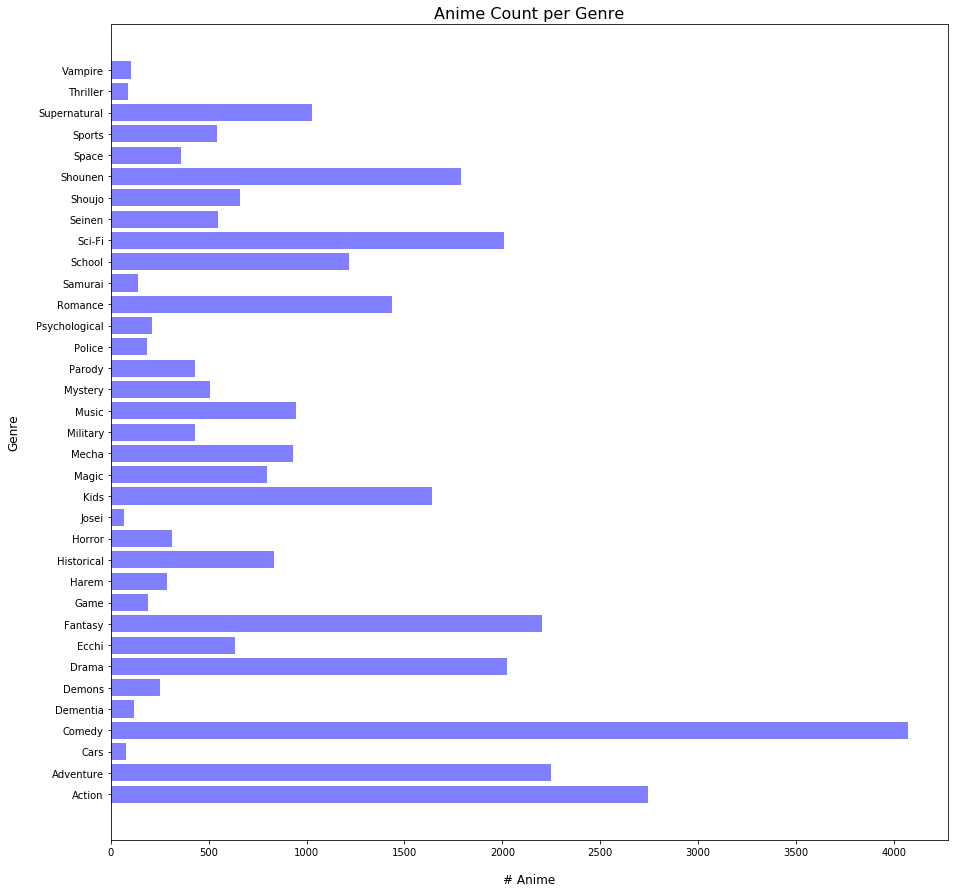

In [7]:
def genrePlot(df,genres):
    
    # get only the binary tags
    df_genres = df[genres]
    
    # we want to collect the genres that have more than 0 anime (can be possible due to preprocessing earlier)
    xlabels = []
    sums = []
    
    for genre in genres:
        
        count = sum(df[genre])
        
        if count>0:
            
            xlabels.append(genre)
            sums.append(count)
            
    # space out labels
    x_pos = np.arange(len(xlabels))
    
    # plotting
    plt.barh(x_pos, sums, align='center', alpha=0.5, color = 'b')
    plt.yticks(x_pos, xlabels)
    plt.xlabel('# Anime', fontsize = 12, labelpad=16)
    plt.ylabel('Genre', fontsize = 12, labelpad=16)
    plt.title('Anime Count per Genre', fontsize = 16)
    plt.show()
    return dict(zip(xlabels,sums))
    
    
genre_counts = genrePlot(df,genres)

** The data looks skewed, so we'll just be looking at the top 10 tags. **

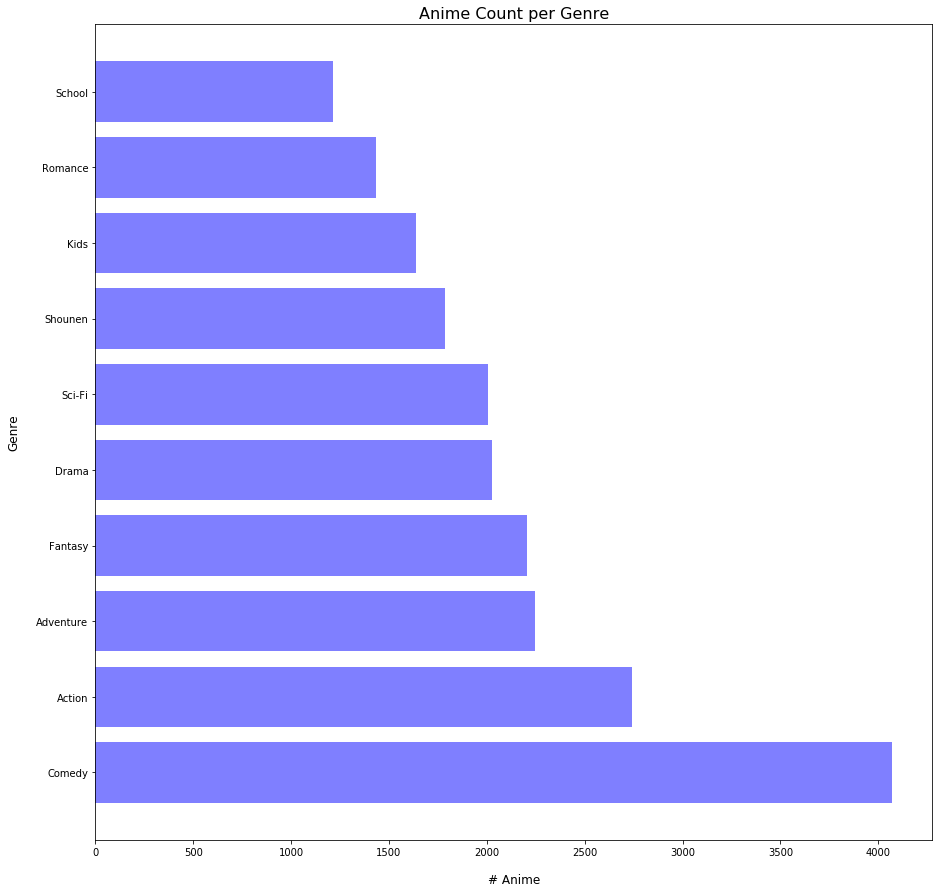

{'Action': 2743,
 'Adventure': 2247,
 'Comedy': 4072,
 'Drama': 2024,
 'Fantasy': 2203,
 'Kids': 1639,
 'Romance': 1435,
 'School': 1216,
 'Sci-Fi': 2006,
 'Shounen': 1787}

In [8]:
sorted_vals = sorted(genre_counts.items(), key=lambda x: x[1], reverse = True)
chosen_genres = [genre for genre,count in sorted_vals[:10]]

genrePlot(df,chosen_genres)

In [9]:
new_columns = ['Anime', 'Synopsis'] + chosen_genres
df = df[new_columns]
df

,Anime,Synopsis,Comedy,Action,Adventure,Fantasy,Drama,Sci-Fi,Shounen,Kids,Romance,School
0,009-1,009-1\nStudios: Ishimori Entertainment\nRating...,0,1,0,0,0,1,0,0,0,0
1,009-1__R_B,009-1__R_B\nStudios: add some\nRating: R - 17+...,0,1,0,0,0,1,0,0,0,0
2,009_Re_Cyborg,009_Re_Cyborg\nStudios: Production I.G\nRating...,0,1,1,0,0,1,0,0,0,0
3,07-Ghost,07-Ghost\nStudios: Studio Deen\nRating: PG-13 ...,0,1,0,1,0,0,0,0,0,0
4,11-nin_Iru,11-nin_Iru\nStudios: add some\nRating: PG-13 -...,0,1,1,0,1,1,0,0,1,0
5,11eyes,11eyes\nStudios: Doga Kobo\nRating: R - 17+ (v...,0,1,0,0,0,0,0,0,0,0
6,3x3_Eyes,3x3_Eyes\nStudios: Toei Animation\nRating: R -...,0,1,0,1,0,0,0,0,1,0
7,3x3_Eyes_Seima_Densetsu,3x3_Eyes_Seima_Densetsu\nStudios: Studio Junio...,0,1,1,1,0,0,0,0,1,0
8,6_Angels,6_Angels\nStudios: add some\nRating: R+ - Mild...,0,1,0,0,0,1,0,0,0,0
9,91_Days,91_Days\nStudios: Shuka\nRating: R - 17+ (viol...,0,1,0,0,1,0,0,0,0,0


### Note

So that we don't have to redo the above process everytime, we can pickle our final dataframe:

In [102]:
# serialize dataframe for future use
df.to_pickle('anime_df.pkl')

In [2]:
# read in dataframe
df = pd.read_pickle('anime_df.pkl')

## III. Vectorize Text

In [57]:
X = np.asarray(df['Synopsis'])
y = np.asarray(df[df.columns.difference(['Anime','Synopsis'])])

sf = StratifiedShuffleSplit(n_splits = 1, train_size = .8, test_size = .2, random_state = 7)

# separate into 80% training 20% testing set
for train_idx, test_idx in sf.split(X,y):
    
    X_train = X[train_idx]
    X_test = X[test_idx]
    
    y_train = y[train_idx]
    y_test = y[test_idx]

### Bag of Words with scikit-learn

In [58]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# remove stop words and consider unigrams, bigrams and trigrams
count_vect = CountVectorizer(stop_words='english', ngram_range=(1, 3), max_features = 50000)
X_train_count = count_vect.fit_transform(X_train)

### Tf-idf Transform

In [59]:
tf_transformer = TfidfTransformer().fit(X_train_count)
X_train_tf = tf_transformer.transform(X_train_count)

In [60]:
# use fitted model to vectorize test data
X_test_count = count_vect.transform(X_test)
X_test_tf = tf_transformer.transform(X_test_count)

In [61]:
features = count_vect.get_feature_names()
pd.DataFrame(features)

,0
0,00
1,00 pilot
2,000
3,000 000
4,000 light
5,000 years
6,000 yen
7,009
8,0096
9,01


### Save Transformed Vectors

In [66]:
with open('X_train_tf.pkl', 'wb') as f:
    pickle.dump(X_train_tf, f)
    
with open('X_test_tf.pkl', 'wb') as f:
    pickle.dump(X_test_tf, f)
    
with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train,f)

with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test,f)

### Load Transformed Vectors

In [3]:
with open('X_train_tf.pkl', 'rb') as f:
    X_train_tf = pickle.load(f)

with open('X_test_tf.pkl', 'rb') as f:
    X_test_tf = pickle.load(f)

with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

## IV. Test Different Classifiers

In this section we'll be testing different multi-label classifiers by performing grid search to optimize each parameter and returning the best results.

**Setting up GridSearchCV parameters**

In [4]:
from sklearn.metrics import make_scorer

f1_scorer = make_scorer(f1_score, average = 'macro')

In [6]:
kwargs = {'scoring': f1_scorer, 'cv': 5, 'n_jobs': -1}

### 1) Naive Bayes

In [7]:
parameters = [{'estimator__alpha' : [100,10,1,1e-1,1e-2,1e-3,1e-4]}]
nb = MultinomialNB()
clf = GridSearchCV(OneVsRestClassifier(nb), parameters, **kwargs)

In [8]:
clf.fit(X_train_tf,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'estimator__alpha': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=macro), verbose=0)

In [9]:
clf.score(X_train_tf,y_train)

0.94363007815331268

In [10]:
clf.score(X_test_tf,y_test)

0.74218935067736858

In [11]:
y_pred = clf.predict(X_test_tf)

In [12]:
def reportMetrics(y_pred, y_actual):
    print('Accuracy: ' + str(accuracy_score(y_actual,y_pred)))
    print('F1 Score: ' + str(f1_score(y_actual,y_pred, average = 'macro')))
    print('Precision Score: ' + str(precision_score(y_actual,y_pred, average = 'macro')))
    print('Recall Score: ' + str(recall_score(y_actual,y_pred, average = 'macro')))
    

In [13]:
reportMetrics(y_pred, y_test)

Accuracy: 0.526290630975
F1 Score: 0.742189350677
Precision Score: 0.865702954509
Recall Score: 0.65700007415


In [98]:
# save naive bayes results
with open('bayes.pkl', 'wb') as f:
    pickle.dump(clf, f)

### 2) Support Vector Machines

In [14]:
parameters = [{'estimator__C': [10,1,1e-1,1e-2], 'estimator__gamma': [1e-3, 1e-4],
               'estimator__kernel': ['linear', 'poly']}]
               
svc = SVC()
clf = GridSearchCV(OneVsRestClassifier(svc), parameters, **kwargs)

In [15]:
clf.fit(X_train_tf,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'estimator__C': [10, 1, 0.1, 0.01], 'estimator__gamma': [0.001, 0.0001], 'estimator__kernel': ['linear', 'poly']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score, average=macro), verbose=0)

In [54]:
# save SVC results
with open('SVC.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [54]:
# load classifier
with open('SVC.pkl', 'rb') as f:
    clf = pickle.load(f)

In [16]:
y_pred = clf.predict(X_test_tf)

In [17]:
reportMetrics(y_pred,y_test)

Accuracy: 0.615200764818
F1 Score: 0.783733356516
Precision Score: 0.819114684655
Recall Score: 0.753045385399


### 3) Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
forest_params = [{'estimator__n_estimators': [10,15,30], 'estimator__max_features': ['auto', 'log2'],
               'estimator__bootstrap': [False, True]}]

rf = RandomForestClassifier()
ovr = OneVsRestClassifier(rf)
clf = GridSearchCV(ovr, forest_params)

In [20]:
clf.fit(X_train_tf, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          n_jobs=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'estimator__n_estimators': [10, 15, 30], 'estimator__max_features': ['auto', 'log2'], 'estimator__bootstrap': [False, True]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [21]:
y_pred = clf.predict(X_test_tf)

In [22]:
reportMetrics(y_pred,y_test)

Accuracy: 0.601338432122
F1 Score: 0.745195636888
Precision Score: 0.925853893117
Recall Score: 0.629705264887


In [23]:
# save RandomForest results
with open('rf.pkl', 'wb') as f:
    pickle.dump(clf, f)

### 4) XGBoost

In [42]:
from xgboost import XGBClassifier

In [43]:
xgb_params = [{'estimator__max_depth': [5,6,7,8], 'estimator__learning_rate': [0.05,0.1,0.2,0.3],
               'estimator__gamma': [0,0.1,0.3], 'estimator__subsample':[0.1,0.2,0.3,0.4,0.5]}]
model = XGBClassifier(nthread = 10)
ovr = OneVsRestClassifier(model)
clf = GridSearchCV(ovr, xgb_params)

In [44]:
clf.fit(X_train_tf,y_train)

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783', 'f784', 'f785', 'f786', 'f787', 'f788', 'f789', 'f790', 'f791', 'f792', 'f793', 'f794', 'f795', 'f796', 'f797', 'f798', 'f799', 'f800', 'f801', 'f802', 'f803', 'f804', 'f805', 'f806', 'f807', 'f808', 'f809', 'f810', 'f811', 'f812', 'f813', 'f814', 'f815', 'f816', 'f817', 'f818', 'f819', 'f820', 'f821', 'f822', 'f823', 'f824', 'f825', 'f826', 'f827', 'f828', 'f829', 'f830', 'f831', 'f832', 'f833', 'f834', 'f835', 'f836', 'f837', 'f838', 'f839', 'f840', 'f841', 'f842', 'f843', 'f844', 'f845', 'f846', 'f847', 'f848', 'f849', 'f850', 'f851', 'f852', 'f853', 'f854', 'f855', 'f856', 'f857', 'f858', 'f859', 'f860', 'f861', 'f862', 'f863', 'f864', 'f865', 'f866', 'f867', 'f868', 'f869', 'f870', 'f871', 'f872', 'f873', 'f874', 'f875', 'f876', 'f877', 'f878', 'f879', 'f880', 'f881', 'f882', 'f883', 'f884', 'f885', 'f886', 'f887', 'f888', 'f889', 'f890', 'f891', 'f892', 'f893', 'f894', 'f895', 'f896', 'f897', 'f898', 'f899', 'f900', 'f901', 'f902', 'f903', 'f904', 'f905', 'f906', 'f907', 'f908', 'f909', 'f910', 'f911', 'f912', 'f913', 'f914', 'f915', 'f916', 'f917', 'f918', 'f919', 'f920', 'f921', 'f922', 'f923', 'f924', 'f925', 'f926', 'f927', 'f928', 'f929', 'f930', 'f931', 'f932', 'f933', 'f934', 'f935', 'f936', 'f937', 'f938', 'f939', 'f940', 'f941', 'f942', 'f943', 'f944', 'f945', 'f946', 'f947', 'f948', 'f949', 'f950', 'f951', 'f952', 'f953', 'f954', 'f955', 'f956', 'f957', 'f958', 'f959', 'f960', 'f961', 'f962', 'f963', 'f964', 'f965', 'f966', 'f967', 'f968', 'f969', 'f970', 'f971', 'f972', 'f973', 'f974', 'f975', 'f976', 'f977', 'f978', 'f979', 'f980', 'f981', 'f982', 'f983', 'f984', 'f985', 'f986', 'f987', 'f988', 'f989', 'f990', 'f991', 'f992', 'f993', 'f994', 'f995', 'f996', 'f997', 'f998', 'f999', 'f1000', 'f1001', 'f1002', 'f1003', 'f1004', 'f1005', 'f1006', 'f1007', 'f1008', 'f1009', 'f1010', 'f1011', 'f1012', 'f1013', 'f1014', 'f1015', 'f1016', 'f1017', 'f1018', 'f1019', 'f1020', 'f1021', 'f1022', 'f1023', 'f1024', 'f1025', 'f1026', 'f1027', 'f1028', 'f1029', 'f1030', 'f1031', 'f1032', 'f1033', 'f1034', 'f1035', 'f1036', 'f1037', 'f1038', 'f1039', 'f1040', 'f1041', 'f1042', 'f1043', 'f1044', 'f1045', 'f1046', 'f1047', 'f1048', 'f1049', 'f1050', 'f1051', 'f1052', 'f1053', 'f1054', 'f1055', 'f1056', 'f1057', 'f1058', 'f1059', 'f1060', 'f1061', 'f1062', 'f1063', 'f1064', 'f1065', 'f1066', 'f1067', 'f1068', 'f1069', 'f1070', 'f1071', 'f1072', 'f1073', 'f1074', 'f1075', 'f1076', 'f1077', 'f1078', 'f1079', 'f1080', 'f1081', 'f1082', 'f1083', 'f1084', 'f1085', 'f1086', 'f1087', 'f1088', 'f1089', 'f1090', 'f1091', 'f1092', 'f1093', 'f1094', 'f1095', 'f1096', 'f1097', 'f1098', 'f1099', 'f1100', 'f1101', 'f1102', 'f1103', 'f1104', 'f1105', 'f1106', 'f1107', 'f1108', 'f1109', 'f1110', 'f1111', 'f1112', 'f1113', 'f1114', 'f1115', 'f1116', 'f1117', 'f1118', 'f1119', 'f1120', 'f1121', 'f1122', 'f1123', 'f1124', 'f1125', 'f1126', 'f1127', 'f1128', 'f1129', 'f1130', 'f1131', 'f1132', 'f1133', 'f1134', 'f1135', 'f1136', 'f1137', 'f1138', 'f1139', 'f1140', 'f1141', 'f1142', 'f1143', 'f1144', 'f1145', 'f1146', 'f1147', 'f1148', 'f1149', 'f1150', 'f1151', 'f1152', 'f1153', 'f1154', 'f1155', 'f1156', 'f1157', 'f1158', 'f1159', 'f1160', 'f1161', 'f1162', 'f1163', 'f1164', 'f1165', 'f1166', 'f1167', 'f1168', 'f1169', 'f1170', 'f1171', 'f1172', 'f1173', 'f1174', 'f1175', 'f1176', 'f1177', 'f1178', 'f1179', 'f1180', 'f1181', 'f1182', 'f1183', 'f1184', 'f1185', 'f1186', 'f1187', 'f1188', 'f1189', 'f1190', 'f1191', 'f1192', 'f1193', 'f1194', 'f1195', 'f1196', 'f1197', 'f1198', 'f1199', 'f1200', 'f1201', 'f1202', 'f1203', 'f1204', 'f1205', 'f1206', 'f1207', 'f1208', 'f1209', 'f1210', 'f1211', 'f1212', 'f1213', 'f1214', 'f1215', 'f1216', 'f1217', 'f1218', 'f1219', 'f1220', 'f1221', 'f1222', 'f1223', 'f1224', 'f1225', 'f1226', 'f1227', 'f1228', 'f1229', 'f1230', 'f1231', 'f1232', 'f1233', 'f1234', 'f1235', 'f1236', 'f1237', 'f1238', 'f1239', 'f1240', 'f1241', 'f1242', 'f1243', 'f1244', 'f1245', 'f1246', 'f1247', 'f1248', 'f1249', 'f1250', 'f1251', 'f1252', 'f1253', 'f1254', 'f1255', 'f1256', 'f1257', 'f1258', 'f1259', 'f1260', 'f1261', 'f1262', 'f1263', 'f1264', 'f1265', 'f1266', 'f1267', 'f1268', 'f1269', 'f1270', 'f1271', 'f1272', 'f1273', 'f1274', 'f1275', 'f1276', 'f1277', 'f1278', 'f1279', 'f1280', 'f1281', 'f1282', 'f1283', 'f1284', 'f1285', 'f1286', 'f1287', 'f1288', 'f1289', 'f1290', 'f1291', 'f1292', 'f1293', 'f1294', 'f1295', 'f1296', 'f1297', 'f1298', 'f1299', 'f1300', 'f1301', 'f1302', 'f1303', 'f1304', 'f1305', 'f1306', 'f1307', 'f1308', 'f1309', 'f1310', 'f1311', 'f1312', 'f1313', 'f1314', 'f1315', 'f1316', 'f1317', 'f1318', 'f1319', 'f1320', 'f1321', 'f1322', 'f1323', 'f1324', 'f1325', 'f1326', 'f1327', 'f1328', 'f1329', 'f1330', 'f1331', 'f1332', 'f1333', 'f1334', 'f1335', 'f1336', 'f1337', 'f1338', 'f1339', 'f1340', 'f1341', 'f1342', 'f1343', 'f1344', 'f1345', 'f1346', 'f1347', 'f1348', 'f1349', 'f1350', 'f1351', 'f1352', 'f1353', 'f1354', 'f1355', 'f1356', 'f1357', 'f1358', 'f1359', 'f1360', 'f1361', 'f1362', 'f1363', 'f1364', 'f1365', 'f1366', 'f1367', 'f1368', 'f1369', 'f1370', 'f1371', 'f1372', 'f1373', 'f1374', 'f1375', 'f1376', 'f1377', 'f1378', 'f1379', 'f1380', 'f1381', 'f1382', 'f1383', 'f1384', 'f1385', 'f1386', 'f1387', 'f1388', 'f1389', 'f1390', 'f1391', 'f1392', 'f1393', 'f1394', 'f1395', 'f1396', 'f1397', 'f1398', 'f1399', 'f1400', 'f1401', 'f1402', 'f1403', 'f1404', 'f1405', 'f1406', 'f1407', 'f1408', 'f1409', 'f1410', 'f1411', 'f1412', 'f1413', 'f1414', 'f1415', 'f1416', 'f1417', 'f1418', 'f1419', 'f1420', 'f1421', 'f1422', 'f1423', 'f1424', 'f1425', 'f1426', 'f1427', 'f1428', 'f1429', 'f1430', 'f1431', 'f1432', 'f1433', 'f1434', 'f1435', 'f1436', 'f1437', 'f1438', 'f1439', 'f1440', 'f1441', 'f1442', 'f1443', 'f1444', 'f1445', 'f1446', 'f1447', 'f1448', 'f1449', 'f1450', 'f1451', 'f1452', 'f1453', 'f1454', 'f1455', 'f1456', 'f1457', 'f1458', 'f1459', 'f1460', 'f1461', 'f1462', 'f1463', 'f1464', 'f1465', 'f1466', 'f1467', 'f1468', 'f1469', 'f1470', 'f1471', 'f1472', 'f1473', 'f1474', 'f1475', 'f1476', 'f1477', 'f1478', 'f1479', 'f1480', 'f1481', 'f1482', 'f1483', 'f1484', 'f1485', 'f1486', 'f1487', 'f1488', 'f1489', 'f1490', 'f1491', 'f1492', 'f1493', 'f1494', 'f1495', 'f1496', 'f1497', 'f1498', 'f1499', 'f1500', 'f1501', 'f1502', 'f1503', 'f1504', 'f1505', 'f1506', 'f1507', 'f1508', 'f1509', 'f1510', 'f1511', 'f1512', 'f1513', 'f1514', 'f1515', 'f1516', 'f1517', 'f1518', 'f1519', 'f1520', 'f1521', 'f1522', 'f1523', 'f1524', 'f1525', 'f1526', 'f1527', 'f1528', 'f1529', 'f1530', 'f1531', 'f1532', 'f1533', 'f1534', 'f1535', 'f1536', 'f1537', 'f1538', 'f1539', 'f1540', 'f1541', 'f1542', 'f1543', 'f1544', 'f1545', 'f1546', 'f1547', 'f1548', 'f1549', 'f1550', 'f1551', 'f1552', 'f1553', 'f1554', 'f1555', 'f1556', 'f1557', 'f1558', 'f1559', 'f1560', 'f1561', 'f1562', 'f1563', 'f1564', 'f1565', 'f1566', 'f1567', 'f1568', 'f1569', 'f1570', 'f1571', 'f1572', 'f1573', 'f1574', 'f1575', 'f1576', 'f1577', 'f1578', 'f1579', 'f1580', 'f1581', 'f1582', 'f1583', 'f1584', 'f1585', 'f1586', 'f1587', 'f1588', 'f1589', 'f1590', 'f1591', 'f1592', 'f1593', 'f1594', 'f1595', 'f1596', 'f1597', 'f1598', 'f1599', 'f1600', 'f1601', 'f1602', 'f1603', 'f1604', 'f1605', 'f1606', 'f1607', 'f1608', 'f1609', 'f1610', 'f1611', 'f1612', 'f1613', 'f1614', 'f1615', 'f1616', 'f1617', 'f1618', 'f1619', 'f1620', 'f1621', 'f1622', 'f1623', 'f1624', 'f1625', 'f1626', 'f1627', 'f1628', 'f1629', 'f1630', 'f1631', 'f1632', 'f1633', 'f1634', 'f1635', 'f1636', 'f1637', 'f1638', 'f1639', 'f1640', 'f1641', 'f1642', 'f1643', 'f1644', 'f1645', 'f1646', 'f1647', 'f1648', 'f1649', 'f1650', 'f1651', 'f1652', 'f1653', 'f1654', 'f1655', 'f1656', 'f1657', 'f1658', 'f1659', 'f1660', 'f1661', 'f1662', 'f1663', 'f1664', 'f1665', 'f1666', 'f1667', 'f1668', 'f1669', 'f1670', 'f1671', 'f1672', 'f1673', 'f1674', 'f1675', 'f1676', 'f1677', 'f1678', 'f1679', 'f1680', 'f1681', 'f1682', 'f1683', 'f1684', 'f1685', 'f1686', 'f1687', 'f1688', 'f1689', 'f1690', 'f1691', 'f1692', 'f1693', 'f1694', 'f1695', 'f1696', 'f1697', 'f1698', 'f1699', 'f1700', 'f1701', 'f1702', 'f1703', 'f1704', 'f1705', 'f1706', 'f1707', 'f1708', 'f1709', 'f1710', 'f1711', 'f1712', 'f1713', 'f1714', 'f1715', 'f1716', 'f1717', 'f1718', 'f1719', 'f1720', 'f1721', 'f1722', 'f1723', 'f1724', 'f1725', 'f1726', 'f1727', 'f1728', 'f1729', 'f1730', 'f1731', 'f1732', 'f1733', 'f1734', 'f1735', 'f1736', 'f1737', 'f1738', 'f1739', 'f1740', 'f1741', 'f1742', 'f1743', 'f1744', 'f1745', 'f1746', 'f1747', 'f1748', 'f1749', 'f1750', 'f1751', 'f1752', 'f1753', 'f1754', 'f1755', 'f1756', 'f1757', 'f1758', 'f1759', 'f1760', 'f1761', 'f1762', 'f1763', 'f1764', 'f1765', 'f1766', 'f1767', 'f1768', 'f1769', 'f1770', 'f1771', 'f1772', 'f1773', 'f1774', 'f1775', 'f1776', 'f1777', 'f1778', 'f1779', 'f1780', 'f1781', 'f1782', 'f1783', 'f1784', 'f1785', 'f1786', 'f1787', 'f1788', 'f1789', 'f1790', 'f1791', 'f1792', 'f1793', 'f1794', 'f1795', 'f1796', 'f1797', 'f1798', 'f1799', 'f1800', 'f1801', 'f1802', 'f1803', 'f1804', 'f1805', 'f1806', 'f1807', 'f1808', 'f1809', 'f1810', 'f1811', 'f1812', 'f1813', 'f1814', 'f1815', 'f1816', 'f1817', 'f1818', 'f1819', 'f1820', 'f1821', 'f1822', 'f1823', 'f1824', 'f1825', 'f1826', 'f1827', 'f1828', 'f1829', 'f1830', 'f1831', 'f1832', 'f1833', 'f1834', 'f1835', 'f1836', 'f1837', 'f1838', 'f1839', 'f1840', 'f1841', 'f1842', 'f1843', 'f1844', 'f1845', 'f1846', 'f1847', 'f1848', 'f1849', 'f1850', 'f1851', 'f1852', 'f1853', 'f1854', 'f1855', 'f1856', 'f1857', 'f1858', 'f1859', 'f1860', 'f1861', 'f1862', 'f1863', 'f1864', 'f1865', 'f1866', 'f1867', 'f1868', 'f1869', 'f1870', 'f1871', 'f1872', 'f1873', 'f1874', 'f1875', 'f1876', 'f1877', 'f1878', 'f1879', 'f1880', 'f1881', 'f1882', 'f1883', 'f1884', 'f1885', 'f1886', 'f1887', 'f1888', 'f1889', 'f1890', 'f1891', 'f1892', 'f1893', 'f1894', 'f1895', 'f1896', 'f1897', 'f1898', 'f1899', 'f1900', 'f1901', 'f1902', 'f1903', 'f1904', 'f1905', 'f1906', 'f1907', 'f1908', 'f1909', 'f1910', 'f1911', 'f1912', 'f1913', 'f1914', 'f1915', 'f1916', 'f1917', 'f1918', 'f1919', 'f1920', 'f1921', 'f1922', 'f1923', 'f1924', 'f1925', 'f1926', 'f1927', 'f1928', 'f1929', 'f1930', 'f1931', 'f1932', 'f1933', 'f1934', 'f1935', 'f1936', 'f1937', 'f1938', 'f1939', 'f1940', 'f1941', 'f1942', 'f1943', 'f1944', 'f1945', 'f1946', 'f1947', 'f1948', 'f1949', 'f1950', 'f1951', 'f1952', 'f1953', 'f1954', 'f1955', 'f1956', 'f1957', 'f1958', 'f1959', 'f1960', 'f1961', 'f1962', 'f1963', 'f1964', 'f1965', 'f1966', 'f1967', 'f1968', 'f1969', 'f1970', 'f1971', 'f1972', 'f1973', 'f1974', 'f1975', 'f1976', 'f1977', 'f1978', 'f1979', 'f1980', 'f1981', 'f1982', 'f1983', 'f1984', 'f1985', 'f1986', 'f1987', 'f1988', 'f1989', 'f1990', 'f1991', 'f1992', 'f1993', 'f1994', 'f1995', 'f1996', 'f1997', 'f1998', 'f1999', 'f2000', 'f2001', 'f2002', 'f2003', 'f2004', 'f2005', 'f2006', 'f2007', 'f2008', 'f2009', 'f2010', 'f2011', 'f2012', 'f2013', 'f2014', 'f2015', 'f2016', 'f2017', 'f2018', 'f2019', 'f2020', 'f2021', 'f2022', 'f2023', 'f2024', 'f2025', 'f2026', 'f2027', 'f2028', 'f2029', 'f2030', 'f2031', 'f2032', 'f2033', 'f2034', 'f2035', 'f2036', 'f2037', 'f2038', 'f2039', 'f2040', 'f2041', 'f2042', 'f2043', 'f2044', 'f2045', 'f2046', 'f2047', 'f2048', 'f2049', 'f2050', 'f2051', 'f2052', 'f2053', 'f2054', 'f2055', 'f2056', 'f2057', 'f2058', 'f2059', 'f2060', 'f2061', 'f2062', 'f2063', 'f2064', 'f2065', 'f2066', 'f2067', 'f2068', 'f2069', 'f2070', 'f2071', 'f2072', 'f2073', 'f2074', 'f2075', 'f2076', 'f2077', 'f2078', 'f2079', 'f2080', 'f2081', 'f2082', 'f2083', 'f2084', 'f2085', 'f2086', 'f2087', 'f2088', 'f2089', 'f2090', 'f2091', 'f2092', 'f2093', 'f2094', 'f2095', 'f2096', 'f2097', 'f2098', 'f2099', 'f2100', 'f2101', 'f2102', 'f2103', 'f2104', 'f2105', 'f2106', 'f2107', 'f2108', 'f2109', 'f2110', 'f2111', 'f2112', 'f2113', 'f2114', 'f2115', 'f2116', 'f2117', 'f2118', 'f2119', 'f2120', 'f2121', 'f2122', 'f2123', 'f2124', 'f2125', 'f2126', 'f2127', 'f2128', 'f2129', 'f2130', 'f2131', 'f2132', 'f2133', 'f2134', 'f2135', 'f2136', 'f2137', 'f2138', 'f2139', 'f2140', 'f2141', 'f2142', 'f2143', 'f2144', 'f2145', 'f2146', 'f2147', 'f2148', 'f2149', 'f2150', 'f2151', 'f2152', 'f2153', 'f2154', 'f2155', 'f2156', 'f2157', 'f2158', 'f2159', 'f2160', 'f2161', 'f2162', 'f2163', 'f2164', 'f2165', 'f2166', 'f2167', 'f2168', 'f2169', 'f2170', 'f2171', 'f2172', 'f2173', 'f2174', 'f2175', 'f2176', 'f2177', 'f2178', 'f2179', 'f2180', 'f2181', 'f2182', 'f2183', 'f2184', 'f2185', 'f2186', 'f2187', 'f2188', 'f2189', 'f2190', 'f2191', 'f2192', 'f2193', 'f2194', 'f2195', 'f2196', 'f2197', 'f2198', 'f2199', 'f2200', 'f2201', 'f2202', 'f2203', 'f2204', 'f2205', 'f2206', 'f2207', 'f2208', 'f2209', 'f2210', 'f2211', 'f2212', 'f2213', 'f2214', 'f2215', 'f2216', 'f2217', 'f2218', 'f2219', 'f2220', 'f2221', 'f2222', 'f2223', 'f2224', 'f2225', 'f2226', 'f2227', 'f2228', 'f2229', 'f2230', 'f2231', 'f2232', 'f2233', 'f2234', 'f2235', 'f2236', 'f2237', 'f2238', 'f2239', 'f2240', 'f2241', 'f2242', 'f2243', 'f2244', 'f2245', 'f2246', 'f2247', 'f2248', 'f2249', 'f2250', 'f2251', 'f2252', 'f2253', 'f2254', 'f2255', 'f2256', 'f2257', 'f2258', 'f2259', 'f2260', 'f2261', 'f2262', 'f2263', 'f2264', 'f2265', 'f2266', 'f2267', 'f2268', 'f2269', 'f2270', 'f2271', 'f2272', 'f2273', 'f2274', 'f2275', 'f2276', 'f2277', 'f2278', 'f2279', 'f2280', 'f2281', 'f2282', 'f2283', 'f2284', 'f2285', 'f2286', 'f2287', 'f2288', 'f2289', 'f2290', 'f2291', 'f2292', 'f2293', 'f2294', 'f2295', 'f2296', 'f2297', 'f2298', 'f2299', 'f2300', 'f2301', 'f2302', 'f2303', 'f2304', 'f2305', 'f2306', 'f2307', 'f2308', 'f2309', 'f2310', 'f2311', 'f2312', 'f2313', 'f2314', 'f2315', 'f2316', 'f2317', 'f2318', 'f2319', 'f2320', 'f2321', 'f2322', 'f2323', 'f2324', 'f2325', 'f2326', 'f2327', 'f2328', 'f2329', 'f2330', 'f2331', 'f2332', 'f2333', 'f2334', 'f2335', 'f2336', 'f2337', 'f2338', 'f2339', 'f2340', 'f2341', 'f2342', 'f2343', 'f2344', 'f2345', 'f2346', 'f2347', 'f2348', 'f2349', 'f2350', 'f2351', 'f2352', 'f2353', 'f2354', 'f2355', 'f2356', 'f2357', 'f2358', 'f2359', 'f2360', 'f2361', 'f2362', 'f2363', 'f2364', 'f2365', 'f2366', 'f2367', 'f2368', 'f2369', 'f2370', 'f2371', 'f2372', 'f2373', 'f2374', 'f2375', 'f2376', 'f2377', 'f2378', 'f2379', 'f2380', 'f2381', 'f2382', 'f2383', 'f2384', 'f2385', 'f2386', 'f2387', 'f2388', 'f2389', 'f2390', 'f2391', 'f2392', 'f2393', 'f2394', 'f2395', 'f2396', 'f2397', 'f2398', 'f2399', 'f2400', 'f2401', 'f2402', 'f2403', 'f2404', 'f2405', 'f2406', 'f2407', 'f2408', 'f2409', 'f2410', 'f2411', 'f2412', 'f2413', 'f2414', 'f2415', 'f2416', 'f2417', 'f2418', 'f2419', 'f2420', 'f2421', 'f2422', 'f2423', 'f2424', 'f2425', 'f2426', 'f2427', 'f2428', 'f2429', 'f2430', 'f2431', 'f2432', 'f2433', 'f2434', 'f2435', 'f2436', 'f2437', 'f2438', 'f2439', 'f2440', 'f2441', 'f2442', 'f2443', 'f2444', 'f2445', 'f2446', 'f2447', 'f2448', 'f2449', 'f2450', 'f2451', 'f2452', 'f2453', 'f2454', 'f2455', 'f2456', 'f2457', 'f2458', 'f2459', 'f2460', 'f2461', 'f2462', 'f2463', 'f2464', 'f2465', 'f2466', 'f2467', 'f2468', 'f2469', 'f2470', 'f2471', 'f2472', 'f2473', 'f2474', 'f2475', 'f2476', 'f2477', 'f2478', 'f2479', 'f2480', 'f2481', 'f2482', 'f2483', 'f2484', 'f2485', 'f2486', 'f2487', 'f2488', 'f2489', 'f2490', 'f2491', 'f2492', 'f2493', 'f2494', 'f2495', 'f2496', 'f2497', 'f2498', 'f2499', 'f2500', 'f2501', 'f2502', 'f2503', 'f2504', 'f2505', 'f2506', 'f2507', 'f2508', 'f2509', 'f2510', 'f2511', 'f2512', 'f2513', 'f2514', 'f2515', 'f2516', 'f2517', 'f2518', 'f2519', 'f2520', 'f2521', 'f2522', 'f2523', 'f2524', 'f2525', 'f2526', 'f2527', 'f2528', 'f2529', 'f2530', 'f2531', 'f2532', 'f2533', 'f2534', 'f2535', 'f2536', 'f2537', 'f2538', 'f2539', 'f2540', 'f2541', 'f2542', 'f2543', 'f2544', 'f2545', 'f2546', 'f2547', 'f2548', 'f2549', 'f2550', 'f2551', 'f2552', 'f2553', 'f2554', 'f2555', 'f2556', 'f2557', 'f2558', 'f2559', 'f2560', 'f2561', 'f2562', 'f2563', 'f2564', 'f2565', 'f2566', 'f2567', 'f2568', 'f2569', 'f2570', 'f2571', 'f2572', 'f2573', 'f2574', 'f2575', 'f2576', 'f2577', 'f2578', 'f2579', 'f2580', 'f2581', 'f2582', 'f2583', 'f2584', 'f2585', 'f2586', 'f2587', 'f2588', 'f2589', 'f2590', 'f2591', 'f2592', 'f2593', 'f2594', 'f2595', 'f2596', 'f2597', 'f2598', 'f2599', 'f2600', 'f2601', 'f2602', 'f2603', 'f2604', 'f2605', 'f2606', 'f2607', 'f2608', 'f2609', 'f2610', 'f2611', 'f2612', 'f2613', 'f2614', 'f2615', 'f2616', 'f2617', 'f2618', 'f2619', 'f2620', 'f2621', 'f2622', 'f2623', 'f2624', 'f2625', 'f2626', 'f2627', 'f2628', 'f2629', 'f2630', 'f2631', 'f2632', 'f2633', 'f2634', 'f2635', 'f2636', 'f2637', 'f2638', 'f2639', 'f2640', 'f2641', 'f2642', 'f2643', 'f2644', 'f2645', 'f2646', 'f2647', 'f2648', 'f2649', 'f2650', 'f2651', 'f2652', 'f2653', 'f2654', 'f2655', 'f2656', 'f2657', 'f2658', 'f2659', 'f2660', 'f2661', 'f2662', 'f2663', 'f2664', 'f2665', 'f2666', 'f2667', 'f2668', 'f2669', 'f2670', 'f2671', 'f2672', 'f2673', 'f2674', 'f2675', 'f2676', 'f2677', 'f2678', 'f2679', 'f2680', 'f2681', 'f2682', 'f2683', 'f2684', 'f2685', 'f2686', 'f2687', 'f2688', 'f2689', 'f2690', 'f2691', 'f2692', 'f2693', 'f2694', 'f2695', 'f2696', 'f2697', 'f2698', 'f2699', 'f2700', 'f2701', 'f2702', 'f2703', 'f2704', 'f2705', 'f2706', 'f2707', 'f2708', 'f2709', 'f2710', 'f2711', 'f2712', 'f2713', 'f2714', 'f2715', 'f2716', 'f2717', 'f2718', 'f2719', 'f2720', 'f2721', 'f2722', 'f2723', 'f2724', 'f2725', 'f2726', 'f2727', 'f2728', 'f2729', 'f2730', 'f2731', 'f2732', 'f2733', 'f2734', 'f2735', 'f2736', 'f2737', 'f2738', 'f2739', 'f2740', 'f2741', 'f2742', 'f2743', 'f2744', 'f2745', 'f2746', 'f2747', 'f2748', 'f2749', 'f2750', 'f2751', 'f2752', 'f2753', 'f2754', 'f2755', 'f2756', 'f2757', 'f2758', 'f2759', 'f2760', 'f2761', 'f2762', 'f2763', 'f2764', 'f2765', 'f2766', 'f2767', 'f2768', 'f2769', 'f2770', 'f2771', 'f2772', 'f2773', 'f2774', 'f2775', 'f2776', 'f2777', 'f2778', 'f2779', 'f2780', 'f2781', 'f2782', 'f2783', 'f2784', 'f2785', 'f2786', 'f2787', 'f2788', 'f2789', 'f2790', 'f2791', 'f2792', 'f2793', 'f2794', 'f2795', 'f2796', 'f2797', 'f2798', 'f2799', 'f2800', 'f2801', 'f2802', 'f2803', 'f2804', 'f2805', 'f2806', 'f2807', 'f2808', 'f2809', 'f2810', 'f2811', 'f2812', 'f2813', 'f2814', 'f2815', 'f2816', 'f2817', 'f2818', 'f2819', 'f2820', 'f2821', 'f2822', 'f2823', 'f2824', 'f2825', 'f2826', 'f2827', 'f2828', 'f2829', 'f2830', 'f2831', 'f2832', 'f2833', 'f2834', 'f2835', 'f2836', 'f2837', 'f2838', 'f2839', 'f2840', 'f2841', 'f2842', 'f2843', 'f2844', 'f2845', 'f2846', 'f2847', 'f2848', 'f2849', 'f2850', 'f2851', 'f2852', 'f2853', 'f2854', 'f2855', 'f2856', 'f2857', 'f2858', 'f2859', 'f2860', 'f2861', 'f2862', 'f2863', 'f2864', 'f2865', 'f2866', 'f2867', 'f2868', 'f2869', 'f2870', 'f2871', 'f2872', 'f2873', 'f2874', 'f2875', 'f2876', 'f2877', 'f2878', 'f2879', 'f2880', 'f2881', 'f2882', 'f2883', 'f2884', 'f2885', 'f2886', 'f2887', 'f2888', 'f2889', 'f2890', 'f2891', 'f2892', 'f2893', 'f2894', 'f2895', 'f2896', 'f2897', 'f2898', 'f2899', 'f2900', 'f2901', 'f2902', 'f2903', 'f2904', 'f2905', 'f2906', 'f2907', 'f2908', 'f2909', 'f2910', 'f2911', 'f2912', 'f2913', 'f2914', 'f2915', 'f2916', 'f2917', 'f2918', 'f2919', 'f2920', 'f2921', 'f2922', 'f2923', 'f2924', 'f2925', 'f2926', 'f2927', 'f2928', 'f2929', 'f2930', 'f2931', 'f2932', 'f2933', 'f2934', 'f2935', 'f2936', 'f2937', 'f2938', 'f2939', 'f2940', 'f2941', 'f2942', 'f2943', 'f2944', 'f2945', 'f2946', 'f2947', 'f2948', 'f2949', 'f2950', 'f2951', 'f2952', 'f2953', 'f2954', 'f2955', 'f2956', 'f2957', 'f2958', 'f2959', 'f2960', 'f2961', 'f2962', 'f2963', 'f2964', 'f2965', 'f2966', 'f2967', 'f2968', 'f2969', 'f2970', 'f2971', 'f2972', 'f2973', 'f2974', 'f2975', 'f2976', 'f2977', 'f2978', 'f2979', 'f2980', 'f2981', 'f2982', 'f2983', 'f2984', 'f2985', 'f2986', 'f2987', 'f2988', 'f2989', 'f2990', 'f2991', 'f2992', 'f2993', 'f2994', 'f2995', 'f2996', 'f2997', 'f2998', 'f2999', 'f3000', 'f3001', 'f3002', 'f3003', 'f3004', 'f3005', 'f3006', 'f3007', 'f3008', 'f3009', 'f3010', 'f3011', 'f3012', 'f3013', 'f3014', 'f3015', 'f3016', 'f3017', 'f3018', 'f3019', 'f3020', 'f3021', 'f3022', 'f3023', 'f3024', 'f3025', 'f3026', 'f3027', 'f3028', 'f3029', 'f3030', 'f3031', 'f3032', 'f3033', 'f3034', 'f3035', 'f3036', 'f3037', 'f3038', 'f3039', 'f3040', 'f3041', 'f3042', 'f3043', 'f3044', 'f3045', 'f3046', 'f3047', 'f3048', 'f3049', 'f3050', 'f3051', 'f3052', 'f3053', 'f3054', 'f3055', 'f3056', 'f3057', 'f3058', 'f3059', 'f3060', 'f3061', 'f3062', 'f3063', 'f3064', 'f3065', 'f3066', 'f3067', 'f3068', 'f3069', 'f3070', 'f3071', 'f3072', 'f3073', 'f3074', 'f3075', 'f3076', 'f3077', 'f3078', 'f3079', 'f3080', 'f3081', 'f3082', 'f3083', 'f3084', 'f3085', 'f3086', 'f3087', 'f3088', 'f3089', 'f3090', 'f3091', 'f3092', 'f3093', 'f3094', 'f3095', 'f3096', 'f3097', 'f3098', 'f3099', 'f3100', 'f3101', 'f3102', 'f3103', 'f3104', 'f3105', 'f3106', 'f3107', 'f3108', 'f3109', 'f3110', 'f3111', 'f3112', 'f3113', 'f3114', 'f3115', 'f3116', 'f3117', 'f3118', 'f3119', 'f3120', 'f3121', 'f3122', 'f3123', 'f3124', 'f3125', 'f3126', 'f3127', 'f3128', 'f3129', 'f3130', 'f3131', 'f3132', 'f3133', 'f3134', 'f3135', 'f3136', 'f3137', 'f3138', 'f3139', 'f3140', 'f3141', 'f3142', 'f3143', 'f3144', 'f3145', 'f3146', 'f3147', 'f3148', 'f3149', 'f3150', 'f3151', 'f3152', 'f3153', 'f3154', 'f3155', 'f3156', 'f3157', 'f3158', 'f3159', 'f3160', 'f3161', 'f3162', 'f3163', 'f3164', 'f3165', 'f3166', 'f3167', 'f3168', 'f3169', 'f3170', 'f3171', 'f3172', 'f3173', 'f3174', 'f3175', 'f3176', 'f3177', 'f3178', 'f3179', 'f3180', 'f3181', 'f3182', 'f3183', 'f3184', 'f3185', 'f3186', 'f3187', 'f3188', 'f3189', 'f3190', 'f3191', 'f3192', 'f3193', 'f3194', 'f3195', 'f3196', 'f3197', 'f3198', 'f3199', 'f3200', 'f3201', 'f3202', 'f3203', 'f3204', 'f3205', 'f3206', 'f3207', 'f3208', 'f3209', 'f3210', 'f3211', 'f3212', 'f3213', 'f3214', 'f3215', 'f3216', 'f3217', 'f3218', 'f3219', 'f3220', 'f3221', 'f3222', 'f3223', 'f3224', 'f3225', 'f3226', 'f3227', 'f3228', 'f3229', 'f3230', 'f3231', 'f3232', 'f3233', 'f3234', 'f3235', 'f3236', 'f3237', 'f3238', 'f3239', 'f3240', 'f3241', 'f3242', 'f3243', 'f3244', 'f3245', 'f3246', 'f3247', 'f3248', 'f3249', 'f3250', 'f3251', 'f3252', 'f3253', 'f3254', 'f3255', 'f3256', 'f3257', 'f3258', 'f3259', 'f3260', 'f3261', 'f3262', 'f3263', 'f3264', 'f3265', 'f3266', 'f3267', 'f3268', 'f3269', 'f3270', 'f3271', 'f3272', 'f3273', 'f3274', 'f3275', 'f3276', 'f3277', 'f3278', 'f3279', 'f3280', 'f3281', 'f3282', 'f3283', 'f3284', 'f3285', 'f3286', 'f3287', 'f3288', 'f3289', 'f3290', 'f3291', 'f3292', 'f3293', 'f3294', 'f3295', 'f3296', 'f3297', 'f3298', 'f3299', 'f3300', 'f3301', 'f3302', 'f3303', 'f3304', 'f3305', 'f3306', 'f3307', 'f3308', 'f3309', 'f3310', 'f3311', 'f3312', 'f3313', 'f3314', 'f3315', 'f3316', 'f3317', 'f3318', 'f3319', 'f3320', 'f3321', 'f3322', 'f3323', 'f3324', 'f3325', 'f3326', 'f3327', 'f3328', 'f3329', 'f3330', 'f3331', 'f3332', 'f3333', 'f3334', 'f3335', 'f3336', 'f3337', 'f3338', 'f3339', 'f3340', 'f3341', 'f3342', 'f3343', 'f3344', 'f3345', 'f3346', 'f3347', 'f3348', 'f3349', 'f3350', 'f3351', 'f3352', 'f3353', 'f3354', 'f3355', 'f3356', 'f3357', 'f3358', 'f3359', 'f3360', 'f3361', 'f3362', 'f3363', 'f3364', 'f3365', 'f3366', 'f3367', 'f3368', 'f3369', 'f3370', 'f3371', 'f3372', 'f3373', 'f3374', 'f3375', 'f3376', 'f3377', 'f3378', 'f3379', 'f3380', 'f3381', 'f3382', 'f3383', 'f3384', 'f3385', 'f3386', 'f3387', 'f3388', 'f3389', 'f3390', 'f3391', 'f3392', 'f3393', 'f3394', 'f3395', 'f3396', 'f3397', 'f3398', 'f3399', 'f3400', 'f3401', 'f3402', 'f3403', 'f3404', 'f3405', 'f3406', 'f3407', 'f3408', 'f3409', 'f3410', 'f3411', 'f3412', 'f3413', 'f3414', 'f3415', 'f3416', 'f3417', 'f3418', 'f3419', 'f3420', 'f3421', 'f3422', 'f3423', 'f3424', 'f3425', 'f3426', 'f3427', 'f3428', 'f3429', 'f3430', 'f3431', 'f3432', 'f3433', 'f3434', 'f3435', 'f3436', 'f3437', 'f3438', 'f3439', 'f3440', 'f3441', 'f3442', 'f3443', 'f3444', 'f3445', 'f3446', 'f3447', 'f3448', 'f3449', 'f3450', 'f3451', 'f3452', 'f3453', 'f3454', 'f3455', 'f3456', 'f3457', 'f3458', 'f3459', 'f3460', 'f3461', 'f3462', 'f3463', 'f3464', 'f3465', 'f3466', 'f3467', 'f3468', 'f3469', 'f3470', 'f3471', 'f3472', 'f3473', 'f3474', 'f3475', 'f3476', 'f3477', 'f3478', 'f3479', 'f3480', 'f3481', 'f3482', 'f3483', 'f3484', 'f3485', 'f3486', 'f3487', 'f3488', 'f3489', 'f3490', 'f3491', 'f3492', 'f3493', 'f3494', 'f3495', 'f3496', 'f3497', 'f3498', 'f3499', 'f3500', 'f3501', 'f3502', 'f3503', 'f3504', 'f3505', 'f3506', 'f3507', 'f3508', 'f3509', 'f3510', 'f3511', 'f3512', 'f3513', 'f3514', 'f3515', 'f3516', 'f3517', 'f3518', 'f3519', 'f3520', 'f3521', 'f3522', 'f3523', 'f3524', 'f3525', 'f3526', 'f3527', 'f3528', 'f3529', 'f3530', 'f3531', 'f3532', 'f3533', 'f3534', 'f3535', 'f3536', 'f3537', 'f3538', 'f3539', 'f3540', 'f3541', 'f3542', 'f3543', 'f3544', 'f3545', 'f3546', 'f3547', 'f3548', 'f3549', 'f3550', 'f3551', 'f3552', 'f3553', 'f3554', 'f3555', 'f3556', 'f3557', 'f3558', 'f3559', 'f3560', 'f3561', 'f3562', 'f3563', 'f3564', 'f3565', 'f3566', 'f3567', 'f3568', 'f3569', 'f3570', 'f3571', 'f3572', 'f3573', 'f3574', 'f3575', 'f3576', 'f3577', 'f3578', 'f3579', 'f3580', 'f3581', 'f3582', 'f3583', 'f3584', 'f3585', 'f3586', 'f3587', 'f3588', 'f3589', 'f3590', 'f3591', 'f3592', 'f3593', 'f3594', 'f3595', 'f3596', 'f3597', 'f3598', 'f3599', 'f3600', 'f3601', 'f3602', 'f3603', 'f3604', 'f3605', 'f3606', 'f3607', 'f3608', 'f3609', 'f3610', 'f3611', 'f3612', 'f3613', 'f3614', 'f3615', 'f3616', 'f3617', 'f3618', 'f3619', 'f3620', 'f3621', 'f3622', 'f3623', 'f3624', 'f3625', 'f3626', 'f3627', 'f3628', 'f3629', 'f3630', 'f3631', 'f3632', 'f3633', 'f3634', 'f3635', 'f3636', 'f3637', 'f3638', 'f3639', 'f3640', 'f3641', 'f3642', 'f3643', 'f3644', 'f3645', 'f3646', 'f3647', 'f3648', 'f3649', 'f3650', 'f3651', 'f3652', 'f3653', 'f3654', 'f3655', 'f3656', 'f3657', 'f3658', 'f3659', 'f3660', 'f3661', 'f3662', 'f3663', 'f3664', 'f3665', 'f3666', 'f3667', 'f3668', 'f3669', 'f3670', 'f3671', 'f3672', 'f3673', 'f3674', 'f3675', 'f3676', 'f3677', 'f3678', 'f3679', 'f3680', 'f3681', 'f3682', 'f3683', 'f3684', 'f3685', 'f3686', 'f3687', 'f3688', 'f3689', 'f3690', 'f3691', 'f3692', 'f3693', 'f3694', 'f3695', 'f3696', 'f3697', 'f3698', 'f3699', 'f3700', 'f3701', 'f3702', 'f3703', 'f3704', 'f3705', 'f3706', 'f3707', 'f3708', 'f3709', 'f3710', 'f3711', 'f3712', 'f3713', 'f3714', 'f3715', 'f3716', 'f3717', 'f3718', 'f3719', 'f3720', 'f3721', 'f3722', 'f3723', 'f3724', 'f3725', 'f3726', 'f3727', 'f3728', 'f3729', 'f3730', 'f3731', 'f3732', 'f3733', 'f3734', 'f3735', 'f3736', 'f3737', 'f3738', 'f3739', 'f3740', 'f3741', 'f3742', 'f3743', 'f3744', 'f3745', 'f3746', 'f3747', 'f3748', 'f3749', 'f3750', 'f3751', 'f3752', 'f3753', 'f3754', 'f3755', 'f3756', 'f3757', 'f3758', 'f3759', 'f3760', 'f3761', 'f3762', 'f3763', 'f3764', 'f3765', 'f3766', 'f3767', 'f3768', 'f3769', 'f3770', 'f3771', 'f3772', 'f3773', 'f3774', 'f3775', 'f3776', 'f3777', 'f3778', 'f3779', 'f3780', 'f3781', 'f3782', 'f3783', 'f3784', 'f3785', 'f3786', 'f3787', 'f3788', 'f3789', 'f3790', 'f3791', 'f3792', 'f3793', 'f3794', 'f3795', 'f3796', 'f3797', 'f3798', 'f3799', 'f3800', 'f3801', 'f3802', 'f3803', 'f3804', 'f3805', 'f3806', 'f3807', 'f3808', 'f3809', 'f3810', 'f3811', 'f3812', 'f3813', 'f3814', 'f3815', 'f3816', 'f3817', 'f3818', 'f3819', 'f3820', 'f3821', 'f3822', 'f3823', 'f3824', 'f3825', 'f3826', 'f3827', 'f3828', 'f3829', 'f3830', 'f3831', 'f3832', 'f3833', 'f3834', 'f3835', 'f3836', 'f3837', 'f3838', 'f3839', 'f3840', 'f3841', 'f3842', 'f3843', 'f3844', 'f3845', 'f3846', 'f3847', 'f3848', 'f3849', 'f3850', 'f3851', 'f3852', 'f3853', 'f3854', 'f3855', 'f3856', 'f3857', 'f3858', 'f3859', 'f3860', 'f3861', 'f3862', 'f3863', 'f3864', 'f3865', 'f3866', 'f3867', 'f3868', 'f3869', 'f3870', 'f3871', 'f3872', 'f3873', 'f3874', 'f3875', 'f3876', 'f3877', 'f3878', 'f3879', 'f3880', 'f3881', 'f3882', 'f3883', 'f3884', 'f3885', 'f3886', 'f3887', 'f3888', 'f3889', 'f3890', 'f3891', 'f3892', 'f3893', 'f3894', 'f3895', 'f3896', 'f3897', 'f3898', 'f3899', 'f3900', 'f3901', 'f3902', 'f3903', 'f3904', 'f3905', 'f3906', 'f3907', 'f3908', 'f3909', 'f3910', 'f3911', 'f3912', 'f3913', 'f3914', 'f3915', 'f3916', 'f3917', 'f3918', 'f3919', 'f3920', 'f3921', 'f3922', 'f3923', 'f3924', 'f3925', 'f3926', 'f3927', 'f3928', 'f3929', 'f3930', 'f3931', 'f3932', 'f3933', 'f3934', 'f3935', 'f3936', 'f3937', 'f3938', 'f3939', 'f3940', 'f3941', 'f3942', 'f3943', 'f3944', 'f3945', 'f3946', 'f3947', 'f3948', 'f3949', 'f3950', 'f3951', 'f3952', 'f3953', 'f3954', 'f3955', 'f3956', 'f3957', 'f3958', 'f3959', 'f3960', 'f3961', 'f3962', 'f3963', 'f3964', 'f3965', 'f3966', 'f3967', 'f3968', 'f3969', 'f3970', 'f3971', 'f3972', 'f3973', 'f3974', 'f3975', 'f3976', 'f3977', 'f3978', 'f3979', 'f3980', 'f3981', 'f3982', 'f3983', 'f3984', 'f3985', 'f3986', 'f3987', 'f3988', 'f3989', 'f3990', 'f3991', 'f3992', 'f3993', 'f3994', 'f3995', 'f3996', 'f3997', 'f3998', 'f3999', 'f4000', 'f4001', 'f4002', 'f4003', 'f4004', 'f4005', 'f4006', 'f4007', 'f4008', 'f4009', 'f4010', 'f4011', 'f4012', 'f4013', 'f4014', 'f4015', 'f4016', 'f4017', 'f4018', 'f4019', 'f4020', 'f4021', 'f4022', 'f4023', 'f4024', 'f4025', 'f4026', 'f4027', 'f4028', 'f4029', 'f4030', 'f4031', 'f4032', 'f4033', 'f4034', 'f4035', 'f4036', 'f4037', 'f4038', 'f4039', 'f4040', 'f4041', 'f4042', 'f4043', 'f4044', 'f4045', 'f4046', 'f4047', 'f4048', 'f4049', 'f4050', 'f4051', 'f4052', 'f4053', 'f4054', 'f4055', 'f4056', 'f4057', 'f4058', 'f4059', 'f4060', 'f4061', 'f4062', 'f4063', 'f4064', 'f4065', 'f4066', 'f4067', 'f4068', 'f4069', 'f4070', 'f4071', 'f4072', 'f4073', 'f4074', 'f4075', 'f4076', 'f4077', 'f4078', 'f4079', 'f4080', 'f4081', 'f4082', 'f4083', 'f4084', 'f4085', 'f4086', 'f4087', 'f4088', 'f4089', 'f4090', 'f4091', 'f4092', 'f4093', 'f4094', 'f4095', 'f4096', 'f4097', 'f4098', 'f4099', 'f4100', 'f4101', 'f4102', 'f4103', 'f4104', 'f4105', 'f4106', 'f4107', 'f4108', 'f4109', 'f4110', 'f4111', 'f4112', 'f4113', 'f4114', 'f4115', 'f4116', 'f4117', 'f4118', 'f4119', 'f4120', 'f4121', 'f4122', 'f4123', 'f4124', 'f4125', 'f4126', 'f4127', 'f4128', 'f4129', 'f4130', 'f4131', 'f4132', 'f4133', 'f4134', 'f4135', 'f4136', 'f4137', 'f4138', 'f4139', 'f4140', 'f4141', 'f4142', 'f4143', 'f4144', 'f4145', 'f4146', 'f4147', 'f4148', 'f4149', 'f4150', 'f4151', 'f4152', 'f4153', 'f4154', 'f4155', 'f4156', 'f4157', 'f4158', 'f4159', 'f4160', 'f4161', 'f4162', 'f4163', 'f4164', 'f4165', 'f4166', 'f4167', 'f4168', 'f4169', 'f4170', 'f4171', 'f4172', 'f4173', 'f4174', 'f4175', 'f4176', 'f4177', 'f4178', 'f4179', 'f4180', 'f4181', 'f4182', 'f4183', 'f4184', 'f4185', 'f4186', 'f4187', 'f4188', 'f4189', 'f4190', 'f4191', 'f4192', 'f4193', 'f4194', 'f4195', 'f4196', 'f4197', 'f4198', 'f4199', 'f4200', 'f4201', 'f4202', 'f4203', 'f4204', 'f4205', 'f4206', 'f4207', 'f4208', 'f4209', 'f4210', 'f4211', 'f4212', 'f4213', 'f4214', 'f4215', 'f4216', 'f4217', 'f4218', 'f4219', 'f4220', 'f4221', 'f4222', 'f4223', 'f4224', 'f4225', 'f4226', 'f4227', 'f4228', 'f4229', 'f4230', 'f4231', 'f4232', 'f4233', 'f4234', 'f4235', 'f4236', 'f4237', 'f4238', 'f4239', 'f4240', 'f4241', 'f4242', 'f4243', 'f4244', 'f4245', 'f4246', 'f4247', 'f4248', 'f4249', 'f4250', 'f4251', 'f4252', 'f4253', 'f4254', 'f4255', 'f4256', 'f4257', 'f4258', 'f4259', 'f4260', 'f4261', 'f4262', 'f4263', 'f4264', 'f4265', 'f4266', 'f4267', 'f4268', 'f4269', 'f4270', 'f4271', 'f4272', 'f4273', 'f4274', 'f4275', 'f4276', 'f4277', 'f4278', 'f4279', 'f4280', 'f4281', 'f4282', 'f4283', 'f4284', 'f4285', 'f4286', 'f4287', 'f4288', 'f4289', 'f4290', 'f4291', 'f4292', 'f4293', 'f4294', 'f4295', 'f4296', 'f4297', 'f4298', 'f4299', 'f4300', 'f4301', 'f4302', 'f4303', 'f4304', 'f4305', 'f4306', 'f4307', 'f4308', 'f4309', 'f4310', 'f4311', 'f4312', 'f4313', 'f4314', 'f4315', 'f4316', 'f4317', 'f4318', 'f4319', 'f4320', 'f4321', 'f4322', 'f4323', 'f4324', 'f4325', 'f4326', 'f4327', 'f4328', 'f4329', 'f4330', 'f4331', 'f4332', 'f4333', 'f4334', 'f4335', 'f4336', 'f4337', 'f4338', 'f4339', 'f4340', 'f4341', 'f4342', 'f4343', 'f4344', 'f4345', 'f4346', 'f4347', 'f4348', 'f4349', 'f4350', 'f4351', 'f4352', 'f4353', 'f4354', 'f4355', 'f4356', 'f4357', 'f4358', 'f4359', 'f4360', 'f4361', 'f4362', 'f4363', 'f4364', 'f4365', 'f4366', 'f4367', 'f4368', 'f4369', 'f4370', 'f4371', 'f4372', 'f4373', 'f4374', 'f4375', 'f4376', 'f4377', 'f4378', 'f4379', 'f4380', 'f4381', 'f4382', 'f4383', 'f4384', 'f4385', 'f4386', 'f4387', 'f4388', 'f4389', 'f4390', 'f4391', 'f4392', 'f4393', 'f4394', 'f4395', 'f4396', 'f4397', 'f4398', 'f4399', 'f4400', 'f4401', 'f4402', 'f4403', 'f4404', 'f4405', 'f4406', 'f4407', 'f4408', 'f4409', 'f4410', 'f4411', 'f4412', 'f4413', 'f4414', 'f4415', 'f4416', 'f4417', 'f4418', 'f4419', 'f4420', 'f4421', 'f4422', 'f4423', 'f4424', 'f4425', 'f4426', 'f4427', 'f4428', 'f4429', 'f4430', 'f4431', 'f4432', 'f4433', 'f4434', 'f4435', 'f4436', 'f4437', 'f4438', 'f4439', 'f4440', 'f4441', 'f4442', 'f4443', 'f4444', 'f4445', 'f4446', 'f4447', 'f4448', 'f4449', 'f4450', 'f4451', 'f4452', 'f4453', 'f4454', 'f4455', 'f4456', 'f4457', 'f4458', 'f4459', 'f4460', 'f4461', 'f4462', 'f4463', 'f4464', 'f4465', 'f4466', 'f4467', 'f4468', 'f4469', 'f4470', 'f4471', 'f4472', 'f4473', 'f4474', 'f4475', 'f4476', 'f4477', 'f4478', 'f4479', 'f4480', 'f4481', 'f4482', 'f4483', 'f4484', 'f4485', 'f4486', 'f4487', 'f4488', 'f4489', 'f4490', 'f4491', 'f4492', 'f4493', 'f4494', 'f4495', 'f4496', 'f4497', 'f4498', 'f4499', 'f4500', 'f4501', 'f4502', 'f4503', 'f4504', 'f4505', 'f4506', 'f4507', 'f4508', 'f4509', 'f4510', 'f4511', 'f4512', 'f4513', 'f4514', 'f4515', 'f4516', 'f4517', 'f4518', 'f4519', 'f4520', 'f4521', 'f4522', 'f4523', 'f4524', 'f4525', 'f4526', 'f4527', 'f4528', 'f4529', 'f4530', 'f4531', 'f4532', 'f4533', 'f4534', 'f4535', 'f4536', 'f4537', 'f4538', 'f4539', 'f4540', 'f4541', 'f4542', 'f4543', 'f4544', 'f4545', 'f4546', 'f4547', 'f4548', 'f4549', 'f4550', 'f4551', 'f4552', 'f4553', 'f4554', 'f4555', 'f4556', 'f4557', 'f4558', 'f4559', 'f4560', 'f4561', 'f4562', 'f4563', 'f4564', 'f4565', 'f4566', 'f4567', 'f4568', 'f4569', 'f4570', 'f4571', 'f4572', 'f4573', 'f4574', 'f4575', 'f4576', 'f4577', 'f4578', 'f4579', 'f4580', 'f4581', 'f4582', 'f4583', 'f4584', 'f4585', 'f4586', 'f4587', 'f4588', 'f4589', 'f4590', 'f4591', 'f4592', 'f4593', 'f4594', 'f4595', 'f4596', 'f4597', 'f4598', 'f4599', 'f4600', 'f4601', 'f4602', 'f4603', 'f4604', 'f4605', 'f4606', 'f4607', 'f4608', 'f4609', 'f4610', 'f4611', 'f4612', 'f4613', 'f4614', 'f4615', 'f4616', 'f4617', 'f4618', 'f4619', 'f4620', 'f4621', 'f4622', 'f4623', 'f4624', 'f4625', 'f4626', 'f4627', 'f4628', 'f4629', 'f4630', 'f4631', 'f4632', 'f4633', 'f4634', 'f4635', 'f4636', 'f4637', 'f4638', 'f4639', 'f4640', 'f4641', 'f4642', 'f4643', 'f4644', 'f4645', 'f4646', 'f4647', 'f4648', 'f4649', 'f4650', 'f4651', 'f4652', 'f4653', 'f4654', 'f4655', 'f4656', 'f4657', 'f4658', 'f4659', 'f4660', 'f4661', 'f4662', 'f4663', 'f4664', 'f4665', 'f4666', 'f4667', 'f4668', 'f4669', 'f4670', 'f4671', 'f4672', 'f4673', 'f4674', 'f4675', 'f4676', 'f4677', 'f4678', 'f4679', 'f4680', 'f4681', 'f4682', 'f4683', 'f4684', 'f4685', 'f4686', 'f4687', 'f4688', 'f4689', 'f4690', 'f4691', 'f4692', 'f4693', 'f4694', 'f4695', 'f4696', 'f4697', 'f4698', 'f4699', 'f4700', 'f4701', 'f4702', 'f4703', 'f4704', 'f4705', 'f4706', 'f4707', 'f4708', 'f4709', 'f4710', 'f4711', 'f4712', 'f4713', 'f4714', 'f4715', 'f4716', 'f4717', 'f4718', 'f4719', 'f4720', 'f4721', 'f4722', 'f4723', 'f4724', 'f4725', 'f4726', 'f4727', 'f4728', 'f4729', 'f4730', 'f4731', 'f4732', 'f4733', 'f4734', 'f4735', 'f4736', 'f4737', 'f4738', 'f4739', 'f4740', 'f4741', 'f4742', 'f4743', 'f4744', 'f4745', 'f4746', 'f4747', 'f4748', 'f4749', 'f4750', 'f4751', 'f4752', 'f4753', 'f4754', 'f4755', 'f4756', 'f4757', 'f4758', 'f4759', 'f4760', 'f4761', 'f4762', 'f4763', 'f4764', 'f4765', 'f4766', 'f4767', 'f4768', 'f4769', 'f4770', 'f4771', 'f4772', 'f4773', 'f4774', 'f4775', 'f4776', 'f4777', 'f4778', 'f4779', 'f4780', 'f4781', 'f4782', 'f4783', 'f4784', 'f4785', 'f4786', 'f4787', 'f4788', 'f4789', 'f4790', 'f4791', 'f4792', 'f4793', 'f4794', 'f4795', 'f4796', 'f4797', 'f4798', 'f4799', 'f4800', 'f4801', 'f4802', 'f4803', 'f4804', 'f4805', 'f4806', 'f4807', 'f4808', 'f4809', 'f4810', 'f4811', 'f4812', 'f4813', 'f4814', 'f4815', 'f4816', 'f4817', 'f4818', 'f4819', 'f4820', 'f4821', 'f4822', 'f4823', 'f4824', 'f4825', 'f4826', 'f4827', 'f4828', 'f4829', 'f4830', 'f4831', 'f4832', 'f4833', 'f4834', 'f4835', 'f4836', 'f4837', 'f4838', 'f4839', 'f4840', 'f4841', 'f4842', 'f4843', 'f4844', 'f4845', 'f4846', 'f4847', 'f4848', 'f4849', 'f4850', 'f4851', 'f4852', 'f4853', 'f4854', 'f4855', 'f4856', 'f4857', 'f4858', 'f4859', 'f4860', 'f4861', 'f4862', 'f4863', 'f4864', 'f4865', 'f4866', 'f4867', 'f4868', 'f4869', 'f4870', 'f4871', 'f4872', 'f4873', 'f4874', 'f4875', 'f4876', 'f4877', 'f4878', 'f4879', 'f4880', 'f4881', 'f4882', 'f4883', 'f4884', 'f4885', 'f4886', 'f4887', 'f4888', 'f4889', 'f4890', 'f4891', 'f4892', 'f4893', 'f4894', 'f4895', 'f4896', 'f4897', 'f4898', 'f4899', 'f4900', 'f4901', 'f4902', 'f4903', 'f4904', 'f4905', 'f4906', 'f4907', 'f4908', 'f4909', 'f4910', 'f4911', 'f4912', 'f4913', 'f4914', 'f4915', 'f4916', 'f4917', 'f4918', 'f4919', 'f4920', 'f4921', 'f4922', 'f4923', 'f4924', 'f4925', 'f4926', 'f4927', 'f4928', 'f4929', 'f4930', 'f4931', 'f4932', 'f4933', 'f4934', 'f4935', 'f4936', 'f4937', 'f4938', 'f4939', 'f4940', 'f4941', 'f4942', 'f4943', 'f4944', 'f4945', 'f4946', 'f4947', 'f4948', 'f4949', 'f4950', 'f4951', 'f4952', 'f4953', 'f4954', 'f4955', 'f4956', 'f4957', 'f4958', 'f4959', 'f4960', 'f4961', 'f4962', 'f4963', 'f4964', 'f4965', 'f4966', 'f4967', 'f4968', 'f4969', 'f4970', 'f4971', 'f4972', 'f4973', 'f4974', 'f4975', 'f4976', 'f4977', 'f4978', 'f4979', 'f4980', 'f4981', 'f4982', 'f4983', 'f4984', 'f4985', 'f4986', 'f4987', 'f4988', 'f4989', 'f4990', 'f4991', 'f4992', 'f4993', 'f4994', 'f4995', 'f4996', 'f4997', 'f4998', 'f4999', 'f5000', 'f5001', 'f5002', 'f5003', 'f5004', 'f5005', 'f5006', 'f5007', 'f5008', 'f5009', 'f5010', 'f5011', 'f5012', 'f5013', 'f5014', 'f5015', 'f5016', 'f5017', 'f5018', 'f5019', 'f5020', 'f5021', 'f5022', 'f5023', 'f5024', 'f5025', 'f5026', 'f5027', 'f5028', 'f5029', 'f5030', 'f5031', 'f5032', 'f5033', 'f5034', 'f5035', 'f5036', 'f5037', 'f5038', 'f5039', 'f5040', 'f5041', 'f5042', 'f5043', 'f5044', 'f5045', 'f5046', 'f5047', 'f5048', 'f5049', 'f5050', 'f5051', 'f5052', 'f5053', 'f5054', 'f5055', 'f5056', 'f5057', 'f5058', 'f5059', 'f5060', 'f5061', 'f5062', 'f5063', 'f5064', 'f5065', 'f5066', 'f5067', 'f5068', 'f5069', 'f5070', 'f5071', 'f5072', 'f5073', 'f5074', 'f5075', 'f5076', 'f5077', 'f5078', 'f5079', 'f5080', 'f5081', 'f5082', 'f5083', 'f5084', 'f5085', 'f5086', 'f5087', 'f5088', 'f5089', 'f5090', 'f5091', 'f5092', 'f5093', 'f5094', 'f5095', 'f5096', 'f5097', 'f5098', 'f5099', 'f5100', 'f5101', 'f5102', 'f5103', 'f5104', 'f5105', 'f5106', 'f5107', 'f5108', 'f5109', 'f5110', 'f5111', 'f5112', 'f5113', 'f5114', 'f5115', 'f5116', 'f5117', 'f5118', 'f5119', 'f5120', 'f5121', 'f5122', 'f5123', 'f5124', 'f5125', 'f5126', 'f5127', 'f5128', 'f5129', 'f5130', 'f5131', 'f5132', 'f5133', 'f5134', 'f5135', 'f5136', 'f5137', 'f5138', 'f5139', 'f5140', 'f5141', 'f5142', 'f5143', 'f5144', 'f5145', 'f5146', 'f5147', 'f5148', 'f5149', 'f5150', 'f5151', 'f5152', 'f5153', 'f5154', 'f5155', 'f5156', 'f5157', 'f5158', 'f5159', 'f5160', 'f5161', 'f5162', 'f5163', 'f5164', 'f5165', 'f5166', 'f5167', 'f5168', 'f5169', 'f5170', 'f5171', 'f5172', 'f5173', 'f5174', 'f5175', 'f5176', 'f5177', 'f5178', 'f5179', 'f5180', 'f5181', 'f5182', 'f5183', 'f5184', 'f5185', 'f5186', 'f5187', 'f5188', 'f5189', 'f5190', 'f5191', 'f5192', 'f5193', 'f5194', 'f5195', 'f5196', 'f5197', 'f5198', 'f5199', 'f5200', 'f5201', 'f5202', 'f5203', 'f5204', 'f5205', 'f5206', 'f5207', 'f5208', 'f5209', 'f5210', 'f5211', 'f5212', 'f5213', 'f5214', 'f5215', 'f5216', 'f5217', 'f5218', 'f5219', 'f5220', 'f5221', 'f5222', 'f5223', 'f5224', 'f5225', 'f5226', 'f5227', 'f5228', 'f5229', 'f5230', 'f5231', 'f5232', 'f5233', 'f5234', 'f5235', 'f5236', 'f5237', 'f5238', 'f5239', 'f5240', 'f5241', 'f5242', 'f5243', 'f5244', 'f5245', 'f5246', 'f5247', 'f5248', 'f5249', 'f5250', 'f5251', 'f5252', 'f5253', 'f5254', 'f5255', 'f5256', 'f5257', 'f5258', 'f5259', 'f5260', 'f5261', 'f5262', 'f5263', 'f5264', 'f5265', 'f5266', 'f5267', 'f5268', 'f5269', 'f5270', 'f5271', 'f5272', 'f5273', 'f5274', 'f5275', 'f5276', 'f5277', 'f5278', 'f5279', 'f5280', 'f5281', 'f5282', 'f5283', 'f5284', 'f5285', 'f5286', 'f5287', 'f5288', 'f5289', 'f5290', 'f5291', 'f5292', 'f5293', 'f5294', 'f5295', 'f5296', 'f5297', 'f5298', 'f5299', 'f5300', 'f5301', 'f5302', 'f5303', 'f5304', 'f5305', 'f5306', 'f5307', 'f5308', 'f5309', 'f5310', 'f5311', 'f5312', 'f5313', 'f5314', 'f5315', 'f5316', 'f5317', 'f5318', 'f5319', 'f5320', 'f5321', 'f5322', 'f5323', 'f5324', 'f5325', 'f5326', 'f5327', 'f5328', 'f5329', 'f5330', 'f5331', 'f5332', 'f5333', 'f5334', 'f5335', 'f5336', 'f5337', 'f5338', 'f5339', 'f5340', 'f5341', 'f5342', 'f5343', 'f5344', 'f5345', 'f5346', 'f5347', 'f5348', 'f5349', 'f5350', 'f5351', 'f5352', 'f5353', 'f5354', 'f5355', 'f5356', 'f5357', 'f5358', 'f5359', 'f5360', 'f5361', 'f5362', 'f5363', 'f5364', 'f5365', 'f5366', 'f5367', 'f5368', 'f5369', 'f5370', 'f5371', 'f5372', 'f5373', 'f5374', 'f5375', 'f5376', 'f5377', 'f5378', 'f5379', 'f5380', 'f5381', 'f5382', 'f5383', 'f5384', 'f5385', 'f5386', 'f5387', 'f5388', 'f5389', 'f5390', 'f5391', 'f5392', 'f5393', 'f5394', 'f5395', 'f5396', 'f5397', 'f5398', 'f5399', 'f5400', 'f5401', 'f5402', 'f5403', 'f5404', 'f5405', 'f5406', 'f5407', 'f5408', 'f5409', 'f5410', 'f5411', 'f5412', 'f5413', 'f5414', 'f5415', 'f5416', 'f5417', 'f5418', 'f5419', 'f5420', 'f5421', 'f5422', 'f5423', 'f5424', 'f5425', 'f5426', 'f5427', 'f5428', 'f5429', 'f5430', 'f5431', 'f5432', 'f5433', 'f5434', 'f5435', 'f5436', 'f5437', 'f5438', 'f5439', 'f5440', 'f5441', 'f5442', 'f5443', 'f5444', 'f5445', 'f5446', 'f5447', 'f5448', 'f5449', 'f5450', 'f5451', 'f5452', 'f5453', 'f5454', 'f5455', 'f5456', 'f5457', 'f5458', 'f5459', 'f5460', 'f5461', 'f5462', 'f5463', 'f5464', 'f5465', 'f5466', 'f5467', 'f5468', 'f5469', 'f5470', 'f5471', 'f5472', 'f5473', 'f5474', 'f5475', 'f5476', 'f5477', 'f5478', 'f5479', 'f5480', 'f5481', 'f5482', 'f5483', 'f5484', 'f5485', 'f5486', 'f5487', 'f5488', 'f5489', 'f5490', 'f5491', 'f5492', 'f5493', 'f5494', 'f5495', 'f5496', 'f5497', 'f5498', 'f5499', 'f5500', 'f5501', 'f5502', 'f5503', 'f5504', 'f5505', 'f5506', 'f5507', 'f5508', 'f5509', 'f5510', 'f5511', 'f5512', 'f5513', 'f5514', 'f5515', 'f5516', 'f5517', 'f5518', 'f5519', 'f5520', 'f5521', 'f5522', 'f5523', 'f5524', 'f5525', 'f5526', 'f5527', 'f5528', 'f5529', 'f5530', 'f5531', 'f5532', 'f5533', 'f5534', 'f5535', 'f5536', 'f5537', 'f5538', 'f5539', 'f5540', 'f5541', 'f5542', 'f5543', 'f5544', 'f5545', 'f5546', 'f5547', 'f5548', 'f5549', 'f5550', 'f5551', 'f5552', 'f5553', 'f5554', 'f5555', 'f5556', 'f5557', 'f5558', 'f5559', 'f5560', 'f5561', 'f5562', 'f5563', 'f5564', 'f5565', 'f5566', 'f5567', 'f5568', 'f5569', 'f5570', 'f5571', 'f5572', 'f5573', 'f5574', 'f5575', 'f5576', 'f5577', 'f5578', 'f5579', 'f5580', 'f5581', 'f5582', 'f5583', 'f5584', 'f5585', 'f5586', 'f5587', 'f5588', 'f5589', 'f5590', 'f5591', 'f5592', 'f5593', 'f5594', 'f5595', 'f5596', 'f5597', 'f5598', 'f5599', 'f5600', 'f5601', 'f5602', 'f5603', 'f5604', 'f5605', 'f5606', 'f5607', 'f5608', 'f5609', 'f5610', 'f5611', 'f5612', 'f5613', 'f5614', 'f5615', 'f5616', 'f5617', 'f5618', 'f5619', 'f5620', 'f5621', 'f5622', 'f5623', 'f5624', 'f5625', 'f5626', 'f5627', 'f5628', 'f5629', 'f5630', 'f5631', 'f5632', 'f5633', 'f5634', 'f5635', 'f5636', 'f5637', 'f5638', 'f5639', 'f5640', 'f5641', 'f5642', 'f5643', 'f5644', 'f5645', 'f5646', 'f5647', 'f5648', 'f5649', 'f5650', 'f5651', 'f5652', 'f5653', 'f5654', 'f5655', 'f5656', 'f5657', 'f5658', 'f5659', 'f5660', 'f5661', 'f5662', 'f5663', 'f5664', 'f5665', 'f5666', 'f5667', 'f5668', 'f5669', 'f5670', 'f5671', 'f5672', 'f5673', 'f5674', 'f5675', 'f5676', 'f5677', 'f5678', 'f5679', 'f5680', 'f5681', 'f5682', 'f5683', 'f5684', 'f5685', 'f5686', 'f5687', 'f5688', 'f5689', 'f5690', 'f5691', 'f5692', 'f5693', 'f5694', 'f5695', 'f5696', 'f5697', 'f5698', 'f5699', 'f5700', 'f5701', 'f5702', 'f5703', 'f5704', 'f5705', 'f5706', 'f5707', 'f5708', 'f5709', 'f5710', 'f5711', 'f5712', 'f5713', 'f5714', 'f5715', 'f5716', 'f5717', 'f5718', 'f5719', 'f5720', 'f5721', 'f5722', 'f5723', 'f5724', 'f5725', 'f5726', 'f5727', 'f5728', 'f5729', 'f5730', 'f5731', 'f5732', 'f5733', 'f5734', 'f5735', 'f5736', 'f5737', 'f5738', 'f5739', 'f5740', 'f5741', 'f5742', 'f5743', 'f5744', 'f5745', 'f5746', 'f5747', 'f5748', 'f5749', 'f5750', 'f5751', 'f5752', 'f5753', 'f5754', 'f5755', 'f5756', 'f5757', 'f5758', 'f5759', 'f5760', 'f5761', 'f5762', 'f5763', 'f5764', 'f5765', 'f5766', 'f5767', 'f5768', 'f5769', 'f5770', 'f5771', 'f5772', 'f5773', 'f5774', 'f5775', 'f5776', 'f5777', 'f5778', 'f5779', 'f5780', 'f5781', 'f5782', 'f5783', 'f5784', 'f5785', 'f5786', 'f5787', 'f5788', 'f5789', 'f5790', 'f5791', 'f5792', 'f5793', 'f5794', 'f5795', 'f5796', 'f5797', 'f5798', 'f5799', 'f5800', 'f5801', 'f5802', 'f5803', 'f5804', 'f5805', 'f5806', 'f5807', 'f5808', 'f5809', 'f5810', 'f5811', 'f5812', 'f5813', 'f5814', 'f5815', 'f5816', 'f5817', 'f5818', 'f5819', 'f5820', 'f5821', 'f5822', 'f5823', 'f5824', 'f5825', 'f5826', 'f5827', 'f5828', 'f5829', 'f5830', 'f5831', 'f5832', 'f5833', 'f5834', 'f5835', 'f5836', 'f5837', 'f5838', 'f5839', 'f5840', 'f5841', 'f5842', 'f5843', 'f5844', 'f5845', 'f5846', 'f5847', 'f5848', 'f5849', 'f5850', 'f5851', 'f5852', 'f5853', 'f5854', 'f5855', 'f5856', 'f5857', 'f5858', 'f5859', 'f5860', 'f5861', 'f5862', 'f5863', 'f5864', 'f5865', 'f5866', 'f5867', 'f5868', 'f5869', 'f5870', 'f5871', 'f5872', 'f5873', 'f5874', 'f5875', 'f5876', 'f5877', 'f5878', 'f5879', 'f5880', 'f5881', 'f5882', 'f5883', 'f5884', 'f5885', 'f5886', 'f5887', 'f5888', 'f5889', 'f5890', 'f5891', 'f5892', 'f5893', 'f5894', 'f5895', 'f5896', 'f5897', 'f5898', 'f5899', 'f5900', 'f5901', 'f5902', 'f5903', 'f5904', 'f5905', 'f5906', 'f5907', 'f5908', 'f5909', 'f5910', 'f5911', 'f5912', 'f5913', 'f5914', 'f5915', 'f5916', 'f5917', 'f5918', 'f5919', 'f5920', 'f5921', 'f5922', 'f5923', 'f5924', 'f5925', 'f5926', 'f5927', 'f5928', 'f5929', 'f5930', 'f5931', 'f5932', 'f5933', 'f5934', 'f5935', 'f5936', 'f5937', 'f5938', 'f5939', 'f5940', 'f5941', 'f5942', 'f5943', 'f5944', 'f5945', 'f5946', 'f5947', 'f5948', 'f5949', 'f5950', 'f5951', 'f5952', 'f5953', 'f5954', 'f5955', 'f5956', 'f5957', 'f5958', 'f5959', 'f5960', 'f5961', 'f5962', 'f5963', 'f5964', 'f5965', 'f5966', 'f5967', 'f5968', 'f5969', 'f5970', 'f5971', 'f5972', 'f5973', 'f5974', 'f5975', 'f5976', 'f5977', 'f5978', 'f5979', 'f5980', 'f5981', 'f5982', 'f5983', 'f5984', 'f5985', 'f5986', 'f5987', 'f5988', 'f5989', 'f5990', 'f5991', 'f5992', 'f5993', 'f5994', 'f5995', 'f5996', 'f5997', 'f5998', 'f5999', 'f6000', 'f6001', 'f6002', 'f6003', 'f6004', 'f6005', 'f6006', 'f6007', 'f6008', 'f6009', 'f6010', 'f6011', 'f6012', 'f6013', 'f6014', 'f6015', 'f6016', 'f6017', 'f6018', 'f6019', 'f6020', 'f6021', 'f6022', 'f6023', 'f6024', 'f6025', 'f6026', 'f6027', 'f6028', 'f6029', 'f6030', 'f6031', 'f6032', 'f6033', 'f6034', 'f6035', 'f6036', 'f6037', 'f6038', 'f6039', 'f6040', 'f6041', 'f6042', 'f6043', 'f6044', 'f6045', 'f6046', 'f6047', 'f6048', 'f6049', 'f6050', 'f6051', 'f6052', 'f6053', 'f6054', 'f6055', 'f6056', 'f6057', 'f6058', 'f6059', 'f6060', 'f6061', 'f6062', 'f6063', 'f6064', 'f6065', 'f6066', 'f6067', 'f6068', 'f6069', 'f6070', 'f6071', 'f6072', 'f6073', 'f6074', 'f6075', 'f6076', 'f6077', 'f6078', 'f6079', 'f6080', 'f6081', 'f6082', 'f6083', 'f6084', 'f6085', 'f6086', 'f6087', 'f6088', 'f6089', 'f6090', 'f6091', 'f6092', 'f6093', 'f6094', 'f6095', 'f6096', 'f6097', 'f6098', 'f6099', 'f6100', 'f6101', 'f6102', 'f6103', 'f6104', 'f6105', 'f6106', 'f6107', 'f6108', 'f6109', 'f6110', 'f6111', 'f6112', 'f6113', 'f6114', 'f6115', 'f6116', 'f6117', 'f6118', 'f6119', 'f6120', 'f6121', 'f6122', 'f6123', 'f6124', 'f6125', 'f6126', 'f6127', 'f6128', 'f6129', 'f6130', 'f6131', 'f6132', 'f6133', 'f6134', 'f6135', 'f6136', 'f6137', 'f6138', 'f6139', 'f6140', 'f6141', 'f6142', 'f6143', 'f6144', 'f6145', 'f6146', 'f6147', 'f6148', 'f6149', 'f6150', 'f6151', 'f6152', 'f6153', 'f6154', 'f6155', 'f6156', 'f6157', 'f6158', 'f6159', 'f6160', 'f6161', 'f6162', 'f6163', 'f6164', 'f6165', 'f6166', 'f6167', 'f6168', 'f6169', 'f6170', 'f6171', 'f6172', 'f6173', 'f6174', 'f6175', 'f6176', 'f6177', 'f6178', 'f6179', 'f6180', 'f6181', 'f6182', 'f6183', 'f6184', 'f6185', 'f6186', 'f6187', 'f6188', 'f6189', 'f6190', 'f6191', 'f6192', 'f6193', 'f6194', 'f6195', 'f6196', 'f6197', 'f6198', 'f6199', 'f6200', 'f6201', 'f6202', 'f6203', 'f6204', 'f6205', 'f6206', 'f6207', 'f6208', 'f6209', 'f6210', 'f6211', 'f6212', 'f6213', 'f6214', 'f6215', 'f6216', 'f6217', 'f6218', 'f6219', 'f6220', 'f6221', 'f6222', 'f6223', 'f6224', 'f6225', 'f6226', 'f6227', 'f6228', 'f6229', 'f6230', 'f6231', 'f6232', 'f6233', 'f6234', 'f6235', 'f6236', 'f6237', 'f6238', 'f6239', 'f6240', 'f6241', 'f6242', 'f6243', 'f6244', 'f6245', 'f6246', 'f6247', 'f6248', 'f6249', 'f6250', 'f6251', 'f6252', 'f6253', 'f6254', 'f6255', 'f6256', 'f6257', 'f6258', 'f6259', 'f6260', 'f6261', 'f6262', 'f6263', 'f6264', 'f6265', 'f6266', 'f6267', 'f6268', 'f6269', 'f6270', 'f6271', 'f6272', 'f6273', 'f6274', 'f6275', 'f6276', 'f6277', 'f6278', 'f6279', 'f6280', 'f6281', 'f6282', 'f6283', 'f6284', 'f6285', 'f6286', 'f6287', 'f6288', 'f6289', 'f6290', 'f6291', 'f6292', 'f6293', 'f6294', 'f6295', 'f6296', 'f6297', 'f6298', 'f6299', 'f6300', 'f6301', 'f6302', 'f6303', 'f6304', 'f6305', 'f6306', 'f6307', 'f6308', 'f6309', 'f6310', 'f6311', 'f6312', 'f6313', 'f6314', 'f6315', 'f6316', 'f6317', 'f6318', 'f6319', 'f6320', 'f6321', 'f6322', 'f6323', 'f6324', 'f6325', 'f6326', 'f6327', 'f6328', 'f6329', 'f6330', 'f6331', 'f6332', 'f6333', 'f6334', 'f6335', 'f6336', 'f6337', 'f6338', 'f6339', 'f6340', 'f6341', 'f6342', 'f6343', 'f6344', 'f6345', 'f6346', 'f6347', 'f6348', 'f6349', 'f6350', 'f6351', 'f6352', 'f6353', 'f6354', 'f6355', 'f6356', 'f6357', 'f6358', 'f6359', 'f6360', 'f6361', 'f6362', 'f6363', 'f6364', 'f6365', 'f6366', 'f6367', 'f6368', 'f6369', 'f6370', 'f6371', 'f6372', 'f6373', 'f6374', 'f6375', 'f6376', 'f6377', 'f6378', 'f6379', 'f6380', 'f6381', 'f6382', 'f6383', 'f6384', 'f6385', 'f6386', 'f6387', 'f6388', 'f6389', 'f6390', 'f6391', 'f6392', 'f6393', 'f6394', 'f6395', 'f6396', 'f6397', 'f6398', 'f6399', 'f6400', 'f6401', 'f6402', 'f6403', 'f6404', 'f6405', 'f6406', 'f6407', 'f6408', 'f6409', 'f6410', 'f6411', 'f6412', 'f6413', 'f6414', 'f6415', 'f6416', 'f6417', 'f6418', 'f6419', 'f6420', 'f6421', 'f6422', 'f6423', 'f6424', 'f6425', 'f6426', 'f6427', 'f6428', 'f6429', 'f6430', 'f6431', 'f6432', 'f6433', 'f6434', 'f6435', 'f6436', 'f6437', 'f6438', 'f6439', 'f6440', 'f6441', 'f6442', 'f6443', 'f6444', 'f6445', 'f6446', 'f6447', 'f6448', 'f6449', 'f6450', 'f6451', 'f6452', 'f6453', 'f6454', 'f6455', 'f6456', 'f6457', 'f6458', 'f6459', 'f6460', 'f6461', 'f6462', 'f6463', 'f6464', 'f6465', 'f6466', 'f6467', 'f6468', 'f6469', 'f6470', 'f6471', 'f6472', 'f6473', 'f6474', 'f6475', 'f6476', 'f6477', 'f6478', 'f6479', 'f6480', 'f6481', 'f6482', 'f6483', 'f6484', 'f6485', 'f6486', 'f6487', 'f6488', 'f6489', 'f6490', 'f6491', 'f6492', 'f6493', 'f6494', 'f6495', 'f6496', 'f6497', 'f6498', 'f6499', 'f6500', 'f6501', 'f6502', 'f6503', 'f6504', 'f6505', 'f6506', 'f6507', 'f6508', 'f6509', 'f6510', 'f6511', 'f6512', 'f6513', 'f6514', 'f6515', 'f6516', 'f6517', 'f6518', 'f6519', 'f6520', 'f6521', 'f6522', 'f6523', 'f6524', 'f6525', 'f6526', 'f6527', 'f6528', 'f6529', 'f6530', 'f6531', 'f6532', 'f6533', 'f6534', 'f6535', 'f6536', 'f6537', 'f6538', 'f6539', 'f6540', 'f6541', 'f6542', 'f6543', 'f6544', 'f6545', 'f6546', 'f6547', 'f6548', 'f6549', 'f6550', 'f6551', 'f6552', 'f6553', 'f6554', 'f6555', 'f6556', 'f6557', 'f6558', 'f6559', 'f6560', 'f6561', 'f6562', 'f6563', 'f6564', 'f6565', 'f6566', 'f6567', 'f6568', 'f6569', 'f6570', 'f6571', 'f6572', 'f6573', 'f6574', 'f6575', 'f6576', 'f6577', 'f6578', 'f6579', 'f6580', 'f6581', 'f6582', 'f6583', 'f6584', 'f6585', 'f6586', 'f6587', 'f6588', 'f6589', 'f6590', 'f6591', 'f6592', 'f6593', 'f6594', 'f6595', 'f6596', 'f6597', 'f6598', 'f6599', 'f6600', 'f6601', 'f6602', 'f6603', 'f6604', 'f6605', 'f6606', 'f6607', 'f6608', 'f6609', 'f6610', 'f6611', 'f6612', 'f6613', 'f6614', 'f6615', 'f6616', 'f6617', 'f6618', 'f6619', 'f6620', 'f6621', 'f6622', 'f6623', 'f6624', 'f6625', 'f6626', 'f6627', 'f6628', 'f6629', 'f6630', 'f6631', 'f6632', 'f6633', 'f6634', 'f6635', 'f6636', 'f6637', 'f6638', 'f6639', 'f6640', 'f6641', 'f6642', 'f6643', 'f6644', 'f6645', 'f6646', 'f6647', 'f6648', 'f6649', 'f6650', 'f6651', 'f6652', 'f6653', 'f6654', 'f6655', 'f6656', 'f6657', 'f6658', 'f6659', 'f6660', 'f6661', 'f6662', 'f6663', 'f6664', 'f6665', 'f6666', 'f6667', 'f6668', 'f6669', 'f6670', 'f6671', 'f6672', 'f6673', 'f6674', 'f6675', 'f6676', 'f6677', 'f6678', 'f6679', 'f6680', 'f6681', 'f6682', 'f6683', 'f6684', 'f6685', 'f6686', 'f6687', 'f6688', 'f6689', 'f6690', 'f6691', 'f6692', 'f6693', 'f6694', 'f6695', 'f6696', 'f6697', 'f6698', 'f6699', 'f6700', 'f6701', 'f6702', 'f6703', 'f6704', 'f6705', 'f6706', 'f6707', 'f6708', 'f6709', 'f6710', 'f6711', 'f6712', 'f6713', 'f6714', 'f6715', 'f6716', 'f6717', 'f6718', 'f6719', 'f6720', 'f6721', 'f6722', 'f6723', 'f6724', 'f6725', 'f6726', 'f6727', 'f6728', 'f6729', 'f6730', 'f6731', 'f6732', 'f6733', 'f6734', 'f6735', 'f6736', 'f6737', 'f6738', 'f6739', 'f6740', 'f6741', 'f6742', 'f6743', 'f6744', 'f6745', 'f6746', 'f6747', 'f6748', 'f6749', 'f6750', 'f6751', 'f6752', 'f6753', 'f6754', 'f6755', 'f6756', 'f6757', 'f6758', 'f6759', 'f6760', 'f6761', 'f6762', 'f6763', 'f6764', 'f6765', 'f6766', 'f6767', 'f6768', 'f6769', 'f6770', 'f6771', 'f6772', 'f6773', 'f6774', 'f6775', 'f6776', 'f6777', 'f6778', 'f6779', 'f6780', 'f6781', 'f6782', 'f6783', 'f6784', 'f6785', 'f6786', 'f6787', 'f6788', 'f6789', 'f6790', 'f6791', 'f6792', 'f6793', 'f6794', 'f6795', 'f6796', 'f6797', 'f6798', 'f6799', 'f6800', 'f6801', 'f6802', 'f6803', 'f6804', 'f6805', 'f6806', 'f6807', 'f6808', 'f6809', 'f6810', 'f6811', 'f6812', 'f6813', 'f6814', 'f6815', 'f6816', 'f6817', 'f6818', 'f6819', 'f6820', 'f6821', 'f6822', 'f6823', 'f6824', 'f6825', 'f6826', 'f6827', 'f6828', 'f6829', 'f6830', 'f6831', 'f6832', 'f6833', 'f6834', 'f6835', 'f6836', 'f6837', 'f6838', 'f6839', 'f6840', 'f6841', 'f6842', 'f6843', 'f6844', 'f6845', 'f6846', 'f6847', 'f6848', 'f6849', 'f6850', 'f6851', 'f6852', 'f6853', 'f6854', 'f6855', 'f6856', 'f6857', 'f6858', 'f6859', 'f6860', 'f6861', 'f6862', 'f6863', 'f6864', 'f6865', 'f6866', 'f6867', 'f6868', 'f6869', 'f6870', 'f6871', 'f6872', 'f6873', 'f6874', 'f6875', 'f6876', 'f6877', 'f6878', 'f6879', 'f6880', 'f6881', 'f6882', 'f6883', 'f6884', 'f6885', 'f6886', 'f6887', 'f6888', 'f6889', 'f6890', 'f6891', 'f6892', 'f6893', 'f6894', 'f6895', 'f6896', 'f6897', 'f6898', 'f6899', 'f6900', 'f6901', 'f6902', 'f6903', 'f6904', 'f6905', 'f6906', 'f6907', 'f6908', 'f6909', 'f6910', 'f6911', 'f6912', 'f6913', 'f6914', 'f6915', 'f6916', 'f6917', 'f6918', 'f6919', 'f6920', 'f6921', 'f6922', 'f6923', 'f6924', 'f6925', 'f6926', 'f6927', 'f6928', 'f6929', 'f6930', 'f6931', 'f6932', 'f6933', 'f6934', 'f6935', 'f6936', 'f6937', 'f6938', 'f6939', 'f6940', 'f6941', 'f6942', 'f6943', 'f6944', 'f6945', 'f6946', 'f6947', 'f6948', 'f6949', 'f6950', 'f6951', 'f6952', 'f6953', 'f6954', 'f6955', 'f6956', 'f6957', 'f6958', 'f6959', 'f6960', 'f6961', 'f6962', 'f6963', 'f6964', 'f6965', 'f6966', 'f6967', 'f6968', 'f6969', 'f6970', 'f6971', 'f6972', 'f6973', 'f6974', 'f6975', 'f6976', 'f6977', 'f6978', 'f6979', 'f6980', 'f6981', 'f6982', 'f6983', 'f6984', 'f6985', 'f6986', 'f6987', 'f6988', 'f6989', 'f6990', 'f6991', 'f6992', 'f6993', 'f6994', 'f6995', 'f6996', 'f6997', 'f6998', 'f6999', 'f7000', 'f7001', 'f7002', 'f7003', 'f7004', 'f7005', 'f7006', 'f7007', 'f7008', 'f7009', 'f7010', 'f7011', 'f7012', 'f7013', 'f7014', 'f7015', 'f7016', 'f7017', 'f7018', 'f7019', 'f7020', 'f7021', 'f7022', 'f7023', 'f7024', 'f7025', 'f7026', 'f7027', 'f7028', 'f7029', 'f7030', 'f7031', 'f7032', 'f7033', 'f7034', 'f7035', 'f7036', 'f7037', 'f7038', 'f7039', 'f7040', 'f7041', 'f7042', 'f7043', 'f7044', 'f7045', 'f7046', 'f7047', 'f7048', 'f7049', 'f7050', 'f7051', 'f7052', 'f7053', 'f7054', 'f7055', 'f7056', 'f7057', 'f7058', 'f7059', 'f7060', 'f7061', 'f7062', 'f7063', 'f7064', 'f7065', 'f7066', 'f7067', 'f7068', 'f7069', 'f7070', 'f7071', 'f7072', 'f7073', 'f7074', 'f7075', 'f7076', 'f7077', 'f7078', 'f7079', 'f7080', 'f7081', 'f7082', 'f7083', 'f7084', 'f7085', 'f7086', 'f7087', 'f7088', 'f7089', 'f7090', 'f7091', 'f7092', 'f7093', 'f7094', 'f7095', 'f7096', 'f7097', 'f7098', 'f7099', 'f7100', 'f7101', 'f7102', 'f7103', 'f7104', 'f7105', 'f7106', 'f7107', 'f7108', 'f7109', 'f7110', 'f7111', 'f7112', 'f7113', 'f7114', 'f7115', 'f7116', 'f7117', 'f7118', 'f7119', 'f7120', 'f7121', 'f7122', 'f7123', 'f7124', 'f7125', 'f7126', 'f7127', 'f7128', 'f7129', 'f7130', 'f7131', 'f7132', 'f7133', 'f7134', 'f7135', 'f7136', 'f7137', 'f7138', 'f7139', 'f7140', 'f7141', 'f7142', 'f7143', 'f7144', 'f7145', 'f7146', 'f7147', 'f7148', 'f7149', 'f7150', 'f7151', 'f7152', 'f7153', 'f7154', 'f7155', 'f7156', 'f7157', 'f7158', 'f7159', 'f7160', 'f7161', 'f7162', 'f7163', 'f7164', 'f7165', 'f7166', 'f7167', 'f7168', 'f7169', 'f7170', 'f7171', 'f7172', 'f7173', 'f7174', 'f7175', 'f7176', 'f7177', 'f7178', 'f7179', 'f7180', 'f7181', 'f7182', 'f7183', 'f7184', 'f7185', 'f7186', 'f7187', 'f7188', 'f7189', 'f7190', 'f7191', 'f7192', 'f7193', 'f7194', 'f7195', 'f7196', 'f7197', 'f7198', 'f7199', 'f7200', 'f7201', 'f7202', 'f7203', 'f7204', 'f7205', 'f7206', 'f7207', 'f7208', 'f7209', 'f7210', 'f7211', 'f7212', 'f7213', 'f7214', 'f7215', 'f7216', 'f7217', 'f7218', 'f7219', 'f7220', 'f7221', 'f7222', 'f7223', 'f7224', 'f7225', 'f7226', 'f7227', 'f7228', 'f7229', 'f7230', 'f7231', 'f7232', 'f7233', 'f7234', 'f7235', 'f7236', 'f7237', 'f7238', 'f7239', 'f7240', 'f7241', 'f7242', 'f7243', 'f7244', 'f7245', 'f7246', 'f7247', 'f7248', 'f7249', 'f7250', 'f7251', 'f7252', 'f7253', 'f7254', 'f7255', 'f7256', 'f7257', 'f7258', 'f7259', 'f7260', 'f7261', 'f7262', 'f7263', 'f7264', 'f7265', 'f7266', 'f7267', 'f7268', 'f7269', 'f7270', 'f7271', 'f7272', 'f7273', 'f7274', 'f7275', 'f7276', 'f7277', 'f7278', 'f7279', 'f7280', 'f7281', 'f7282', 'f7283', 'f7284', 'f7285', 'f7286', 'f7287', 'f7288', 'f7289', 'f7290', 'f7291', 'f7292', 'f7293', 'f7294', 'f7295', 'f7296', 'f7297', 'f7298', 'f7299', 'f7300', 'f7301', 'f7302', 'f7303', 'f7304', 'f7305', 'f7306', 'f7307', 'f7308', 'f7309', 'f7310', 'f7311', 'f7312', 'f7313', 'f7314', 'f7315', 'f7316', 'f7317', 'f7318', 'f7319', 'f7320', 'f7321', 'f7322', 'f7323', 'f7324', 'f7325', 'f7326', 'f7327', 'f7328', 'f7329', 'f7330', 'f7331', 'f7332', 'f7333', 'f7334', 'f7335', 'f7336', 'f7337', 'f7338', 'f7339', 'f7340', 'f7341', 'f7342', 'f7343', 'f7344', 'f7345', 'f7346', 'f7347', 'f7348', 'f7349', 'f7350', 'f7351', 'f7352', 'f7353', 'f7354', 'f7355', 'f7356', 'f7357', 'f7358', 'f7359', 'f7360', 'f7361', 'f7362', 'f7363', 'f7364', 'f7365', 'f7366', 'f7367', 'f7368', 'f7369', 'f7370', 'f7371', 'f7372', 'f7373', 'f7374', 'f7375', 'f7376', 'f7377', 'f7378', 'f7379', 'f7380', 'f7381', 'f7382', 'f7383', 'f7384', 'f7385', 'f7386', 'f7387', 'f7388', 'f7389', 'f7390', 'f7391', 'f7392', 'f7393', 'f7394', 'f7395', 'f7396', 'f7397', 'f7398', 'f7399', 'f7400', 'f7401', 'f7402', 'f7403', 'f7404', 'f7405', 'f7406', 'f7407', 'f7408', 'f7409', 'f7410', 'f7411', 'f7412', 'f7413', 'f7414', 'f7415', 'f7416', 'f7417', 'f7418', 'f7419', 'f7420', 'f7421', 'f7422', 'f7423', 'f7424', 'f7425', 'f7426', 'f7427', 'f7428', 'f7429', 'f7430', 'f7431', 'f7432', 'f7433', 'f7434', 'f7435', 'f7436', 'f7437', 'f7438', 'f7439', 'f7440', 'f7441', 'f7442', 'f7443', 'f7444', 'f7445', 'f7446', 'f7447', 'f7448', 'f7449', 'f7450', 'f7451', 'f7452', 'f7453', 'f7454', 'f7455', 'f7456', 'f7457', 'f7458', 'f7459', 'f7460', 'f7461', 'f7462', 'f7463', 'f7464', 'f7465', 'f7466', 'f7467', 'f7468', 'f7469', 'f7470', 'f7471', 'f7472', 'f7473', 'f7474', 'f7475', 'f7476', 'f7477', 'f7478', 'f7479', 'f7480', 'f7481', 'f7482', 'f7483', 'f7484', 'f7485', 'f7486', 'f7487', 'f7488', 'f7489', 'f7490', 'f7491', 'f7492', 'f7493', 'f7494', 'f7495', 'f7496', 'f7497', 'f7498', 'f7499', 'f7500', 'f7501', 'f7502', 'f7503', 'f7504', 'f7505', 'f7506', 'f7507', 'f7508', 'f7509', 'f7510', 'f7511', 'f7512', 'f7513', 'f7514', 'f7515', 'f7516', 'f7517', 'f7518', 'f7519', 'f7520', 'f7521', 'f7522', 'f7523', 'f7524', 'f7525', 'f7526', 'f7527', 'f7528', 'f7529', 'f7530', 'f7531', 'f7532', 'f7533', 'f7534', 'f7535', 'f7536', 'f7537', 'f7538', 'f7539', 'f7540', 'f7541', 'f7542', 'f7543', 'f7544', 'f7545', 'f7546', 'f7547', 'f7548', 'f7549', 'f7550', 'f7551', 'f7552', 'f7553', 'f7554', 'f7555', 'f7556', 'f7557', 'f7558', 'f7559', 'f7560', 'f7561', 'f7562', 'f7563', 'f7564', 'f7565', 'f7566', 'f7567', 'f7568', 'f7569', 'f7570', 'f7571', 'f7572', 'f7573', 'f7574', 'f7575', 'f7576', 'f7577', 'f7578', 'f7579', 'f7580', 'f7581', 'f7582', 'f7583', 'f7584', 'f7585', 'f7586', 'f7587', 'f7588', 'f7589', 'f7590', 'f7591', 'f7592', 'f7593', 'f7594', 'f7595', 'f7596', 'f7597', 'f7598', 'f7599', 'f7600', 'f7601', 'f7602', 'f7603', 'f7604', 'f7605', 'f7606', 'f7607', 'f7608', 'f7609', 'f7610', 'f7611', 'f7612', 'f7613', 'f7614', 'f7615', 'f7616', 'f7617', 'f7618', 'f7619', 'f7620', 'f7621', 'f7622', 'f7623', 'f7624', 'f7625', 'f7626', 'f7627', 'f7628', 'f7629', 'f7630', 'f7631', 'f7632', 'f7633', 'f7634', 'f7635', 'f7636', 'f7637', 'f7638', 'f7639', 'f7640', 'f7641', 'f7642', 'f7643', 'f7644', 'f7645', 'f7646', 'f7647', 'f7648', 'f7649', 'f7650', 'f7651', 'f7652', 'f7653', 'f7654', 'f7655', 'f7656', 'f7657', 'f7658', 'f7659', 'f7660', 'f7661', 'f7662', 'f7663', 'f7664', 'f7665', 'f7666', 'f7667', 'f7668', 'f7669', 'f7670', 'f7671', 'f7672', 'f7673', 'f7674', 'f7675', 'f7676', 'f7677', 'f7678', 'f7679', 'f7680', 'f7681', 'f7682', 'f7683', 'f7684', 'f7685', 'f7686', 'f7687', 'f7688', 'f7689', 'f7690', 'f7691', 'f7692', 'f7693', 'f7694', 'f7695', 'f7696', 'f7697', 'f7698', 'f7699', 'f7700', 'f7701', 'f7702', 'f7703', 'f7704', 'f7705', 'f7706', 'f7707', 'f7708', 'f7709', 'f7710', 'f7711', 'f7712', 'f7713', 'f7714', 'f7715', 'f7716', 'f7717', 'f7718', 'f7719', 'f7720', 'f7721', 'f7722', 'f7723', 'f7724', 'f7725', 'f7726', 'f7727', 'f7728', 'f7729', 'f7730', 'f7731', 'f7732', 'f7733', 'f7734', 'f7735', 'f7736', 'f7737', 'f7738', 'f7739', 'f7740', 'f7741', 'f7742', 'f7743', 'f7744', 'f7745', 'f7746', 'f7747', 'f7748', 'f7749', 'f7750', 'f7751', 'f7752', 'f7753', 'f7754', 'f7755', 'f7756', 'f7757', 'f7758', 'f7759', 'f7760', 'f7761', 'f7762', 'f7763', 'f7764', 'f7765', 'f7766', 'f7767', 'f7768', 'f7769', 'f7770', 'f7771', 'f7772', 'f7773', 'f7774', 'f7775', 'f7776', 'f7777', 'f7778', 'f7779', 'f7780', 'f7781', 'f7782', 'f7783', 'f7784', 'f7785', 'f7786', 'f7787', 'f7788', 'f7789', 'f7790', 'f7791', 'f7792', 'f7793', 'f7794', 'f7795', 'f7796', 'f7797', 'f7798', 'f7799', 'f7800', 'f7801', 'f7802', 'f7803', 'f7804', 'f7805', 'f7806', 'f7807', 'f7808', 'f7809', 'f7810', 'f7811', 'f7812', 'f7813', 'f7814', 'f7815', 'f7816', 'f7817', 'f7818', 'f7819', 'f7820', 'f7821', 'f7822', 'f7823', 'f7824', 'f7825', 'f7826', 'f7827', 'f7828', 'f7829', 'f7830', 'f7831', 'f7832', 'f7833', 'f7834', 'f7835', 'f7836', 'f7837', 'f7838', 'f7839', 'f7840', 'f7841', 'f7842', 'f7843', 'f7844', 'f7845', 'f7846', 'f7847', 'f7848', 'f7849', 'f7850', 'f7851', 'f7852', 'f7853', 'f7854', 'f7855', 'f7856', 'f7857', 'f7858', 'f7859', 'f7860', 'f7861', 'f7862', 'f7863', 'f7864', 'f7865', 'f7866', 'f7867', 'f7868', 'f7869', 'f7870', 'f7871', 'f7872', 'f7873', 'f7874', 'f7875', 'f7876', 'f7877', 'f7878', 'f7879', 'f7880', 'f7881', 'f7882', 'f7883', 'f7884', 'f7885', 'f7886', 'f7887', 'f7888', 'f7889', 'f7890', 'f7891', 'f7892', 'f7893', 'f7894', 'f7895', 'f7896', 'f7897', 'f7898', 'f7899', 'f7900', 'f7901', 'f7902', 'f7903', 'f7904', 'f7905', 'f7906', 'f7907', 'f7908', 'f7909', 'f7910', 'f7911', 'f7912', 'f7913', 'f7914', 'f7915', 'f7916', 'f7917', 'f7918', 'f7919', 'f7920', 'f7921', 'f7922', 'f7923', 'f7924', 'f7925', 'f7926', 'f7927', 'f7928', 'f7929', 'f7930', 'f7931', 'f7932', 'f7933', 'f7934', 'f7935', 'f7936', 'f7937', 'f7938', 'f7939', 'f7940', 'f7941', 'f7942', 'f7943', 'f7944', 'f7945', 'f7946', 'f7947', 'f7948', 'f7949', 'f7950', 'f7951', 'f7952', 'f7953', 'f7954', 'f7955', 'f7956', 'f7957', 'f7958', 'f7959', 'f7960', 'f7961', 'f7962', 'f7963', 'f7964', 'f7965', 'f7966', 'f7967', 'f7968', 'f7969', 'f7970', 'f7971', 'f7972', 'f7973', 'f7974', 'f7975', 'f7976', 'f7977', 'f7978', 'f7979', 'f7980', 'f7981', 'f7982', 'f7983', 'f7984', 'f7985', 'f7986', 'f7987', 'f7988', 'f7989', 'f7990', 'f7991', 'f7992', 'f7993', 'f7994', 'f7995', 'f7996', 'f7997', 'f7998', 'f7999', 'f8000', 'f8001', 'f8002', 'f8003', 'f8004', 'f8005', 'f8006', 'f8007', 'f8008', 'f8009', 'f8010', 'f8011', 'f8012', 'f8013', 'f8014', 'f8015', 'f8016', 'f8017', 'f8018', 'f8019', 'f8020', 'f8021', 'f8022', 'f8023', 'f8024', 'f8025', 'f8026', 'f8027', 'f8028', 'f8029', 'f8030', 'f8031', 'f8032', 'f8033', 'f8034', 'f8035', 'f8036', 'f8037', 'f8038', 'f8039', 'f8040', 'f8041', 'f8042', 'f8043', 'f8044', 'f8045', 'f8046', 'f8047', 'f8048', 'f8049', 'f8050', 'f8051', 'f8052', 'f8053', 'f8054', 'f8055', 'f8056', 'f8057', 'f8058', 'f8059', 'f8060', 'f8061', 'f8062', 'f8063', 'f8064', 'f8065', 'f8066', 'f8067', 'f8068', 'f8069', 'f8070', 'f8071', 'f8072', 'f8073', 'f8074', 'f8075', 'f8076', 'f8077', 'f8078', 'f8079', 'f8080', 'f8081', 'f8082', 'f8083', 'f8084', 'f8085', 'f8086', 'f8087', 'f8088', 'f8089', 'f8090', 'f8091', 'f8092', 'f8093', 'f8094', 'f8095', 'f8096', 'f8097', 'f8098', 'f8099', 'f8100', 'f8101', 'f8102', 'f8103', 'f8104', 'f8105', 'f8106', 'f8107', 'f8108', 'f8109', 'f8110', 'f8111', 'f8112', 'f8113', 'f8114', 'f8115', 'f8116', 'f8117', 'f8118', 'f8119', 'f8120', 'f8121', 'f8122', 'f8123', 'f8124', 'f8125', 'f8126', 'f8127', 'f8128', 'f8129', 'f8130', 'f8131', 'f8132', 'f8133', 'f8134', 'f8135', 'f8136', 'f8137', 'f8138', 'f8139', 'f8140', 'f8141', 'f8142', 'f8143', 'f8144', 'f8145', 'f8146', 'f8147', 'f8148', 'f8149', 'f8150', 'f8151', 'f8152', 'f8153', 'f8154', 'f8155', 'f8156', 'f8157', 'f8158', 'f8159', 'f8160', 'f8161', 'f8162', 'f8163', 'f8164', 'f8165', 'f8166', 'f8167', 'f8168', 'f8169', 'f8170', 'f8171', 'f8172', 'f8173', 'f8174', 'f8175', 'f8176', 'f8177', 'f8178', 'f8179', 'f8180', 'f8181', 'f8182', 'f8183', 'f8184', 'f8185', 'f8186', 'f8187', 'f8188', 'f8189', 'f8190', 'f8191', 'f8192', 'f8193', 'f8194', 'f8195', 'f8196', 'f8197', 'f8198', 'f8199', 'f8200', 'f8201', 'f8202', 'f8203', 'f8204', 'f8205', 'f8206', 'f8207', 'f8208', 'f8209', 'f8210', 'f8211', 'f8212', 'f8213', 'f8214', 'f8215', 'f8216', 'f8217', 'f8218', 'f8219', 'f8220', 'f8221', 'f8222', 'f8223', 'f8224', 'f8225', 'f8226', 'f8227', 'f8228', 'f8229', 'f8230', 'f8231', 'f8232', 'f8233', 'f8234', 'f8235', 'f8236', 'f8237', 'f8238', 'f8239', 'f8240', 'f8241', 'f8242', 'f8243', 'f8244', 'f8245', 'f8246', 'f8247', 'f8248', 'f8249', 'f8250', 'f8251', 'f8252', 'f8253', 'f8254', 'f8255', 'f8256', 'f8257', 'f8258', 'f8259', 'f8260', 'f8261', 'f8262', 'f8263', 'f8264', 'f8265', 'f8266', 'f8267', 'f8268', 'f8269', 'f8270', 'f8271', 'f8272', 'f8273', 'f8274', 'f8275', 'f8276', 'f8277', 'f8278', 'f8279', 'f8280', 'f8281', 'f8282', 'f8283', 'f8284', 'f8285', 'f8286', 'f8287', 'f8288', 'f8289', 'f8290', 'f8291', 'f8292', 'f8293', 'f8294', 'f8295', 'f8296', 'f8297', 'f8298', 'f8299', 'f8300', 'f8301', 'f8302', 'f8303', 'f8304', 'f8305', 'f8306', 'f8307', 'f8308', 'f8309', 'f8310', 'f8311', 'f8312', 'f8313', 'f8314', 'f8315', 'f8316', 'f8317', 'f8318', 'f8319', 'f8320', 'f8321', 'f8322', 'f8323', 'f8324', 'f8325', 'f8326', 'f8327', 'f8328', 'f8329', 'f8330', 'f8331', 'f8332', 'f8333', 'f8334', 'f8335', 'f8336', 'f8337', 'f8338', 'f8339', 'f8340', 'f8341', 'f8342', 'f8343', 'f8344', 'f8345', 'f8346', 'f8347', 'f8348', 'f8349', 'f8350', 'f8351', 'f8352', 'f8353', 'f8354', 'f8355', 'f8356', 'f8357', 'f8358', 'f8359', 'f8360', 'f8361', 'f8362', 'f8363', 'f8364', 'f8365', 'f8366', 'f8367', 'f8368', 'f8369', 'f8370', 'f8371', 'f8372', 'f8373', 'f8374', 'f8375', 'f8376', 'f8377', 'f8378', 'f8379', 'f8380', 'f8381', 'f8382', 'f8383', 'f8384', 'f8385', 'f8386', 'f8387', 'f8388', 'f8389', 'f8390', 'f8391', 'f8392', 'f8393', 'f8394', 'f8395', 'f8396', 'f8397', 'f8398', 'f8399', 'f8400', 'f8401', 'f8402', 'f8403', 'f8404', 'f8405', 'f8406', 'f8407', 'f8408', 'f8409', 'f8410', 'f8411', 'f8412', 'f8413', 'f8414', 'f8415', 'f8416', 'f8417', 'f8418', 'f8419', 'f8420', 'f8421', 'f8422', 'f8423', 'f8424', 'f8425', 'f8426', 'f8427', 'f8428', 'f8429', 'f8430', 'f8431', 'f8432', 'f8433', 'f8434', 'f8435', 'f8436', 'f8437', 'f8438', 'f8439', 'f8440', 'f8441', 'f8442', 'f8443', 'f8444', 'f8445', 'f8446', 'f8447', 'f8448', 'f8449', 'f8450', 'f8451', 'f8452', 'f8453', 'f8454', 'f8455', 'f8456', 'f8457', 'f8458', 'f8459', 'f8460', 'f8461', 'f8462', 'f8463', 'f8464', 'f8465', 'f8466', 'f8467', 'f8468', 'f8469', 'f8470', 'f8471', 'f8472', 'f8473', 'f8474', 'f8475', 'f8476', 'f8477', 'f8478', 'f8479', 'f8480', 'f8481', 'f8482', 'f8483', 'f8484', 'f8485', 'f8486', 'f8487', 'f8488', 'f8489', 'f8490', 'f8491', 'f8492', 'f8493', 'f8494', 'f8495', 'f8496', 'f8497', 'f8498', 'f8499', 'f8500', 'f8501', 'f8502', 'f8503', 'f8504', 'f8505', 'f8506', 'f8507', 'f8508', 'f8509', 'f8510', 'f8511', 'f8512', 'f8513', 'f8514', 'f8515', 'f8516', 'f8517', 'f8518', 'f8519', 'f8520', 'f8521', 'f8522', 'f8523', 'f8524', 'f8525', 'f8526', 'f8527', 'f8528', 'f8529', 'f8530', 'f8531', 'f8532', 'f8533', 'f8534', 'f8535', 'f8536', 'f8537', 'f8538', 'f8539', 'f8540', 'f8541', 'f8542', 'f8543', 'f8544', 'f8545', 'f8546', 'f8547', 'f8548', 'f8549', 'f8550', 'f8551', 'f8552', 'f8553', 'f8554', 'f8555', 'f8556', 'f8557', 'f8558', 'f8559', 'f8560', 'f8561', 'f8562', 'f8563', 'f8564', 'f8565', 'f8566', 'f8567', 'f8568', 'f8569', 'f8570', 'f8571', 'f8572', 'f8573', 'f8574', 'f8575', 'f8576', 'f8577', 'f8578', 'f8579', 'f8580', 'f8581', 'f8582', 'f8583', 'f8584', 'f8585', 'f8586', 'f8587', 'f8588', 'f8589', 'f8590', 'f8591', 'f8592', 'f8593', 'f8594', 'f8595', 'f8596', 'f8597', 'f8598', 'f8599', 'f8600', 'f8601', 'f8602', 'f8603', 'f8604', 'f8605', 'f8606', 'f8607', 'f8608', 'f8609', 'f8610', 'f8611', 'f8612', 'f8613', 'f8614', 'f8615', 'f8616', 'f8617', 'f8618', 'f8619', 'f8620', 'f8621', 'f8622', 'f8623', 'f8624', 'f8625', 'f8626', 'f8627', 'f8628', 'f8629', 'f8630', 'f8631', 'f8632', 'f8633', 'f8634', 'f8635', 'f8636', 'f8637', 'f8638', 'f8639', 'f8640', 'f8641', 'f8642', 'f8643', 'f8644', 'f8645', 'f8646', 'f8647', 'f8648', 'f8649', 'f8650', 'f8651', 'f8652', 'f8653', 'f8654', 'f8655', 'f8656', 'f8657', 'f8658', 'f8659', 'f8660', 'f8661', 'f8662', 'f8663', 'f8664', 'f8665', 'f8666', 'f8667', 'f8668', 'f8669', 'f8670', 'f8671', 'f8672', 'f8673', 'f8674', 'f8675', 'f8676', 'f8677', 'f8678', 'f8679', 'f8680', 'f8681', 'f8682', 'f8683', 'f8684', 'f8685', 'f8686', 'f8687', 'f8688', 'f8689', 'f8690', 'f8691', 'f8692', 'f8693', 'f8694', 'f8695', 'f8696', 'f8697', 'f8698', 'f8699', 'f8700', 'f8701', 'f8702', 'f8703', 'f8704', 'f8705', 'f8706', 'f8707', 'f8708', 'f8709', 'f8710', 'f8711', 'f8712', 'f8713', 'f8714', 'f8715', 'f8716', 'f8717', 'f8718', 'f8719', 'f8720', 'f8721', 'f8722', 'f8723', 'f8724', 'f8725', 'f8726', 'f8727', 'f8728', 'f8729', 'f8730', 'f8731', 'f8732', 'f8733', 'f8734', 'f8735', 'f8736', 'f8737', 'f8738', 'f8739', 'f8740', 'f8741', 'f8742', 'f8743', 'f8744', 'f8745', 'f8746', 'f8747', 'f8748', 'f8749', 'f8750', 'f8751', 'f8752', 'f8753', 'f8754', 'f8755', 'f8756', 'f8757', 'f8758', 'f8759', 'f8760', 'f8761', 'f8762', 'f8763', 'f8764', 'f8765', 'f8766', 'f8767', 'f8768', 'f8769', 'f8770', 'f8771', 'f8772', 'f8773', 'f8774', 'f8775', 'f8776', 'f8777', 'f8778', 'f8779', 'f8780', 'f8781', 'f8782', 'f8783', 'f8784', 'f8785', 'f8786', 'f8787', 'f8788', 'f8789', 'f8790', 'f8791', 'f8792', 'f8793', 'f8794', 'f8795', 'f8796', 'f8797', 'f8798', 'f8799', 'f8800', 'f8801', 'f8802', 'f8803', 'f8804', 'f8805', 'f8806', 'f8807', 'f8808', 'f8809', 'f8810', 'f8811', 'f8812', 'f8813', 'f8814', 'f8815', 'f8816', 'f8817', 'f8818', 'f8819', 'f8820', 'f8821', 'f8822', 'f8823', 'f8824', 'f8825', 'f8826', 'f8827', 'f8828', 'f8829', 'f8830', 'f8831', 'f8832', 'f8833', 'f8834', 'f8835', 'f8836', 'f8837', 'f8838', 'f8839', 'f8840', 'f8841', 'f8842', 'f8843', 'f8844', 'f8845', 'f8846', 'f8847', 'f8848', 'f8849', 'f8850', 'f8851', 'f8852', 'f8853', 'f8854', 'f8855', 'f8856', 'f8857', 'f8858', 'f8859', 'f8860', 'f8861', 'f8862', 'f8863', 'f8864', 'f8865', 'f8866', 'f8867', 'f8868', 'f8869', 'f8870', 'f8871', 'f8872', 'f8873', 'f8874', 'f8875', 'f8876', 'f8877', 'f8878', 'f8879', 'f8880', 'f8881', 'f8882', 'f8883', 'f8884', 'f8885', 'f8886', 'f8887', 'f8888', 'f8889', 'f8890', 'f8891', 'f8892', 'f8893', 'f8894', 'f8895', 'f8896', 'f8897', 'f8898', 'f8899', 'f8900', 'f8901', 'f8902', 'f8903', 'f8904', 'f8905', 'f8906', 'f8907', 'f8908', 'f8909', 'f8910', 'f8911', 'f8912', 'f8913', 'f8914', 'f8915', 'f8916', 'f8917', 'f8918', 'f8919', 'f8920', 'f8921', 'f8922', 'f8923', 'f8924', 'f8925', 'f8926', 'f8927', 'f8928', 'f8929', 'f8930', 'f8931', 'f8932', 'f8933', 'f8934', 'f8935', 'f8936', 'f8937', 'f8938', 'f8939', 'f8940', 'f8941', 'f8942', 'f8943', 'f8944', 'f8945', 'f8946', 'f8947', 'f8948', 'f8949', 'f8950', 'f8951', 'f8952', 'f8953', 'f8954', 'f8955', 'f8956', 'f8957', 'f8958', 'f8959', 'f8960', 'f8961', 'f8962', 'f8963', 'f8964', 'f8965', 'f8966', 'f8967', 'f8968', 'f8969', 'f8970', 'f8971', 'f8972', 'f8973', 'f8974', 'f8975', 'f8976', 'f8977', 'f8978', 'f8979', 'f8980', 'f8981', 'f8982', 'f8983', 'f8984', 'f8985', 'f8986', 'f8987', 'f8988', 'f8989', 'f8990', 'f8991', 'f8992', 'f8993', 'f8994', 'f8995', 'f8996', 'f8997', 'f8998', 'f8999', 'f9000', 'f9001', 'f9002', 'f9003', 'f9004', 'f9005', 'f9006', 'f9007', 'f9008', 'f9009', 'f9010', 'f9011', 'f9012', 'f9013', 'f9014', 'f9015', 'f9016', 'f9017', 'f9018', 'f9019', 'f9020', 'f9021', 'f9022', 'f9023', 'f9024', 'f9025', 'f9026', 'f9027', 'f9028', 'f9029', 'f9030', 'f9031', 'f9032', 'f9033', 'f9034', 'f9035', 'f9036', 'f9037', 'f9038', 'f9039', 'f9040', 'f9041', 'f9042', 'f9043', 'f9044', 'f9045', 'f9046', 'f9047', 'f9048', 'f9049', 'f9050', 'f9051', 'f9052', 'f9053', 'f9054', 'f9055', 'f9056', 'f9057', 'f9058', 'f9059', 'f9060', 'f9061', 'f9062', 'f9063', 'f9064', 'f9065', 'f9066', 'f9067', 'f9068', 'f9069', 'f9070', 'f9071', 'f9072', 'f9073', 'f9074', 'f9075', 'f9076', 'f9077', 'f9078', 'f9079', 'f9080', 'f9081', 'f9082', 'f9083', 'f9084', 'f9085', 'f9086', 'f9087', 'f9088', 'f9089', 'f9090', 'f9091', 'f9092', 'f9093', 'f9094', 'f9095', 'f9096', 'f9097', 'f9098', 'f9099', 'f9100', 'f9101', 'f9102', 'f9103', 'f9104', 'f9105', 'f9106', 'f9107', 'f9108', 'f9109', 'f9110', 'f9111', 'f9112', 'f9113', 'f9114', 'f9115', 'f9116', 'f9117', 'f9118', 'f9119', 'f9120', 'f9121', 'f9122', 'f9123', 'f9124', 'f9125', 'f9126', 'f9127', 'f9128', 'f9129', 'f9130', 'f9131', 'f9132', 'f9133', 'f9134', 'f9135', 'f9136', 'f9137', 'f9138', 'f9139', 'f9140', 'f9141', 'f9142', 'f9143', 'f9144', 'f9145', 'f9146', 'f9147', 'f9148', 'f9149', 'f9150', 'f9151', 'f9152', 'f9153', 'f9154', 'f9155', 'f9156', 'f9157', 'f9158', 'f9159', 'f9160', 'f9161', 'f9162', 'f9163', 'f9164', 'f9165', 'f9166', 'f9167', 'f9168', 'f9169', 'f9170', 'f9171', 'f9172', 'f9173', 'f9174', 'f9175', 'f9176', 'f9177', 'f9178', 'f9179', 'f9180', 'f9181', 'f9182', 'f9183', 'f9184', 'f9185', 'f9186', 'f9187', 'f9188', 'f9189', 'f9190', 'f9191', 'f9192', 'f9193', 'f9194', 'f9195', 'f9196', 'f9197', 'f9198', 'f9199', 'f9200', 'f9201', 'f9202', 'f9203', 'f9204', 'f9205', 'f9206', 'f9207', 'f9208', 'f9209', 'f9210', 'f9211', 'f9212', 'f9213', 'f9214', 'f9215', 'f9216', 'f9217', 'f9218', 'f9219', 'f9220', 'f9221', 'f9222', 'f9223', 'f9224', 'f9225', 'f9226', 'f9227', 'f9228', 'f9229', 'f9230', 'f9231', 'f9232', 'f9233', 'f9234', 'f9235', 'f9236', 'f9237', 'f9238', 'f9239', 'f9240', 'f9241', 'f9242', 'f9243', 'f9244', 'f9245', 'f9246', 'f9247', 'f9248', 'f9249', 'f9250', 'f9251', 'f9252', 'f9253', 'f9254', 'f9255', 'f9256', 'f9257', 'f9258', 'f9259', 'f9260', 'f9261', 'f9262', 'f9263', 'f9264', 'f9265', 'f9266', 'f9267', 'f9268', 'f9269', 'f9270', 'f9271', 'f9272', 'f9273', 'f9274', 'f9275', 'f9276', 'f9277', 'f9278', 'f9279', 'f9280', 'f9281', 'f9282', 'f9283', 'f9284', 'f9285', 'f9286', 'f9287', 'f9288', 'f9289', 'f9290', 'f9291', 'f9292', 'f9293', 'f9294', 'f9295', 'f9296', 'f9297', 'f9298', 'f9299', 'f9300', 'f9301', 'f9302', 'f9303', 'f9304', 'f9305', 'f9306', 'f9307', 'f9308', 'f9309', 'f9310', 'f9311', 'f9312', 'f9313', 'f9314', 'f9315', 'f9316', 'f9317', 'f9318', 'f9319', 'f9320', 'f9321', 'f9322', 'f9323', 'f9324', 'f9325', 'f9326', 'f9327', 'f9328', 'f9329', 'f9330', 'f9331', 'f9332', 'f9333', 'f9334', 'f9335', 'f9336', 'f9337', 'f9338', 'f9339', 'f9340', 'f9341', 'f9342', 'f9343', 'f9344', 'f9345', 'f9346', 'f9347', 'f9348', 'f9349', 'f9350', 'f9351', 'f9352', 'f9353', 'f9354', 'f9355', 'f9356', 'f9357', 'f9358', 'f9359', 'f9360', 'f9361', 'f9362', 'f9363', 'f9364', 'f9365', 'f9366', 'f9367', 'f9368', 'f9369', 'f9370', 'f9371', 'f9372', 'f9373', 'f9374', 'f9375', 'f9376', 'f9377', 'f9378', 'f9379', 'f9380', 'f9381', 'f9382', 'f9383', 'f9384', 'f9385', 'f9386', 'f9387', 'f9388', 'f9389', 'f9390', 'f9391', 'f9392', 'f9393', 'f9394', 'f9395', 'f9396', 'f9397', 'f9398', 'f9399', 'f9400', 'f9401', 'f9402', 'f9403', 'f9404', 'f9405', 'f9406', 'f9407', 'f9408', 'f9409', 'f9410', 'f9411', 'f9412', 'f9413', 'f9414', 'f9415', 'f9416', 'f9417', 'f9418', 'f9419', 'f9420', 'f9421', 'f9422', 'f9423', 'f9424', 'f9425', 'f9426', 'f9427', 'f9428', 'f9429', 'f9430', 'f9431', 'f9432', 'f9433', 'f9434', 'f9435', 'f9436', 'f9437', 'f9438', 'f9439', 'f9440', 'f9441', 'f9442', 'f9443', 'f9444', 'f9445', 'f9446', 'f9447', 'f9448', 'f9449', 'f9450', 'f9451', 'f9452', 'f9453', 'f9454', 'f9455', 'f9456', 'f9457', 'f9458', 'f9459', 'f9460', 'f9461', 'f9462', 'f9463', 'f9464', 'f9465', 'f9466', 'f9467', 'f9468', 'f9469', 'f9470', 'f9471', 'f9472', 'f9473', 'f9474', 'f9475', 'f9476', 'f9477', 'f9478', 'f9479', 'f9480', 'f9481', 'f9482', 'f9483', 'f9484', 'f9485', 'f9486', 'f9487', 'f9488', 'f9489', 'f9490', 'f9491', 'f9492', 'f9493', 'f9494', 'f9495', 'f9496', 'f9497', 'f9498', 'f9499', 'f9500', 'f9501', 'f9502', 'f9503', 'f9504', 'f9505', 'f9506', 'f9507', 'f9508', 'f9509', 'f9510', 'f9511', 'f9512', 'f9513', 'f9514', 'f9515', 'f9516', 'f9517', 'f9518', 'f9519', 'f9520', 'f9521', 'f9522', 'f9523', 'f9524', 'f9525', 'f9526', 'f9527', 'f9528', 'f9529', 'f9530', 'f9531', 'f9532', 'f9533', 'f9534', 'f9535', 'f9536', 'f9537', 'f9538', 'f9539', 'f9540', 'f9541', 'f9542', 'f9543', 'f9544', 'f9545', 'f9546', 'f9547', 'f9548', 'f9549', 'f9550', 'f9551', 'f9552', 'f9553', 'f9554', 'f9555', 'f9556', 'f9557', 'f9558', 'f9559', 'f9560', 'f9561', 'f9562', 'f9563', 'f9564', 'f9565', 'f9566', 'f9567', 'f9568', 'f9569', 'f9570', 'f9571', 'f9572', 'f9573', 'f9574', 'f9575', 'f9576', 'f9577', 'f9578', 'f9579', 'f9580', 'f9581', 'f9582', 'f9583', 'f9584', 'f9585', 'f9586', 'f9587', 'f9588', 'f9589', 'f9590', 'f9591', 'f9592', 'f9593', 'f9594', 'f9595', 'f9596', 'f9597', 'f9598', 'f9599', 'f9600', 'f9601', 'f9602', 'f9603', 'f9604', 'f9605', 'f9606', 'f9607', 'f9608', 'f9609', 'f9610', 'f9611', 'f9612', 'f9613', 'f9614', 'f9615', 'f9616', 'f9617', 'f9618', 'f9619', 'f9620', 'f9621', 'f9622', 'f9623', 'f9624', 'f9625', 'f9626', 'f9627', 'f9628', 'f9629', 'f9630', 'f9631', 'f9632', 'f9633', 'f9634', 'f9635', 'f9636', 'f9637', 'f9638', 'f9639', 'f9640', 'f9641', 'f9642', 'f9643', 'f9644', 'f9645', 'f9646', 'f9647', 'f9648', 'f9649', 'f9650', 'f9651', 'f9652', 'f9653', 'f9654', 'f9655', 'f9656', 'f9657', 'f9658', 'f9659', 'f9660', 'f9661', 'f9662', 'f9663', 'f9664', 'f9665', 'f9666', 'f9667', 'f9668', 'f9669', 'f9670', 'f9671', 'f9672', 'f9673', 'f9674', 'f9675', 'f9676', 'f9677', 'f9678', 'f9679', 'f9680', 'f9681', 'f9682', 'f9683', 'f9684', 'f9685', 'f9686', 'f9687', 'f9688', 'f9689', 'f9690', 'f9691', 'f9692', 'f9693', 'f9694', 'f9695', 'f9696', 'f9697', 'f9698', 'f9699', 'f9700', 'f9701', 'f9702', 'f9703', 'f9704', 'f9705', 'f9706', 'f9707', 'f9708', 'f9709', 'f9710', 'f9711', 'f9712', 'f9713', 'f9714', 'f9715', 'f9716', 'f9717', 'f9718', 'f9719', 'f9720', 'f9721', 'f9722', 'f9723', 'f9724', 'f9725', 'f9726', 'f9727', 'f9728', 'f9729', 'f9730', 'f9731', 'f9732', 'f9733', 'f9734', 'f9735', 'f9736', 'f9737', 'f9738', 'f9739', 'f9740', 'f9741', 'f9742', 'f9743', 'f9744', 'f9745', 'f9746', 'f9747', 'f9748', 'f9749', 'f9750', 'f9751', 'f9752', 'f9753', 'f9754', 'f9755', 'f9756', 'f9757', 'f9758', 'f9759', 'f9760', 'f9761', 'f9762', 'f9763', 'f9764', 'f9765', 'f9766', 'f9767', 'f9768', 'f9769', 'f9770', 'f9771', 'f9772', 'f9773', 'f9774', 'f9775', 'f9776', 'f9777', 'f9778', 'f9779', 'f9780', 'f9781', 'f9782', 'f9783', 'f9784', 'f9785', 'f9786', 'f9787', 'f9788', 'f9789', 'f9790', 'f9791', 'f9792', 'f9793', 'f9794', 'f9795', 'f9796', 'f9797', 'f9798', 'f9799', 'f9800', 'f9801', 'f9802', 'f9803', 'f9804', 'f9805', 'f9806', 'f9807', 'f9808', 'f9809', 'f9810', 'f9811', 'f9812', 'f9813', 'f9814', 'f9815', 'f9816', 'f9817', 'f9818', 'f9819', 'f9820', 'f9821', 'f9822', 'f9823', 'f9824', 'f9825', 'f9826', 'f9827', 'f9828', 'f9829', 'f9830', 'f9831', 'f9832', 'f9833', 'f9834', 'f9835', 'f9836', 'f9837', 'f9838', 'f9839', 'f9840', 'f9841', 'f9842', 'f9843', 'f9844', 'f9845', 'f9846', 'f9847', 'f9848', 'f9849', 'f9850', 'f9851', 'f9852', 'f9853', 'f9854', 'f9855', 'f9856', 'f9857', 'f9858', 'f9859', 'f9860', 'f9861', 'f9862', 'f9863', 'f9864', 'f9865', 'f9866', 'f9867', 'f9868', 'f9869', 'f9870', 'f9871', 'f9872', 'f9873', 'f9874', 'f9875', 'f9876', 'f9877', 'f9878', 'f9879', 'f9880', 'f9881', 'f9882', 'f9883', 'f9884', 'f9885', 'f9886', 'f9887', 'f9888', 'f9889', 'f9890', 'f9891', 'f9892', 'f9893', 'f9894', 'f9895', 'f9896', 'f9897', 'f9898', 'f9899', 'f9900', 'f9901', 'f9902', 'f9903', 'f9904', 'f9905', 'f9906', 'f9907', 'f9908', 'f9909', 'f9910', 'f9911', 'f9912', 'f9913', 'f9914', 'f9915', 'f9916', 'f9917', 'f9918', 'f9919', 'f9920', 'f9921', 'f9922', 'f9923', 'f9924', 'f9925', 'f9926', 'f9927', 'f9928', 'f9929', 'f9930', 'f9931', 'f9932', 'f9933', 'f9934', 'f9935', 'f9936', 'f9937', 'f9938', 'f9939', 'f9940', 'f9941', 'f9942', 'f9943', 'f9944', 'f9945', 'f9946', 'f9947', 'f9948', 'f9949', 'f9950', 'f9951', 'f9952', 'f9953', 'f9954', 'f9955', 'f9956', 'f9957', 'f9958', 'f9959', 'f9960', 'f9961', 'f9962', 'f9963', 'f9964', 'f9965', 'f9966', 'f9967', 'f9968', 'f9969', 'f9970', 'f9971', 'f9972', 'f9973', 'f9974', 'f9975', 'f9976', 'f9977', 'f9978', 'f9979', 'f9980', 'f9981', 'f9982', 'f9983', 'f9984', 'f9985', 'f9986', 'f9987', 'f9988', 'f9989', 'f9990', 'f9991', 'f9992', 'f9993', 'f9994', 'f9995', 'f9996', 'f9997', 'f9998', 'f9999', 'f10000', 'f10001', 'f10002', 'f10003', 'f10004', 'f10005', 'f10006', 'f10007', 'f10008', 'f10009', 'f10010', 'f10011', 'f10012', 'f10013', 'f10014', 'f10015', 'f10016', 'f10017', 'f10018', 'f10019', 'f10020', 'f10021', 'f10022', 'f10023', 'f10024', 'f10025', 'f10026', 'f10027', 'f10028', 'f10029', 'f10030', 'f10031', 'f10032', 'f10033', 'f10034', 'f10035', 'f10036', 'f10037', 'f10038', 'f10039', 'f10040', 'f10041', 'f10042', 'f10043', 'f10044', 'f10045', 'f10046', 'f10047', 'f10048', 'f10049', 'f10050', 'f10051', 'f10052', 'f10053', 'f10054', 'f10055', 'f10056', 'f10057', 'f10058', 'f10059', 'f10060', 'f10061', 'f10062', 'f10063', 'f10064', 'f10065', 'f10066', 'f10067', 'f10068', 'f10069', 'f10070', 'f10071', 'f10072', 'f10073', 'f10074', 'f10075', 'f10076', 'f10077', 'f10078', 'f10079', 'f10080', 'f10081', 'f10082', 'f10083', 'f10084', 'f10085', 'f10086', 'f10087', 'f10088', 'f10089', 'f10090', 'f10091', 'f10092', 'f10093', 'f10094', 'f10095', 'f10096', 'f10097', 'f10098', 'f10099', 'f10100', 'f10101', 'f10102', 'f10103', 'f10104', 'f10105', 'f10106', 'f10107', 'f10108', 'f10109', 'f10110', 'f10111', 'f10112', 'f10113', 'f10114', 'f10115', 'f10116', 'f10117', 'f10118', 'f10119', 'f10120', 'f10121', 'f10122', 'f10123', 'f10124', 'f10125', 'f10126', 'f10127', 'f10128', 'f10129', 'f10130', 'f10131', 'f10132', 'f10133', 'f10134', 'f10135', 'f10136', 'f10137', 'f10138', 'f10139', 'f10140', 'f10141', 'f10142', 'f10143', 'f10144', 'f10145', 'f10146', 'f10147', 'f10148', 'f10149', 'f10150', 'f10151', 'f10152', 'f10153', 'f10154', 'f10155', 'f10156', 'f10157', 'f10158', 'f10159', 'f10160', 'f10161', 'f10162', 'f10163', 'f10164', 'f10165', 'f10166', 'f10167', 'f10168', 'f10169', 'f10170', 'f10171', 'f10172', 'f10173', 'f10174', 'f10175', 'f10176', 'f10177', 'f10178', 'f10179', 'f10180', 'f10181', 'f10182', 'f10183', 'f10184', 'f10185', 'f10186', 'f10187', 'f10188', 'f10189', 'f10190', 'f10191', 'f10192', 'f10193', 'f10194', 'f10195', 'f10196', 'f10197', 'f10198', 'f10199', 'f10200', 'f10201', 'f10202', 'f10203', 'f10204', 'f10205', 'f10206', 'f10207', 'f10208', 'f10209', 'f10210', 'f10211', 'f10212', 'f10213', 'f10214', 'f10215', 'f10216', 'f10217', 'f10218', 'f10219', 'f10220', 'f10221', 'f10222', 'f10223', 'f10224', 'f10225', 'f10226', 'f10227', 'f10228', 'f10229', 'f10230', 'f10231', 'f10232', 'f10233', 'f10234', 'f10235', 'f10236', 'f10237', 'f10238', 'f10239', 'f10240', 'f10241', 'f10242', 'f10243', 'f10244', 'f10245', 'f10246', 'f10247', 'f10248', 'f10249', 'f10250', 'f10251', 'f10252', 'f10253', 'f10254', 'f10255', 'f10256', 'f10257', 'f10258', 'f10259', 'f10260', 'f10261', 'f10262', 'f10263', 'f10264', 'f10265', 'f10266', 'f10267', 'f10268', 'f10269', 'f10270', 'f10271', 'f10272', 'f10273', 'f10274', 'f10275', 'f10276', 'f10277', 'f10278', 'f10279', 'f10280', 'f10281', 'f10282', 'f10283', 'f10284', 'f10285', 'f10286', 'f10287', 'f10288', 'f10289', 'f10290', 'f10291', 'f10292', 'f10293', 'f10294', 'f10295', 'f10296', 'f10297', 'f10298', 'f10299', 'f10300', 'f10301', 'f10302', 'f10303', 'f10304', 'f10305', 'f10306', 'f10307', 'f10308', 'f10309', 'f10310', 'f10311', 'f10312', 'f10313', 'f10314', 'f10315', 'f10316', 'f10317', 'f10318', 'f10319', 'f10320', 'f10321', 'f10322', 'f10323', 'f10324', 'f10325', 'f10326', 'f10327', 'f10328', 'f10329', 'f10330', 'f10331', 'f10332', 'f10333', 'f10334', 'f10335', 'f10336', 'f10337', 'f10338', 'f10339', 'f10340', 'f10341', 'f10342', 'f10343', 'f10344', 'f10345', 'f10346', 'f10347', 'f10348', 'f10349', 'f10350', 'f10351', 'f10352', 'f10353', 'f10354', 'f10355', 'f10356', 'f10357', 'f10358', 'f10359', 'f10360', 'f10361', 'f10362', 'f10363', 'f10364', 'f10365', 'f10366', 'f10367', 'f10368', 'f10369', 'f10370', 'f10371', 'f10372', 'f10373', 'f10374', 'f10375', 'f10376', 'f10377', 'f10378', 'f10379', 'f10380', 'f10381', 'f10382', 'f10383', 'f10384', 'f10385', 'f10386', 'f10387', 'f10388', 'f10389', 'f10390', 'f10391', 'f10392', 'f10393', 'f10394', 'f10395', 'f10396', 'f10397', 'f10398', 'f10399', 'f10400', 'f10401', 'f10402', 'f10403', 'f10404', 'f10405', 'f10406', 'f10407', 'f10408', 'f10409', 'f10410', 'f10411', 'f10412', 'f10413', 'f10414', 'f10415', 'f10416', 'f10417', 'f10418', 'f10419', 'f10420', 'f10421', 'f10422', 'f10423', 'f10424', 'f10425', 'f10426', 'f10427', 'f10428', 'f10429', 'f10430', 'f10431', 'f10432', 'f10433', 'f10434', 'f10435', 'f10436', 'f10437', 'f10438', 'f10439', 'f10440', 'f10441', 'f10442', 'f10443', 'f10444', 'f10445', 'f10446', 'f10447', 'f10448', 'f10449', 'f10450', 'f10451', 'f10452', 'f10453', 'f10454', 'f10455', 'f10456', 'f10457', 'f10458', 'f10459', 'f10460', 'f10461', 'f10462', 'f10463', 'f10464', 'f10465', 'f10466', 'f10467', 'f10468', 'f10469', 'f10470', 'f10471', 'f10472', 'f10473', 'f10474', 'f10475', 'f10476', 'f10477', 'f10478', 'f10479', 'f10480', 'f10481', 'f10482', 'f10483', 'f10484', 'f10485', 'f10486', 'f10487', 'f10488', 'f10489', 'f10490', 'f10491', 'f10492', 'f10493', 'f10494', 'f10495', 'f10496', 'f10497', 'f10498', 'f10499', 'f10500', 'f10501', 'f10502', 'f10503', 'f10504', 'f10505', 'f10506', 'f10507', 'f10508', 'f10509', 'f10510', 'f10511', 'f10512', 'f10513', 'f10514', 'f10515', 'f10516', 'f10517', 'f10518', 'f10519', 'f10520', 'f10521', 'f10522', 'f10523', 'f10524', 'f10525', 'f10526', 'f10527', 'f10528', 'f10529', 'f10530', 'f10531', 'f10532', 'f10533', 'f10534', 'f10535', 'f10536', 'f10537', 'f10538', 'f10539', 'f10540', 'f10541', 'f10542', 'f10543', 'f10544', 'f10545', 'f10546', 'f10547', 'f10548', 'f10549', 'f10550', 'f10551', 'f10552', 'f10553', 'f10554', 'f10555', 'f10556', 'f10557', 'f10558', 'f10559', 'f10560', 'f10561', 'f10562', 'f10563', 'f10564', 'f10565', 'f10566', 'f10567', 'f10568', 'f10569', 'f10570', 'f10571', 'f10572', 'f10573', 'f10574', 'f10575', 'f10576', 'f10577', 'f10578', 'f10579', 'f10580', 'f10581', 'f10582', 'f10583', 'f10584', 'f10585', 'f10586', 'f10587', 'f10588', 'f10589', 'f10590', 'f10591', 'f10592', 'f10593', 'f10594', 'f10595', 'f10596', 'f10597', 'f10598', 'f10599', 'f10600', 'f10601', 'f10602', 'f10603', 'f10604', 'f10605', 'f10606', 'f10607', 'f10608', 'f10609', 'f10610', 'f10611', 'f10612', 'f10613', 'f10614', 'f10615', 'f10616', 'f10617', 'f10618', 'f10619', 'f10620', 'f10621', 'f10622', 'f10623', 'f10624', 'f10625', 'f10626', 'f10627', 'f10628', 'f10629', 'f10630', 'f10631', 'f10632', 'f10633', 'f10634', 'f10635', 'f10636', 'f10637', 'f10638', 'f10639', 'f10640', 'f10641', 'f10642', 'f10643', 'f10644', 'f10645', 'f10646', 'f10647', 'f10648', 'f10649', 'f10650', 'f10651', 'f10652', 'f10653', 'f10654', 'f10655', 'f10656', 'f10657', 'f10658', 'f10659', 'f10660', 'f10661', 'f10662', 'f10663', 'f10664', 'f10665', 'f10666', 'f10667', 'f10668', 'f10669', 'f10670', 'f10671', 'f10672', 'f10673', 'f10674', 'f10675', 'f10676', 'f10677', 'f10678', 'f10679', 'f10680', 'f10681', 'f10682', 'f10683', 'f10684', 'f10685', 'f10686', 'f10687', 'f10688', 'f10689', 'f10690', 'f10691', 'f10692', 'f10693', 'f10694', 'f10695', 'f10696', 'f10697', 'f10698', 'f10699', 'f10700', 'f10701', 'f10702', 'f10703', 'f10704', 'f10705', 'f10706', 'f10707', 'f10708', 'f10709', 'f10710', 'f10711', 'f10712', 'f10713', 'f10714', 'f10715', 'f10716', 'f10717', 'f10718', 'f10719', 'f10720', 'f10721', 'f10722', 'f10723', 'f10724', 'f10725', 'f10726', 'f10727', 'f10728', 'f10729', 'f10730', 'f10731', 'f10732', 'f10733', 'f10734', 'f10735', 'f10736', 'f10737', 'f10738', 'f10739', 'f10740', 'f10741', 'f10742', 'f10743', 'f10744', 'f10745', 'f10746', 'f10747', 'f10748', 'f10749', 'f10750', 'f10751', 'f10752', 'f10753', 'f10754', 'f10755', 'f10756', 'f10757', 'f10758', 'f10759', 'f10760', 'f10761', 'f10762', 'f10763', 'f10764', 'f10765', 'f10766', 'f10767', 'f10768', 'f10769', 'f10770', 'f10771', 'f10772', 'f10773', 'f10774', 'f10775', 'f10776', 'f10777', 'f10778', 'f10779', 'f10780', 'f10781', 'f10782', 'f10783', 'f10784', 'f10785', 'f10786', 'f10787', 'f10788', 'f10789', 'f10790', 'f10791', 'f10792', 'f10793', 'f10794', 'f10795', 'f10796', 'f10797', 'f10798', 'f10799', 'f10800', 'f10801', 'f10802', 'f10803', 'f10804', 'f10805', 'f10806', 'f10807', 'f10808', 'f10809', 'f10810', 'f10811', 'f10812', 'f10813', 'f10814', 'f10815', 'f10816', 'f10817', 'f10818', 'f10819', 'f10820', 'f10821', 'f10822', 'f10823', 'f10824', 'f10825', 'f10826', 'f10827', 'f10828', 'f10829', 'f10830', 'f10831', 'f10832', 'f10833', 'f10834', 'f10835', 'f10836', 'f10837', 'f10838', 'f10839', 'f10840', 'f10841', 'f10842', 'f10843', 'f10844', 'f10845', 'f10846', 'f10847', 'f10848', 'f10849', 'f10850', 'f10851', 'f10852', 'f10853', 'f10854', 'f10855', 'f10856', 'f10857', 'f10858', 'f10859', 'f10860', 'f10861', 'f10862', 'f10863', 'f10864', 'f10865', 'f10866', 'f10867', 'f10868', 'f10869', 'f10870', 'f10871', 'f10872', 'f10873', 'f10874', 'f10875', 'f10876', 'f10877', 'f10878', 'f10879', 'f10880', 'f10881', 'f10882', 'f10883', 'f10884', 'f10885', 'f10886', 'f10887', 'f10888', 'f10889', 'f10890', 'f10891', 'f10892', 'f10893', 'f10894', 'f10895', 'f10896', 'f10897', 'f10898', 'f10899', 'f10900', 'f10901', 'f10902', 'f10903', 'f10904', 'f10905', 'f10906', 'f10907', 'f10908', 'f10909', 'f10910', 'f10911', 'f10912', 'f10913', 'f10914', 'f10915', 'f10916', 'f10917', 'f10918', 'f10919', 'f10920', 'f10921', 'f10922', 'f10923', 'f10924', 'f10925', 'f10926', 'f10927', 'f10928', 'f10929', 'f10930', 'f10931', 'f10932', 'f10933', 'f10934', 'f10935', 'f10936', 'f10937', 'f10938', 'f10939', 'f10940', 'f10941', 'f10942', 'f10943', 'f10944', 'f10945', 'f10946', 'f10947', 'f10948', 'f10949', 'f10950', 'f10951', 'f10952', 'f10953', 'f10954', 'f10955', 'f10956', 'f10957', 'f10958', 'f10959', 'f10960', 'f10961', 'f10962', 'f10963', 'f10964', 'f10965', 'f10966', 'f10967', 'f10968', 'f10969', 'f10970', 'f10971', 'f10972', 'f10973', 'f10974', 'f10975', 'f10976', 'f10977', 'f10978', 'f10979', 'f10980', 'f10981', 'f10982', 'f10983', 'f10984', 'f10985', 'f10986', 'f10987', 'f10988', 'f10989', 'f10990', 'f10991', 'f10992', 'f10993', 'f10994', 'f10995', 'f10996', 'f10997', 'f10998', 'f10999', 'f11000', 'f11001', 'f11002', 'f11003', 'f11004', 'f11005', 'f11006', 'f11007', 'f11008', 'f11009', 'f11010', 'f11011', 'f11012', 'f11013', 'f11014', 'f11015', 'f11016', 'f11017', 'f11018', 'f11019', 'f11020', 'f11021', 'f11022', 'f11023', 'f11024', 'f11025', 'f11026', 'f11027', 'f11028', 'f11029', 'f11030', 'f11031', 'f11032', 'f11033', 'f11034', 'f11035', 'f11036', 'f11037', 'f11038', 'f11039', 'f11040', 'f11041', 'f11042', 'f11043', 'f11044', 'f11045', 'f11046', 'f11047', 'f11048', 'f11049', 'f11050', 'f11051', 'f11052', 'f11053', 'f11054', 'f11055', 'f11056', 'f11057', 'f11058', 'f11059', 'f11060', 'f11061', 'f11062', 'f11063', 'f11064', 'f11065', 'f11066', 'f11067', 'f11068', 'f11069', 'f11070', 'f11071', 'f11072', 'f11073', 'f11074', 'f11075', 'f11076', 'f11077', 'f11078', 'f11079', 'f11080', 'f11081', 'f11082', 'f11083', 'f11084', 'f11085', 'f11086', 'f11087', 'f11088', 'f11089', 'f11090', 'f11091', 'f11092', 'f11093', 'f11094', 'f11095', 'f11096', 'f11097', 'f11098', 'f11099', 'f11100', 'f11101', 'f11102', 'f11103', 'f11104', 'f11105', 'f11106', 'f11107', 'f11108', 'f11109', 'f11110', 'f11111', 'f11112', 'f11113', 'f11114', 'f11115', 'f11116', 'f11117', 'f11118', 'f11119', 'f11120', 'f11121', 'f11122', 'f11123', 'f11124', 'f11125', 'f11126', 'f11127', 'f11128', 'f11129', 'f11130', 'f11131', 'f11132', 'f11133', 'f11134', 'f11135', 'f11136', 'f11137', 'f11138', 'f11139', 'f11140', 'f11141', 'f11142', 'f11143', 'f11144', 'f11145', 'f11146', 'f11147', 'f11148', 'f11149', 'f11150', 'f11151', 'f11152', 'f11153', 'f11154', 'f11155', 'f11156', 'f11157', 'f11158', 'f11159', 'f11160', 'f11161', 'f11162', 'f11163', 'f11164', 'f11165', 'f11166', 'f11167', 'f11168', 'f11169', 'f11170', 'f11171', 'f11172', 'f11173', 'f11174', 'f11175', 'f11176', 'f11177', 'f11178', 'f11179', 'f11180', 'f11181', 'f11182', 'f11183', 'f11184', 'f11185', 'f11186', 'f11187', 'f11188', 'f11189', 'f11190', 'f11191', 'f11192', 'f11193', 'f11194', 'f11195', 'f11196', 'f11197', 'f11198', 'f11199', 'f11200', 'f11201', 'f11202', 'f11203', 'f11204', 'f11205', 'f11206', 'f11207', 'f11208', 'f11209', 'f11210', 'f11211', 'f11212', 'f11213', 'f11214', 'f11215', 'f11216', 'f11217', 'f11218', 'f11219', 'f11220', 'f11221', 'f11222', 'f11223', 'f11224', 'f11225', 'f11226', 'f11227', 'f11228', 'f11229', 'f11230', 'f11231', 'f11232', 'f11233', 'f11234', 'f11235', 'f11236', 'f11237', 'f11238', 'f11239', 'f11240', 'f11241', 'f11242', 'f11243', 'f11244', 'f11245', 'f11246', 'f11247', 'f11248', 'f11249', 'f11250', 'f11251', 'f11252', 'f11253', 'f11254', 'f11255', 'f11256', 'f11257', 'f11258', 'f11259', 'f11260', 'f11261', 'f11262', 'f11263', 'f11264', 'f11265', 'f11266', 'f11267', 'f11268', 'f11269', 'f11270', 'f11271', 'f11272', 'f11273', 'f11274', 'f11275', 'f11276', 'f11277', 'f11278', 'f11279', 'f11280', 'f11281', 'f11282', 'f11283', 'f11284', 'f11285', 'f11286', 'f11287', 'f11288', 'f11289', 'f11290', 'f11291', 'f11292', 'f11293', 'f11294', 'f11295', 'f11296', 'f11297', 'f11298', 'f11299', 'f11300', 'f11301', 'f11302', 'f11303', 'f11304', 'f11305', 'f11306', 'f11307', 'f11308', 'f11309', 'f11310', 'f11311', 'f11312', 'f11313', 'f11314', 'f11315', 'f11316', 'f11317', 'f11318', 'f11319', 'f11320', 'f11321', 'f11322', 'f11323', 'f11324', 'f11325', 'f11326', 'f11327', 'f11328', 'f11329', 'f11330', 'f11331', 'f11332', 'f11333', 'f11334', 'f11335', 'f11336', 'f11337', 'f11338', 'f11339', 'f11340', 'f11341', 'f11342', 'f11343', 'f11344', 'f11345', 'f11346', 'f11347', 'f11348', 'f11349', 'f11350', 'f11351', 'f11352', 'f11353', 'f11354', 'f11355', 'f11356', 'f11357', 'f11358', 'f11359', 'f11360', 'f11361', 'f11362', 'f11363', 'f11364', 'f11365', 'f11366', 'f11367', 'f11368', 'f11369', 'f11370', 'f11371', 'f11372', 'f11373', 'f11374', 'f11375', 'f11376', 'f11377', 'f11378', 'f11379', 'f11380', 'f11381', 'f11382', 'f11383', 'f11384', 'f11385', 'f11386', 'f11387', 'f11388', 'f11389', 'f11390', 'f11391', 'f11392', 'f11393', 'f11394', 'f11395', 'f11396', 'f11397', 'f11398', 'f11399', 'f11400', 'f11401', 'f11402', 'f11403', 'f11404', 'f11405', 'f11406', 'f11407', 'f11408', 'f11409', 'f11410', 'f11411', 'f11412', 'f11413', 'f11414', 'f11415', 'f11416', 'f11417', 'f11418', 'f11419', 'f11420', 'f11421', 'f11422', 'f11423', 'f11424', 'f11425', 'f11426', 'f11427', 'f11428', 'f11429', 'f11430', 'f11431', 'f11432', 'f11433', 'f11434', 'f11435', 'f11436', 'f11437', 'f11438', 'f11439', 'f11440', 'f11441', 'f11442', 'f11443', 'f11444', 'f11445', 'f11446', 'f11447', 'f11448', 'f11449', 'f11450', 'f11451', 'f11452', 'f11453', 'f11454', 'f11455', 'f11456', 'f11457', 'f11458', 'f11459', 'f11460', 'f11461', 'f11462', 'f11463', 'f11464', 'f11465', 'f11466', 'f11467', 'f11468', 'f11469', 'f11470', 'f11471', 'f11472', 'f11473', 'f11474', 'f11475', 'f11476', 'f11477', 'f11478', 'f11479', 'f11480', 'f11481', 'f11482', 'f11483', 'f11484', 'f11485', 'f11486', 'f11487', 'f11488', 'f11489', 'f11490', 'f11491', 'f11492', 'f11493', 'f11494', 'f11495', 'f11496', 'f11497', 'f11498', 'f11499', 'f11500', 'f11501', 'f11502', 'f11503', 'f11504', 'f11505', 'f11506', 'f11507', 'f11508', 'f11509', 'f11510', 'f11511', 'f11512', 'f11513', 'f11514', 'f11515', 'f11516', 'f11517', 'f11518', 'f11519', 'f11520', 'f11521', 'f11522', 'f11523', 'f11524', 'f11525', 'f11526', 'f11527', 'f11528', 'f11529', 'f11530', 'f11531', 'f11532', 'f11533', 'f11534', 'f11535', 'f11536', 'f11537', 'f11538', 'f11539', 'f11540', 'f11541', 'f11542', 'f11543', 'f11544', 'f11545', 'f11546', 'f11547', 'f11548', 'f11549', 'f11550', 'f11551', 'f11552', 'f11553', 'f11554', 'f11555', 'f11556', 'f11557', 'f11558', 'f11559', 'f11560', 'f11561', 'f11562', 'f11563', 'f11564', 'f11565', 'f11566', 'f11567', 'f11568', 'f11569', 'f11570', 'f11571', 'f11572', 'f11573', 'f11574', 'f11575', 'f11576', 'f11577', 'f11578', 'f11579', 'f11580', 'f11581', 'f11582', 'f11583', 'f11584', 'f11585', 'f11586', 'f11587', 'f11588', 'f11589', 'f11590', 'f11591', 'f11592', 'f11593', 'f11594', 'f11595', 'f11596', 'f11597', 'f11598', 'f11599', 'f11600', 'f11601', 'f11602', 'f11603', 'f11604', 'f11605', 'f11606', 'f11607', 'f11608', 'f11609', 'f11610', 'f11611', 'f11612', 'f11613', 'f11614', 'f11615', 'f11616', 'f11617', 'f11618', 'f11619', 'f11620', 'f11621', 'f11622', 'f11623', 'f11624', 'f11625', 'f11626', 'f11627', 'f11628', 'f11629', 'f11630', 'f11631', 'f11632', 'f11633', 'f11634', 'f11635', 'f11636', 'f11637', 'f11638', 'f11639', 'f11640', 'f11641', 'f11642', 'f11643', 'f11644', 'f11645', 'f11646', 'f11647', 'f11648', 'f11649', 'f11650', 'f11651', 'f11652', 'f11653', 'f11654', 'f11655', 'f11656', 'f11657', 'f11658', 'f11659', 'f11660', 'f11661', 'f11662', 'f11663', 'f11664', 'f11665', 'f11666', 'f11667', 'f11668', 'f11669', 'f11670', 'f11671', 'f11672', 'f11673', 'f11674', 'f11675', 'f11676', 'f11677', 'f11678', 'f11679', 'f11680', 'f11681', 'f11682', 'f11683', 'f11684', 'f11685', 'f11686', 'f11687', 'f11688', 'f11689', 'f11690', 'f11691', 'f11692', 'f11693', 'f11694', 'f11695', 'f11696', 'f11697', 'f11698', 'f11699', 'f11700', 'f11701', 'f11702', 'f11703', 'f11704', 'f11705', 'f11706', 'f11707', 'f11708', 'f11709', 'f11710', 'f11711', 'f11712', 'f11713', 'f11714', 'f11715', 'f11716', 'f11717', 'f11718', 'f11719', 'f11720', 'f11721', 'f11722', 'f11723', 'f11724', 'f11725', 'f11726', 'f11727', 'f11728', 'f11729', 'f11730', 'f11731', 'f11732', 'f11733', 'f11734', 'f11735', 'f11736', 'f11737', 'f11738', 'f11739', 'f11740', 'f11741', 'f11742', 'f11743', 'f11744', 'f11745', 'f11746', 'f11747', 'f11748', 'f11749', 'f11750', 'f11751', 'f11752', 'f11753', 'f11754', 'f11755', 'f11756', 'f11757', 'f11758', 'f11759', 'f11760', 'f11761', 'f11762', 'f11763', 'f11764', 'f11765', 'f11766', 'f11767', 'f11768', 'f11769', 'f11770', 'f11771', 'f11772', 'f11773', 'f11774', 'f11775', 'f11776', 'f11777', 'f11778', 'f11779', 'f11780', 'f11781', 'f11782', 'f11783', 'f11784', 'f11785', 'f11786', 'f11787', 'f11788', 'f11789', 'f11790', 'f11791', 'f11792', 'f11793', 'f11794', 'f11795', 'f11796', 'f11797', 'f11798', 'f11799', 'f11800', 'f11801', 'f11802', 'f11803', 'f11804', 'f11805', 'f11806', 'f11807', 'f11808', 'f11809', 'f11810', 'f11811', 'f11812', 'f11813', 'f11814', 'f11815', 'f11816', 'f11817', 'f11818', 'f11819', 'f11820', 'f11821', 'f11822', 'f11823', 'f11824', 'f11825', 'f11826', 'f11827', 'f11828', 'f11829', 'f11830', 'f11831', 'f11832', 'f11833', 'f11834', 'f11835', 'f11836', 'f11837', 'f11838', 'f11839', 'f11840', 'f11841', 'f11842', 'f11843', 'f11844', 'f11845', 'f11846', 'f11847', 'f11848', 'f11849', 'f11850', 'f11851', 'f11852', 'f11853', 'f11854', 'f11855', 'f11856', 'f11857', 'f11858', 'f11859', 'f11860', 'f11861', 'f11862', 'f11863', 'f11864', 'f11865', 'f11866', 'f11867', 'f11868', 'f11869', 'f11870', 'f11871', 'f11872', 'f11873', 'f11874', 'f11875', 'f11876', 'f11877', 'f11878', 'f11879', 'f11880', 'f11881', 'f11882', 'f11883', 'f11884', 'f11885', 'f11886', 'f11887', 'f11888', 'f11889', 'f11890', 'f11891', 'f11892', 'f11893', 'f11894', 'f11895', 'f11896', 'f11897', 'f11898', 'f11899', 'f11900', 'f11901', 'f11902', 'f11903', 'f11904', 'f11905', 'f11906', 'f11907', 'f11908', 'f11909', 'f11910', 'f11911', 'f11912', 'f11913', 'f11914', 'f11915', 'f11916', 'f11917', 'f11918', 'f11919', 'f11920', 'f11921', 'f11922', 'f11923', 'f11924', 'f11925', 'f11926', 'f11927', 'f11928', 'f11929', 'f11930', 'f11931', 'f11932', 'f11933', 'f11934', 'f11935', 'f11936', 'f11937', 'f11938', 'f11939', 'f11940', 'f11941', 'f11942', 'f11943', 'f11944', 'f11945', 'f11946', 'f11947', 'f11948', 'f11949', 'f11950', 'f11951', 'f11952', 'f11953', 'f11954', 'f11955', 'f11956', 'f11957', 'f11958', 'f11959', 'f11960', 'f11961', 'f11962', 'f11963', 'f11964', 'f11965', 'f11966', 'f11967', 'f11968', 'f11969', 'f11970', 'f11971', 'f11972', 'f11973', 'f11974', 'f11975', 'f11976', 'f11977', 'f11978', 'f11979', 'f11980', 'f11981', 'f11982', 'f11983', 'f11984', 'f11985', 'f11986', 'f11987', 'f11988', 'f11989', 'f11990', 'f11991', 'f11992', 'f11993', 'f11994', 'f11995', 'f11996', 'f11997', 'f11998', 'f11999', 'f12000', 'f12001', 'f12002', 'f12003', 'f12004', 'f12005', 'f12006', 'f12007', 'f12008', 'f12009', 'f12010', 'f12011', 'f12012', 'f12013', 'f12014', 'f12015', 'f12016', 'f12017', 'f12018', 'f12019', 'f12020', 'f12021', 'f12022', 'f12023', 'f12024', 'f12025', 'f12026', 'f12027', 'f12028', 'f12029', 'f12030', 'f12031', 'f12032', 'f12033', 'f12034', 'f12035', 'f12036', 'f12037', 'f12038', 'f12039', 'f12040', 'f12041', 'f12042', 'f12043', 'f12044', 'f12045', 'f12046', 'f12047', 'f12048', 'f12049', 'f12050', 'f12051', 'f12052', 'f12053', 'f12054', 'f12055', 'f12056', 'f12057', 'f12058', 'f12059', 'f12060', 'f12061', 'f12062', 'f12063', 'f12064', 'f12065', 'f12066', 'f12067', 'f12068', 'f12069', 'f12070', 'f12071', 'f12072', 'f12073', 'f12074', 'f12075', 'f12076', 'f12077', 'f12078', 'f12079', 'f12080', 'f12081', 'f12082', 'f12083', 'f12084', 'f12085', 'f12086', 'f12087', 'f12088', 'f12089', 'f12090', 'f12091', 'f12092', 'f12093', 'f12094', 'f12095', 'f12096', 'f12097', 'f12098', 'f12099', 'f12100', 'f12101', 'f12102', 'f12103', 'f12104', 'f12105', 'f12106', 'f12107', 'f12108', 'f12109', 'f12110', 'f12111', 'f12112', 'f12113', 'f12114', 'f12115', 'f12116', 'f12117', 'f12118', 'f12119', 'f12120', 'f12121', 'f12122', 'f12123', 'f12124', 'f12125', 'f12126', 'f12127', 'f12128', 'f12129', 'f12130', 'f12131', 'f12132', 'f12133', 'f12134', 'f12135', 'f12136', 'f12137', 'f12138', 'f12139', 'f12140', 'f12141', 'f12142', 'f12143', 'f12144', 'f12145', 'f12146', 'f12147', 'f12148', 'f12149', 'f12150', 'f12151', 'f12152', 'f12153', 'f12154', 'f12155', 'f12156', 'f12157', 'f12158', 'f12159', 'f12160', 'f12161', 'f12162', 'f12163', 'f12164', 'f12165', 'f12166', 'f12167', 'f12168', 'f12169', 'f12170', 'f12171', 'f12172', 'f12173', 'f12174', 'f12175', 'f12176', 'f12177', 'f12178', 'f12179', 'f12180', 'f12181', 'f12182', 'f12183', 'f12184', 'f12185', 'f12186', 'f12187', 'f12188', 'f12189', 'f12190', 'f12191', 'f12192', 'f12193', 'f12194', 'f12195', 'f12196', 'f12197', 'f12198', 'f12199', 'f12200', 'f12201', 'f12202', 'f12203', 'f12204', 'f12205', 'f12206', 'f12207', 'f12208', 'f12209', 'f12210', 'f12211', 'f12212', 'f12213', 'f12214', 'f12215', 'f12216', 'f12217', 'f12218', 'f12219', 'f12220', 'f12221', 'f12222', 'f12223', 'f12224', 'f12225', 'f12226', 'f12227', 'f12228', 'f12229', 'f12230', 'f12231', 'f12232', 'f12233', 'f12234', 'f12235', 'f12236', 'f12237', 'f12238', 'f12239', 'f12240', 'f12241', 'f12242', 'f12243', 'f12244', 'f12245', 'f12246', 'f12247', 'f12248', 'f12249', 'f12250', 'f12251', 'f12252', 'f12253', 'f12254', 'f12255', 'f12256', 'f12257', 'f12258', 'f12259', 'f12260', 'f12261', 'f12262', 'f12263', 'f12264', 'f12265', 'f12266', 'f12267', 'f12268', 'f12269', 'f12270', 'f12271', 'f12272', 'f12273', 'f12274', 'f12275', 'f12276', 'f12277', 'f12278', 'f12279', 'f12280', 'f12281', 'f12282', 'f12283', 'f12284', 'f12285', 'f12286', 'f12287', 'f12288', 'f12289', 'f12290', 'f12291', 'f12292', 'f12293', 'f12294', 'f12295', 'f12296', 'f12297', 'f12298', 'f12299', 'f12300', 'f12301', 'f12302', 'f12303', 'f12304', 'f12305', 'f12306', 'f12307', 'f12308', 'f12309', 'f12310', 'f12311', 'f12312', 'f12313', 'f12314', 'f12315', 'f12316', 'f12317', 'f12318', 'f12319', 'f12320', 'f12321', 'f12322', 'f12323', 'f12324', 'f12325', 'f12326', 'f12327', 'f12328', 'f12329', 'f12330', 'f12331', 'f12332', 'f12333', 'f12334', 'f12335', 'f12336', 'f12337', 'f12338', 'f12339', 'f12340', 'f12341', 'f12342', 'f12343', 'f12344', 'f12345', 'f12346', 'f12347', 'f12348', 'f12349', 'f12350', 'f12351', 'f12352', 'f12353', 'f12354', 'f12355', 'f12356', 'f12357', 'f12358', 'f12359', 'f12360', 'f12361', 'f12362', 'f12363', 'f12364', 'f12365', 'f12366', 'f12367', 'f12368', 'f12369', 'f12370', 'f12371', 'f12372', 'f12373', 'f12374', 'f12375', 'f12376', 'f12377', 'f12378', 'f12379', 'f12380', 'f12381', 'f12382', 'f12383', 'f12384', 'f12385', 'f12386', 'f12387', 'f12388', 'f12389', 'f12390', 'f12391', 'f12392', 'f12393', 'f12394', 'f12395', 'f12396', 'f12397', 'f12398', 'f12399', 'f12400', 'f12401', 'f12402', 'f12403', 'f12404', 'f12405', 'f12406', 'f12407', 'f12408', 'f12409', 'f12410', 'f12411', 'f12412', 'f12413', 'f12414', 'f12415', 'f12416', 'f12417', 'f12418', 'f12419', 'f12420', 'f12421', 'f12422', 'f12423', 'f12424', 'f12425', 'f12426', 'f12427', 'f12428', 'f12429', 'f12430', 'f12431', 'f12432', 'f12433', 'f12434', 'f12435', 'f12436', 'f12437', 'f12438', 'f12439', 'f12440', 'f12441', 'f12442', 'f12443', 'f12444', 'f12445', 'f12446', 'f12447', 'f12448', 'f12449', 'f12450', 'f12451', 'f12452', 'f12453', 'f12454', 'f12455', 'f12456', 'f12457', 'f12458', 'f12459', 'f12460', 'f12461', 'f12462', 'f12463', 'f12464', 'f12465', 'f12466', 'f12467', 'f12468', 'f12469', 'f12470', 'f12471', 'f12472', 'f12473', 'f12474', 'f12475', 'f12476', 'f12477', 'f12478', 'f12479', 'f12480', 'f12481', 'f12482', 'f12483', 'f12484', 'f12485', 'f12486', 'f12487', 'f12488', 'f12489', 'f12490', 'f12491', 'f12492', 'f12493', 'f12494', 'f12495', 'f12496', 'f12497', 'f12498', 'f12499', 'f12500', 'f12501', 'f12502', 'f12503', 'f12504', 'f12505', 'f12506', 'f12507', 'f12508', 'f12509', 'f12510', 'f12511', 'f12512', 'f12513', 'f12514', 'f12515', 'f12516', 'f12517', 'f12518', 'f12519', 'f12520', 'f12521', 'f12522', 'f12523', 'f12524', 'f12525', 'f12526', 'f12527', 'f12528', 'f12529', 'f12530', 'f12531', 'f12532', 'f12533', 'f12534', 'f12535', 'f12536', 'f12537', 'f12538', 'f12539', 'f12540', 'f12541', 'f12542', 'f12543', 'f12544', 'f12545', 'f12546', 'f12547', 'f12548', 'f12549', 'f12550', 'f12551', 'f12552', 'f12553', 'f12554', 'f12555', 'f12556', 'f12557', 'f12558', 'f12559', 'f12560', 'f12561', 'f12562', 'f12563', 'f12564', 'f12565', 'f12566', 'f12567', 'f12568', 'f12569', 'f12570', 'f12571', 'f12572', 'f12573', 'f12574', 'f12575', 'f12576', 'f12577', 'f12578', 'f12579', 'f12580', 'f12581', 'f12582', 'f12583', 'f12584', 'f12585', 'f12586', 'f12587', 'f12588', 'f12589', 'f12590', 'f12591', 'f12592', 'f12593', 'f12594', 'f12595', 'f12596', 'f12597', 'f12598', 'f12599', 'f12600', 'f12601', 'f12602', 'f12603', 'f12604', 'f12605', 'f12606', 'f12607', 'f12608', 'f12609', 'f12610', 'f12611', 'f12612', 'f12613', 'f12614', 'f12615', 'f12616', 'f12617', 'f12618', 'f12619', 'f12620', 'f12621', 'f12622', 'f12623', 'f12624', 'f12625', 'f12626', 'f12627', 'f12628', 'f12629', 'f12630', 'f12631', 'f12632', 'f12633', 'f12634', 'f12635', 'f12636', 'f12637', 'f12638', 'f12639', 'f12640', 'f12641', 'f12642', 'f12643', 'f12644', 'f12645', 'f12646', 'f12647', 'f12648', 'f12649', 'f12650', 'f12651', 'f12652', 'f12653', 'f12654', 'f12655', 'f12656', 'f12657', 'f12658', 'f12659', 'f12660', 'f12661', 'f12662', 'f12663', 'f12664', 'f12665', 'f12666', 'f12667', 'f12668', 'f12669', 'f12670', 'f12671', 'f12672', 'f12673', 'f12674', 'f12675', 'f12676', 'f12677', 'f12678', 'f12679', 'f12680', 'f12681', 'f12682', 'f12683', 'f12684', 'f12685', 'f12686', 'f12687', 'f12688', 'f12689', 'f12690', 'f12691', 'f12692', 'f12693', 'f12694', 'f12695', 'f12696', 'f12697', 'f12698', 'f12699', 'f12700', 'f12701', 'f12702', 'f12703', 'f12704', 'f12705', 'f12706', 'f12707', 'f12708', 'f12709', 'f12710', 'f12711', 'f12712', 'f12713', 'f12714', 'f12715', 'f12716', 'f12717', 'f12718', 'f12719', 'f12720', 'f12721', 'f12722', 'f12723', 'f12724', 'f12725', 'f12726', 'f12727', 'f12728', 'f12729', 'f12730', 'f12731', 'f12732', 'f12733', 'f12734', 'f12735', 'f12736', 'f12737', 'f12738', 'f12739', 'f12740', 'f12741', 'f12742', 'f12743', 'f12744', 'f12745', 'f12746', 'f12747', 'f12748', 'f12749', 'f12750', 'f12751', 'f12752', 'f12753', 'f12754', 'f12755', 'f12756', 'f12757', 'f12758', 'f12759', 'f12760', 'f12761', 'f12762', 'f12763', 'f12764', 'f12765', 'f12766', 'f12767', 'f12768', 'f12769', 'f12770', 'f12771', 'f12772', 'f12773', 'f12774', 'f12775', 'f12776', 'f12777', 'f12778', 'f12779', 'f12780', 'f12781', 'f12782', 'f12783', 'f12784', 'f12785', 'f12786', 'f12787', 'f12788', 'f12789', 'f12790', 'f12791', 'f12792', 'f12793', 'f12794', 'f12795', 'f12796', 'f12797', 'f12798', 'f12799', 'f12800', 'f12801', 'f12802', 'f12803', 'f12804', 'f12805', 'f12806', 'f12807', 'f12808', 'f12809', 'f12810', 'f12811', 'f12812', 'f12813', 'f12814', 'f12815', 'f12816', 'f12817', 'f12818', 'f12819', 'f12820', 'f12821', 'f12822', 'f12823', 'f12824', 'f12825', 'f12826', 'f12827', 'f12828', 'f12829', 'f12830', 'f12831', 'f12832', 'f12833', 'f12834', 'f12835', 'f12836', 'f12837', 'f12838', 'f12839', 'f12840', 'f12841', 'f12842', 'f12843', 'f12844', 'f12845', 'f12846', 'f12847', 'f12848', 'f12849', 'f12850', 'f12851', 'f12852', 'f12853', 'f12854', 'f12855', 'f12856', 'f12857', 'f12858', 'f12859', 'f12860', 'f12861', 'f12862', 'f12863', 'f12864', 'f12865', 'f12866', 'f12867', 'f12868', 'f12869', 'f12870', 'f12871', 'f12872', 'f12873', 'f12874', 'f12875', 'f12876', 'f12877', 'f12878', 'f12879', 'f12880', 'f12881', 'f12882', 'f12883', 'f12884', 'f12885', 'f12886', 'f12887', 'f12888', 'f12889', 'f12890', 'f12891', 'f12892', 'f12893', 'f12894', 'f12895', 'f12896', 'f12897', 'f12898', 'f12899', 'f12900', 'f12901', 'f12902', 'f12903', 'f12904', 'f12905', 'f12906', 'f12907', 'f12908', 'f12909', 'f12910', 'f12911', 'f12912', 'f12913', 'f12914', 'f12915', 'f12916', 'f12917', 'f12918', 'f12919', 'f12920', 'f12921', 'f12922', 'f12923', 'f12924', 'f12925', 'f12926', 'f12927', 'f12928', 'f12929', 'f12930', 'f12931', 'f12932', 'f12933', 'f12934', 'f12935', 'f12936', 'f12937', 'f12938', 'f12939', 'f12940', 'f12941', 'f12942', 'f12943', 'f12944', 'f12945', 'f12946', 'f12947', 'f12948', 'f12949', 'f12950', 'f12951', 'f12952', 'f12953', 'f12954', 'f12955', 'f12956', 'f12957', 'f12958', 'f12959', 'f12960', 'f12961', 'f12962', 'f12963', 'f12964', 'f12965', 'f12966', 'f12967', 'f12968', 'f12969', 'f12970', 'f12971', 'f12972', 'f12973', 'f12974', 'f12975', 'f12976', 'f12977', 'f12978', 'f12979', 'f12980', 'f12981', 'f12982', 'f12983', 'f12984', 'f12985', 'f12986', 'f12987', 'f12988', 'f12989', 'f12990', 'f12991', 'f12992', 'f12993', 'f12994', 'f12995', 'f12996', 'f12997', 'f12998', 'f12999', 'f13000', 'f13001', 'f13002', 'f13003', 'f13004', 'f13005', 'f13006', 'f13007', 'f13008', 'f13009', 'f13010', 'f13011', 'f13012', 'f13013', 'f13014', 'f13015', 'f13016', 'f13017', 'f13018', 'f13019', 'f13020', 'f13021', 'f13022', 'f13023', 'f13024', 'f13025', 'f13026', 'f13027', 'f13028', 'f13029', 'f13030', 'f13031', 'f13032', 'f13033', 'f13034', 'f13035', 'f13036', 'f13037', 'f13038', 'f13039', 'f13040', 'f13041', 'f13042', 'f13043', 'f13044', 'f13045', 'f13046', 'f13047', 'f13048', 'f13049', 'f13050', 'f13051', 'f13052', 'f13053', 'f13054', 'f13055', 'f13056', 'f13057', 'f13058', 'f13059', 'f13060', 'f13061', 'f13062', 'f13063', 'f13064', 'f13065', 'f13066', 'f13067', 'f13068', 'f13069', 'f13070', 'f13071', 'f13072', 'f13073', 'f13074', 'f13075', 'f13076', 'f13077', 'f13078', 'f13079', 'f13080', 'f13081', 'f13082', 'f13083', 'f13084', 'f13085', 'f13086', 'f13087', 'f13088', 'f13089', 'f13090', 'f13091', 'f13092', 'f13093', 'f13094', 'f13095', 'f13096', 'f13097', 'f13098', 'f13099', 'f13100', 'f13101', 'f13102', 'f13103', 'f13104', 'f13105', 'f13106', 'f13107', 'f13108', 'f13109', 'f13110', 'f13111', 'f13112', 'f13113', 'f13114', 'f13115', 'f13116', 'f13117', 'f13118', 'f13119', 'f13120', 'f13121', 'f13122', 'f13123', 'f13124', 'f13125', 'f13126', 'f13127', 'f13128', 'f13129', 'f13130', 'f13131', 'f13132', 'f13133', 'f13134', 'f13135', 'f13136', 'f13137', 'f13138', 'f13139', 'f13140', 'f13141', 'f13142', 'f13143', 'f13144', 'f13145', 'f13146', 'f13147', 'f13148', 'f13149', 'f13150', 'f13151', 'f13152', 'f13153', 'f13154', 'f13155', 'f13156', 'f13157', 'f13158', 'f13159', 'f13160', 'f13161', 'f13162', 'f13163', 'f13164', 'f13165', 'f13166', 'f13167', 'f13168', 'f13169', 'f13170', 'f13171', 'f13172', 'f13173', 'f13174', 'f13175', 'f13176', 'f13177', 'f13178', 'f13179', 'f13180', 'f13181', 'f13182', 'f13183', 'f13184', 'f13185', 'f13186', 'f13187', 'f13188', 'f13189', 'f13190', 'f13191', 'f13192', 'f13193', 'f13194', 'f13195', 'f13196', 'f13197', 'f13198', 'f13199', 'f13200', 'f13201', 'f13202', 'f13203', 'f13204', 'f13205', 'f13206', 'f13207', 'f13208', 'f13209', 'f13210', 'f13211', 'f13212', 'f13213', 'f13214', 'f13215', 'f13216', 'f13217', 'f13218', 'f13219', 'f13220', 'f13221', 'f13222', 'f13223', 'f13224', 'f13225', 'f13226', 'f13227', 'f13228', 'f13229', 'f13230', 'f13231', 'f13232', 'f13233', 'f13234', 'f13235', 'f13236', 'f13237', 'f13238', 'f13239', 'f13240', 'f13241', 'f13242', 'f13243', 'f13244', 'f13245', 'f13246', 'f13247', 'f13248', 'f13249', 'f13250', 'f13251', 'f13252', 'f13253', 'f13254', 'f13255', 'f13256', 'f13257', 'f13258', 'f13259', 'f13260', 'f13261', 'f13262', 'f13263', 'f13264', 'f13265', 'f13266', 'f13267', 'f13268', 'f13269', 'f13270', 'f13271', 'f13272', 'f13273', 'f13274', 'f13275', 'f13276', 'f13277', 'f13278', 'f13279', 'f13280', 'f13281', 'f13282', 'f13283', 'f13284', 'f13285', 'f13286', 'f13287', 'f13288', 'f13289', 'f13290', 'f13291', 'f13292', 'f13293', 'f13294', 'f13295', 'f13296', 'f13297', 'f13298', 'f13299', 'f13300', 'f13301', 'f13302', 'f13303', 'f13304', 'f13305', 'f13306', 'f13307', 'f13308', 'f13309', 'f13310', 'f13311', 'f13312', 'f13313', 'f13314', 'f13315', 'f13316', 'f13317', 'f13318', 'f13319', 'f13320', 'f13321', 'f13322', 'f13323', 'f13324', 'f13325', 'f13326', 'f13327', 'f13328', 'f13329', 'f13330', 'f13331', 'f13332', 'f13333', 'f13334', 'f13335', 'f13336', 'f13337', 'f13338', 'f13339', 'f13340', 'f13341', 'f13342', 'f13343', 'f13344', 'f13345', 'f13346', 'f13347', 'f13348', 'f13349', 'f13350', 'f13351', 'f13352', 'f13353', 'f13354', 'f13355', 'f13356', 'f13357', 'f13358', 'f13359', 'f13360', 'f13361', 'f13362', 'f13363', 'f13364', 'f13365', 'f13366', 'f13367', 'f13368', 'f13369', 'f13370', 'f13371', 'f13372', 'f13373', 'f13374', 'f13375', 'f13376', 'f13377', 'f13378', 'f13379', 'f13380', 'f13381', 'f13382', 'f13383', 'f13384', 'f13385', 'f13386', 'f13387', 'f13388', 'f13389', 'f13390', 'f13391', 'f13392', 'f13393', 'f13394', 'f13395', 'f13396', 'f13397', 'f13398', 'f13399', 'f13400', 'f13401', 'f13402', 'f13403', 'f13404', 'f13405', 'f13406', 'f13407', 'f13408', 'f13409', 'f13410', 'f13411', 'f13412', 'f13413', 'f13414', 'f13415', 'f13416', 'f13417', 'f13418', 'f13419', 'f13420', 'f13421', 'f13422', 'f13423', 'f13424', 'f13425', 'f13426', 'f13427', 'f13428', 'f13429', 'f13430', 'f13431', 'f13432', 'f13433', 'f13434', 'f13435', 'f13436', 'f13437', 'f13438', 'f13439', 'f13440', 'f13441', 'f13442', 'f13443', 'f13444', 'f13445', 'f13446', 'f13447', 'f13448', 'f13449', 'f13450', 'f13451', 'f13452', 'f13453', 'f13454', 'f13455', 'f13456', 'f13457', 'f13458', 'f13459', 'f13460', 'f13461', 'f13462', 'f13463', 'f13464', 'f13465', 'f13466', 'f13467', 'f13468', 'f13469', 'f13470', 'f13471', 'f13472', 'f13473', 'f13474', 'f13475', 'f13476', 'f13477', 'f13478', 'f13479', 'f13480', 'f13481', 'f13482', 'f13483', 'f13484', 'f13485', 'f13486', 'f13487', 'f13488', 'f13489', 'f13490', 'f13491', 'f13492', 'f13493', 'f13494', 'f13495', 'f13496', 'f13497', 'f13498', 'f13499', 'f13500', 'f13501', 'f13502', 'f13503', 'f13504', 'f13505', 'f13506', 'f13507', 'f13508', 'f13509', 'f13510', 'f13511', 'f13512', 'f13513', 'f13514', 'f13515', 'f13516', 'f13517', 'f13518', 'f13519', 'f13520', 'f13521', 'f13522', 'f13523', 'f13524', 'f13525', 'f13526', 'f13527', 'f13528', 'f13529', 'f13530', 'f13531', 'f13532', 'f13533', 'f13534', 'f13535', 'f13536', 'f13537', 'f13538', 'f13539', 'f13540', 'f13541', 'f13542', 'f13543', 'f13544', 'f13545', 'f13546', 'f13547', 'f13548', 'f13549', 'f13550', 'f13551', 'f13552', 'f13553', 'f13554', 'f13555', 'f13556', 'f13557', 'f13558', 'f13559', 'f13560', 'f13561', 'f13562', 'f13563', 'f13564', 'f13565', 'f13566', 'f13567', 'f13568', 'f13569', 'f13570', 'f13571', 'f13572', 'f13573', 'f13574', 'f13575', 'f13576', 'f13577', 'f13578', 'f13579', 'f13580', 'f13581', 'f13582', 'f13583', 'f13584', 'f13585', 'f13586', 'f13587', 'f13588', 'f13589', 'f13590', 'f13591', 'f13592', 'f13593', 'f13594', 'f13595', 'f13596', 'f13597', 'f13598', 'f13599', 'f13600', 'f13601', 'f13602', 'f13603', 'f13604', 'f13605', 'f13606', 'f13607', 'f13608', 'f13609', 'f13610', 'f13611', 'f13612', 'f13613', 'f13614', 'f13615', 'f13616', 'f13617', 'f13618', 'f13619', 'f13620', 'f13621', 'f13622', 'f13623', 'f13624', 'f13625', 'f13626', 'f13627', 'f13628', 'f13629', 'f13630', 'f13631', 'f13632', 'f13633', 'f13634', 'f13635', 'f13636', 'f13637', 'f13638', 'f13639', 'f13640', 'f13641', 'f13642', 'f13643', 'f13644', 'f13645', 'f13646', 'f13647', 'f13648', 'f13649', 'f13650', 'f13651', 'f13652', 'f13653', 'f13654', 'f13655', 'f13656', 'f13657', 'f13658', 'f13659', 'f13660', 'f13661', 'f13662', 'f13663', 'f13664', 'f13665', 'f13666', 'f13667', 'f13668', 'f13669', 'f13670', 'f13671', 'f13672', 'f13673', 'f13674', 'f13675', 'f13676', 'f13677', 'f13678', 'f13679', 'f13680', 'f13681', 'f13682', 'f13683', 'f13684', 'f13685', 'f13686', 'f13687', 'f13688', 'f13689', 'f13690', 'f13691', 'f13692', 'f13693', 'f13694', 'f13695', 'f13696', 'f13697', 'f13698', 'f13699', 'f13700', 'f13701', 'f13702', 'f13703', 'f13704', 'f13705', 'f13706', 'f13707', 'f13708', 'f13709', 'f13710', 'f13711', 'f13712', 'f13713', 'f13714', 'f13715', 'f13716', 'f13717', 'f13718', 'f13719', 'f13720', 'f13721', 'f13722', 'f13723', 'f13724', 'f13725', 'f13726', 'f13727', 'f13728', 'f13729', 'f13730', 'f13731', 'f13732', 'f13733', 'f13734', 'f13735', 'f13736', 'f13737', 'f13738', 'f13739', 'f13740', 'f13741', 'f13742', 'f13743', 'f13744', 'f13745', 'f13746', 'f13747', 'f13748', 'f13749', 'f13750', 'f13751', 'f13752', 'f13753', 'f13754', 'f13755', 'f13756', 'f13757', 'f13758', 'f13759', 'f13760', 'f13761', 'f13762', 'f13763', 'f13764', 'f13765', 'f13766', 'f13767', 'f13768', 'f13769', 'f13770', 'f13771', 'f13772', 'f13773', 'f13774', 'f13775', 'f13776', 'f13777', 'f13778', 'f13779', 'f13780', 'f13781', 'f13782', 'f13783', 'f13784', 'f13785', 'f13786', 'f13787', 'f13788', 'f13789', 'f13790', 'f13791', 'f13792', 'f13793', 'f13794', 'f13795', 'f13796', 'f13797', 'f13798', 'f13799', 'f13800', 'f13801', 'f13802', 'f13803', 'f13804', 'f13805', 'f13806', 'f13807', 'f13808', 'f13809', 'f13810', 'f13811', 'f13812', 'f13813', 'f13814', 'f13815', 'f13816', 'f13817', 'f13818', 'f13819', 'f13820', 'f13821', 'f13822', 'f13823', 'f13824', 'f13825', 'f13826', 'f13827', 'f13828', 'f13829', 'f13830', 'f13831', 'f13832', 'f13833', 'f13834', 'f13835', 'f13836', 'f13837', 'f13838', 'f13839', 'f13840', 'f13841', 'f13842', 'f13843', 'f13844', 'f13845', 'f13846', 'f13847', 'f13848', 'f13849', 'f13850', 'f13851', 'f13852', 'f13853', 'f13854', 'f13855', 'f13856', 'f13857', 'f13858', 'f13859', 'f13860', 'f13861', 'f13862', 'f13863', 'f13864', 'f13865', 'f13866', 'f13867', 'f13868', 'f13869', 'f13870', 'f13871', 'f13872', 'f13873', 'f13874', 'f13875', 'f13876', 'f13877', 'f13878', 'f13879', 'f13880', 'f13881', 'f13882', 'f13883', 'f13884', 'f13885', 'f13886', 'f13887', 'f13888', 'f13889', 'f13890', 'f13891', 'f13892', 'f13893', 'f13894', 'f13895', 'f13896', 'f13897', 'f13898', 'f13899', 'f13900', 'f13901', 'f13902', 'f13903', 'f13904', 'f13905', 'f13906', 'f13907', 'f13908', 'f13909', 'f13910', 'f13911', 'f13912', 'f13913', 'f13914', 'f13915', 'f13916', 'f13917', 'f13918', 'f13919', 'f13920', 'f13921', 'f13922', 'f13923', 'f13924', 'f13925', 'f13926', 'f13927', 'f13928', 'f13929', 'f13930', 'f13931', 'f13932', 'f13933', 'f13934', 'f13935', 'f13936', 'f13937', 'f13938', 'f13939', 'f13940', 'f13941', 'f13942', 'f13943', 'f13944', 'f13945', 'f13946', 'f13947', 'f13948', 'f13949', 'f13950', 'f13951', 'f13952', 'f13953', 'f13954', 'f13955', 'f13956', 'f13957', 'f13958', 'f13959', 'f13960', 'f13961', 'f13962', 'f13963', 'f13964', 'f13965', 'f13966', 'f13967', 'f13968', 'f13969', 'f13970', 'f13971', 'f13972', 'f13973', 'f13974', 'f13975', 'f13976', 'f13977', 'f13978', 'f13979', 'f13980', 'f13981', 'f13982', 'f13983', 'f13984', 'f13985', 'f13986', 'f13987', 'f13988', 'f13989', 'f13990', 'f13991', 'f13992', 'f13993', 'f13994', 'f13995', 'f13996', 'f13997', 'f13998', 'f13999', 'f14000', 'f14001', 'f14002', 'f14003', 'f14004', 'f14005', 'f14006', 'f14007', 'f14008', 'f14009', 'f14010', 'f14011', 'f14012', 'f14013', 'f14014', 'f14015', 'f14016', 'f14017', 'f14018', 'f14019', 'f14020', 'f14021', 'f14022', 'f14023', 'f14024', 'f14025', 'f14026', 'f14027', 'f14028', 'f14029', 'f14030', 'f14031', 'f14032', 'f14033', 'f14034', 'f14035', 'f14036', 'f14037', 'f14038', 'f14039', 'f14040', 'f14041', 'f14042', 'f14043', 'f14044', 'f14045', 'f14046', 'f14047', 'f14048', 'f14049', 'f14050', 'f14051', 'f14052', 'f14053', 'f14054', 'f14055', 'f14056', 'f14057', 'f14058', 'f14059', 'f14060', 'f14061', 'f14062', 'f14063', 'f14064', 'f14065', 'f14066', 'f14067', 'f14068', 'f14069', 'f14070', 'f14071', 'f14072', 'f14073', 'f14074', 'f14075', 'f14076', 'f14077', 'f14078', 'f14079', 'f14080', 'f14081', 'f14082', 'f14083', 'f14084', 'f14085', 'f14086', 'f14087', 'f14088', 'f14089', 'f14090', 'f14091', 'f14092', 'f14093', 'f14094', 'f14095', 'f14096', 'f14097', 'f14098', 'f14099', 'f14100', 'f14101', 'f14102', 'f14103', 'f14104', 'f14105', 'f14106', 'f14107', 'f14108', 'f14109', 'f14110', 'f14111', 'f14112', 'f14113', 'f14114', 'f14115', 'f14116', 'f14117', 'f14118', 'f14119', 'f14120', 'f14121', 'f14122', 'f14123', 'f14124', 'f14125', 'f14126', 'f14127', 'f14128', 'f14129', 'f14130', 'f14131', 'f14132', 'f14133', 'f14134', 'f14135', 'f14136', 'f14137', 'f14138', 'f14139', 'f14140', 'f14141', 'f14142', 'f14143', 'f14144', 'f14145', 'f14146', 'f14147', 'f14148', 'f14149', 'f14150', 'f14151', 'f14152', 'f14153', 'f14154', 'f14155', 'f14156', 'f14157', 'f14158', 'f14159', 'f14160', 'f14161', 'f14162', 'f14163', 'f14164', 'f14165', 'f14166', 'f14167', 'f14168', 'f14169', 'f14170', 'f14171', 'f14172', 'f14173', 'f14174', 'f14175', 'f14176', 'f14177', 'f14178', 'f14179', 'f14180', 'f14181', 'f14182', 'f14183', 'f14184', 'f14185', 'f14186', 'f14187', 'f14188', 'f14189', 'f14190', 'f14191', 'f14192', 'f14193', 'f14194', 'f14195', 'f14196', 'f14197', 'f14198', 'f14199', 'f14200', 'f14201', 'f14202', 'f14203', 'f14204', 'f14205', 'f14206', 'f14207', 'f14208', 'f14209', 'f14210', 'f14211', 'f14212', 'f14213', 'f14214', 'f14215', 'f14216', 'f14217', 'f14218', 'f14219', 'f14220', 'f14221', 'f14222', 'f14223', 'f14224', 'f14225', 'f14226', 'f14227', 'f14228', 'f14229', 'f14230', 'f14231', 'f14232', 'f14233', 'f14234', 'f14235', 'f14236', 'f14237', 'f14238', 'f14239', 'f14240', 'f14241', 'f14242', 'f14243', 'f14244', 'f14245', 'f14246', 'f14247', 'f14248', 'f14249', 'f14250', 'f14251', 'f14252', 'f14253', 'f14254', 'f14255', 'f14256', 'f14257', 'f14258', 'f14259', 'f14260', 'f14261', 'f14262', 'f14263', 'f14264', 'f14265', 'f14266', 'f14267', 'f14268', 'f14269', 'f14270', 'f14271', 'f14272', 'f14273', 'f14274', 'f14275', 'f14276', 'f14277', 'f14278', 'f14279', 'f14280', 'f14281', 'f14282', 'f14283', 'f14284', 'f14285', 'f14286', 'f14287', 'f14288', 'f14289', 'f14290', 'f14291', 'f14292', 'f14293', 'f14294', 'f14295', 'f14296', 'f14297', 'f14298', 'f14299', 'f14300', 'f14301', 'f14302', 'f14303', 'f14304', 'f14305', 'f14306', 'f14307', 'f14308', 'f14309', 'f14310', 'f14311', 'f14312', 'f14313', 'f14314', 'f14315', 'f14316', 'f14317', 'f14318', 'f14319', 'f14320', 'f14321', 'f14322', 'f14323', 'f14324', 'f14325', 'f14326', 'f14327', 'f14328', 'f14329', 'f14330', 'f14331', 'f14332', 'f14333', 'f14334', 'f14335', 'f14336', 'f14337', 'f14338', 'f14339', 'f14340', 'f14341', 'f14342', 'f14343', 'f14344', 'f14345', 'f14346', 'f14347', 'f14348', 'f14349', 'f14350', 'f14351', 'f14352', 'f14353', 'f14354', 'f14355', 'f14356', 'f14357', 'f14358', 'f14359', 'f14360', 'f14361', 'f14362', 'f14363', 'f14364', 'f14365', 'f14366', 'f14367', 'f14368', 'f14369', 'f14370', 'f14371', 'f14372', 'f14373', 'f14374', 'f14375', 'f14376', 'f14377', 'f14378', 'f14379', 'f14380', 'f14381', 'f14382', 'f14383', 'f14384', 'f14385', 'f14386', 'f14387', 'f14388', 'f14389', 'f14390', 'f14391', 'f14392', 'f14393', 'f14394', 'f14395', 'f14396', 'f14397', 'f14398', 'f14399', 'f14400', 'f14401', 'f14402', 'f14403', 'f14404', 'f14405', 'f14406', 'f14407', 'f14408', 'f14409', 'f14410', 'f14411', 'f14412', 'f14413', 'f14414', 'f14415', 'f14416', 'f14417', 'f14418', 'f14419', 'f14420', 'f14421', 'f14422', 'f14423', 'f14424', 'f14425', 'f14426', 'f14427', 'f14428', 'f14429', 'f14430', 'f14431', 'f14432', 'f14433', 'f14434', 'f14435', 'f14436', 'f14437', 'f14438', 'f14439', 'f14440', 'f14441', 'f14442', 'f14443', 'f14444', 'f14445', 'f14446', 'f14447', 'f14448', 'f14449', 'f14450', 'f14451', 'f14452', 'f14453', 'f14454', 'f14455', 'f14456', 'f14457', 'f14458', 'f14459', 'f14460', 'f14461', 'f14462', 'f14463', 'f14464', 'f14465', 'f14466', 'f14467', 'f14468', 'f14469', 'f14470', 'f14471', 'f14472', 'f14473', 'f14474', 'f14475', 'f14476', 'f14477', 'f14478', 'f14479', 'f14480', 'f14481', 'f14482', 'f14483', 'f14484', 'f14485', 'f14486', 'f14487', 'f14488', 'f14489', 'f14490', 'f14491', 'f14492', 'f14493', 'f14494', 'f14495', 'f14496', 'f14497', 'f14498', 'f14499', 'f14500', 'f14501', 'f14502', 'f14503', 'f14504', 'f14505', 'f14506', 'f14507', 'f14508', 'f14509', 'f14510', 'f14511', 'f14512', 'f14513', 'f14514', 'f14515', 'f14516', 'f14517', 'f14518', 'f14519', 'f14520', 'f14521', 'f14522', 'f14523', 'f14524', 'f14525', 'f14526', 'f14527', 'f14528', 'f14529', 'f14530', 'f14531', 'f14532', 'f14533', 'f14534', 'f14535', 'f14536', 'f14537', 'f14538', 'f14539', 'f14540', 'f14541', 'f14542', 'f14543', 'f14544', 'f14545', 'f14546', 'f14547', 'f14548', 'f14549', 'f14550', 'f14551', 'f14552', 'f14553', 'f14554', 'f14555', 'f14556', 'f14557', 'f14558', 'f14559', 'f14560', 'f14561', 'f14562', 'f14563', 'f14564', 'f14565', 'f14566', 'f14567', 'f14568', 'f14569', 'f14570', 'f14571', 'f14572', 'f14573', 'f14574', 'f14575', 'f14576', 'f14577', 'f14578', 'f14579', 'f14580', 'f14581', 'f14582', 'f14583', 'f14584', 'f14585', 'f14586', 'f14587', 'f14588', 'f14589', 'f14590', 'f14591', 'f14592', 'f14593', 'f14594', 'f14595', 'f14596', 'f14597', 'f14598', 'f14599', 'f14600', 'f14601', 'f14602', 'f14603', 'f14604', 'f14605', 'f14606', 'f14607', 'f14608', 'f14609', 'f14610', 'f14611', 'f14612', 'f14613', 'f14614', 'f14615', 'f14616', 'f14617', 'f14618', 'f14619', 'f14620', 'f14621', 'f14622', 'f14623', 'f14624', 'f14625', 'f14626', 'f14627', 'f14628', 'f14629', 'f14630', 'f14631', 'f14632', 'f14633', 'f14634', 'f14635', 'f14636', 'f14637', 'f14638', 'f14639', 'f14640', 'f14641', 'f14642', 'f14643', 'f14644', 'f14645', 'f14646', 'f14647', 'f14648', 'f14649', 'f14650', 'f14651', 'f14652', 'f14653', 'f14654', 'f14655', 'f14656', 'f14657', 'f14658', 'f14659', 'f14660', 'f14661', 'f14662', 'f14663', 'f14664', 'f14665', 'f14666', 'f14667', 'f14668', 'f14669', 'f14670', 'f14671', 'f14672', 'f14673', 'f14674', 'f14675', 'f14676', 'f14677', 'f14678', 'f14679', 'f14680', 'f14681', 'f14682', 'f14683', 'f14684', 'f14685', 'f14686', 'f14687', 'f14688', 'f14689', 'f14690', 'f14691', 'f14692', 'f14693', 'f14694', 'f14695', 'f14696', 'f14697', 'f14698', 'f14699', 'f14700', 'f14701', 'f14702', 'f14703', 'f14704', 'f14705', 'f14706', 'f14707', 'f14708', 'f14709', 'f14710', 'f14711', 'f14712', 'f14713', 'f14714', 'f14715', 'f14716', 'f14717', 'f14718', 'f14719', 'f14720', 'f14721', 'f14722', 'f14723', 'f14724', 'f14725', 'f14726', 'f14727', 'f14728', 'f14729', 'f14730', 'f14731', 'f14732', 'f14733', 'f14734', 'f14735', 'f14736', 'f14737', 'f14738', 'f14739', 'f14740', 'f14741', 'f14742', 'f14743', 'f14744', 'f14745', 'f14746', 'f14747', 'f14748', 'f14749', 'f14750', 'f14751', 'f14752', 'f14753', 'f14754', 'f14755', 'f14756', 'f14757', 'f14758', 'f14759', 'f14760', 'f14761', 'f14762', 'f14763', 'f14764', 'f14765', 'f14766', 'f14767', 'f14768', 'f14769', 'f14770', 'f14771', 'f14772', 'f14773', 'f14774', 'f14775', 'f14776', 'f14777', 'f14778', 'f14779', 'f14780', 'f14781', 'f14782', 'f14783', 'f14784', 'f14785', 'f14786', 'f14787', 'f14788', 'f14789', 'f14790', 'f14791', 'f14792', 'f14793', 'f14794', 'f14795', 'f14796', 'f14797', 'f14798', 'f14799', 'f14800', 'f14801', 'f14802', 'f14803', 'f14804', 'f14805', 'f14806', 'f14807', 'f14808', 'f14809', 'f14810', 'f14811', 'f14812', 'f14813', 'f14814', 'f14815', 'f14816', 'f14817', 'f14818', 'f14819', 'f14820', 'f14821', 'f14822', 'f14823', 'f14824', 'f14825', 'f14826', 'f14827', 'f14828', 'f14829', 'f14830', 'f14831', 'f14832', 'f14833', 'f14834', 'f14835', 'f14836', 'f14837', 'f14838', 'f14839', 'f14840', 'f14841', 'f14842', 'f14843', 'f14844', 'f14845', 'f14846', 'f14847', 'f14848', 'f14849', 'f14850', 'f14851', 'f14852', 'f14853', 'f14854', 'f14855', 'f14856', 'f14857', 'f14858', 'f14859', 'f14860', 'f14861', 'f14862', 'f14863', 'f14864', 'f14865', 'f14866', 'f14867', 'f14868', 'f14869', 'f14870', 'f14871', 'f14872', 'f14873', 'f14874', 'f14875', 'f14876', 'f14877', 'f14878', 'f14879', 'f14880', 'f14881', 'f14882', 'f14883', 'f14884', 'f14885', 'f14886', 'f14887', 'f14888', 'f14889', 'f14890', 'f14891', 'f14892', 'f14893', 'f14894', 'f14895', 'f14896', 'f14897', 'f14898', 'f14899', 'f14900', 'f14901', 'f14902', 'f14903', 'f14904', 'f14905', 'f14906', 'f14907', 'f14908', 'f14909', 'f14910', 'f14911', 'f14912', 'f14913', 'f14914', 'f14915', 'f14916', 'f14917', 'f14918', 'f14919', 'f14920', 'f14921', 'f14922', 'f14923', 'f14924', 'f14925', 'f14926', 'f14927', 'f14928', 'f14929', 'f14930', 'f14931', 'f14932', 'f14933', 'f14934', 'f14935', 'f14936', 'f14937', 'f14938', 'f14939', 'f14940', 'f14941', 'f14942', 'f14943', 'f14944', 'f14945', 'f14946', 'f14947', 'f14948', 'f14949', 'f14950', 'f14951', 'f14952', 'f14953', 'f14954', 'f14955', 'f14956', 'f14957', 'f14958', 'f14959', 'f14960', 'f14961', 'f14962', 'f14963', 'f14964', 'f14965', 'f14966', 'f14967', 'f14968', 'f14969', 'f14970', 'f14971', 'f14972', 'f14973', 'f14974', 'f14975', 'f14976', 'f14977', 'f14978', 'f14979', 'f14980', 'f14981', 'f14982', 'f14983', 'f14984', 'f14985', 'f14986', 'f14987', 'f14988', 'f14989', 'f14990', 'f14991', 'f14992', 'f14993', 'f14994', 'f14995', 'f14996', 'f14997', 'f14998', 'f14999', 'f15000', 'f15001', 'f15002', 'f15003', 'f15004', 'f15005', 'f15006', 'f15007', 'f15008', 'f15009', 'f15010', 'f15011', 'f15012', 'f15013', 'f15014', 'f15015', 'f15016', 'f15017', 'f15018', 'f15019', 'f15020', 'f15021', 'f15022', 'f15023', 'f15024', 'f15025', 'f15026', 'f15027', 'f15028', 'f15029', 'f15030', 'f15031', 'f15032', 'f15033', 'f15034', 'f15035', 'f15036', 'f15037', 'f15038', 'f15039', 'f15040', 'f15041', 'f15042', 'f15043', 'f15044', 'f15045', 'f15046', 'f15047', 'f15048', 'f15049', 'f15050', 'f15051', 'f15052', 'f15053', 'f15054', 'f15055', 'f15056', 'f15057', 'f15058', 'f15059', 'f15060', 'f15061', 'f15062', 'f15063', 'f15064', 'f15065', 'f15066', 'f15067', 'f15068', 'f15069', 'f15070', 'f15071', 'f15072', 'f15073', 'f15074', 'f15075', 'f15076', 'f15077', 'f15078', 'f15079', 'f15080', 'f15081', 'f15082', 'f15083', 'f15084', 'f15085', 'f15086', 'f15087', 'f15088', 'f15089', 'f15090', 'f15091', 'f15092', 'f15093', 'f15094', 'f15095', 'f15096', 'f15097', 'f15098', 'f15099', 'f15100', 'f15101', 'f15102', 'f15103', 'f15104', 'f15105', 'f15106', 'f15107', 'f15108', 'f15109', 'f15110', 'f15111', 'f15112', 'f15113', 'f15114', 'f15115', 'f15116', 'f15117', 'f15118', 'f15119', 'f15120', 'f15121', 'f15122', 'f15123', 'f15124', 'f15125', 'f15126', 'f15127', 'f15128', 'f15129', 'f15130', 'f15131', 'f15132', 'f15133', 'f15134', 'f15135', 'f15136', 'f15137', 'f15138', 'f15139', 'f15140', 'f15141', 'f15142', 'f15143', 'f15144', 'f15145', 'f15146', 'f15147', 'f15148', 'f15149', 'f15150', 'f15151', 'f15152', 'f15153', 'f15154', 'f15155', 'f15156', 'f15157', 'f15158', 'f15159', 'f15160', 'f15161', 'f15162', 'f15163', 'f15164', 'f15165', 'f15166', 'f15167', 'f15168', 'f15169', 'f15170', 'f15171', 'f15172', 'f15173', 'f15174', 'f15175', 'f15176', 'f15177', 'f15178', 'f15179', 'f15180', 'f15181', 'f15182', 'f15183', 'f15184', 'f15185', 'f15186', 'f15187', 'f15188', 'f15189', 'f15190', 'f15191', 'f15192', 'f15193', 'f15194', 'f15195', 'f15196', 'f15197', 'f15198', 'f15199', 'f15200', 'f15201', 'f15202', 'f15203', 'f15204', 'f15205', 'f15206', 'f15207', 'f15208', 'f15209', 'f15210', 'f15211', 'f15212', 'f15213', 'f15214', 'f15215', 'f15216', 'f15217', 'f15218', 'f15219', 'f15220', 'f15221', 'f15222', 'f15223', 'f15224', 'f15225', 'f15226', 'f15227', 'f15228', 'f15229', 'f15230', 'f15231', 'f15232', 'f15233', 'f15234', 'f15235', 'f15236', 'f15237', 'f15238', 'f15239', 'f15240', 'f15241', 'f15242', 'f15243', 'f15244', 'f15245', 'f15246', 'f15247', 'f15248', 'f15249', 'f15250', 'f15251', 'f15252', 'f15253', 'f15254', 'f15255', 'f15256', 'f15257', 'f15258', 'f15259', 'f15260', 'f15261', 'f15262', 'f15263', 'f15264', 'f15265', 'f15266', 'f15267', 'f15268', 'f15269', 'f15270', 'f15271', 'f15272', 'f15273', 'f15274', 'f15275', 'f15276', 'f15277', 'f15278', 'f15279', 'f15280', 'f15281', 'f15282', 'f15283', 'f15284', 'f15285', 'f15286', 'f15287', 'f15288', 'f15289', 'f15290', 'f15291', 'f15292', 'f15293', 'f15294', 'f15295', 'f15296', 'f15297', 'f15298', 'f15299', 'f15300', 'f15301', 'f15302', 'f15303', 'f15304', 'f15305', 'f15306', 'f15307', 'f15308', 'f15309', 'f15310', 'f15311', 'f15312', 'f15313', 'f15314', 'f15315', 'f15316', 'f15317', 'f15318', 'f15319', 'f15320', 'f15321', 'f15322', 'f15323', 'f15324', 'f15325', 'f15326', 'f15327', 'f15328', 'f15329', 'f15330', 'f15331', 'f15332', 'f15333', 'f15334', 'f15335', 'f15336', 'f15337', 'f15338', 'f15339', 'f15340', 'f15341', 'f15342', 'f15343', 'f15344', 'f15345', 'f15346', 'f15347', 'f15348', 'f15349', 'f15350', 'f15351', 'f15352', 'f15353', 'f15354', 'f15355', 'f15356', 'f15357', 'f15358', 'f15359', 'f15360', 'f15361', 'f15362', 'f15363', 'f15364', 'f15365', 'f15366', 'f15367', 'f15368', 'f15369', 'f15370', 'f15371', 'f15372', 'f15373', 'f15374', 'f15375', 'f15376', 'f15377', 'f15378', 'f15379', 'f15380', 'f15381', 'f15382', 'f15383', 'f15384', 'f15385', 'f15386', 'f15387', 'f15388', 'f15389', 'f15390', 'f15391', 'f15392', 'f15393', 'f15394', 'f15395', 'f15396', 'f15397', 'f15398', 'f15399', 'f15400', 'f15401', 'f15402', 'f15403', 'f15404', 'f15405', 'f15406', 'f15407', 'f15408', 'f15409', 'f15410', 'f15411', 'f15412', 'f15413', 'f15414', 'f15415', 'f15416', 'f15417', 'f15418', 'f15419', 'f15420', 'f15421', 'f15422', 'f15423', 'f15424', 'f15425', 'f15426', 'f15427', 'f15428', 'f15429', 'f15430', 'f15431', 'f15432', 'f15433', 'f15434', 'f15435', 'f15436', 'f15437', 'f15438', 'f15439', 'f15440', 'f15441', 'f15442', 'f15443', 'f15444', 'f15445', 'f15446', 'f15447', 'f15448', 'f15449', 'f15450', 'f15451', 'f15452', 'f15453', 'f15454', 'f15455', 'f15456', 'f15457', 'f15458', 'f15459', 'f15460', 'f15461', 'f15462', 'f15463', 'f15464', 'f15465', 'f15466', 'f15467', 'f15468', 'f15469', 'f15470', 'f15471', 'f15472', 'f15473', 'f15474', 'f15475', 'f15476', 'f15477', 'f15478', 'f15479', 'f15480', 'f15481', 'f15482', 'f15483', 'f15484', 'f15485', 'f15486', 'f15487', 'f15488', 'f15489', 'f15490', 'f15491', 'f15492', 'f15493', 'f15494', 'f15495', 'f15496', 'f15497', 'f15498', 'f15499', 'f15500', 'f15501', 'f15502', 'f15503', 'f15504', 'f15505', 'f15506', 'f15507', 'f15508', 'f15509', 'f15510', 'f15511', 'f15512', 'f15513', 'f15514', 'f15515', 'f15516', 'f15517', 'f15518', 'f15519', 'f15520', 'f15521', 'f15522', 'f15523', 'f15524', 'f15525', 'f15526', 'f15527', 'f15528', 'f15529', 'f15530', 'f15531', 'f15532', 'f15533', 'f15534', 'f15535', 'f15536', 'f15537', 'f15538', 'f15539', 'f15540', 'f15541', 'f15542', 'f15543', 'f15544', 'f15545', 'f15546', 'f15547', 'f15548', 'f15549', 'f15550', 'f15551', 'f15552', 'f15553', 'f15554', 'f15555', 'f15556', 'f15557', 'f15558', 'f15559', 'f15560', 'f15561', 'f15562', 'f15563', 'f15564', 'f15565', 'f15566', 'f15567', 'f15568', 'f15569', 'f15570', 'f15571', 'f15572', 'f15573', 'f15574', 'f15575', 'f15576', 'f15577', 'f15578', 'f15579', 'f15580', 'f15581', 'f15582', 'f15583', 'f15584', 'f15585', 'f15586', 'f15587', 'f15588', 'f15589', 'f15590', 'f15591', 'f15592', 'f15593', 'f15594', 'f15595', 'f15596', 'f15597', 'f15598', 'f15599', 'f15600', 'f15601', 'f15602', 'f15603', 'f15604', 'f15605', 'f15606', 'f15607', 'f15608', 'f15609', 'f15610', 'f15611', 'f15612', 'f15613', 'f15614', 'f15615', 'f15616', 'f15617', 'f15618', 'f15619', 'f15620', 'f15621', 'f15622', 'f15623', 'f15624', 'f15625', 'f15626', 'f15627', 'f15628', 'f15629', 'f15630', 'f15631', 'f15632', 'f15633', 'f15634', 'f15635', 'f15636', 'f15637', 'f15638', 'f15639', 'f15640', 'f15641', 'f15642', 'f15643', 'f15644', 'f15645', 'f15646', 'f15647', 'f15648', 'f15649', 'f15650', 'f15651', 'f15652', 'f15653', 'f15654', 'f15655', 'f15656', 'f15657', 'f15658', 'f15659', 'f15660', 'f15661', 'f15662', 'f15663', 'f15664', 'f15665', 'f15666', 'f15667', 'f15668', 'f15669', 'f15670', 'f15671', 'f15672', 'f15673', 'f15674', 'f15675', 'f15676', 'f15677', 'f15678', 'f15679', 'f15680', 'f15681', 'f15682', 'f15683', 'f15684', 'f15685', 'f15686', 'f15687', 'f15688', 'f15689', 'f15690', 'f15691', 'f15692', 'f15693', 'f15694', 'f15695', 'f15696', 'f15697', 'f15698', 'f15699', 'f15700', 'f15701', 'f15702', 'f15703', 'f15704', 'f15705', 'f15706', 'f15707', 'f15708', 'f15709', 'f15710', 'f15711', 'f15712', 'f15713', 'f15714', 'f15715', 'f15716', 'f15717', 'f15718', 'f15719', 'f15720', 'f15721', 'f15722', 'f15723', 'f15724', 'f15725', 'f15726', 'f15727', 'f15728', 'f15729', 'f15730', 'f15731', 'f15732', 'f15733', 'f15734', 'f15735', 'f15736', 'f15737', 'f15738', 'f15739', 'f15740', 'f15741', 'f15742', 'f15743', 'f15744', 'f15745', 'f15746', 'f15747', 'f15748', 'f15749', 'f15750', 'f15751', 'f15752', 'f15753', 'f15754', 'f15755', 'f15756', 'f15757', 'f15758', 'f15759', 'f15760', 'f15761', 'f15762', 'f15763', 'f15764', 'f15765', 'f15766', 'f15767', 'f15768', 'f15769', 'f15770', 'f15771', 'f15772', 'f15773', 'f15774', 'f15775', 'f15776', 'f15777', 'f15778', 'f15779', 'f15780', 'f15781', 'f15782', 'f15783', 'f15784', 'f15785', 'f15786', 'f15787', 'f15788', 'f15789', 'f15790', 'f15791', 'f15792', 'f15793', 'f15794', 'f15795', 'f15796', 'f15797', 'f15798', 'f15799', 'f15800', 'f15801', 'f15802', 'f15803', 'f15804', 'f15805', 'f15806', 'f15807', 'f15808', 'f15809', 'f15810', 'f15811', 'f15812', 'f15813', 'f15814', 'f15815', 'f15816', 'f15817', 'f15818', 'f15819', 'f15820', 'f15821', 'f15822', 'f15823', 'f15824', 'f15825', 'f15826', 'f15827', 'f15828', 'f15829', 'f15830', 'f15831', 'f15832', 'f15833', 'f15834', 'f15835', 'f15836', 'f15837', 'f15838', 'f15839', 'f15840', 'f15841', 'f15842', 'f15843', 'f15844', 'f15845', 'f15846', 'f15847', 'f15848', 'f15849', 'f15850', 'f15851', 'f15852', 'f15853', 'f15854', 'f15855', 'f15856', 'f15857', 'f15858', 'f15859', 'f15860', 'f15861', 'f15862', 'f15863', 'f15864', 'f15865', 'f15866', 'f15867', 'f15868', 'f15869', 'f15870', 'f15871', 'f15872', 'f15873', 'f15874', 'f15875', 'f15876', 'f15877', 'f15878', 'f15879', 'f15880', 'f15881', 'f15882', 'f15883', 'f15884', 'f15885', 'f15886', 'f15887', 'f15888', 'f15889', 'f15890', 'f15891', 'f15892', 'f15893', 'f15894', 'f15895', 'f15896', 'f15897', 'f15898', 'f15899', 'f15900', 'f15901', 'f15902', 'f15903', 'f15904', 'f15905', 'f15906', 'f15907', 'f15908', 'f15909', 'f15910', 'f15911', 'f15912', 'f15913', 'f15914', 'f15915', 'f15916', 'f15917', 'f15918', 'f15919', 'f15920', 'f15921', 'f15922', 'f15923', 'f15924', 'f15925', 'f15926', 'f15927', 'f15928', 'f15929', 'f15930', 'f15931', 'f15932', 'f15933', 'f15934', 'f15935', 'f15936', 'f15937', 'f15938', 'f15939', 'f15940', 'f15941', 'f15942', 'f15943', 'f15944', 'f15945', 'f15946', 'f15947', 'f15948', 'f15949', 'f15950', 'f15951', 'f15952', 'f15953', 'f15954', 'f15955', 'f15956', 'f15957', 'f15958', 'f15959', 'f15960', 'f15961', 'f15962', 'f15963', 'f15964', 'f15965', 'f15966', 'f15967', 'f15968', 'f15969', 'f15970', 'f15971', 'f15972', 'f15973', 'f15974', 'f15975', 'f15976', 'f15977', 'f15978', 'f15979', 'f15980', 'f15981', 'f15982', 'f15983', 'f15984', 'f15985', 'f15986', 'f15987', 'f15988', 'f15989', 'f15990', 'f15991', 'f15992', 'f15993', 'f15994', 'f15995', 'f15996', 'f15997', 'f15998', 'f15999', 'f16000', 'f16001', 'f16002', 'f16003', 'f16004', 'f16005', 'f16006', 'f16007', 'f16008', 'f16009', 'f16010', 'f16011', 'f16012', 'f16013', 'f16014', 'f16015', 'f16016', 'f16017', 'f16018', 'f16019', 'f16020', 'f16021', 'f16022', 'f16023', 'f16024', 'f16025', 'f16026', 'f16027', 'f16028', 'f16029', 'f16030', 'f16031', 'f16032', 'f16033', 'f16034', 'f16035', 'f16036', 'f16037', 'f16038', 'f16039', 'f16040', 'f16041', 'f16042', 'f16043', 'f16044', 'f16045', 'f16046', 'f16047', 'f16048', 'f16049', 'f16050', 'f16051', 'f16052', 'f16053', 'f16054', 'f16055', 'f16056', 'f16057', 'f16058', 'f16059', 'f16060', 'f16061', 'f16062', 'f16063', 'f16064', 'f16065', 'f16066', 'f16067', 'f16068', 'f16069', 'f16070', 'f16071', 'f16072', 'f16073', 'f16074', 'f16075', 'f16076', 'f16077', 'f16078', 'f16079', 'f16080', 'f16081', 'f16082', 'f16083', 'f16084', 'f16085', 'f16086', 'f16087', 'f16088', 'f16089', 'f16090', 'f16091', 'f16092', 'f16093', 'f16094', 'f16095', 'f16096', 'f16097', 'f16098', 'f16099', 'f16100', 'f16101', 'f16102', 'f16103', 'f16104', 'f16105', 'f16106', 'f16107', 'f16108', 'f16109', 'f16110', 'f16111', 'f16112', 'f16113', 'f16114', 'f16115', 'f16116', 'f16117', 'f16118', 'f16119', 'f16120', 'f16121', 'f16122', 'f16123', 'f16124', 'f16125', 'f16126', 'f16127', 'f16128', 'f16129', 'f16130', 'f16131', 'f16132', 'f16133', 'f16134', 'f16135', 'f16136', 'f16137', 'f16138', 'f16139', 'f16140', 'f16141', 'f16142', 'f16143', 'f16144', 'f16145', 'f16146', 'f16147', 'f16148', 'f16149', 'f16150', 'f16151', 'f16152', 'f16153', 'f16154', 'f16155', 'f16156', 'f16157', 'f16158', 'f16159', 'f16160', 'f16161', 'f16162', 'f16163', 'f16164', 'f16165', 'f16166', 'f16167', 'f16168', 'f16169', 'f16170', 'f16171', 'f16172', 'f16173', 'f16174', 'f16175', 'f16176', 'f16177', 'f16178', 'f16179', 'f16180', 'f16181', 'f16182', 'f16183', 'f16184', 'f16185', 'f16186', 'f16187', 'f16188', 'f16189', 'f16190', 'f16191', 'f16192', 'f16193', 'f16194', 'f16195', 'f16196', 'f16197', 'f16198', 'f16199', 'f16200', 'f16201', 'f16202', 'f16203', 'f16204', 'f16205', 'f16206', 'f16207', 'f16208', 'f16209', 'f16210', 'f16211', 'f16212', 'f16213', 'f16214', 'f16215', 'f16216', 'f16217', 'f16218', 'f16219', 'f16220', 'f16221', 'f16222', 'f16223', 'f16224', 'f16225', 'f16226', 'f16227', 'f16228', 'f16229', 'f16230', 'f16231', 'f16232', 'f16233', 'f16234', 'f16235', 'f16236', 'f16237', 'f16238', 'f16239', 'f16240', 'f16241', 'f16242', 'f16243', 'f16244', 'f16245', 'f16246', 'f16247', 'f16248', 'f16249', 'f16250', 'f16251', 'f16252', 'f16253', 'f16254', 'f16255', 'f16256', 'f16257', 'f16258', 'f16259', 'f16260', 'f16261', 'f16262', 'f16263', 'f16264', 'f16265', 'f16266', 'f16267', 'f16268', 'f16269', 'f16270', 'f16271', 'f16272', 'f16273', 'f16274', 'f16275', 'f16276', 'f16277', 'f16278', 'f16279', 'f16280', 'f16281', 'f16282', 'f16283', 'f16284', 'f16285', 'f16286', 'f16287', 'f16288', 'f16289', 'f16290', 'f16291', 'f16292', 'f16293', 'f16294', 'f16295', 'f16296', 'f16297', 'f16298', 'f16299', 'f16300', 'f16301', 'f16302', 'f16303', 'f16304', 'f16305', 'f16306', 'f16307', 'f16308', 'f16309', 'f16310', 'f16311', 'f16312', 'f16313', 'f16314', 'f16315', 'f16316', 'f16317', 'f16318', 'f16319', 'f16320', 'f16321', 'f16322', 'f16323', 'f16324', 'f16325', 'f16326', 'f16327', 'f16328', 'f16329', 'f16330', 'f16331', 'f16332', 'f16333', 'f16334', 'f16335', 'f16336', 'f16337', 'f16338', 'f16339', 'f16340', 'f16341', 'f16342', 'f16343', 'f16344', 'f16345', 'f16346', 'f16347', 'f16348', 'f16349', 'f16350', 'f16351', 'f16352', 'f16353', 'f16354', 'f16355', 'f16356', 'f16357', 'f16358', 'f16359', 'f16360', 'f16361', 'f16362', 'f16363', 'f16364', 'f16365', 'f16366', 'f16367', 'f16368', 'f16369', 'f16370', 'f16371', 'f16372', 'f16373', 'f16374', 'f16375', 'f16376', 'f16377', 'f16378', 'f16379', 'f16380', 'f16381', 'f16382', 'f16383', 'f16384', 'f16385', 'f16386', 'f16387', 'f16388', 'f16389', 'f16390', 'f16391', 'f16392', 'f16393', 'f16394', 'f16395', 'f16396', 'f16397', 'f16398', 'f16399', 'f16400', 'f16401', 'f16402', 'f16403', 'f16404', 'f16405', 'f16406', 'f16407', 'f16408', 'f16409', 'f16410', 'f16411', 'f16412', 'f16413', 'f16414', 'f16415', 'f16416', 'f16417', 'f16418', 'f16419', 'f16420', 'f16421', 'f16422', 'f16423', 'f16424', 'f16425', 'f16426', 'f16427', 'f16428', 'f16429', 'f16430', 'f16431', 'f16432', 'f16433', 'f16434', 'f16435', 'f16436', 'f16437', 'f16438', 'f16439', 'f16440', 'f16441', 'f16442', 'f16443', 'f16444', 'f16445', 'f16446', 'f16447', 'f16448', 'f16449', 'f16450', 'f16451', 'f16452', 'f16453', 'f16454', 'f16455', 'f16456', 'f16457', 'f16458', 'f16459', 'f16460', 'f16461', 'f16462', 'f16463', 'f16464', 'f16465', 'f16466', 'f16467', 'f16468', 'f16469', 'f16470', 'f16471', 'f16472', 'f16473', 'f16474', 'f16475', 'f16476', 'f16477', 'f16478', 'f16479', 'f16480', 'f16481', 'f16482', 'f16483', 'f16484', 'f16485', 'f16486', 'f16487', 'f16488', 'f16489', 'f16490', 'f16491', 'f16492', 'f16493', 'f16494', 'f16495', 'f16496', 'f16497', 'f16498', 'f16499', 'f16500', 'f16501', 'f16502', 'f16503', 'f16504', 'f16505', 'f16506', 'f16507', 'f16508', 'f16509', 'f16510', 'f16511', 'f16512', 'f16513', 'f16514', 'f16515', 'f16516', 'f16517', 'f16518', 'f16519', 'f16520', 'f16521', 'f16522', 'f16523', 'f16524', 'f16525', 'f16526', 'f16527', 'f16528', 'f16529', 'f16530', 'f16531', 'f16532', 'f16533', 'f16534', 'f16535', 'f16536', 'f16537', 'f16538', 'f16539', 'f16540', 'f16541', 'f16542', 'f16543', 'f16544', 'f16545', 'f16546', 'f16547', 'f16548', 'f16549', 'f16550', 'f16551', 'f16552', 'f16553', 'f16554', 'f16555', 'f16556', 'f16557', 'f16558', 'f16559', 'f16560', 'f16561', 'f16562', 'f16563', 'f16564', 'f16565', 'f16566', 'f16567', 'f16568', 'f16569', 'f16570', 'f16571', 'f16572', 'f16573', 'f16574', 'f16575', 'f16576', 'f16577', 'f16578', 'f16579', 'f16580', 'f16581', 'f16582', 'f16583', 'f16584', 'f16585', 'f16586', 'f16587', 'f16588', 'f16589', 'f16590', 'f16591', 'f16592', 'f16593', 'f16594', 'f16595', 'f16596', 'f16597', 'f16598', 'f16599', 'f16600', 'f16601', 'f16602', 'f16603', 'f16604', 'f16605', 'f16606', 'f16607', 'f16608', 'f16609', 'f16610', 'f16611', 'f16612', 'f16613', 'f16614', 'f16615', 'f16616', 'f16617', 'f16618', 'f16619', 'f16620', 'f16621', 'f16622', 'f16623', 'f16624', 'f16625', 'f16626', 'f16627', 'f16628', 'f16629', 'f16630', 'f16631', 'f16632', 'f16633', 'f16634', 'f16635', 'f16636', 'f16637', 'f16638', 'f16639', 'f16640', 'f16641', 'f16642', 'f16643', 'f16644', 'f16645', 'f16646', 'f16647', 'f16648', 'f16649', 'f16650', 'f16651', 'f16652', 'f16653', 'f16654', 'f16655', 'f16656', 'f16657', 'f16658', 'f16659', 'f16660', 'f16661', 'f16662', 'f16663', 'f16664', 'f16665', 'f16666', 'f16667', 'f16668', 'f16669', 'f16670', 'f16671', 'f16672', 'f16673', 'f16674', 'f16675', 'f16676', 'f16677', 'f16678', 'f16679', 'f16680', 'f16681', 'f16682', 'f16683', 'f16684', 'f16685', 'f16686', 'f16687', 'f16688', 'f16689', 'f16690', 'f16691', 'f16692', 'f16693', 'f16694', 'f16695', 'f16696', 'f16697', 'f16698', 'f16699', 'f16700', 'f16701', 'f16702', 'f16703', 'f16704', 'f16705', 'f16706', 'f16707', 'f16708', 'f16709', 'f16710', 'f16711', 'f16712', 'f16713', 'f16714', 'f16715', 'f16716', 'f16717', 'f16718', 'f16719', 'f16720', 'f16721', 'f16722', 'f16723', 'f16724', 'f16725', 'f16726', 'f16727', 'f16728', 'f16729', 'f16730', 'f16731', 'f16732', 'f16733', 'f16734', 'f16735', 'f16736', 'f16737', 'f16738', 'f16739', 'f16740', 'f16741', 'f16742', 'f16743', 'f16744', 'f16745', 'f16746', 'f16747', 'f16748', 'f16749', 'f16750', 'f16751', 'f16752', 'f16753', 'f16754', 'f16755', 'f16756', 'f16757', 'f16758', 'f16759', 'f16760', 'f16761', 'f16762', 'f16763', 'f16764', 'f16765', 'f16766', 'f16767', 'f16768', 'f16769', 'f16770', 'f16771', 'f16772', 'f16773', 'f16774', 'f16775', 'f16776', 'f16777', 'f16778', 'f16779', 'f16780', 'f16781', 'f16782', 'f16783', 'f16784', 'f16785', 'f16786', 'f16787', 'f16788', 'f16789', 'f16790', 'f16791', 'f16792', 'f16793', 'f16794', 'f16795', 'f16796', 'f16797', 'f16798', 'f16799', 'f16800', 'f16801', 'f16802', 'f16803', 'f16804', 'f16805', 'f16806', 'f16807', 'f16808', 'f16809', 'f16810', 'f16811', 'f16812', 'f16813', 'f16814', 'f16815', 'f16816', 'f16817', 'f16818', 'f16819', 'f16820', 'f16821', 'f16822', 'f16823', 'f16824', 'f16825', 'f16826', 'f16827', 'f16828', 'f16829', 'f16830', 'f16831', 'f16832', 'f16833', 'f16834', 'f16835', 'f16836', 'f16837', 'f16838', 'f16839', 'f16840', 'f16841', 'f16842', 'f16843', 'f16844', 'f16845', 'f16846', 'f16847', 'f16848', 'f16849', 'f16850', 'f16851', 'f16852', 'f16853', 'f16854', 'f16855', 'f16856', 'f16857', 'f16858', 'f16859', 'f16860', 'f16861', 'f16862', 'f16863', 'f16864', 'f16865', 'f16866', 'f16867', 'f16868', 'f16869', 'f16870', 'f16871', 'f16872', 'f16873', 'f16874', 'f16875', 'f16876', 'f16877', 'f16878', 'f16879', 'f16880', 'f16881', 'f16882', 'f16883', 'f16884', 'f16885', 'f16886', 'f16887', 'f16888', 'f16889', 'f16890', 'f16891', 'f16892', 'f16893', 'f16894', 'f16895', 'f16896', 'f16897', 'f16898', 'f16899', 'f16900', 'f16901', 'f16902', 'f16903', 'f16904', 'f16905', 'f16906', 'f16907', 'f16908', 'f16909', 'f16910', 'f16911', 'f16912', 'f16913', 'f16914', 'f16915', 'f16916', 'f16917', 'f16918', 'f16919', 'f16920', 'f16921', 'f16922', 'f16923', 'f16924', 'f16925', 'f16926', 'f16927', 'f16928', 'f16929', 'f16930', 'f16931', 'f16932', 'f16933', 'f16934', 'f16935', 'f16936', 'f16937', 'f16938', 'f16939', 'f16940', 'f16941', 'f16942', 'f16943', 'f16944', 'f16945', 'f16946', 'f16947', 'f16948', 'f16949', 'f16950', 'f16951', 'f16952', 'f16953', 'f16954', 'f16955', 'f16956', 'f16957', 'f16958', 'f16959', 'f16960', 'f16961', 'f16962', 'f16963', 'f16964', 'f16965', 'f16966', 'f16967', 'f16968', 'f16969', 'f16970', 'f16971', 'f16972', 'f16973', 'f16974', 'f16975', 'f16976', 'f16977', 'f16978', 'f16979', 'f16980', 'f16981', 'f16982', 'f16983', 'f16984', 'f16985', 'f16986', 'f16987', 'f16988', 'f16989', 'f16990', 'f16991', 'f16992', 'f16993', 'f16994', 'f16995', 'f16996', 'f16997', 'f16998', 'f16999', 'f17000', 'f17001', 'f17002', 'f17003', 'f17004', 'f17005', 'f17006', 'f17007', 'f17008', 'f17009', 'f17010', 'f17011', 'f17012', 'f17013', 'f17014', 'f17015', 'f17016', 'f17017', 'f17018', 'f17019', 'f17020', 'f17021', 'f17022', 'f17023', 'f17024', 'f17025', 'f17026', 'f17027', 'f17028', 'f17029', 'f17030', 'f17031', 'f17032', 'f17033', 'f17034', 'f17035', 'f17036', 'f17037', 'f17038', 'f17039', 'f17040', 'f17041', 'f17042', 'f17043', 'f17044', 'f17045', 'f17046', 'f17047', 'f17048', 'f17049', 'f17050', 'f17051', 'f17052', 'f17053', 'f17054', 'f17055', 'f17056', 'f17057', 'f17058', 'f17059', 'f17060', 'f17061', 'f17062', 'f17063', 'f17064', 'f17065', 'f17066', 'f17067', 'f17068', 'f17069', 'f17070', 'f17071', 'f17072', 'f17073', 'f17074', 'f17075', 'f17076', 'f17077', 'f17078', 'f17079', 'f17080', 'f17081', 'f17082', 'f17083', 'f17084', 'f17085', 'f17086', 'f17087', 'f17088', 'f17089', 'f17090', 'f17091', 'f17092', 'f17093', 'f17094', 'f17095', 'f17096', 'f17097', 'f17098', 'f17099', 'f17100', 'f17101', 'f17102', 'f17103', 'f17104', 'f17105', 'f17106', 'f17107', 'f17108', 'f17109', 'f17110', 'f17111', 'f17112', 'f17113', 'f17114', 'f17115', 'f17116', 'f17117', 'f17118', 'f17119', 'f17120', 'f17121', 'f17122', 'f17123', 'f17124', 'f17125', 'f17126', 'f17127', 'f17128', 'f17129', 'f17130', 'f17131', 'f17132', 'f17133', 'f17134', 'f17135', 'f17136', 'f17137', 'f17138', 'f17139', 'f17140', 'f17141', 'f17142', 'f17143', 'f17144', 'f17145', 'f17146', 'f17147', 'f17148', 'f17149', 'f17150', 'f17151', 'f17152', 'f17153', 'f17154', 'f17155', 'f17156', 'f17157', 'f17158', 'f17159', 'f17160', 'f17161', 'f17162', 'f17163', 'f17164', 'f17165', 'f17166', 'f17167', 'f17168', 'f17169', 'f17170', 'f17171', 'f17172', 'f17173', 'f17174', 'f17175', 'f17176', 'f17177', 'f17178', 'f17179', 'f17180', 'f17181', 'f17182', 'f17183', 'f17184', 'f17185', 'f17186', 'f17187', 'f17188', 'f17189', 'f17190', 'f17191', 'f17192', 'f17193', 'f17194', 'f17195', 'f17196', 'f17197', 'f17198', 'f17199', 'f17200', 'f17201', 'f17202', 'f17203', 'f17204', 'f17205', 'f17206', 'f17207', 'f17208', 'f17209', 'f17210', 'f17211', 'f17212', 'f17213', 'f17214', 'f17215', 'f17216', 'f17217', 'f17218', 'f17219', 'f17220', 'f17221', 'f17222', 'f17223', 'f17224', 'f17225', 'f17226', 'f17227', 'f17228', 'f17229', 'f17230', 'f17231', 'f17232', 'f17233', 'f17234', 'f17235', 'f17236', 'f17237', 'f17238', 'f17239', 'f17240', 'f17241', 'f17242', 'f17243', 'f17244', 'f17245', 'f17246', 'f17247', 'f17248', 'f17249', 'f17250', 'f17251', 'f17252', 'f17253', 'f17254', 'f17255', 'f17256', 'f17257', 'f17258', 'f17259', 'f17260', 'f17261', 'f17262', 'f17263', 'f17264', 'f17265', 'f17266', 'f17267', 'f17268', 'f17269', 'f17270', 'f17271', 'f17272', 'f17273', 'f17274', 'f17275', 'f17276', 'f17277', 'f17278', 'f17279', 'f17280', 'f17281', 'f17282', 'f17283', 'f17284', 'f17285', 'f17286', 'f17287', 'f17288', 'f17289', 'f17290', 'f17291', 'f17292', 'f17293', 'f17294', 'f17295', 'f17296', 'f17297', 'f17298', 'f17299', 'f17300', 'f17301', 'f17302', 'f17303', 'f17304', 'f17305', 'f17306', 'f17307', 'f17308', 'f17309', 'f17310', 'f17311', 'f17312', 'f17313', 'f17314', 'f17315', 'f17316', 'f17317', 'f17318', 'f17319', 'f17320', 'f17321', 'f17322', 'f17323', 'f17324', 'f17325', 'f17326', 'f17327', 'f17328', 'f17329', 'f17330', 'f17331', 'f17332', 'f17333', 'f17334', 'f17335', 'f17336', 'f17337', 'f17338', 'f17339', 'f17340', 'f17341', 'f17342', 'f17343', 'f17344', 'f17345', 'f17346', 'f17347', 'f17348', 'f17349', 'f17350', 'f17351', 'f17352', 'f17353', 'f17354', 'f17355', 'f17356', 'f17357', 'f17358', 'f17359', 'f17360', 'f17361', 'f17362', 'f17363', 'f17364', 'f17365', 'f17366', 'f17367', 'f17368', 'f17369', 'f17370', 'f17371', 'f17372', 'f17373', 'f17374', 'f17375', 'f17376', 'f17377', 'f17378', 'f17379', 'f17380', 'f17381', 'f17382', 'f17383', 'f17384', 'f17385', 'f17386', 'f17387', 'f17388', 'f17389', 'f17390', 'f17391', 'f17392', 'f17393', 'f17394', 'f17395', 'f17396', 'f17397', 'f17398', 'f17399', 'f17400', 'f17401', 'f17402', 'f17403', 'f17404', 'f17405', 'f17406', 'f17407', 'f17408', 'f17409', 'f17410', 'f17411', 'f17412', 'f17413', 'f17414', 'f17415', 'f17416', 'f17417', 'f17418', 'f17419', 'f17420', 'f17421', 'f17422', 'f17423', 'f17424', 'f17425', 'f17426', 'f17427', 'f17428', 'f17429', 'f17430', 'f17431', 'f17432', 'f17433', 'f17434', 'f17435', 'f17436', 'f17437', 'f17438', 'f17439', 'f17440', 'f17441', 'f17442', 'f17443', 'f17444', 'f17445', 'f17446', 'f17447', 'f17448', 'f17449', 'f17450', 'f17451', 'f17452', 'f17453', 'f17454', 'f17455', 'f17456', 'f17457', 'f17458', 'f17459', 'f17460', 'f17461', 'f17462', 'f17463', 'f17464', 'f17465', 'f17466', 'f17467', 'f17468', 'f17469', 'f17470', 'f17471', 'f17472', 'f17473', 'f17474', 'f17475', 'f17476', 'f17477', 'f17478', 'f17479', 'f17480', 'f17481', 'f17482', 'f17483', 'f17484', 'f17485', 'f17486', 'f17487', 'f17488', 'f17489', 'f17490', 'f17491', 'f17492', 'f17493', 'f17494', 'f17495', 'f17496', 'f17497', 'f17498', 'f17499', 'f17500', 'f17501', 'f17502', 'f17503', 'f17504', 'f17505', 'f17506', 'f17507', 'f17508', 'f17509', 'f17510', 'f17511', 'f17512', 'f17513', 'f17514', 'f17515', 'f17516', 'f17517', 'f17518', 'f17519', 'f17520', 'f17521', 'f17522', 'f17523', 'f17524', 'f17525', 'f17526', 'f17527', 'f17528', 'f17529', 'f17530', 'f17531', 'f17532', 'f17533', 'f17534', 'f17535', 'f17536', 'f17537', 'f17538', 'f17539', 'f17540', 'f17541', 'f17542', 'f17543', 'f17544', 'f17545', 'f17546', 'f17547', 'f17548', 'f17549', 'f17550', 'f17551', 'f17552', 'f17553', 'f17554', 'f17555', 'f17556', 'f17557', 'f17558', 'f17559', 'f17560', 'f17561', 'f17562', 'f17563', 'f17564', 'f17565', 'f17566', 'f17567', 'f17568', 'f17569', 'f17570', 'f17571', 'f17572', 'f17573', 'f17574', 'f17575', 'f17576', 'f17577', 'f17578', 'f17579', 'f17580', 'f17581', 'f17582', 'f17583', 'f17584', 'f17585', 'f17586', 'f17587', 'f17588', 'f17589', 'f17590', 'f17591', 'f17592', 'f17593', 'f17594', 'f17595', 'f17596', 'f17597', 'f17598', 'f17599', 'f17600', 'f17601', 'f17602', 'f17603', 'f17604', 'f17605', 'f17606', 'f17607', 'f17608', 'f17609', 'f17610', 'f17611', 'f17612', 'f17613', 'f17614', 'f17615', 'f17616', 'f17617', 'f17618', 'f17619', 'f17620', 'f17621', 'f17622', 'f17623', 'f17624', 'f17625', 'f17626', 'f17627', 'f17628', 'f17629', 'f17630', 'f17631', 'f17632', 'f17633', 'f17634', 'f17635', 'f17636', 'f17637', 'f17638', 'f17639', 'f17640', 'f17641', 'f17642', 'f17643', 'f17644', 'f17645', 'f17646', 'f17647', 'f17648', 'f17649', 'f17650', 'f17651', 'f17652', 'f17653', 'f17654', 'f17655', 'f17656', 'f17657', 'f17658', 'f17659', 'f17660', 'f17661', 'f17662', 'f17663', 'f17664', 'f17665', 'f17666', 'f17667', 'f17668', 'f17669', 'f17670', 'f17671', 'f17672', 'f17673', 'f17674', 'f17675', 'f17676', 'f17677', 'f17678', 'f17679', 'f17680', 'f17681', 'f17682', 'f17683', 'f17684', 'f17685', 'f17686', 'f17687', 'f17688', 'f17689', 'f17690', 'f17691', 'f17692', 'f17693', 'f17694', 'f17695', 'f17696', 'f17697', 'f17698', 'f17699', 'f17700', 'f17701', 'f17702', 'f17703', 'f17704', 'f17705', 'f17706', 'f17707', 'f17708', 'f17709', 'f17710', 'f17711', 'f17712', 'f17713', 'f17714', 'f17715', 'f17716', 'f17717', 'f17718', 'f17719', 'f17720', 'f17721', 'f17722', 'f17723', 'f17724', 'f17725', 'f17726', 'f17727', 'f17728', 'f17729', 'f17730', 'f17731', 'f17732', 'f17733', 'f17734', 'f17735', 'f17736', 'f17737', 'f17738', 'f17739', 'f17740', 'f17741', 'f17742', 'f17743', 'f17744', 'f17745', 'f17746', 'f17747', 'f17748', 'f17749', 'f17750', 'f17751', 'f17752', 'f17753', 'f17754', 'f17755', 'f17756', 'f17757', 'f17758', 'f17759', 'f17760', 'f17761', 'f17762', 'f17763', 'f17764', 'f17765', 'f17766', 'f17767', 'f17768', 'f17769', 'f17770', 'f17771', 'f17772', 'f17773', 'f17774', 'f17775', 'f17776', 'f17777', 'f17778', 'f17779', 'f17780', 'f17781', 'f17782', 'f17783', 'f17784', 'f17785', 'f17786', 'f17787', 'f17788', 'f17789', 'f17790', 'f17791', 'f17792', 'f17793', 'f17794', 'f17795', 'f17796', 'f17797', 'f17798', 'f17799', 'f17800', 'f17801', 'f17802', 'f17803', 'f17804', 'f17805', 'f17806', 'f17807', 'f17808', 'f17809', 'f17810', 'f17811', 'f17812', 'f17813', 'f17814', 'f17815', 'f17816', 'f17817', 'f17818', 'f17819', 'f17820', 'f17821', 'f17822', 'f17823', 'f17824', 'f17825', 'f17826', 'f17827', 'f17828', 'f17829', 'f17830', 'f17831', 'f17832', 'f17833', 'f17834', 'f17835', 'f17836', 'f17837', 'f17838', 'f17839', 'f17840', 'f17841', 'f17842', 'f17843', 'f17844', 'f17845', 'f17846', 'f17847', 'f17848', 'f17849', 'f17850', 'f17851', 'f17852', 'f17853', 'f17854', 'f17855', 'f17856', 'f17857', 'f17858', 'f17859', 'f17860', 'f17861', 'f17862', 'f17863', 'f17864', 'f17865', 'f17866', 'f17867', 'f17868', 'f17869', 'f17870', 'f17871', 'f17872', 'f17873', 'f17874', 'f17875', 'f17876', 'f17877', 'f17878', 'f17879', 'f17880', 'f17881', 'f17882', 'f17883', 'f17884', 'f17885', 'f17886', 'f17887', 'f17888', 'f17889', 'f17890', 'f17891', 'f17892', 'f17893', 'f17894', 'f17895', 'f17896', 'f17897', 'f17898', 'f17899', 'f17900', 'f17901', 'f17902', 'f17903', 'f17904', 'f17905', 'f17906', 'f17907', 'f17908', 'f17909', 'f17910', 'f17911', 'f17912', 'f17913', 'f17914', 'f17915', 'f17916', 'f17917', 'f17918', 'f17919', 'f17920', 'f17921', 'f17922', 'f17923', 'f17924', 'f17925', 'f17926', 'f17927', 'f17928', 'f17929', 'f17930', 'f17931', 'f17932', 'f17933', 'f17934', 'f17935', 'f17936', 'f17937', 'f17938', 'f17939', 'f17940', 'f17941', 'f17942', 'f17943', 'f17944', 'f17945', 'f17946', 'f17947', 'f17948', 'f17949', 'f17950', 'f17951', 'f17952', 'f17953', 'f17954', 'f17955', 'f17956', 'f17957', 'f17958', 'f17959', 'f17960', 'f17961', 'f17962', 'f17963', 'f17964', 'f17965', 'f17966', 'f17967', 'f17968', 'f17969', 'f17970', 'f17971', 'f17972', 'f17973', 'f17974', 'f17975', 'f17976', 'f17977', 'f17978', 'f17979', 'f17980', 'f17981', 'f17982', 'f17983', 'f17984', 'f17985', 'f17986', 'f17987', 'f17988', 'f17989', 'f17990', 'f17991', 'f17992', 'f17993', 'f17994', 'f17995', 'f17996', 'f17997', 'f17998', 'f17999', 'f18000', 'f18001', 'f18002', 'f18003', 'f18004', 'f18005', 'f18006', 'f18007', 'f18008', 'f18009', 'f18010', 'f18011', 'f18012', 'f18013', 'f18014', 'f18015', 'f18016', 'f18017', 'f18018', 'f18019', 'f18020', 'f18021', 'f18022', 'f18023', 'f18024', 'f18025', 'f18026', 'f18027', 'f18028', 'f18029', 'f18030', 'f18031', 'f18032', 'f18033', 'f18034', 'f18035', 'f18036', 'f18037', 'f18038', 'f18039', 'f18040', 'f18041', 'f18042', 'f18043', 'f18044', 'f18045', 'f18046', 'f18047', 'f18048', 'f18049', 'f18050', 'f18051', 'f18052', 'f18053', 'f18054', 'f18055', 'f18056', 'f18057', 'f18058', 'f18059', 'f18060', 'f18061', 'f18062', 'f18063', 'f18064', 'f18065', 'f18066', 'f18067', 'f18068', 'f18069', 'f18070', 'f18071', 'f18072', 'f18073', 'f18074', 'f18075', 'f18076', 'f18077', 'f18078', 'f18079', 'f18080', 'f18081', 'f18082', 'f18083', 'f18084', 'f18085', 'f18086', 'f18087', 'f18088', 'f18089', 'f18090', 'f18091', 'f18092', 'f18093', 'f18094', 'f18095', 'f18096', 'f18097', 'f18098', 'f18099', 'f18100', 'f18101', 'f18102', 'f18103', 'f18104', 'f18105', 'f18106', 'f18107', 'f18108', 'f18109', 'f18110', 'f18111', 'f18112', 'f18113', 'f18114', 'f18115', 'f18116', 'f18117', 'f18118', 'f18119', 'f18120', 'f18121', 'f18122', 'f18123', 'f18124', 'f18125', 'f18126', 'f18127', 'f18128', 'f18129', 'f18130', 'f18131', 'f18132', 'f18133', 'f18134', 'f18135', 'f18136', 'f18137', 'f18138', 'f18139', 'f18140', 'f18141', 'f18142', 'f18143', 'f18144', 'f18145', 'f18146', 'f18147', 'f18148', 'f18149', 'f18150', 'f18151', 'f18152', 'f18153', 'f18154', 'f18155', 'f18156', 'f18157', 'f18158', 'f18159', 'f18160', 'f18161', 'f18162', 'f18163', 'f18164', 'f18165', 'f18166', 'f18167', 'f18168', 'f18169', 'f18170', 'f18171', 'f18172', 'f18173', 'f18174', 'f18175', 'f18176', 'f18177', 'f18178', 'f18179', 'f18180', 'f18181', 'f18182', 'f18183', 'f18184', 'f18185', 'f18186', 'f18187', 'f18188', 'f18189', 'f18190', 'f18191', 'f18192', 'f18193', 'f18194', 'f18195', 'f18196', 'f18197', 'f18198', 'f18199', 'f18200', 'f18201', 'f18202', 'f18203', 'f18204', 'f18205', 'f18206', 'f18207', 'f18208', 'f18209', 'f18210', 'f18211', 'f18212', 'f18213', 'f18214', 'f18215', 'f18216', 'f18217', 'f18218', 'f18219', 'f18220', 'f18221', 'f18222', 'f18223', 'f18224', 'f18225', 'f18226', 'f18227', 'f18228', 'f18229', 'f18230', 'f18231', 'f18232', 'f18233', 'f18234', 'f18235', 'f18236', 'f18237', 'f18238', 'f18239', 'f18240', 'f18241', 'f18242', 'f18243', 'f18244', 'f18245', 'f18246', 'f18247', 'f18248', 'f18249', 'f18250', 'f18251', 'f18252', 'f18253', 'f18254', 'f18255', 'f18256', 'f18257', 'f18258', 'f18259', 'f18260', 'f18261', 'f18262', 'f18263', 'f18264', 'f18265', 'f18266', 'f18267', 'f18268', 'f18269', 'f18270', 'f18271', 'f18272', 'f18273', 'f18274', 'f18275', 'f18276', 'f18277', 'f18278', 'f18279', 'f18280', 'f18281', 'f18282', 'f18283', 'f18284', 'f18285', 'f18286', 'f18287', 'f18288', 'f18289', 'f18290', 'f18291', 'f18292', 'f18293', 'f18294', 'f18295', 'f18296', 'f18297', 'f18298', 'f18299', 'f18300', 'f18301', 'f18302', 'f18303', 'f18304', 'f18305', 'f18306', 'f18307', 'f18308', 'f18309', 'f18310', 'f18311', 'f18312', 'f18313', 'f18314', 'f18315', 'f18316', 'f18317', 'f18318', 'f18319', 'f18320', 'f18321', 'f18322', 'f18323', 'f18324', 'f18325', 'f18326', 'f18327', 'f18328', 'f18329', 'f18330', 'f18331', 'f18332', 'f18333', 'f18334', 'f18335', 'f18336', 'f18337', 'f18338', 'f18339', 'f18340', 'f18341', 'f18342', 'f18343', 'f18344', 'f18345', 'f18346', 'f18347', 'f18348', 'f18349', 'f18350', 'f18351', 'f18352', 'f18353', 'f18354', 'f18355', 'f18356', 'f18357', 'f18358', 'f18359', 'f18360', 'f18361', 'f18362', 'f18363', 'f18364', 'f18365', 'f18366', 'f18367', 'f18368', 'f18369', 'f18370', 'f18371', 'f18372', 'f18373', 'f18374', 'f18375', 'f18376', 'f18377', 'f18378', 'f18379', 'f18380', 'f18381', 'f18382', 'f18383', 'f18384', 'f18385', 'f18386', 'f18387', 'f18388', 'f18389', 'f18390', 'f18391', 'f18392', 'f18393', 'f18394', 'f18395', 'f18396', 'f18397', 'f18398', 'f18399', 'f18400', 'f18401', 'f18402', 'f18403', 'f18404', 'f18405', 'f18406', 'f18407', 'f18408', 'f18409', 'f18410', 'f18411', 'f18412', 'f18413', 'f18414', 'f18415', 'f18416', 'f18417', 'f18418', 'f18419', 'f18420', 'f18421', 'f18422', 'f18423', 'f18424', 'f18425', 'f18426', 'f18427', 'f18428', 'f18429', 'f18430', 'f18431', 'f18432', 'f18433', 'f18434', 'f18435', 'f18436', 'f18437', 'f18438', 'f18439', 'f18440', 'f18441', 'f18442', 'f18443', 'f18444', 'f18445', 'f18446', 'f18447', 'f18448', 'f18449', 'f18450', 'f18451', 'f18452', 'f18453', 'f18454', 'f18455', 'f18456', 'f18457', 'f18458', 'f18459', 'f18460', 'f18461', 'f18462', 'f18463', 'f18464', 'f18465', 'f18466', 'f18467', 'f18468', 'f18469', 'f18470', 'f18471', 'f18472', 'f18473', 'f18474', 'f18475', 'f18476', 'f18477', 'f18478', 'f18479', 'f18480', 'f18481', 'f18482', 'f18483', 'f18484', 'f18485', 'f18486', 'f18487', 'f18488', 'f18489', 'f18490', 'f18491', 'f18492', 'f18493', 'f18494', 'f18495', 'f18496', 'f18497', 'f18498', 'f18499', 'f18500', 'f18501', 'f18502', 'f18503', 'f18504', 'f18505', 'f18506', 'f18507', 'f18508', 'f18509', 'f18510', 'f18511', 'f18512', 'f18513', 'f18514', 'f18515', 'f18516', 'f18517', 'f18518', 'f18519', 'f18520', 'f18521', 'f18522', 'f18523', 'f18524', 'f18525', 'f18526', 'f18527', 'f18528', 'f18529', 'f18530', 'f18531', 'f18532', 'f18533', 'f18534', 'f18535', 'f18536', 'f18537', 'f18538', 'f18539', 'f18540', 'f18541', 'f18542', 'f18543', 'f18544', 'f18545', 'f18546', 'f18547', 'f18548', 'f18549', 'f18550', 'f18551', 'f18552', 'f18553', 'f18554', 'f18555', 'f18556', 'f18557', 'f18558', 'f18559', 'f18560', 'f18561', 'f18562', 'f18563', 'f18564', 'f18565', 'f18566', 'f18567', 'f18568', 'f18569', 'f18570', 'f18571', 'f18572', 'f18573', 'f18574', 'f18575', 'f18576', 'f18577', 'f18578', 'f18579', 'f18580', 'f18581', 'f18582', 'f18583', 'f18584', 'f18585', 'f18586', 'f18587', 'f18588', 'f18589', 'f18590', 'f18591', 'f18592', 'f18593', 'f18594', 'f18595', 'f18596', 'f18597', 'f18598', 'f18599', 'f18600', 'f18601', 'f18602', 'f18603', 'f18604', 'f18605', 'f18606', 'f18607', 'f18608', 'f18609', 'f18610', 'f18611', 'f18612', 'f18613', 'f18614', 'f18615', 'f18616', 'f18617', 'f18618', 'f18619', 'f18620', 'f18621', 'f18622', 'f18623', 'f18624', 'f18625', 'f18626', 'f18627', 'f18628', 'f18629', 'f18630', 'f18631', 'f18632', 'f18633', 'f18634', 'f18635', 'f18636', 'f18637', 'f18638', 'f18639', 'f18640', 'f18641', 'f18642', 'f18643', 'f18644', 'f18645', 'f18646', 'f18647', 'f18648', 'f18649', 'f18650', 'f18651', 'f18652', 'f18653', 'f18654', 'f18655', 'f18656', 'f18657', 'f18658', 'f18659', 'f18660', 'f18661', 'f18662', 'f18663', 'f18664', 'f18665', 'f18666', 'f18667', 'f18668', 'f18669', 'f18670', 'f18671', 'f18672', 'f18673', 'f18674', 'f18675', 'f18676', 'f18677', 'f18678', 'f18679', 'f18680', 'f18681', 'f18682', 'f18683', 'f18684', 'f18685', 'f18686', 'f18687', 'f18688', 'f18689', 'f18690', 'f18691', 'f18692', 'f18693', 'f18694', 'f18695', 'f18696', 'f18697', 'f18698', 'f18699', 'f18700', 'f18701', 'f18702', 'f18703', 'f18704', 'f18705', 'f18706', 'f18707', 'f18708', 'f18709', 'f18710', 'f18711', 'f18712', 'f18713', 'f18714', 'f18715', 'f18716', 'f18717', 'f18718', 'f18719', 'f18720', 'f18721', 'f18722', 'f18723', 'f18724', 'f18725', 'f18726', 'f18727', 'f18728', 'f18729', 'f18730', 'f18731', 'f18732', 'f18733', 'f18734', 'f18735', 'f18736', 'f18737', 'f18738', 'f18739', 'f18740', 'f18741', 'f18742', 'f18743', 'f18744', 'f18745', 'f18746', 'f18747', 'f18748', 'f18749', 'f18750', 'f18751', 'f18752', 'f18753', 'f18754', 'f18755', 'f18756', 'f18757', 'f18758', 'f18759', 'f18760', 'f18761', 'f18762', 'f18763', 'f18764', 'f18765', 'f18766', 'f18767', 'f18768', 'f18769', 'f18770', 'f18771', 'f18772', 'f18773', 'f18774', 'f18775', 'f18776', 'f18777', 'f18778', 'f18779', 'f18780', 'f18781', 'f18782', 'f18783', 'f18784', 'f18785', 'f18786', 'f18787', 'f18788', 'f18789', 'f18790', 'f18791', 'f18792', 'f18793', 'f18794', 'f18795', 'f18796', 'f18797', 'f18798', 'f18799', 'f18800', 'f18801', 'f18802', 'f18803', 'f18804', 'f18805', 'f18806', 'f18807', 'f18808', 'f18809', 'f18810', 'f18811', 'f18812', 'f18813', 'f18814', 'f18815', 'f18816', 'f18817', 'f18818', 'f18819', 'f18820', 'f18821', 'f18822', 'f18823', 'f18824', 'f18825', 'f18826', 'f18827', 'f18828', 'f18829', 'f18830', 'f18831', 'f18832', 'f18833', 'f18834', 'f18835', 'f18836', 'f18837', 'f18838', 'f18839', 'f18840', 'f18841', 'f18842', 'f18843', 'f18844', 'f18845', 'f18846', 'f18847', 'f18848', 'f18849', 'f18850', 'f18851', 'f18852', 'f18853', 'f18854', 'f18855', 'f18856', 'f18857', 'f18858', 'f18859', 'f18860', 'f18861', 'f18862', 'f18863', 'f18864', 'f18865', 'f18866', 'f18867', 'f18868', 'f18869', 'f18870', 'f18871', 'f18872', 'f18873', 'f18874', 'f18875', 'f18876', 'f18877', 'f18878', 'f18879', 'f18880', 'f18881', 'f18882', 'f18883', 'f18884', 'f18885', 'f18886', 'f18887', 'f18888', 'f18889', 'f18890', 'f18891', 'f18892', 'f18893', 'f18894', 'f18895', 'f18896', 'f18897', 'f18898', 'f18899', 'f18900', 'f18901', 'f18902', 'f18903', 'f18904', 'f18905', 'f18906', 'f18907', 'f18908', 'f18909', 'f18910', 'f18911', 'f18912', 'f18913', 'f18914', 'f18915', 'f18916', 'f18917', 'f18918', 'f18919', 'f18920', 'f18921', 'f18922', 'f18923', 'f18924', 'f18925', 'f18926', 'f18927', 'f18928', 'f18929', 'f18930', 'f18931', 'f18932', 'f18933', 'f18934', 'f18935', 'f18936', 'f18937', 'f18938', 'f18939', 'f18940', 'f18941', 'f18942', 'f18943', 'f18944', 'f18945', 'f18946', 'f18947', 'f18948', 'f18949', 'f18950', 'f18951', 'f18952', 'f18953', 'f18954', 'f18955', 'f18956', 'f18957', 'f18958', 'f18959', 'f18960', 'f18961', 'f18962', 'f18963', 'f18964', 'f18965', 'f18966', 'f18967', 'f18968', 'f18969', 'f18970', 'f18971', 'f18972', 'f18973', 'f18974', 'f18975', 'f18976', 'f18977', 'f18978', 'f18979', 'f18980', 'f18981', 'f18982', 'f18983', 'f18984', 'f18985', 'f18986', 'f18987', 'f18988', 'f18989', 'f18990', 'f18991', 'f18992', 'f18993', 'f18994', 'f18995', 'f18996', 'f18997', 'f18998', 'f18999', 'f19000', 'f19001', 'f19002', 'f19003', 'f19004', 'f19005', 'f19006', 'f19007', 'f19008', 'f19009', 'f19010', 'f19011', 'f19012', 'f19013', 'f19014', 'f19015', 'f19016', 'f19017', 'f19018', 'f19019', 'f19020', 'f19021', 'f19022', 'f19023', 'f19024', 'f19025', 'f19026', 'f19027', 'f19028', 'f19029', 'f19030', 'f19031', 'f19032', 'f19033', 'f19034', 'f19035', 'f19036', 'f19037', 'f19038', 'f19039', 'f19040', 'f19041', 'f19042', 'f19043', 'f19044', 'f19045', 'f19046', 'f19047', 'f19048', 'f19049', 'f19050', 'f19051', 'f19052', 'f19053', 'f19054', 'f19055', 'f19056', 'f19057', 'f19058', 'f19059', 'f19060', 'f19061', 'f19062', 'f19063', 'f19064', 'f19065', 'f19066', 'f19067', 'f19068', 'f19069', 'f19070', 'f19071', 'f19072', 'f19073', 'f19074', 'f19075', 'f19076', 'f19077', 'f19078', 'f19079', 'f19080', 'f19081', 'f19082', 'f19083', 'f19084', 'f19085', 'f19086', 'f19087', 'f19088', 'f19089', 'f19090', 'f19091', 'f19092', 'f19093', 'f19094', 'f19095', 'f19096', 'f19097', 'f19098', 'f19099', 'f19100', 'f19101', 'f19102', 'f19103', 'f19104', 'f19105', 'f19106', 'f19107', 'f19108', 'f19109', 'f19110', 'f19111', 'f19112', 'f19113', 'f19114', 'f19115', 'f19116', 'f19117', 'f19118', 'f19119', 'f19120', 'f19121', 'f19122', 'f19123', 'f19124', 'f19125', 'f19126', 'f19127', 'f19128', 'f19129', 'f19130', 'f19131', 'f19132', 'f19133', 'f19134', 'f19135', 'f19136', 'f19137', 'f19138', 'f19139', 'f19140', 'f19141', 'f19142', 'f19143', 'f19144', 'f19145', 'f19146', 'f19147', 'f19148', 'f19149', 'f19150', 'f19151', 'f19152', 'f19153', 'f19154', 'f19155', 'f19156', 'f19157', 'f19158', 'f19159', 'f19160', 'f19161', 'f19162', 'f19163', 'f19164', 'f19165', 'f19166', 'f19167', 'f19168', 'f19169', 'f19170', 'f19171', 'f19172', 'f19173', 'f19174', 'f19175', 'f19176', 'f19177', 'f19178', 'f19179', 'f19180', 'f19181', 'f19182', 'f19183', 'f19184', 'f19185', 'f19186', 'f19187', 'f19188', 'f19189', 'f19190', 'f19191', 'f19192', 'f19193', 'f19194', 'f19195', 'f19196', 'f19197', 'f19198', 'f19199', 'f19200', 'f19201', 'f19202', 'f19203', 'f19204', 'f19205', 'f19206', 'f19207', 'f19208', 'f19209', 'f19210', 'f19211', 'f19212', 'f19213', 'f19214', 'f19215', 'f19216', 'f19217', 'f19218', 'f19219', 'f19220', 'f19221', 'f19222', 'f19223', 'f19224', 'f19225', 'f19226', 'f19227', 'f19228', 'f19229', 'f19230', 'f19231', 'f19232', 'f19233', 'f19234', 'f19235', 'f19236', 'f19237', 'f19238', 'f19239', 'f19240', 'f19241', 'f19242', 'f19243', 'f19244', 'f19245', 'f19246', 'f19247', 'f19248', 'f19249', 'f19250', 'f19251', 'f19252', 'f19253', 'f19254', 'f19255', 'f19256', 'f19257', 'f19258', 'f19259', 'f19260', 'f19261', 'f19262', 'f19263', 'f19264', 'f19265', 'f19266', 'f19267', 'f19268', 'f19269', 'f19270', 'f19271', 'f19272', 'f19273', 'f19274', 'f19275', 'f19276', 'f19277', 'f19278', 'f19279', 'f19280', 'f19281', 'f19282', 'f19283', 'f19284', 'f19285', 'f19286', 'f19287', 'f19288', 'f19289', 'f19290', 'f19291', 'f19292', 'f19293', 'f19294', 'f19295', 'f19296', 'f19297', 'f19298', 'f19299', 'f19300', 'f19301', 'f19302', 'f19303', 'f19304', 'f19305', 'f19306', 'f19307', 'f19308', 'f19309', 'f19310', 'f19311', 'f19312', 'f19313', 'f19314', 'f19315', 'f19316', 'f19317', 'f19318', 'f19319', 'f19320', 'f19321', 'f19322', 'f19323', 'f19324', 'f19325', 'f19326', 'f19327', 'f19328', 'f19329', 'f19330', 'f19331', 'f19332', 'f19333', 'f19334', 'f19335', 'f19336', 'f19337', 'f19338', 'f19339', 'f19340', 'f19341', 'f19342', 'f19343', 'f19344', 'f19345', 'f19346', 'f19347', 'f19348', 'f19349', 'f19350', 'f19351', 'f19352', 'f19353', 'f19354', 'f19355', 'f19356', 'f19357', 'f19358', 'f19359', 'f19360', 'f19361', 'f19362', 'f19363', 'f19364', 'f19365', 'f19366', 'f19367', 'f19368', 'f19369', 'f19370', 'f19371', 'f19372', 'f19373', 'f19374', 'f19375', 'f19376', 'f19377', 'f19378', 'f19379', 'f19380', 'f19381', 'f19382', 'f19383', 'f19384', 'f19385', 'f19386', 'f19387', 'f19388', 'f19389', 'f19390', 'f19391', 'f19392', 'f19393', 'f19394', 'f19395', 'f19396', 'f19397', 'f19398', 'f19399', 'f19400', 'f19401', 'f19402', 'f19403', 'f19404', 'f19405', 'f19406', 'f19407', 'f19408', 'f19409', 'f19410', 'f19411', 'f19412', 'f19413', 'f19414', 'f19415', 'f19416', 'f19417', 'f19418', 'f19419', 'f19420', 'f19421', 'f19422', 'f19423', 'f19424', 'f19425', 'f19426', 'f19427', 'f19428', 'f19429', 'f19430', 'f19431', 'f19432', 'f19433', 'f19434', 'f19435', 'f19436', 'f19437', 'f19438', 'f19439', 'f19440', 'f19441', 'f19442', 'f19443', 'f19444', 'f19445', 'f19446', 'f19447', 'f19448', 'f19449', 'f19450', 'f19451', 'f19452', 'f19453', 'f19454', 'f19455', 'f19456', 'f19457', 'f19458', 'f19459', 'f19460', 'f19461', 'f19462', 'f19463', 'f19464', 'f19465', 'f19466', 'f19467', 'f19468', 'f19469', 'f19470', 'f19471', 'f19472', 'f19473', 'f19474', 'f19475', 'f19476', 'f19477', 'f19478', 'f19479', 'f19480', 'f19481', 'f19482', 'f19483', 'f19484', 'f19485', 'f19486', 'f19487', 'f19488', 'f19489', 'f19490', 'f19491', 'f19492', 'f19493', 'f19494', 'f19495', 'f19496', 'f19497', 'f19498', 'f19499', 'f19500', 'f19501', 'f19502', 'f19503', 'f19504', 'f19505', 'f19506', 'f19507', 'f19508', 'f19509', 'f19510', 'f19511', 'f19512', 'f19513', 'f19514', 'f19515', 'f19516', 'f19517', 'f19518', 'f19519', 'f19520', 'f19521', 'f19522', 'f19523', 'f19524', 'f19525', 'f19526', 'f19527', 'f19528', 'f19529', 'f19530', 'f19531', 'f19532', 'f19533', 'f19534', 'f19535', 'f19536', 'f19537', 'f19538', 'f19539', 'f19540', 'f19541', 'f19542', 'f19543', 'f19544', 'f19545', 'f19546', 'f19547', 'f19548', 'f19549', 'f19550', 'f19551', 'f19552', 'f19553', 'f19554', 'f19555', 'f19556', 'f19557', 'f19558', 'f19559', 'f19560', 'f19561', 'f19562', 'f19563', 'f19564', 'f19565', 'f19566', 'f19567', 'f19568', 'f19569', 'f19570', 'f19571', 'f19572', 'f19573', 'f19574', 'f19575', 'f19576', 'f19577', 'f19578', 'f19579', 'f19580', 'f19581', 'f19582', 'f19583', 'f19584', 'f19585', 'f19586', 'f19587', 'f19588', 'f19589', 'f19590', 'f19591', 'f19592', 'f19593', 'f19594', 'f19595', 'f19596', 'f19597', 'f19598', 'f19599', 'f19600', 'f19601', 'f19602', 'f19603', 'f19604', 'f19605', 'f19606', 'f19607', 'f19608', 'f19609', 'f19610', 'f19611', 'f19612', 'f19613', 'f19614', 'f19615', 'f19616', 'f19617', 'f19618', 'f19619', 'f19620', 'f19621', 'f19622', 'f19623', 'f19624', 'f19625', 'f19626', 'f19627', 'f19628', 'f19629', 'f19630', 'f19631', 'f19632', 'f19633', 'f19634', 'f19635', 'f19636', 'f19637', 'f19638', 'f19639', 'f19640', 'f19641', 'f19642', 'f19643', 'f19644', 'f19645', 'f19646', 'f19647', 'f19648', 'f19649', 'f19650', 'f19651', 'f19652', 'f19653', 'f19654', 'f19655', 'f19656', 'f19657', 'f19658', 'f19659', 'f19660', 'f19661', 'f19662', 'f19663', 'f19664', 'f19665', 'f19666', 'f19667', 'f19668', 'f19669', 'f19670', 'f19671', 'f19672', 'f19673', 'f19674', 'f19675', 'f19676', 'f19677', 'f19678', 'f19679', 'f19680', 'f19681', 'f19682', 'f19683', 'f19684', 'f19685', 'f19686', 'f19687', 'f19688', 'f19689', 'f19690', 'f19691', 'f19692', 'f19693', 'f19694', 'f19695', 'f19696', 'f19697', 'f19698', 'f19699', 'f19700', 'f19701', 'f19702', 'f19703', 'f19704', 'f19705', 'f19706', 'f19707', 'f19708', 'f19709', 'f19710', 'f19711', 'f19712', 'f19713', 'f19714', 'f19715', 'f19716', 'f19717', 'f19718', 'f19719', 'f19720', 'f19721', 'f19722', 'f19723', 'f19724', 'f19725', 'f19726', 'f19727', 'f19728', 'f19729', 'f19730', 'f19731', 'f19732', 'f19733', 'f19734', 'f19735', 'f19736', 'f19737', 'f19738', 'f19739', 'f19740', 'f19741', 'f19742', 'f19743', 'f19744', 'f19745', 'f19746', 'f19747', 'f19748', 'f19749', 'f19750', 'f19751', 'f19752', 'f19753', 'f19754', 'f19755', 'f19756', 'f19757', 'f19758', 'f19759', 'f19760', 'f19761', 'f19762', 'f19763', 'f19764', 'f19765', 'f19766', 'f19767', 'f19768', 'f19769', 'f19770', 'f19771', 'f19772', 'f19773', 'f19774', 'f19775', 'f19776', 'f19777', 'f19778', 'f19779', 'f19780', 'f19781', 'f19782', 'f19783', 'f19784', 'f19785', 'f19786', 'f19787', 'f19788', 'f19789', 'f19790', 'f19791', 'f19792', 'f19793', 'f19794', 'f19795', 'f19796', 'f19797', 'f19798', 'f19799', 'f19800', 'f19801', 'f19802', 'f19803', 'f19804', 'f19805', 'f19806', 'f19807', 'f19808', 'f19809', 'f19810', 'f19811', 'f19812', 'f19813', 'f19814', 'f19815', 'f19816', 'f19817', 'f19818', 'f19819', 'f19820', 'f19821', 'f19822', 'f19823', 'f19824', 'f19825', 'f19826', 'f19827', 'f19828', 'f19829', 'f19830', 'f19831', 'f19832', 'f19833', 'f19834', 'f19835', 'f19836', 'f19837', 'f19838', 'f19839', 'f19840', 'f19841', 'f19842', 'f19843', 'f19844', 'f19845', 'f19846', 'f19847', 'f19848', 'f19849', 'f19850', 'f19851', 'f19852', 'f19853', 'f19854', 'f19855', 'f19856', 'f19857', 'f19858', 'f19859', 'f19860', 'f19861', 'f19862', 'f19863', 'f19864', 'f19865', 'f19866', 'f19867', 'f19868', 'f19869', 'f19870', 'f19871', 'f19872', 'f19873', 'f19874', 'f19875', 'f19876', 'f19877', 'f19878', 'f19879', 'f19880', 'f19881', 'f19882', 'f19883', 'f19884', 'f19885', 'f19886', 'f19887', 'f19888', 'f19889', 'f19890', 'f19891', 'f19892', 'f19893', 'f19894', 'f19895', 'f19896', 'f19897', 'f19898', 'f19899', 'f19900', 'f19901', 'f19902', 'f19903', 'f19904', 'f19905', 'f19906', 'f19907', 'f19908', 'f19909', 'f19910', 'f19911', 'f19912', 'f19913', 'f19914', 'f19915', 'f19916', 'f19917', 'f19918', 'f19919', 'f19920', 'f19921', 'f19922', 'f19923', 'f19924', 'f19925', 'f19926', 'f19927', 'f19928', 'f19929', 'f19930', 'f19931', 'f19932', 'f19933', 'f19934', 'f19935', 'f19936', 'f19937', 'f19938', 'f19939', 'f19940', 'f19941', 'f19942', 'f19943', 'f19944', 'f19945', 'f19946', 'f19947', 'f19948', 'f19949', 'f19950', 'f19951', 'f19952', 'f19953', 'f19954', 'f19955', 'f19956', 'f19957', 'f19958', 'f19959', 'f19960', 'f19961', 'f19962', 'f19963', 'f19964', 'f19965', 'f19966', 'f19967', 'f19968', 'f19969', 'f19970', 'f19971', 'f19972', 'f19973', 'f19974', 'f19975', 'f19976', 'f19977', 'f19978', 'f19979', 'f19980', 'f19981', 'f19982', 'f19983', 'f19984', 'f19985', 'f19986', 'f19987', 'f19988', 'f19989', 'f19990', 'f19991', 'f19992', 'f19993', 'f19994', 'f19995', 'f19996', 'f19997', 'f19998', 'f19999', 'f20000', 'f20001', 'f20002', 'f20003', 'f20004', 'f20005', 'f20006', 'f20007', 'f20008', 'f20009', 'f20010', 'f20011', 'f20012', 'f20013', 'f20014', 'f20015', 'f20016', 'f20017', 'f20018', 'f20019', 'f20020', 'f20021', 'f20022', 'f20023', 'f20024', 'f20025', 'f20026', 'f20027', 'f20028', 'f20029', 'f20030', 'f20031', 'f20032', 'f20033', 'f20034', 'f20035', 'f20036', 'f20037', 'f20038', 'f20039', 'f20040', 'f20041', 'f20042', 'f20043', 'f20044', 'f20045', 'f20046', 'f20047', 'f20048', 'f20049', 'f20050', 'f20051', 'f20052', 'f20053', 'f20054', 'f20055', 'f20056', 'f20057', 'f20058', 'f20059', 'f20060', 'f20061', 'f20062', 'f20063', 'f20064', 'f20065', 'f20066', 'f20067', 'f20068', 'f20069', 'f20070', 'f20071', 'f20072', 'f20073', 'f20074', 'f20075', 'f20076', 'f20077', 'f20078', 'f20079', 'f20080', 'f20081', 'f20082', 'f20083', 'f20084', 'f20085', 'f20086', 'f20087', 'f20088', 'f20089', 'f20090', 'f20091', 'f20092', 'f20093', 'f20094', 'f20095', 'f20096', 'f20097', 'f20098', 'f20099', 'f20100', 'f20101', 'f20102', 'f20103', 'f20104', 'f20105', 'f20106', 'f20107', 'f20108', 'f20109', 'f20110', 'f20111', 'f20112', 'f20113', 'f20114', 'f20115', 'f20116', 'f20117', 'f20118', 'f20119', 'f20120', 'f20121', 'f20122', 'f20123', 'f20124', 'f20125', 'f20126', 'f20127', 'f20128', 'f20129', 'f20130', 'f20131', 'f20132', 'f20133', 'f20134', 'f20135', 'f20136', 'f20137', 'f20138', 'f20139', 'f20140', 'f20141', 'f20142', 'f20143', 'f20144', 'f20145', 'f20146', 'f20147', 'f20148', 'f20149', 'f20150', 'f20151', 'f20152', 'f20153', 'f20154', 'f20155', 'f20156', 'f20157', 'f20158', 'f20159', 'f20160', 'f20161', 'f20162', 'f20163', 'f20164', 'f20165', 'f20166', 'f20167', 'f20168', 'f20169', 'f20170', 'f20171', 'f20172', 'f20173', 'f20174', 'f20175', 'f20176', 'f20177', 'f20178', 'f20179', 'f20180', 'f20181', 'f20182', 'f20183', 'f20184', 'f20185', 'f20186', 'f20187', 'f20188', 'f20189', 'f20190', 'f20191', 'f20192', 'f20193', 'f20194', 'f20195', 'f20196', 'f20197', 'f20198', 'f20199', 'f20200', 'f20201', 'f20202', 'f20203', 'f20204', 'f20205', 'f20206', 'f20207', 'f20208', 'f20209', 'f20210', 'f20211', 'f20212', 'f20213', 'f20214', 'f20215', 'f20216', 'f20217', 'f20218', 'f20219', 'f20220', 'f20221', 'f20222', 'f20223', 'f20224', 'f20225', 'f20226', 'f20227', 'f20228', 'f20229', 'f20230', 'f20231', 'f20232', 'f20233', 'f20234', 'f20235', 'f20236', 'f20237', 'f20238', 'f20239', 'f20240', 'f20241', 'f20242', 'f20243', 'f20244', 'f20245', 'f20246', 'f20247', 'f20248', 'f20249', 'f20250', 'f20251', 'f20252', 'f20253', 'f20254', 'f20255', 'f20256', 'f20257', 'f20258', 'f20259', 'f20260', 'f20261', 'f20262', 'f20263', 'f20264', 'f20265', 'f20266', 'f20267', 'f20268', 'f20269', 'f20270', 'f20271', 'f20272', 'f20273', 'f20274', 'f20275', 'f20276', 'f20277', 'f20278', 'f20279', 'f20280', 'f20281', 'f20282', 'f20283', 'f20284', 'f20285', 'f20286', 'f20287', 'f20288', 'f20289', 'f20290', 'f20291', 'f20292', 'f20293', 'f20294', 'f20295', 'f20296', 'f20297', 'f20298', 'f20299', 'f20300', 'f20301', 'f20302', 'f20303', 'f20304', 'f20305', 'f20306', 'f20307', 'f20308', 'f20309', 'f20310', 'f20311', 'f20312', 'f20313', 'f20314', 'f20315', 'f20316', 'f20317', 'f20318', 'f20319', 'f20320', 'f20321', 'f20322', 'f20323', 'f20324', 'f20325', 'f20326', 'f20327', 'f20328', 'f20329', 'f20330', 'f20331', 'f20332', 'f20333', 'f20334', 'f20335', 'f20336', 'f20337', 'f20338', 'f20339', 'f20340', 'f20341', 'f20342', 'f20343', 'f20344', 'f20345', 'f20346', 'f20347', 'f20348', 'f20349', 'f20350', 'f20351', 'f20352', 'f20353', 'f20354', 'f20355', 'f20356', 'f20357', 'f20358', 'f20359', 'f20360', 'f20361', 'f20362', 'f20363', 'f20364', 'f20365', 'f20366', 'f20367', 'f20368', 'f20369', 'f20370', 'f20371', 'f20372', 'f20373', 'f20374', 'f20375', 'f20376', 'f20377', 'f20378', 'f20379', 'f20380', 'f20381', 'f20382', 'f20383', 'f20384', 'f20385', 'f20386', 'f20387', 'f20388', 'f20389', 'f20390', 'f20391', 'f20392', 'f20393', 'f20394', 'f20395', 'f20396', 'f20397', 'f20398', 'f20399', 'f20400', 'f20401', 'f20402', 'f20403', 'f20404', 'f20405', 'f20406', 'f20407', 'f20408', 'f20409', 'f20410', 'f20411', 'f20412', 'f20413', 'f20414', 'f20415', 'f20416', 'f20417', 'f20418', 'f20419', 'f20420', 'f20421', 'f20422', 'f20423', 'f20424', 'f20425', 'f20426', 'f20427', 'f20428', 'f20429', 'f20430', 'f20431', 'f20432', 'f20433', 'f20434', 'f20435', 'f20436', 'f20437', 'f20438', 'f20439', 'f20440', 'f20441', 'f20442', 'f20443', 'f20444', 'f20445', 'f20446', 'f20447', 'f20448', 'f20449', 'f20450', 'f20451', 'f20452', 'f20453', 'f20454', 'f20455', 'f20456', 'f20457', 'f20458', 'f20459', 'f20460', 'f20461', 'f20462', 'f20463', 'f20464', 'f20465', 'f20466', 'f20467', 'f20468', 'f20469', 'f20470', 'f20471', 'f20472', 'f20473', 'f20474', 'f20475', 'f20476', 'f20477', 'f20478', 'f20479', 'f20480', 'f20481', 'f20482', 'f20483', 'f20484', 'f20485', 'f20486', 'f20487', 'f20488', 'f20489', 'f20490', 'f20491', 'f20492', 'f20493', 'f20494', 'f20495', 'f20496', 'f20497', 'f20498', 'f20499', 'f20500', 'f20501', 'f20502', 'f20503', 'f20504', 'f20505', 'f20506', 'f20507', 'f20508', 'f20509', 'f20510', 'f20511', 'f20512', 'f20513', 'f20514', 'f20515', 'f20516', 'f20517', 'f20518', 'f20519', 'f20520', 'f20521', 'f20522', 'f20523', 'f20524', 'f20525', 'f20526', 'f20527', 'f20528', 'f20529', 'f20530', 'f20531', 'f20532', 'f20533', 'f20534', 'f20535', 'f20536', 'f20537', 'f20538', 'f20539', 'f20540', 'f20541', 'f20542', 'f20543', 'f20544', 'f20545', 'f20546', 'f20547', 'f20548', 'f20549', 'f20550', 'f20551', 'f20552', 'f20553', 'f20554', 'f20555', 'f20556', 'f20557', 'f20558', 'f20559', 'f20560', 'f20561', 'f20562', 'f20563', 'f20564', 'f20565', 'f20566', 'f20567', 'f20568', 'f20569', 'f20570', 'f20571', 'f20572', 'f20573', 'f20574', 'f20575', 'f20576', 'f20577', 'f20578', 'f20579', 'f20580', 'f20581', 'f20582', 'f20583', 'f20584', 'f20585', 'f20586', 'f20587', 'f20588', 'f20589', 'f20590', 'f20591', 'f20592', 'f20593', 'f20594', 'f20595', 'f20596', 'f20597', 'f20598', 'f20599', 'f20600', 'f20601', 'f20602', 'f20603', 'f20604', 'f20605', 'f20606', 'f20607', 'f20608', 'f20609', 'f20610', 'f20611', 'f20612', 'f20613', 'f20614', 'f20615', 'f20616', 'f20617', 'f20618', 'f20619', 'f20620', 'f20621', 'f20622', 'f20623', 'f20624', 'f20625', 'f20626', 'f20627', 'f20628', 'f20629', 'f20630', 'f20631', 'f20632', 'f20633', 'f20634', 'f20635', 'f20636', 'f20637', 'f20638', 'f20639', 'f20640', 'f20641', 'f20642', 'f20643', 'f20644', 'f20645', 'f20646', 'f20647', 'f20648', 'f20649', 'f20650', 'f20651', 'f20652', 'f20653', 'f20654', 'f20655', 'f20656', 'f20657', 'f20658', 'f20659', 'f20660', 'f20661', 'f20662', 'f20663', 'f20664', 'f20665', 'f20666', 'f20667', 'f20668', 'f20669', 'f20670', 'f20671', 'f20672', 'f20673', 'f20674', 'f20675', 'f20676', 'f20677', 'f20678', 'f20679', 'f20680', 'f20681', 'f20682', 'f20683', 'f20684', 'f20685', 'f20686', 'f20687', 'f20688', 'f20689', 'f20690', 'f20691', 'f20692', 'f20693', 'f20694', 'f20695', 'f20696', 'f20697', 'f20698', 'f20699', 'f20700', 'f20701', 'f20702', 'f20703', 'f20704', 'f20705', 'f20706', 'f20707', 'f20708', 'f20709', 'f20710', 'f20711', 'f20712', 'f20713', 'f20714', 'f20715', 'f20716', 'f20717', 'f20718', 'f20719', 'f20720', 'f20721', 'f20722', 'f20723', 'f20724', 'f20725', 'f20726', 'f20727', 'f20728', 'f20729', 'f20730', 'f20731', 'f20732', 'f20733', 'f20734', 'f20735', 'f20736', 'f20737', 'f20738', 'f20739', 'f20740', 'f20741', 'f20742', 'f20743', 'f20744', 'f20745', 'f20746', 'f20747', 'f20748', 'f20749', 'f20750', 'f20751', 'f20752', 'f20753', 'f20754', 'f20755', 'f20756', 'f20757', 'f20758', 'f20759', 'f20760', 'f20761', 'f20762', 'f20763', 'f20764', 'f20765', 'f20766', 'f20767', 'f20768', 'f20769', 'f20770', 'f20771', 'f20772', 'f20773', 'f20774', 'f20775', 'f20776', 'f20777', 'f20778', 'f20779', 'f20780', 'f20781', 'f20782', 'f20783', 'f20784', 'f20785', 'f20786', 'f20787', 'f20788', 'f20789', 'f20790', 'f20791', 'f20792', 'f20793', 'f20794', 'f20795', 'f20796', 'f20797', 'f20798', 'f20799', 'f20800', 'f20801', 'f20802', 'f20803', 'f20804', 'f20805', 'f20806', 'f20807', 'f20808', 'f20809', 'f20810', 'f20811', 'f20812', 'f20813', 'f20814', 'f20815', 'f20816', 'f20817', 'f20818', 'f20819', 'f20820', 'f20821', 'f20822', 'f20823', 'f20824', 'f20825', 'f20826', 'f20827', 'f20828', 'f20829', 'f20830', 'f20831', 'f20832', 'f20833', 'f20834', 'f20835', 'f20836', 'f20837', 'f20838', 'f20839', 'f20840', 'f20841', 'f20842', 'f20843', 'f20844', 'f20845', 'f20846', 'f20847', 'f20848', 'f20849', 'f20850', 'f20851', 'f20852', 'f20853', 'f20854', 'f20855', 'f20856', 'f20857', 'f20858', 'f20859', 'f20860', 'f20861', 'f20862', 'f20863', 'f20864', 'f20865', 'f20866', 'f20867', 'f20868', 'f20869', 'f20870', 'f20871', 'f20872', 'f20873', 'f20874', 'f20875', 'f20876', 'f20877', 'f20878', 'f20879', 'f20880', 'f20881', 'f20882', 'f20883', 'f20884', 'f20885', 'f20886', 'f20887', 'f20888', 'f20889', 'f20890', 'f20891', 'f20892', 'f20893', 'f20894', 'f20895', 'f20896', 'f20897', 'f20898', 'f20899', 'f20900', 'f20901', 'f20902', 'f20903', 'f20904', 'f20905', 'f20906', 'f20907', 'f20908', 'f20909', 'f20910', 'f20911', 'f20912', 'f20913', 'f20914', 'f20915', 'f20916', 'f20917', 'f20918', 'f20919', 'f20920', 'f20921', 'f20922', 'f20923', 'f20924', 'f20925', 'f20926', 'f20927', 'f20928', 'f20929', 'f20930', 'f20931', 'f20932', 'f20933', 'f20934', 'f20935', 'f20936', 'f20937', 'f20938', 'f20939', 'f20940', 'f20941', 'f20942', 'f20943', 'f20944', 'f20945', 'f20946', 'f20947', 'f20948', 'f20949', 'f20950', 'f20951', 'f20952', 'f20953', 'f20954', 'f20955', 'f20956', 'f20957', 'f20958', 'f20959', 'f20960', 'f20961', 'f20962', 'f20963', 'f20964', 'f20965', 'f20966', 'f20967', 'f20968', 'f20969', 'f20970', 'f20971', 'f20972', 'f20973', 'f20974', 'f20975', 'f20976', 'f20977', 'f20978', 'f20979', 'f20980', 'f20981', 'f20982', 'f20983', 'f20984', 'f20985', 'f20986', 'f20987', 'f20988', 'f20989', 'f20990', 'f20991', 'f20992', 'f20993', 'f20994', 'f20995', 'f20996', 'f20997', 'f20998', 'f20999', 'f21000', 'f21001', 'f21002', 'f21003', 'f21004', 'f21005', 'f21006', 'f21007', 'f21008', 'f21009', 'f21010', 'f21011', 'f21012', 'f21013', 'f21014', 'f21015', 'f21016', 'f21017', 'f21018', 'f21019', 'f21020', 'f21021', 'f21022', 'f21023', 'f21024', 'f21025', 'f21026', 'f21027', 'f21028', 'f21029', 'f21030', 'f21031', 'f21032', 'f21033', 'f21034', 'f21035', 'f21036', 'f21037', 'f21038', 'f21039', 'f21040', 'f21041', 'f21042', 'f21043', 'f21044', 'f21045', 'f21046', 'f21047', 'f21048', 'f21049', 'f21050', 'f21051', 'f21052', 'f21053', 'f21054', 'f21055', 'f21056', 'f21057', 'f21058', 'f21059', 'f21060', 'f21061', 'f21062', 'f21063', 'f21064', 'f21065', 'f21066', 'f21067', 'f21068', 'f21069', 'f21070', 'f21071', 'f21072', 'f21073', 'f21074', 'f21075', 'f21076', 'f21077', 'f21078', 'f21079', 'f21080', 'f21081', 'f21082', 'f21083', 'f21084', 'f21085', 'f21086', 'f21087', 'f21088', 'f21089', 'f21090', 'f21091', 'f21092', 'f21093', 'f21094', 'f21095', 'f21096', 'f21097', 'f21098', 'f21099', 'f21100', 'f21101', 'f21102', 'f21103', 'f21104', 'f21105', 'f21106', 'f21107', 'f21108', 'f21109', 'f21110', 'f21111', 'f21112', 'f21113', 'f21114', 'f21115', 'f21116', 'f21117', 'f21118', 'f21119', 'f21120', 'f21121', 'f21122', 'f21123', 'f21124', 'f21125', 'f21126', 'f21127', 'f21128', 'f21129', 'f21130', 'f21131', 'f21132', 'f21133', 'f21134', 'f21135', 'f21136', 'f21137', 'f21138', 'f21139', 'f21140', 'f21141', 'f21142', 'f21143', 'f21144', 'f21145', 'f21146', 'f21147', 'f21148', 'f21149', 'f21150', 'f21151', 'f21152', 'f21153', 'f21154', 'f21155', 'f21156', 'f21157', 'f21158', 'f21159', 'f21160', 'f21161', 'f21162', 'f21163', 'f21164', 'f21165', 'f21166', 'f21167', 'f21168', 'f21169', 'f21170', 'f21171', 'f21172', 'f21173', 'f21174', 'f21175', 'f21176', 'f21177', 'f21178', 'f21179', 'f21180', 'f21181', 'f21182', 'f21183', 'f21184', 'f21185', 'f21186', 'f21187', 'f21188', 'f21189', 'f21190', 'f21191', 'f21192', 'f21193', 'f21194', 'f21195', 'f21196', 'f21197', 'f21198', 'f21199', 'f21200', 'f21201', 'f21202', 'f21203', 'f21204', 'f21205', 'f21206', 'f21207', 'f21208', 'f21209', 'f21210', 'f21211', 'f21212', 'f21213', 'f21214', 'f21215', 'f21216', 'f21217', 'f21218', 'f21219', 'f21220', 'f21221', 'f21222', 'f21223', 'f21224', 'f21225', 'f21226', 'f21227', 'f21228', 'f21229', 'f21230', 'f21231', 'f21232', 'f21233', 'f21234', 'f21235', 'f21236', 'f21237', 'f21238', 'f21239', 'f21240', 'f21241', 'f21242', 'f21243', 'f21244', 'f21245', 'f21246', 'f21247', 'f21248', 'f21249', 'f21250', 'f21251', 'f21252', 'f21253', 'f21254', 'f21255', 'f21256', 'f21257', 'f21258', 'f21259', 'f21260', 'f21261', 'f21262', 'f21263', 'f21264', 'f21265', 'f21266', 'f21267', 'f21268', 'f21269', 'f21270', 'f21271', 'f21272', 'f21273', 'f21274', 'f21275', 'f21276', 'f21277', 'f21278', 'f21279', 'f21280', 'f21281', 'f21282', 'f21283', 'f21284', 'f21285', 'f21286', 'f21287', 'f21288', 'f21289', 'f21290', 'f21291', 'f21292', 'f21293', 'f21294', 'f21295', 'f21296', 'f21297', 'f21298', 'f21299', 'f21300', 'f21301', 'f21302', 'f21303', 'f21304', 'f21305', 'f21306', 'f21307', 'f21308', 'f21309', 'f21310', 'f21311', 'f21312', 'f21313', 'f21314', 'f21315', 'f21316', 'f21317', 'f21318', 'f21319', 'f21320', 'f21321', 'f21322', 'f21323', 'f21324', 'f21325', 'f21326', 'f21327', 'f21328', 'f21329', 'f21330', 'f21331', 'f21332', 'f21333', 'f21334', 'f21335', 'f21336', 'f21337', 'f21338', 'f21339', 'f21340', 'f21341', 'f21342', 'f21343', 'f21344', 'f21345', 'f21346', 'f21347', 'f21348', 'f21349', 'f21350', 'f21351', 'f21352', 'f21353', 'f21354', 'f21355', 'f21356', 'f21357', 'f21358', 'f21359', 'f21360', 'f21361', 'f21362', 'f21363', 'f21364', 'f21365', 'f21366', 'f21367', 'f21368', 'f21369', 'f21370', 'f21371', 'f21372', 'f21373', 'f21374', 'f21375', 'f21376', 'f21377', 'f21378', 'f21379', 'f21380', 'f21381', 'f21382', 'f21383', 'f21384', 'f21385', 'f21386', 'f21387', 'f21388', 'f21389', 'f21390', 'f21391', 'f21392', 'f21393', 'f21394', 'f21395', 'f21396', 'f21397', 'f21398', 'f21399', 'f21400', 'f21401', 'f21402', 'f21403', 'f21404', 'f21405', 'f21406', 'f21407', 'f21408', 'f21409', 'f21410', 'f21411', 'f21412', 'f21413', 'f21414', 'f21415', 'f21416', 'f21417', 'f21418', 'f21419', 'f21420', 'f21421', 'f21422', 'f21423', 'f21424', 'f21425', 'f21426', 'f21427', 'f21428', 'f21429', 'f21430', 'f21431', 'f21432', 'f21433', 'f21434', 'f21435', 'f21436', 'f21437', 'f21438', 'f21439', 'f21440', 'f21441', 'f21442', 'f21443', 'f21444', 'f21445', 'f21446', 'f21447', 'f21448', 'f21449', 'f21450', 'f21451', 'f21452', 'f21453', 'f21454', 'f21455', 'f21456', 'f21457', 'f21458', 'f21459', 'f21460', 'f21461', 'f21462', 'f21463', 'f21464', 'f21465', 'f21466', 'f21467', 'f21468', 'f21469', 'f21470', 'f21471', 'f21472', 'f21473', 'f21474', 'f21475', 'f21476', 'f21477', 'f21478', 'f21479', 'f21480', 'f21481', 'f21482', 'f21483', 'f21484', 'f21485', 'f21486', 'f21487', 'f21488', 'f21489', 'f21490', 'f21491', 'f21492', 'f21493', 'f21494', 'f21495', 'f21496', 'f21497', 'f21498', 'f21499', 'f21500', 'f21501', 'f21502', 'f21503', 'f21504', 'f21505', 'f21506', 'f21507', 'f21508', 'f21509', 'f21510', 'f21511', 'f21512', 'f21513', 'f21514', 'f21515', 'f21516', 'f21517', 'f21518', 'f21519', 'f21520', 'f21521', 'f21522', 'f21523', 'f21524', 'f21525', 'f21526', 'f21527', 'f21528', 'f21529', 'f21530', 'f21531', 'f21532', 'f21533', 'f21534', 'f21535', 'f21536', 'f21537', 'f21538', 'f21539', 'f21540', 'f21541', 'f21542', 'f21543', 'f21544', 'f21545', 'f21546', 'f21547', 'f21548', 'f21549', 'f21550', 'f21551', 'f21552', 'f21553', 'f21554', 'f21555', 'f21556', 'f21557', 'f21558', 'f21559', 'f21560', 'f21561', 'f21562', 'f21563', 'f21564', 'f21565', 'f21566', 'f21567', 'f21568', 'f21569', 'f21570', 'f21571', 'f21572', 'f21573', 'f21574', 'f21575', 'f21576', 'f21577', 'f21578', 'f21579', 'f21580', 'f21581', 'f21582', 'f21583', 'f21584', 'f21585', 'f21586', 'f21587', 'f21588', 'f21589', 'f21590', 'f21591', 'f21592', 'f21593', 'f21594', 'f21595', 'f21596', 'f21597', 'f21598', 'f21599', 'f21600', 'f21601', 'f21602', 'f21603', 'f21604', 'f21605', 'f21606', 'f21607', 'f21608', 'f21609', 'f21610', 'f21611', 'f21612', 'f21613', 'f21614', 'f21615', 'f21616', 'f21617', 'f21618', 'f21619', 'f21620', 'f21621', 'f21622', 'f21623', 'f21624', 'f21625', 'f21626', 'f21627', 'f21628', 'f21629', 'f21630', 'f21631', 'f21632', 'f21633', 'f21634', 'f21635', 'f21636', 'f21637', 'f21638', 'f21639', 'f21640', 'f21641', 'f21642', 'f21643', 'f21644', 'f21645', 'f21646', 'f21647', 'f21648', 'f21649', 'f21650', 'f21651', 'f21652', 'f21653', 'f21654', 'f21655', 'f21656', 'f21657', 'f21658', 'f21659', 'f21660', 'f21661', 'f21662', 'f21663', 'f21664', 'f21665', 'f21666', 'f21667', 'f21668', 'f21669', 'f21670', 'f21671', 'f21672', 'f21673', 'f21674', 'f21675', 'f21676', 'f21677', 'f21678', 'f21679', 'f21680', 'f21681', 'f21682', 'f21683', 'f21684', 'f21685', 'f21686', 'f21687', 'f21688', 'f21689', 'f21690', 'f21691', 'f21692', 'f21693', 'f21694', 'f21695', 'f21696', 'f21697', 'f21698', 'f21699', 'f21700', 'f21701', 'f21702', 'f21703', 'f21704', 'f21705', 'f21706', 'f21707', 'f21708', 'f21709', 'f21710', 'f21711', 'f21712', 'f21713', 'f21714', 'f21715', 'f21716', 'f21717', 'f21718', 'f21719', 'f21720', 'f21721', 'f21722', 'f21723', 'f21724', 'f21725', 'f21726', 'f21727', 'f21728', 'f21729', 'f21730', 'f21731', 'f21732', 'f21733', 'f21734', 'f21735', 'f21736', 'f21737', 'f21738', 'f21739', 'f21740', 'f21741', 'f21742', 'f21743', 'f21744', 'f21745', 'f21746', 'f21747', 'f21748', 'f21749', 'f21750', 'f21751', 'f21752', 'f21753', 'f21754', 'f21755', 'f21756', 'f21757', 'f21758', 'f21759', 'f21760', 'f21761', 'f21762', 'f21763', 'f21764', 'f21765', 'f21766', 'f21767', 'f21768', 'f21769', 'f21770', 'f21771', 'f21772', 'f21773', 'f21774', 'f21775', 'f21776', 'f21777', 'f21778', 'f21779', 'f21780', 'f21781', 'f21782', 'f21783', 'f21784', 'f21785', 'f21786', 'f21787', 'f21788', 'f21789', 'f21790', 'f21791', 'f21792', 'f21793', 'f21794', 'f21795', 'f21796', 'f21797', 'f21798', 'f21799', 'f21800', 'f21801', 'f21802', 'f21803', 'f21804', 'f21805', 'f21806', 'f21807', 'f21808', 'f21809', 'f21810', 'f21811', 'f21812', 'f21813', 'f21814', 'f21815', 'f21816', 'f21817', 'f21818', 'f21819', 'f21820', 'f21821', 'f21822', 'f21823', 'f21824', 'f21825', 'f21826', 'f21827', 'f21828', 'f21829', 'f21830', 'f21831', 'f21832', 'f21833', 'f21834', 'f21835', 'f21836', 'f21837', 'f21838', 'f21839', 'f21840', 'f21841', 'f21842', 'f21843', 'f21844', 'f21845', 'f21846', 'f21847', 'f21848', 'f21849', 'f21850', 'f21851', 'f21852', 'f21853', 'f21854', 'f21855', 'f21856', 'f21857', 'f21858', 'f21859', 'f21860', 'f21861', 'f21862', 'f21863', 'f21864', 'f21865', 'f21866', 'f21867', 'f21868', 'f21869', 'f21870', 'f21871', 'f21872', 'f21873', 'f21874', 'f21875', 'f21876', 'f21877', 'f21878', 'f21879', 'f21880', 'f21881', 'f21882', 'f21883', 'f21884', 'f21885', 'f21886', 'f21887', 'f21888', 'f21889', 'f21890', 'f21891', 'f21892', 'f21893', 'f21894', 'f21895', 'f21896', 'f21897', 'f21898', 'f21899', 'f21900', 'f21901', 'f21902', 'f21903', 'f21904', 'f21905', 'f21906', 'f21907', 'f21908', 'f21909', 'f21910', 'f21911', 'f21912', 'f21913', 'f21914', 'f21915', 'f21916', 'f21917', 'f21918', 'f21919', 'f21920', 'f21921', 'f21922', 'f21923', 'f21924', 'f21925', 'f21926', 'f21927', 'f21928', 'f21929', 'f21930', 'f21931', 'f21932', 'f21933', 'f21934', 'f21935', 'f21936', 'f21937', 'f21938', 'f21939', 'f21940', 'f21941', 'f21942', 'f21943', 'f21944', 'f21945', 'f21946', 'f21947', 'f21948', 'f21949', 'f21950', 'f21951', 'f21952', 'f21953', 'f21954', 'f21955', 'f21956', 'f21957', 'f21958', 'f21959', 'f21960', 'f21961', 'f21962', 'f21963', 'f21964', 'f21965', 'f21966', 'f21967', 'f21968', 'f21969', 'f21970', 'f21971', 'f21972', 'f21973', 'f21974', 'f21975', 'f21976', 'f21977', 'f21978', 'f21979', 'f21980', 'f21981', 'f21982', 'f21983', 'f21984', 'f21985', 'f21986', 'f21987', 'f21988', 'f21989', 'f21990', 'f21991', 'f21992', 'f21993', 'f21994', 'f21995', 'f21996', 'f21997', 'f21998', 'f21999', 'f22000', 'f22001', 'f22002', 'f22003', 'f22004', 'f22005', 'f22006', 'f22007', 'f22008', 'f22009', 'f22010', 'f22011', 'f22012', 'f22013', 'f22014', 'f22015', 'f22016', 'f22017', 'f22018', 'f22019', 'f22020', 'f22021', 'f22022', 'f22023', 'f22024', 'f22025', 'f22026', 'f22027', 'f22028', 'f22029', 'f22030', 'f22031', 'f22032', 'f22033', 'f22034', 'f22035', 'f22036', 'f22037', 'f22038', 'f22039', 'f22040', 'f22041', 'f22042', 'f22043', 'f22044', 'f22045', 'f22046', 'f22047', 'f22048', 'f22049', 'f22050', 'f22051', 'f22052', 'f22053', 'f22054', 'f22055', 'f22056', 'f22057', 'f22058', 'f22059', 'f22060', 'f22061', 'f22062', 'f22063', 'f22064', 'f22065', 'f22066', 'f22067', 'f22068', 'f22069', 'f22070', 'f22071', 'f22072', 'f22073', 'f22074', 'f22075', 'f22076', 'f22077', 'f22078', 'f22079', 'f22080', 'f22081', 'f22082', 'f22083', 'f22084', 'f22085', 'f22086', 'f22087', 'f22088', 'f22089', 'f22090', 'f22091', 'f22092', 'f22093', 'f22094', 'f22095', 'f22096', 'f22097', 'f22098', 'f22099', 'f22100', 'f22101', 'f22102', 'f22103', 'f22104', 'f22105', 'f22106', 'f22107', 'f22108', 'f22109', 'f22110', 'f22111', 'f22112', 'f22113', 'f22114', 'f22115', 'f22116', 'f22117', 'f22118', 'f22119', 'f22120', 'f22121', 'f22122', 'f22123', 'f22124', 'f22125', 'f22126', 'f22127', 'f22128', 'f22129', 'f22130', 'f22131', 'f22132', 'f22133', 'f22134', 'f22135', 'f22136', 'f22137', 'f22138', 'f22139', 'f22140', 'f22141', 'f22142', 'f22143', 'f22144', 'f22145', 'f22146', 'f22147', 'f22148', 'f22149', 'f22150', 'f22151', 'f22152', 'f22153', 'f22154', 'f22155', 'f22156', 'f22157', 'f22158', 'f22159', 'f22160', 'f22161', 'f22162', 'f22163', 'f22164', 'f22165', 'f22166', 'f22167', 'f22168', 'f22169', 'f22170', 'f22171', 'f22172', 'f22173', 'f22174', 'f22175', 'f22176', 'f22177', 'f22178', 'f22179', 'f22180', 'f22181', 'f22182', 'f22183', 'f22184', 'f22185', 'f22186', 'f22187', 'f22188', 'f22189', 'f22190', 'f22191', 'f22192', 'f22193', 'f22194', 'f22195', 'f22196', 'f22197', 'f22198', 'f22199', 'f22200', 'f22201', 'f22202', 'f22203', 'f22204', 'f22205', 'f22206', 'f22207', 'f22208', 'f22209', 'f22210', 'f22211', 'f22212', 'f22213', 'f22214', 'f22215', 'f22216', 'f22217', 'f22218', 'f22219', 'f22220', 'f22221', 'f22222', 'f22223', 'f22224', 'f22225', 'f22226', 'f22227', 'f22228', 'f22229', 'f22230', 'f22231', 'f22232', 'f22233', 'f22234', 'f22235', 'f22236', 'f22237', 'f22238', 'f22239', 'f22240', 'f22241', 'f22242', 'f22243', 'f22244', 'f22245', 'f22246', 'f22247', 'f22248', 'f22249', 'f22250', 'f22251', 'f22252', 'f22253', 'f22254', 'f22255', 'f22256', 'f22257', 'f22258', 'f22259', 'f22260', 'f22261', 'f22262', 'f22263', 'f22264', 'f22265', 'f22266', 'f22267', 'f22268', 'f22269', 'f22270', 'f22271', 'f22272', 'f22273', 'f22274', 'f22275', 'f22276', 'f22277', 'f22278', 'f22279', 'f22280', 'f22281', 'f22282', 'f22283', 'f22284', 'f22285', 'f22286', 'f22287', 'f22288', 'f22289', 'f22290', 'f22291', 'f22292', 'f22293', 'f22294', 'f22295', 'f22296', 'f22297', 'f22298', 'f22299', 'f22300', 'f22301', 'f22302', 'f22303', 'f22304', 'f22305', 'f22306', 'f22307', 'f22308', 'f22309', 'f22310', 'f22311', 'f22312', 'f22313', 'f22314', 'f22315', 'f22316', 'f22317', 'f22318', 'f22319', 'f22320', 'f22321', 'f22322', 'f22323', 'f22324', 'f22325', 'f22326', 'f22327', 'f22328', 'f22329', 'f22330', 'f22331', 'f22332', 'f22333', 'f22334', 'f22335', 'f22336', 'f22337', 'f22338', 'f22339', 'f22340', 'f22341', 'f22342', 'f22343', 'f22344', 'f22345', 'f22346', 'f22347', 'f22348', 'f22349', 'f22350', 'f22351', 'f22352', 'f22353', 'f22354', 'f22355', 'f22356', 'f22357', 'f22358', 'f22359', 'f22360', 'f22361', 'f22362', 'f22363', 'f22364', 'f22365', 'f22366', 'f22367', 'f22368', 'f22369', 'f22370', 'f22371', 'f22372', 'f22373', 'f22374', 'f22375', 'f22376', 'f22377', 'f22378', 'f22379', 'f22380', 'f22381', 'f22382', 'f22383', 'f22384', 'f22385', 'f22386', 'f22387', 'f22388', 'f22389', 'f22390', 'f22391', 'f22392', 'f22393', 'f22394', 'f22395', 'f22396', 'f22397', 'f22398', 'f22399', 'f22400', 'f22401', 'f22402', 'f22403', 'f22404', 'f22405', 'f22406', 'f22407', 'f22408', 'f22409', 'f22410', 'f22411', 'f22412', 'f22413', 'f22414', 'f22415', 'f22416', 'f22417', 'f22418', 'f22419', 'f22420', 'f22421', 'f22422', 'f22423', 'f22424', 'f22425', 'f22426', 'f22427', 'f22428', 'f22429', 'f22430', 'f22431', 'f22432', 'f22433', 'f22434', 'f22435', 'f22436', 'f22437', 'f22438', 'f22439', 'f22440', 'f22441', 'f22442', 'f22443', 'f22444', 'f22445', 'f22446', 'f22447', 'f22448', 'f22449', 'f22450', 'f22451', 'f22452', 'f22453', 'f22454', 'f22455', 'f22456', 'f22457', 'f22458', 'f22459', 'f22460', 'f22461', 'f22462', 'f22463', 'f22464', 'f22465', 'f22466', 'f22467', 'f22468', 'f22469', 'f22470', 'f22471', 'f22472', 'f22473', 'f22474', 'f22475', 'f22476', 'f22477', 'f22478', 'f22479', 'f22480', 'f22481', 'f22482', 'f22483', 'f22484', 'f22485', 'f22486', 'f22487', 'f22488', 'f22489', 'f22490', 'f22491', 'f22492', 'f22493', 'f22494', 'f22495', 'f22496', 'f22497', 'f22498', 'f22499', 'f22500', 'f22501', 'f22502', 'f22503', 'f22504', 'f22505', 'f22506', 'f22507', 'f22508', 'f22509', 'f22510', 'f22511', 'f22512', 'f22513', 'f22514', 'f22515', 'f22516', 'f22517', 'f22518', 'f22519', 'f22520', 'f22521', 'f22522', 'f22523', 'f22524', 'f22525', 'f22526', 'f22527', 'f22528', 'f22529', 'f22530', 'f22531', 'f22532', 'f22533', 'f22534', 'f22535', 'f22536', 'f22537', 'f22538', 'f22539', 'f22540', 'f22541', 'f22542', 'f22543', 'f22544', 'f22545', 'f22546', 'f22547', 'f22548', 'f22549', 'f22550', 'f22551', 'f22552', 'f22553', 'f22554', 'f22555', 'f22556', 'f22557', 'f22558', 'f22559', 'f22560', 'f22561', 'f22562', 'f22563', 'f22564', 'f22565', 'f22566', 'f22567', 'f22568', 'f22569', 'f22570', 'f22571', 'f22572', 'f22573', 'f22574', 'f22575', 'f22576', 'f22577', 'f22578', 'f22579', 'f22580', 'f22581', 'f22582', 'f22583', 'f22584', 'f22585', 'f22586', 'f22587', 'f22588', 'f22589', 'f22590', 'f22591', 'f22592', 'f22593', 'f22594', 'f22595', 'f22596', 'f22597', 'f22598', 'f22599', 'f22600', 'f22601', 'f22602', 'f22603', 'f22604', 'f22605', 'f22606', 'f22607', 'f22608', 'f22609', 'f22610', 'f22611', 'f22612', 'f22613', 'f22614', 'f22615', 'f22616', 'f22617', 'f22618', 'f22619', 'f22620', 'f22621', 'f22622', 'f22623', 'f22624', 'f22625', 'f22626', 'f22627', 'f22628', 'f22629', 'f22630', 'f22631', 'f22632', 'f22633', 'f22634', 'f22635', 'f22636', 'f22637', 'f22638', 'f22639', 'f22640', 'f22641', 'f22642', 'f22643', 'f22644', 'f22645', 'f22646', 'f22647', 'f22648', 'f22649', 'f22650', 'f22651', 'f22652', 'f22653', 'f22654', 'f22655', 'f22656', 'f22657', 'f22658', 'f22659', 'f22660', 'f22661', 'f22662', 'f22663', 'f22664', 'f22665', 'f22666', 'f22667', 'f22668', 'f22669', 'f22670', 'f22671', 'f22672', 'f22673', 'f22674', 'f22675', 'f22676', 'f22677', 'f22678', 'f22679', 'f22680', 'f22681', 'f22682', 'f22683', 'f22684', 'f22685', 'f22686', 'f22687', 'f22688', 'f22689', 'f22690', 'f22691', 'f22692', 'f22693', 'f22694', 'f22695', 'f22696', 'f22697', 'f22698', 'f22699', 'f22700', 'f22701', 'f22702', 'f22703', 'f22704', 'f22705', 'f22706', 'f22707', 'f22708', 'f22709', 'f22710', 'f22711', 'f22712', 'f22713', 'f22714', 'f22715', 'f22716', 'f22717', 'f22718', 'f22719', 'f22720', 'f22721', 'f22722', 'f22723', 'f22724', 'f22725', 'f22726', 'f22727', 'f22728', 'f22729', 'f22730', 'f22731', 'f22732', 'f22733', 'f22734', 'f22735', 'f22736', 'f22737', 'f22738', 'f22739', 'f22740', 'f22741', 'f22742', 'f22743', 'f22744', 'f22745', 'f22746', 'f22747', 'f22748', 'f22749', 'f22750', 'f22751', 'f22752', 'f22753', 'f22754', 'f22755', 'f22756', 'f22757', 'f22758', 'f22759', 'f22760', 'f22761', 'f22762', 'f22763', 'f22764', 'f22765', 'f22766', 'f22767', 'f22768', 'f22769', 'f22770', 'f22771', 'f22772', 'f22773', 'f22774', 'f22775', 'f22776', 'f22777', 'f22778', 'f22779', 'f22780', 'f22781', 'f22782', 'f22783', 'f22784', 'f22785', 'f22786', 'f22787', 'f22788', 'f22789', 'f22790', 'f22791', 'f22792', 'f22793', 'f22794', 'f22795', 'f22796', 'f22797', 'f22798', 'f22799', 'f22800', 'f22801', 'f22802', 'f22803', 'f22804', 'f22805', 'f22806', 'f22807', 'f22808', 'f22809', 'f22810', 'f22811', 'f22812', 'f22813', 'f22814', 'f22815', 'f22816', 'f22817', 'f22818', 'f22819', 'f22820', 'f22821', 'f22822', 'f22823', 'f22824', 'f22825', 'f22826', 'f22827', 'f22828', 'f22829', 'f22830', 'f22831', 'f22832', 'f22833', 'f22834', 'f22835', 'f22836', 'f22837', 'f22838', 'f22839', 'f22840', 'f22841', 'f22842', 'f22843', 'f22844', 'f22845', 'f22846', 'f22847', 'f22848', 'f22849', 'f22850', 'f22851', 'f22852', 'f22853', 'f22854', 'f22855', 'f22856', 'f22857', 'f22858', 'f22859', 'f22860', 'f22861', 'f22862', 'f22863', 'f22864', 'f22865', 'f22866', 'f22867', 'f22868', 'f22869', 'f22870', 'f22871', 'f22872', 'f22873', 'f22874', 'f22875', 'f22876', 'f22877', 'f22878', 'f22879', 'f22880', 'f22881', 'f22882', 'f22883', 'f22884', 'f22885', 'f22886', 'f22887', 'f22888', 'f22889', 'f22890', 'f22891', 'f22892', 'f22893', 'f22894', 'f22895', 'f22896', 'f22897', 'f22898', 'f22899', 'f22900', 'f22901', 'f22902', 'f22903', 'f22904', 'f22905', 'f22906', 'f22907', 'f22908', 'f22909', 'f22910', 'f22911', 'f22912', 'f22913', 'f22914', 'f22915', 'f22916', 'f22917', 'f22918', 'f22919', 'f22920', 'f22921', 'f22922', 'f22923', 'f22924', 'f22925', 'f22926', 'f22927', 'f22928', 'f22929', 'f22930', 'f22931', 'f22932', 'f22933', 'f22934', 'f22935', 'f22936', 'f22937', 'f22938', 'f22939', 'f22940', 'f22941', 'f22942', 'f22943', 'f22944', 'f22945', 'f22946', 'f22947', 'f22948', 'f22949', 'f22950', 'f22951', 'f22952', 'f22953', 'f22954', 'f22955', 'f22956', 'f22957', 'f22958', 'f22959', 'f22960', 'f22961', 'f22962', 'f22963', 'f22964', 'f22965', 'f22966', 'f22967', 'f22968', 'f22969', 'f22970', 'f22971', 'f22972', 'f22973', 'f22974', 'f22975', 'f22976', 'f22977', 'f22978', 'f22979', 'f22980', 'f22981', 'f22982', 'f22983', 'f22984', 'f22985', 'f22986', 'f22987', 'f22988', 'f22989', 'f22990', 'f22991', 'f22992', 'f22993', 'f22994', 'f22995', 'f22996', 'f22997', 'f22998', 'f22999', 'f23000', 'f23001', 'f23002', 'f23003', 'f23004', 'f23005', 'f23006', 'f23007', 'f23008', 'f23009', 'f23010', 'f23011', 'f23012', 'f23013', 'f23014', 'f23015', 'f23016', 'f23017', 'f23018', 'f23019', 'f23020', 'f23021', 'f23022', 'f23023', 'f23024', 'f23025', 'f23026', 'f23027', 'f23028', 'f23029', 'f23030', 'f23031', 'f23032', 'f23033', 'f23034', 'f23035', 'f23036', 'f23037', 'f23038', 'f23039', 'f23040', 'f23041', 'f23042', 'f23043', 'f23044', 'f23045', 'f23046', 'f23047', 'f23048', 'f23049', 'f23050', 'f23051', 'f23052', 'f23053', 'f23054', 'f23055', 'f23056', 'f23057', 'f23058', 'f23059', 'f23060', 'f23061', 'f23062', 'f23063', 'f23064', 'f23065', 'f23066', 'f23067', 'f23068', 'f23069', 'f23070', 'f23071', 'f23072', 'f23073', 'f23074', 'f23075', 'f23076', 'f23077', 'f23078', 'f23079', 'f23080', 'f23081', 'f23082', 'f23083', 'f23084', 'f23085', 'f23086', 'f23087', 'f23088', 'f23089', 'f23090', 'f23091', 'f23092', 'f23093', 'f23094', 'f23095', 'f23096', 'f23097', 'f23098', 'f23099', 'f23100', 'f23101', 'f23102', 'f23103', 'f23104', 'f23105', 'f23106', 'f23107', 'f23108', 'f23109', 'f23110', 'f23111', 'f23112', 'f23113', 'f23114', 'f23115', 'f23116', 'f23117', 'f23118', 'f23119', 'f23120', 'f23121', 'f23122', 'f23123', 'f23124', 'f23125', 'f23126', 'f23127', 'f23128', 'f23129', 'f23130', 'f23131', 'f23132', 'f23133', 'f23134', 'f23135', 'f23136', 'f23137', 'f23138', 'f23139', 'f23140', 'f23141', 'f23142', 'f23143', 'f23144', 'f23145', 'f23146', 'f23147', 'f23148', 'f23149', 'f23150', 'f23151', 'f23152', 'f23153', 'f23154', 'f23155', 'f23156', 'f23157', 'f23158', 'f23159', 'f23160', 'f23161', 'f23162', 'f23163', 'f23164', 'f23165', 'f23166', 'f23167', 'f23168', 'f23169', 'f23170', 'f23171', 'f23172', 'f23173', 'f23174', 'f23175', 'f23176', 'f23177', 'f23178', 'f23179', 'f23180', 'f23181', 'f23182', 'f23183', 'f23184', 'f23185', 'f23186', 'f23187', 'f23188', 'f23189', 'f23190', 'f23191', 'f23192', 'f23193', 'f23194', 'f23195', 'f23196', 'f23197', 'f23198', 'f23199', 'f23200', 'f23201', 'f23202', 'f23203', 'f23204', 'f23205', 'f23206', 'f23207', 'f23208', 'f23209', 'f23210', 'f23211', 'f23212', 'f23213', 'f23214', 'f23215', 'f23216', 'f23217', 'f23218', 'f23219', 'f23220', 'f23221', 'f23222', 'f23223', 'f23224', 'f23225', 'f23226', 'f23227', 'f23228', 'f23229', 'f23230', 'f23231', 'f23232', 'f23233', 'f23234', 'f23235', 'f23236', 'f23237', 'f23238', 'f23239', 'f23240', 'f23241', 'f23242', 'f23243', 'f23244', 'f23245', 'f23246', 'f23247', 'f23248', 'f23249', 'f23250', 'f23251', 'f23252', 'f23253', 'f23254', 'f23255', 'f23256', 'f23257', 'f23258', 'f23259', 'f23260', 'f23261', 'f23262', 'f23263', 'f23264', 'f23265', 'f23266', 'f23267', 'f23268', 'f23269', 'f23270', 'f23271', 'f23272', 'f23273', 'f23274', 'f23275', 'f23276', 'f23277', 'f23278', 'f23279', 'f23280', 'f23281', 'f23282', 'f23283', 'f23284', 'f23285', 'f23286', 'f23287', 'f23288', 'f23289', 'f23290', 'f23291', 'f23292', 'f23293', 'f23294', 'f23295', 'f23296', 'f23297', 'f23298', 'f23299', 'f23300', 'f23301', 'f23302', 'f23303', 'f23304', 'f23305', 'f23306', 'f23307', 'f23308', 'f23309', 'f23310', 'f23311', 'f23312', 'f23313', 'f23314', 'f23315', 'f23316', 'f23317', 'f23318', 'f23319', 'f23320', 'f23321', 'f23322', 'f23323', 'f23324', 'f23325', 'f23326', 'f23327', 'f23328', 'f23329', 'f23330', 'f23331', 'f23332', 'f23333', 'f23334', 'f23335', 'f23336', 'f23337', 'f23338', 'f23339', 'f23340', 'f23341', 'f23342', 'f23343', 'f23344', 'f23345', 'f23346', 'f23347', 'f23348', 'f23349', 'f23350', 'f23351', 'f23352', 'f23353', 'f23354', 'f23355', 'f23356', 'f23357', 'f23358', 'f23359', 'f23360', 'f23361', 'f23362', 'f23363', 'f23364', 'f23365', 'f23366', 'f23367', 'f23368', 'f23369', 'f23370', 'f23371', 'f23372', 'f23373', 'f23374', 'f23375', 'f23376', 'f23377', 'f23378', 'f23379', 'f23380', 'f23381', 'f23382', 'f23383', 'f23384', 'f23385', 'f23386', 'f23387', 'f23388', 'f23389', 'f23390', 'f23391', 'f23392', 'f23393', 'f23394', 'f23395', 'f23396', 'f23397', 'f23398', 'f23399', 'f23400', 'f23401', 'f23402', 'f23403', 'f23404', 'f23405', 'f23406', 'f23407', 'f23408', 'f23409', 'f23410', 'f23411', 'f23412', 'f23413', 'f23414', 'f23415', 'f23416', 'f23417', 'f23418', 'f23419', 'f23420', 'f23421', 'f23422', 'f23423', 'f23424', 'f23425', 'f23426', 'f23427', 'f23428', 'f23429', 'f23430', 'f23431', 'f23432', 'f23433', 'f23434', 'f23435', 'f23436', 'f23437', 'f23438', 'f23439', 'f23440', 'f23441', 'f23442', 'f23443', 'f23444', 'f23445', 'f23446', 'f23447', 'f23448', 'f23449', 'f23450', 'f23451', 'f23452', 'f23453', 'f23454', 'f23455', 'f23456', 'f23457', 'f23458', 'f23459', 'f23460', 'f23461', 'f23462', 'f23463', 'f23464', 'f23465', 'f23466', 'f23467', 'f23468', 'f23469', 'f23470', 'f23471', 'f23472', 'f23473', 'f23474', 'f23475', 'f23476', 'f23477', 'f23478', 'f23479', 'f23480', 'f23481', 'f23482', 'f23483', 'f23484', 'f23485', 'f23486', 'f23487', 'f23488', 'f23489', 'f23490', 'f23491', 'f23492', 'f23493', 'f23494', 'f23495', 'f23496', 'f23497', 'f23498', 'f23499', 'f23500', 'f23501', 'f23502', 'f23503', 'f23504', 'f23505', 'f23506', 'f23507', 'f23508', 'f23509', 'f23510', 'f23511', 'f23512', 'f23513', 'f23514', 'f23515', 'f23516', 'f23517', 'f23518', 'f23519', 'f23520', 'f23521', 'f23522', 'f23523', 'f23524', 'f23525', 'f23526', 'f23527', 'f23528', 'f23529', 'f23530', 'f23531', 'f23532', 'f23533', 'f23534', 'f23535', 'f23536', 'f23537', 'f23538', 'f23539', 'f23540', 'f23541', 'f23542', 'f23543', 'f23544', 'f23545', 'f23546', 'f23547', 'f23548', 'f23549', 'f23550', 'f23551', 'f23552', 'f23553', 'f23554', 'f23555', 'f23556', 'f23557', 'f23558', 'f23559', 'f23560', 'f23561', 'f23562', 'f23563', 'f23564', 'f23565', 'f23566', 'f23567', 'f23568', 'f23569', 'f23570', 'f23571', 'f23572', 'f23573', 'f23574', 'f23575', 'f23576', 'f23577', 'f23578', 'f23579', 'f23580', 'f23581', 'f23582', 'f23583', 'f23584', 'f23585', 'f23586', 'f23587', 'f23588', 'f23589', 'f23590', 'f23591', 'f23592', 'f23593', 'f23594', 'f23595', 'f23596', 'f23597', 'f23598', 'f23599', 'f23600', 'f23601', 'f23602', 'f23603', 'f23604', 'f23605', 'f23606', 'f23607', 'f23608', 'f23609', 'f23610', 'f23611', 'f23612', 'f23613', 'f23614', 'f23615', 'f23616', 'f23617', 'f23618', 'f23619', 'f23620', 'f23621', 'f23622', 'f23623', 'f23624', 'f23625', 'f23626', 'f23627', 'f23628', 'f23629', 'f23630', 'f23631', 'f23632', 'f23633', 'f23634', 'f23635', 'f23636', 'f23637', 'f23638', 'f23639', 'f23640', 'f23641', 'f23642', 'f23643', 'f23644', 'f23645', 'f23646', 'f23647', 'f23648', 'f23649', 'f23650', 'f23651', 'f23652', 'f23653', 'f23654', 'f23655', 'f23656', 'f23657', 'f23658', 'f23659', 'f23660', 'f23661', 'f23662', 'f23663', 'f23664', 'f23665', 'f23666', 'f23667', 'f23668', 'f23669', 'f23670', 'f23671', 'f23672', 'f23673', 'f23674', 'f23675', 'f23676', 'f23677', 'f23678', 'f23679', 'f23680', 'f23681', 'f23682', 'f23683', 'f23684', 'f23685', 'f23686', 'f23687', 'f23688', 'f23689', 'f23690', 'f23691', 'f23692', 'f23693', 'f23694', 'f23695', 'f23696', 'f23697', 'f23698', 'f23699', 'f23700', 'f23701', 'f23702', 'f23703', 'f23704', 'f23705', 'f23706', 'f23707', 'f23708', 'f23709', 'f23710', 'f23711', 'f23712', 'f23713', 'f23714', 'f23715', 'f23716', 'f23717', 'f23718', 'f23719', 'f23720', 'f23721', 'f23722', 'f23723', 'f23724', 'f23725', 'f23726', 'f23727', 'f23728', 'f23729', 'f23730', 'f23731', 'f23732', 'f23733', 'f23734', 'f23735', 'f23736', 'f23737', 'f23738', 'f23739', 'f23740', 'f23741', 'f23742', 'f23743', 'f23744', 'f23745', 'f23746', 'f23747', 'f23748', 'f23749', 'f23750', 'f23751', 'f23752', 'f23753', 'f23754', 'f23755', 'f23756', 'f23757', 'f23758', 'f23759', 'f23760', 'f23761', 'f23762', 'f23763', 'f23764', 'f23765', 'f23766', 'f23767', 'f23768', 'f23769', 'f23770', 'f23771', 'f23772', 'f23773', 'f23774', 'f23775', 'f23776', 'f23777', 'f23778', 'f23779', 'f23780', 'f23781', 'f23782', 'f23783', 'f23784', 'f23785', 'f23786', 'f23787', 'f23788', 'f23789', 'f23790', 'f23791', 'f23792', 'f23793', 'f23794', 'f23795', 'f23796', 'f23797', 'f23798', 'f23799', 'f23800', 'f23801', 'f23802', 'f23803', 'f23804', 'f23805', 'f23806', 'f23807', 'f23808', 'f23809', 'f23810', 'f23811', 'f23812', 'f23813', 'f23814', 'f23815', 'f23816', 'f23817', 'f23818', 'f23819', 'f23820', 'f23821', 'f23822', 'f23823', 'f23824', 'f23825', 'f23826', 'f23827', 'f23828', 'f23829', 'f23830', 'f23831', 'f23832', 'f23833', 'f23834', 'f23835', 'f23836', 'f23837', 'f23838', 'f23839', 'f23840', 'f23841', 'f23842', 'f23843', 'f23844', 'f23845', 'f23846', 'f23847', 'f23848', 'f23849', 'f23850', 'f23851', 'f23852', 'f23853', 'f23854', 'f23855', 'f23856', 'f23857', 'f23858', 'f23859', 'f23860', 'f23861', 'f23862', 'f23863', 'f23864', 'f23865', 'f23866', 'f23867', 'f23868', 'f23869', 'f23870', 'f23871', 'f23872', 'f23873', 'f23874', 'f23875', 'f23876', 'f23877', 'f23878', 'f23879', 'f23880', 'f23881', 'f23882', 'f23883', 'f23884', 'f23885', 'f23886', 'f23887', 'f23888', 'f23889', 'f23890', 'f23891', 'f23892', 'f23893', 'f23894', 'f23895', 'f23896', 'f23897', 'f23898', 'f23899', 'f23900', 'f23901', 'f23902', 'f23903', 'f23904', 'f23905', 'f23906', 'f23907', 'f23908', 'f23909', 'f23910', 'f23911', 'f23912', 'f23913', 'f23914', 'f23915', 'f23916', 'f23917', 'f23918', 'f23919', 'f23920', 'f23921', 'f23922', 'f23923', 'f23924', 'f23925', 'f23926', 'f23927', 'f23928', 'f23929', 'f23930', 'f23931', 'f23932', 'f23933', 'f23934', 'f23935', 'f23936', 'f23937', 'f23938', 'f23939', 'f23940', 'f23941', 'f23942', 'f23943', 'f23944', 'f23945', 'f23946', 'f23947', 'f23948', 'f23949', 'f23950', 'f23951', 'f23952', 'f23953', 'f23954', 'f23955', 'f23956', 'f23957', 'f23958', 'f23959', 'f23960', 'f23961', 'f23962', 'f23963', 'f23964', 'f23965', 'f23966', 'f23967', 'f23968', 'f23969', 'f23970', 'f23971', 'f23972', 'f23973', 'f23974', 'f23975', 'f23976', 'f23977', 'f23978', 'f23979', 'f23980', 'f23981', 'f23982', 'f23983', 'f23984', 'f23985', 'f23986', 'f23987', 'f23988', 'f23989', 'f23990', 'f23991', 'f23992', 'f23993', 'f23994', 'f23995', 'f23996', 'f23997', 'f23998', 'f23999', 'f24000', 'f24001', 'f24002', 'f24003', 'f24004', 'f24005', 'f24006', 'f24007', 'f24008', 'f24009', 'f24010', 'f24011', 'f24012', 'f24013', 'f24014', 'f24015', 'f24016', 'f24017', 'f24018', 'f24019', 'f24020', 'f24021', 'f24022', 'f24023', 'f24024', 'f24025', 'f24026', 'f24027', 'f24028', 'f24029', 'f24030', 'f24031', 'f24032', 'f24033', 'f24034', 'f24035', 'f24036', 'f24037', 'f24038', 'f24039', 'f24040', 'f24041', 'f24042', 'f24043', 'f24044', 'f24045', 'f24046', 'f24047', 'f24048', 'f24049', 'f24050', 'f24051', 'f24052', 'f24053', 'f24054', 'f24055', 'f24056', 'f24057', 'f24058', 'f24059', 'f24060', 'f24061', 'f24062', 'f24063', 'f24064', 'f24065', 'f24066', 'f24067', 'f24068', 'f24069', 'f24070', 'f24071', 'f24072', 'f24073', 'f24074', 'f24075', 'f24076', 'f24077', 'f24078', 'f24079', 'f24080', 'f24081', 'f24082', 'f24083', 'f24084', 'f24085', 'f24086', 'f24087', 'f24088', 'f24089', 'f24090', 'f24091', 'f24092', 'f24093', 'f24094', 'f24095', 'f24096', 'f24097', 'f24098', 'f24099', 'f24100', 'f24101', 'f24102', 'f24103', 'f24104', 'f24105', 'f24106', 'f24107', 'f24108', 'f24109', 'f24110', 'f24111', 'f24112', 'f24113', 'f24114', 'f24115', 'f24116', 'f24117', 'f24118', 'f24119', 'f24120', 'f24121', 'f24122', 'f24123', 'f24124', 'f24125', 'f24126', 'f24127', 'f24128', 'f24129', 'f24130', 'f24131', 'f24132', 'f24133', 'f24134', 'f24135', 'f24136', 'f24137', 'f24138', 'f24139', 'f24140', 'f24141', 'f24142', 'f24143', 'f24144', 'f24145', 'f24146', 'f24147', 'f24148', 'f24149', 'f24150', 'f24151', 'f24152', 'f24153', 'f24154', 'f24155', 'f24156', 'f24157', 'f24158', 'f24159', 'f24160', 'f24161', 'f24162', 'f24163', 'f24164', 'f24165', 'f24166', 'f24167', 'f24168', 'f24169', 'f24170', 'f24171', 'f24172', 'f24173', 'f24174', 'f24175', 'f24176', 'f24177', 'f24178', 'f24179', 'f24180', 'f24181', 'f24182', 'f24183', 'f24184', 'f24185', 'f24186', 'f24187', 'f24188', 'f24189', 'f24190', 'f24191', 'f24192', 'f24193', 'f24194', 'f24195', 'f24196', 'f24197', 'f24198', 'f24199', 'f24200', 'f24201', 'f24202', 'f24203', 'f24204', 'f24205', 'f24206', 'f24207', 'f24208', 'f24209', 'f24210', 'f24211', 'f24212', 'f24213', 'f24214', 'f24215', 'f24216', 'f24217', 'f24218', 'f24219', 'f24220', 'f24221', 'f24222', 'f24223', 'f24224', 'f24225', 'f24226', 'f24227', 'f24228', 'f24229', 'f24230', 'f24231', 'f24232', 'f24233', 'f24234', 'f24235', 'f24236', 'f24237', 'f24238', 'f24239', 'f24240', 'f24241', 'f24242', 'f24243', 'f24244', 'f24245', 'f24246', 'f24247', 'f24248', 'f24249', 'f24250', 'f24251', 'f24252', 'f24253', 'f24254', 'f24255', 'f24256', 'f24257', 'f24258', 'f24259', 'f24260', 'f24261', 'f24262', 'f24263', 'f24264', 'f24265', 'f24266', 'f24267', 'f24268', 'f24269', 'f24270', 'f24271', 'f24272', 'f24273', 'f24274', 'f24275', 'f24276', 'f24277', 'f24278', 'f24279', 'f24280', 'f24281', 'f24282', 'f24283', 'f24284', 'f24285', 'f24286', 'f24287', 'f24288', 'f24289', 'f24290', 'f24291', 'f24292', 'f24293', 'f24294', 'f24295', 'f24296', 'f24297', 'f24298', 'f24299', 'f24300', 'f24301', 'f24302', 'f24303', 'f24304', 'f24305', 'f24306', 'f24307', 'f24308', 'f24309', 'f24310', 'f24311', 'f24312', 'f24313', 'f24314', 'f24315', 'f24316', 'f24317', 'f24318', 'f24319', 'f24320', 'f24321', 'f24322', 'f24323', 'f24324', 'f24325', 'f24326', 'f24327', 'f24328', 'f24329', 'f24330', 'f24331', 'f24332', 'f24333', 'f24334', 'f24335', 'f24336', 'f24337', 'f24338', 'f24339', 'f24340', 'f24341', 'f24342', 'f24343', 'f24344', 'f24345', 'f24346', 'f24347', 'f24348', 'f24349', 'f24350', 'f24351', 'f24352', 'f24353', 'f24354', 'f24355', 'f24356', 'f24357', 'f24358', 'f24359', 'f24360', 'f24361', 'f24362', 'f24363', 'f24364', 'f24365', 'f24366', 'f24367', 'f24368', 'f24369', 'f24370', 'f24371', 'f24372', 'f24373', 'f24374', 'f24375', 'f24376', 'f24377', 'f24378', 'f24379', 'f24380', 'f24381', 'f24382', 'f24383', 'f24384', 'f24385', 'f24386', 'f24387', 'f24388', 'f24389', 'f24390', 'f24391', 'f24392', 'f24393', 'f24394', 'f24395', 'f24396', 'f24397', 'f24398', 'f24399', 'f24400', 'f24401', 'f24402', 'f24403', 'f24404', 'f24405', 'f24406', 'f24407', 'f24408', 'f24409', 'f24410', 'f24411', 'f24412', 'f24413', 'f24414', 'f24415', 'f24416', 'f24417', 'f24418', 'f24419', 'f24420', 'f24421', 'f24422', 'f24423', 'f24424', 'f24425', 'f24426', 'f24427', 'f24428', 'f24429', 'f24430', 'f24431', 'f24432', 'f24433', 'f24434', 'f24435', 'f24436', 'f24437', 'f24438', 'f24439', 'f24440', 'f24441', 'f24442', 'f24443', 'f24444', 'f24445', 'f24446', 'f24447', 'f24448', 'f24449', 'f24450', 'f24451', 'f24452', 'f24453', 'f24454', 'f24455', 'f24456', 'f24457', 'f24458', 'f24459', 'f24460', 'f24461', 'f24462', 'f24463', 'f24464', 'f24465', 'f24466', 'f24467', 'f24468', 'f24469', 'f24470', 'f24471', 'f24472', 'f24473', 'f24474', 'f24475', 'f24476', 'f24477', 'f24478', 'f24479', 'f24480', 'f24481', 'f24482', 'f24483', 'f24484', 'f24485', 'f24486', 'f24487', 'f24488', 'f24489', 'f24490', 'f24491', 'f24492', 'f24493', 'f24494', 'f24495', 'f24496', 'f24497', 'f24498', 'f24499', 'f24500', 'f24501', 'f24502', 'f24503', 'f24504', 'f24505', 'f24506', 'f24507', 'f24508', 'f24509', 'f24510', 'f24511', 'f24512', 'f24513', 'f24514', 'f24515', 'f24516', 'f24517', 'f24518', 'f24519', 'f24520', 'f24521', 'f24522', 'f24523', 'f24524', 'f24525', 'f24526', 'f24527', 'f24528', 'f24529', 'f24530', 'f24531', 'f24532', 'f24533', 'f24534', 'f24535', 'f24536', 'f24537', 'f24538', 'f24539', 'f24540', 'f24541', 'f24542', 'f24543', 'f24544', 'f24545', 'f24546', 'f24547', 'f24548', 'f24549', 'f24550', 'f24551', 'f24552', 'f24553', 'f24554', 'f24555', 'f24556', 'f24557', 'f24558', 'f24559', 'f24560', 'f24561', 'f24562', 'f24563', 'f24564', 'f24565', 'f24566', 'f24567', 'f24568', 'f24569', 'f24570', 'f24571', 'f24572', 'f24573', 'f24574', 'f24575', 'f24576', 'f24577', 'f24578', 'f24579', 'f24580', 'f24581', 'f24582', 'f24583', 'f24584', 'f24585', 'f24586', 'f24587', 'f24588', 'f24589', 'f24590', 'f24591', 'f24592', 'f24593', 'f24594', 'f24595', 'f24596', 'f24597', 'f24598', 'f24599', 'f24600', 'f24601', 'f24602', 'f24603', 'f24604', 'f24605', 'f24606', 'f24607', 'f24608', 'f24609', 'f24610', 'f24611', 'f24612', 'f24613', 'f24614', 'f24615', 'f24616', 'f24617', 'f24618', 'f24619', 'f24620', 'f24621', 'f24622', 'f24623', 'f24624', 'f24625', 'f24626', 'f24627', 'f24628', 'f24629', 'f24630', 'f24631', 'f24632', 'f24633', 'f24634', 'f24635', 'f24636', 'f24637', 'f24638', 'f24639', 'f24640', 'f24641', 'f24642', 'f24643', 'f24644', 'f24645', 'f24646', 'f24647', 'f24648', 'f24649', 'f24650', 'f24651', 'f24652', 'f24653', 'f24654', 'f24655', 'f24656', 'f24657', 'f24658', 'f24659', 'f24660', 'f24661', 'f24662', 'f24663', 'f24664', 'f24665', 'f24666', 'f24667', 'f24668', 'f24669', 'f24670', 'f24671', 'f24672', 'f24673', 'f24674', 'f24675', 'f24676', 'f24677', 'f24678', 'f24679', 'f24680', 'f24681', 'f24682', 'f24683', 'f24684', 'f24685', 'f24686', 'f24687', 'f24688', 'f24689', 'f24690', 'f24691', 'f24692', 'f24693', 'f24694', 'f24695', 'f24696', 'f24697', 'f24698', 'f24699', 'f24700', 'f24701', 'f24702', 'f24703', 'f24704', 'f24705', 'f24706', 'f24707', 'f24708', 'f24709', 'f24710', 'f24711', 'f24712', 'f24713', 'f24714', 'f24715', 'f24716', 'f24717', 'f24718', 'f24719', 'f24720', 'f24721', 'f24722', 'f24723', 'f24724', 'f24725', 'f24726', 'f24727', 'f24728', 'f24729', 'f24730', 'f24731', 'f24732', 'f24733', 'f24734', 'f24735', 'f24736', 'f24737', 'f24738', 'f24739', 'f24740', 'f24741', 'f24742', 'f24743', 'f24744', 'f24745', 'f24746', 'f24747', 'f24748', 'f24749', 'f24750', 'f24751', 'f24752', 'f24753', 'f24754', 'f24755', 'f24756', 'f24757', 'f24758', 'f24759', 'f24760', 'f24761', 'f24762', 'f24763', 'f24764', 'f24765', 'f24766', 'f24767', 'f24768', 'f24769', 'f24770', 'f24771', 'f24772', 'f24773', 'f24774', 'f24775', 'f24776', 'f24777', 'f24778', 'f24779', 'f24780', 'f24781', 'f24782', 'f24783', 'f24784', 'f24785', 'f24786', 'f24787', 'f24788', 'f24789', 'f24790', 'f24791', 'f24792', 'f24793', 'f24794', 'f24795', 'f24796', 'f24797', 'f24798', 'f24799', 'f24800', 'f24801', 'f24802', 'f24803', 'f24804', 'f24805', 'f24806', 'f24807', 'f24808', 'f24809', 'f24810', 'f24811', 'f24812', 'f24813', 'f24814', 'f24815', 'f24816', 'f24817', 'f24818', 'f24819', 'f24820', 'f24821', 'f24822', 'f24823', 'f24824', 'f24825', 'f24826', 'f24827', 'f24828', 'f24829', 'f24830', 'f24831', 'f24832', 'f24833', 'f24834', 'f24835', 'f24836', 'f24837', 'f24838', 'f24839', 'f24840', 'f24841', 'f24842', 'f24843', 'f24844', 'f24845', 'f24846', 'f24847', 'f24848', 'f24849', 'f24850', 'f24851', 'f24852', 'f24853', 'f24854', 'f24855', 'f24856', 'f24857', 'f24858', 'f24859', 'f24860', 'f24861', 'f24862', 'f24863', 'f24864', 'f24865', 'f24866', 'f24867', 'f24868', 'f24869', 'f24870', 'f24871', 'f24872', 'f24873', 'f24874', 'f24875', 'f24876', 'f24877', 'f24878', 'f24879', 'f24880', 'f24881', 'f24882', 'f24883', 'f24884', 'f24885', 'f24886', 'f24887', 'f24888', 'f24889', 'f24890', 'f24891', 'f24892', 'f24893', 'f24894', 'f24895', 'f24896', 'f24897', 'f24898', 'f24899', 'f24900', 'f24901', 'f24902', 'f24903', 'f24904', 'f24905', 'f24906', 'f24907', 'f24908', 'f24909', 'f24910', 'f24911', 'f24912', 'f24913', 'f24914', 'f24915', 'f24916', 'f24917', 'f24918', 'f24919', 'f24920', 'f24921', 'f24922', 'f24923', 'f24924', 'f24925', 'f24926', 'f24927', 'f24928', 'f24929', 'f24930', 'f24931', 'f24932', 'f24933', 'f24934', 'f24935', 'f24936', 'f24937', 'f24938', 'f24939', 'f24940', 'f24941', 'f24942', 'f24943', 'f24944', 'f24945', 'f24946', 'f24947', 'f24948', 'f24949', 'f24950', 'f24951', 'f24952', 'f24953', 'f24954', 'f24955', 'f24956', 'f24957', 'f24958', 'f24959', 'f24960', 'f24961', 'f24962', 'f24963', 'f24964', 'f24965', 'f24966', 'f24967', 'f24968', 'f24969', 'f24970', 'f24971', 'f24972', 'f24973', 'f24974', 'f24975', 'f24976', 'f24977', 'f24978', 'f24979', 'f24980', 'f24981', 'f24982', 'f24983', 'f24984', 'f24985', 'f24986', 'f24987', 'f24988', 'f24989', 'f24990', 'f24991', 'f24992', 'f24993', 'f24994', 'f24995', 'f24996', 'f24997', 'f24998', 'f24999', 'f25000', 'f25001', 'f25002', 'f25003', 'f25004', 'f25005', 'f25006', 'f25007', 'f25008', 'f25009', 'f25010', 'f25011', 'f25012', 'f25013', 'f25014', 'f25015', 'f25016', 'f25017', 'f25018', 'f25019', 'f25020', 'f25021', 'f25022', 'f25023', 'f25024', 'f25025', 'f25026', 'f25027', 'f25028', 'f25029', 'f25030', 'f25031', 'f25032', 'f25033', 'f25034', 'f25035', 'f25036', 'f25037', 'f25038', 'f25039', 'f25040', 'f25041', 'f25042', 'f25043', 'f25044', 'f25045', 'f25046', 'f25047', 'f25048', 'f25049', 'f25050', 'f25051', 'f25052', 'f25053', 'f25054', 'f25055', 'f25056', 'f25057', 'f25058', 'f25059', 'f25060', 'f25061', 'f25062', 'f25063', 'f25064', 'f25065', 'f25066', 'f25067', 'f25068', 'f25069', 'f25070', 'f25071', 'f25072', 'f25073', 'f25074', 'f25075', 'f25076', 'f25077', 'f25078', 'f25079', 'f25080', 'f25081', 'f25082', 'f25083', 'f25084', 'f25085', 'f25086', 'f25087', 'f25088', 'f25089', 'f25090', 'f25091', 'f25092', 'f25093', 'f25094', 'f25095', 'f25096', 'f25097', 'f25098', 'f25099', 'f25100', 'f25101', 'f25102', 'f25103', 'f25104', 'f25105', 'f25106', 'f25107', 'f25108', 'f25109', 'f25110', 'f25111', 'f25112', 'f25113', 'f25114', 'f25115', 'f25116', 'f25117', 'f25118', 'f25119', 'f25120', 'f25121', 'f25122', 'f25123', 'f25124', 'f25125', 'f25126', 'f25127', 'f25128', 'f25129', 'f25130', 'f25131', 'f25132', 'f25133', 'f25134', 'f25135', 'f25136', 'f25137', 'f25138', 'f25139', 'f25140', 'f25141', 'f25142', 'f25143', 'f25144', 'f25145', 'f25146', 'f25147', 'f25148', 'f25149', 'f25150', 'f25151', 'f25152', 'f25153', 'f25154', 'f25155', 'f25156', 'f25157', 'f25158', 'f25159', 'f25160', 'f25161', 'f25162', 'f25163', 'f25164', 'f25165', 'f25166', 'f25167', 'f25168', 'f25169', 'f25170', 'f25171', 'f25172', 'f25173', 'f25174', 'f25175', 'f25176', 'f25177', 'f25178', 'f25179', 'f25180', 'f25181', 'f25182', 'f25183', 'f25184', 'f25185', 'f25186', 'f25187', 'f25188', 'f25189', 'f25190', 'f25191', 'f25192', 'f25193', 'f25194', 'f25195', 'f25196', 'f25197', 'f25198', 'f25199', 'f25200', 'f25201', 'f25202', 'f25203', 'f25204', 'f25205', 'f25206', 'f25207', 'f25208', 'f25209', 'f25210', 'f25211', 'f25212', 'f25213', 'f25214', 'f25215', 'f25216', 'f25217', 'f25218', 'f25219', 'f25220', 'f25221', 'f25222', 'f25223', 'f25224', 'f25225', 'f25226', 'f25227', 'f25228', 'f25229', 'f25230', 'f25231', 'f25232', 'f25233', 'f25234', 'f25235', 'f25236', 'f25237', 'f25238', 'f25239', 'f25240', 'f25241', 'f25242', 'f25243', 'f25244', 'f25245', 'f25246', 'f25247', 'f25248', 'f25249', 'f25250', 'f25251', 'f25252', 'f25253', 'f25254', 'f25255', 'f25256', 'f25257', 'f25258', 'f25259', 'f25260', 'f25261', 'f25262', 'f25263', 'f25264', 'f25265', 'f25266', 'f25267', 'f25268', 'f25269', 'f25270', 'f25271', 'f25272', 'f25273', 'f25274', 'f25275', 'f25276', 'f25277', 'f25278', 'f25279', 'f25280', 'f25281', 'f25282', 'f25283', 'f25284', 'f25285', 'f25286', 'f25287', 'f25288', 'f25289', 'f25290', 'f25291', 'f25292', 'f25293', 'f25294', 'f25295', 'f25296', 'f25297', 'f25298', 'f25299', 'f25300', 'f25301', 'f25302', 'f25303', 'f25304', 'f25305', 'f25306', 'f25307', 'f25308', 'f25309', 'f25310', 'f25311', 'f25312', 'f25313', 'f25314', 'f25315', 'f25316', 'f25317', 'f25318', 'f25319', 'f25320', 'f25321', 'f25322', 'f25323', 'f25324', 'f25325', 'f25326', 'f25327', 'f25328', 'f25329', 'f25330', 'f25331', 'f25332', 'f25333', 'f25334', 'f25335', 'f25336', 'f25337', 'f25338', 'f25339', 'f25340', 'f25341', 'f25342', 'f25343', 'f25344', 'f25345', 'f25346', 'f25347', 'f25348', 'f25349', 'f25350', 'f25351', 'f25352', 'f25353', 'f25354', 'f25355', 'f25356', 'f25357', 'f25358', 'f25359', 'f25360', 'f25361', 'f25362', 'f25363', 'f25364', 'f25365', 'f25366', 'f25367', 'f25368', 'f25369', 'f25370', 'f25371', 'f25372', 'f25373', 'f25374', 'f25375', 'f25376', 'f25377', 'f25378', 'f25379', 'f25380', 'f25381', 'f25382', 'f25383', 'f25384', 'f25385', 'f25386', 'f25387', 'f25388', 'f25389', 'f25390', 'f25391', 'f25392', 'f25393', 'f25394', 'f25395', 'f25396', 'f25397', 'f25398', 'f25399', 'f25400', 'f25401', 'f25402', 'f25403', 'f25404', 'f25405', 'f25406', 'f25407', 'f25408', 'f25409', 'f25410', 'f25411', 'f25412', 'f25413', 'f25414', 'f25415', 'f25416', 'f25417', 'f25418', 'f25419', 'f25420', 'f25421', 'f25422', 'f25423', 'f25424', 'f25425', 'f25426', 'f25427', 'f25428', 'f25429', 'f25430', 'f25431', 'f25432', 'f25433', 'f25434', 'f25435', 'f25436', 'f25437', 'f25438', 'f25439', 'f25440', 'f25441', 'f25442', 'f25443', 'f25444', 'f25445', 'f25446', 'f25447', 'f25448', 'f25449', 'f25450', 'f25451', 'f25452', 'f25453', 'f25454', 'f25455', 'f25456', 'f25457', 'f25458', 'f25459', 'f25460', 'f25461', 'f25462', 'f25463', 'f25464', 'f25465', 'f25466', 'f25467', 'f25468', 'f25469', 'f25470', 'f25471', 'f25472', 'f25473', 'f25474', 'f25475', 'f25476', 'f25477', 'f25478', 'f25479', 'f25480', 'f25481', 'f25482', 'f25483', 'f25484', 'f25485', 'f25486', 'f25487', 'f25488', 'f25489', 'f25490', 'f25491', 'f25492', 'f25493', 'f25494', 'f25495', 'f25496', 'f25497', 'f25498', 'f25499', 'f25500', 'f25501', 'f25502', 'f25503', 'f25504', 'f25505', 'f25506', 'f25507', 'f25508', 'f25509', 'f25510', 'f25511', 'f25512', 'f25513', 'f25514', 'f25515', 'f25516', 'f25517', 'f25518', 'f25519', 'f25520', 'f25521', 'f25522', 'f25523', 'f25524', 'f25525', 'f25526', 'f25527', 'f25528', 'f25529', 'f25530', 'f25531', 'f25532', 'f25533', 'f25534', 'f25535', 'f25536', 'f25537', 'f25538', 'f25539', 'f25540', 'f25541', 'f25542', 'f25543', 'f25544', 'f25545', 'f25546', 'f25547', 'f25548', 'f25549', 'f25550', 'f25551', 'f25552', 'f25553', 'f25554', 'f25555', 'f25556', 'f25557', 'f25558', 'f25559', 'f25560', 'f25561', 'f25562', 'f25563', 'f25564', 'f25565', 'f25566', 'f25567', 'f25568', 'f25569', 'f25570', 'f25571', 'f25572', 'f25573', 'f25574', 'f25575', 'f25576', 'f25577', 'f25578', 'f25579', 'f25580', 'f25581', 'f25582', 'f25583', 'f25584', 'f25585', 'f25586', 'f25587', 'f25588', 'f25589', 'f25590', 'f25591', 'f25592', 'f25593', 'f25594', 'f25595', 'f25596', 'f25597', 'f25598', 'f25599', 'f25600', 'f25601', 'f25602', 'f25603', 'f25604', 'f25605', 'f25606', 'f25607', 'f25608', 'f25609', 'f25610', 'f25611', 'f25612', 'f25613', 'f25614', 'f25615', 'f25616', 'f25617', 'f25618', 'f25619', 'f25620', 'f25621', 'f25622', 'f25623', 'f25624', 'f25625', 'f25626', 'f25627', 'f25628', 'f25629', 'f25630', 'f25631', 'f25632', 'f25633', 'f25634', 'f25635', 'f25636', 'f25637', 'f25638', 'f25639', 'f25640', 'f25641', 'f25642', 'f25643', 'f25644', 'f25645', 'f25646', 'f25647', 'f25648', 'f25649', 'f25650', 'f25651', 'f25652', 'f25653', 'f25654', 'f25655', 'f25656', 'f25657', 'f25658', 'f25659', 'f25660', 'f25661', 'f25662', 'f25663', 'f25664', 'f25665', 'f25666', 'f25667', 'f25668', 'f25669', 'f25670', 'f25671', 'f25672', 'f25673', 'f25674', 'f25675', 'f25676', 'f25677', 'f25678', 'f25679', 'f25680', 'f25681', 'f25682', 'f25683', 'f25684', 'f25685', 'f25686', 'f25687', 'f25688', 'f25689', 'f25690', 'f25691', 'f25692', 'f25693', 'f25694', 'f25695', 'f25696', 'f25697', 'f25698', 'f25699', 'f25700', 'f25701', 'f25702', 'f25703', 'f25704', 'f25705', 'f25706', 'f25707', 'f25708', 'f25709', 'f25710', 'f25711', 'f25712', 'f25713', 'f25714', 'f25715', 'f25716', 'f25717', 'f25718', 'f25719', 'f25720', 'f25721', 'f25722', 'f25723', 'f25724', 'f25725', 'f25726', 'f25727', 'f25728', 'f25729', 'f25730', 'f25731', 'f25732', 'f25733', 'f25734', 'f25735', 'f25736', 'f25737', 'f25738', 'f25739', 'f25740', 'f25741', 'f25742', 'f25743', 'f25744', 'f25745', 'f25746', 'f25747', 'f25748', 'f25749', 'f25750', 'f25751', 'f25752', 'f25753', 'f25754', 'f25755', 'f25756', 'f25757', 'f25758', 'f25759', 'f25760', 'f25761', 'f25762', 'f25763', 'f25764', 'f25765', 'f25766', 'f25767', 'f25768', 'f25769', 'f25770', 'f25771', 'f25772', 'f25773', 'f25774', 'f25775', 'f25776', 'f25777', 'f25778', 'f25779', 'f25780', 'f25781', 'f25782', 'f25783', 'f25784', 'f25785', 'f25786', 'f25787', 'f25788', 'f25789', 'f25790', 'f25791', 'f25792', 'f25793', 'f25794', 'f25795', 'f25796', 'f25797', 'f25798', 'f25799', 'f25800', 'f25801', 'f25802', 'f25803', 'f25804', 'f25805', 'f25806', 'f25807', 'f25808', 'f25809', 'f25810', 'f25811', 'f25812', 'f25813', 'f25814', 'f25815', 'f25816', 'f25817', 'f25818', 'f25819', 'f25820', 'f25821', 'f25822', 'f25823', 'f25824', 'f25825', 'f25826', 'f25827', 'f25828', 'f25829', 'f25830', 'f25831', 'f25832', 'f25833', 'f25834', 'f25835', 'f25836', 'f25837', 'f25838', 'f25839', 'f25840', 'f25841', 'f25842', 'f25843', 'f25844', 'f25845', 'f25846', 'f25847', 'f25848', 'f25849', 'f25850', 'f25851', 'f25852', 'f25853', 'f25854', 'f25855', 'f25856', 'f25857', 'f25858', 'f25859', 'f25860', 'f25861', 'f25862', 'f25863', 'f25864', 'f25865', 'f25866', 'f25867', 'f25868', 'f25869', 'f25870', 'f25871', 'f25872', 'f25873', 'f25874', 'f25875', 'f25876', 'f25877', 'f25878', 'f25879', 'f25880', 'f25881', 'f25882', 'f25883', 'f25884', 'f25885', 'f25886', 'f25887', 'f25888', 'f25889', 'f25890', 'f25891', 'f25892', 'f25893', 'f25894', 'f25895', 'f25896', 'f25897', 'f25898', 'f25899', 'f25900', 'f25901', 'f25902', 'f25903', 'f25904', 'f25905', 'f25906', 'f25907', 'f25908', 'f25909', 'f25910', 'f25911', 'f25912', 'f25913', 'f25914', 'f25915', 'f25916', 'f25917', 'f25918', 'f25919', 'f25920', 'f25921', 'f25922', 'f25923', 'f25924', 'f25925', 'f25926', 'f25927', 'f25928', 'f25929', 'f25930', 'f25931', 'f25932', 'f25933', 'f25934', 'f25935', 'f25936', 'f25937', 'f25938', 'f25939', 'f25940', 'f25941', 'f25942', 'f25943', 'f25944', 'f25945', 'f25946', 'f25947', 'f25948', 'f25949', 'f25950', 'f25951', 'f25952', 'f25953', 'f25954', 'f25955', 'f25956', 'f25957', 'f25958', 'f25959', 'f25960', 'f25961', 'f25962', 'f25963', 'f25964', 'f25965', 'f25966', 'f25967', 'f25968', 'f25969', 'f25970', 'f25971', 'f25972', 'f25973', 'f25974', 'f25975', 'f25976', 'f25977', 'f25978', 'f25979', 'f25980', 'f25981', 'f25982', 'f25983', 'f25984', 'f25985', 'f25986', 'f25987', 'f25988', 'f25989', 'f25990', 'f25991', 'f25992', 'f25993', 'f25994', 'f25995', 'f25996', 'f25997', 'f25998', 'f25999', 'f26000', 'f26001', 'f26002', 'f26003', 'f26004', 'f26005', 'f26006', 'f26007', 'f26008', 'f26009', 'f26010', 'f26011', 'f26012', 'f26013', 'f26014', 'f26015', 'f26016', 'f26017', 'f26018', 'f26019', 'f26020', 'f26021', 'f26022', 'f26023', 'f26024', 'f26025', 'f26026', 'f26027', 'f26028', 'f26029', 'f26030', 'f26031', 'f26032', 'f26033', 'f26034', 'f26035', 'f26036', 'f26037', 'f26038', 'f26039', 'f26040', 'f26041', 'f26042', 'f26043', 'f26044', 'f26045', 'f26046', 'f26047', 'f26048', 'f26049', 'f26050', 'f26051', 'f26052', 'f26053', 'f26054', 'f26055', 'f26056', 'f26057', 'f26058', 'f26059', 'f26060', 'f26061', 'f26062', 'f26063', 'f26064', 'f26065', 'f26066', 'f26067', 'f26068', 'f26069', 'f26070', 'f26071', 'f26072', 'f26073', 'f26074', 'f26075', 'f26076', 'f26077', 'f26078', 'f26079', 'f26080', 'f26081', 'f26082', 'f26083', 'f26084', 'f26085', 'f26086', 'f26087', 'f26088', 'f26089', 'f26090', 'f26091', 'f26092', 'f26093', 'f26094', 'f26095', 'f26096', 'f26097', 'f26098', 'f26099', 'f26100', 'f26101', 'f26102', 'f26103', 'f26104', 'f26105', 'f26106', 'f26107', 'f26108', 'f26109', 'f26110', 'f26111', 'f26112', 'f26113', 'f26114', 'f26115', 'f26116', 'f26117', 'f26118', 'f26119', 'f26120', 'f26121', 'f26122', 'f26123', 'f26124', 'f26125', 'f26126', 'f26127', 'f26128', 'f26129', 'f26130', 'f26131', 'f26132', 'f26133', 'f26134', 'f26135', 'f26136', 'f26137', 'f26138', 'f26139', 'f26140', 'f26141', 'f26142', 'f26143', 'f26144', 'f26145', 'f26146', 'f26147', 'f26148', 'f26149', 'f26150', 'f26151', 'f26152', 'f26153', 'f26154', 'f26155', 'f26156', 'f26157', 'f26158', 'f26159', 'f26160', 'f26161', 'f26162', 'f26163', 'f26164', 'f26165', 'f26166', 'f26167', 'f26168', 'f26169', 'f26170', 'f26171', 'f26172', 'f26173', 'f26174', 'f26175', 'f26176', 'f26177', 'f26178', 'f26179', 'f26180', 'f26181', 'f26182', 'f26183', 'f26184', 'f26185', 'f26186', 'f26187', 'f26188', 'f26189', 'f26190', 'f26191', 'f26192', 'f26193', 'f26194', 'f26195', 'f26196', 'f26197', 'f26198', 'f26199', 'f26200', 'f26201', 'f26202', 'f26203', 'f26204', 'f26205', 'f26206', 'f26207', 'f26208', 'f26209', 'f26210', 'f26211', 'f26212', 'f26213', 'f26214', 'f26215', 'f26216', 'f26217', 'f26218', 'f26219', 'f26220', 'f26221', 'f26222', 'f26223', 'f26224', 'f26225', 'f26226', 'f26227', 'f26228', 'f26229', 'f26230', 'f26231', 'f26232', 'f26233', 'f26234', 'f26235', 'f26236', 'f26237', 'f26238', 'f26239', 'f26240', 'f26241', 'f26242', 'f26243', 'f26244', 'f26245', 'f26246', 'f26247', 'f26248', 'f26249', 'f26250', 'f26251', 'f26252', 'f26253', 'f26254', 'f26255', 'f26256', 'f26257', 'f26258', 'f26259', 'f26260', 'f26261', 'f26262', 'f26263', 'f26264', 'f26265', 'f26266', 'f26267', 'f26268', 'f26269', 'f26270', 'f26271', 'f26272', 'f26273', 'f26274', 'f26275', 'f26276', 'f26277', 'f26278', 'f26279', 'f26280', 'f26281', 'f26282', 'f26283', 'f26284', 'f26285', 'f26286', 'f26287', 'f26288', 'f26289', 'f26290', 'f26291', 'f26292', 'f26293', 'f26294', 'f26295', 'f26296', 'f26297', 'f26298', 'f26299', 'f26300', 'f26301', 'f26302', 'f26303', 'f26304', 'f26305', 'f26306', 'f26307', 'f26308', 'f26309', 'f26310', 'f26311', 'f26312', 'f26313', 'f26314', 'f26315', 'f26316', 'f26317', 'f26318', 'f26319', 'f26320', 'f26321', 'f26322', 'f26323', 'f26324', 'f26325', 'f26326', 'f26327', 'f26328', 'f26329', 'f26330', 'f26331', 'f26332', 'f26333', 'f26334', 'f26335', 'f26336', 'f26337', 'f26338', 'f26339', 'f26340', 'f26341', 'f26342', 'f26343', 'f26344', 'f26345', 'f26346', 'f26347', 'f26348', 'f26349', 'f26350', 'f26351', 'f26352', 'f26353', 'f26354', 'f26355', 'f26356', 'f26357', 'f26358', 'f26359', 'f26360', 'f26361', 'f26362', 'f26363', 'f26364', 'f26365', 'f26366', 'f26367', 'f26368', 'f26369', 'f26370', 'f26371', 'f26372', 'f26373', 'f26374', 'f26375', 'f26376', 'f26377', 'f26378', 'f26379', 'f26380', 'f26381', 'f26382', 'f26383', 'f26384', 'f26385', 'f26386', 'f26387', 'f26388', 'f26389', 'f26390', 'f26391', 'f26392', 'f26393', 'f26394', 'f26395', 'f26396', 'f26397', 'f26398', 'f26399', 'f26400', 'f26401', 'f26402', 'f26403', 'f26404', 'f26405', 'f26406', 'f26407', 'f26408', 'f26409', 'f26410', 'f26411', 'f26412', 'f26413', 'f26414', 'f26415', 'f26416', 'f26417', 'f26418', 'f26419', 'f26420', 'f26421', 'f26422', 'f26423', 'f26424', 'f26425', 'f26426', 'f26427', 'f26428', 'f26429', 'f26430', 'f26431', 'f26432', 'f26433', 'f26434', 'f26435', 'f26436', 'f26437', 'f26438', 'f26439', 'f26440', 'f26441', 'f26442', 'f26443', 'f26444', 'f26445', 'f26446', 'f26447', 'f26448', 'f26449', 'f26450', 'f26451', 'f26452', 'f26453', 'f26454', 'f26455', 'f26456', 'f26457', 'f26458', 'f26459', 'f26460', 'f26461', 'f26462', 'f26463', 'f26464', 'f26465', 'f26466', 'f26467', 'f26468', 'f26469', 'f26470', 'f26471', 'f26472', 'f26473', 'f26474', 'f26475', 'f26476', 'f26477', 'f26478', 'f26479', 'f26480', 'f26481', 'f26482', 'f26483', 'f26484', 'f26485', 'f26486', 'f26487', 'f26488', 'f26489', 'f26490', 'f26491', 'f26492', 'f26493', 'f26494', 'f26495', 'f26496', 'f26497', 'f26498', 'f26499', 'f26500', 'f26501', 'f26502', 'f26503', 'f26504', 'f26505', 'f26506', 'f26507', 'f26508', 'f26509', 'f26510', 'f26511', 'f26512', 'f26513', 'f26514', 'f26515', 'f26516', 'f26517', 'f26518', 'f26519', 'f26520', 'f26521', 'f26522', 'f26523', 'f26524', 'f26525', 'f26526', 'f26527', 'f26528', 'f26529', 'f26530', 'f26531', 'f26532', 'f26533', 'f26534', 'f26535', 'f26536', 'f26537', 'f26538', 'f26539', 'f26540', 'f26541', 'f26542', 'f26543', 'f26544', 'f26545', 'f26546', 'f26547', 'f26548', 'f26549', 'f26550', 'f26551', 'f26552', 'f26553', 'f26554', 'f26555', 'f26556', 'f26557', 'f26558', 'f26559', 'f26560', 'f26561', 'f26562', 'f26563', 'f26564', 'f26565', 'f26566', 'f26567', 'f26568', 'f26569', 'f26570', 'f26571', 'f26572', 'f26573', 'f26574', 'f26575', 'f26576', 'f26577', 'f26578', 'f26579', 'f26580', 'f26581', 'f26582', 'f26583', 'f26584', 'f26585', 'f26586', 'f26587', 'f26588', 'f26589', 'f26590', 'f26591', 'f26592', 'f26593', 'f26594', 'f26595', 'f26596', 'f26597', 'f26598', 'f26599', 'f26600', 'f26601', 'f26602', 'f26603', 'f26604', 'f26605', 'f26606', 'f26607', 'f26608', 'f26609', 'f26610', 'f26611', 'f26612', 'f26613', 'f26614', 'f26615', 'f26616', 'f26617', 'f26618', 'f26619', 'f26620', 'f26621', 'f26622', 'f26623', 'f26624', 'f26625', 'f26626', 'f26627', 'f26628', 'f26629', 'f26630', 'f26631', 'f26632', 'f26633', 'f26634', 'f26635', 'f26636', 'f26637', 'f26638', 'f26639', 'f26640', 'f26641', 'f26642', 'f26643', 'f26644', 'f26645', 'f26646', 'f26647', 'f26648', 'f26649', 'f26650', 'f26651', 'f26652', 'f26653', 'f26654', 'f26655', 'f26656', 'f26657', 'f26658', 'f26659', 'f26660', 'f26661', 'f26662', 'f26663', 'f26664', 'f26665', 'f26666', 'f26667', 'f26668', 'f26669', 'f26670', 'f26671', 'f26672', 'f26673', 'f26674', 'f26675', 'f26676', 'f26677', 'f26678', 'f26679', 'f26680', 'f26681', 'f26682', 'f26683', 'f26684', 'f26685', 'f26686', 'f26687', 'f26688', 'f26689', 'f26690', 'f26691', 'f26692', 'f26693', 'f26694', 'f26695', 'f26696', 'f26697', 'f26698', 'f26699', 'f26700', 'f26701', 'f26702', 'f26703', 'f26704', 'f26705', 'f26706', 'f26707', 'f26708', 'f26709', 'f26710', 'f26711', 'f26712', 'f26713', 'f26714', 'f26715', 'f26716', 'f26717', 'f26718', 'f26719', 'f26720', 'f26721', 'f26722', 'f26723', 'f26724', 'f26725', 'f26726', 'f26727', 'f26728', 'f26729', 'f26730', 'f26731', 'f26732', 'f26733', 'f26734', 'f26735', 'f26736', 'f26737', 'f26738', 'f26739', 'f26740', 'f26741', 'f26742', 'f26743', 'f26744', 'f26745', 'f26746', 'f26747', 'f26748', 'f26749', 'f26750', 'f26751', 'f26752', 'f26753', 'f26754', 'f26755', 'f26756', 'f26757', 'f26758', 'f26759', 'f26760', 'f26761', 'f26762', 'f26763', 'f26764', 'f26765', 'f26766', 'f26767', 'f26768', 'f26769', 'f26770', 'f26771', 'f26772', 'f26773', 'f26774', 'f26775', 'f26776', 'f26777', 'f26778', 'f26779', 'f26780', 'f26781', 'f26782', 'f26783', 'f26784', 'f26785', 'f26786', 'f26787', 'f26788', 'f26789', 'f26790', 'f26791', 'f26792', 'f26793', 'f26794', 'f26795', 'f26796', 'f26797', 'f26798', 'f26799', 'f26800', 'f26801', 'f26802', 'f26803', 'f26804', 'f26805', 'f26806', 'f26807', 'f26808', 'f26809', 'f26810', 'f26811', 'f26812', 'f26813', 'f26814', 'f26815', 'f26816', 'f26817', 'f26818', 'f26819', 'f26820', 'f26821', 'f26822', 'f26823', 'f26824', 'f26825', 'f26826', 'f26827', 'f26828', 'f26829', 'f26830', 'f26831', 'f26832', 'f26833', 'f26834', 'f26835', 'f26836', 'f26837', 'f26838', 'f26839', 'f26840', 'f26841', 'f26842', 'f26843', 'f26844', 'f26845', 'f26846', 'f26847', 'f26848', 'f26849', 'f26850', 'f26851', 'f26852', 'f26853', 'f26854', 'f26855', 'f26856', 'f26857', 'f26858', 'f26859', 'f26860', 'f26861', 'f26862', 'f26863', 'f26864', 'f26865', 'f26866', 'f26867', 'f26868', 'f26869', 'f26870', 'f26871', 'f26872', 'f26873', 'f26874', 'f26875', 'f26876', 'f26877', 'f26878', 'f26879', 'f26880', 'f26881', 'f26882', 'f26883', 'f26884', 'f26885', 'f26886', 'f26887', 'f26888', 'f26889', 'f26890', 'f26891', 'f26892', 'f26893', 'f26894', 'f26895', 'f26896', 'f26897', 'f26898', 'f26899', 'f26900', 'f26901', 'f26902', 'f26903', 'f26904', 'f26905', 'f26906', 'f26907', 'f26908', 'f26909', 'f26910', 'f26911', 'f26912', 'f26913', 'f26914', 'f26915', 'f26916', 'f26917', 'f26918', 'f26919', 'f26920', 'f26921', 'f26922', 'f26923', 'f26924', 'f26925', 'f26926', 'f26927', 'f26928', 'f26929', 'f26930', 'f26931', 'f26932', 'f26933', 'f26934', 'f26935', 'f26936', 'f26937', 'f26938', 'f26939', 'f26940', 'f26941', 'f26942', 'f26943', 'f26944', 'f26945', 'f26946', 'f26947', 'f26948', 'f26949', 'f26950', 'f26951', 'f26952', 'f26953', 'f26954', 'f26955', 'f26956', 'f26957', 'f26958', 'f26959', 'f26960', 'f26961', 'f26962', 'f26963', 'f26964', 'f26965', 'f26966', 'f26967', 'f26968', 'f26969', 'f26970', 'f26971', 'f26972', 'f26973', 'f26974', 'f26975', 'f26976', 'f26977', 'f26978', 'f26979', 'f26980', 'f26981', 'f26982', 'f26983', 'f26984', 'f26985', 'f26986', 'f26987', 'f26988', 'f26989', 'f26990', 'f26991', 'f26992', 'f26993', 'f26994', 'f26995', 'f26996', 'f26997', 'f26998', 'f26999', 'f27000', 'f27001', 'f27002', 'f27003', 'f27004', 'f27005', 'f27006', 'f27007', 'f27008', 'f27009', 'f27010', 'f27011', 'f27012', 'f27013', 'f27014', 'f27015', 'f27016', 'f27017', 'f27018', 'f27019', 'f27020', 'f27021', 'f27022', 'f27023', 'f27024', 'f27025', 'f27026', 'f27027', 'f27028', 'f27029', 'f27030', 'f27031', 'f27032', 'f27033', 'f27034', 'f27035', 'f27036', 'f27037', 'f27038', 'f27039', 'f27040', 'f27041', 'f27042', 'f27043', 'f27044', 'f27045', 'f27046', 'f27047', 'f27048', 'f27049', 'f27050', 'f27051', 'f27052', 'f27053', 'f27054', 'f27055', 'f27056', 'f27057', 'f27058', 'f27059', 'f27060', 'f27061', 'f27062', 'f27063', 'f27064', 'f27065', 'f27066', 'f27067', 'f27068', 'f27069', 'f27070', 'f27071', 'f27072', 'f27073', 'f27074', 'f27075', 'f27076', 'f27077', 'f27078', 'f27079', 'f27080', 'f27081', 'f27082', 'f27083', 'f27084', 'f27085', 'f27086', 'f27087', 'f27088', 'f27089', 'f27090', 'f27091', 'f27092', 'f27093', 'f27094', 'f27095', 'f27096', 'f27097', 'f27098', 'f27099', 'f27100', 'f27101', 'f27102', 'f27103', 'f27104', 'f27105', 'f27106', 'f27107', 'f27108', 'f27109', 'f27110', 'f27111', 'f27112', 'f27113', 'f27114', 'f27115', 'f27116', 'f27117', 'f27118', 'f27119', 'f27120', 'f27121', 'f27122', 'f27123', 'f27124', 'f27125', 'f27126', 'f27127', 'f27128', 'f27129', 'f27130', 'f27131', 'f27132', 'f27133', 'f27134', 'f27135', 'f27136', 'f27137', 'f27138', 'f27139', 'f27140', 'f27141', 'f27142', 'f27143', 'f27144', 'f27145', 'f27146', 'f27147', 'f27148', 'f27149', 'f27150', 'f27151', 'f27152', 'f27153', 'f27154', 'f27155', 'f27156', 'f27157', 'f27158', 'f27159', 'f27160', 'f27161', 'f27162', 'f27163', 'f27164', 'f27165', 'f27166', 'f27167', 'f27168', 'f27169', 'f27170', 'f27171', 'f27172', 'f27173', 'f27174', 'f27175', 'f27176', 'f27177', 'f27178', 'f27179', 'f27180', 'f27181', 'f27182', 'f27183', 'f27184', 'f27185', 'f27186', 'f27187', 'f27188', 'f27189', 'f27190', 'f27191', 'f27192', 'f27193', 'f27194', 'f27195', 'f27196', 'f27197', 'f27198', 'f27199', 'f27200', 'f27201', 'f27202', 'f27203', 'f27204', 'f27205', 'f27206', 'f27207', 'f27208', 'f27209', 'f27210', 'f27211', 'f27212', 'f27213', 'f27214', 'f27215', 'f27216', 'f27217', 'f27218', 'f27219', 'f27220', 'f27221', 'f27222', 'f27223', 'f27224', 'f27225', 'f27226', 'f27227', 'f27228', 'f27229', 'f27230', 'f27231', 'f27232', 'f27233', 'f27234', 'f27235', 'f27236', 'f27237', 'f27238', 'f27239', 'f27240', 'f27241', 'f27242', 'f27243', 'f27244', 'f27245', 'f27246', 'f27247', 'f27248', 'f27249', 'f27250', 'f27251', 'f27252', 'f27253', 'f27254', 'f27255', 'f27256', 'f27257', 'f27258', 'f27259', 'f27260', 'f27261', 'f27262', 'f27263', 'f27264', 'f27265', 'f27266', 'f27267', 'f27268', 'f27269', 'f27270', 'f27271', 'f27272', 'f27273', 'f27274', 'f27275', 'f27276', 'f27277', 'f27278', 'f27279', 'f27280', 'f27281', 'f27282', 'f27283', 'f27284', 'f27285', 'f27286', 'f27287', 'f27288', 'f27289', 'f27290', 'f27291', 'f27292', 'f27293', 'f27294', 'f27295', 'f27296', 'f27297', 'f27298', 'f27299', 'f27300', 'f27301', 'f27302', 'f27303', 'f27304', 'f27305', 'f27306', 'f27307', 'f27308', 'f27309', 'f27310', 'f27311', 'f27312', 'f27313', 'f27314', 'f27315', 'f27316', 'f27317', 'f27318', 'f27319', 'f27320', 'f27321', 'f27322', 'f27323', 'f27324', 'f27325', 'f27326', 'f27327', 'f27328', 'f27329', 'f27330', 'f27331', 'f27332', 'f27333', 'f27334', 'f27335', 'f27336', 'f27337', 'f27338', 'f27339', 'f27340', 'f27341', 'f27342', 'f27343', 'f27344', 'f27345', 'f27346', 'f27347', 'f27348', 'f27349', 'f27350', 'f27351', 'f27352', 'f27353', 'f27354', 'f27355', 'f27356', 'f27357', 'f27358', 'f27359', 'f27360', 'f27361', 'f27362', 'f27363', 'f27364', 'f27365', 'f27366', 'f27367', 'f27368', 'f27369', 'f27370', 'f27371', 'f27372', 'f27373', 'f27374', 'f27375', 'f27376', 'f27377', 'f27378', 'f27379', 'f27380', 'f27381', 'f27382', 'f27383', 'f27384', 'f27385', 'f27386', 'f27387', 'f27388', 'f27389', 'f27390', 'f27391', 'f27392', 'f27393', 'f27394', 'f27395', 'f27396', 'f27397', 'f27398', 'f27399', 'f27400', 'f27401', 'f27402', 'f27403', 'f27404', 'f27405', 'f27406', 'f27407', 'f27408', 'f27409', 'f27410', 'f27411', 'f27412', 'f27413', 'f27414', 'f27415', 'f27416', 'f27417', 'f27418', 'f27419', 'f27420', 'f27421', 'f27422', 'f27423', 'f27424', 'f27425', 'f27426', 'f27427', 'f27428', 'f27429', 'f27430', 'f27431', 'f27432', 'f27433', 'f27434', 'f27435', 'f27436', 'f27437', 'f27438', 'f27439', 'f27440', 'f27441', 'f27442', 'f27443', 'f27444', 'f27445', 'f27446', 'f27447', 'f27448', 'f27449', 'f27450', 'f27451', 'f27452', 'f27453', 'f27454', 'f27455', 'f27456', 'f27457', 'f27458', 'f27459', 'f27460', 'f27461', 'f27462', 'f27463', 'f27464', 'f27465', 'f27466', 'f27467', 'f27468', 'f27469', 'f27470', 'f27471', 'f27472', 'f27473', 'f27474', 'f27475', 'f27476', 'f27477', 'f27478', 'f27479', 'f27480', 'f27481', 'f27482', 'f27483', 'f27484', 'f27485', 'f27486', 'f27487', 'f27488', 'f27489', 'f27490', 'f27491', 'f27492', 'f27493', 'f27494', 'f27495', 'f27496', 'f27497', 'f27498', 'f27499', 'f27500', 'f27501', 'f27502', 'f27503', 'f27504', 'f27505', 'f27506', 'f27507', 'f27508', 'f27509', 'f27510', 'f27511', 'f27512', 'f27513', 'f27514', 'f27515', 'f27516', 'f27517', 'f27518', 'f27519', 'f27520', 'f27521', 'f27522', 'f27523', 'f27524', 'f27525', 'f27526', 'f27527', 'f27528', 'f27529', 'f27530', 'f27531', 'f27532', 'f27533', 'f27534', 'f27535', 'f27536', 'f27537', 'f27538', 'f27539', 'f27540', 'f27541', 'f27542', 'f27543', 'f27544', 'f27545', 'f27546', 'f27547', 'f27548', 'f27549', 'f27550', 'f27551', 'f27552', 'f27553', 'f27554', 'f27555', 'f27556', 'f27557', 'f27558', 'f27559', 'f27560', 'f27561', 'f27562', 'f27563', 'f27564', 'f27565', 'f27566', 'f27567', 'f27568', 'f27569', 'f27570', 'f27571', 'f27572', 'f27573', 'f27574', 'f27575', 'f27576', 'f27577', 'f27578', 'f27579', 'f27580', 'f27581', 'f27582', 'f27583', 'f27584', 'f27585', 'f27586', 'f27587', 'f27588', 'f27589', 'f27590', 'f27591', 'f27592', 'f27593', 'f27594', 'f27595', 'f27596', 'f27597', 'f27598', 'f27599', 'f27600', 'f27601', 'f27602', 'f27603', 'f27604', 'f27605', 'f27606', 'f27607', 'f27608', 'f27609', 'f27610', 'f27611', 'f27612', 'f27613', 'f27614', 'f27615', 'f27616', 'f27617', 'f27618', 'f27619', 'f27620', 'f27621', 'f27622', 'f27623', 'f27624', 'f27625', 'f27626', 'f27627', 'f27628', 'f27629', 'f27630', 'f27631', 'f27632', 'f27633', 'f27634', 'f27635', 'f27636', 'f27637', 'f27638', 'f27639', 'f27640', 'f27641', 'f27642', 'f27643', 'f27644', 'f27645', 'f27646', 'f27647', 'f27648', 'f27649', 'f27650', 'f27651', 'f27652', 'f27653', 'f27654', 'f27655', 'f27656', 'f27657', 'f27658', 'f27659', 'f27660', 'f27661', 'f27662', 'f27663', 'f27664', 'f27665', 'f27666', 'f27667', 'f27668', 'f27669', 'f27670', 'f27671', 'f27672', 'f27673', 'f27674', 'f27675', 'f27676', 'f27677', 'f27678', 'f27679', 'f27680', 'f27681', 'f27682', 'f27683', 'f27684', 'f27685', 'f27686', 'f27687', 'f27688', 'f27689', 'f27690', 'f27691', 'f27692', 'f27693', 'f27694', 'f27695', 'f27696', 'f27697', 'f27698', 'f27699', 'f27700', 'f27701', 'f27702', 'f27703', 'f27704', 'f27705', 'f27706', 'f27707', 'f27708', 'f27709', 'f27710', 'f27711', 'f27712', 'f27713', 'f27714', 'f27715', 'f27716', 'f27717', 'f27718', 'f27719', 'f27720', 'f27721', 'f27722', 'f27723', 'f27724', 'f27725', 'f27726', 'f27727', 'f27728', 'f27729', 'f27730', 'f27731', 'f27732', 'f27733', 'f27734', 'f27735', 'f27736', 'f27737', 'f27738', 'f27739', 'f27740', 'f27741', 'f27742', 'f27743', 'f27744', 'f27745', 'f27746', 'f27747', 'f27748', 'f27749', 'f27750', 'f27751', 'f27752', 'f27753', 'f27754', 'f27755', 'f27756', 'f27757', 'f27758', 'f27759', 'f27760', 'f27761', 'f27762', 'f27763', 'f27764', 'f27765', 'f27766', 'f27767', 'f27768', 'f27769', 'f27770', 'f27771', 'f27772', 'f27773', 'f27774', 'f27775', 'f27776', 'f27777', 'f27778', 'f27779', 'f27780', 'f27781', 'f27782', 'f27783', 'f27784', 'f27785', 'f27786', 'f27787', 'f27788', 'f27789', 'f27790', 'f27791', 'f27792', 'f27793', 'f27794', 'f27795', 'f27796', 'f27797', 'f27798', 'f27799', 'f27800', 'f27801', 'f27802', 'f27803', 'f27804', 'f27805', 'f27806', 'f27807', 'f27808', 'f27809', 'f27810', 'f27811', 'f27812', 'f27813', 'f27814', 'f27815', 'f27816', 'f27817', 'f27818', 'f27819', 'f27820', 'f27821', 'f27822', 'f27823', 'f27824', 'f27825', 'f27826', 'f27827', 'f27828', 'f27829', 'f27830', 'f27831', 'f27832', 'f27833', 'f27834', 'f27835', 'f27836', 'f27837', 'f27838', 'f27839', 'f27840', 'f27841', 'f27842', 'f27843', 'f27844', 'f27845', 'f27846', 'f27847', 'f27848', 'f27849', 'f27850', 'f27851', 'f27852', 'f27853', 'f27854', 'f27855', 'f27856', 'f27857', 'f27858', 'f27859', 'f27860', 'f27861', 'f27862', 'f27863', 'f27864', 'f27865', 'f27866', 'f27867', 'f27868', 'f27869', 'f27870', 'f27871', 'f27872', 'f27873', 'f27874', 'f27875', 'f27876', 'f27877', 'f27878', 'f27879', 'f27880', 'f27881', 'f27882', 'f27883', 'f27884', 'f27885', 'f27886', 'f27887', 'f27888', 'f27889', 'f27890', 'f27891', 'f27892', 'f27893', 'f27894', 'f27895', 'f27896', 'f27897', 'f27898', 'f27899', 'f27900', 'f27901', 'f27902', 'f27903', 'f27904', 'f27905', 'f27906', 'f27907', 'f27908', 'f27909', 'f27910', 'f27911', 'f27912', 'f27913', 'f27914', 'f27915', 'f27916', 'f27917', 'f27918', 'f27919', 'f27920', 'f27921', 'f27922', 'f27923', 'f27924', 'f27925', 'f27926', 'f27927', 'f27928', 'f27929', 'f27930', 'f27931', 'f27932', 'f27933', 'f27934', 'f27935', 'f27936', 'f27937', 'f27938', 'f27939', 'f27940', 'f27941', 'f27942', 'f27943', 'f27944', 'f27945', 'f27946', 'f27947', 'f27948', 'f27949', 'f27950', 'f27951', 'f27952', 'f27953', 'f27954', 'f27955', 'f27956', 'f27957', 'f27958', 'f27959', 'f27960', 'f27961', 'f27962', 'f27963', 'f27964', 'f27965', 'f27966', 'f27967', 'f27968', 'f27969', 'f27970', 'f27971', 'f27972', 'f27973', 'f27974', 'f27975', 'f27976', 'f27977', 'f27978', 'f27979', 'f27980', 'f27981', 'f27982', 'f27983', 'f27984', 'f27985', 'f27986', 'f27987', 'f27988', 'f27989', 'f27990', 'f27991', 'f27992', 'f27993', 'f27994', 'f27995', 'f27996', 'f27997', 'f27998', 'f27999', 'f28000', 'f28001', 'f28002', 'f28003', 'f28004', 'f28005', 'f28006', 'f28007', 'f28008', 'f28009', 'f28010', 'f28011', 'f28012', 'f28013', 'f28014', 'f28015', 'f28016', 'f28017', 'f28018', 'f28019', 'f28020', 'f28021', 'f28022', 'f28023', 'f28024', 'f28025', 'f28026', 'f28027', 'f28028', 'f28029', 'f28030', 'f28031', 'f28032', 'f28033', 'f28034', 'f28035', 'f28036', 'f28037', 'f28038', 'f28039', 'f28040', 'f28041', 'f28042', 'f28043', 'f28044', 'f28045', 'f28046', 'f28047', 'f28048', 'f28049', 'f28050', 'f28051', 'f28052', 'f28053', 'f28054', 'f28055', 'f28056', 'f28057', 'f28058', 'f28059', 'f28060', 'f28061', 'f28062', 'f28063', 'f28064', 'f28065', 'f28066', 'f28067', 'f28068', 'f28069', 'f28070', 'f28071', 'f28072', 'f28073', 'f28074', 'f28075', 'f28076', 'f28077', 'f28078', 'f28079', 'f28080', 'f28081', 'f28082', 'f28083', 'f28084', 'f28085', 'f28086', 'f28087', 'f28088', 'f28089', 'f28090', 'f28091', 'f28092', 'f28093', 'f28094', 'f28095', 'f28096', 'f28097', 'f28098', 'f28099', 'f28100', 'f28101', 'f28102', 'f28103', 'f28104', 'f28105', 'f28106', 'f28107', 'f28108', 'f28109', 'f28110', 'f28111', 'f28112', 'f28113', 'f28114', 'f28115', 'f28116', 'f28117', 'f28118', 'f28119', 'f28120', 'f28121', 'f28122', 'f28123', 'f28124', 'f28125', 'f28126', 'f28127', 'f28128', 'f28129', 'f28130', 'f28131', 'f28132', 'f28133', 'f28134', 'f28135', 'f28136', 'f28137', 'f28138', 'f28139', 'f28140', 'f28141', 'f28142', 'f28143', 'f28144', 'f28145', 'f28146', 'f28147', 'f28148', 'f28149', 'f28150', 'f28151', 'f28152', 'f28153', 'f28154', 'f28155', 'f28156', 'f28157', 'f28158', 'f28159', 'f28160', 'f28161', 'f28162', 'f28163', 'f28164', 'f28165', 'f28166', 'f28167', 'f28168', 'f28169', 'f28170', 'f28171', 'f28172', 'f28173', 'f28174', 'f28175', 'f28176', 'f28177', 'f28178', 'f28179', 'f28180', 'f28181', 'f28182', 'f28183', 'f28184', 'f28185', 'f28186', 'f28187', 'f28188', 'f28189', 'f28190', 'f28191', 'f28192', 'f28193', 'f28194', 'f28195', 'f28196', 'f28197', 'f28198', 'f28199', 'f28200', 'f28201', 'f28202', 'f28203', 'f28204', 'f28205', 'f28206', 'f28207', 'f28208', 'f28209', 'f28210', 'f28211', 'f28212', 'f28213', 'f28214', 'f28215', 'f28216', 'f28217', 'f28218', 'f28219', 'f28220', 'f28221', 'f28222', 'f28223', 'f28224', 'f28225', 'f28226', 'f28227', 'f28228', 'f28229', 'f28230', 'f28231', 'f28232', 'f28233', 'f28234', 'f28235', 'f28236', 'f28237', 'f28238', 'f28239', 'f28240', 'f28241', 'f28242', 'f28243', 'f28244', 'f28245', 'f28246', 'f28247', 'f28248', 'f28249', 'f28250', 'f28251', 'f28252', 'f28253', 'f28254', 'f28255', 'f28256', 'f28257', 'f28258', 'f28259', 'f28260', 'f28261', 'f28262', 'f28263', 'f28264', 'f28265', 'f28266', 'f28267', 'f28268', 'f28269', 'f28270', 'f28271', 'f28272', 'f28273', 'f28274', 'f28275', 'f28276', 'f28277', 'f28278', 'f28279', 'f28280', 'f28281', 'f28282', 'f28283', 'f28284', 'f28285', 'f28286', 'f28287', 'f28288', 'f28289', 'f28290', 'f28291', 'f28292', 'f28293', 'f28294', 'f28295', 'f28296', 'f28297', 'f28298', 'f28299', 'f28300', 'f28301', 'f28302', 'f28303', 'f28304', 'f28305', 'f28306', 'f28307', 'f28308', 'f28309', 'f28310', 'f28311', 'f28312', 'f28313', 'f28314', 'f28315', 'f28316', 'f28317', 'f28318', 'f28319', 'f28320', 'f28321', 'f28322', 'f28323', 'f28324', 'f28325', 'f28326', 'f28327', 'f28328', 'f28329', 'f28330', 'f28331', 'f28332', 'f28333', 'f28334', 'f28335', 'f28336', 'f28337', 'f28338', 'f28339', 'f28340', 'f28341', 'f28342', 'f28343', 'f28344', 'f28345', 'f28346', 'f28347', 'f28348', 'f28349', 'f28350', 'f28351', 'f28352', 'f28353', 'f28354', 'f28355', 'f28356', 'f28357', 'f28358', 'f28359', 'f28360', 'f28361', 'f28362', 'f28363', 'f28364', 'f28365', 'f28366', 'f28367', 'f28368', 'f28369', 'f28370', 'f28371', 'f28372', 'f28373', 'f28374', 'f28375', 'f28376', 'f28377', 'f28378', 'f28379', 'f28380', 'f28381', 'f28382', 'f28383', 'f28384', 'f28385', 'f28386', 'f28387', 'f28388', 'f28389', 'f28390', 'f28391', 'f28392', 'f28393', 'f28394', 'f28395', 'f28396', 'f28397', 'f28398', 'f28399', 'f28400', 'f28401', 'f28402', 'f28403', 'f28404', 'f28405', 'f28406', 'f28407', 'f28408', 'f28409', 'f28410', 'f28411', 'f28412', 'f28413', 'f28414', 'f28415', 'f28416', 'f28417', 'f28418', 'f28419', 'f28420', 'f28421', 'f28422', 'f28423', 'f28424', 'f28425', 'f28426', 'f28427', 'f28428', 'f28429', 'f28430', 'f28431', 'f28432', 'f28433', 'f28434', 'f28435', 'f28436', 'f28437', 'f28438', 'f28439', 'f28440', 'f28441', 'f28442', 'f28443', 'f28444', 'f28445', 'f28446', 'f28447', 'f28448', 'f28449', 'f28450', 'f28451', 'f28452', 'f28453', 'f28454', 'f28455', 'f28456', 'f28457', 'f28458', 'f28459', 'f28460', 'f28461', 'f28462', 'f28463', 'f28464', 'f28465', 'f28466', 'f28467', 'f28468', 'f28469', 'f28470', 'f28471', 'f28472', 'f28473', 'f28474', 'f28475', 'f28476', 'f28477', 'f28478', 'f28479', 'f28480', 'f28481', 'f28482', 'f28483', 'f28484', 'f28485', 'f28486', 'f28487', 'f28488', 'f28489', 'f28490', 'f28491', 'f28492', 'f28493', 'f28494', 'f28495', 'f28496', 'f28497', 'f28498', 'f28499', 'f28500', 'f28501', 'f28502', 'f28503', 'f28504', 'f28505', 'f28506', 'f28507', 'f28508', 'f28509', 'f28510', 'f28511', 'f28512', 'f28513', 'f28514', 'f28515', 'f28516', 'f28517', 'f28518', 'f28519', 'f28520', 'f28521', 'f28522', 'f28523', 'f28524', 'f28525', 'f28526', 'f28527', 'f28528', 'f28529', 'f28530', 'f28531', 'f28532', 'f28533', 'f28534', 'f28535', 'f28536', 'f28537', 'f28538', 'f28539', 'f28540', 'f28541', 'f28542', 'f28543', 'f28544', 'f28545', 'f28546', 'f28547', 'f28548', 'f28549', 'f28550', 'f28551', 'f28552', 'f28553', 'f28554', 'f28555', 'f28556', 'f28557', 'f28558', 'f28559', 'f28560', 'f28561', 'f28562', 'f28563', 'f28564', 'f28565', 'f28566', 'f28567', 'f28568', 'f28569', 'f28570', 'f28571', 'f28572', 'f28573', 'f28574', 'f28575', 'f28576', 'f28577', 'f28578', 'f28579', 'f28580', 'f28581', 'f28582', 'f28583', 'f28584', 'f28585', 'f28586', 'f28587', 'f28588', 'f28589', 'f28590', 'f28591', 'f28592', 'f28593', 'f28594', 'f28595', 'f28596', 'f28597', 'f28598', 'f28599', 'f28600', 'f28601', 'f28602', 'f28603', 'f28604', 'f28605', 'f28606', 'f28607', 'f28608', 'f28609', 'f28610', 'f28611', 'f28612', 'f28613', 'f28614', 'f28615', 'f28616', 'f28617', 'f28618', 'f28619', 'f28620', 'f28621', 'f28622', 'f28623', 'f28624', 'f28625', 'f28626', 'f28627', 'f28628', 'f28629', 'f28630', 'f28631', 'f28632', 'f28633', 'f28634', 'f28635', 'f28636', 'f28637', 'f28638', 'f28639', 'f28640', 'f28641', 'f28642', 'f28643', 'f28644', 'f28645', 'f28646', 'f28647', 'f28648', 'f28649', 'f28650', 'f28651', 'f28652', 'f28653', 'f28654', 'f28655', 'f28656', 'f28657', 'f28658', 'f28659', 'f28660', 'f28661', 'f28662', 'f28663', 'f28664', 'f28665', 'f28666', 'f28667', 'f28668', 'f28669', 'f28670', 'f28671', 'f28672', 'f28673', 'f28674', 'f28675', 'f28676', 'f28677', 'f28678', 'f28679', 'f28680', 'f28681', 'f28682', 'f28683', 'f28684', 'f28685', 'f28686', 'f28687', 'f28688', 'f28689', 'f28690', 'f28691', 'f28692', 'f28693', 'f28694', 'f28695', 'f28696', 'f28697', 'f28698', 'f28699', 'f28700', 'f28701', 'f28702', 'f28703', 'f28704', 'f28705', 'f28706', 'f28707', 'f28708', 'f28709', 'f28710', 'f28711', 'f28712', 'f28713', 'f28714', 'f28715', 'f28716', 'f28717', 'f28718', 'f28719', 'f28720', 'f28721', 'f28722', 'f28723', 'f28724', 'f28725', 'f28726', 'f28727', 'f28728', 'f28729', 'f28730', 'f28731', 'f28732', 'f28733', 'f28734', 'f28735', 'f28736', 'f28737', 'f28738', 'f28739', 'f28740', 'f28741', 'f28742', 'f28743', 'f28744', 'f28745', 'f28746', 'f28747', 'f28748', 'f28749', 'f28750', 'f28751', 'f28752', 'f28753', 'f28754', 'f28755', 'f28756', 'f28757', 'f28758', 'f28759', 'f28760', 'f28761', 'f28762', 'f28763', 'f28764', 'f28765', 'f28766', 'f28767', 'f28768', 'f28769', 'f28770', 'f28771', 'f28772', 'f28773', 'f28774', 'f28775', 'f28776', 'f28777', 'f28778', 'f28779', 'f28780', 'f28781', 'f28782', 'f28783', 'f28784', 'f28785', 'f28786', 'f28787', 'f28788', 'f28789', 'f28790', 'f28791', 'f28792', 'f28793', 'f28794', 'f28795', 'f28796', 'f28797', 'f28798', 'f28799', 'f28800', 'f28801', 'f28802', 'f28803', 'f28804', 'f28805', 'f28806', 'f28807', 'f28808', 'f28809', 'f28810', 'f28811', 'f28812', 'f28813', 'f28814', 'f28815', 'f28816', 'f28817', 'f28818', 'f28819', 'f28820', 'f28821', 'f28822', 'f28823', 'f28824', 'f28825', 'f28826', 'f28827', 'f28828', 'f28829', 'f28830', 'f28831', 'f28832', 'f28833', 'f28834', 'f28835', 'f28836', 'f28837', 'f28838', 'f28839', 'f28840', 'f28841', 'f28842', 'f28843', 'f28844', 'f28845', 'f28846', 'f28847', 'f28848', 'f28849', 'f28850', 'f28851', 'f28852', 'f28853', 'f28854', 'f28855', 'f28856', 'f28857', 'f28858', 'f28859', 'f28860', 'f28861', 'f28862', 'f28863', 'f28864', 'f28865', 'f28866', 'f28867', 'f28868', 'f28869', 'f28870', 'f28871', 'f28872', 'f28873', 'f28874', 'f28875', 'f28876', 'f28877', 'f28878', 'f28879', 'f28880', 'f28881', 'f28882', 'f28883', 'f28884', 'f28885', 'f28886', 'f28887', 'f28888', 'f28889', 'f28890', 'f28891', 'f28892', 'f28893', 'f28894', 'f28895', 'f28896', 'f28897', 'f28898', 'f28899', 'f28900', 'f28901', 'f28902', 'f28903', 'f28904', 'f28905', 'f28906', 'f28907', 'f28908', 'f28909', 'f28910', 'f28911', 'f28912', 'f28913', 'f28914', 'f28915', 'f28916', 'f28917', 'f28918', 'f28919', 'f28920', 'f28921', 'f28922', 'f28923', 'f28924', 'f28925', 'f28926', 'f28927', 'f28928', 'f28929', 'f28930', 'f28931', 'f28932', 'f28933', 'f28934', 'f28935', 'f28936', 'f28937', 'f28938', 'f28939', 'f28940', 'f28941', 'f28942', 'f28943', 'f28944', 'f28945', 'f28946', 'f28947', 'f28948', 'f28949', 'f28950', 'f28951', 'f28952', 'f28953', 'f28954', 'f28955', 'f28956', 'f28957', 'f28958', 'f28959', 'f28960', 'f28961', 'f28962', 'f28963', 'f28964', 'f28965', 'f28966', 'f28967', 'f28968', 'f28969', 'f28970', 'f28971', 'f28972', 'f28973', 'f28974', 'f28975', 'f28976', 'f28977', 'f28978', 'f28979', 'f28980', 'f28981', 'f28982', 'f28983', 'f28984', 'f28985', 'f28986', 'f28987', 'f28988', 'f28989', 'f28990', 'f28991', 'f28992', 'f28993', 'f28994', 'f28995', 'f28996', 'f28997', 'f28998', 'f28999', 'f29000', 'f29001', 'f29002', 'f29003', 'f29004', 'f29005', 'f29006', 'f29007', 'f29008', 'f29009', 'f29010', 'f29011', 'f29012', 'f29013', 'f29014', 'f29015', 'f29016', 'f29017', 'f29018', 'f29019', 'f29020', 'f29021', 'f29022', 'f29023', 'f29024', 'f29025', 'f29026', 'f29027', 'f29028', 'f29029', 'f29030', 'f29031', 'f29032', 'f29033', 'f29034', 'f29035', 'f29036', 'f29037', 'f29038', 'f29039', 'f29040', 'f29041', 'f29042', 'f29043', 'f29044', 'f29045', 'f29046', 'f29047', 'f29048', 'f29049', 'f29050', 'f29051', 'f29052', 'f29053', 'f29054', 'f29055', 'f29056', 'f29057', 'f29058', 'f29059', 'f29060', 'f29061', 'f29062', 'f29063', 'f29064', 'f29065', 'f29066', 'f29067', 'f29068', 'f29069', 'f29070', 'f29071', 'f29072', 'f29073', 'f29074', 'f29075', 'f29076', 'f29077', 'f29078', 'f29079', 'f29080', 'f29081', 'f29082', 'f29083', 'f29084', 'f29085', 'f29086', 'f29087', 'f29088', 'f29089', 'f29090', 'f29091', 'f29092', 'f29093', 'f29094', 'f29095', 'f29096', 'f29097', 'f29098', 'f29099', 'f29100', 'f29101', 'f29102', 'f29103', 'f29104', 'f29105', 'f29106', 'f29107', 'f29108', 'f29109', 'f29110', 'f29111', 'f29112', 'f29113', 'f29114', 'f29115', 'f29116', 'f29117', 'f29118', 'f29119', 'f29120', 'f29121', 'f29122', 'f29123', 'f29124', 'f29125', 'f29126', 'f29127', 'f29128', 'f29129', 'f29130', 'f29131', 'f29132', 'f29133', 'f29134', 'f29135', 'f29136', 'f29137', 'f29138', 'f29139', 'f29140', 'f29141', 'f29142', 'f29143', 'f29144', 'f29145', 'f29146', 'f29147', 'f29148', 'f29149', 'f29150', 'f29151', 'f29152', 'f29153', 'f29154', 'f29155', 'f29156', 'f29157', 'f29158', 'f29159', 'f29160', 'f29161', 'f29162', 'f29163', 'f29164', 'f29165', 'f29166', 'f29167', 'f29168', 'f29169', 'f29170', 'f29171', 'f29172', 'f29173', 'f29174', 'f29175', 'f29176', 'f29177', 'f29178', 'f29179', 'f29180', 'f29181', 'f29182', 'f29183', 'f29184', 'f29185', 'f29186', 'f29187', 'f29188', 'f29189', 'f29190', 'f29191', 'f29192', 'f29193', 'f29194', 'f29195', 'f29196', 'f29197', 'f29198', 'f29199', 'f29200', 'f29201', 'f29202', 'f29203', 'f29204', 'f29205', 'f29206', 'f29207', 'f29208', 'f29209', 'f29210', 'f29211', 'f29212', 'f29213', 'f29214', 'f29215', 'f29216', 'f29217', 'f29218', 'f29219', 'f29220', 'f29221', 'f29222', 'f29223', 'f29224', 'f29225', 'f29226', 'f29227', 'f29228', 'f29229', 'f29230', 'f29231', 'f29232', 'f29233', 'f29234', 'f29235', 'f29236', 'f29237', 'f29238', 'f29239', 'f29240', 'f29241', 'f29242', 'f29243', 'f29244', 'f29245', 'f29246', 'f29247', 'f29248', 'f29249', 'f29250', 'f29251', 'f29252', 'f29253', 'f29254', 'f29255', 'f29256', 'f29257', 'f29258', 'f29259', 'f29260', 'f29261', 'f29262', 'f29263', 'f29264', 'f29265', 'f29266', 'f29267', 'f29268', 'f29269', 'f29270', 'f29271', 'f29272', 'f29273', 'f29274', 'f29275', 'f29276', 'f29277', 'f29278', 'f29279', 'f29280', 'f29281', 'f29282', 'f29283', 'f29284', 'f29285', 'f29286', 'f29287', 'f29288', 'f29289', 'f29290', 'f29291', 'f29292', 'f29293', 'f29294', 'f29295', 'f29296', 'f29297', 'f29298', 'f29299', 'f29300', 'f29301', 'f29302', 'f29303', 'f29304', 'f29305', 'f29306', 'f29307', 'f29308', 'f29309', 'f29310', 'f29311', 'f29312', 'f29313', 'f29314', 'f29315', 'f29316', 'f29317', 'f29318', 'f29319', 'f29320', 'f29321', 'f29322', 'f29323', 'f29324', 'f29325', 'f29326', 'f29327', 'f29328', 'f29329', 'f29330', 'f29331', 'f29332', 'f29333', 'f29334', 'f29335', 'f29336', 'f29337', 'f29338', 'f29339', 'f29340', 'f29341', 'f29342', 'f29343', 'f29344', 'f29345', 'f29346', 'f29347', 'f29348', 'f29349', 'f29350', 'f29351', 'f29352', 'f29353', 'f29354', 'f29355', 'f29356', 'f29357', 'f29358', 'f29359', 'f29360', 'f29361', 'f29362', 'f29363', 'f29364', 'f29365', 'f29366', 'f29367', 'f29368', 'f29369', 'f29370', 'f29371', 'f29372', 'f29373', 'f29374', 'f29375', 'f29376', 'f29377', 'f29378', 'f29379', 'f29380', 'f29381', 'f29382', 'f29383', 'f29384', 'f29385', 'f29386', 'f29387', 'f29388', 'f29389', 'f29390', 'f29391', 'f29392', 'f29393', 'f29394', 'f29395', 'f29396', 'f29397', 'f29398', 'f29399', 'f29400', 'f29401', 'f29402', 'f29403', 'f29404', 'f29405', 'f29406', 'f29407', 'f29408', 'f29409', 'f29410', 'f29411', 'f29412', 'f29413', 'f29414', 'f29415', 'f29416', 'f29417', 'f29418', 'f29419', 'f29420', 'f29421', 'f29422', 'f29423', 'f29424', 'f29425', 'f29426', 'f29427', 'f29428', 'f29429', 'f29430', 'f29431', 'f29432', 'f29433', 'f29434', 'f29435', 'f29436', 'f29437', 'f29438', 'f29439', 'f29440', 'f29441', 'f29442', 'f29443', 'f29444', 'f29445', 'f29446', 'f29447', 'f29448', 'f29449', 'f29450', 'f29451', 'f29452', 'f29453', 'f29454', 'f29455', 'f29456', 'f29457', 'f29458', 'f29459', 'f29460', 'f29461', 'f29462', 'f29463', 'f29464', 'f29465', 'f29466', 'f29467', 'f29468', 'f29469', 'f29470', 'f29471', 'f29472', 'f29473', 'f29474', 'f29475', 'f29476', 'f29477', 'f29478', 'f29479', 'f29480', 'f29481', 'f29482', 'f29483', 'f29484', 'f29485', 'f29486', 'f29487', 'f29488', 'f29489', 'f29490', 'f29491', 'f29492', 'f29493', 'f29494', 'f29495', 'f29496', 'f29497', 'f29498', 'f29499', 'f29500', 'f29501', 'f29502', 'f29503', 'f29504', 'f29505', 'f29506', 'f29507', 'f29508', 'f29509', 'f29510', 'f29511', 'f29512', 'f29513', 'f29514', 'f29515', 'f29516', 'f29517', 'f29518', 'f29519', 'f29520', 'f29521', 'f29522', 'f29523', 'f29524', 'f29525', 'f29526', 'f29527', 'f29528', 'f29529', 'f29530', 'f29531', 'f29532', 'f29533', 'f29534', 'f29535', 'f29536', 'f29537', 'f29538', 'f29539', 'f29540', 'f29541', 'f29542', 'f29543', 'f29544', 'f29545', 'f29546', 'f29547', 'f29548', 'f29549', 'f29550', 'f29551', 'f29552', 'f29553', 'f29554', 'f29555', 'f29556', 'f29557', 'f29558', 'f29559', 'f29560', 'f29561', 'f29562', 'f29563', 'f29564', 'f29565', 'f29566', 'f29567', 'f29568', 'f29569', 'f29570', 'f29571', 'f29572', 'f29573', 'f29574', 'f29575', 'f29576', 'f29577', 'f29578', 'f29579', 'f29580', 'f29581', 'f29582', 'f29583', 'f29584', 'f29585', 'f29586', 'f29587', 'f29588', 'f29589', 'f29590', 'f29591', 'f29592', 'f29593', 'f29594', 'f29595', 'f29596', 'f29597', 'f29598', 'f29599', 'f29600', 'f29601', 'f29602', 'f29603', 'f29604', 'f29605', 'f29606', 'f29607', 'f29608', 'f29609', 'f29610', 'f29611', 'f29612', 'f29613', 'f29614', 'f29615', 'f29616', 'f29617', 'f29618', 'f29619', 'f29620', 'f29621', 'f29622', 'f29623', 'f29624', 'f29625', 'f29626', 'f29627', 'f29628', 'f29629', 'f29630', 'f29631', 'f29632', 'f29633', 'f29634', 'f29635', 'f29636', 'f29637', 'f29638', 'f29639', 'f29640', 'f29641', 'f29642', 'f29643', 'f29644', 'f29645', 'f29646', 'f29647', 'f29648', 'f29649', 'f29650', 'f29651', 'f29652', 'f29653', 'f29654', 'f29655', 'f29656', 'f29657', 'f29658', 'f29659', 'f29660', 'f29661', 'f29662', 'f29663', 'f29664', 'f29665', 'f29666', 'f29667', 'f29668', 'f29669', 'f29670', 'f29671', 'f29672', 'f29673', 'f29674', 'f29675', 'f29676', 'f29677', 'f29678', 'f29679', 'f29680', 'f29681', 'f29682', 'f29683', 'f29684', 'f29685', 'f29686', 'f29687', 'f29688', 'f29689', 'f29690', 'f29691', 'f29692', 'f29693', 'f29694', 'f29695', 'f29696', 'f29697', 'f29698', 'f29699', 'f29700', 'f29701', 'f29702', 'f29703', 'f29704', 'f29705', 'f29706', 'f29707', 'f29708', 'f29709', 'f29710', 'f29711', 'f29712', 'f29713', 'f29714', 'f29715', 'f29716', 'f29717', 'f29718', 'f29719', 'f29720', 'f29721', 'f29722', 'f29723', 'f29724', 'f29725', 'f29726', 'f29727', 'f29728', 'f29729', 'f29730', 'f29731', 'f29732', 'f29733', 'f29734', 'f29735', 'f29736', 'f29737', 'f29738', 'f29739', 'f29740', 'f29741', 'f29742', 'f29743', 'f29744', 'f29745', 'f29746', 'f29747', 'f29748', 'f29749', 'f29750', 'f29751', 'f29752', 'f29753', 'f29754', 'f29755', 'f29756', 'f29757', 'f29758', 'f29759', 'f29760', 'f29761', 'f29762', 'f29763', 'f29764', 'f29765', 'f29766', 'f29767', 'f29768', 'f29769', 'f29770', 'f29771', 'f29772', 'f29773', 'f29774', 'f29775', 'f29776', 'f29777', 'f29778', 'f29779', 'f29780', 'f29781', 'f29782', 'f29783', 'f29784', 'f29785', 'f29786', 'f29787', 'f29788', 'f29789', 'f29790', 'f29791', 'f29792', 'f29793', 'f29794', 'f29795', 'f29796', 'f29797', 'f29798', 'f29799', 'f29800', 'f29801', 'f29802', 'f29803', 'f29804', 'f29805', 'f29806', 'f29807', 'f29808', 'f29809', 'f29810', 'f29811', 'f29812', 'f29813', 'f29814', 'f29815', 'f29816', 'f29817', 'f29818', 'f29819', 'f29820', 'f29821', 'f29822', 'f29823', 'f29824', 'f29825', 'f29826', 'f29827', 'f29828', 'f29829', 'f29830', 'f29831', 'f29832', 'f29833', 'f29834', 'f29835', 'f29836', 'f29837', 'f29838', 'f29839', 'f29840', 'f29841', 'f29842', 'f29843', 'f29844', 'f29845', 'f29846', 'f29847', 'f29848', 'f29849', 'f29850', 'f29851', 'f29852', 'f29853', 'f29854', 'f29855', 'f29856', 'f29857', 'f29858', 'f29859', 'f29860', 'f29861', 'f29862', 'f29863', 'f29864', 'f29865', 'f29866', 'f29867', 'f29868', 'f29869', 'f29870', 'f29871', 'f29872', 'f29873', 'f29874', 'f29875', 'f29876', 'f29877', 'f29878', 'f29879', 'f29880', 'f29881', 'f29882', 'f29883', 'f29884', 'f29885', 'f29886', 'f29887', 'f29888', 'f29889', 'f29890', 'f29891', 'f29892', 'f29893', 'f29894', 'f29895', 'f29896', 'f29897', 'f29898', 'f29899', 'f29900', 'f29901', 'f29902', 'f29903', 'f29904', 'f29905', 'f29906', 'f29907', 'f29908', 'f29909', 'f29910', 'f29911', 'f29912', 'f29913', 'f29914', 'f29915', 'f29916', 'f29917', 'f29918', 'f29919', 'f29920', 'f29921', 'f29922', 'f29923', 'f29924', 'f29925', 'f29926', 'f29927', 'f29928', 'f29929', 'f29930', 'f29931', 'f29932', 'f29933', 'f29934', 'f29935', 'f29936', 'f29937', 'f29938', 'f29939', 'f29940', 'f29941', 'f29942', 'f29943', 'f29944', 'f29945', 'f29946', 'f29947', 'f29948', 'f29949', 'f29950', 'f29951', 'f29952', 'f29953', 'f29954', 'f29955', 'f29956', 'f29957', 'f29958', 'f29959', 'f29960', 'f29961', 'f29962', 'f29963', 'f29964', 'f29965', 'f29966', 'f29967', 'f29968', 'f29969', 'f29970', 'f29971', 'f29972', 'f29973', 'f29974', 'f29975', 'f29976', 'f29977', 'f29978', 'f29979', 'f29980', 'f29981', 'f29982', 'f29983', 'f29984', 'f29985', 'f29986', 'f29987', 'f29988', 'f29989', 'f29990', 'f29991', 'f29992', 'f29993', 'f29994', 'f29995', 'f29996', 'f29997', 'f29998', 'f29999', 'f30000', 'f30001', 'f30002', 'f30003', 'f30004', 'f30005', 'f30006', 'f30007', 'f30008', 'f30009', 'f30010', 'f30011', 'f30012', 'f30013', 'f30014', 'f30015', 'f30016', 'f30017', 'f30018', 'f30019', 'f30020', 'f30021', 'f30022', 'f30023', 'f30024', 'f30025', 'f30026', 'f30027', 'f30028', 'f30029', 'f30030', 'f30031', 'f30032', 'f30033', 'f30034', 'f30035', 'f30036', 'f30037', 'f30038', 'f30039', 'f30040', 'f30041', 'f30042', 'f30043', 'f30044', 'f30045', 'f30046', 'f30047', 'f30048', 'f30049', 'f30050', 'f30051', 'f30052', 'f30053', 'f30054', 'f30055', 'f30056', 'f30057', 'f30058', 'f30059', 'f30060', 'f30061', 'f30062', 'f30063', 'f30064', 'f30065', 'f30066', 'f30067', 'f30068', 'f30069', 'f30070', 'f30071', 'f30072', 'f30073', 'f30074', 'f30075', 'f30076', 'f30077', 'f30078', 'f30079', 'f30080', 'f30081', 'f30082', 'f30083', 'f30084', 'f30085', 'f30086', 'f30087', 'f30088', 'f30089', 'f30090', 'f30091', 'f30092', 'f30093', 'f30094', 'f30095', 'f30096', 'f30097', 'f30098', 'f30099', 'f30100', 'f30101', 'f30102', 'f30103', 'f30104', 'f30105', 'f30106', 'f30107', 'f30108', 'f30109', 'f30110', 'f30111', 'f30112', 'f30113', 'f30114', 'f30115', 'f30116', 'f30117', 'f30118', 'f30119', 'f30120', 'f30121', 'f30122', 'f30123', 'f30124', 'f30125', 'f30126', 'f30127', 'f30128', 'f30129', 'f30130', 'f30131', 'f30132', 'f30133', 'f30134', 'f30135', 'f30136', 'f30137', 'f30138', 'f30139', 'f30140', 'f30141', 'f30142', 'f30143', 'f30144', 'f30145', 'f30146', 'f30147', 'f30148', 'f30149', 'f30150', 'f30151', 'f30152', 'f30153', 'f30154', 'f30155', 'f30156', 'f30157', 'f30158', 'f30159', 'f30160', 'f30161', 'f30162', 'f30163', 'f30164', 'f30165', 'f30166', 'f30167', 'f30168', 'f30169', 'f30170', 'f30171', 'f30172', 'f30173', 'f30174', 'f30175', 'f30176', 'f30177', 'f30178', 'f30179', 'f30180', 'f30181', 'f30182', 'f30183', 'f30184', 'f30185', 'f30186', 'f30187', 'f30188', 'f30189', 'f30190', 'f30191', 'f30192', 'f30193', 'f30194', 'f30195', 'f30196', 'f30197', 'f30198', 'f30199', 'f30200', 'f30201', 'f30202', 'f30203', 'f30204', 'f30205', 'f30206', 'f30207', 'f30208', 'f30209', 'f30210', 'f30211', 'f30212', 'f30213', 'f30214', 'f30215', 'f30216', 'f30217', 'f30218', 'f30219', 'f30220', 'f30221', 'f30222', 'f30223', 'f30224', 'f30225', 'f30226', 'f30227', 'f30228', 'f30229', 'f30230', 'f30231', 'f30232', 'f30233', 'f30234', 'f30235', 'f30236', 'f30237', 'f30238', 'f30239', 'f30240', 'f30241', 'f30242', 'f30243', 'f30244', 'f30245', 'f30246', 'f30247', 'f30248', 'f30249', 'f30250', 'f30251', 'f30252', 'f30253', 'f30254', 'f30255', 'f30256', 'f30257', 'f30258', 'f30259', 'f30260', 'f30261', 'f30262', 'f30263', 'f30264', 'f30265', 'f30266', 'f30267', 'f30268', 'f30269', 'f30270', 'f30271', 'f30272', 'f30273', 'f30274', 'f30275', 'f30276', 'f30277', 'f30278', 'f30279', 'f30280', 'f30281', 'f30282', 'f30283', 'f30284', 'f30285', 'f30286', 'f30287', 'f30288', 'f30289', 'f30290', 'f30291', 'f30292', 'f30293', 'f30294', 'f30295', 'f30296', 'f30297', 'f30298', 'f30299', 'f30300', 'f30301', 'f30302', 'f30303', 'f30304', 'f30305', 'f30306', 'f30307', 'f30308', 'f30309', 'f30310', 'f30311', 'f30312', 'f30313', 'f30314', 'f30315', 'f30316', 'f30317', 'f30318', 'f30319', 'f30320', 'f30321', 'f30322', 'f30323', 'f30324', 'f30325', 'f30326', 'f30327', 'f30328', 'f30329', 'f30330', 'f30331', 'f30332', 'f30333', 'f30334', 'f30335', 'f30336', 'f30337', 'f30338', 'f30339', 'f30340', 'f30341', 'f30342', 'f30343', 'f30344', 'f30345', 'f30346', 'f30347', 'f30348', 'f30349', 'f30350', 'f30351', 'f30352', 'f30353', 'f30354', 'f30355', 'f30356', 'f30357', 'f30358', 'f30359', 'f30360', 'f30361', 'f30362', 'f30363', 'f30364', 'f30365', 'f30366', 'f30367', 'f30368', 'f30369', 'f30370', 'f30371', 'f30372', 'f30373', 'f30374', 'f30375', 'f30376', 'f30377', 'f30378', 'f30379', 'f30380', 'f30381', 'f30382', 'f30383', 'f30384', 'f30385', 'f30386', 'f30387', 'f30388', 'f30389', 'f30390', 'f30391', 'f30392', 'f30393', 'f30394', 'f30395', 'f30396', 'f30397', 'f30398', 'f30399', 'f30400', 'f30401', 'f30402', 'f30403', 'f30404', 'f30405', 'f30406', 'f30407', 'f30408', 'f30409', 'f30410', 'f30411', 'f30412', 'f30413', 'f30414', 'f30415', 'f30416', 'f30417', 'f30418', 'f30419', 'f30420', 'f30421', 'f30422', 'f30423', 'f30424', 'f30425', 'f30426', 'f30427', 'f30428', 'f30429', 'f30430', 'f30431', 'f30432', 'f30433', 'f30434', 'f30435', 'f30436', 'f30437', 'f30438', 'f30439', 'f30440', 'f30441', 'f30442', 'f30443', 'f30444', 'f30445', 'f30446', 'f30447', 'f30448', 'f30449', 'f30450', 'f30451', 'f30452', 'f30453', 'f30454', 'f30455', 'f30456', 'f30457', 'f30458', 'f30459', 'f30460', 'f30461', 'f30462', 'f30463', 'f30464', 'f30465', 'f30466', 'f30467', 'f30468', 'f30469', 'f30470', 'f30471', 'f30472', 'f30473', 'f30474', 'f30475', 'f30476', 'f30477', 'f30478', 'f30479', 'f30480', 'f30481', 'f30482', 'f30483', 'f30484', 'f30485', 'f30486', 'f30487', 'f30488', 'f30489', 'f30490', 'f30491', 'f30492', 'f30493', 'f30494', 'f30495', 'f30496', 'f30497', 'f30498', 'f30499', 'f30500', 'f30501', 'f30502', 'f30503', 'f30504', 'f30505', 'f30506', 'f30507', 'f30508', 'f30509', 'f30510', 'f30511', 'f30512', 'f30513', 'f30514', 'f30515', 'f30516', 'f30517', 'f30518', 'f30519', 'f30520', 'f30521', 'f30522', 'f30523', 'f30524', 'f30525', 'f30526', 'f30527', 'f30528', 'f30529', 'f30530', 'f30531', 'f30532', 'f30533', 'f30534', 'f30535', 'f30536', 'f30537', 'f30538', 'f30539', 'f30540', 'f30541', 'f30542', 'f30543', 'f30544', 'f30545', 'f30546', 'f30547', 'f30548', 'f30549', 'f30550', 'f30551', 'f30552', 'f30553', 'f30554', 'f30555', 'f30556', 'f30557', 'f30558', 'f30559', 'f30560', 'f30561', 'f30562', 'f30563', 'f30564', 'f30565', 'f30566', 'f30567', 'f30568', 'f30569', 'f30570', 'f30571', 'f30572', 'f30573', 'f30574', 'f30575', 'f30576', 'f30577', 'f30578', 'f30579', 'f30580', 'f30581', 'f30582', 'f30583', 'f30584', 'f30585', 'f30586', 'f30587', 'f30588', 'f30589', 'f30590', 'f30591', 'f30592', 'f30593', 'f30594', 'f30595', 'f30596', 'f30597', 'f30598', 'f30599', 'f30600', 'f30601', 'f30602', 'f30603', 'f30604', 'f30605', 'f30606', 'f30607', 'f30608', 'f30609', 'f30610', 'f30611', 'f30612', 'f30613', 'f30614', 'f30615', 'f30616', 'f30617', 'f30618', 'f30619', 'f30620', 'f30621', 'f30622', 'f30623', 'f30624', 'f30625', 'f30626', 'f30627', 'f30628', 'f30629', 'f30630', 'f30631', 'f30632', 'f30633', 'f30634', 'f30635', 'f30636', 'f30637', 'f30638', 'f30639', 'f30640', 'f30641', 'f30642', 'f30643', 'f30644', 'f30645', 'f30646', 'f30647', 'f30648', 'f30649', 'f30650', 'f30651', 'f30652', 'f30653', 'f30654', 'f30655', 'f30656', 'f30657', 'f30658', 'f30659', 'f30660', 'f30661', 'f30662', 'f30663', 'f30664', 'f30665', 'f30666', 'f30667', 'f30668', 'f30669', 'f30670', 'f30671', 'f30672', 'f30673', 'f30674', 'f30675', 'f30676', 'f30677', 'f30678', 'f30679', 'f30680', 'f30681', 'f30682', 'f30683', 'f30684', 'f30685', 'f30686', 'f30687', 'f30688', 'f30689', 'f30690', 'f30691', 'f30692', 'f30693', 'f30694', 'f30695', 'f30696', 'f30697', 'f30698', 'f30699', 'f30700', 'f30701', 'f30702', 'f30703', 'f30704', 'f30705', 'f30706', 'f30707', 'f30708', 'f30709', 'f30710', 'f30711', 'f30712', 'f30713', 'f30714', 'f30715', 'f30716', 'f30717', 'f30718', 'f30719', 'f30720', 'f30721', 'f30722', 'f30723', 'f30724', 'f30725', 'f30726', 'f30727', 'f30728', 'f30729', 'f30730', 'f30731', 'f30732', 'f30733', 'f30734', 'f30735', 'f30736', 'f30737', 'f30738', 'f30739', 'f30740', 'f30741', 'f30742', 'f30743', 'f30744', 'f30745', 'f30746', 'f30747', 'f30748', 'f30749', 'f30750', 'f30751', 'f30752', 'f30753', 'f30754', 'f30755', 'f30756', 'f30757', 'f30758', 'f30759', 'f30760', 'f30761', 'f30762', 'f30763', 'f30764', 'f30765', 'f30766', 'f30767', 'f30768', 'f30769', 'f30770', 'f30771', 'f30772', 'f30773', 'f30774', 'f30775', 'f30776', 'f30777', 'f30778', 'f30779', 'f30780', 'f30781', 'f30782', 'f30783', 'f30784', 'f30785', 'f30786', 'f30787', 'f30788', 'f30789', 'f30790', 'f30791', 'f30792', 'f30793', 'f30794', 'f30795', 'f30796', 'f30797', 'f30798', 'f30799', 'f30800', 'f30801', 'f30802', 'f30803', 'f30804', 'f30805', 'f30806', 'f30807', 'f30808', 'f30809', 'f30810', 'f30811', 'f30812', 'f30813', 'f30814', 'f30815', 'f30816', 'f30817', 'f30818', 'f30819', 'f30820', 'f30821', 'f30822', 'f30823', 'f30824', 'f30825', 'f30826', 'f30827', 'f30828', 'f30829', 'f30830', 'f30831', 'f30832', 'f30833', 'f30834', 'f30835', 'f30836', 'f30837', 'f30838', 'f30839', 'f30840', 'f30841', 'f30842', 'f30843', 'f30844', 'f30845', 'f30846', 'f30847', 'f30848', 'f30849', 'f30850', 'f30851', 'f30852', 'f30853', 'f30854', 'f30855', 'f30856', 'f30857', 'f30858', 'f30859', 'f30860', 'f30861', 'f30862', 'f30863', 'f30864', 'f30865', 'f30866', 'f30867', 'f30868', 'f30869', 'f30870', 'f30871', 'f30872', 'f30873', 'f30874', 'f30875', 'f30876', 'f30877', 'f30878', 'f30879', 'f30880', 'f30881', 'f30882', 'f30883', 'f30884', 'f30885', 'f30886', 'f30887', 'f30888', 'f30889', 'f30890', 'f30891', 'f30892', 'f30893', 'f30894', 'f30895', 'f30896', 'f30897', 'f30898', 'f30899', 'f30900', 'f30901', 'f30902', 'f30903', 'f30904', 'f30905', 'f30906', 'f30907', 'f30908', 'f30909', 'f30910', 'f30911', 'f30912', 'f30913', 'f30914', 'f30915', 'f30916', 'f30917', 'f30918', 'f30919', 'f30920', 'f30921', 'f30922', 'f30923', 'f30924', 'f30925', 'f30926', 'f30927', 'f30928', 'f30929', 'f30930', 'f30931', 'f30932', 'f30933', 'f30934', 'f30935', 'f30936', 'f30937', 'f30938', 'f30939', 'f30940', 'f30941', 'f30942', 'f30943', 'f30944', 'f30945', 'f30946', 'f30947', 'f30948', 'f30949', 'f30950', 'f30951', 'f30952', 'f30953', 'f30954', 'f30955', 'f30956', 'f30957', 'f30958', 'f30959', 'f30960', 'f30961', 'f30962', 'f30963', 'f30964', 'f30965', 'f30966', 'f30967', 'f30968', 'f30969', 'f30970', 'f30971', 'f30972', 'f30973', 'f30974', 'f30975', 'f30976', 'f30977', 'f30978', 'f30979', 'f30980', 'f30981', 'f30982', 'f30983', 'f30984', 'f30985', 'f30986', 'f30987', 'f30988', 'f30989', 'f30990', 'f30991', 'f30992', 'f30993', 'f30994', 'f30995', 'f30996', 'f30997', 'f30998', 'f30999', 'f31000', 'f31001', 'f31002', 'f31003', 'f31004', 'f31005', 'f31006', 'f31007', 'f31008', 'f31009', 'f31010', 'f31011', 'f31012', 'f31013', 'f31014', 'f31015', 'f31016', 'f31017', 'f31018', 'f31019', 'f31020', 'f31021', 'f31022', 'f31023', 'f31024', 'f31025', 'f31026', 'f31027', 'f31028', 'f31029', 'f31030', 'f31031', 'f31032', 'f31033', 'f31034', 'f31035', 'f31036', 'f31037', 'f31038', 'f31039', 'f31040', 'f31041', 'f31042', 'f31043', 'f31044', 'f31045', 'f31046', 'f31047', 'f31048', 'f31049', 'f31050', 'f31051', 'f31052', 'f31053', 'f31054', 'f31055', 'f31056', 'f31057', 'f31058', 'f31059', 'f31060', 'f31061', 'f31062', 'f31063', 'f31064', 'f31065', 'f31066', 'f31067', 'f31068', 'f31069', 'f31070', 'f31071', 'f31072', 'f31073', 'f31074', 'f31075', 'f31076', 'f31077', 'f31078', 'f31079', 'f31080', 'f31081', 'f31082', 'f31083', 'f31084', 'f31085', 'f31086', 'f31087', 'f31088', 'f31089', 'f31090', 'f31091', 'f31092', 'f31093', 'f31094', 'f31095', 'f31096', 'f31097', 'f31098', 'f31099', 'f31100', 'f31101', 'f31102', 'f31103', 'f31104', 'f31105', 'f31106', 'f31107', 'f31108', 'f31109', 'f31110', 'f31111', 'f31112', 'f31113', 'f31114', 'f31115', 'f31116', 'f31117', 'f31118', 'f31119', 'f31120', 'f31121', 'f31122', 'f31123', 'f31124', 'f31125', 'f31126', 'f31127', 'f31128', 'f31129', 'f31130', 'f31131', 'f31132', 'f31133', 'f31134', 'f31135', 'f31136', 'f31137', 'f31138', 'f31139', 'f31140', 'f31141', 'f31142', 'f31143', 'f31144', 'f31145', 'f31146', 'f31147', 'f31148', 'f31149', 'f31150', 'f31151', 'f31152', 'f31153', 'f31154', 'f31155', 'f31156', 'f31157', 'f31158', 'f31159', 'f31160', 'f31161', 'f31162', 'f31163', 'f31164', 'f31165', 'f31166', 'f31167', 'f31168', 'f31169', 'f31170', 'f31171', 'f31172', 'f31173', 'f31174', 'f31175', 'f31176', 'f31177', 'f31178', 'f31179', 'f31180', 'f31181', 'f31182', 'f31183', 'f31184', 'f31185', 'f31186', 'f31187', 'f31188', 'f31189', 'f31190', 'f31191', 'f31192', 'f31193', 'f31194', 'f31195', 'f31196', 'f31197', 'f31198', 'f31199', 'f31200', 'f31201', 'f31202', 'f31203', 'f31204', 'f31205', 'f31206', 'f31207', 'f31208', 'f31209', 'f31210', 'f31211', 'f31212', 'f31213', 'f31214', 'f31215', 'f31216', 'f31217', 'f31218', 'f31219', 'f31220', 'f31221', 'f31222', 'f31223', 'f31224', 'f31225', 'f31226', 'f31227', 'f31228', 'f31229', 'f31230', 'f31231', 'f31232', 'f31233', 'f31234', 'f31235', 'f31236', 'f31237', 'f31238', 'f31239', 'f31240', 'f31241', 'f31242', 'f31243', 'f31244', 'f31245', 'f31246', 'f31247', 'f31248', 'f31249', 'f31250', 'f31251', 'f31252', 'f31253', 'f31254', 'f31255', 'f31256', 'f31257', 'f31258', 'f31259', 'f31260', 'f31261', 'f31262', 'f31263', 'f31264', 'f31265', 'f31266', 'f31267', 'f31268', 'f31269', 'f31270', 'f31271', 'f31272', 'f31273', 'f31274', 'f31275', 'f31276', 'f31277', 'f31278', 'f31279', 'f31280', 'f31281', 'f31282', 'f31283', 'f31284', 'f31285', 'f31286', 'f31287', 'f31288', 'f31289', 'f31290', 'f31291', 'f31292', 'f31293', 'f31294', 'f31295', 'f31296', 'f31297', 'f31298', 'f31299', 'f31300', 'f31301', 'f31302', 'f31303', 'f31304', 'f31305', 'f31306', 'f31307', 'f31308', 'f31309', 'f31310', 'f31311', 'f31312', 'f31313', 'f31314', 'f31315', 'f31316', 'f31317', 'f31318', 'f31319', 'f31320', 'f31321', 'f31322', 'f31323', 'f31324', 'f31325', 'f31326', 'f31327', 'f31328', 'f31329', 'f31330', 'f31331', 'f31332', 'f31333', 'f31334', 'f31335', 'f31336', 'f31337', 'f31338', 'f31339', 'f31340', 'f31341', 'f31342', 'f31343', 'f31344', 'f31345', 'f31346', 'f31347', 'f31348', 'f31349', 'f31350', 'f31351', 'f31352', 'f31353', 'f31354', 'f31355', 'f31356', 'f31357', 'f31358', 'f31359', 'f31360', 'f31361', 'f31362', 'f31363', 'f31364', 'f31365', 'f31366', 'f31367', 'f31368', 'f31369', 'f31370', 'f31371', 'f31372', 'f31373', 'f31374', 'f31375', 'f31376', 'f31377', 'f31378', 'f31379', 'f31380', 'f31381', 'f31382', 'f31383', 'f31384', 'f31385', 'f31386', 'f31387', 'f31388', 'f31389', 'f31390', 'f31391', 'f31392', 'f31393', 'f31394', 'f31395', 'f31396', 'f31397', 'f31398', 'f31399', 'f31400', 'f31401', 'f31402', 'f31403', 'f31404', 'f31405', 'f31406', 'f31407', 'f31408', 'f31409', 'f31410', 'f31411', 'f31412', 'f31413', 'f31414', 'f31415', 'f31416', 'f31417', 'f31418', 'f31419', 'f31420', 'f31421', 'f31422', 'f31423', 'f31424', 'f31425', 'f31426', 'f31427', 'f31428', 'f31429', 'f31430', 'f31431', 'f31432', 'f31433', 'f31434', 'f31435', 'f31436', 'f31437', 'f31438', 'f31439', 'f31440', 'f31441', 'f31442', 'f31443', 'f31444', 'f31445', 'f31446', 'f31447', 'f31448', 'f31449', 'f31450', 'f31451', 'f31452', 'f31453', 'f31454', 'f31455', 'f31456', 'f31457', 'f31458', 'f31459', 'f31460', 'f31461', 'f31462', 'f31463', 'f31464', 'f31465', 'f31466', 'f31467', 'f31468', 'f31469', 'f31470', 'f31471', 'f31472', 'f31473', 'f31474', 'f31475', 'f31476', 'f31477', 'f31478', 'f31479', 'f31480', 'f31481', 'f31482', 'f31483', 'f31484', 'f31485', 'f31486', 'f31487', 'f31488', 'f31489', 'f31490', 'f31491', 'f31492', 'f31493', 'f31494', 'f31495', 'f31496', 'f31497', 'f31498', 'f31499', 'f31500', 'f31501', 'f31502', 'f31503', 'f31504', 'f31505', 'f31506', 'f31507', 'f31508', 'f31509', 'f31510', 'f31511', 'f31512', 'f31513', 'f31514', 'f31515', 'f31516', 'f31517', 'f31518', 'f31519', 'f31520', 'f31521', 'f31522', 'f31523', 'f31524', 'f31525', 'f31526', 'f31527', 'f31528', 'f31529', 'f31530', 'f31531', 'f31532', 'f31533', 'f31534', 'f31535', 'f31536', 'f31537', 'f31538', 'f31539', 'f31540', 'f31541', 'f31542', 'f31543', 'f31544', 'f31545', 'f31546', 'f31547', 'f31548', 'f31549', 'f31550', 'f31551', 'f31552', 'f31553', 'f31554', 'f31555', 'f31556', 'f31557', 'f31558', 'f31559', 'f31560', 'f31561', 'f31562', 'f31563', 'f31564', 'f31565', 'f31566', 'f31567', 'f31568', 'f31569', 'f31570', 'f31571', 'f31572', 'f31573', 'f31574', 'f31575', 'f31576', 'f31577', 'f31578', 'f31579', 'f31580', 'f31581', 'f31582', 'f31583', 'f31584', 'f31585', 'f31586', 'f31587', 'f31588', 'f31589', 'f31590', 'f31591', 'f31592', 'f31593', 'f31594', 'f31595', 'f31596', 'f31597', 'f31598', 'f31599', 'f31600', 'f31601', 'f31602', 'f31603', 'f31604', 'f31605', 'f31606', 'f31607', 'f31608', 'f31609', 'f31610', 'f31611', 'f31612', 'f31613', 'f31614', 'f31615', 'f31616', 'f31617', 'f31618', 'f31619', 'f31620', 'f31621', 'f31622', 'f31623', 'f31624', 'f31625', 'f31626', 'f31627', 'f31628', 'f31629', 'f31630', 'f31631', 'f31632', 'f31633', 'f31634', 'f31635', 'f31636', 'f31637', 'f31638', 'f31639', 'f31640', 'f31641', 'f31642', 'f31643', 'f31644', 'f31645', 'f31646', 'f31647', 'f31648', 'f31649', 'f31650', 'f31651', 'f31652', 'f31653', 'f31654', 'f31655', 'f31656', 'f31657', 'f31658', 'f31659', 'f31660', 'f31661', 'f31662', 'f31663', 'f31664', 'f31665', 'f31666', 'f31667', 'f31668', 'f31669', 'f31670', 'f31671', 'f31672', 'f31673', 'f31674', 'f31675', 'f31676', 'f31677', 'f31678', 'f31679', 'f31680', 'f31681', 'f31682', 'f31683', 'f31684', 'f31685', 'f31686', 'f31687', 'f31688', 'f31689', 'f31690', 'f31691', 'f31692', 'f31693', 'f31694', 'f31695', 'f31696', 'f31697', 'f31698', 'f31699', 'f31700', 'f31701', 'f31702', 'f31703', 'f31704', 'f31705', 'f31706', 'f31707', 'f31708', 'f31709', 'f31710', 'f31711', 'f31712', 'f31713', 'f31714', 'f31715', 'f31716', 'f31717', 'f31718', 'f31719', 'f31720', 'f31721', 'f31722', 'f31723', 'f31724', 'f31725', 'f31726', 'f31727', 'f31728', 'f31729', 'f31730', 'f31731', 'f31732', 'f31733', 'f31734', 'f31735', 'f31736', 'f31737', 'f31738', 'f31739', 'f31740', 'f31741', 'f31742', 'f31743', 'f31744', 'f31745', 'f31746', 'f31747', 'f31748', 'f31749', 'f31750', 'f31751', 'f31752', 'f31753', 'f31754', 'f31755', 'f31756', 'f31757', 'f31758', 'f31759', 'f31760', 'f31761', 'f31762', 'f31763', 'f31764', 'f31765', 'f31766', 'f31767', 'f31768', 'f31769', 'f31770', 'f31771', 'f31772', 'f31773', 'f31774', 'f31775', 'f31776', 'f31777', 'f31778', 'f31779', 'f31780', 'f31781', 'f31782', 'f31783', 'f31784', 'f31785', 'f31786', 'f31787', 'f31788', 'f31789', 'f31790', 'f31791', 'f31792', 'f31793', 'f31794', 'f31795', 'f31796', 'f31797', 'f31798', 'f31799', 'f31800', 'f31801', 'f31802', 'f31803', 'f31804', 'f31805', 'f31806', 'f31807', 'f31808', 'f31809', 'f31810', 'f31811', 'f31812', 'f31813', 'f31814', 'f31815', 'f31816', 'f31817', 'f31818', 'f31819', 'f31820', 'f31821', 'f31822', 'f31823', 'f31824', 'f31825', 'f31826', 'f31827', 'f31828', 'f31829', 'f31830', 'f31831', 'f31832', 'f31833', 'f31834', 'f31835', 'f31836', 'f31837', 'f31838', 'f31839', 'f31840', 'f31841', 'f31842', 'f31843', 'f31844', 'f31845', 'f31846', 'f31847', 'f31848', 'f31849', 'f31850', 'f31851', 'f31852', 'f31853', 'f31854', 'f31855', 'f31856', 'f31857', 'f31858', 'f31859', 'f31860', 'f31861', 'f31862', 'f31863', 'f31864', 'f31865', 'f31866', 'f31867', 'f31868', 'f31869', 'f31870', 'f31871', 'f31872', 'f31873', 'f31874', 'f31875', 'f31876', 'f31877', 'f31878', 'f31879', 'f31880', 'f31881', 'f31882', 'f31883', 'f31884', 'f31885', 'f31886', 'f31887', 'f31888', 'f31889', 'f31890', 'f31891', 'f31892', 'f31893', 'f31894', 'f31895', 'f31896', 'f31897', 'f31898', 'f31899', 'f31900', 'f31901', 'f31902', 'f31903', 'f31904', 'f31905', 'f31906', 'f31907', 'f31908', 'f31909', 'f31910', 'f31911', 'f31912', 'f31913', 'f31914', 'f31915', 'f31916', 'f31917', 'f31918', 'f31919', 'f31920', 'f31921', 'f31922', 'f31923', 'f31924', 'f31925', 'f31926', 'f31927', 'f31928', 'f31929', 'f31930', 'f31931', 'f31932', 'f31933', 'f31934', 'f31935', 'f31936', 'f31937', 'f31938', 'f31939', 'f31940', 'f31941', 'f31942', 'f31943', 'f31944', 'f31945', 'f31946', 'f31947', 'f31948', 'f31949', 'f31950', 'f31951', 'f31952', 'f31953', 'f31954', 'f31955', 'f31956', 'f31957', 'f31958', 'f31959', 'f31960', 'f31961', 'f31962', 'f31963', 'f31964', 'f31965', 'f31966', 'f31967', 'f31968', 'f31969', 'f31970', 'f31971', 'f31972', 'f31973', 'f31974', 'f31975', 'f31976', 'f31977', 'f31978', 'f31979', 'f31980', 'f31981', 'f31982', 'f31983', 'f31984', 'f31985', 'f31986', 'f31987', 'f31988', 'f31989', 'f31990', 'f31991', 'f31992', 'f31993', 'f31994', 'f31995', 'f31996', 'f31997', 'f31998', 'f31999', 'f32000', 'f32001', 'f32002', 'f32003', 'f32004', 'f32005', 'f32006', 'f32007', 'f32008', 'f32009', 'f32010', 'f32011', 'f32012', 'f32013', 'f32014', 'f32015', 'f32016', 'f32017', 'f32018', 'f32019', 'f32020', 'f32021', 'f32022', 'f32023', 'f32024', 'f32025', 'f32026', 'f32027', 'f32028', 'f32029', 'f32030', 'f32031', 'f32032', 'f32033', 'f32034', 'f32035', 'f32036', 'f32037', 'f32038', 'f32039', 'f32040', 'f32041', 'f32042', 'f32043', 'f32044', 'f32045', 'f32046', 'f32047', 'f32048', 'f32049', 'f32050', 'f32051', 'f32052', 'f32053', 'f32054', 'f32055', 'f32056', 'f32057', 'f32058', 'f32059', 'f32060', 'f32061', 'f32062', 'f32063', 'f32064', 'f32065', 'f32066', 'f32067', 'f32068', 'f32069', 'f32070', 'f32071', 'f32072', 'f32073', 'f32074', 'f32075', 'f32076', 'f32077', 'f32078', 'f32079', 'f32080', 'f32081', 'f32082', 'f32083', 'f32084', 'f32085', 'f32086', 'f32087', 'f32088', 'f32089', 'f32090', 'f32091', 'f32092', 'f32093', 'f32094', 'f32095', 'f32096', 'f32097', 'f32098', 'f32099', 'f32100', 'f32101', 'f32102', 'f32103', 'f32104', 'f32105', 'f32106', 'f32107', 'f32108', 'f32109', 'f32110', 'f32111', 'f32112', 'f32113', 'f32114', 'f32115', 'f32116', 'f32117', 'f32118', 'f32119', 'f32120', 'f32121', 'f32122', 'f32123', 'f32124', 'f32125', 'f32126', 'f32127', 'f32128', 'f32129', 'f32130', 'f32131', 'f32132', 'f32133', 'f32134', 'f32135', 'f32136', 'f32137', 'f32138', 'f32139', 'f32140', 'f32141', 'f32142', 'f32143', 'f32144', 'f32145', 'f32146', 'f32147', 'f32148', 'f32149', 'f32150', 'f32151', 'f32152', 'f32153', 'f32154', 'f32155', 'f32156', 'f32157', 'f32158', 'f32159', 'f32160', 'f32161', 'f32162', 'f32163', 'f32164', 'f32165', 'f32166', 'f32167', 'f32168', 'f32169', 'f32170', 'f32171', 'f32172', 'f32173', 'f32174', 'f32175', 'f32176', 'f32177', 'f32178', 'f32179', 'f32180', 'f32181', 'f32182', 'f32183', 'f32184', 'f32185', 'f32186', 'f32187', 'f32188', 'f32189', 'f32190', 'f32191', 'f32192', 'f32193', 'f32194', 'f32195', 'f32196', 'f32197', 'f32198', 'f32199', 'f32200', 'f32201', 'f32202', 'f32203', 'f32204', 'f32205', 'f32206', 'f32207', 'f32208', 'f32209', 'f32210', 'f32211', 'f32212', 'f32213', 'f32214', 'f32215', 'f32216', 'f32217', 'f32218', 'f32219', 'f32220', 'f32221', 'f32222', 'f32223', 'f32224', 'f32225', 'f32226', 'f32227', 'f32228', 'f32229', 'f32230', 'f32231', 'f32232', 'f32233', 'f32234', 'f32235', 'f32236', 'f32237', 'f32238', 'f32239', 'f32240', 'f32241', 'f32242', 'f32243', 'f32244', 'f32245', 'f32246', 'f32247', 'f32248', 'f32249', 'f32250', 'f32251', 'f32252', 'f32253', 'f32254', 'f32255', 'f32256', 'f32257', 'f32258', 'f32259', 'f32260', 'f32261', 'f32262', 'f32263', 'f32264', 'f32265', 'f32266', 'f32267', 'f32268', 'f32269', 'f32270', 'f32271', 'f32272', 'f32273', 'f32274', 'f32275', 'f32276', 'f32277', 'f32278', 'f32279', 'f32280', 'f32281', 'f32282', 'f32283', 'f32284', 'f32285', 'f32286', 'f32287', 'f32288', 'f32289', 'f32290', 'f32291', 'f32292', 'f32293', 'f32294', 'f32295', 'f32296', 'f32297', 'f32298', 'f32299', 'f32300', 'f32301', 'f32302', 'f32303', 'f32304', 'f32305', 'f32306', 'f32307', 'f32308', 'f32309', 'f32310', 'f32311', 'f32312', 'f32313', 'f32314', 'f32315', 'f32316', 'f32317', 'f32318', 'f32319', 'f32320', 'f32321', 'f32322', 'f32323', 'f32324', 'f32325', 'f32326', 'f32327', 'f32328', 'f32329', 'f32330', 'f32331', 'f32332', 'f32333', 'f32334', 'f32335', 'f32336', 'f32337', 'f32338', 'f32339', 'f32340', 'f32341', 'f32342', 'f32343', 'f32344', 'f32345', 'f32346', 'f32347', 'f32348', 'f32349', 'f32350', 'f32351', 'f32352', 'f32353', 'f32354', 'f32355', 'f32356', 'f32357', 'f32358', 'f32359', 'f32360', 'f32361', 'f32362', 'f32363', 'f32364', 'f32365', 'f32366', 'f32367', 'f32368', 'f32369', 'f32370', 'f32371', 'f32372', 'f32373', 'f32374', 'f32375', 'f32376', 'f32377', 'f32378', 'f32379', 'f32380', 'f32381', 'f32382', 'f32383', 'f32384', 'f32385', 'f32386', 'f32387', 'f32388', 'f32389', 'f32390', 'f32391', 'f32392', 'f32393', 'f32394', 'f32395', 'f32396', 'f32397', 'f32398', 'f32399', 'f32400', 'f32401', 'f32402', 'f32403', 'f32404', 'f32405', 'f32406', 'f32407', 'f32408', 'f32409', 'f32410', 'f32411', 'f32412', 'f32413', 'f32414', 'f32415', 'f32416', 'f32417', 'f32418', 'f32419', 'f32420', 'f32421', 'f32422', 'f32423', 'f32424', 'f32425', 'f32426', 'f32427', 'f32428', 'f32429', 'f32430', 'f32431', 'f32432', 'f32433', 'f32434', 'f32435', 'f32436', 'f32437', 'f32438', 'f32439', 'f32440', 'f32441', 'f32442', 'f32443', 'f32444', 'f32445', 'f32446', 'f32447', 'f32448', 'f32449', 'f32450', 'f32451', 'f32452', 'f32453', 'f32454', 'f32455', 'f32456', 'f32457', 'f32458', 'f32459', 'f32460', 'f32461', 'f32462', 'f32463', 'f32464', 'f32465', 'f32466', 'f32467', 'f32468', 'f32469', 'f32470', 'f32471', 'f32472', 'f32473', 'f32474', 'f32475', 'f32476', 'f32477', 'f32478', 'f32479', 'f32480', 'f32481', 'f32482', 'f32483', 'f32484', 'f32485', 'f32486', 'f32487', 'f32488', 'f32489', 'f32490', 'f32491', 'f32492', 'f32493', 'f32494', 'f32495', 'f32496', 'f32497', 'f32498', 'f32499', 'f32500', 'f32501', 'f32502', 'f32503', 'f32504', 'f32505', 'f32506', 'f32507', 'f32508', 'f32509', 'f32510', 'f32511', 'f32512', 'f32513', 'f32514', 'f32515', 'f32516', 'f32517', 'f32518', 'f32519', 'f32520', 'f32521', 'f32522', 'f32523', 'f32524', 'f32525', 'f32526', 'f32527', 'f32528', 'f32529', 'f32530', 'f32531', 'f32532', 'f32533', 'f32534', 'f32535', 'f32536', 'f32537', 'f32538', 'f32539', 'f32540', 'f32541', 'f32542', 'f32543', 'f32544', 'f32545', 'f32546', 'f32547', 'f32548', 'f32549', 'f32550', 'f32551', 'f32552', 'f32553', 'f32554', 'f32555', 'f32556', 'f32557', 'f32558', 'f32559', 'f32560', 'f32561', 'f32562', 'f32563', 'f32564', 'f32565', 'f32566', 'f32567', 'f32568', 'f32569', 'f32570', 'f32571', 'f32572', 'f32573', 'f32574', 'f32575', 'f32576', 'f32577', 'f32578', 'f32579', 'f32580', 'f32581', 'f32582', 'f32583', 'f32584', 'f32585', 'f32586', 'f32587', 'f32588', 'f32589', 'f32590', 'f32591', 'f32592', 'f32593', 'f32594', 'f32595', 'f32596', 'f32597', 'f32598', 'f32599', 'f32600', 'f32601', 'f32602', 'f32603', 'f32604', 'f32605', 'f32606', 'f32607', 'f32608', 'f32609', 'f32610', 'f32611', 'f32612', 'f32613', 'f32614', 'f32615', 'f32616', 'f32617', 'f32618', 'f32619', 'f32620', 'f32621', 'f32622', 'f32623', 'f32624', 'f32625', 'f32626', 'f32627', 'f32628', 'f32629', 'f32630', 'f32631', 'f32632', 'f32633', 'f32634', 'f32635', 'f32636', 'f32637', 'f32638', 'f32639', 'f32640', 'f32641', 'f32642', 'f32643', 'f32644', 'f32645', 'f32646', 'f32647', 'f32648', 'f32649', 'f32650', 'f32651', 'f32652', 'f32653', 'f32654', 'f32655', 'f32656', 'f32657', 'f32658', 'f32659', 'f32660', 'f32661', 'f32662', 'f32663', 'f32664', 'f32665', 'f32666', 'f32667', 'f32668', 'f32669', 'f32670', 'f32671', 'f32672', 'f32673', 'f32674', 'f32675', 'f32676', 'f32677', 'f32678', 'f32679', 'f32680', 'f32681', 'f32682', 'f32683', 'f32684', 'f32685', 'f32686', 'f32687', 'f32688', 'f32689', 'f32690', 'f32691', 'f32692', 'f32693', 'f32694', 'f32695', 'f32696', 'f32697', 'f32698', 'f32699', 'f32700', 'f32701', 'f32702', 'f32703', 'f32704', 'f32705', 'f32706', 'f32707', 'f32708', 'f32709', 'f32710', 'f32711', 'f32712', 'f32713', 'f32714', 'f32715', 'f32716', 'f32717', 'f32718', 'f32719', 'f32720', 'f32721', 'f32722', 'f32723', 'f32724', 'f32725', 'f32726', 'f32727', 'f32728', 'f32729', 'f32730', 'f32731', 'f32732', 'f32733', 'f32734', 'f32735', 'f32736', 'f32737', 'f32738', 'f32739', 'f32740', 'f32741', 'f32742', 'f32743', 'f32744', 'f32745', 'f32746', 'f32747', 'f32748', 'f32749', 'f32750', 'f32751', 'f32752', 'f32753', 'f32754', 'f32755', 'f32756', 'f32757', 'f32758', 'f32759', 'f32760', 'f32761', 'f32762', 'f32763', 'f32764', 'f32765', 'f32766', 'f32767', 'f32768', 'f32769', 'f32770', 'f32771', 'f32772', 'f32773', 'f32774', 'f32775', 'f32776', 'f32777', 'f32778', 'f32779', 'f32780', 'f32781', 'f32782', 'f32783', 'f32784', 'f32785', 'f32786', 'f32787', 'f32788', 'f32789', 'f32790', 'f32791', 'f32792', 'f32793', 'f32794', 'f32795', 'f32796', 'f32797', 'f32798', 'f32799', 'f32800', 'f32801', 'f32802', 'f32803', 'f32804', 'f32805', 'f32806', 'f32807', 'f32808', 'f32809', 'f32810', 'f32811', 'f32812', 'f32813', 'f32814', 'f32815', 'f32816', 'f32817', 'f32818', 'f32819', 'f32820', 'f32821', 'f32822', 'f32823', 'f32824', 'f32825', 'f32826', 'f32827', 'f32828', 'f32829', 'f32830', 'f32831', 'f32832', 'f32833', 'f32834', 'f32835', 'f32836', 'f32837', 'f32838', 'f32839', 'f32840', 'f32841', 'f32842', 'f32843', 'f32844', 'f32845', 'f32846', 'f32847', 'f32848', 'f32849', 'f32850', 'f32851', 'f32852', 'f32853', 'f32854', 'f32855', 'f32856', 'f32857', 'f32858', 'f32859', 'f32860', 'f32861', 'f32862', 'f32863', 'f32864', 'f32865', 'f32866', 'f32867', 'f32868', 'f32869', 'f32870', 'f32871', 'f32872', 'f32873', 'f32874', 'f32875', 'f32876', 'f32877', 'f32878', 'f32879', 'f32880', 'f32881', 'f32882', 'f32883', 'f32884', 'f32885', 'f32886', 'f32887', 'f32888', 'f32889', 'f32890', 'f32891', 'f32892', 'f32893', 'f32894', 'f32895', 'f32896', 'f32897', 'f32898', 'f32899', 'f32900', 'f32901', 'f32902', 'f32903', 'f32904', 'f32905', 'f32906', 'f32907', 'f32908', 'f32909', 'f32910', 'f32911', 'f32912', 'f32913', 'f32914', 'f32915', 'f32916', 'f32917', 'f32918', 'f32919', 'f32920', 'f32921', 'f32922', 'f32923', 'f32924', 'f32925', 'f32926', 'f32927', 'f32928', 'f32929', 'f32930', 'f32931', 'f32932', 'f32933', 'f32934', 'f32935', 'f32936', 'f32937', 'f32938', 'f32939', 'f32940', 'f32941', 'f32942', 'f32943', 'f32944', 'f32945', 'f32946', 'f32947', 'f32948', 'f32949', 'f32950', 'f32951', 'f32952', 'f32953', 'f32954', 'f32955', 'f32956', 'f32957', 'f32958', 'f32959', 'f32960', 'f32961', 'f32962', 'f32963', 'f32964', 'f32965', 'f32966', 'f32967', 'f32968', 'f32969', 'f32970', 'f32971', 'f32972', 'f32973', 'f32974', 'f32975', 'f32976', 'f32977', 'f32978', 'f32979', 'f32980', 'f32981', 'f32982', 'f32983', 'f32984', 'f32985', 'f32986', 'f32987', 'f32988', 'f32989', 'f32990', 'f32991', 'f32992', 'f32993', 'f32994', 'f32995', 'f32996', 'f32997', 'f32998', 'f32999', 'f33000', 'f33001', 'f33002', 'f33003', 'f33004', 'f33005', 'f33006', 'f33007', 'f33008', 'f33009', 'f33010', 'f33011', 'f33012', 'f33013', 'f33014', 'f33015', 'f33016', 'f33017', 'f33018', 'f33019', 'f33020', 'f33021', 'f33022', 'f33023', 'f33024', 'f33025', 'f33026', 'f33027', 'f33028', 'f33029', 'f33030', 'f33031', 'f33032', 'f33033', 'f33034', 'f33035', 'f33036', 'f33037', 'f33038', 'f33039', 'f33040', 'f33041', 'f33042', 'f33043', 'f33044', 'f33045', 'f33046', 'f33047', 'f33048', 'f33049', 'f33050', 'f33051', 'f33052', 'f33053', 'f33054', 'f33055', 'f33056', 'f33057', 'f33058', 'f33059', 'f33060', 'f33061', 'f33062', 'f33063', 'f33064', 'f33065', 'f33066', 'f33067', 'f33068', 'f33069', 'f33070', 'f33071', 'f33072', 'f33073', 'f33074', 'f33075', 'f33076', 'f33077', 'f33078', 'f33079', 'f33080', 'f33081', 'f33082', 'f33083', 'f33084', 'f33085', 'f33086', 'f33087', 'f33088', 'f33089', 'f33090', 'f33091', 'f33092', 'f33093', 'f33094', 'f33095', 'f33096', 'f33097', 'f33098', 'f33099', 'f33100', 'f33101', 'f33102', 'f33103', 'f33104', 'f33105', 'f33106', 'f33107', 'f33108', 'f33109', 'f33110', 'f33111', 'f33112', 'f33113', 'f33114', 'f33115', 'f33116', 'f33117', 'f33118', 'f33119', 'f33120', 'f33121', 'f33122', 'f33123', 'f33124', 'f33125', 'f33126', 'f33127', 'f33128', 'f33129', 'f33130', 'f33131', 'f33132', 'f33133', 'f33134', 'f33135', 'f33136', 'f33137', 'f33138', 'f33139', 'f33140', 'f33141', 'f33142', 'f33143', 'f33144', 'f33145', 'f33146', 'f33147', 'f33148', 'f33149', 'f33150', 'f33151', 'f33152', 'f33153', 'f33154', 'f33155', 'f33156', 'f33157', 'f33158', 'f33159', 'f33160', 'f33161', 'f33162', 'f33163', 'f33164', 'f33165', 'f33166', 'f33167', 'f33168', 'f33169', 'f33170', 'f33171', 'f33172', 'f33173', 'f33174', 'f33175', 'f33176', 'f33177', 'f33178', 'f33179', 'f33180', 'f33181', 'f33182', 'f33183', 'f33184', 'f33185', 'f33186', 'f33187', 'f33188', 'f33189', 'f33190', 'f33191', 'f33192', 'f33193', 'f33194', 'f33195', 'f33196', 'f33197', 'f33198', 'f33199', 'f33200', 'f33201', 'f33202', 'f33203', 'f33204', 'f33205', 'f33206', 'f33207', 'f33208', 'f33209', 'f33210', 'f33211', 'f33212', 'f33213', 'f33214', 'f33215', 'f33216', 'f33217', 'f33218', 'f33219', 'f33220', 'f33221', 'f33222', 'f33223', 'f33224', 'f33225', 'f33226', 'f33227', 'f33228', 'f33229', 'f33230', 'f33231', 'f33232', 'f33233', 'f33234', 'f33235', 'f33236', 'f33237', 'f33238', 'f33239', 'f33240', 'f33241', 'f33242', 'f33243', 'f33244', 'f33245', 'f33246', 'f33247', 'f33248', 'f33249', 'f33250', 'f33251', 'f33252', 'f33253', 'f33254', 'f33255', 'f33256', 'f33257', 'f33258', 'f33259', 'f33260', 'f33261', 'f33262', 'f33263', 'f33264', 'f33265', 'f33266', 'f33267', 'f33268', 'f33269', 'f33270', 'f33271', 'f33272', 'f33273', 'f33274', 'f33275', 'f33276', 'f33277', 'f33278', 'f33279', 'f33280', 'f33281', 'f33282', 'f33283', 'f33284', 'f33285', 'f33286', 'f33287', 'f33288', 'f33289', 'f33290', 'f33291', 'f33292', 'f33293', 'f33294', 'f33295', 'f33296', 'f33297', 'f33298', 'f33299', 'f33300', 'f33301', 'f33302', 'f33303', 'f33304', 'f33305', 'f33306', 'f33307', 'f33308', 'f33309', 'f33310', 'f33311', 'f33312', 'f33313', 'f33314', 'f33315', 'f33316', 'f33317', 'f33318', 'f33319', 'f33320', 'f33321', 'f33322', 'f33323', 'f33324', 'f33325', 'f33326', 'f33327', 'f33328', 'f33329', 'f33330', 'f33331', 'f33332', 'f33333', 'f33334', 'f33335', 'f33336', 'f33337', 'f33338', 'f33339', 'f33340', 'f33341', 'f33342', 'f33343', 'f33344', 'f33345', 'f33346', 'f33347', 'f33348', 'f33349', 'f33350', 'f33351', 'f33352', 'f33353', 'f33354', 'f33355', 'f33356', 'f33357', 'f33358', 'f33359', 'f33360', 'f33361', 'f33362', 'f33363', 'f33364', 'f33365', 'f33366', 'f33367', 'f33368', 'f33369', 'f33370', 'f33371', 'f33372', 'f33373', 'f33374', 'f33375', 'f33376', 'f33377', 'f33378', 'f33379', 'f33380', 'f33381', 'f33382', 'f33383', 'f33384', 'f33385', 'f33386', 'f33387', 'f33388', 'f33389', 'f33390', 'f33391', 'f33392', 'f33393', 'f33394', 'f33395', 'f33396', 'f33397', 'f33398', 'f33399', 'f33400', 'f33401', 'f33402', 'f33403', 'f33404', 'f33405', 'f33406', 'f33407', 'f33408', 'f33409', 'f33410', 'f33411', 'f33412', 'f33413', 'f33414', 'f33415', 'f33416', 'f33417', 'f33418', 'f33419', 'f33420', 'f33421', 'f33422', 'f33423', 'f33424', 'f33425', 'f33426', 'f33427', 'f33428', 'f33429', 'f33430', 'f33431', 'f33432', 'f33433', 'f33434', 'f33435', 'f33436', 'f33437', 'f33438', 'f33439', 'f33440', 'f33441', 'f33442', 'f33443', 'f33444', 'f33445', 'f33446', 'f33447', 'f33448', 'f33449', 'f33450', 'f33451', 'f33452', 'f33453', 'f33454', 'f33455', 'f33456', 'f33457', 'f33458', 'f33459', 'f33460', 'f33461', 'f33462', 'f33463', 'f33464', 'f33465', 'f33466', 'f33467', 'f33468', 'f33469', 'f33470', 'f33471', 'f33472', 'f33473', 'f33474', 'f33475', 'f33476', 'f33477', 'f33478', 'f33479', 'f33480', 'f33481', 'f33482', 'f33483', 'f33484', 'f33485', 'f33486', 'f33487', 'f33488', 'f33489', 'f33490', 'f33491', 'f33492', 'f33493', 'f33494', 'f33495', 'f33496', 'f33497', 'f33498', 'f33499', 'f33500', 'f33501', 'f33502', 'f33503', 'f33504', 'f33505', 'f33506', 'f33507', 'f33508', 'f33509', 'f33510', 'f33511', 'f33512', 'f33513', 'f33514', 'f33515', 'f33516', 'f33517', 'f33518', 'f33519', 'f33520', 'f33521', 'f33522', 'f33523', 'f33524', 'f33525', 'f33526', 'f33527', 'f33528', 'f33529', 'f33530', 'f33531', 'f33532', 'f33533', 'f33534', 'f33535', 'f33536', 'f33537', 'f33538', 'f33539', 'f33540', 'f33541', 'f33542', 'f33543', 'f33544', 'f33545', 'f33546', 'f33547', 'f33548', 'f33549', 'f33550', 'f33551', 'f33552', 'f33553', 'f33554', 'f33555', 'f33556', 'f33557', 'f33558', 'f33559', 'f33560', 'f33561', 'f33562', 'f33563', 'f33564', 'f33565', 'f33566', 'f33567', 'f33568', 'f33569', 'f33570', 'f33571', 'f33572', 'f33573', 'f33574', 'f33575', 'f33576', 'f33577', 'f33578', 'f33579', 'f33580', 'f33581', 'f33582', 'f33583', 'f33584', 'f33585', 'f33586', 'f33587', 'f33588', 'f33589', 'f33590', 'f33591', 'f33592', 'f33593', 'f33594', 'f33595', 'f33596', 'f33597', 'f33598', 'f33599', 'f33600', 'f33601', 'f33602', 'f33603', 'f33604', 'f33605', 'f33606', 'f33607', 'f33608', 'f33609', 'f33610', 'f33611', 'f33612', 'f33613', 'f33614', 'f33615', 'f33616', 'f33617', 'f33618', 'f33619', 'f33620', 'f33621', 'f33622', 'f33623', 'f33624', 'f33625', 'f33626', 'f33627', 'f33628', 'f33629', 'f33630', 'f33631', 'f33632', 'f33633', 'f33634', 'f33635', 'f33636', 'f33637', 'f33638', 'f33639', 'f33640', 'f33641', 'f33642', 'f33643', 'f33644', 'f33645', 'f33646', 'f33647', 'f33648', 'f33649', 'f33650', 'f33651', 'f33652', 'f33653', 'f33654', 'f33655', 'f33656', 'f33657', 'f33658', 'f33659', 'f33660', 'f33661', 'f33662', 'f33663', 'f33664', 'f33665', 'f33666', 'f33667', 'f33668', 'f33669', 'f33670', 'f33671', 'f33672', 'f33673', 'f33674', 'f33675', 'f33676', 'f33677', 'f33678', 'f33679', 'f33680', 'f33681', 'f33682', 'f33683', 'f33684', 'f33685', 'f33686', 'f33687', 'f33688', 'f33689', 'f33690', 'f33691', 'f33692', 'f33693', 'f33694', 'f33695', 'f33696', 'f33697', 'f33698', 'f33699', 'f33700', 'f33701', 'f33702', 'f33703', 'f33704', 'f33705', 'f33706', 'f33707', 'f33708', 'f33709', 'f33710', 'f33711', 'f33712', 'f33713', 'f33714', 'f33715', 'f33716', 'f33717', 'f33718', 'f33719', 'f33720', 'f33721', 'f33722', 'f33723', 'f33724', 'f33725', 'f33726', 'f33727', 'f33728', 'f33729', 'f33730', 'f33731', 'f33732', 'f33733', 'f33734', 'f33735', 'f33736', 'f33737', 'f33738', 'f33739', 'f33740', 'f33741', 'f33742', 'f33743', 'f33744', 'f33745', 'f33746', 'f33747', 'f33748', 'f33749', 'f33750', 'f33751', 'f33752', 'f33753', 'f33754', 'f33755', 'f33756', 'f33757', 'f33758', 'f33759', 'f33760', 'f33761', 'f33762', 'f33763', 'f33764', 'f33765', 'f33766', 'f33767', 'f33768', 'f33769', 'f33770', 'f33771', 'f33772', 'f33773', 'f33774', 'f33775', 'f33776', 'f33777', 'f33778', 'f33779', 'f33780', 'f33781', 'f33782', 'f33783', 'f33784', 'f33785', 'f33786', 'f33787', 'f33788', 'f33789', 'f33790', 'f33791', 'f33792', 'f33793', 'f33794', 'f33795', 'f33796', 'f33797', 'f33798', 'f33799', 'f33800', 'f33801', 'f33802', 'f33803', 'f33804', 'f33805', 'f33806', 'f33807', 'f33808', 'f33809', 'f33810', 'f33811', 'f33812', 'f33813', 'f33814', 'f33815', 'f33816', 'f33817', 'f33818', 'f33819', 'f33820', 'f33821', 'f33822', 'f33823', 'f33824', 'f33825', 'f33826', 'f33827', 'f33828', 'f33829', 'f33830', 'f33831', 'f33832', 'f33833', 'f33834', 'f33835', 'f33836', 'f33837', 'f33838', 'f33839', 'f33840', 'f33841', 'f33842', 'f33843', 'f33844', 'f33845', 'f33846', 'f33847', 'f33848', 'f33849', 'f33850', 'f33851', 'f33852', 'f33853', 'f33854', 'f33855', 'f33856', 'f33857', 'f33858', 'f33859', 'f33860', 'f33861', 'f33862', 'f33863', 'f33864', 'f33865', 'f33866', 'f33867', 'f33868', 'f33869', 'f33870', 'f33871', 'f33872', 'f33873', 'f33874', 'f33875', 'f33876', 'f33877', 'f33878', 'f33879', 'f33880', 'f33881', 'f33882', 'f33883', 'f33884', 'f33885', 'f33886', 'f33887', 'f33888', 'f33889', 'f33890', 'f33891', 'f33892', 'f33893', 'f33894', 'f33895', 'f33896', 'f33897', 'f33898', 'f33899', 'f33900', 'f33901', 'f33902', 'f33903', 'f33904', 'f33905', 'f33906', 'f33907', 'f33908', 'f33909', 'f33910', 'f33911', 'f33912', 'f33913', 'f33914', 'f33915', 'f33916', 'f33917', 'f33918', 'f33919', 'f33920', 'f33921', 'f33922', 'f33923', 'f33924', 'f33925', 'f33926', 'f33927', 'f33928', 'f33929', 'f33930', 'f33931', 'f33932', 'f33933', 'f33934', 'f33935', 'f33936', 'f33937', 'f33938', 'f33939', 'f33940', 'f33941', 'f33942', 'f33943', 'f33944', 'f33945', 'f33946', 'f33947', 'f33948', 'f33949', 'f33950', 'f33951', 'f33952', 'f33953', 'f33954', 'f33955', 'f33956', 'f33957', 'f33958', 'f33959', 'f33960', 'f33961', 'f33962', 'f33963', 'f33964', 'f33965', 'f33966', 'f33967', 'f33968', 'f33969', 'f33970', 'f33971', 'f33972', 'f33973', 'f33974', 'f33975', 'f33976', 'f33977', 'f33978', 'f33979', 'f33980', 'f33981', 'f33982', 'f33983', 'f33984', 'f33985', 'f33986', 'f33987', 'f33988', 'f33989', 'f33990', 'f33991', 'f33992', 'f33993', 'f33994', 'f33995', 'f33996', 'f33997', 'f33998', 'f33999', 'f34000', 'f34001', 'f34002', 'f34003', 'f34004', 'f34005', 'f34006', 'f34007', 'f34008', 'f34009', 'f34010', 'f34011', 'f34012', 'f34013', 'f34014', 'f34015', 'f34016', 'f34017', 'f34018', 'f34019', 'f34020', 'f34021', 'f34022', 'f34023', 'f34024', 'f34025', 'f34026', 'f34027', 'f34028', 'f34029', 'f34030', 'f34031', 'f34032', 'f34033', 'f34034', 'f34035', 'f34036', 'f34037', 'f34038', 'f34039', 'f34040', 'f34041', 'f34042', 'f34043', 'f34044', 'f34045', 'f34046', 'f34047', 'f34048', 'f34049', 'f34050', 'f34051', 'f34052', 'f34053', 'f34054', 'f34055', 'f34056', 'f34057', 'f34058', 'f34059', 'f34060', 'f34061', 'f34062', 'f34063', 'f34064', 'f34065', 'f34066', 'f34067', 'f34068', 'f34069', 'f34070', 'f34071', 'f34072', 'f34073', 'f34074', 'f34075', 'f34076', 'f34077', 'f34078', 'f34079', 'f34080', 'f34081', 'f34082', 'f34083', 'f34084', 'f34085', 'f34086', 'f34087', 'f34088', 'f34089', 'f34090', 'f34091', 'f34092', 'f34093', 'f34094', 'f34095', 'f34096', 'f34097', 'f34098', 'f34099', 'f34100', 'f34101', 'f34102', 'f34103', 'f34104', 'f34105', 'f34106', 'f34107', 'f34108', 'f34109', 'f34110', 'f34111', 'f34112', 'f34113', 'f34114', 'f34115', 'f34116', 'f34117', 'f34118', 'f34119', 'f34120', 'f34121', 'f34122', 'f34123', 'f34124', 'f34125', 'f34126', 'f34127', 'f34128', 'f34129', 'f34130', 'f34131', 'f34132', 'f34133', 'f34134', 'f34135', 'f34136', 'f34137', 'f34138', 'f34139', 'f34140', 'f34141', 'f34142', 'f34143', 'f34144', 'f34145', 'f34146', 'f34147', 'f34148', 'f34149', 'f34150', 'f34151', 'f34152', 'f34153', 'f34154', 'f34155', 'f34156', 'f34157', 'f34158', 'f34159', 'f34160', 'f34161', 'f34162', 'f34163', 'f34164', 'f34165', 'f34166', 'f34167', 'f34168', 'f34169', 'f34170', 'f34171', 'f34172', 'f34173', 'f34174', 'f34175', 'f34176', 'f34177', 'f34178', 'f34179', 'f34180', 'f34181', 'f34182', 'f34183', 'f34184', 'f34185', 'f34186', 'f34187', 'f34188', 'f34189', 'f34190', 'f34191', 'f34192', 'f34193', 'f34194', 'f34195', 'f34196', 'f34197', 'f34198', 'f34199', 'f34200', 'f34201', 'f34202', 'f34203', 'f34204', 'f34205', 'f34206', 'f34207', 'f34208', 'f34209', 'f34210', 'f34211', 'f34212', 'f34213', 'f34214', 'f34215', 'f34216', 'f34217', 'f34218', 'f34219', 'f34220', 'f34221', 'f34222', 'f34223', 'f34224', 'f34225', 'f34226', 'f34227', 'f34228', 'f34229', 'f34230', 'f34231', 'f34232', 'f34233', 'f34234', 'f34235', 'f34236', 'f34237', 'f34238', 'f34239', 'f34240', 'f34241', 'f34242', 'f34243', 'f34244', 'f34245', 'f34246', 'f34247', 'f34248', 'f34249', 'f34250', 'f34251', 'f34252', 'f34253', 'f34254', 'f34255', 'f34256', 'f34257', 'f34258', 'f34259', 'f34260', 'f34261', 'f34262', 'f34263', 'f34264', 'f34265', 'f34266', 'f34267', 'f34268', 'f34269', 'f34270', 'f34271', 'f34272', 'f34273', 'f34274', 'f34275', 'f34276', 'f34277', 'f34278', 'f34279', 'f34280', 'f34281', 'f34282', 'f34283', 'f34284', 'f34285', 'f34286', 'f34287', 'f34288', 'f34289', 'f34290', 'f34291', 'f34292', 'f34293', 'f34294', 'f34295', 'f34296', 'f34297', 'f34298', 'f34299', 'f34300', 'f34301', 'f34302', 'f34303', 'f34304', 'f34305', 'f34306', 'f34307', 'f34308', 'f34309', 'f34310', 'f34311', 'f34312', 'f34313', 'f34314', 'f34315', 'f34316', 'f34317', 'f34318', 'f34319', 'f34320', 'f34321', 'f34322', 'f34323', 'f34324', 'f34325', 'f34326', 'f34327', 'f34328', 'f34329', 'f34330', 'f34331', 'f34332', 'f34333', 'f34334', 'f34335', 'f34336', 'f34337', 'f34338', 'f34339', 'f34340', 'f34341', 'f34342', 'f34343', 'f34344', 'f34345', 'f34346', 'f34347', 'f34348', 'f34349', 'f34350', 'f34351', 'f34352', 'f34353', 'f34354', 'f34355', 'f34356', 'f34357', 'f34358', 'f34359', 'f34360', 'f34361', 'f34362', 'f34363', 'f34364', 'f34365', 'f34366', 'f34367', 'f34368', 'f34369', 'f34370', 'f34371', 'f34372', 'f34373', 'f34374', 'f34375', 'f34376', 'f34377', 'f34378', 'f34379', 'f34380', 'f34381', 'f34382', 'f34383', 'f34384', 'f34385', 'f34386', 'f34387', 'f34388', 'f34389', 'f34390', 'f34391', 'f34392', 'f34393', 'f34394', 'f34395', 'f34396', 'f34397', 'f34398', 'f34399', 'f34400', 'f34401', 'f34402', 'f34403', 'f34404', 'f34405', 'f34406', 'f34407', 'f34408', 'f34409', 'f34410', 'f34411', 'f34412', 'f34413', 'f34414', 'f34415', 'f34416', 'f34417', 'f34418', 'f34419', 'f34420', 'f34421', 'f34422', 'f34423', 'f34424', 'f34425', 'f34426', 'f34427', 'f34428', 'f34429', 'f34430', 'f34431', 'f34432', 'f34433', 'f34434', 'f34435', 'f34436', 'f34437', 'f34438', 'f34439', 'f34440', 'f34441', 'f34442', 'f34443', 'f34444', 'f34445', 'f34446', 'f34447', 'f34448', 'f34449', 'f34450', 'f34451', 'f34452', 'f34453', 'f34454', 'f34455', 'f34456', 'f34457', 'f34458', 'f34459', 'f34460', 'f34461', 'f34462', 'f34463', 'f34464', 'f34465', 'f34466', 'f34467', 'f34468', 'f34469', 'f34470', 'f34471', 'f34472', 'f34473', 'f34474', 'f34475', 'f34476', 'f34477', 'f34478', 'f34479', 'f34480', 'f34481', 'f34482', 'f34483', 'f34484', 'f34485', 'f34486', 'f34487', 'f34488', 'f34489', 'f34490', 'f34491', 'f34492', 'f34493', 'f34494', 'f34495', 'f34496', 'f34497', 'f34498', 'f34499', 'f34500', 'f34501', 'f34502', 'f34503', 'f34504', 'f34505', 'f34506', 'f34507', 'f34508', 'f34509', 'f34510', 'f34511', 'f34512', 'f34513', 'f34514', 'f34515', 'f34516', 'f34517', 'f34518', 'f34519', 'f34520', 'f34521', 'f34522', 'f34523', 'f34524', 'f34525', 'f34526', 'f34527', 'f34528', 'f34529', 'f34530', 'f34531', 'f34532', 'f34533', 'f34534', 'f34535', 'f34536', 'f34537', 'f34538', 'f34539', 'f34540', 'f34541', 'f34542', 'f34543', 'f34544', 'f34545', 'f34546', 'f34547', 'f34548', 'f34549', 'f34550', 'f34551', 'f34552', 'f34553', 'f34554', 'f34555', 'f34556', 'f34557', 'f34558', 'f34559', 'f34560', 'f34561', 'f34562', 'f34563', 'f34564', 'f34565', 'f34566', 'f34567', 'f34568', 'f34569', 'f34570', 'f34571', 'f34572', 'f34573', 'f34574', 'f34575', 'f34576', 'f34577', 'f34578', 'f34579', 'f34580', 'f34581', 'f34582', 'f34583', 'f34584', 'f34585', 'f34586', 'f34587', 'f34588', 'f34589', 'f34590', 'f34591', 'f34592', 'f34593', 'f34594', 'f34595', 'f34596', 'f34597', 'f34598', 'f34599', 'f34600', 'f34601', 'f34602', 'f34603', 'f34604', 'f34605', 'f34606', 'f34607', 'f34608', 'f34609', 'f34610', 'f34611', 'f34612', 'f34613', 'f34614', 'f34615', 'f34616', 'f34617', 'f34618', 'f34619', 'f34620', 'f34621', 'f34622', 'f34623', 'f34624', 'f34625', 'f34626', 'f34627', 'f34628', 'f34629', 'f34630', 'f34631', 'f34632', 'f34633', 'f34634', 'f34635', 'f34636', 'f34637', 'f34638', 'f34639', 'f34640', 'f34641', 'f34642', 'f34643', 'f34644', 'f34645', 'f34646', 'f34647', 'f34648', 'f34649', 'f34650', 'f34651', 'f34652', 'f34653', 'f34654', 'f34655', 'f34656', 'f34657', 'f34658', 'f34659', 'f34660', 'f34661', 'f34662', 'f34663', 'f34664', 'f34665', 'f34666', 'f34667', 'f34668', 'f34669', 'f34670', 'f34671', 'f34672', 'f34673', 'f34674', 'f34675', 'f34676', 'f34677', 'f34678', 'f34679', 'f34680', 'f34681', 'f34682', 'f34683', 'f34684', 'f34685', 'f34686', 'f34687', 'f34688', 'f34689', 'f34690', 'f34691', 'f34692', 'f34693', 'f34694', 'f34695', 'f34696', 'f34697', 'f34698', 'f34699', 'f34700', 'f34701', 'f34702', 'f34703', 'f34704', 'f34705', 'f34706', 'f34707', 'f34708', 'f34709', 'f34710', 'f34711', 'f34712', 'f34713', 'f34714', 'f34715', 'f34716', 'f34717', 'f34718', 'f34719', 'f34720', 'f34721', 'f34722', 'f34723', 'f34724', 'f34725', 'f34726', 'f34727', 'f34728', 'f34729', 'f34730', 'f34731', 'f34732', 'f34733', 'f34734', 'f34735', 'f34736', 'f34737', 'f34738', 'f34739', 'f34740', 'f34741', 'f34742', 'f34743', 'f34744', 'f34745', 'f34746', 'f34747', 'f34748', 'f34749', 'f34750', 'f34751', 'f34752', 'f34753', 'f34754', 'f34755', 'f34756', 'f34757', 'f34758', 'f34759', 'f34760', 'f34761', 'f34762', 'f34763', 'f34764', 'f34765', 'f34766', 'f34767', 'f34768', 'f34769', 'f34770', 'f34771', 'f34772', 'f34773', 'f34774', 'f34775', 'f34776', 'f34777', 'f34778', 'f34779', 'f34780', 'f34781', 'f34782', 'f34783', 'f34784', 'f34785', 'f34786', 'f34787', 'f34788', 'f34789', 'f34790', 'f34791', 'f34792', 'f34793', 'f34794', 'f34795', 'f34796', 'f34797', 'f34798', 'f34799', 'f34800', 'f34801', 'f34802', 'f34803', 'f34804', 'f34805', 'f34806', 'f34807', 'f34808', 'f34809', 'f34810', 'f34811', 'f34812', 'f34813', 'f34814', 'f34815', 'f34816', 'f34817', 'f34818', 'f34819', 'f34820', 'f34821', 'f34822', 'f34823', 'f34824', 'f34825', 'f34826', 'f34827', 'f34828', 'f34829', 'f34830', 'f34831', 'f34832', 'f34833', 'f34834', 'f34835', 'f34836', 'f34837', 'f34838', 'f34839', 'f34840', 'f34841', 'f34842', 'f34843', 'f34844', 'f34845', 'f34846', 'f34847', 'f34848', 'f34849', 'f34850', 'f34851', 'f34852', 'f34853', 'f34854', 'f34855', 'f34856', 'f34857', 'f34858', 'f34859', 'f34860', 'f34861', 'f34862', 'f34863', 'f34864', 'f34865', 'f34866', 'f34867', 'f34868', 'f34869', 'f34870', 'f34871', 'f34872', 'f34873', 'f34874', 'f34875', 'f34876', 'f34877', 'f34878', 'f34879', 'f34880', 'f34881', 'f34882', 'f34883', 'f34884', 'f34885', 'f34886', 'f34887', 'f34888', 'f34889', 'f34890', 'f34891', 'f34892', 'f34893', 'f34894', 'f34895', 'f34896', 'f34897', 'f34898', 'f34899', 'f34900', 'f34901', 'f34902', 'f34903', 'f34904', 'f34905', 'f34906', 'f34907', 'f34908', 'f34909', 'f34910', 'f34911', 'f34912', 'f34913', 'f34914', 'f34915', 'f34916', 'f34917', 'f34918', 'f34919', 'f34920', 'f34921', 'f34922', 'f34923', 'f34924', 'f34925', 'f34926', 'f34927', 'f34928', 'f34929', 'f34930', 'f34931', 'f34932', 'f34933', 'f34934', 'f34935', 'f34936', 'f34937', 'f34938', 'f34939', 'f34940', 'f34941', 'f34942', 'f34943', 'f34944', 'f34945', 'f34946', 'f34947', 'f34948', 'f34949', 'f34950', 'f34951', 'f34952', 'f34953', 'f34954', 'f34955', 'f34956', 'f34957', 'f34958', 'f34959', 'f34960', 'f34961', 'f34962', 'f34963', 'f34964', 'f34965', 'f34966', 'f34967', 'f34968', 'f34969', 'f34970', 'f34971', 'f34972', 'f34973', 'f34974', 'f34975', 'f34976', 'f34977', 'f34978', 'f34979', 'f34980', 'f34981', 'f34982', 'f34983', 'f34984', 'f34985', 'f34986', 'f34987', 'f34988', 'f34989', 'f34990', 'f34991', 'f34992', 'f34993', 'f34994', 'f34995', 'f34996', 'f34997', 'f34998', 'f34999', 'f35000', 'f35001', 'f35002', 'f35003', 'f35004', 'f35005', 'f35006', 'f35007', 'f35008', 'f35009', 'f35010', 'f35011', 'f35012', 'f35013', 'f35014', 'f35015', 'f35016', 'f35017', 'f35018', 'f35019', 'f35020', 'f35021', 'f35022', 'f35023', 'f35024', 'f35025', 'f35026', 'f35027', 'f35028', 'f35029', 'f35030', 'f35031', 'f35032', 'f35033', 'f35034', 'f35035', 'f35036', 'f35037', 'f35038', 'f35039', 'f35040', 'f35041', 'f35042', 'f35043', 'f35044', 'f35045', 'f35046', 'f35047', 'f35048', 'f35049', 'f35050', 'f35051', 'f35052', 'f35053', 'f35054', 'f35055', 'f35056', 'f35057', 'f35058', 'f35059', 'f35060', 'f35061', 'f35062', 'f35063', 'f35064', 'f35065', 'f35066', 'f35067', 'f35068', 'f35069', 'f35070', 'f35071', 'f35072', 'f35073', 'f35074', 'f35075', 'f35076', 'f35077', 'f35078', 'f35079', 'f35080', 'f35081', 'f35082', 'f35083', 'f35084', 'f35085', 'f35086', 'f35087', 'f35088', 'f35089', 'f35090', 'f35091', 'f35092', 'f35093', 'f35094', 'f35095', 'f35096', 'f35097', 'f35098', 'f35099', 'f35100', 'f35101', 'f35102', 'f35103', 'f35104', 'f35105', 'f35106', 'f35107', 'f35108', 'f35109', 'f35110', 'f35111', 'f35112', 'f35113', 'f35114', 'f35115', 'f35116', 'f35117', 'f35118', 'f35119', 'f35120', 'f35121', 'f35122', 'f35123', 'f35124', 'f35125', 'f35126', 'f35127', 'f35128', 'f35129', 'f35130', 'f35131', 'f35132', 'f35133', 'f35134', 'f35135', 'f35136', 'f35137', 'f35138', 'f35139', 'f35140', 'f35141', 'f35142', 'f35143', 'f35144', 'f35145', 'f35146', 'f35147', 'f35148', 'f35149', 'f35150', 'f35151', 'f35152', 'f35153', 'f35154', 'f35155', 'f35156', 'f35157', 'f35158', 'f35159', 'f35160', 'f35161', 'f35162', 'f35163', 'f35164', 'f35165', 'f35166', 'f35167', 'f35168', 'f35169', 'f35170', 'f35171', 'f35172', 'f35173', 'f35174', 'f35175', 'f35176', 'f35177', 'f35178', 'f35179', 'f35180', 'f35181', 'f35182', 'f35183', 'f35184', 'f35185', 'f35186', 'f35187', 'f35188', 'f35189', 'f35190', 'f35191', 'f35192', 'f35193', 'f35194', 'f35195', 'f35196', 'f35197', 'f35198', 'f35199', 'f35200', 'f35201', 'f35202', 'f35203', 'f35204', 'f35205', 'f35206', 'f35207', 'f35208', 'f35209', 'f35210', 'f35211', 'f35212', 'f35213', 'f35214', 'f35215', 'f35216', 'f35217', 'f35218', 'f35219', 'f35220', 'f35221', 'f35222', 'f35223', 'f35224', 'f35225', 'f35226', 'f35227', 'f35228', 'f35229', 'f35230', 'f35231', 'f35232', 'f35233', 'f35234', 'f35235', 'f35236', 'f35237', 'f35238', 'f35239', 'f35240', 'f35241', 'f35242', 'f35243', 'f35244', 'f35245', 'f35246', 'f35247', 'f35248', 'f35249', 'f35250', 'f35251', 'f35252', 'f35253', 'f35254', 'f35255', 'f35256', 'f35257', 'f35258', 'f35259', 'f35260', 'f35261', 'f35262', 'f35263', 'f35264', 'f35265', 'f35266', 'f35267', 'f35268', 'f35269', 'f35270', 'f35271', 'f35272', 'f35273', 'f35274', 'f35275', 'f35276', 'f35277', 'f35278', 'f35279', 'f35280', 'f35281', 'f35282', 'f35283', 'f35284', 'f35285', 'f35286', 'f35287', 'f35288', 'f35289', 'f35290', 'f35291', 'f35292', 'f35293', 'f35294', 'f35295', 'f35296', 'f35297', 'f35298', 'f35299', 'f35300', 'f35301', 'f35302', 'f35303', 'f35304', 'f35305', 'f35306', 'f35307', 'f35308', 'f35309', 'f35310', 'f35311', 'f35312', 'f35313', 'f35314', 'f35315', 'f35316', 'f35317', 'f35318', 'f35319', 'f35320', 'f35321', 'f35322', 'f35323', 'f35324', 'f35325', 'f35326', 'f35327', 'f35328', 'f35329', 'f35330', 'f35331', 'f35332', 'f35333', 'f35334', 'f35335', 'f35336', 'f35337', 'f35338', 'f35339', 'f35340', 'f35341', 'f35342', 'f35343', 'f35344', 'f35345', 'f35346', 'f35347', 'f35348', 'f35349', 'f35350', 'f35351', 'f35352', 'f35353', 'f35354', 'f35355', 'f35356', 'f35357', 'f35358', 'f35359', 'f35360', 'f35361', 'f35362', 'f35363', 'f35364', 'f35365', 'f35366', 'f35367', 'f35368', 'f35369', 'f35370', 'f35371', 'f35372', 'f35373', 'f35374', 'f35375', 'f35376', 'f35377', 'f35378', 'f35379', 'f35380', 'f35381', 'f35382', 'f35383', 'f35384', 'f35385', 'f35386', 'f35387', 'f35388', 'f35389', 'f35390', 'f35391', 'f35392', 'f35393', 'f35394', 'f35395', 'f35396', 'f35397', 'f35398', 'f35399', 'f35400', 'f35401', 'f35402', 'f35403', 'f35404', 'f35405', 'f35406', 'f35407', 'f35408', 'f35409', 'f35410', 'f35411', 'f35412', 'f35413', 'f35414', 'f35415', 'f35416', 'f35417', 'f35418', 'f35419', 'f35420', 'f35421', 'f35422', 'f35423', 'f35424', 'f35425', 'f35426', 'f35427', 'f35428', 'f35429', 'f35430', 'f35431', 'f35432', 'f35433', 'f35434', 'f35435', 'f35436', 'f35437', 'f35438', 'f35439', 'f35440', 'f35441', 'f35442', 'f35443', 'f35444', 'f35445', 'f35446', 'f35447', 'f35448', 'f35449', 'f35450', 'f35451', 'f35452', 'f35453', 'f35454', 'f35455', 'f35456', 'f35457', 'f35458', 'f35459', 'f35460', 'f35461', 'f35462', 'f35463', 'f35464', 'f35465', 'f35466', 'f35467', 'f35468', 'f35469', 'f35470', 'f35471', 'f35472', 'f35473', 'f35474', 'f35475', 'f35476', 'f35477', 'f35478', 'f35479', 'f35480', 'f35481', 'f35482', 'f35483', 'f35484', 'f35485', 'f35486', 'f35487', 'f35488', 'f35489', 'f35490', 'f35491', 'f35492', 'f35493', 'f35494', 'f35495', 'f35496', 'f35497', 'f35498', 'f35499', 'f35500', 'f35501', 'f35502', 'f35503', 'f35504', 'f35505', 'f35506', 'f35507', 'f35508', 'f35509', 'f35510', 'f35511', 'f35512', 'f35513', 'f35514', 'f35515', 'f35516', 'f35517', 'f35518', 'f35519', 'f35520', 'f35521', 'f35522', 'f35523', 'f35524', 'f35525', 'f35526', 'f35527', 'f35528', 'f35529', 'f35530', 'f35531', 'f35532', 'f35533', 'f35534', 'f35535', 'f35536', 'f35537', 'f35538', 'f35539', 'f35540', 'f35541', 'f35542', 'f35543', 'f35544', 'f35545', 'f35546', 'f35547', 'f35548', 'f35549', 'f35550', 'f35551', 'f35552', 'f35553', 'f35554', 'f35555', 'f35556', 'f35557', 'f35558', 'f35559', 'f35560', 'f35561', 'f35562', 'f35563', 'f35564', 'f35565', 'f35566', 'f35567', 'f35568', 'f35569', 'f35570', 'f35571', 'f35572', 'f35573', 'f35574', 'f35575', 'f35576', 'f35577', 'f35578', 'f35579', 'f35580', 'f35581', 'f35582', 'f35583', 'f35584', 'f35585', 'f35586', 'f35587', 'f35588', 'f35589', 'f35590', 'f35591', 'f35592', 'f35593', 'f35594', 'f35595', 'f35596', 'f35597', 'f35598', 'f35599', 'f35600', 'f35601', 'f35602', 'f35603', 'f35604', 'f35605', 'f35606', 'f35607', 'f35608', 'f35609', 'f35610', 'f35611', 'f35612', 'f35613', 'f35614', 'f35615', 'f35616', 'f35617', 'f35618', 'f35619', 'f35620', 'f35621', 'f35622', 'f35623', 'f35624', 'f35625', 'f35626', 'f35627', 'f35628', 'f35629', 'f35630', 'f35631', 'f35632', 'f35633', 'f35634', 'f35635', 'f35636', 'f35637', 'f35638', 'f35639', 'f35640', 'f35641', 'f35642', 'f35643', 'f35644', 'f35645', 'f35646', 'f35647', 'f35648', 'f35649', 'f35650', 'f35651', 'f35652', 'f35653', 'f35654', 'f35655', 'f35656', 'f35657', 'f35658', 'f35659', 'f35660', 'f35661', 'f35662', 'f35663', 'f35664', 'f35665', 'f35666', 'f35667', 'f35668', 'f35669', 'f35670', 'f35671', 'f35672', 'f35673', 'f35674', 'f35675', 'f35676', 'f35677', 'f35678', 'f35679', 'f35680', 'f35681', 'f35682', 'f35683', 'f35684', 'f35685', 'f35686', 'f35687', 'f35688', 'f35689', 'f35690', 'f35691', 'f35692', 'f35693', 'f35694', 'f35695', 'f35696', 'f35697', 'f35698', 'f35699', 'f35700', 'f35701', 'f35702', 'f35703', 'f35704', 'f35705', 'f35706', 'f35707', 'f35708', 'f35709', 'f35710', 'f35711', 'f35712', 'f35713', 'f35714', 'f35715', 'f35716', 'f35717', 'f35718', 'f35719', 'f35720', 'f35721', 'f35722', 'f35723', 'f35724', 'f35725', 'f35726', 'f35727', 'f35728', 'f35729', 'f35730', 'f35731', 'f35732', 'f35733', 'f35734', 'f35735', 'f35736', 'f35737', 'f35738', 'f35739', 'f35740', 'f35741', 'f35742', 'f35743', 'f35744', 'f35745', 'f35746', 'f35747', 'f35748', 'f35749', 'f35750', 'f35751', 'f35752', 'f35753', 'f35754', 'f35755', 'f35756', 'f35757', 'f35758', 'f35759', 'f35760', 'f35761', 'f35762', 'f35763', 'f35764', 'f35765', 'f35766', 'f35767', 'f35768', 'f35769', 'f35770', 'f35771', 'f35772', 'f35773', 'f35774', 'f35775', 'f35776', 'f35777', 'f35778', 'f35779', 'f35780', 'f35781', 'f35782', 'f35783', 'f35784', 'f35785', 'f35786', 'f35787', 'f35788', 'f35789', 'f35790', 'f35791', 'f35792', 'f35793', 'f35794', 'f35795', 'f35796', 'f35797', 'f35798', 'f35799', 'f35800', 'f35801', 'f35802', 'f35803', 'f35804', 'f35805', 'f35806', 'f35807', 'f35808', 'f35809', 'f35810', 'f35811', 'f35812', 'f35813', 'f35814', 'f35815', 'f35816', 'f35817', 'f35818', 'f35819', 'f35820', 'f35821', 'f35822', 'f35823', 'f35824', 'f35825', 'f35826', 'f35827', 'f35828', 'f35829', 'f35830', 'f35831', 'f35832', 'f35833', 'f35834', 'f35835', 'f35836', 'f35837', 'f35838', 'f35839', 'f35840', 'f35841', 'f35842', 'f35843', 'f35844', 'f35845', 'f35846', 'f35847', 'f35848', 'f35849', 'f35850', 'f35851', 'f35852', 'f35853', 'f35854', 'f35855', 'f35856', 'f35857', 'f35858', 'f35859', 'f35860', 'f35861', 'f35862', 'f35863', 'f35864', 'f35865', 'f35866', 'f35867', 'f35868', 'f35869', 'f35870', 'f35871', 'f35872', 'f35873', 'f35874', 'f35875', 'f35876', 'f35877', 'f35878', 'f35879', 'f35880', 'f35881', 'f35882', 'f35883', 'f35884', 'f35885', 'f35886', 'f35887', 'f35888', 'f35889', 'f35890', 'f35891', 'f35892', 'f35893', 'f35894', 'f35895', 'f35896', 'f35897', 'f35898', 'f35899', 'f35900', 'f35901', 'f35902', 'f35903', 'f35904', 'f35905', 'f35906', 'f35907', 'f35908', 'f35909', 'f35910', 'f35911', 'f35912', 'f35913', 'f35914', 'f35915', 'f35916', 'f35917', 'f35918', 'f35919', 'f35920', 'f35921', 'f35922', 'f35923', 'f35924', 'f35925', 'f35926', 'f35927', 'f35928', 'f35929', 'f35930', 'f35931', 'f35932', 'f35933', 'f35934', 'f35935', 'f35936', 'f35937', 'f35938', 'f35939', 'f35940', 'f35941', 'f35942', 'f35943', 'f35944', 'f35945', 'f35946', 'f35947', 'f35948', 'f35949', 'f35950', 'f35951', 'f35952', 'f35953', 'f35954', 'f35955', 'f35956', 'f35957', 'f35958', 'f35959', 'f35960', 'f35961', 'f35962', 'f35963', 'f35964', 'f35965', 'f35966', 'f35967', 'f35968', 'f35969', 'f35970', 'f35971', 'f35972', 'f35973', 'f35974', 'f35975', 'f35976', 'f35977', 'f35978', 'f35979', 'f35980', 'f35981', 'f35982', 'f35983', 'f35984', 'f35985', 'f35986', 'f35987', 'f35988', 'f35989', 'f35990', 'f35991', 'f35992', 'f35993', 'f35994', 'f35995', 'f35996', 'f35997', 'f35998', 'f35999', 'f36000', 'f36001', 'f36002', 'f36003', 'f36004', 'f36005', 'f36006', 'f36007', 'f36008', 'f36009', 'f36010', 'f36011', 'f36012', 'f36013', 'f36014', 'f36015', 'f36016', 'f36017', 'f36018', 'f36019', 'f36020', 'f36021', 'f36022', 'f36023', 'f36024', 'f36025', 'f36026', 'f36027', 'f36028', 'f36029', 'f36030', 'f36031', 'f36032', 'f36033', 'f36034', 'f36035', 'f36036', 'f36037', 'f36038', 'f36039', 'f36040', 'f36041', 'f36042', 'f36043', 'f36044', 'f36045', 'f36046', 'f36047', 'f36048', 'f36049', 'f36050', 'f36051', 'f36052', 'f36053', 'f36054', 'f36055', 'f36056', 'f36057', 'f36058', 'f36059', 'f36060', 'f36061', 'f36062', 'f36063', 'f36064', 'f36065', 'f36066', 'f36067', 'f36068', 'f36069', 'f36070', 'f36071', 'f36072', 'f36073', 'f36074', 'f36075', 'f36076', 'f36077', 'f36078', 'f36079', 'f36080', 'f36081', 'f36082', 'f36083', 'f36084', 'f36085', 'f36086', 'f36087', 'f36088', 'f36089', 'f36090', 'f36091', 'f36092', 'f36093', 'f36094', 'f36095', 'f36096', 'f36097', 'f36098', 'f36099', 'f36100', 'f36101', 'f36102', 'f36103', 'f36104', 'f36105', 'f36106', 'f36107', 'f36108', 'f36109', 'f36110', 'f36111', 'f36112', 'f36113', 'f36114', 'f36115', 'f36116', 'f36117', 'f36118', 'f36119', 'f36120', 'f36121', 'f36122', 'f36123', 'f36124', 'f36125', 'f36126', 'f36127', 'f36128', 'f36129', 'f36130', 'f36131', 'f36132', 'f36133', 'f36134', 'f36135', 'f36136', 'f36137', 'f36138', 'f36139', 'f36140', 'f36141', 'f36142', 'f36143', 'f36144', 'f36145', 'f36146', 'f36147', 'f36148', 'f36149', 'f36150', 'f36151', 'f36152', 'f36153', 'f36154', 'f36155', 'f36156', 'f36157', 'f36158', 'f36159', 'f36160', 'f36161', 'f36162', 'f36163', 'f36164', 'f36165', 'f36166', 'f36167', 'f36168', 'f36169', 'f36170', 'f36171', 'f36172', 'f36173', 'f36174', 'f36175', 'f36176', 'f36177', 'f36178', 'f36179', 'f36180', 'f36181', 'f36182', 'f36183', 'f36184', 'f36185', 'f36186', 'f36187', 'f36188', 'f36189', 'f36190', 'f36191', 'f36192', 'f36193', 'f36194', 'f36195', 'f36196', 'f36197', 'f36198', 'f36199', 'f36200', 'f36201', 'f36202', 'f36203', 'f36204', 'f36205', 'f36206', 'f36207', 'f36208', 'f36209', 'f36210', 'f36211', 'f36212', 'f36213', 'f36214', 'f36215', 'f36216', 'f36217', 'f36218', 'f36219', 'f36220', 'f36221', 'f36222', 'f36223', 'f36224', 'f36225', 'f36226', 'f36227', 'f36228', 'f36229', 'f36230', 'f36231', 'f36232', 'f36233', 'f36234', 'f36235', 'f36236', 'f36237', 'f36238', 'f36239', 'f36240', 'f36241', 'f36242', 'f36243', 'f36244', 'f36245', 'f36246', 'f36247', 'f36248', 'f36249', 'f36250', 'f36251', 'f36252', 'f36253', 'f36254', 'f36255', 'f36256', 'f36257', 'f36258', 'f36259', 'f36260', 'f36261', 'f36262', 'f36263', 'f36264', 'f36265', 'f36266', 'f36267', 'f36268', 'f36269', 'f36270', 'f36271', 'f36272', 'f36273', 'f36274', 'f36275', 'f36276', 'f36277', 'f36278', 'f36279', 'f36280', 'f36281', 'f36282', 'f36283', 'f36284', 'f36285', 'f36286', 'f36287', 'f36288', 'f36289', 'f36290', 'f36291', 'f36292', 'f36293', 'f36294', 'f36295', 'f36296', 'f36297', 'f36298', 'f36299', 'f36300', 'f36301', 'f36302', 'f36303', 'f36304', 'f36305', 'f36306', 'f36307', 'f36308', 'f36309', 'f36310', 'f36311', 'f36312', 'f36313', 'f36314', 'f36315', 'f36316', 'f36317', 'f36318', 'f36319', 'f36320', 'f36321', 'f36322', 'f36323', 'f36324', 'f36325', 'f36326', 'f36327', 'f36328', 'f36329', 'f36330', 'f36331', 'f36332', 'f36333', 'f36334', 'f36335', 'f36336', 'f36337', 'f36338', 'f36339', 'f36340', 'f36341', 'f36342', 'f36343', 'f36344', 'f36345', 'f36346', 'f36347', 'f36348', 'f36349', 'f36350', 'f36351', 'f36352', 'f36353', 'f36354', 'f36355', 'f36356', 'f36357', 'f36358', 'f36359', 'f36360', 'f36361', 'f36362', 'f36363', 'f36364', 'f36365', 'f36366', 'f36367', 'f36368', 'f36369', 'f36370', 'f36371', 'f36372', 'f36373', 'f36374', 'f36375', 'f36376', 'f36377', 'f36378', 'f36379', 'f36380', 'f36381', 'f36382', 'f36383', 'f36384', 'f36385', 'f36386', 'f36387', 'f36388', 'f36389', 'f36390', 'f36391', 'f36392', 'f36393', 'f36394', 'f36395', 'f36396', 'f36397', 'f36398', 'f36399', 'f36400', 'f36401', 'f36402', 'f36403', 'f36404', 'f36405', 'f36406', 'f36407', 'f36408', 'f36409', 'f36410', 'f36411', 'f36412', 'f36413', 'f36414', 'f36415', 'f36416', 'f36417', 'f36418', 'f36419', 'f36420', 'f36421', 'f36422', 'f36423', 'f36424', 'f36425', 'f36426', 'f36427', 'f36428', 'f36429', 'f36430', 'f36431', 'f36432', 'f36433', 'f36434', 'f36435', 'f36436', 'f36437', 'f36438', 'f36439', 'f36440', 'f36441', 'f36442', 'f36443', 'f36444', 'f36445', 'f36446', 'f36447', 'f36448', 'f36449', 'f36450', 'f36451', 'f36452', 'f36453', 'f36454', 'f36455', 'f36456', 'f36457', 'f36458', 'f36459', 'f36460', 'f36461', 'f36462', 'f36463', 'f36464', 'f36465', 'f36466', 'f36467', 'f36468', 'f36469', 'f36470', 'f36471', 'f36472', 'f36473', 'f36474', 'f36475', 'f36476', 'f36477', 'f36478', 'f36479', 'f36480', 'f36481', 'f36482', 'f36483', 'f36484', 'f36485', 'f36486', 'f36487', 'f36488', 'f36489', 'f36490', 'f36491', 'f36492', 'f36493', 'f36494', 'f36495', 'f36496', 'f36497', 'f36498', 'f36499', 'f36500', 'f36501', 'f36502', 'f36503', 'f36504', 'f36505', 'f36506', 'f36507', 'f36508', 'f36509', 'f36510', 'f36511', 'f36512', 'f36513', 'f36514', 'f36515', 'f36516', 'f36517', 'f36518', 'f36519', 'f36520', 'f36521', 'f36522', 'f36523', 'f36524', 'f36525', 'f36526', 'f36527', 'f36528', 'f36529', 'f36530', 'f36531', 'f36532', 'f36533', 'f36534', 'f36535', 'f36536', 'f36537', 'f36538', 'f36539', 'f36540', 'f36541', 'f36542', 'f36543', 'f36544', 'f36545', 'f36546', 'f36547', 'f36548', 'f36549', 'f36550', 'f36551', 'f36552', 'f36553', 'f36554', 'f36555', 'f36556', 'f36557', 'f36558', 'f36559', 'f36560', 'f36561', 'f36562', 'f36563', 'f36564', 'f36565', 'f36566', 'f36567', 'f36568', 'f36569', 'f36570', 'f36571', 'f36572', 'f36573', 'f36574', 'f36575', 'f36576', 'f36577', 'f36578', 'f36579', 'f36580', 'f36581', 'f36582', 'f36583', 'f36584', 'f36585', 'f36586', 'f36587', 'f36588', 'f36589', 'f36590', 'f36591', 'f36592', 'f36593', 'f36594', 'f36595', 'f36596', 'f36597', 'f36598', 'f36599', 'f36600', 'f36601', 'f36602', 'f36603', 'f36604', 'f36605', 'f36606', 'f36607', 'f36608', 'f36609', 'f36610', 'f36611', 'f36612', 'f36613', 'f36614', 'f36615', 'f36616', 'f36617', 'f36618', 'f36619', 'f36620', 'f36621', 'f36622', 'f36623', 'f36624', 'f36625', 'f36626', 'f36627', 'f36628', 'f36629', 'f36630', 'f36631', 'f36632', 'f36633', 'f36634', 'f36635', 'f36636', 'f36637', 'f36638', 'f36639', 'f36640', 'f36641', 'f36642', 'f36643', 'f36644', 'f36645', 'f36646', 'f36647', 'f36648', 'f36649', 'f36650', 'f36651', 'f36652', 'f36653', 'f36654', 'f36655', 'f36656', 'f36657', 'f36658', 'f36659', 'f36660', 'f36661', 'f36662', 'f36663', 'f36664', 'f36665', 'f36666', 'f36667', 'f36668', 'f36669', 'f36670', 'f36671', 'f36672', 'f36673', 'f36674', 'f36675', 'f36676', 'f36677', 'f36678', 'f36679', 'f36680', 'f36681', 'f36682', 'f36683', 'f36684', 'f36685', 'f36686', 'f36687', 'f36688', 'f36689', 'f36690', 'f36691', 'f36692', 'f36693', 'f36694', 'f36695', 'f36696', 'f36697', 'f36698', 'f36699', 'f36700', 'f36701', 'f36702', 'f36703', 'f36704', 'f36705', 'f36706', 'f36707', 'f36708', 'f36709', 'f36710', 'f36711', 'f36712', 'f36713', 'f36714', 'f36715', 'f36716', 'f36717', 'f36718', 'f36719', 'f36720', 'f36721', 'f36722', 'f36723', 'f36724', 'f36725', 'f36726', 'f36727', 'f36728', 'f36729', 'f36730', 'f36731', 'f36732', 'f36733', 'f36734', 'f36735', 'f36736', 'f36737', 'f36738', 'f36739', 'f36740', 'f36741', 'f36742', 'f36743', 'f36744', 'f36745', 'f36746', 'f36747', 'f36748', 'f36749', 'f36750', 'f36751', 'f36752', 'f36753', 'f36754', 'f36755', 'f36756', 'f36757', 'f36758', 'f36759', 'f36760', 'f36761', 'f36762', 'f36763', 'f36764', 'f36765', 'f36766', 'f36767', 'f36768', 'f36769', 'f36770', 'f36771', 'f36772', 'f36773', 'f36774', 'f36775', 'f36776', 'f36777', 'f36778', 'f36779', 'f36780', 'f36781', 'f36782', 'f36783', 'f36784', 'f36785', 'f36786', 'f36787', 'f36788', 'f36789', 'f36790', 'f36791', 'f36792', 'f36793', 'f36794', 'f36795', 'f36796', 'f36797', 'f36798', 'f36799', 'f36800', 'f36801', 'f36802', 'f36803', 'f36804', 'f36805', 'f36806', 'f36807', 'f36808', 'f36809', 'f36810', 'f36811', 'f36812', 'f36813', 'f36814', 'f36815', 'f36816', 'f36817', 'f36818', 'f36819', 'f36820', 'f36821', 'f36822', 'f36823', 'f36824', 'f36825', 'f36826', 'f36827', 'f36828', 'f36829', 'f36830', 'f36831', 'f36832', 'f36833', 'f36834', 'f36835', 'f36836', 'f36837', 'f36838', 'f36839', 'f36840', 'f36841', 'f36842', 'f36843', 'f36844', 'f36845', 'f36846', 'f36847', 'f36848', 'f36849', 'f36850', 'f36851', 'f36852', 'f36853', 'f36854', 'f36855', 'f36856', 'f36857', 'f36858', 'f36859', 'f36860', 'f36861', 'f36862', 'f36863', 'f36864', 'f36865', 'f36866', 'f36867', 'f36868', 'f36869', 'f36870', 'f36871', 'f36872', 'f36873', 'f36874', 'f36875', 'f36876', 'f36877', 'f36878', 'f36879', 'f36880', 'f36881', 'f36882', 'f36883', 'f36884', 'f36885', 'f36886', 'f36887', 'f36888', 'f36889', 'f36890', 'f36891', 'f36892', 'f36893', 'f36894', 'f36895', 'f36896', 'f36897', 'f36898', 'f36899', 'f36900', 'f36901', 'f36902', 'f36903', 'f36904', 'f36905', 'f36906', 'f36907', 'f36908', 'f36909', 'f36910', 'f36911', 'f36912', 'f36913', 'f36914', 'f36915', 'f36916', 'f36917', 'f36918', 'f36919', 'f36920', 'f36921', 'f36922', 'f36923', 'f36924', 'f36925', 'f36926', 'f36927', 'f36928', 'f36929', 'f36930', 'f36931', 'f36932', 'f36933', 'f36934', 'f36935', 'f36936', 'f36937', 'f36938', 'f36939', 'f36940', 'f36941', 'f36942', 'f36943', 'f36944', 'f36945', 'f36946', 'f36947', 'f36948', 'f36949', 'f36950', 'f36951', 'f36952', 'f36953', 'f36954', 'f36955', 'f36956', 'f36957', 'f36958', 'f36959', 'f36960', 'f36961', 'f36962', 'f36963', 'f36964', 'f36965', 'f36966', 'f36967', 'f36968', 'f36969', 'f36970', 'f36971', 'f36972', 'f36973', 'f36974', 'f36975', 'f36976', 'f36977', 'f36978', 'f36979', 'f36980', 'f36981', 'f36982', 'f36983', 'f36984', 'f36985', 'f36986', 'f36987', 'f36988', 'f36989', 'f36990', 'f36991', 'f36992', 'f36993', 'f36994', 'f36995', 'f36996', 'f36997', 'f36998', 'f36999', 'f37000', 'f37001', 'f37002', 'f37003', 'f37004', 'f37005', 'f37006', 'f37007', 'f37008', 'f37009', 'f37010', 'f37011', 'f37012', 'f37013', 'f37014', 'f37015', 'f37016', 'f37017', 'f37018', 'f37019', 'f37020', 'f37021', 'f37022', 'f37023', 'f37024', 'f37025', 'f37026', 'f37027', 'f37028', 'f37029', 'f37030', 'f37031', 'f37032', 'f37033', 'f37034', 'f37035', 'f37036', 'f37037', 'f37038', 'f37039', 'f37040', 'f37041', 'f37042', 'f37043', 'f37044', 'f37045', 'f37046', 'f37047', 'f37048', 'f37049', 'f37050', 'f37051', 'f37052', 'f37053', 'f37054', 'f37055', 'f37056', 'f37057', 'f37058', 'f37059', 'f37060', 'f37061', 'f37062', 'f37063', 'f37064', 'f37065', 'f37066', 'f37067', 'f37068', 'f37069', 'f37070', 'f37071', 'f37072', 'f37073', 'f37074', 'f37075', 'f37076', 'f37077', 'f37078', 'f37079', 'f37080', 'f37081', 'f37082', 'f37083', 'f37084', 'f37085', 'f37086', 'f37087', 'f37088', 'f37089', 'f37090', 'f37091', 'f37092', 'f37093', 'f37094', 'f37095', 'f37096', 'f37097', 'f37098', 'f37099', 'f37100', 'f37101', 'f37102', 'f37103', 'f37104', 'f37105', 'f37106', 'f37107', 'f37108', 'f37109', 'f37110', 'f37111', 'f37112', 'f37113', 'f37114', 'f37115', 'f37116', 'f37117', 'f37118', 'f37119', 'f37120', 'f37121', 'f37122', 'f37123', 'f37124', 'f37125', 'f37126', 'f37127', 'f37128', 'f37129', 'f37130', 'f37131', 'f37132', 'f37133', 'f37134', 'f37135', 'f37136', 'f37137', 'f37138', 'f37139', 'f37140', 'f37141', 'f37142', 'f37143', 'f37144', 'f37145', 'f37146', 'f37147', 'f37148', 'f37149', 'f37150', 'f37151', 'f37152', 'f37153', 'f37154', 'f37155', 'f37156', 'f37157', 'f37158', 'f37159', 'f37160', 'f37161', 'f37162', 'f37163', 'f37164', 'f37165', 'f37166', 'f37167', 'f37168', 'f37169', 'f37170', 'f37171', 'f37172', 'f37173', 'f37174', 'f37175', 'f37176', 'f37177', 'f37178', 'f37179', 'f37180', 'f37181', 'f37182', 'f37183', 'f37184', 'f37185', 'f37186', 'f37187', 'f37188', 'f37189', 'f37190', 'f37191', 'f37192', 'f37193', 'f37194', 'f37195', 'f37196', 'f37197', 'f37198', 'f37199', 'f37200', 'f37201', 'f37202', 'f37203', 'f37204', 'f37205', 'f37206', 'f37207', 'f37208', 'f37209', 'f37210', 'f37211', 'f37212', 'f37213', 'f37214', 'f37215', 'f37216', 'f37217', 'f37218', 'f37219', 'f37220', 'f37221', 'f37222', 'f37223', 'f37224', 'f37225', 'f37226', 'f37227', 'f37228', 'f37229', 'f37230', 'f37231', 'f37232', 'f37233', 'f37234', 'f37235', 'f37236', 'f37237', 'f37238', 'f37239', 'f37240', 'f37241', 'f37242', 'f37243', 'f37244', 'f37245', 'f37246', 'f37247', 'f37248', 'f37249', 'f37250', 'f37251', 'f37252', 'f37253', 'f37254', 'f37255', 'f37256', 'f37257', 'f37258', 'f37259', 'f37260', 'f37261', 'f37262', 'f37263', 'f37264', 'f37265', 'f37266', 'f37267', 'f37268', 'f37269', 'f37270', 'f37271', 'f37272', 'f37273', 'f37274', 'f37275', 'f37276', 'f37277', 'f37278', 'f37279', 'f37280', 'f37281', 'f37282', 'f37283', 'f37284', 'f37285', 'f37286', 'f37287', 'f37288', 'f37289', 'f37290', 'f37291', 'f37292', 'f37293', 'f37294', 'f37295', 'f37296', 'f37297', 'f37298', 'f37299', 'f37300', 'f37301', 'f37302', 'f37303', 'f37304', 'f37305', 'f37306', 'f37307', 'f37308', 'f37309', 'f37310', 'f37311', 'f37312', 'f37313', 'f37314', 'f37315', 'f37316', 'f37317', 'f37318', 'f37319', 'f37320', 'f37321', 'f37322', 'f37323', 'f37324', 'f37325', 'f37326', 'f37327', 'f37328', 'f37329', 'f37330', 'f37331', 'f37332', 'f37333', 'f37334', 'f37335', 'f37336', 'f37337', 'f37338', 'f37339', 'f37340', 'f37341', 'f37342', 'f37343', 'f37344', 'f37345', 'f37346', 'f37347', 'f37348', 'f37349', 'f37350', 'f37351', 'f37352', 'f37353', 'f37354', 'f37355', 'f37356', 'f37357', 'f37358', 'f37359', 'f37360', 'f37361', 'f37362', 'f37363', 'f37364', 'f37365', 'f37366', 'f37367', 'f37368', 'f37369', 'f37370', 'f37371', 'f37372', 'f37373', 'f37374', 'f37375', 'f37376', 'f37377', 'f37378', 'f37379', 'f37380', 'f37381', 'f37382', 'f37383', 'f37384', 'f37385', 'f37386', 'f37387', 'f37388', 'f37389', 'f37390', 'f37391', 'f37392', 'f37393', 'f37394', 'f37395', 'f37396', 'f37397', 'f37398', 'f37399', 'f37400', 'f37401', 'f37402', 'f37403', 'f37404', 'f37405', 'f37406', 'f37407', 'f37408', 'f37409', 'f37410', 'f37411', 'f37412', 'f37413', 'f37414', 'f37415', 'f37416', 'f37417', 'f37418', 'f37419', 'f37420', 'f37421', 'f37422', 'f37423', 'f37424', 'f37425', 'f37426', 'f37427', 'f37428', 'f37429', 'f37430', 'f37431', 'f37432', 'f37433', 'f37434', 'f37435', 'f37436', 'f37437', 'f37438', 'f37439', 'f37440', 'f37441', 'f37442', 'f37443', 'f37444', 'f37445', 'f37446', 'f37447', 'f37448', 'f37449', 'f37450', 'f37451', 'f37452', 'f37453', 'f37454', 'f37455', 'f37456', 'f37457', 'f37458', 'f37459', 'f37460', 'f37461', 'f37462', 'f37463', 'f37464', 'f37465', 'f37466', 'f37467', 'f37468', 'f37469', 'f37470', 'f37471', 'f37472', 'f37473', 'f37474', 'f37475', 'f37476', 'f37477', 'f37478', 'f37479', 'f37480', 'f37481', 'f37482', 'f37483', 'f37484', 'f37485', 'f37486', 'f37487', 'f37488', 'f37489', 'f37490', 'f37491', 'f37492', 'f37493', 'f37494', 'f37495', 'f37496', 'f37497', 'f37498', 'f37499', 'f37500', 'f37501', 'f37502', 'f37503', 'f37504', 'f37505', 'f37506', 'f37507', 'f37508', 'f37509', 'f37510', 'f37511', 'f37512', 'f37513', 'f37514', 'f37515', 'f37516', 'f37517', 'f37518', 'f37519', 'f37520', 'f37521', 'f37522', 'f37523', 'f37524', 'f37525', 'f37526', 'f37527', 'f37528', 'f37529', 'f37530', 'f37531', 'f37532', 'f37533', 'f37534', 'f37535', 'f37536', 'f37537', 'f37538', 'f37539', 'f37540', 'f37541', 'f37542', 'f37543', 'f37544', 'f37545', 'f37546', 'f37547', 'f37548', 'f37549', 'f37550', 'f37551', 'f37552', 'f37553', 'f37554', 'f37555', 'f37556', 'f37557', 'f37558', 'f37559', 'f37560', 'f37561', 'f37562', 'f37563', 'f37564', 'f37565', 'f37566', 'f37567', 'f37568', 'f37569', 'f37570', 'f37571', 'f37572', 'f37573', 'f37574', 'f37575', 'f37576', 'f37577', 'f37578', 'f37579', 'f37580', 'f37581', 'f37582', 'f37583', 'f37584', 'f37585', 'f37586', 'f37587', 'f37588', 'f37589', 'f37590', 'f37591', 'f37592', 'f37593', 'f37594', 'f37595', 'f37596', 'f37597', 'f37598', 'f37599', 'f37600', 'f37601', 'f37602', 'f37603', 'f37604', 'f37605', 'f37606', 'f37607', 'f37608', 'f37609', 'f37610', 'f37611', 'f37612', 'f37613', 'f37614', 'f37615', 'f37616', 'f37617', 'f37618', 'f37619', 'f37620', 'f37621', 'f37622', 'f37623', 'f37624', 'f37625', 'f37626', 'f37627', 'f37628', 'f37629', 'f37630', 'f37631', 'f37632', 'f37633', 'f37634', 'f37635', 'f37636', 'f37637', 'f37638', 'f37639', 'f37640', 'f37641', 'f37642', 'f37643', 'f37644', 'f37645', 'f37646', 'f37647', 'f37648', 'f37649', 'f37650', 'f37651', 'f37652', 'f37653', 'f37654', 'f37655', 'f37656', 'f37657', 'f37658', 'f37659', 'f37660', 'f37661', 'f37662', 'f37663', 'f37664', 'f37665', 'f37666', 'f37667', 'f37668', 'f37669', 'f37670', 'f37671', 'f37672', 'f37673', 'f37674', 'f37675', 'f37676', 'f37677', 'f37678', 'f37679', 'f37680', 'f37681', 'f37682', 'f37683', 'f37684', 'f37685', 'f37686', 'f37687', 'f37688', 'f37689', 'f37690', 'f37691', 'f37692', 'f37693', 'f37694', 'f37695', 'f37696', 'f37697', 'f37698', 'f37699', 'f37700', 'f37701', 'f37702', 'f37703', 'f37704', 'f37705', 'f37706', 'f37707', 'f37708', 'f37709', 'f37710', 'f37711', 'f37712', 'f37713', 'f37714', 'f37715', 'f37716', 'f37717', 'f37718', 'f37719', 'f37720', 'f37721', 'f37722', 'f37723', 'f37724', 'f37725', 'f37726', 'f37727', 'f37728', 'f37729', 'f37730', 'f37731', 'f37732', 'f37733', 'f37734', 'f37735', 'f37736', 'f37737', 'f37738', 'f37739', 'f37740', 'f37741', 'f37742', 'f37743', 'f37744', 'f37745', 'f37746', 'f37747', 'f37748', 'f37749', 'f37750', 'f37751', 'f37752', 'f37753', 'f37754', 'f37755', 'f37756', 'f37757', 'f37758', 'f37759', 'f37760', 'f37761', 'f37762', 'f37763', 'f37764', 'f37765', 'f37766', 'f37767', 'f37768', 'f37769', 'f37770', 'f37771', 'f37772', 'f37773', 'f37774', 'f37775', 'f37776', 'f37777', 'f37778', 'f37779', 'f37780', 'f37781', 'f37782', 'f37783', 'f37784', 'f37785', 'f37786', 'f37787', 'f37788', 'f37789', 'f37790', 'f37791', 'f37792', 'f37793', 'f37794', 'f37795', 'f37796', 'f37797', 'f37798', 'f37799', 'f37800', 'f37801', 'f37802', 'f37803', 'f37804', 'f37805', 'f37806', 'f37807', 'f37808', 'f37809', 'f37810', 'f37811', 'f37812', 'f37813', 'f37814', 'f37815', 'f37816', 'f37817', 'f37818', 'f37819', 'f37820', 'f37821', 'f37822', 'f37823', 'f37824', 'f37825', 'f37826', 'f37827', 'f37828', 'f37829', 'f37830', 'f37831', 'f37832', 'f37833', 'f37834', 'f37835', 'f37836', 'f37837', 'f37838', 'f37839', 'f37840', 'f37841', 'f37842', 'f37843', 'f37844', 'f37845', 'f37846', 'f37847', 'f37848', 'f37849', 'f37850', 'f37851', 'f37852', 'f37853', 'f37854', 'f37855', 'f37856', 'f37857', 'f37858', 'f37859', 'f37860', 'f37861', 'f37862', 'f37863', 'f37864', 'f37865', 'f37866', 'f37867', 'f37868', 'f37869', 'f37870', 'f37871', 'f37872', 'f37873', 'f37874', 'f37875', 'f37876', 'f37877', 'f37878', 'f37879', 'f37880', 'f37881', 'f37882', 'f37883', 'f37884', 'f37885', 'f37886', 'f37887', 'f37888', 'f37889', 'f37890', 'f37891', 'f37892', 'f37893', 'f37894', 'f37895', 'f37896', 'f37897', 'f37898', 'f37899', 'f37900', 'f37901', 'f37902', 'f37903', 'f37904', 'f37905', 'f37906', 'f37907', 'f37908', 'f37909', 'f37910', 'f37911', 'f37912', 'f37913', 'f37914', 'f37915', 'f37916', 'f37917', 'f37918', 'f37919', 'f37920', 'f37921', 'f37922', 'f37923', 'f37924', 'f37925', 'f37926', 'f37927', 'f37928', 'f37929', 'f37930', 'f37931', 'f37932', 'f37933', 'f37934', 'f37935', 'f37936', 'f37937', 'f37938', 'f37939', 'f37940', 'f37941', 'f37942', 'f37943', 'f37944', 'f37945', 'f37946', 'f37947', 'f37948', 'f37949', 'f37950', 'f37951', 'f37952', 'f37953', 'f37954', 'f37955', 'f37956', 'f37957', 'f37958', 'f37959', 'f37960', 'f37961', 'f37962', 'f37963', 'f37964', 'f37965', 'f37966', 'f37967', 'f37968', 'f37969', 'f37970', 'f37971', 'f37972', 'f37973', 'f37974', 'f37975', 'f37976', 'f37977', 'f37978', 'f37979', 'f37980', 'f37981', 'f37982', 'f37983', 'f37984', 'f37985', 'f37986', 'f37987', 'f37988', 'f37989', 'f37990', 'f37991', 'f37992', 'f37993', 'f37994', 'f37995', 'f37996', 'f37997', 'f37998', 'f37999', 'f38000', 'f38001', 'f38002', 'f38003', 'f38004', 'f38005', 'f38006', 'f38007', 'f38008', 'f38009', 'f38010', 'f38011', 'f38012', 'f38013', 'f38014', 'f38015', 'f38016', 'f38017', 'f38018', 'f38019', 'f38020', 'f38021', 'f38022', 'f38023', 'f38024', 'f38025', 'f38026', 'f38027', 'f38028', 'f38029', 'f38030', 'f38031', 'f38032', 'f38033', 'f38034', 'f38035', 'f38036', 'f38037', 'f38038', 'f38039', 'f38040', 'f38041', 'f38042', 'f38043', 'f38044', 'f38045', 'f38046', 'f38047', 'f38048', 'f38049', 'f38050', 'f38051', 'f38052', 'f38053', 'f38054', 'f38055', 'f38056', 'f38057', 'f38058', 'f38059', 'f38060', 'f38061', 'f38062', 'f38063', 'f38064', 'f38065', 'f38066', 'f38067', 'f38068', 'f38069', 'f38070', 'f38071', 'f38072', 'f38073', 'f38074', 'f38075', 'f38076', 'f38077', 'f38078', 'f38079', 'f38080', 'f38081', 'f38082', 'f38083', 'f38084', 'f38085', 'f38086', 'f38087', 'f38088', 'f38089', 'f38090', 'f38091', 'f38092', 'f38093', 'f38094', 'f38095', 'f38096', 'f38097', 'f38098', 'f38099', 'f38100', 'f38101', 'f38102', 'f38103', 'f38104', 'f38105', 'f38106', 'f38107', 'f38108', 'f38109', 'f38110', 'f38111', 'f38112', 'f38113', 'f38114', 'f38115', 'f38116', 'f38117', 'f38118', 'f38119', 'f38120', 'f38121', 'f38122', 'f38123', 'f38124', 'f38125', 'f38126', 'f38127', 'f38128', 'f38129', 'f38130', 'f38131', 'f38132', 'f38133', 'f38134', 'f38135', 'f38136', 'f38137', 'f38138', 'f38139', 'f38140', 'f38141', 'f38142', 'f38143', 'f38144', 'f38145', 'f38146', 'f38147', 'f38148', 'f38149', 'f38150', 'f38151', 'f38152', 'f38153', 'f38154', 'f38155', 'f38156', 'f38157', 'f38158', 'f38159', 'f38160', 'f38161', 'f38162', 'f38163', 'f38164', 'f38165', 'f38166', 'f38167', 'f38168', 'f38169', 'f38170', 'f38171', 'f38172', 'f38173', 'f38174', 'f38175', 'f38176', 'f38177', 'f38178', 'f38179', 'f38180', 'f38181', 'f38182', 'f38183', 'f38184', 'f38185', 'f38186', 'f38187', 'f38188', 'f38189', 'f38190', 'f38191', 'f38192', 'f38193', 'f38194', 'f38195', 'f38196', 'f38197', 'f38198', 'f38199', 'f38200', 'f38201', 'f38202', 'f38203', 'f38204', 'f38205', 'f38206', 'f38207', 'f38208', 'f38209', 'f38210', 'f38211', 'f38212', 'f38213', 'f38214', 'f38215', 'f38216', 'f38217', 'f38218', 'f38219', 'f38220', 'f38221', 'f38222', 'f38223', 'f38224', 'f38225', 'f38226', 'f38227', 'f38228', 'f38229', 'f38230', 'f38231', 'f38232', 'f38233', 'f38234', 'f38235', 'f38236', 'f38237', 'f38238', 'f38239', 'f38240', 'f38241', 'f38242', 'f38243', 'f38244', 'f38245', 'f38246', 'f38247', 'f38248', 'f38249', 'f38250', 'f38251', 'f38252', 'f38253', 'f38254', 'f38255', 'f38256', 'f38257', 'f38258', 'f38259', 'f38260', 'f38261', 'f38262', 'f38263', 'f38264', 'f38265', 'f38266', 'f38267', 'f38268', 'f38269', 'f38270', 'f38271', 'f38272', 'f38273', 'f38274', 'f38275', 'f38276', 'f38277', 'f38278', 'f38279', 'f38280', 'f38281', 'f38282', 'f38283', 'f38284', 'f38285', 'f38286', 'f38287', 'f38288', 'f38289', 'f38290', 'f38291', 'f38292', 'f38293', 'f38294', 'f38295', 'f38296', 'f38297', 'f38298', 'f38299', 'f38300', 'f38301', 'f38302', 'f38303', 'f38304', 'f38305', 'f38306', 'f38307', 'f38308', 'f38309', 'f38310', 'f38311', 'f38312', 'f38313', 'f38314', 'f38315', 'f38316', 'f38317', 'f38318', 'f38319', 'f38320', 'f38321', 'f38322', 'f38323', 'f38324', 'f38325', 'f38326', 'f38327', 'f38328', 'f38329', 'f38330', 'f38331', 'f38332', 'f38333', 'f38334', 'f38335', 'f38336', 'f38337', 'f38338', 'f38339', 'f38340', 'f38341', 'f38342', 'f38343', 'f38344', 'f38345', 'f38346', 'f38347', 'f38348', 'f38349', 'f38350', 'f38351', 'f38352', 'f38353', 'f38354', 'f38355', 'f38356', 'f38357', 'f38358', 'f38359', 'f38360', 'f38361', 'f38362', 'f38363', 'f38364', 'f38365', 'f38366', 'f38367', 'f38368', 'f38369', 'f38370', 'f38371', 'f38372', 'f38373', 'f38374', 'f38375', 'f38376', 'f38377', 'f38378', 'f38379', 'f38380', 'f38381', 'f38382', 'f38383', 'f38384', 'f38385', 'f38386', 'f38387', 'f38388', 'f38389', 'f38390', 'f38391', 'f38392', 'f38393', 'f38394', 'f38395', 'f38396', 'f38397', 'f38398', 'f38399', 'f38400', 'f38401', 'f38402', 'f38403', 'f38404', 'f38405', 'f38406', 'f38407', 'f38408', 'f38409', 'f38410', 'f38411', 'f38412', 'f38413', 'f38414', 'f38415', 'f38416', 'f38417', 'f38418', 'f38419', 'f38420', 'f38421', 'f38422', 'f38423', 'f38424', 'f38425', 'f38426', 'f38427', 'f38428', 'f38429', 'f38430', 'f38431', 'f38432', 'f38433', 'f38434', 'f38435', 'f38436', 'f38437', 'f38438', 'f38439', 'f38440', 'f38441', 'f38442', 'f38443', 'f38444', 'f38445', 'f38446', 'f38447', 'f38448', 'f38449', 'f38450', 'f38451', 'f38452', 'f38453', 'f38454', 'f38455', 'f38456', 'f38457', 'f38458', 'f38459', 'f38460', 'f38461', 'f38462', 'f38463', 'f38464', 'f38465', 'f38466', 'f38467', 'f38468', 'f38469', 'f38470', 'f38471', 'f38472', 'f38473', 'f38474', 'f38475', 'f38476', 'f38477', 'f38478', 'f38479', 'f38480', 'f38481', 'f38482', 'f38483', 'f38484', 'f38485', 'f38486', 'f38487', 'f38488', 'f38489', 'f38490', 'f38491', 'f38492', 'f38493', 'f38494', 'f38495', 'f38496', 'f38497', 'f38498', 'f38499', 'f38500', 'f38501', 'f38502', 'f38503', 'f38504', 'f38505', 'f38506', 'f38507', 'f38508', 'f38509', 'f38510', 'f38511', 'f38512', 'f38513', 'f38514', 'f38515', 'f38516', 'f38517', 'f38518', 'f38519', 'f38520', 'f38521', 'f38522', 'f38523', 'f38524', 'f38525', 'f38526', 'f38527', 'f38528', 'f38529', 'f38530', 'f38531', 'f38532', 'f38533', 'f38534', 'f38535', 'f38536', 'f38537', 'f38538', 'f38539', 'f38540', 'f38541', 'f38542', 'f38543', 'f38544', 'f38545', 'f38546', 'f38547', 'f38548', 'f38549', 'f38550', 'f38551', 'f38552', 'f38553', 'f38554', 'f38555', 'f38556', 'f38557', 'f38558', 'f38559', 'f38560', 'f38561', 'f38562', 'f38563', 'f38564', 'f38565', 'f38566', 'f38567', 'f38568', 'f38569', 'f38570', 'f38571', 'f38572', 'f38573', 'f38574', 'f38575', 'f38576', 'f38577', 'f38578', 'f38579', 'f38580', 'f38581', 'f38582', 'f38583', 'f38584', 'f38585', 'f38586', 'f38587', 'f38588', 'f38589', 'f38590', 'f38591', 'f38592', 'f38593', 'f38594', 'f38595', 'f38596', 'f38597', 'f38598', 'f38599', 'f38600', 'f38601', 'f38602', 'f38603', 'f38604', 'f38605', 'f38606', 'f38607', 'f38608', 'f38609', 'f38610', 'f38611', 'f38612', 'f38613', 'f38614', 'f38615', 'f38616', 'f38617', 'f38618', 'f38619', 'f38620', 'f38621', 'f38622', 'f38623', 'f38624', 'f38625', 'f38626', 'f38627', 'f38628', 'f38629', 'f38630', 'f38631', 'f38632', 'f38633', 'f38634', 'f38635', 'f38636', 'f38637', 'f38638', 'f38639', 'f38640', 'f38641', 'f38642', 'f38643', 'f38644', 'f38645', 'f38646', 'f38647', 'f38648', 'f38649', 'f38650', 'f38651', 'f38652', 'f38653', 'f38654', 'f38655', 'f38656', 'f38657', 'f38658', 'f38659', 'f38660', 'f38661', 'f38662', 'f38663', 'f38664', 'f38665', 'f38666', 'f38667', 'f38668', 'f38669', 'f38670', 'f38671', 'f38672', 'f38673', 'f38674', 'f38675', 'f38676', 'f38677', 'f38678', 'f38679', 'f38680', 'f38681', 'f38682', 'f38683', 'f38684', 'f38685', 'f38686', 'f38687', 'f38688', 'f38689', 'f38690', 'f38691', 'f38692', 'f38693', 'f38694', 'f38695', 'f38696', 'f38697', 'f38698', 'f38699', 'f38700', 'f38701', 'f38702', 'f38703', 'f38704', 'f38705', 'f38706', 'f38707', 'f38708', 'f38709', 'f38710', 'f38711', 'f38712', 'f38713', 'f38714', 'f38715', 'f38716', 'f38717', 'f38718', 'f38719', 'f38720', 'f38721', 'f38722', 'f38723', 'f38724', 'f38725', 'f38726', 'f38727', 'f38728', 'f38729', 'f38730', 'f38731', 'f38732', 'f38733', 'f38734', 'f38735', 'f38736', 'f38737', 'f38738', 'f38739', 'f38740', 'f38741', 'f38742', 'f38743', 'f38744', 'f38745', 'f38746', 'f38747', 'f38748', 'f38749', 'f38750', 'f38751', 'f38752', 'f38753', 'f38754', 'f38755', 'f38756', 'f38757', 'f38758', 'f38759', 'f38760', 'f38761', 'f38762', 'f38763', 'f38764', 'f38765', 'f38766', 'f38767', 'f38768', 'f38769', 'f38770', 'f38771', 'f38772', 'f38773', 'f38774', 'f38775', 'f38776', 'f38777', 'f38778', 'f38779', 'f38780', 'f38781', 'f38782', 'f38783', 'f38784', 'f38785', 'f38786', 'f38787', 'f38788', 'f38789', 'f38790', 'f38791', 'f38792', 'f38793', 'f38794', 'f38795', 'f38796', 'f38797', 'f38798', 'f38799', 'f38800', 'f38801', 'f38802', 'f38803', 'f38804', 'f38805', 'f38806', 'f38807', 'f38808', 'f38809', 'f38810', 'f38811', 'f38812', 'f38813', 'f38814', 'f38815', 'f38816', 'f38817', 'f38818', 'f38819', 'f38820', 'f38821', 'f38822', 'f38823', 'f38824', 'f38825', 'f38826', 'f38827', 'f38828', 'f38829', 'f38830', 'f38831', 'f38832', 'f38833', 'f38834', 'f38835', 'f38836', 'f38837', 'f38838', 'f38839', 'f38840', 'f38841', 'f38842', 'f38843', 'f38844', 'f38845', 'f38846', 'f38847', 'f38848', 'f38849', 'f38850', 'f38851', 'f38852', 'f38853', 'f38854', 'f38855', 'f38856', 'f38857', 'f38858', 'f38859', 'f38860', 'f38861', 'f38862', 'f38863', 'f38864', 'f38865', 'f38866', 'f38867', 'f38868', 'f38869', 'f38870', 'f38871', 'f38872', 'f38873', 'f38874', 'f38875', 'f38876', 'f38877', 'f38878', 'f38879', 'f38880', 'f38881', 'f38882', 'f38883', 'f38884', 'f38885', 'f38886', 'f38887', 'f38888', 'f38889', 'f38890', 'f38891', 'f38892', 'f38893', 'f38894', 'f38895', 'f38896', 'f38897', 'f38898', 'f38899', 'f38900', 'f38901', 'f38902', 'f38903', 'f38904', 'f38905', 'f38906', 'f38907', 'f38908', 'f38909', 'f38910', 'f38911', 'f38912', 'f38913', 'f38914', 'f38915', 'f38916', 'f38917', 'f38918', 'f38919', 'f38920', 'f38921', 'f38922', 'f38923', 'f38924', 'f38925', 'f38926', 'f38927', 'f38928', 'f38929', 'f38930', 'f38931', 'f38932', 'f38933', 'f38934', 'f38935', 'f38936', 'f38937', 'f38938', 'f38939', 'f38940', 'f38941', 'f38942', 'f38943', 'f38944', 'f38945', 'f38946', 'f38947', 'f38948', 'f38949', 'f38950', 'f38951', 'f38952', 'f38953', 'f38954', 'f38955', 'f38956', 'f38957', 'f38958', 'f38959', 'f38960', 'f38961', 'f38962', 'f38963', 'f38964', 'f38965', 'f38966', 'f38967', 'f38968', 'f38969', 'f38970', 'f38971', 'f38972', 'f38973', 'f38974', 'f38975', 'f38976', 'f38977', 'f38978', 'f38979', 'f38980', 'f38981', 'f38982', 'f38983', 'f38984', 'f38985', 'f38986', 'f38987', 'f38988', 'f38989', 'f38990', 'f38991', 'f38992', 'f38993', 'f38994', 'f38995', 'f38996', 'f38997', 'f38998', 'f38999', 'f39000', 'f39001', 'f39002', 'f39003', 'f39004', 'f39005', 'f39006', 'f39007', 'f39008', 'f39009', 'f39010', 'f39011', 'f39012', 'f39013', 'f39014', 'f39015', 'f39016', 'f39017', 'f39018', 'f39019', 'f39020', 'f39021', 'f39022', 'f39023', 'f39024', 'f39025', 'f39026', 'f39027', 'f39028', 'f39029', 'f39030', 'f39031', 'f39032', 'f39033', 'f39034', 'f39035', 'f39036', 'f39037', 'f39038', 'f39039', 'f39040', 'f39041', 'f39042', 'f39043', 'f39044', 'f39045', 'f39046', 'f39047', 'f39048', 'f39049', 'f39050', 'f39051', 'f39052', 'f39053', 'f39054', 'f39055', 'f39056', 'f39057', 'f39058', 'f39059', 'f39060', 'f39061', 'f39062', 'f39063', 'f39064', 'f39065', 'f39066', 'f39067', 'f39068', 'f39069', 'f39070', 'f39071', 'f39072', 'f39073', 'f39074', 'f39075', 'f39076', 'f39077', 'f39078', 'f39079', 'f39080', 'f39081', 'f39082', 'f39083', 'f39084', 'f39085', 'f39086', 'f39087', 'f39088', 'f39089', 'f39090', 'f39091', 'f39092', 'f39093', 'f39094', 'f39095', 'f39096', 'f39097', 'f39098', 'f39099', 'f39100', 'f39101', 'f39102', 'f39103', 'f39104', 'f39105', 'f39106', 'f39107', 'f39108', 'f39109', 'f39110', 'f39111', 'f39112', 'f39113', 'f39114', 'f39115', 'f39116', 'f39117', 'f39118', 'f39119', 'f39120', 'f39121', 'f39122', 'f39123', 'f39124', 'f39125', 'f39126', 'f39127', 'f39128', 'f39129', 'f39130', 'f39131', 'f39132', 'f39133', 'f39134', 'f39135', 'f39136', 'f39137', 'f39138', 'f39139', 'f39140', 'f39141', 'f39142', 'f39143', 'f39144', 'f39145', 'f39146', 'f39147', 'f39148', 'f39149', 'f39150', 'f39151', 'f39152', 'f39153', 'f39154', 'f39155', 'f39156', 'f39157', 'f39158', 'f39159', 'f39160', 'f39161', 'f39162', 'f39163', 'f39164', 'f39165', 'f39166', 'f39167', 'f39168', 'f39169', 'f39170', 'f39171', 'f39172', 'f39173', 'f39174', 'f39175', 'f39176', 'f39177', 'f39178', 'f39179', 'f39180', 'f39181', 'f39182', 'f39183', 'f39184', 'f39185', 'f39186', 'f39187', 'f39188', 'f39189', 'f39190', 'f39191', 'f39192', 'f39193', 'f39194', 'f39195', 'f39196', 'f39197', 'f39198', 'f39199', 'f39200', 'f39201', 'f39202', 'f39203', 'f39204', 'f39205', 'f39206', 'f39207', 'f39208', 'f39209', 'f39210', 'f39211', 'f39212', 'f39213', 'f39214', 'f39215', 'f39216', 'f39217', 'f39218', 'f39219', 'f39220', 'f39221', 'f39222', 'f39223', 'f39224', 'f39225', 'f39226', 'f39227', 'f39228', 'f39229', 'f39230', 'f39231', 'f39232', 'f39233', 'f39234', 'f39235', 'f39236', 'f39237', 'f39238', 'f39239', 'f39240', 'f39241', 'f39242', 'f39243', 'f39244', 'f39245', 'f39246', 'f39247', 'f39248', 'f39249', 'f39250', 'f39251', 'f39252', 'f39253', 'f39254', 'f39255', 'f39256', 'f39257', 'f39258', 'f39259', 'f39260', 'f39261', 'f39262', 'f39263', 'f39264', 'f39265', 'f39266', 'f39267', 'f39268', 'f39269', 'f39270', 'f39271', 'f39272', 'f39273', 'f39274', 'f39275', 'f39276', 'f39277', 'f39278', 'f39279', 'f39280', 'f39281', 'f39282', 'f39283', 'f39284', 'f39285', 'f39286', 'f39287', 'f39288', 'f39289', 'f39290', 'f39291', 'f39292', 'f39293', 'f39294', 'f39295', 'f39296', 'f39297', 'f39298', 'f39299', 'f39300', 'f39301', 'f39302', 'f39303', 'f39304', 'f39305', 'f39306', 'f39307', 'f39308', 'f39309', 'f39310', 'f39311', 'f39312', 'f39313', 'f39314', 'f39315', 'f39316', 'f39317', 'f39318', 'f39319', 'f39320', 'f39321', 'f39322', 'f39323', 'f39324', 'f39325', 'f39326', 'f39327', 'f39328', 'f39329', 'f39330', 'f39331', 'f39332', 'f39333', 'f39334', 'f39335', 'f39336', 'f39337', 'f39338', 'f39339', 'f39340', 'f39341', 'f39342', 'f39343', 'f39344', 'f39345', 'f39346', 'f39347', 'f39348', 'f39349', 'f39350', 'f39351', 'f39352', 'f39353', 'f39354', 'f39355', 'f39356', 'f39357', 'f39358', 'f39359', 'f39360', 'f39361', 'f39362', 'f39363', 'f39364', 'f39365', 'f39366', 'f39367', 'f39368', 'f39369', 'f39370', 'f39371', 'f39372', 'f39373', 'f39374', 'f39375', 'f39376', 'f39377', 'f39378', 'f39379', 'f39380', 'f39381', 'f39382', 'f39383', 'f39384', 'f39385', 'f39386', 'f39387', 'f39388', 'f39389', 'f39390', 'f39391', 'f39392', 'f39393', 'f39394', 'f39395', 'f39396', 'f39397', 'f39398', 'f39399', 'f39400', 'f39401', 'f39402', 'f39403', 'f39404', 'f39405', 'f39406', 'f39407', 'f39408', 'f39409', 'f39410', 'f39411', 'f39412', 'f39413', 'f39414', 'f39415', 'f39416', 'f39417', 'f39418', 'f39419', 'f39420', 'f39421', 'f39422', 'f39423', 'f39424', 'f39425', 'f39426', 'f39427', 'f39428', 'f39429', 'f39430', 'f39431', 'f39432', 'f39433', 'f39434', 'f39435', 'f39436', 'f39437', 'f39438', 'f39439', 'f39440', 'f39441', 'f39442', 'f39443', 'f39444', 'f39445', 'f39446', 'f39447', 'f39448', 'f39449', 'f39450', 'f39451', 'f39452', 'f39453', 'f39454', 'f39455', 'f39456', 'f39457', 'f39458', 'f39459', 'f39460', 'f39461', 'f39462', 'f39463', 'f39464', 'f39465', 'f39466', 'f39467', 'f39468', 'f39469', 'f39470', 'f39471', 'f39472', 'f39473', 'f39474', 'f39475', 'f39476', 'f39477', 'f39478', 'f39479', 'f39480', 'f39481', 'f39482', 'f39483', 'f39484', 'f39485', 'f39486', 'f39487', 'f39488', 'f39489', 'f39490', 'f39491', 'f39492', 'f39493', 'f39494', 'f39495', 'f39496', 'f39497', 'f39498', 'f39499', 'f39500', 'f39501', 'f39502', 'f39503', 'f39504', 'f39505', 'f39506', 'f39507', 'f39508', 'f39509', 'f39510', 'f39511', 'f39512', 'f39513', 'f39514', 'f39515', 'f39516', 'f39517', 'f39518', 'f39519', 'f39520', 'f39521', 'f39522', 'f39523', 'f39524', 'f39525', 'f39526', 'f39527', 'f39528', 'f39529', 'f39530', 'f39531', 'f39532', 'f39533', 'f39534', 'f39535', 'f39536', 'f39537', 'f39538', 'f39539', 'f39540', 'f39541', 'f39542', 'f39543', 'f39544', 'f39545', 'f39546', 'f39547', 'f39548', 'f39549', 'f39550', 'f39551', 'f39552', 'f39553', 'f39554', 'f39555', 'f39556', 'f39557', 'f39558', 'f39559', 'f39560', 'f39561', 'f39562', 'f39563', 'f39564', 'f39565', 'f39566', 'f39567', 'f39568', 'f39569', 'f39570', 'f39571', 'f39572', 'f39573', 'f39574', 'f39575', 'f39576', 'f39577', 'f39578', 'f39579', 'f39580', 'f39581', 'f39582', 'f39583', 'f39584', 'f39585', 'f39586', 'f39587', 'f39588', 'f39589', 'f39590', 'f39591', 'f39592', 'f39593', 'f39594', 'f39595', 'f39596', 'f39597', 'f39598', 'f39599', 'f39600', 'f39601', 'f39602', 'f39603', 'f39604', 'f39605', 'f39606', 'f39607', 'f39608', 'f39609', 'f39610', 'f39611', 'f39612', 'f39613', 'f39614', 'f39615', 'f39616', 'f39617', 'f39618', 'f39619', 'f39620', 'f39621', 'f39622', 'f39623', 'f39624', 'f39625', 'f39626', 'f39627', 'f39628', 'f39629', 'f39630', 'f39631', 'f39632', 'f39633', 'f39634', 'f39635', 'f39636', 'f39637', 'f39638', 'f39639', 'f39640', 'f39641', 'f39642', 'f39643', 'f39644', 'f39645', 'f39646', 'f39647', 'f39648', 'f39649', 'f39650', 'f39651', 'f39652', 'f39653', 'f39654', 'f39655', 'f39656', 'f39657', 'f39658', 'f39659', 'f39660', 'f39661', 'f39662', 'f39663', 'f39664', 'f39665', 'f39666', 'f39667', 'f39668', 'f39669', 'f39670', 'f39671', 'f39672', 'f39673', 'f39674', 'f39675', 'f39676', 'f39677', 'f39678', 'f39679', 'f39680', 'f39681', 'f39682', 'f39683', 'f39684', 'f39685', 'f39686', 'f39687', 'f39688', 'f39689', 'f39690', 'f39691', 'f39692', 'f39693', 'f39694', 'f39695', 'f39696', 'f39697', 'f39698', 'f39699', 'f39700', 'f39701', 'f39702', 'f39703', 'f39704', 'f39705', 'f39706', 'f39707', 'f39708', 'f39709', 'f39710', 'f39711', 'f39712', 'f39713', 'f39714', 'f39715', 'f39716', 'f39717', 'f39718', 'f39719', 'f39720', 'f39721', 'f39722', 'f39723', 'f39724', 'f39725', 'f39726', 'f39727', 'f39728', 'f39729', 'f39730', 'f39731', 'f39732', 'f39733', 'f39734', 'f39735', 'f39736', 'f39737', 'f39738', 'f39739', 'f39740', 'f39741', 'f39742', 'f39743', 'f39744', 'f39745', 'f39746', 'f39747', 'f39748', 'f39749', 'f39750', 'f39751', 'f39752', 'f39753', 'f39754', 'f39755', 'f39756', 'f39757', 'f39758', 'f39759', 'f39760', 'f39761', 'f39762', 'f39763', 'f39764', 'f39765', 'f39766', 'f39767', 'f39768', 'f39769', 'f39770', 'f39771', 'f39772', 'f39773', 'f39774', 'f39775', 'f39776', 'f39777', 'f39778', 'f39779', 'f39780', 'f39781', 'f39782', 'f39783', 'f39784', 'f39785', 'f39786', 'f39787', 'f39788', 'f39789', 'f39790', 'f39791', 'f39792', 'f39793', 'f39794', 'f39795', 'f39796', 'f39797', 'f39798', 'f39799', 'f39800', 'f39801', 'f39802', 'f39803', 'f39804', 'f39805', 'f39806', 'f39807', 'f39808', 'f39809', 'f39810', 'f39811', 'f39812', 'f39813', 'f39814', 'f39815', 'f39816', 'f39817', 'f39818', 'f39819', 'f39820', 'f39821', 'f39822', 'f39823', 'f39824', 'f39825', 'f39826', 'f39827', 'f39828', 'f39829', 'f39830', 'f39831', 'f39832', 'f39833', 'f39834', 'f39835', 'f39836', 'f39837', 'f39838', 'f39839', 'f39840', 'f39841', 'f39842', 'f39843', 'f39844', 'f39845', 'f39846', 'f39847', 'f39848', 'f39849', 'f39850', 'f39851', 'f39852', 'f39853', 'f39854', 'f39855', 'f39856', 'f39857', 'f39858', 'f39859', 'f39860', 'f39861', 'f39862', 'f39863', 'f39864', 'f39865', 'f39866', 'f39867', 'f39868', 'f39869', 'f39870', 'f39871', 'f39872', 'f39873', 'f39874', 'f39875', 'f39876', 'f39877', 'f39878', 'f39879', 'f39880', 'f39881', 'f39882', 'f39883', 'f39884', 'f39885', 'f39886', 'f39887', 'f39888', 'f39889', 'f39890', 'f39891', 'f39892', 'f39893', 'f39894', 'f39895', 'f39896', 'f39897', 'f39898', 'f39899', 'f39900', 'f39901', 'f39902', 'f39903', 'f39904', 'f39905', 'f39906', 'f39907', 'f39908', 'f39909', 'f39910', 'f39911', 'f39912', 'f39913', 'f39914', 'f39915', 'f39916', 'f39917', 'f39918', 'f39919', 'f39920', 'f39921', 'f39922', 'f39923', 'f39924', 'f39925', 'f39926', 'f39927', 'f39928', 'f39929', 'f39930', 'f39931', 'f39932', 'f39933', 'f39934', 'f39935', 'f39936', 'f39937', 'f39938', 'f39939', 'f39940', 'f39941', 'f39942', 'f39943', 'f39944', 'f39945', 'f39946', 'f39947', 'f39948', 'f39949', 'f39950', 'f39951', 'f39952', 'f39953', 'f39954', 'f39955', 'f39956', 'f39957', 'f39958', 'f39959', 'f39960', 'f39961', 'f39962', 'f39963', 'f39964', 'f39965', 'f39966', 'f39967', 'f39968', 'f39969', 'f39970', 'f39971', 'f39972', 'f39973', 'f39974', 'f39975', 'f39976', 'f39977', 'f39978', 'f39979', 'f39980', 'f39981', 'f39982', 'f39983', 'f39984', 'f39985', 'f39986', 'f39987', 'f39988', 'f39989', 'f39990', 'f39991', 'f39992', 'f39993', 'f39994', 'f39995', 'f39996', 'f39997', 'f39998', 'f39999', 'f40000', 'f40001', 'f40002', 'f40003', 'f40004', 'f40005', 'f40006', 'f40007', 'f40008', 'f40009', 'f40010', 'f40011', 'f40012', 'f40013', 'f40014', 'f40015', 'f40016', 'f40017', 'f40018', 'f40019', 'f40020', 'f40021', 'f40022', 'f40023', 'f40024', 'f40025', 'f40026', 'f40027', 'f40028', 'f40029', 'f40030', 'f40031', 'f40032', 'f40033', 'f40034', 'f40035', 'f40036', 'f40037', 'f40038', 'f40039', 'f40040', 'f40041', 'f40042', 'f40043', 'f40044', 'f40045', 'f40046', 'f40047', 'f40048', 'f40049', 'f40050', 'f40051', 'f40052', 'f40053', 'f40054', 'f40055', 'f40056', 'f40057', 'f40058', 'f40059', 'f40060', 'f40061', 'f40062', 'f40063', 'f40064', 'f40065', 'f40066', 'f40067', 'f40068', 'f40069', 'f40070', 'f40071', 'f40072', 'f40073', 'f40074', 'f40075', 'f40076', 'f40077', 'f40078', 'f40079', 'f40080', 'f40081', 'f40082', 'f40083', 'f40084', 'f40085', 'f40086', 'f40087', 'f40088', 'f40089', 'f40090', 'f40091', 'f40092', 'f40093', 'f40094', 'f40095', 'f40096', 'f40097', 'f40098', 'f40099', 'f40100', 'f40101', 'f40102', 'f40103', 'f40104', 'f40105', 'f40106', 'f40107', 'f40108', 'f40109', 'f40110', 'f40111', 'f40112', 'f40113', 'f40114', 'f40115', 'f40116', 'f40117', 'f40118', 'f40119', 'f40120', 'f40121', 'f40122', 'f40123', 'f40124', 'f40125', 'f40126', 'f40127', 'f40128', 'f40129', 'f40130', 'f40131', 'f40132', 'f40133', 'f40134', 'f40135', 'f40136', 'f40137', 'f40138', 'f40139', 'f40140', 'f40141', 'f40142', 'f40143', 'f40144', 'f40145', 'f40146', 'f40147', 'f40148', 'f40149', 'f40150', 'f40151', 'f40152', 'f40153', 'f40154', 'f40155', 'f40156', 'f40157', 'f40158', 'f40159', 'f40160', 'f40161', 'f40162', 'f40163', 'f40164', 'f40165', 'f40166', 'f40167', 'f40168', 'f40169', 'f40170', 'f40171', 'f40172', 'f40173', 'f40174', 'f40175', 'f40176', 'f40177', 'f40178', 'f40179', 'f40180', 'f40181', 'f40182', 'f40183', 'f40184', 'f40185', 'f40186', 'f40187', 'f40188', 'f40189', 'f40190', 'f40191', 'f40192', 'f40193', 'f40194', 'f40195', 'f40196', 'f40197', 'f40198', 'f40199', 'f40200', 'f40201', 'f40202', 'f40203', 'f40204', 'f40205', 'f40206', 'f40207', 'f40208', 'f40209', 'f40210', 'f40211', 'f40212', 'f40213', 'f40214', 'f40215', 'f40216', 'f40217', 'f40218', 'f40219', 'f40220', 'f40221', 'f40222', 'f40223', 'f40224', 'f40225', 'f40226', 'f40227', 'f40228', 'f40229', 'f40230', 'f40231', 'f40232', 'f40233', 'f40234', 'f40235', 'f40236', 'f40237', 'f40238', 'f40239', 'f40240', 'f40241', 'f40242', 'f40243', 'f40244', 'f40245', 'f40246', 'f40247', 'f40248', 'f40249', 'f40250', 'f40251', 'f40252', 'f40253', 'f40254', 'f40255', 'f40256', 'f40257', 'f40258', 'f40259', 'f40260', 'f40261', 'f40262', 'f40263', 'f40264', 'f40265', 'f40266', 'f40267', 'f40268', 'f40269', 'f40270', 'f40271', 'f40272', 'f40273', 'f40274', 'f40275', 'f40276', 'f40277', 'f40278', 'f40279', 'f40280', 'f40281', 'f40282', 'f40283', 'f40284', 'f40285', 'f40286', 'f40287', 'f40288', 'f40289', 'f40290', 'f40291', 'f40292', 'f40293', 'f40294', 'f40295', 'f40296', 'f40297', 'f40298', 'f40299', 'f40300', 'f40301', 'f40302', 'f40303', 'f40304', 'f40305', 'f40306', 'f40307', 'f40308', 'f40309', 'f40310', 'f40311', 'f40312', 'f40313', 'f40314', 'f40315', 'f40316', 'f40317', 'f40318', 'f40319', 'f40320', 'f40321', 'f40322', 'f40323', 'f40324', 'f40325', 'f40326', 'f40327', 'f40328', 'f40329', 'f40330', 'f40331', 'f40332', 'f40333', 'f40334', 'f40335', 'f40336', 'f40337', 'f40338', 'f40339', 'f40340', 'f40341', 'f40342', 'f40343', 'f40344', 'f40345', 'f40346', 'f40347', 'f40348', 'f40349', 'f40350', 'f40351', 'f40352', 'f40353', 'f40354', 'f40355', 'f40356', 'f40357', 'f40358', 'f40359', 'f40360', 'f40361', 'f40362', 'f40363', 'f40364', 'f40365', 'f40366', 'f40367', 'f40368', 'f40369', 'f40370', 'f40371', 'f40372', 'f40373', 'f40374', 'f40375', 'f40376', 'f40377', 'f40378', 'f40379', 'f40380', 'f40381', 'f40382', 'f40383', 'f40384', 'f40385', 'f40386', 'f40387', 'f40388', 'f40389', 'f40390', 'f40391', 'f40392', 'f40393', 'f40394', 'f40395', 'f40396', 'f40397', 'f40398', 'f40399', 'f40400', 'f40401', 'f40402', 'f40403', 'f40404', 'f40405', 'f40406', 'f40407', 'f40408', 'f40409', 'f40410', 'f40411', 'f40412', 'f40413', 'f40414', 'f40415', 'f40416', 'f40417', 'f40418', 'f40419', 'f40420', 'f40421', 'f40422', 'f40423', 'f40424', 'f40425', 'f40426', 'f40427', 'f40428', 'f40429', 'f40430', 'f40431', 'f40432', 'f40433', 'f40434', 'f40435', 'f40436', 'f40437', 'f40438', 'f40439', 'f40440', 'f40441', 'f40442', 'f40443', 'f40444', 'f40445', 'f40446', 'f40447', 'f40448', 'f40449', 'f40450', 'f40451', 'f40452', 'f40453', 'f40454', 'f40455', 'f40456', 'f40457', 'f40458', 'f40459', 'f40460', 'f40461', 'f40462', 'f40463', 'f40464', 'f40465', 'f40466', 'f40467', 'f40468', 'f40469', 'f40470', 'f40471', 'f40472', 'f40473', 'f40474', 'f40475', 'f40476', 'f40477', 'f40478', 'f40479', 'f40480', 'f40481', 'f40482', 'f40483', 'f40484', 'f40485', 'f40486', 'f40487', 'f40488', 'f40489', 'f40490', 'f40491', 'f40492', 'f40493', 'f40494', 'f40495', 'f40496', 'f40497', 'f40498', 'f40499', 'f40500', 'f40501', 'f40502', 'f40503', 'f40504', 'f40505', 'f40506', 'f40507', 'f40508', 'f40509', 'f40510', 'f40511', 'f40512', 'f40513', 'f40514', 'f40515', 'f40516', 'f40517', 'f40518', 'f40519', 'f40520', 'f40521', 'f40522', 'f40523', 'f40524', 'f40525', 'f40526', 'f40527', 'f40528', 'f40529', 'f40530', 'f40531', 'f40532', 'f40533', 'f40534', 'f40535', 'f40536', 'f40537', 'f40538', 'f40539', 'f40540', 'f40541', 'f40542', 'f40543', 'f40544', 'f40545', 'f40546', 'f40547', 'f40548', 'f40549', 'f40550', 'f40551', 'f40552', 'f40553', 'f40554', 'f40555', 'f40556', 'f40557', 'f40558', 'f40559', 'f40560', 'f40561', 'f40562', 'f40563', 'f40564', 'f40565', 'f40566', 'f40567', 'f40568', 'f40569', 'f40570', 'f40571', 'f40572', 'f40573', 'f40574', 'f40575', 'f40576', 'f40577', 'f40578', 'f40579', 'f40580', 'f40581', 'f40582', 'f40583', 'f40584', 'f40585', 'f40586', 'f40587', 'f40588', 'f40589', 'f40590', 'f40591', 'f40592', 'f40593', 'f40594', 'f40595', 'f40596', 'f40597', 'f40598', 'f40599', 'f40600', 'f40601', 'f40602', 'f40603', 'f40604', 'f40605', 'f40606', 'f40607', 'f40608', 'f40609', 'f40610', 'f40611', 'f40612', 'f40613', 'f40614', 'f40615', 'f40616', 'f40617', 'f40618', 'f40619', 'f40620', 'f40621', 'f40622', 'f40623', 'f40624', 'f40625', 'f40626', 'f40627', 'f40628', 'f40629', 'f40630', 'f40631', 'f40632', 'f40633', 'f40634', 'f40635', 'f40636', 'f40637', 'f40638', 'f40639', 'f40640', 'f40641', 'f40642', 'f40643', 'f40644', 'f40645', 'f40646', 'f40647', 'f40648', 'f40649', 'f40650', 'f40651', 'f40652', 'f40653', 'f40654', 'f40655', 'f40656', 'f40657', 'f40658', 'f40659', 'f40660', 'f40661', 'f40662', 'f40663', 'f40664', 'f40665', 'f40666', 'f40667', 'f40668', 'f40669', 'f40670', 'f40671', 'f40672', 'f40673', 'f40674', 'f40675', 'f40676', 'f40677', 'f40678', 'f40679', 'f40680', 'f40681', 'f40682', 'f40683', 'f40684', 'f40685', 'f40686', 'f40687', 'f40688', 'f40689', 'f40690', 'f40691', 'f40692', 'f40693', 'f40694', 'f40695', 'f40696', 'f40697', 'f40698', 'f40699', 'f40700', 'f40701', 'f40702', 'f40703', 'f40704', 'f40705', 'f40706', 'f40707', 'f40708', 'f40709', 'f40710', 'f40711', 'f40712', 'f40713', 'f40714', 'f40715', 'f40716', 'f40717', 'f40718', 'f40719', 'f40720', 'f40721', 'f40722', 'f40723', 'f40724', 'f40725', 'f40726', 'f40727', 'f40728', 'f40729', 'f40730', 'f40731', 'f40732', 'f40733', 'f40734', 'f40735', 'f40736', 'f40737', 'f40738', 'f40739', 'f40740', 'f40741', 'f40742', 'f40743', 'f40744', 'f40745', 'f40746', 'f40747', 'f40748', 'f40749', 'f40750', 'f40751', 'f40752', 'f40753', 'f40754', 'f40755', 'f40756', 'f40757', 'f40758', 'f40759', 'f40760', 'f40761', 'f40762', 'f40763', 'f40764', 'f40765', 'f40766', 'f40767', 'f40768', 'f40769', 'f40770', 'f40771', 'f40772', 'f40773', 'f40774', 'f40775', 'f40776', 'f40777', 'f40778', 'f40779', 'f40780', 'f40781', 'f40782', 'f40783', 'f40784', 'f40785', 'f40786', 'f40787', 'f40788', 'f40789', 'f40790', 'f40791', 'f40792', 'f40793', 'f40794', 'f40795', 'f40796', 'f40797', 'f40798', 'f40799', 'f40800', 'f40801', 'f40802', 'f40803', 'f40804', 'f40805', 'f40806', 'f40807', 'f40808', 'f40809', 'f40810', 'f40811', 'f40812', 'f40813', 'f40814', 'f40815', 'f40816', 'f40817', 'f40818', 'f40819', 'f40820', 'f40821', 'f40822', 'f40823', 'f40824', 'f40825', 'f40826', 'f40827', 'f40828', 'f40829', 'f40830', 'f40831', 'f40832', 'f40833', 'f40834', 'f40835', 'f40836', 'f40837', 'f40838', 'f40839', 'f40840', 'f40841', 'f40842', 'f40843', 'f40844', 'f40845', 'f40846', 'f40847', 'f40848', 'f40849', 'f40850', 'f40851', 'f40852', 'f40853', 'f40854', 'f40855', 'f40856', 'f40857', 'f40858', 'f40859', 'f40860', 'f40861', 'f40862', 'f40863', 'f40864', 'f40865', 'f40866', 'f40867', 'f40868', 'f40869', 'f40870', 'f40871', 'f40872', 'f40873', 'f40874', 'f40875', 'f40876', 'f40877', 'f40878', 'f40879', 'f40880', 'f40881', 'f40882', 'f40883', 'f40884', 'f40885', 'f40886', 'f40887', 'f40888', 'f40889', 'f40890', 'f40891', 'f40892', 'f40893', 'f40894', 'f40895', 'f40896', 'f40897', 'f40898', 'f40899', 'f40900', 'f40901', 'f40902', 'f40903', 'f40904', 'f40905', 'f40906', 'f40907', 'f40908', 'f40909', 'f40910', 'f40911', 'f40912', 'f40913', 'f40914', 'f40915', 'f40916', 'f40917', 'f40918', 'f40919', 'f40920', 'f40921', 'f40922', 'f40923', 'f40924', 'f40925', 'f40926', 'f40927', 'f40928', 'f40929', 'f40930', 'f40931', 'f40932', 'f40933', 'f40934', 'f40935', 'f40936', 'f40937', 'f40938', 'f40939', 'f40940', 'f40941', 'f40942', 'f40943', 'f40944', 'f40945', 'f40946', 'f40947', 'f40948', 'f40949', 'f40950', 'f40951', 'f40952', 'f40953', 'f40954', 'f40955', 'f40956', 'f40957', 'f40958', 'f40959', 'f40960', 'f40961', 'f40962', 'f40963', 'f40964', 'f40965', 'f40966', 'f40967', 'f40968', 'f40969', 'f40970', 'f40971', 'f40972', 'f40973', 'f40974', 'f40975', 'f40976', 'f40977', 'f40978', 'f40979', 'f40980', 'f40981', 'f40982', 'f40983', 'f40984', 'f40985', 'f40986', 'f40987', 'f40988', 'f40989', 'f40990', 'f40991', 'f40992', 'f40993', 'f40994', 'f40995', 'f40996', 'f40997', 'f40998', 'f40999', 'f41000', 'f41001', 'f41002', 'f41003', 'f41004', 'f41005', 'f41006', 'f41007', 'f41008', 'f41009', 'f41010', 'f41011', 'f41012', 'f41013', 'f41014', 'f41015', 'f41016', 'f41017', 'f41018', 'f41019', 'f41020', 'f41021', 'f41022', 'f41023', 'f41024', 'f41025', 'f41026', 'f41027', 'f41028', 'f41029', 'f41030', 'f41031', 'f41032', 'f41033', 'f41034', 'f41035', 'f41036', 'f41037', 'f41038', 'f41039', 'f41040', 'f41041', 'f41042', 'f41043', 'f41044', 'f41045', 'f41046', 'f41047', 'f41048', 'f41049', 'f41050', 'f41051', 'f41052', 'f41053', 'f41054', 'f41055', 'f41056', 'f41057', 'f41058', 'f41059', 'f41060', 'f41061', 'f41062', 'f41063', 'f41064', 'f41065', 'f41066', 'f41067', 'f41068', 'f41069', 'f41070', 'f41071', 'f41072', 'f41073', 'f41074', 'f41075', 'f41076', 'f41077', 'f41078', 'f41079', 'f41080', 'f41081', 'f41082', 'f41083', 'f41084', 'f41085', 'f41086', 'f41087', 'f41088', 'f41089', 'f41090', 'f41091', 'f41092', 'f41093', 'f41094', 'f41095', 'f41096', 'f41097', 'f41098', 'f41099', 'f41100', 'f41101', 'f41102', 'f41103', 'f41104', 'f41105', 'f41106', 'f41107', 'f41108', 'f41109', 'f41110', 'f41111', 'f41112', 'f41113', 'f41114', 'f41115', 'f41116', 'f41117', 'f41118', 'f41119', 'f41120', 'f41121', 'f41122', 'f41123', 'f41124', 'f41125', 'f41126', 'f41127', 'f41128', 'f41129', 'f41130', 'f41131', 'f41132', 'f41133', 'f41134', 'f41135', 'f41136', 'f41137', 'f41138', 'f41139', 'f41140', 'f41141', 'f41142', 'f41143', 'f41144', 'f41145', 'f41146', 'f41147', 'f41148', 'f41149', 'f41150', 'f41151', 'f41152', 'f41153', 'f41154', 'f41155', 'f41156', 'f41157', 'f41158', 'f41159', 'f41160', 'f41161', 'f41162', 'f41163', 'f41164', 'f41165', 'f41166', 'f41167', 'f41168', 'f41169', 'f41170', 'f41171', 'f41172', 'f41173', 'f41174', 'f41175', 'f41176', 'f41177', 'f41178', 'f41179', 'f41180', 'f41181', 'f41182', 'f41183', 'f41184', 'f41185', 'f41186', 'f41187', 'f41188', 'f41189', 'f41190', 'f41191', 'f41192', 'f41193', 'f41194', 'f41195', 'f41196', 'f41197', 'f41198', 'f41199', 'f41200', 'f41201', 'f41202', 'f41203', 'f41204', 'f41205', 'f41206', 'f41207', 'f41208', 'f41209', 'f41210', 'f41211', 'f41212', 'f41213', 'f41214', 'f41215', 'f41216', 'f41217', 'f41218', 'f41219', 'f41220', 'f41221', 'f41222', 'f41223', 'f41224', 'f41225', 'f41226', 'f41227', 'f41228', 'f41229', 'f41230', 'f41231', 'f41232', 'f41233', 'f41234', 'f41235', 'f41236', 'f41237', 'f41238', 'f41239', 'f41240', 'f41241', 'f41242', 'f41243', 'f41244', 'f41245', 'f41246', 'f41247', 'f41248', 'f41249', 'f41250', 'f41251', 'f41252', 'f41253', 'f41254', 'f41255', 'f41256', 'f41257', 'f41258', 'f41259', 'f41260', 'f41261', 'f41262', 'f41263', 'f41264', 'f41265', 'f41266', 'f41267', 'f41268', 'f41269', 'f41270', 'f41271', 'f41272', 'f41273', 'f41274', 'f41275', 'f41276', 'f41277', 'f41278', 'f41279', 'f41280', 'f41281', 'f41282', 'f41283', 'f41284', 'f41285', 'f41286', 'f41287', 'f41288', 'f41289', 'f41290', 'f41291', 'f41292', 'f41293', 'f41294', 'f41295', 'f41296', 'f41297', 'f41298', 'f41299', 'f41300', 'f41301', 'f41302', 'f41303', 'f41304', 'f41305', 'f41306', 'f41307', 'f41308', 'f41309', 'f41310', 'f41311', 'f41312', 'f41313', 'f41314', 'f41315', 'f41316', 'f41317', 'f41318', 'f41319', 'f41320', 'f41321', 'f41322', 'f41323', 'f41324', 'f41325', 'f41326', 'f41327', 'f41328', 'f41329', 'f41330', 'f41331', 'f41332', 'f41333', 'f41334', 'f41335', 'f41336', 'f41337', 'f41338', 'f41339', 'f41340', 'f41341', 'f41342', 'f41343', 'f41344', 'f41345', 'f41346', 'f41347', 'f41348', 'f41349', 'f41350', 'f41351', 'f41352', 'f41353', 'f41354', 'f41355', 'f41356', 'f41357', 'f41358', 'f41359', 'f41360', 'f41361', 'f41362', 'f41363', 'f41364', 'f41365', 'f41366', 'f41367', 'f41368', 'f41369', 'f41370', 'f41371', 'f41372', 'f41373', 'f41374', 'f41375', 'f41376', 'f41377', 'f41378', 'f41379', 'f41380', 'f41381', 'f41382', 'f41383', 'f41384', 'f41385', 'f41386', 'f41387', 'f41388', 'f41389', 'f41390', 'f41391', 'f41392', 'f41393', 'f41394', 'f41395', 'f41396', 'f41397', 'f41398', 'f41399', 'f41400', 'f41401', 'f41402', 'f41403', 'f41404', 'f41405', 'f41406', 'f41407', 'f41408', 'f41409', 'f41410', 'f41411', 'f41412', 'f41413', 'f41414', 'f41415', 'f41416', 'f41417', 'f41418', 'f41419', 'f41420', 'f41421', 'f41422', 'f41423', 'f41424', 'f41425', 'f41426', 'f41427', 'f41428', 'f41429', 'f41430', 'f41431', 'f41432', 'f41433', 'f41434', 'f41435', 'f41436', 'f41437', 'f41438', 'f41439', 'f41440', 'f41441', 'f41442', 'f41443', 'f41444', 'f41445', 'f41446', 'f41447', 'f41448', 'f41449', 'f41450', 'f41451', 'f41452', 'f41453', 'f41454', 'f41455', 'f41456', 'f41457', 'f41458', 'f41459', 'f41460', 'f41461', 'f41462', 'f41463', 'f41464', 'f41465', 'f41466', 'f41467', 'f41468', 'f41469', 'f41470', 'f41471', 'f41472', 'f41473', 'f41474', 'f41475', 'f41476', 'f41477', 'f41478', 'f41479', 'f41480', 'f41481', 'f41482', 'f41483', 'f41484', 'f41485', 'f41486', 'f41487', 'f41488', 'f41489', 'f41490', 'f41491', 'f41492', 'f41493', 'f41494', 'f41495', 'f41496', 'f41497', 'f41498', 'f41499', 'f41500', 'f41501', 'f41502', 'f41503', 'f41504', 'f41505', 'f41506', 'f41507', 'f41508', 'f41509', 'f41510', 'f41511', 'f41512', 'f41513', 'f41514', 'f41515', 'f41516', 'f41517', 'f41518', 'f41519', 'f41520', 'f41521', 'f41522', 'f41523', 'f41524', 'f41525', 'f41526', 'f41527', 'f41528', 'f41529', 'f41530', 'f41531', 'f41532', 'f41533', 'f41534', 'f41535', 'f41536', 'f41537', 'f41538', 'f41539', 'f41540', 'f41541', 'f41542', 'f41543', 'f41544', 'f41545', 'f41546', 'f41547', 'f41548', 'f41549', 'f41550', 'f41551', 'f41552', 'f41553', 'f41554', 'f41555', 'f41556', 'f41557', 'f41558', 'f41559', 'f41560', 'f41561', 'f41562', 'f41563', 'f41564', 'f41565', 'f41566', 'f41567', 'f41568', 'f41569', 'f41570', 'f41571', 'f41572', 'f41573', 'f41574', 'f41575', 'f41576', 'f41577', 'f41578', 'f41579', 'f41580', 'f41581', 'f41582', 'f41583', 'f41584', 'f41585', 'f41586', 'f41587', 'f41588', 'f41589', 'f41590', 'f41591', 'f41592', 'f41593', 'f41594', 'f41595', 'f41596', 'f41597', 'f41598', 'f41599', 'f41600', 'f41601', 'f41602', 'f41603', 'f41604', 'f41605', 'f41606', 'f41607', 'f41608', 'f41609', 'f41610', 'f41611', 'f41612', 'f41613', 'f41614', 'f41615', 'f41616', 'f41617', 'f41618', 'f41619', 'f41620', 'f41621', 'f41622', 'f41623', 'f41624', 'f41625', 'f41626', 'f41627', 'f41628', 'f41629', 'f41630', 'f41631', 'f41632', 'f41633', 'f41634', 'f41635', 'f41636', 'f41637', 'f41638', 'f41639', 'f41640', 'f41641', 'f41642', 'f41643', 'f41644', 'f41645', 'f41646', 'f41647', 'f41648', 'f41649', 'f41650', 'f41651', 'f41652', 'f41653', 'f41654', 'f41655', 'f41656', 'f41657', 'f41658', 'f41659', 'f41660', 'f41661', 'f41662', 'f41663', 'f41664', 'f41665', 'f41666', 'f41667', 'f41668', 'f41669', 'f41670', 'f41671', 'f41672', 'f41673', 'f41674', 'f41675', 'f41676', 'f41677', 'f41678', 'f41679', 'f41680', 'f41681', 'f41682', 'f41683', 'f41684', 'f41685', 'f41686', 'f41687', 'f41688', 'f41689', 'f41690', 'f41691', 'f41692', 'f41693', 'f41694', 'f41695', 'f41696', 'f41697', 'f41698', 'f41699', 'f41700', 'f41701', 'f41702', 'f41703', 'f41704', 'f41705', 'f41706', 'f41707', 'f41708', 'f41709', 'f41710', 'f41711', 'f41712', 'f41713', 'f41714', 'f41715', 'f41716', 'f41717', 'f41718', 'f41719', 'f41720', 'f41721', 'f41722', 'f41723', 'f41724', 'f41725', 'f41726', 'f41727', 'f41728', 'f41729', 'f41730', 'f41731', 'f41732', 'f41733', 'f41734', 'f41735', 'f41736', 'f41737', 'f41738', 'f41739', 'f41740', 'f41741', 'f41742', 'f41743', 'f41744', 'f41745', 'f41746', 'f41747', 'f41748', 'f41749', 'f41750', 'f41751', 'f41752', 'f41753', 'f41754', 'f41755', 'f41756', 'f41757', 'f41758', 'f41759', 'f41760', 'f41761', 'f41762', 'f41763', 'f41764', 'f41765', 'f41766', 'f41767', 'f41768', 'f41769', 'f41770', 'f41771', 'f41772', 'f41773', 'f41774', 'f41775', 'f41776', 'f41777', 'f41778', 'f41779', 'f41780', 'f41781', 'f41782', 'f41783', 'f41784', 'f41785', 'f41786', 'f41787', 'f41788', 'f41789', 'f41790', 'f41791', 'f41792', 'f41793', 'f41794', 'f41795', 'f41796', 'f41797', 'f41798', 'f41799', 'f41800', 'f41801', 'f41802', 'f41803', 'f41804', 'f41805', 'f41806', 'f41807', 'f41808', 'f41809', 'f41810', 'f41811', 'f41812', 'f41813', 'f41814', 'f41815', 'f41816', 'f41817', 'f41818', 'f41819', 'f41820', 'f41821', 'f41822', 'f41823', 'f41824', 'f41825', 'f41826', 'f41827', 'f41828', 'f41829', 'f41830', 'f41831', 'f41832', 'f41833', 'f41834', 'f41835', 'f41836', 'f41837', 'f41838', 'f41839', 'f41840', 'f41841', 'f41842', 'f41843', 'f41844', 'f41845', 'f41846', 'f41847', 'f41848', 'f41849', 'f41850', 'f41851', 'f41852', 'f41853', 'f41854', 'f41855', 'f41856', 'f41857', 'f41858', 'f41859', 'f41860', 'f41861', 'f41862', 'f41863', 'f41864', 'f41865', 'f41866', 'f41867', 'f41868', 'f41869', 'f41870', 'f41871', 'f41872', 'f41873', 'f41874', 'f41875', 'f41876', 'f41877', 'f41878', 'f41879', 'f41880', 'f41881', 'f41882', 'f41883', 'f41884', 'f41885', 'f41886', 'f41887', 'f41888', 'f41889', 'f41890', 'f41891', 'f41892', 'f41893', 'f41894', 'f41895', 'f41896', 'f41897', 'f41898', 'f41899', 'f41900', 'f41901', 'f41902', 'f41903', 'f41904', 'f41905', 'f41906', 'f41907', 'f41908', 'f41909', 'f41910', 'f41911', 'f41912', 'f41913', 'f41914', 'f41915', 'f41916', 'f41917', 'f41918', 'f41919', 'f41920', 'f41921', 'f41922', 'f41923', 'f41924', 'f41925', 'f41926', 'f41927', 'f41928', 'f41929', 'f41930', 'f41931', 'f41932', 'f41933', 'f41934', 'f41935', 'f41936', 'f41937', 'f41938', 'f41939', 'f41940', 'f41941', 'f41942', 'f41943', 'f41944', 'f41945', 'f41946', 'f41947', 'f41948', 'f41949', 'f41950', 'f41951', 'f41952', 'f41953', 'f41954', 'f41955', 'f41956', 'f41957', 'f41958', 'f41959', 'f41960', 'f41961', 'f41962', 'f41963', 'f41964', 'f41965', 'f41966', 'f41967', 'f41968', 'f41969', 'f41970', 'f41971', 'f41972', 'f41973', 'f41974', 'f41975', 'f41976', 'f41977', 'f41978', 'f41979', 'f41980', 'f41981', 'f41982', 'f41983', 'f41984', 'f41985', 'f41986', 'f41987', 'f41988', 'f41989', 'f41990', 'f41991', 'f41992', 'f41993', 'f41994', 'f41995', 'f41996', 'f41997', 'f41998', 'f41999', 'f42000', 'f42001', 'f42002', 'f42003', 'f42004', 'f42005', 'f42006', 'f42007', 'f42008', 'f42009', 'f42010', 'f42011', 'f42012', 'f42013', 'f42014', 'f42015', 'f42016', 'f42017', 'f42018', 'f42019', 'f42020', 'f42021', 'f42022', 'f42023', 'f42024', 'f42025', 'f42026', 'f42027', 'f42028', 'f42029', 'f42030', 'f42031', 'f42032', 'f42033', 'f42034', 'f42035', 'f42036', 'f42037', 'f42038', 'f42039', 'f42040', 'f42041', 'f42042', 'f42043', 'f42044', 'f42045', 'f42046', 'f42047', 'f42048', 'f42049', 'f42050', 'f42051', 'f42052', 'f42053', 'f42054', 'f42055', 'f42056', 'f42057', 'f42058', 'f42059', 'f42060', 'f42061', 'f42062', 'f42063', 'f42064', 'f42065', 'f42066', 'f42067', 'f42068', 'f42069', 'f42070', 'f42071', 'f42072', 'f42073', 'f42074', 'f42075', 'f42076', 'f42077', 'f42078', 'f42079', 'f42080', 'f42081', 'f42082', 'f42083', 'f42084', 'f42085', 'f42086', 'f42087', 'f42088', 'f42089', 'f42090', 'f42091', 'f42092', 'f42093', 'f42094', 'f42095', 'f42096', 'f42097', 'f42098', 'f42099', 'f42100', 'f42101', 'f42102', 'f42103', 'f42104', 'f42105', 'f42106', 'f42107', 'f42108', 'f42109', 'f42110', 'f42111', 'f42112', 'f42113', 'f42114', 'f42115', 'f42116', 'f42117', 'f42118', 'f42119', 'f42120', 'f42121', 'f42122', 'f42123', 'f42124', 'f42125', 'f42126', 'f42127', 'f42128', 'f42129', 'f42130', 'f42131', 'f42132', 'f42133', 'f42134', 'f42135', 'f42136', 'f42137', 'f42138', 'f42139', 'f42140', 'f42141', 'f42142', 'f42143', 'f42144', 'f42145', 'f42146', 'f42147', 'f42148', 'f42149', 'f42150', 'f42151', 'f42152', 'f42153', 'f42154', 'f42155', 'f42156', 'f42157', 'f42158', 'f42159', 'f42160', 'f42161', 'f42162', 'f42163', 'f42164', 'f42165', 'f42166', 'f42167', 'f42168', 'f42169', 'f42170', 'f42171', 'f42172', 'f42173', 'f42174', 'f42175', 'f42176', 'f42177', 'f42178', 'f42179', 'f42180', 'f42181', 'f42182', 'f42183', 'f42184', 'f42185', 'f42186', 'f42187', 'f42188', 'f42189', 'f42190', 'f42191', 'f42192', 'f42193', 'f42194', 'f42195', 'f42196', 'f42197', 'f42198', 'f42199', 'f42200', 'f42201', 'f42202', 'f42203', 'f42204', 'f42205', 'f42206', 'f42207', 'f42208', 'f42209', 'f42210', 'f42211', 'f42212', 'f42213', 'f42214', 'f42215', 'f42216', 'f42217', 'f42218', 'f42219', 'f42220', 'f42221', 'f42222', 'f42223', 'f42224', 'f42225', 'f42226', 'f42227', 'f42228', 'f42229', 'f42230', 'f42231', 'f42232', 'f42233', 'f42234', 'f42235', 'f42236', 'f42237', 'f42238', 'f42239', 'f42240', 'f42241', 'f42242', 'f42243', 'f42244', 'f42245', 'f42246', 'f42247', 'f42248', 'f42249', 'f42250', 'f42251', 'f42252', 'f42253', 'f42254', 'f42255', 'f42256', 'f42257', 'f42258', 'f42259', 'f42260', 'f42261', 'f42262', 'f42263', 'f42264', 'f42265', 'f42266', 'f42267', 'f42268', 'f42269', 'f42270', 'f42271', 'f42272', 'f42273', 'f42274', 'f42275', 'f42276', 'f42277', 'f42278', 'f42279', 'f42280', 'f42281', 'f42282', 'f42283', 'f42284', 'f42285', 'f42286', 'f42287', 'f42288', 'f42289', 'f42290', 'f42291', 'f42292', 'f42293', 'f42294', 'f42295', 'f42296', 'f42297', 'f42298', 'f42299', 'f42300', 'f42301', 'f42302', 'f42303', 'f42304', 'f42305', 'f42306', 'f42307', 'f42308', 'f42309', 'f42310', 'f42311', 'f42312', 'f42313', 'f42314', 'f42315', 'f42316', 'f42317', 'f42318', 'f42319', 'f42320', 'f42321', 'f42322', 'f42323', 'f42324', 'f42325', 'f42326', 'f42327', 'f42328', 'f42329', 'f42330', 'f42331', 'f42332', 'f42333', 'f42334', 'f42335', 'f42336', 'f42337', 'f42338', 'f42339', 'f42340', 'f42341', 'f42342', 'f42343', 'f42344', 'f42345', 'f42346', 'f42347', 'f42348', 'f42349', 'f42350', 'f42351', 'f42352', 'f42353', 'f42354', 'f42355', 'f42356', 'f42357', 'f42358', 'f42359', 'f42360', 'f42361', 'f42362', 'f42363', 'f42364', 'f42365', 'f42366', 'f42367', 'f42368', 'f42369', 'f42370', 'f42371', 'f42372', 'f42373', 'f42374', 'f42375', 'f42376', 'f42377', 'f42378', 'f42379', 'f42380', 'f42381', 'f42382', 'f42383', 'f42384', 'f42385', 'f42386', 'f42387', 'f42388', 'f42389', 'f42390', 'f42391', 'f42392', 'f42393', 'f42394', 'f42395', 'f42396', 'f42397', 'f42398', 'f42399', 'f42400', 'f42401', 'f42402', 'f42403', 'f42404', 'f42405', 'f42406', 'f42407', 'f42408', 'f42409', 'f42410', 'f42411', 'f42412', 'f42413', 'f42414', 'f42415', 'f42416', 'f42417', 'f42418', 'f42419', 'f42420', 'f42421', 'f42422', 'f42423', 'f42424', 'f42425', 'f42426', 'f42427', 'f42428', 'f42429', 'f42430', 'f42431', 'f42432', 'f42433', 'f42434', 'f42435', 'f42436', 'f42437', 'f42438', 'f42439', 'f42440', 'f42441', 'f42442', 'f42443', 'f42444', 'f42445', 'f42446', 'f42447', 'f42448', 'f42449', 'f42450', 'f42451', 'f42452', 'f42453', 'f42454', 'f42455', 'f42456', 'f42457', 'f42458', 'f42459', 'f42460', 'f42461', 'f42462', 'f42463', 'f42464', 'f42465', 'f42466', 'f42467', 'f42468', 'f42469', 'f42470', 'f42471', 'f42472', 'f42473', 'f42474', 'f42475', 'f42476', 'f42477', 'f42478', 'f42479', 'f42480', 'f42481', 'f42482', 'f42483', 'f42484', 'f42485', 'f42486', 'f42487', 'f42488', 'f42489', 'f42490', 'f42491', 'f42492', 'f42493', 'f42494', 'f42495', 'f42496', 'f42497', 'f42498', 'f42499', 'f42500', 'f42501', 'f42502', 'f42503', 'f42504', 'f42505', 'f42506', 'f42507', 'f42508', 'f42509', 'f42510', 'f42511', 'f42512', 'f42513', 'f42514', 'f42515', 'f42516', 'f42517', 'f42518', 'f42519', 'f42520', 'f42521', 'f42522', 'f42523', 'f42524', 'f42525', 'f42526', 'f42527', 'f42528', 'f42529', 'f42530', 'f42531', 'f42532', 'f42533', 'f42534', 'f42535', 'f42536', 'f42537', 'f42538', 'f42539', 'f42540', 'f42541', 'f42542', 'f42543', 'f42544', 'f42545', 'f42546', 'f42547', 'f42548', 'f42549', 'f42550', 'f42551', 'f42552', 'f42553', 'f42554', 'f42555', 'f42556', 'f42557', 'f42558', 'f42559', 'f42560', 'f42561', 'f42562', 'f42563', 'f42564', 'f42565', 'f42566', 'f42567', 'f42568', 'f42569', 'f42570', 'f42571', 'f42572', 'f42573', 'f42574', 'f42575', 'f42576', 'f42577', 'f42578', 'f42579', 'f42580', 'f42581', 'f42582', 'f42583', 'f42584', 'f42585', 'f42586', 'f42587', 'f42588', 'f42589', 'f42590', 'f42591', 'f42592', 'f42593', 'f42594', 'f42595', 'f42596', 'f42597', 'f42598', 'f42599', 'f42600', 'f42601', 'f42602', 'f42603', 'f42604', 'f42605', 'f42606', 'f42607', 'f42608', 'f42609', 'f42610', 'f42611', 'f42612', 'f42613', 'f42614', 'f42615', 'f42616', 'f42617', 'f42618', 'f42619', 'f42620', 'f42621', 'f42622', 'f42623', 'f42624', 'f42625', 'f42626', 'f42627', 'f42628', 'f42629', 'f42630', 'f42631', 'f42632', 'f42633', 'f42634', 'f42635', 'f42636', 'f42637', 'f42638', 'f42639', 'f42640', 'f42641', 'f42642', 'f42643', 'f42644', 'f42645', 'f42646', 'f42647', 'f42648', 'f42649', 'f42650', 'f42651', 'f42652', 'f42653', 'f42654', 'f42655', 'f42656', 'f42657', 'f42658', 'f42659', 'f42660', 'f42661', 'f42662', 'f42663', 'f42664', 'f42665', 'f42666', 'f42667', 'f42668', 'f42669', 'f42670', 'f42671', 'f42672', 'f42673', 'f42674', 'f42675', 'f42676', 'f42677', 'f42678', 'f42679', 'f42680', 'f42681', 'f42682', 'f42683', 'f42684', 'f42685', 'f42686', 'f42687', 'f42688', 'f42689', 'f42690', 'f42691', 'f42692', 'f42693', 'f42694', 'f42695', 'f42696', 'f42697', 'f42698', 'f42699', 'f42700', 'f42701', 'f42702', 'f42703', 'f42704', 'f42705', 'f42706', 'f42707', 'f42708', 'f42709', 'f42710', 'f42711', 'f42712', 'f42713', 'f42714', 'f42715', 'f42716', 'f42717', 'f42718', 'f42719', 'f42720', 'f42721', 'f42722', 'f42723', 'f42724', 'f42725', 'f42726', 'f42727', 'f42728', 'f42729', 'f42730', 'f42731', 'f42732', 'f42733', 'f42734', 'f42735', 'f42736', 'f42737', 'f42738', 'f42739', 'f42740', 'f42741', 'f42742', 'f42743', 'f42744', 'f42745', 'f42746', 'f42747', 'f42748', 'f42749', 'f42750', 'f42751', 'f42752', 'f42753', 'f42754', 'f42755', 'f42756', 'f42757', 'f42758', 'f42759', 'f42760', 'f42761', 'f42762', 'f42763', 'f42764', 'f42765', 'f42766', 'f42767', 'f42768', 'f42769', 'f42770', 'f42771', 'f42772', 'f42773', 'f42774', 'f42775', 'f42776', 'f42777', 'f42778', 'f42779', 'f42780', 'f42781', 'f42782', 'f42783', 'f42784', 'f42785', 'f42786', 'f42787', 'f42788', 'f42789', 'f42790', 'f42791', 'f42792', 'f42793', 'f42794', 'f42795', 'f42796', 'f42797', 'f42798', 'f42799', 'f42800', 'f42801', 'f42802', 'f42803', 'f42804', 'f42805', 'f42806', 'f42807', 'f42808', 'f42809', 'f42810', 'f42811', 'f42812', 'f42813', 'f42814', 'f42815', 'f42816', 'f42817', 'f42818', 'f42819', 'f42820', 'f42821', 'f42822', 'f42823', 'f42824', 'f42825', 'f42826', 'f42827', 'f42828', 'f42829', 'f42830', 'f42831', 'f42832', 'f42833', 'f42834', 'f42835', 'f42836', 'f42837', 'f42838', 'f42839', 'f42840', 'f42841', 'f42842', 'f42843', 'f42844', 'f42845', 'f42846', 'f42847', 'f42848', 'f42849', 'f42850', 'f42851', 'f42852', 'f42853', 'f42854', 'f42855', 'f42856', 'f42857', 'f42858', 'f42859', 'f42860', 'f42861', 'f42862', 'f42863', 'f42864', 'f42865', 'f42866', 'f42867', 'f42868', 'f42869', 'f42870', 'f42871', 'f42872', 'f42873', 'f42874', 'f42875', 'f42876', 'f42877', 'f42878', 'f42879', 'f42880', 'f42881', 'f42882', 'f42883', 'f42884', 'f42885', 'f42886', 'f42887', 'f42888', 'f42889', 'f42890', 'f42891', 'f42892', 'f42893', 'f42894', 'f42895', 'f42896', 'f42897', 'f42898', 'f42899', 'f42900', 'f42901', 'f42902', 'f42903', 'f42904', 'f42905', 'f42906', 'f42907', 'f42908', 'f42909', 'f42910', 'f42911', 'f42912', 'f42913', 'f42914', 'f42915', 'f42916', 'f42917', 'f42918', 'f42919', 'f42920', 'f42921', 'f42922', 'f42923', 'f42924', 'f42925', 'f42926', 'f42927', 'f42928', 'f42929', 'f42930', 'f42931', 'f42932', 'f42933', 'f42934', 'f42935', 'f42936', 'f42937', 'f42938', 'f42939', 'f42940', 'f42941', 'f42942', 'f42943', 'f42944', 'f42945', 'f42946', 'f42947', 'f42948', 'f42949', 'f42950', 'f42951', 'f42952', 'f42953', 'f42954', 'f42955', 'f42956', 'f42957', 'f42958', 'f42959', 'f42960', 'f42961', 'f42962', 'f42963', 'f42964', 'f42965', 'f42966', 'f42967', 'f42968', 'f42969', 'f42970', 'f42971', 'f42972', 'f42973', 'f42974', 'f42975', 'f42976', 'f42977', 'f42978', 'f42979', 'f42980', 'f42981', 'f42982', 'f42983', 'f42984', 'f42985', 'f42986', 'f42987', 'f42988', 'f42989', 'f42990', 'f42991', 'f42992', 'f42993', 'f42994', 'f42995', 'f42996', 'f42997', 'f42998', 'f42999', 'f43000', 'f43001', 'f43002', 'f43003', 'f43004', 'f43005', 'f43006', 'f43007', 'f43008', 'f43009', 'f43010', 'f43011', 'f43012', 'f43013', 'f43014', 'f43015', 'f43016', 'f43017', 'f43018', 'f43019', 'f43020', 'f43021', 'f43022', 'f43023', 'f43024', 'f43025', 'f43026', 'f43027', 'f43028', 'f43029', 'f43030', 'f43031', 'f43032', 'f43033', 'f43034', 'f43035', 'f43036', 'f43037', 'f43038', 'f43039', 'f43040', 'f43041', 'f43042', 'f43043', 'f43044', 'f43045', 'f43046', 'f43047', 'f43048', 'f43049', 'f43050', 'f43051', 'f43052', 'f43053', 'f43054', 'f43055', 'f43056', 'f43057', 'f43058', 'f43059', 'f43060', 'f43061', 'f43062', 'f43063', 'f43064', 'f43065', 'f43066', 'f43067', 'f43068', 'f43069', 'f43070', 'f43071', 'f43072', 'f43073', 'f43074', 'f43075', 'f43076', 'f43077', 'f43078', 'f43079', 'f43080', 'f43081', 'f43082', 'f43083', 'f43084', 'f43085', 'f43086', 'f43087', 'f43088', 'f43089', 'f43090', 'f43091', 'f43092', 'f43093', 'f43094', 'f43095', 'f43096', 'f43097', 'f43098', 'f43099', 'f43100', 'f43101', 'f43102', 'f43103', 'f43104', 'f43105', 'f43106', 'f43107', 'f43108', 'f43109', 'f43110', 'f43111', 'f43112', 'f43113', 'f43114', 'f43115', 'f43116', 'f43117', 'f43118', 'f43119', 'f43120', 'f43121', 'f43122', 'f43123', 'f43124', 'f43125', 'f43126', 'f43127', 'f43128', 'f43129', 'f43130', 'f43131', 'f43132', 'f43133', 'f43134', 'f43135', 'f43136', 'f43137', 'f43138', 'f43139', 'f43140', 'f43141', 'f43142', 'f43143', 'f43144', 'f43145', 'f43146', 'f43147', 'f43148', 'f43149', 'f43150', 'f43151', 'f43152', 'f43153', 'f43154', 'f43155', 'f43156', 'f43157', 'f43158', 'f43159', 'f43160', 'f43161', 'f43162', 'f43163', 'f43164', 'f43165', 'f43166', 'f43167', 'f43168', 'f43169', 'f43170', 'f43171', 'f43172', 'f43173', 'f43174', 'f43175', 'f43176', 'f43177', 'f43178', 'f43179', 'f43180', 'f43181', 'f43182', 'f43183', 'f43184', 'f43185', 'f43186', 'f43187', 'f43188', 'f43189', 'f43190', 'f43191', 'f43192', 'f43193', 'f43194', 'f43195', 'f43196', 'f43197', 'f43198', 'f43199', 'f43200', 'f43201', 'f43202', 'f43203', 'f43204', 'f43205', 'f43206', 'f43207', 'f43208', 'f43209', 'f43210', 'f43211', 'f43212', 'f43213', 'f43214', 'f43215', 'f43216', 'f43217', 'f43218', 'f43219', 'f43220', 'f43221', 'f43222', 'f43223', 'f43224', 'f43225', 'f43226', 'f43227', 'f43228', 'f43229', 'f43230', 'f43231', 'f43232', 'f43233', 'f43234', 'f43235', 'f43236', 'f43237', 'f43238', 'f43239', 'f43240', 'f43241', 'f43242', 'f43243', 'f43244', 'f43245', 'f43246', 'f43247', 'f43248', 'f43249', 'f43250', 'f43251', 'f43252', 'f43253', 'f43254', 'f43255', 'f43256', 'f43257', 'f43258', 'f43259', 'f43260', 'f43261', 'f43262', 'f43263', 'f43264', 'f43265', 'f43266', 'f43267', 'f43268', 'f43269', 'f43270', 'f43271', 'f43272', 'f43273', 'f43274', 'f43275', 'f43276', 'f43277', 'f43278', 'f43279', 'f43280', 'f43281', 'f43282', 'f43283', 'f43284', 'f43285', 'f43286', 'f43287', 'f43288', 'f43289', 'f43290', 'f43291', 'f43292', 'f43293', 'f43294', 'f43295', 'f43296', 'f43297', 'f43298', 'f43299', 'f43300', 'f43301', 'f43302', 'f43303', 'f43304', 'f43305', 'f43306', 'f43307', 'f43308', 'f43309', 'f43310', 'f43311', 'f43312', 'f43313', 'f43314', 'f43315', 'f43316', 'f43317', 'f43318', 'f43319', 'f43320', 'f43321', 'f43322', 'f43323', 'f43324', 'f43325', 'f43326', 'f43327', 'f43328', 'f43329', 'f43330', 'f43331', 'f43332', 'f43333', 'f43334', 'f43335', 'f43336', 'f43337', 'f43338', 'f43339', 'f43340', 'f43341', 'f43342', 'f43343', 'f43344', 'f43345', 'f43346', 'f43347', 'f43348', 'f43349', 'f43350', 'f43351', 'f43352', 'f43353', 'f43354', 'f43355', 'f43356', 'f43357', 'f43358', 'f43359', 'f43360', 'f43361', 'f43362', 'f43363', 'f43364', 'f43365', 'f43366', 'f43367', 'f43368', 'f43369', 'f43370', 'f43371', 'f43372', 'f43373', 'f43374', 'f43375', 'f43376', 'f43377', 'f43378', 'f43379', 'f43380', 'f43381', 'f43382', 'f43383', 'f43384', 'f43385', 'f43386', 'f43387', 'f43388', 'f43389', 'f43390', 'f43391', 'f43392', 'f43393', 'f43394', 'f43395', 'f43396', 'f43397', 'f43398', 'f43399', 'f43400', 'f43401', 'f43402', 'f43403', 'f43404', 'f43405', 'f43406', 'f43407', 'f43408', 'f43409', 'f43410', 'f43411', 'f43412', 'f43413', 'f43414', 'f43415', 'f43416', 'f43417', 'f43418', 'f43419', 'f43420', 'f43421', 'f43422', 'f43423', 'f43424', 'f43425', 'f43426', 'f43427', 'f43428', 'f43429', 'f43430', 'f43431', 'f43432', 'f43433', 'f43434', 'f43435', 'f43436', 'f43437', 'f43438', 'f43439', 'f43440', 'f43441', 'f43442', 'f43443', 'f43444', 'f43445', 'f43446', 'f43447', 'f43448', 'f43449', 'f43450', 'f43451', 'f43452', 'f43453', 'f43454', 'f43455', 'f43456', 'f43457', 'f43458', 'f43459', 'f43460', 'f43461', 'f43462', 'f43463', 'f43464', 'f43465', 'f43466', 'f43467', 'f43468', 'f43469', 'f43470', 'f43471', 'f43472', 'f43473', 'f43474', 'f43475', 'f43476', 'f43477', 'f43478', 'f43479', 'f43480', 'f43481', 'f43482', 'f43483', 'f43484', 'f43485', 'f43486', 'f43487', 'f43488', 'f43489', 'f43490', 'f43491', 'f43492', 'f43493', 'f43494', 'f43495', 'f43496', 'f43497', 'f43498', 'f43499', 'f43500', 'f43501', 'f43502', 'f43503', 'f43504', 'f43505', 'f43506', 'f43507', 'f43508', 'f43509', 'f43510', 'f43511', 'f43512', 'f43513', 'f43514', 'f43515', 'f43516', 'f43517', 'f43518', 'f43519', 'f43520', 'f43521', 'f43522', 'f43523', 'f43524', 'f43525', 'f43526', 'f43527', 'f43528', 'f43529', 'f43530', 'f43531', 'f43532', 'f43533', 'f43534', 'f43535', 'f43536', 'f43537', 'f43538', 'f43539', 'f43540', 'f43541', 'f43542', 'f43543', 'f43544', 'f43545', 'f43546', 'f43547', 'f43548', 'f43549', 'f43550', 'f43551', 'f43552', 'f43553', 'f43554', 'f43555', 'f43556', 'f43557', 'f43558', 'f43559', 'f43560', 'f43561', 'f43562', 'f43563', 'f43564', 'f43565', 'f43566', 'f43567', 'f43568', 'f43569', 'f43570', 'f43571', 'f43572', 'f43573', 'f43574', 'f43575', 'f43576', 'f43577', 'f43578', 'f43579', 'f43580', 'f43581', 'f43582', 'f43583', 'f43584', 'f43585', 'f43586', 'f43587', 'f43588', 'f43589', 'f43590', 'f43591', 'f43592', 'f43593', 'f43594', 'f43595', 'f43596', 'f43597', 'f43598', 'f43599', 'f43600', 'f43601', 'f43602', 'f43603', 'f43604', 'f43605', 'f43606', 'f43607', 'f43608', 'f43609', 'f43610', 'f43611', 'f43612', 'f43613', 'f43614', 'f43615', 'f43616', 'f43617', 'f43618', 'f43619', 'f43620', 'f43621', 'f43622', 'f43623', 'f43624', 'f43625', 'f43626', 'f43627', 'f43628', 'f43629', 'f43630', 'f43631', 'f43632', 'f43633', 'f43634', 'f43635', 'f43636', 'f43637', 'f43638', 'f43639', 'f43640', 'f43641', 'f43642', 'f43643', 'f43644', 'f43645', 'f43646', 'f43647', 'f43648', 'f43649', 'f43650', 'f43651', 'f43652', 'f43653', 'f43654', 'f43655', 'f43656', 'f43657', 'f43658', 'f43659', 'f43660', 'f43661', 'f43662', 'f43663', 'f43664', 'f43665', 'f43666', 'f43667', 'f43668', 'f43669', 'f43670', 'f43671', 'f43672', 'f43673', 'f43674', 'f43675', 'f43676', 'f43677', 'f43678', 'f43679', 'f43680', 'f43681', 'f43682', 'f43683', 'f43684', 'f43685', 'f43686', 'f43687', 'f43688', 'f43689', 'f43690', 'f43691', 'f43692', 'f43693', 'f43694', 'f43695', 'f43696', 'f43697', 'f43698', 'f43699', 'f43700', 'f43701', 'f43702', 'f43703', 'f43704', 'f43705', 'f43706', 'f43707', 'f43708', 'f43709', 'f43710', 'f43711', 'f43712', 'f43713', 'f43714', 'f43715', 'f43716', 'f43717', 'f43718', 'f43719', 'f43720', 'f43721', 'f43722', 'f43723', 'f43724', 'f43725', 'f43726', 'f43727', 'f43728', 'f43729', 'f43730', 'f43731', 'f43732', 'f43733', 'f43734', 'f43735', 'f43736', 'f43737', 'f43738', 'f43739', 'f43740', 'f43741', 'f43742', 'f43743', 'f43744', 'f43745', 'f43746', 'f43747', 'f43748', 'f43749', 'f43750', 'f43751', 'f43752', 'f43753', 'f43754', 'f43755', 'f43756', 'f43757', 'f43758', 'f43759', 'f43760', 'f43761', 'f43762', 'f43763', 'f43764', 'f43765', 'f43766', 'f43767', 'f43768', 'f43769', 'f43770', 'f43771', 'f43772', 'f43773', 'f43774', 'f43775', 'f43776', 'f43777', 'f43778', 'f43779', 'f43780', 'f43781', 'f43782', 'f43783', 'f43784', 'f43785', 'f43786', 'f43787', 'f43788', 'f43789', 'f43790', 'f43791', 'f43792', 'f43793', 'f43794', 'f43795', 'f43796', 'f43797', 'f43798', 'f43799', 'f43800', 'f43801', 'f43802', 'f43803', 'f43804', 'f43805', 'f43806', 'f43807', 'f43808', 'f43809', 'f43810', 'f43811', 'f43812', 'f43813', 'f43814', 'f43815', 'f43816', 'f43817', 'f43818', 'f43819', 'f43820', 'f43821', 'f43822', 'f43823', 'f43824', 'f43825', 'f43826', 'f43827', 'f43828', 'f43829', 'f43830', 'f43831', 'f43832', 'f43833', 'f43834', 'f43835', 'f43836', 'f43837', 'f43838', 'f43839', 'f43840', 'f43841', 'f43842', 'f43843', 'f43844', 'f43845', 'f43846', 'f43847', 'f43848', 'f43849', 'f43850', 'f43851', 'f43852', 'f43853', 'f43854', 'f43855', 'f43856', 'f43857', 'f43858', 'f43859', 'f43860', 'f43861', 'f43862', 'f43863', 'f43864', 'f43865', 'f43866', 'f43867', 'f43868', 'f43869', 'f43870', 'f43871', 'f43872', 'f43873', 'f43874', 'f43875', 'f43876', 'f43877', 'f43878', 'f43879', 'f43880', 'f43881', 'f43882', 'f43883', 'f43884', 'f43885', 'f43886', 'f43887', 'f43888', 'f43889', 'f43890', 'f43891', 'f43892', 'f43893', 'f43894', 'f43895', 'f43896', 'f43897', 'f43898', 'f43899', 'f43900', 'f43901', 'f43902', 'f43903', 'f43904', 'f43905', 'f43906', 'f43907', 'f43908', 'f43909', 'f43910', 'f43911', 'f43912', 'f43913', 'f43914', 'f43915', 'f43916', 'f43917', 'f43918', 'f43919', 'f43920', 'f43921', 'f43922', 'f43923', 'f43924', 'f43925', 'f43926', 'f43927', 'f43928', 'f43929', 'f43930', 'f43931', 'f43932', 'f43933', 'f43934', 'f43935', 'f43936', 'f43937', 'f43938', 'f43939', 'f43940', 'f43941', 'f43942', 'f43943', 'f43944', 'f43945', 'f43946', 'f43947', 'f43948', 'f43949', 'f43950', 'f43951', 'f43952', 'f43953', 'f43954', 'f43955', 'f43956', 'f43957', 'f43958', 'f43959', 'f43960', 'f43961', 'f43962', 'f43963', 'f43964', 'f43965', 'f43966', 'f43967', 'f43968', 'f43969', 'f43970', 'f43971', 'f43972', 'f43973', 'f43974', 'f43975', 'f43976', 'f43977', 'f43978', 'f43979', 'f43980', 'f43981', 'f43982', 'f43983', 'f43984', 'f43985', 'f43986', 'f43987', 'f43988', 'f43989', 'f43990', 'f43991', 'f43992', 'f43993', 'f43994', 'f43995', 'f43996', 'f43997', 'f43998', 'f43999', 'f44000', 'f44001', 'f44002', 'f44003', 'f44004', 'f44005', 'f44006', 'f44007', 'f44008', 'f44009', 'f44010', 'f44011', 'f44012', 'f44013', 'f44014', 'f44015', 'f44016', 'f44017', 'f44018', 'f44019', 'f44020', 'f44021', 'f44022', 'f44023', 'f44024', 'f44025', 'f44026', 'f44027', 'f44028', 'f44029', 'f44030', 'f44031', 'f44032', 'f44033', 'f44034', 'f44035', 'f44036', 'f44037', 'f44038', 'f44039', 'f44040', 'f44041', 'f44042', 'f44043', 'f44044', 'f44045', 'f44046', 'f44047', 'f44048', 'f44049', 'f44050', 'f44051', 'f44052', 'f44053', 'f44054', 'f44055', 'f44056', 'f44057', 'f44058', 'f44059', 'f44060', 'f44061', 'f44062', 'f44063', 'f44064', 'f44065', 'f44066', 'f44067', 'f44068', 'f44069', 'f44070', 'f44071', 'f44072', 'f44073', 'f44074', 'f44075', 'f44076', 'f44077', 'f44078', 'f44079', 'f44080', 'f44081', 'f44082', 'f44083', 'f44084', 'f44085', 'f44086', 'f44087', 'f44088', 'f44089', 'f44090', 'f44091', 'f44092', 'f44093', 'f44094', 'f44095', 'f44096', 'f44097', 'f44098', 'f44099', 'f44100', 'f44101', 'f44102', 'f44103', 'f44104', 'f44105', 'f44106', 'f44107', 'f44108', 'f44109', 'f44110', 'f44111', 'f44112', 'f44113', 'f44114', 'f44115', 'f44116', 'f44117', 'f44118', 'f44119', 'f44120', 'f44121', 'f44122', 'f44123', 'f44124', 'f44125', 'f44126', 'f44127', 'f44128', 'f44129', 'f44130', 'f44131', 'f44132', 'f44133', 'f44134', 'f44135', 'f44136', 'f44137', 'f44138', 'f44139', 'f44140', 'f44141', 'f44142', 'f44143', 'f44144', 'f44145', 'f44146', 'f44147', 'f44148', 'f44149', 'f44150', 'f44151', 'f44152', 'f44153', 'f44154', 'f44155', 'f44156', 'f44157', 'f44158', 'f44159', 'f44160', 'f44161', 'f44162', 'f44163', 'f44164', 'f44165', 'f44166', 'f44167', 'f44168', 'f44169', 'f44170', 'f44171', 'f44172', 'f44173', 'f44174', 'f44175', 'f44176', 'f44177', 'f44178', 'f44179', 'f44180', 'f44181', 'f44182', 'f44183', 'f44184', 'f44185', 'f44186', 'f44187', 'f44188', 'f44189', 'f44190', 'f44191', 'f44192', 'f44193', 'f44194', 'f44195', 'f44196', 'f44197', 'f44198', 'f44199', 'f44200', 'f44201', 'f44202', 'f44203', 'f44204', 'f44205', 'f44206', 'f44207', 'f44208', 'f44209', 'f44210', 'f44211', 'f44212', 'f44213', 'f44214', 'f44215', 'f44216', 'f44217', 'f44218', 'f44219', 'f44220', 'f44221', 'f44222', 'f44223', 'f44224', 'f44225', 'f44226', 'f44227', 'f44228', 'f44229', 'f44230', 'f44231', 'f44232', 'f44233', 'f44234', 'f44235', 'f44236', 'f44237', 'f44238', 'f44239', 'f44240', 'f44241', 'f44242', 'f44243', 'f44244', 'f44245', 'f44246', 'f44247', 'f44248', 'f44249', 'f44250', 'f44251', 'f44252', 'f44253', 'f44254', 'f44255', 'f44256', 'f44257', 'f44258', 'f44259', 'f44260', 'f44261', 'f44262', 'f44263', 'f44264', 'f44265', 'f44266', 'f44267', 'f44268', 'f44269', 'f44270', 'f44271', 'f44272', 'f44273', 'f44274', 'f44275', 'f44276', 'f44277', 'f44278', 'f44279', 'f44280', 'f44281', 'f44282', 'f44283', 'f44284', 'f44285', 'f44286', 'f44287', 'f44288', 'f44289', 'f44290', 'f44291', 'f44292', 'f44293', 'f44294', 'f44295', 'f44296', 'f44297', 'f44298', 'f44299', 'f44300', 'f44301', 'f44302', 'f44303', 'f44304', 'f44305', 'f44306', 'f44307', 'f44308', 'f44309', 'f44310', 'f44311', 'f44312', 'f44313', 'f44314', 'f44315', 'f44316', 'f44317', 'f44318', 'f44319', 'f44320', 'f44321', 'f44322', 'f44323', 'f44324', 'f44325', 'f44326', 'f44327', 'f44328', 'f44329', 'f44330', 'f44331', 'f44332', 'f44333', 'f44334', 'f44335', 'f44336', 'f44337', 'f44338', 'f44339', 'f44340', 'f44341', 'f44342', 'f44343', 'f44344', 'f44345', 'f44346', 'f44347', 'f44348', 'f44349', 'f44350', 'f44351', 'f44352', 'f44353', 'f44354', 'f44355', 'f44356', 'f44357', 'f44358', 'f44359', 'f44360', 'f44361', 'f44362', 'f44363', 'f44364', 'f44365', 'f44366', 'f44367', 'f44368', 'f44369', 'f44370', 'f44371', 'f44372', 'f44373', 'f44374', 'f44375', 'f44376', 'f44377', 'f44378', 'f44379', 'f44380', 'f44381', 'f44382', 'f44383', 'f44384', 'f44385', 'f44386', 'f44387', 'f44388', 'f44389', 'f44390', 'f44391', 'f44392', 'f44393', 'f44394', 'f44395', 'f44396', 'f44397', 'f44398', 'f44399', 'f44400', 'f44401', 'f44402', 'f44403', 'f44404', 'f44405', 'f44406', 'f44407', 'f44408', 'f44409', 'f44410', 'f44411', 'f44412', 'f44413', 'f44414', 'f44415', 'f44416', 'f44417', 'f44418', 'f44419', 'f44420', 'f44421', 'f44422', 'f44423', 'f44424', 'f44425', 'f44426', 'f44427', 'f44428', 'f44429', 'f44430', 'f44431', 'f44432', 'f44433', 'f44434', 'f44435', 'f44436', 'f44437', 'f44438', 'f44439', 'f44440', 'f44441', 'f44442', 'f44443', 'f44444', 'f44445', 'f44446', 'f44447', 'f44448', 'f44449', 'f44450', 'f44451', 'f44452', 'f44453', 'f44454', 'f44455', 'f44456', 'f44457', 'f44458', 'f44459', 'f44460', 'f44461', 'f44462', 'f44463', 'f44464', 'f44465', 'f44466', 'f44467', 'f44468', 'f44469', 'f44470', 'f44471', 'f44472', 'f44473', 'f44474', 'f44475', 'f44476', 'f44477', 'f44478', 'f44479', 'f44480', 'f44481', 'f44482', 'f44483', 'f44484', 'f44485', 'f44486', 'f44487', 'f44488', 'f44489', 'f44490', 'f44491', 'f44492', 'f44493', 'f44494', 'f44495', 'f44496', 'f44497', 'f44498', 'f44499', 'f44500', 'f44501', 'f44502', 'f44503', 'f44504', 'f44505', 'f44506', 'f44507', 'f44508', 'f44509', 'f44510', 'f44511', 'f44512', 'f44513', 'f44514', 'f44515', 'f44516', 'f44517', 'f44518', 'f44519', 'f44520', 'f44521', 'f44522', 'f44523', 'f44524', 'f44525', 'f44526', 'f44527', 'f44528', 'f44529', 'f44530', 'f44531', 'f44532', 'f44533', 'f44534', 'f44535', 'f44536', 'f44537', 'f44538', 'f44539', 'f44540', 'f44541', 'f44542', 'f44543', 'f44544', 'f44545', 'f44546', 'f44547', 'f44548', 'f44549', 'f44550', 'f44551', 'f44552', 'f44553', 'f44554', 'f44555', 'f44556', 'f44557', 'f44558', 'f44559', 'f44560', 'f44561', 'f44562', 'f44563', 'f44564', 'f44565', 'f44566', 'f44567', 'f44568', 'f44569', 'f44570', 'f44571', 'f44572', 'f44573', 'f44574', 'f44575', 'f44576', 'f44577', 'f44578', 'f44579', 'f44580', 'f44581', 'f44582', 'f44583', 'f44584', 'f44585', 'f44586', 'f44587', 'f44588', 'f44589', 'f44590', 'f44591', 'f44592', 'f44593', 'f44594', 'f44595', 'f44596', 'f44597', 'f44598', 'f44599', 'f44600', 'f44601', 'f44602', 'f44603', 'f44604', 'f44605', 'f44606', 'f44607', 'f44608', 'f44609', 'f44610', 'f44611', 'f44612', 'f44613', 'f44614', 'f44615', 'f44616', 'f44617', 'f44618', 'f44619', 'f44620', 'f44621', 'f44622', 'f44623', 'f44624', 'f44625', 'f44626', 'f44627', 'f44628', 'f44629', 'f44630', 'f44631', 'f44632', 'f44633', 'f44634', 'f44635', 'f44636', 'f44637', 'f44638', 'f44639', 'f44640', 'f44641', 'f44642', 'f44643', 'f44644', 'f44645', 'f44646', 'f44647', 'f44648', 'f44649', 'f44650', 'f44651', 'f44652', 'f44653', 'f44654', 'f44655', 'f44656', 'f44657', 'f44658', 'f44659', 'f44660', 'f44661', 'f44662', 'f44663', 'f44664', 'f44665', 'f44666', 'f44667', 'f44668', 'f44669', 'f44670', 'f44671', 'f44672', 'f44673', 'f44674', 'f44675', 'f44676', 'f44677', 'f44678', 'f44679', 'f44680', 'f44681', 'f44682', 'f44683', 'f44684', 'f44685', 'f44686', 'f44687', 'f44688', 'f44689', 'f44690', 'f44691', 'f44692', 'f44693', 'f44694', 'f44695', 'f44696', 'f44697', 'f44698', 'f44699', 'f44700', 'f44701', 'f44702', 'f44703', 'f44704', 'f44705', 'f44706', 'f44707', 'f44708', 'f44709', 'f44710', 'f44711', 'f44712', 'f44713', 'f44714', 'f44715', 'f44716', 'f44717', 'f44718', 'f44719', 'f44720', 'f44721', 'f44722', 'f44723', 'f44724', 'f44725', 'f44726', 'f44727', 'f44728', 'f44729', 'f44730', 'f44731', 'f44732', 'f44733', 'f44734', 'f44735', 'f44736', 'f44737', 'f44738', 'f44739', 'f44740', 'f44741', 'f44742', 'f44743', 'f44744', 'f44745', 'f44746', 'f44747', 'f44748', 'f44749', 'f44750', 'f44751', 'f44752', 'f44753', 'f44754', 'f44755', 'f44756', 'f44757', 'f44758', 'f44759', 'f44760', 'f44761', 'f44762', 'f44763', 'f44764', 'f44765', 'f44766', 'f44767', 'f44768', 'f44769', 'f44770', 'f44771', 'f44772', 'f44773', 'f44774', 'f44775', 'f44776', 'f44777', 'f44778', 'f44779', 'f44780', 'f44781', 'f44782', 'f44783', 'f44784', 'f44785', 'f44786', 'f44787', 'f44788', 'f44789', 'f44790', 'f44791', 'f44792', 'f44793', 'f44794', 'f44795', 'f44796', 'f44797', 'f44798', 'f44799', 'f44800', 'f44801', 'f44802', 'f44803', 'f44804', 'f44805', 'f44806', 'f44807', 'f44808', 'f44809', 'f44810', 'f44811', 'f44812', 'f44813', 'f44814', 'f44815', 'f44816', 'f44817', 'f44818', 'f44819', 'f44820', 'f44821', 'f44822', 'f44823', 'f44824', 'f44825', 'f44826', 'f44827', 'f44828', 'f44829', 'f44830', 'f44831', 'f44832', 'f44833', 'f44834', 'f44835', 'f44836', 'f44837', 'f44838', 'f44839', 'f44840', 'f44841', 'f44842', 'f44843', 'f44844', 'f44845', 'f44846', 'f44847', 'f44848', 'f44849', 'f44850', 'f44851', 'f44852', 'f44853', 'f44854', 'f44855', 'f44856', 'f44857', 'f44858', 'f44859', 'f44860', 'f44861', 'f44862', 'f44863', 'f44864', 'f44865', 'f44866', 'f44867', 'f44868', 'f44869', 'f44870', 'f44871', 'f44872', 'f44873', 'f44874', 'f44875', 'f44876', 'f44877', 'f44878', 'f44879', 'f44880', 'f44881', 'f44882', 'f44883', 'f44884', 'f44885', 'f44886', 'f44887', 'f44888', 'f44889', 'f44890', 'f44891', 'f44892', 'f44893', 'f44894', 'f44895', 'f44896', 'f44897', 'f44898', 'f44899', 'f44900', 'f44901', 'f44902', 'f44903', 'f44904', 'f44905', 'f44906', 'f44907', 'f44908', 'f44909', 'f44910', 'f44911', 'f44912', 'f44913', 'f44914', 'f44915', 'f44916', 'f44917', 'f44918', 'f44919', 'f44920', 'f44921', 'f44922', 'f44923', 'f44924', 'f44925', 'f44926', 'f44927', 'f44928', 'f44929', 'f44930', 'f44931', 'f44932', 'f44933', 'f44934', 'f44935', 'f44936', 'f44937', 'f44938', 'f44939', 'f44940', 'f44941', 'f44942', 'f44943', 'f44944', 'f44945', 'f44946', 'f44947', 'f44948', 'f44949', 'f44950', 'f44951', 'f44952', 'f44953', 'f44954', 'f44955', 'f44956', 'f44957', 'f44958', 'f44959', 'f44960', 'f44961', 'f44962', 'f44963', 'f44964', 'f44965', 'f44966', 'f44967', 'f44968', 'f44969', 'f44970', 'f44971', 'f44972', 'f44973', 'f44974', 'f44975', 'f44976', 'f44977', 'f44978', 'f44979', 'f44980', 'f44981', 'f44982', 'f44983', 'f44984', 'f44985', 'f44986', 'f44987', 'f44988', 'f44989', 'f44990', 'f44991', 'f44992', 'f44993', 'f44994', 'f44995', 'f44996', 'f44997', 'f44998', 'f44999', 'f45000', 'f45001', 'f45002', 'f45003', 'f45004', 'f45005', 'f45006', 'f45007', 'f45008', 'f45009', 'f45010', 'f45011', 'f45012', 'f45013', 'f45014', 'f45015', 'f45016', 'f45017', 'f45018', 'f45019', 'f45020', 'f45021', 'f45022', 'f45023', 'f45024', 'f45025', 'f45026', 'f45027', 'f45028', 'f45029', 'f45030', 'f45031', 'f45032', 'f45033', 'f45034', 'f45035', 'f45036', 'f45037', 'f45038', 'f45039', 'f45040', 'f45041', 'f45042', 'f45043', 'f45044', 'f45045', 'f45046', 'f45047', 'f45048', 'f45049', 'f45050', 'f45051', 'f45052', 'f45053', 'f45054', 'f45055', 'f45056', 'f45057', 'f45058', 'f45059', 'f45060', 'f45061', 'f45062', 'f45063', 'f45064', 'f45065', 'f45066', 'f45067', 'f45068', 'f45069', 'f45070', 'f45071', 'f45072', 'f45073', 'f45074', 'f45075', 'f45076', 'f45077', 'f45078', 'f45079', 'f45080', 'f45081', 'f45082', 'f45083', 'f45084', 'f45085', 'f45086', 'f45087', 'f45088', 'f45089', 'f45090', 'f45091', 'f45092', 'f45093', 'f45094', 'f45095', 'f45096', 'f45097', 'f45098', 'f45099', 'f45100', 'f45101', 'f45102', 'f45103', 'f45104', 'f45105', 'f45106', 'f45107', 'f45108', 'f45109', 'f45110', 'f45111', 'f45112', 'f45113', 'f45114', 'f45115', 'f45116', 'f45117', 'f45118', 'f45119', 'f45120', 'f45121', 'f45122', 'f45123', 'f45124', 'f45125', 'f45126', 'f45127', 'f45128', 'f45129', 'f45130', 'f45131', 'f45132', 'f45133', 'f45134', 'f45135', 'f45136', 'f45137', 'f45138', 'f45139', 'f45140', 'f45141', 'f45142', 'f45143', 'f45144', 'f45145', 'f45146', 'f45147', 'f45148', 'f45149', 'f45150', 'f45151', 'f45152', 'f45153', 'f45154', 'f45155', 'f45156', 'f45157', 'f45158', 'f45159', 'f45160', 'f45161', 'f45162', 'f45163', 'f45164', 'f45165', 'f45166', 'f45167', 'f45168', 'f45169', 'f45170', 'f45171', 'f45172', 'f45173', 'f45174', 'f45175', 'f45176', 'f45177', 'f45178', 'f45179', 'f45180', 'f45181', 'f45182', 'f45183', 'f45184', 'f45185', 'f45186', 'f45187', 'f45188', 'f45189', 'f45190', 'f45191', 'f45192', 'f45193', 'f45194', 'f45195', 'f45196', 'f45197', 'f45198', 'f45199', 'f45200', 'f45201', 'f45202', 'f45203', 'f45204', 'f45205', 'f45206', 'f45207', 'f45208', 'f45209', 'f45210', 'f45211', 'f45212', 'f45213', 'f45214', 'f45215', 'f45216', 'f45217', 'f45218', 'f45219', 'f45220', 'f45221', 'f45222', 'f45223', 'f45224', 'f45225', 'f45226', 'f45227', 'f45228', 'f45229', 'f45230', 'f45231', 'f45232', 'f45233', 'f45234', 'f45235', 'f45236', 'f45237', 'f45238', 'f45239', 'f45240', 'f45241', 'f45242', 'f45243', 'f45244', 'f45245', 'f45246', 'f45247', 'f45248', 'f45249', 'f45250', 'f45251', 'f45252', 'f45253', 'f45254', 'f45255', 'f45256', 'f45257', 'f45258', 'f45259', 'f45260', 'f45261', 'f45262', 'f45263', 'f45264', 'f45265', 'f45266', 'f45267', 'f45268', 'f45269', 'f45270', 'f45271', 'f45272', 'f45273', 'f45274', 'f45275', 'f45276', 'f45277', 'f45278', 'f45279', 'f45280', 'f45281', 'f45282', 'f45283', 'f45284', 'f45285', 'f45286', 'f45287', 'f45288', 'f45289', 'f45290', 'f45291', 'f45292', 'f45293', 'f45294', 'f45295', 'f45296', 'f45297', 'f45298', 'f45299', 'f45300', 'f45301', 'f45302', 'f45303', 'f45304', 'f45305', 'f45306', 'f45307', 'f45308', 'f45309', 'f45310', 'f45311', 'f45312', 'f45313', 'f45314', 'f45315', 'f45316', 'f45317', 'f45318', 'f45319', 'f45320', 'f45321', 'f45322', 'f45323', 'f45324', 'f45325', 'f45326', 'f45327', 'f45328', 'f45329', 'f45330', 'f45331', 'f45332', 'f45333', 'f45334', 'f45335', 'f45336', 'f45337', 'f45338', 'f45339', 'f45340', 'f45341', 'f45342', 'f45343', 'f45344', 'f45345', 'f45346', 'f45347', 'f45348', 'f45349', 'f45350', 'f45351', 'f45352', 'f45353', 'f45354', 'f45355', 'f45356', 'f45357', 'f45358', 'f45359', 'f45360', 'f45361', 'f45362', 'f45363', 'f45364', 'f45365', 'f45366', 'f45367', 'f45368', 'f45369', 'f45370', 'f45371', 'f45372', 'f45373', 'f45374', 'f45375', 'f45376', 'f45377', 'f45378', 'f45379', 'f45380', 'f45381', 'f45382', 'f45383', 'f45384', 'f45385', 'f45386', 'f45387', 'f45388', 'f45389', 'f45390', 'f45391', 'f45392', 'f45393', 'f45394', 'f45395', 'f45396', 'f45397', 'f45398', 'f45399', 'f45400', 'f45401', 'f45402', 'f45403', 'f45404', 'f45405', 'f45406', 'f45407', 'f45408', 'f45409', 'f45410', 'f45411', 'f45412', 'f45413', 'f45414', 'f45415', 'f45416', 'f45417', 'f45418', 'f45419', 'f45420', 'f45421', 'f45422', 'f45423', 'f45424', 'f45425', 'f45426', 'f45427', 'f45428', 'f45429', 'f45430', 'f45431', 'f45432', 'f45433', 'f45434', 'f45435', 'f45436', 'f45437', 'f45438', 'f45439', 'f45440', 'f45441', 'f45442', 'f45443', 'f45444', 'f45445', 'f45446', 'f45447', 'f45448', 'f45449', 'f45450', 'f45451', 'f45452', 'f45453', 'f45454', 'f45455', 'f45456', 'f45457', 'f45458', 'f45459', 'f45460', 'f45461', 'f45462', 'f45463', 'f45464', 'f45465', 'f45466', 'f45467', 'f45468', 'f45469', 'f45470', 'f45471', 'f45472', 'f45473', 'f45474', 'f45475', 'f45476', 'f45477', 'f45478', 'f45479', 'f45480', 'f45481', 'f45482', 'f45483', 'f45484', 'f45485', 'f45486', 'f45487', 'f45488', 'f45489', 'f45490', 'f45491', 'f45492', 'f45493', 'f45494', 'f45495', 'f45496', 'f45497', 'f45498', 'f45499', 'f45500', 'f45501', 'f45502', 'f45503', 'f45504', 'f45505', 'f45506', 'f45507', 'f45508', 'f45509', 'f45510', 'f45511', 'f45512', 'f45513', 'f45514', 'f45515', 'f45516', 'f45517', 'f45518', 'f45519', 'f45520', 'f45521', 'f45522', 'f45523', 'f45524', 'f45525', 'f45526', 'f45527', 'f45528', 'f45529', 'f45530', 'f45531', 'f45532', 'f45533', 'f45534', 'f45535', 'f45536', 'f45537', 'f45538', 'f45539', 'f45540', 'f45541', 'f45542', 'f45543', 'f45544', 'f45545', 'f45546', 'f45547', 'f45548', 'f45549', 'f45550', 'f45551', 'f45552', 'f45553', 'f45554', 'f45555', 'f45556', 'f45557', 'f45558', 'f45559', 'f45560', 'f45561', 'f45562', 'f45563', 'f45564', 'f45565', 'f45566', 'f45567', 'f45568', 'f45569', 'f45570', 'f45571', 'f45572', 'f45573', 'f45574', 'f45575', 'f45576', 'f45577', 'f45578', 'f45579', 'f45580', 'f45581', 'f45582', 'f45583', 'f45584', 'f45585', 'f45586', 'f45587', 'f45588', 'f45589', 'f45590', 'f45591', 'f45592', 'f45593', 'f45594', 'f45595', 'f45596', 'f45597', 'f45598', 'f45599', 'f45600', 'f45601', 'f45602', 'f45603', 'f45604', 'f45605', 'f45606', 'f45607', 'f45608', 'f45609', 'f45610', 'f45611', 'f45612', 'f45613', 'f45614', 'f45615', 'f45616', 'f45617', 'f45618', 'f45619', 'f45620', 'f45621', 'f45622', 'f45623', 'f45624', 'f45625', 'f45626', 'f45627', 'f45628', 'f45629', 'f45630', 'f45631', 'f45632', 'f45633', 'f45634', 'f45635', 'f45636', 'f45637', 'f45638', 'f45639', 'f45640', 'f45641', 'f45642', 'f45643', 'f45644', 'f45645', 'f45646', 'f45647', 'f45648', 'f45649', 'f45650', 'f45651', 'f45652', 'f45653', 'f45654', 'f45655', 'f45656', 'f45657', 'f45658', 'f45659', 'f45660', 'f45661', 'f45662', 'f45663', 'f45664', 'f45665', 'f45666', 'f45667', 'f45668', 'f45669', 'f45670', 'f45671', 'f45672', 'f45673', 'f45674', 'f45675', 'f45676', 'f45677', 'f45678', 'f45679', 'f45680', 'f45681', 'f45682', 'f45683', 'f45684', 'f45685', 'f45686', 'f45687', 'f45688', 'f45689', 'f45690', 'f45691', 'f45692', 'f45693', 'f45694', 'f45695', 'f45696', 'f45697', 'f45698', 'f45699', 'f45700', 'f45701', 'f45702', 'f45703', 'f45704', 'f45705', 'f45706', 'f45707', 'f45708', 'f45709', 'f45710', 'f45711', 'f45712', 'f45713', 'f45714', 'f45715', 'f45716', 'f45717', 'f45718', 'f45719', 'f45720', 'f45721', 'f45722', 'f45723', 'f45724', 'f45725', 'f45726', 'f45727', 'f45728', 'f45729', 'f45730', 'f45731', 'f45732', 'f45733', 'f45734', 'f45735', 'f45736', 'f45737', 'f45738', 'f45739', 'f45740', 'f45741', 'f45742', 'f45743', 'f45744', 'f45745', 'f45746', 'f45747', 'f45748', 'f45749', 'f45750', 'f45751', 'f45752', 'f45753', 'f45754', 'f45755', 'f45756', 'f45757', 'f45758', 'f45759', 'f45760', 'f45761', 'f45762', 'f45763', 'f45764', 'f45765', 'f45766', 'f45767', 'f45768', 'f45769', 'f45770', 'f45771', 'f45772', 'f45773', 'f45774', 'f45775', 'f45776', 'f45777', 'f45778', 'f45779', 'f45780', 'f45781', 'f45782', 'f45783', 'f45784', 'f45785', 'f45786', 'f45787', 'f45788', 'f45789', 'f45790', 'f45791', 'f45792', 'f45793', 'f45794', 'f45795', 'f45796', 'f45797', 'f45798', 'f45799', 'f45800', 'f45801', 'f45802', 'f45803', 'f45804', 'f45805', 'f45806', 'f45807', 'f45808', 'f45809', 'f45810', 'f45811', 'f45812', 'f45813', 'f45814', 'f45815', 'f45816', 'f45817', 'f45818', 'f45819', 'f45820', 'f45821', 'f45822', 'f45823', 'f45824', 'f45825', 'f45826', 'f45827', 'f45828', 'f45829', 'f45830', 'f45831', 'f45832', 'f45833', 'f45834', 'f45835', 'f45836', 'f45837', 'f45838', 'f45839', 'f45840', 'f45841', 'f45842', 'f45843', 'f45844', 'f45845', 'f45846', 'f45847', 'f45848', 'f45849', 'f45850', 'f45851', 'f45852', 'f45853', 'f45854', 'f45855', 'f45856', 'f45857', 'f45858', 'f45859', 'f45860', 'f45861', 'f45862', 'f45863', 'f45864', 'f45865', 'f45866', 'f45867', 'f45868', 'f45869', 'f45870', 'f45871', 'f45872', 'f45873', 'f45874', 'f45875', 'f45876', 'f45877', 'f45878', 'f45879', 'f45880', 'f45881', 'f45882', 'f45883', 'f45884', 'f45885', 'f45886', 'f45887', 'f45888', 'f45889', 'f45890', 'f45891', 'f45892', 'f45893', 'f45894', 'f45895', 'f45896', 'f45897', 'f45898', 'f45899', 'f45900', 'f45901', 'f45902', 'f45903', 'f45904', 'f45905', 'f45906', 'f45907', 'f45908', 'f45909', 'f45910', 'f45911', 'f45912', 'f45913', 'f45914', 'f45915', 'f45916', 'f45917', 'f45918', 'f45919', 'f45920', 'f45921', 'f45922', 'f45923', 'f45924', 'f45925', 'f45926', 'f45927', 'f45928', 'f45929', 'f45930', 'f45931', 'f45932', 'f45933', 'f45934', 'f45935', 'f45936', 'f45937', 'f45938', 'f45939', 'f45940', 'f45941', 'f45942', 'f45943', 'f45944', 'f45945', 'f45946', 'f45947', 'f45948', 'f45949', 'f45950', 'f45951', 'f45952', 'f45953', 'f45954', 'f45955', 'f45956', 'f45957', 'f45958', 'f45959', 'f45960', 'f45961', 'f45962', 'f45963', 'f45964', 'f45965', 'f45966', 'f45967', 'f45968', 'f45969', 'f45970', 'f45971', 'f45972', 'f45973', 'f45974', 'f45975', 'f45976', 'f45977', 'f45978', 'f45979', 'f45980', 'f45981', 'f45982', 'f45983', 'f45984', 'f45985', 'f45986', 'f45987', 'f45988', 'f45989', 'f45990', 'f45991', 'f45992', 'f45993', 'f45994', 'f45995', 'f45996', 'f45997', 'f45998', 'f45999', 'f46000', 'f46001', 'f46002', 'f46003', 'f46004', 'f46005', 'f46006', 'f46007', 'f46008', 'f46009', 'f46010', 'f46011', 'f46012', 'f46013', 'f46014', 'f46015', 'f46016', 'f46017', 'f46018', 'f46019', 'f46020', 'f46021', 'f46022', 'f46023', 'f46024', 'f46025', 'f46026', 'f46027', 'f46028', 'f46029', 'f46030', 'f46031', 'f46032', 'f46033', 'f46034', 'f46035', 'f46036', 'f46037', 'f46038', 'f46039', 'f46040', 'f46041', 'f46042', 'f46043', 'f46044', 'f46045', 'f46046', 'f46047', 'f46048', 'f46049', 'f46050', 'f46051', 'f46052', 'f46053', 'f46054', 'f46055', 'f46056', 'f46057', 'f46058', 'f46059', 'f46060', 'f46061', 'f46062', 'f46063', 'f46064', 'f46065', 'f46066', 'f46067', 'f46068', 'f46069', 'f46070', 'f46071', 'f46072', 'f46073', 'f46074', 'f46075', 'f46076', 'f46077', 'f46078', 'f46079', 'f46080', 'f46081', 'f46082', 'f46083', 'f46084', 'f46085', 'f46086', 'f46087', 'f46088', 'f46089', 'f46090', 'f46091', 'f46092', 'f46093', 'f46094', 'f46095', 'f46096', 'f46097', 'f46098', 'f46099', 'f46100', 'f46101', 'f46102', 'f46103', 'f46104', 'f46105', 'f46106', 'f46107', 'f46108', 'f46109', 'f46110', 'f46111', 'f46112', 'f46113', 'f46114', 'f46115', 'f46116', 'f46117', 'f46118', 'f46119', 'f46120', 'f46121', 'f46122', 'f46123', 'f46124', 'f46125', 'f46126', 'f46127', 'f46128', 'f46129', 'f46130', 'f46131', 'f46132', 'f46133', 'f46134', 'f46135', 'f46136', 'f46137', 'f46138', 'f46139', 'f46140', 'f46141', 'f46142', 'f46143', 'f46144', 'f46145', 'f46146', 'f46147', 'f46148', 'f46149', 'f46150', 'f46151', 'f46152', 'f46153', 'f46154', 'f46155', 'f46156', 'f46157', 'f46158', 'f46159', 'f46160', 'f46161', 'f46162', 'f46163', 'f46164', 'f46165', 'f46166', 'f46167', 'f46168', 'f46169', 'f46170', 'f46171', 'f46172', 'f46173', 'f46174', 'f46175', 'f46176', 'f46177', 'f46178', 'f46179', 'f46180', 'f46181', 'f46182', 'f46183', 'f46184', 'f46185', 'f46186', 'f46187', 'f46188', 'f46189', 'f46190', 'f46191', 'f46192', 'f46193', 'f46194', 'f46195', 'f46196', 'f46197', 'f46198', 'f46199', 'f46200', 'f46201', 'f46202', 'f46203', 'f46204', 'f46205', 'f46206', 'f46207', 'f46208', 'f46209', 'f46210', 'f46211', 'f46212', 'f46213', 'f46214', 'f46215', 'f46216', 'f46217', 'f46218', 'f46219', 'f46220', 'f46221', 'f46222', 'f46223', 'f46224', 'f46225', 'f46226', 'f46227', 'f46228', 'f46229', 'f46230', 'f46231', 'f46232', 'f46233', 'f46234', 'f46235', 'f46236', 'f46237', 'f46238', 'f46239', 'f46240', 'f46241', 'f46242', 'f46243', 'f46244', 'f46245', 'f46246', 'f46247', 'f46248', 'f46249', 'f46250', 'f46251', 'f46252', 'f46253', 'f46254', 'f46255', 'f46256', 'f46257', 'f46258', 'f46259', 'f46260', 'f46261', 'f46262', 'f46263', 'f46264', 'f46265', 'f46266', 'f46267', 'f46268', 'f46269', 'f46270', 'f46271', 'f46272', 'f46273', 'f46274', 'f46275', 'f46276', 'f46277', 'f46278', 'f46279', 'f46280', 'f46281', 'f46282', 'f46283', 'f46284', 'f46285', 'f46286', 'f46287', 'f46288', 'f46289', 'f46290', 'f46291', 'f46292', 'f46293', 'f46294', 'f46295', 'f46296', 'f46297', 'f46298', 'f46299', 'f46300', 'f46301', 'f46302', 'f46303', 'f46304', 'f46305', 'f46306', 'f46307', 'f46308', 'f46309', 'f46310', 'f46311', 'f46312', 'f46313', 'f46314', 'f46315', 'f46316', 'f46317', 'f46318', 'f46319', 'f46320', 'f46321', 'f46322', 'f46323', 'f46324', 'f46325', 'f46326', 'f46327', 'f46328', 'f46329', 'f46330', 'f46331', 'f46332', 'f46333', 'f46334', 'f46335', 'f46336', 'f46337', 'f46338', 'f46339', 'f46340', 'f46341', 'f46342', 'f46343', 'f46344', 'f46345', 'f46346', 'f46347', 'f46348', 'f46349', 'f46350', 'f46351', 'f46352', 'f46353', 'f46354', 'f46355', 'f46356', 'f46357', 'f46358', 'f46359', 'f46360', 'f46361', 'f46362', 'f46363', 'f46364', 'f46365', 'f46366', 'f46367', 'f46368', 'f46369', 'f46370', 'f46371', 'f46372', 'f46373', 'f46374', 'f46375', 'f46376', 'f46377', 'f46378', 'f46379', 'f46380', 'f46381', 'f46382', 'f46383', 'f46384', 'f46385', 'f46386', 'f46387', 'f46388', 'f46389', 'f46390', 'f46391', 'f46392', 'f46393', 'f46394', 'f46395', 'f46396', 'f46397', 'f46398', 'f46399', 'f46400', 'f46401', 'f46402', 'f46403', 'f46404', 'f46405', 'f46406', 'f46407', 'f46408', 'f46409', 'f46410', 'f46411', 'f46412', 'f46413', 'f46414', 'f46415', 'f46416', 'f46417', 'f46418', 'f46419', 'f46420', 'f46421', 'f46422', 'f46423', 'f46424', 'f46425', 'f46426', 'f46427', 'f46428', 'f46429', 'f46430', 'f46431', 'f46432', 'f46433', 'f46434', 'f46435', 'f46436', 'f46437', 'f46438', 'f46439', 'f46440', 'f46441', 'f46442', 'f46443', 'f46444', 'f46445', 'f46446', 'f46447', 'f46448', 'f46449', 'f46450', 'f46451', 'f46452', 'f46453', 'f46454', 'f46455', 'f46456', 'f46457', 'f46458', 'f46459', 'f46460', 'f46461', 'f46462', 'f46463', 'f46464', 'f46465', 'f46466', 'f46467', 'f46468', 'f46469', 'f46470', 'f46471', 'f46472', 'f46473', 'f46474', 'f46475', 'f46476', 'f46477', 'f46478', 'f46479', 'f46480', 'f46481', 'f46482', 'f46483', 'f46484', 'f46485', 'f46486', 'f46487', 'f46488', 'f46489', 'f46490', 'f46491', 'f46492', 'f46493', 'f46494', 'f46495', 'f46496', 'f46497', 'f46498', 'f46499', 'f46500', 'f46501', 'f46502', 'f46503', 'f46504', 'f46505', 'f46506', 'f46507', 'f46508', 'f46509', 'f46510', 'f46511', 'f46512', 'f46513', 'f46514', 'f46515', 'f46516', 'f46517', 'f46518', 'f46519', 'f46520', 'f46521', 'f46522', 'f46523', 'f46524', 'f46525', 'f46526', 'f46527', 'f46528', 'f46529', 'f46530', 'f46531', 'f46532', 'f46533', 'f46534', 'f46535', 'f46536', 'f46537', 'f46538', 'f46539', 'f46540', 'f46541', 'f46542', 'f46543', 'f46544', 'f46545', 'f46546', 'f46547', 'f46548', 'f46549', 'f46550', 'f46551', 'f46552', 'f46553', 'f46554', 'f46555', 'f46556', 'f46557', 'f46558', 'f46559', 'f46560', 'f46561', 'f46562', 'f46563', 'f46564', 'f46565', 'f46566', 'f46567', 'f46568', 'f46569', 'f46570', 'f46571', 'f46572', 'f46573', 'f46574', 'f46575', 'f46576', 'f46577', 'f46578', 'f46579', 'f46580', 'f46581', 'f46582', 'f46583', 'f46584', 'f46585', 'f46586', 'f46587', 'f46588', 'f46589', 'f46590', 'f46591', 'f46592', 'f46593', 'f46594', 'f46595', 'f46596', 'f46597', 'f46598', 'f46599', 'f46600', 'f46601', 'f46602', 'f46603', 'f46604', 'f46605', 'f46606', 'f46607', 'f46608', 'f46609', 'f46610', 'f46611', 'f46612', 'f46613', 'f46614', 'f46615', 'f46616', 'f46617', 'f46618', 'f46619', 'f46620', 'f46621', 'f46622', 'f46623', 'f46624', 'f46625', 'f46626', 'f46627', 'f46628', 'f46629', 'f46630', 'f46631', 'f46632', 'f46633', 'f46634', 'f46635', 'f46636', 'f46637', 'f46638', 'f46639', 'f46640', 'f46641', 'f46642', 'f46643', 'f46644', 'f46645', 'f46646', 'f46647', 'f46648', 'f46649', 'f46650', 'f46651', 'f46652', 'f46653', 'f46654', 'f46655', 'f46656', 'f46657', 'f46658', 'f46659', 'f46660', 'f46661', 'f46662', 'f46663', 'f46664', 'f46665', 'f46666', 'f46667', 'f46668', 'f46669', 'f46670', 'f46671', 'f46672', 'f46673', 'f46674', 'f46675', 'f46676', 'f46677', 'f46678', 'f46679', 'f46680', 'f46681', 'f46682', 'f46683', 'f46684', 'f46685', 'f46686', 'f46687', 'f46688', 'f46689', 'f46690', 'f46691', 'f46692', 'f46693', 'f46694', 'f46695', 'f46696', 'f46697', 'f46698', 'f46699', 'f46700', 'f46701', 'f46702', 'f46703', 'f46704', 'f46705', 'f46706', 'f46707', 'f46708', 'f46709', 'f46710', 'f46711', 'f46712', 'f46713', 'f46714', 'f46715', 'f46716', 'f46717', 'f46718', 'f46719', 'f46720', 'f46721', 'f46722', 'f46723', 'f46724', 'f46725', 'f46726', 'f46727', 'f46728', 'f46729', 'f46730', 'f46731', 'f46732', 'f46733', 'f46734', 'f46735', 'f46736', 'f46737', 'f46738', 'f46739', 'f46740', 'f46741', 'f46742', 'f46743', 'f46744', 'f46745', 'f46746', 'f46747', 'f46748', 'f46749', 'f46750', 'f46751', 'f46752', 'f46753', 'f46754', 'f46755', 'f46756', 'f46757', 'f46758', 'f46759', 'f46760', 'f46761', 'f46762', 'f46763', 'f46764', 'f46765', 'f46766', 'f46767', 'f46768', 'f46769', 'f46770', 'f46771', 'f46772', 'f46773', 'f46774', 'f46775', 'f46776', 'f46777', 'f46778', 'f46779', 'f46780', 'f46781', 'f46782', 'f46783', 'f46784', 'f46785', 'f46786', 'f46787', 'f46788', 'f46789', 'f46790', 'f46791', 'f46792', 'f46793', 'f46794', 'f46795', 'f46796', 'f46797', 'f46798', 'f46799', 'f46800', 'f46801', 'f46802', 'f46803', 'f46804', 'f46805', 'f46806', 'f46807', 'f46808', 'f46809', 'f46810', 'f46811', 'f46812', 'f46813', 'f46814', 'f46815', 'f46816', 'f46817', 'f46818', 'f46819', 'f46820', 'f46821', 'f46822', 'f46823', 'f46824', 'f46825', 'f46826', 'f46827', 'f46828', 'f46829', 'f46830', 'f46831', 'f46832', 'f46833', 'f46834', 'f46835', 'f46836', 'f46837', 'f46838', 'f46839', 'f46840', 'f46841', 'f46842', 'f46843', 'f46844', 'f46845', 'f46846', 'f46847', 'f46848', 'f46849', 'f46850', 'f46851', 'f46852', 'f46853', 'f46854', 'f46855', 'f46856', 'f46857', 'f46858', 'f46859', 'f46860', 'f46861', 'f46862', 'f46863', 'f46864', 'f46865', 'f46866', 'f46867', 'f46868', 'f46869', 'f46870', 'f46871', 'f46872', 'f46873', 'f46874', 'f46875', 'f46876', 'f46877', 'f46878', 'f46879', 'f46880', 'f46881', 'f46882', 'f46883', 'f46884', 'f46885', 'f46886', 'f46887', 'f46888', 'f46889', 'f46890', 'f46891', 'f46892', 'f46893', 'f46894', 'f46895', 'f46896', 'f46897', 'f46898', 'f46899', 'f46900', 'f46901', 'f46902', 'f46903', 'f46904', 'f46905', 'f46906', 'f46907', 'f46908', 'f46909', 'f46910', 'f46911', 'f46912', 'f46913', 'f46914', 'f46915', 'f46916', 'f46917', 'f46918', 'f46919', 'f46920', 'f46921', 'f46922', 'f46923', 'f46924', 'f46925', 'f46926', 'f46927', 'f46928', 'f46929', 'f46930', 'f46931', 'f46932', 'f46933', 'f46934', 'f46935', 'f46936', 'f46937', 'f46938', 'f46939', 'f46940', 'f46941', 'f46942', 'f46943', 'f46944', 'f46945', 'f46946', 'f46947', 'f46948', 'f46949', 'f46950', 'f46951', 'f46952', 'f46953', 'f46954', 'f46955', 'f46956', 'f46957', 'f46958', 'f46959', 'f46960', 'f46961', 'f46962', 'f46963', 'f46964', 'f46965', 'f46966', 'f46967', 'f46968', 'f46969', 'f46970', 'f46971', 'f46972', 'f46973', 'f46974', 'f46975', 'f46976', 'f46977', 'f46978', 'f46979', 'f46980', 'f46981', 'f46982', 'f46983', 'f46984', 'f46985', 'f46986', 'f46987', 'f46988', 'f46989', 'f46990', 'f46991', 'f46992', 'f46993', 'f46994', 'f46995', 'f46996', 'f46997', 'f46998', 'f46999', 'f47000', 'f47001', 'f47002', 'f47003', 'f47004', 'f47005', 'f47006', 'f47007', 'f47008', 'f47009', 'f47010', 'f47011', 'f47012', 'f47013', 'f47014', 'f47015', 'f47016', 'f47017', 'f47018', 'f47019', 'f47020', 'f47021', 'f47022', 'f47023', 'f47024', 'f47025', 'f47026', 'f47027', 'f47028', 'f47029', 'f47030', 'f47031', 'f47032', 'f47033', 'f47034', 'f47035', 'f47036', 'f47037', 'f47038', 'f47039', 'f47040', 'f47041', 'f47042', 'f47043', 'f47044', 'f47045', 'f47046', 'f47047', 'f47048', 'f47049', 'f47050', 'f47051', 'f47052', 'f47053', 'f47054', 'f47055', 'f47056', 'f47057', 'f47058', 'f47059', 'f47060', 'f47061', 'f47062', 'f47063', 'f47064', 'f47065', 'f47066', 'f47067', 'f47068', 'f47069', 'f47070', 'f47071', 'f47072', 'f47073', 'f47074', 'f47075', 'f47076', 'f47077', 'f47078', 'f47079', 'f47080', 'f47081', 'f47082', 'f47083', 'f47084', 'f47085', 'f47086', 'f47087', 'f47088', 'f47089', 'f47090', 'f47091', 'f47092', 'f47093', 'f47094', 'f47095', 'f47096', 'f47097', 'f47098', 'f47099', 'f47100', 'f47101', 'f47102', 'f47103', 'f47104', 'f47105', 'f47106', 'f47107', 'f47108', 'f47109', 'f47110', 'f47111', 'f47112', 'f47113', 'f47114', 'f47115', 'f47116', 'f47117', 'f47118', 'f47119', 'f47120', 'f47121', 'f47122', 'f47123', 'f47124', 'f47125', 'f47126', 'f47127', 'f47128', 'f47129', 'f47130', 'f47131', 'f47132', 'f47133', 'f47134', 'f47135', 'f47136', 'f47137', 'f47138', 'f47139', 'f47140', 'f47141', 'f47142', 'f47143', 'f47144', 'f47145', 'f47146', 'f47147', 'f47148', 'f47149', 'f47150', 'f47151', 'f47152', 'f47153', 'f47154', 'f47155', 'f47156', 'f47157', 'f47158', 'f47159', 'f47160', 'f47161', 'f47162', 'f47163', 'f47164', 'f47165', 'f47166', 'f47167', 'f47168', 'f47169', 'f47170', 'f47171', 'f47172', 'f47173', 'f47174', 'f47175', 'f47176', 'f47177', 'f47178', 'f47179', 'f47180', 'f47181', 'f47182', 'f47183', 'f47184', 'f47185', 'f47186', 'f47187', 'f47188', 'f47189', 'f47190', 'f47191', 'f47192', 'f47193', 'f47194', 'f47195', 'f47196', 'f47197', 'f47198', 'f47199', 'f47200', 'f47201', 'f47202', 'f47203', 'f47204', 'f47205', 'f47206', 'f47207', 'f47208', 'f47209', 'f47210', 'f47211', 'f47212', 'f47213', 'f47214', 'f47215', 'f47216', 'f47217', 'f47218', 'f47219', 'f47220', 'f47221', 'f47222', 'f47223', 'f47224', 'f47225', 'f47226', 'f47227', 'f47228', 'f47229', 'f47230', 'f47231', 'f47232', 'f47233', 'f47234', 'f47235', 'f47236', 'f47237', 'f47238', 'f47239', 'f47240', 'f47241', 'f47242', 'f47243', 'f47244', 'f47245', 'f47246', 'f47247', 'f47248', 'f47249', 'f47250', 'f47251', 'f47252', 'f47253', 'f47254', 'f47255', 'f47256', 'f47257', 'f47258', 'f47259', 'f47260', 'f47261', 'f47262', 'f47263', 'f47264', 'f47265', 'f47266', 'f47267', 'f47268', 'f47269', 'f47270', 'f47271', 'f47272', 'f47273', 'f47274', 'f47275', 'f47276', 'f47277', 'f47278', 'f47279', 'f47280', 'f47281', 'f47282', 'f47283', 'f47284', 'f47285', 'f47286', 'f47287', 'f47288', 'f47289', 'f47290', 'f47291', 'f47292', 'f47293', 'f47294', 'f47295', 'f47296', 'f47297', 'f47298', 'f47299', 'f47300', 'f47301', 'f47302', 'f47303', 'f47304', 'f47305', 'f47306', 'f47307', 'f47308', 'f47309', 'f47310', 'f47311', 'f47312', 'f47313', 'f47314', 'f47315', 'f47316', 'f47317', 'f47318', 'f47319', 'f47320', 'f47321', 'f47322', 'f47323', 'f47324', 'f47325', 'f47326', 'f47327', 'f47328', 'f47329', 'f47330', 'f47331', 'f47332', 'f47333', 'f47334', 'f47335', 'f47336', 'f47337', 'f47338', 'f47339', 'f47340', 'f47341', 'f47342', 'f47343', 'f47344', 'f47345', 'f47346', 'f47347', 'f47348', 'f47349', 'f47350', 'f47351', 'f47352', 'f47353', 'f47354', 'f47355', 'f47356', 'f47357', 'f47358', 'f47359', 'f47360', 'f47361', 'f47362', 'f47363', 'f47364', 'f47365', 'f47366', 'f47367', 'f47368', 'f47369', 'f47370', 'f47371', 'f47372', 'f47373', 'f47374', 'f47375', 'f47376', 'f47377', 'f47378', 'f47379', 'f47380', 'f47381', 'f47382', 'f47383', 'f47384', 'f47385', 'f47386', 'f47387', 'f47388', 'f47389', 'f47390', 'f47391', 'f47392', 'f47393', 'f47394', 'f47395', 'f47396', 'f47397', 'f47398', 'f47399', 'f47400', 'f47401', 'f47402', 'f47403', 'f47404', 'f47405', 'f47406', 'f47407', 'f47408', 'f47409', 'f47410', 'f47411', 'f47412', 'f47413', 'f47414', 'f47415', 'f47416', 'f47417', 'f47418', 'f47419', 'f47420', 'f47421', 'f47422', 'f47423', 'f47424', 'f47425', 'f47426', 'f47427', 'f47428', 'f47429', 'f47430', 'f47431', 'f47432', 'f47433', 'f47434', 'f47435', 'f47436', 'f47437', 'f47438', 'f47439', 'f47440', 'f47441', 'f47442', 'f47443', 'f47444', 'f47445', 'f47446', 'f47447', 'f47448', 'f47449', 'f47450', 'f47451', 'f47452', 'f47453', 'f47454', 'f47455', 'f47456', 'f47457', 'f47458', 'f47459', 'f47460', 'f47461', 'f47462', 'f47463', 'f47464', 'f47465', 'f47466', 'f47467', 'f47468', 'f47469', 'f47470', 'f47471', 'f47472', 'f47473', 'f47474', 'f47475', 'f47476', 'f47477', 'f47478', 'f47479', 'f47480', 'f47481', 'f47482', 'f47483', 'f47484', 'f47485', 'f47486', 'f47487', 'f47488', 'f47489', 'f47490', 'f47491', 'f47492', 'f47493', 'f47494', 'f47495', 'f47496', 'f47497', 'f47498', 'f47499', 'f47500', 'f47501', 'f47502', 'f47503', 'f47504', 'f47505', 'f47506', 'f47507', 'f47508', 'f47509', 'f47510', 'f47511', 'f47512', 'f47513', 'f47514', 'f47515', 'f47516', 'f47517', 'f47518', 'f47519', 'f47520', 'f47521', 'f47522', 'f47523', 'f47524', 'f47525', 'f47526', 'f47527', 'f47528', 'f47529', 'f47530', 'f47531', 'f47532', 'f47533', 'f47534', 'f47535', 'f47536', 'f47537', 'f47538', 'f47539', 'f47540', 'f47541', 'f47542', 'f47543', 'f47544', 'f47545', 'f47546', 'f47547', 'f47548', 'f47549', 'f47550', 'f47551', 'f47552', 'f47553', 'f47554', 'f47555', 'f47556', 'f47557', 'f47558', 'f47559', 'f47560', 'f47561', 'f47562', 'f47563', 'f47564', 'f47565', 'f47566', 'f47567', 'f47568', 'f47569', 'f47570', 'f47571', 'f47572', 'f47573', 'f47574', 'f47575', 'f47576', 'f47577', 'f47578', 'f47579', 'f47580', 'f47581', 'f47582', 'f47583', 'f47584', 'f47585', 'f47586', 'f47587', 'f47588', 'f47589', 'f47590', 'f47591', 'f47592', 'f47593', 'f47594', 'f47595', 'f47596', 'f47597', 'f47598', 'f47599', 'f47600', 'f47601', 'f47602', 'f47603', 'f47604', 'f47605', 'f47606', 'f47607', 'f47608', 'f47609', 'f47610', 'f47611', 'f47612', 'f47613', 'f47614', 'f47615', 'f47616', 'f47617', 'f47618', 'f47619', 'f47620', 'f47621', 'f47622', 'f47623', 'f47624', 'f47625', 'f47626', 'f47627', 'f47628', 'f47629', 'f47630', 'f47631', 'f47632', 'f47633', 'f47634', 'f47635', 'f47636', 'f47637', 'f47638', 'f47639', 'f47640', 'f47641', 'f47642', 'f47643', 'f47644', 'f47645', 'f47646', 'f47647', 'f47648', 'f47649', 'f47650', 'f47651', 'f47652', 'f47653', 'f47654', 'f47655', 'f47656', 'f47657', 'f47658', 'f47659', 'f47660', 'f47661', 'f47662', 'f47663', 'f47664', 'f47665', 'f47666', 'f47667', 'f47668', 'f47669', 'f47670', 'f47671', 'f47672', 'f47673', 'f47674', 'f47675', 'f47676', 'f47677', 'f47678', 'f47679', 'f47680', 'f47681', 'f47682', 'f47683', 'f47684', 'f47685', 'f47686', 'f47687', 'f47688', 'f47689', 'f47690', 'f47691', 'f47692', 'f47693', 'f47694', 'f47695', 'f47696', 'f47697', 'f47698', 'f47699', 'f47700', 'f47701', 'f47702', 'f47703', 'f47704', 'f47705', 'f47706', 'f47707', 'f47708', 'f47709', 'f47710', 'f47711', 'f47712', 'f47713', 'f47714', 'f47715', 'f47716', 'f47717', 'f47718', 'f47719', 'f47720', 'f47721', 'f47722', 'f47723', 'f47724', 'f47725', 'f47726', 'f47727', 'f47728', 'f47729', 'f47730', 'f47731', 'f47732', 'f47733', 'f47734', 'f47735', 'f47736', 'f47737', 'f47738', 'f47739', 'f47740', 'f47741', 'f47742', 'f47743', 'f47744', 'f47745', 'f47746', 'f47747', 'f47748', 'f47749', 'f47750', 'f47751', 'f47752', 'f47753', 'f47754', 'f47755', 'f47756', 'f47757', 'f47758', 'f47759', 'f47760', 'f47761', 'f47762', 'f47763', 'f47764', 'f47765', 'f47766', 'f47767', 'f47768', 'f47769', 'f47770', 'f47771', 'f47772', 'f47773', 'f47774', 'f47775', 'f47776', 'f47777', 'f47778', 'f47779', 'f47780', 'f47781', 'f47782', 'f47783', 'f47784', 'f47785', 'f47786', 'f47787', 'f47788', 'f47789', 'f47790', 'f47791', 'f47792', 'f47793', 'f47794', 'f47795', 'f47796', 'f47797', 'f47798', 'f47799', 'f47800', 'f47801', 'f47802', 'f47803', 'f47804', 'f47805', 'f47806', 'f47807', 'f47808', 'f47809', 'f47810', 'f47811', 'f47812', 'f47813', 'f47814', 'f47815', 'f47816', 'f47817', 'f47818', 'f47819', 'f47820', 'f47821', 'f47822', 'f47823', 'f47824', 'f47825', 'f47826', 'f47827', 'f47828', 'f47829', 'f47830', 'f47831', 'f47832', 'f47833', 'f47834', 'f47835', 'f47836', 'f47837', 'f47838', 'f47839', 'f47840', 'f47841', 'f47842', 'f47843', 'f47844', 'f47845', 'f47846', 'f47847', 'f47848', 'f47849', 'f47850', 'f47851', 'f47852', 'f47853', 'f47854', 'f47855', 'f47856', 'f47857', 'f47858', 'f47859', 'f47860', 'f47861', 'f47862', 'f47863', 'f47864', 'f47865', 'f47866', 'f47867', 'f47868', 'f47869', 'f47870', 'f47871', 'f47872', 'f47873', 'f47874', 'f47875', 'f47876', 'f47877', 'f47878', 'f47879', 'f47880', 'f47881', 'f47882', 'f47883', 'f47884', 'f47885', 'f47886', 'f47887', 'f47888', 'f47889', 'f47890', 'f47891', 'f47892', 'f47893', 'f47894', 'f47895', 'f47896', 'f47897', 'f47898', 'f47899', 'f47900', 'f47901', 'f47902', 'f47903', 'f47904', 'f47905', 'f47906', 'f47907', 'f47908', 'f47909', 'f47910', 'f47911', 'f47912', 'f47913', 'f47914', 'f47915', 'f47916', 'f47917', 'f47918', 'f47919', 'f47920', 'f47921', 'f47922', 'f47923', 'f47924', 'f47925', 'f47926', 'f47927', 'f47928', 'f47929', 'f47930', 'f47931', 'f47932', 'f47933', 'f47934', 'f47935', 'f47936', 'f47937', 'f47938', 'f47939', 'f47940', 'f47941', 'f47942', 'f47943', 'f47944', 'f47945', 'f47946', 'f47947', 'f47948', 'f47949', 'f47950', 'f47951', 'f47952', 'f47953', 'f47954', 'f47955', 'f47956', 'f47957', 'f47958', 'f47959', 'f47960', 'f47961', 'f47962', 'f47963', 'f47964', 'f47965', 'f47966', 'f47967', 'f47968', 'f47969', 'f47970', 'f47971', 'f47972', 'f47973', 'f47974', 'f47975', 'f47976', 'f47977', 'f47978', 'f47979', 'f47980', 'f47981', 'f47982', 'f47983', 'f47984', 'f47985', 'f47986', 'f47987', 'f47988', 'f47989', 'f47990', 'f47991', 'f47992', 'f47993', 'f47994', 'f47995', 'f47996', 'f47997', 'f47998', 'f47999', 'f48000', 'f48001', 'f48002', 'f48003', 'f48004', 'f48005', 'f48006', 'f48007', 'f48008', 'f48009', 'f48010', 'f48011', 'f48012', 'f48013', 'f48014', 'f48015', 'f48016', 'f48017', 'f48018', 'f48019', 'f48020', 'f48021', 'f48022', 'f48023', 'f48024', 'f48025', 'f48026', 'f48027', 'f48028', 'f48029', 'f48030', 'f48031', 'f48032', 'f48033', 'f48034', 'f48035', 'f48036', 'f48037', 'f48038', 'f48039', 'f48040', 'f48041', 'f48042', 'f48043', 'f48044', 'f48045', 'f48046', 'f48047', 'f48048', 'f48049', 'f48050', 'f48051', 'f48052', 'f48053', 'f48054', 'f48055', 'f48056', 'f48057', 'f48058', 'f48059', 'f48060', 'f48061', 'f48062', 'f48063', 'f48064', 'f48065', 'f48066', 'f48067', 'f48068', 'f48069', 'f48070', 'f48071', 'f48072', 'f48073', 'f48074', 'f48075', 'f48076', 'f48077', 'f48078', 'f48079', 'f48080', 'f48081', 'f48082', 'f48083', 'f48084', 'f48085', 'f48086', 'f48087', 'f48088', 'f48089', 'f48090', 'f48091', 'f48092', 'f48093', 'f48094', 'f48095', 'f48096', 'f48097', 'f48098', 'f48099', 'f48100', 'f48101', 'f48102', 'f48103', 'f48104', 'f48105', 'f48106', 'f48107', 'f48108', 'f48109', 'f48110', 'f48111', 'f48112', 'f48113', 'f48114', 'f48115', 'f48116', 'f48117', 'f48118', 'f48119', 'f48120', 'f48121', 'f48122', 'f48123', 'f48124', 'f48125', 'f48126', 'f48127', 'f48128', 'f48129', 'f48130', 'f48131', 'f48132', 'f48133', 'f48134', 'f48135', 'f48136', 'f48137', 'f48138', 'f48139', 'f48140', 'f48141', 'f48142', 'f48143', 'f48144', 'f48145', 'f48146', 'f48147', 'f48148', 'f48149', 'f48150', 'f48151', 'f48152', 'f48153', 'f48154', 'f48155', 'f48156', 'f48157', 'f48158', 'f48159', 'f48160', 'f48161', 'f48162', 'f48163', 'f48164', 'f48165', 'f48166', 'f48167', 'f48168', 'f48169', 'f48170', 'f48171', 'f48172', 'f48173', 'f48174', 'f48175', 'f48176', 'f48177', 'f48178', 'f48179', 'f48180', 'f48181', 'f48182', 'f48183', 'f48184', 'f48185', 'f48186', 'f48187', 'f48188', 'f48189', 'f48190', 'f48191', 'f48192', 'f48193', 'f48194', 'f48195', 'f48196', 'f48197', 'f48198', 'f48199', 'f48200', 'f48201', 'f48202', 'f48203', 'f48204', 'f48205', 'f48206', 'f48207', 'f48208', 'f48209', 'f48210', 'f48211', 'f48212', 'f48213', 'f48214', 'f48215', 'f48216', 'f48217', 'f48218', 'f48219', 'f48220', 'f48221', 'f48222', 'f48223', 'f48224', 'f48225', 'f48226', 'f48227', 'f48228', 'f48229', 'f48230', 'f48231', 'f48232', 'f48233', 'f48234', 'f48235', 'f48236', 'f48237', 'f48238', 'f48239', 'f48240', 'f48241', 'f48242', 'f48243', 'f48244', 'f48245', 'f48246', 'f48247', 'f48248', 'f48249', 'f48250', 'f48251', 'f48252', 'f48253', 'f48254', 'f48255', 'f48256', 'f48257', 'f48258', 'f48259', 'f48260', 'f48261', 'f48262', 'f48263', 'f48264', 'f48265', 'f48266', 'f48267', 'f48268', 'f48269', 'f48270', 'f48271', 'f48272', 'f48273', 'f48274', 'f48275', 'f48276', 'f48277', 'f48278', 'f48279', 'f48280', 'f48281', 'f48282', 'f48283', 'f48284', 'f48285', 'f48286', 'f48287', 'f48288', 'f48289', 'f48290', 'f48291', 'f48292', 'f48293', 'f48294', 'f48295', 'f48296', 'f48297', 'f48298', 'f48299', 'f48300', 'f48301', 'f48302', 'f48303', 'f48304', 'f48305', 'f48306', 'f48307', 'f48308', 'f48309', 'f48310', 'f48311', 'f48312', 'f48313', 'f48314', 'f48315', 'f48316', 'f48317', 'f48318', 'f48319', 'f48320', 'f48321', 'f48322', 'f48323', 'f48324', 'f48325', 'f48326', 'f48327', 'f48328', 'f48329', 'f48330', 'f48331', 'f48332', 'f48333', 'f48334', 'f48335', 'f48336', 'f48337', 'f48338', 'f48339', 'f48340', 'f48341', 'f48342', 'f48343', 'f48344', 'f48345', 'f48346', 'f48347', 'f48348', 'f48349', 'f48350', 'f48351', 'f48352', 'f48353', 'f48354', 'f48355', 'f48356', 'f48357', 'f48358', 'f48359', 'f48360', 'f48361', 'f48362', 'f48363', 'f48364', 'f48365', 'f48366', 'f48367', 'f48368', 'f48369', 'f48370', 'f48371', 'f48372', 'f48373', 'f48374', 'f48375', 'f48376', 'f48377', 'f48378', 'f48379', 'f48380', 'f48381', 'f48382', 'f48383', 'f48384', 'f48385', 'f48386', 'f48387', 'f48388', 'f48389', 'f48390', 'f48391', 'f48392', 'f48393', 'f48394', 'f48395', 'f48396', 'f48397', 'f48398', 'f48399', 'f48400', 'f48401', 'f48402', 'f48403', 'f48404', 'f48405', 'f48406', 'f48407', 'f48408', 'f48409', 'f48410', 'f48411', 'f48412', 'f48413', 'f48414', 'f48415', 'f48416', 'f48417', 'f48418', 'f48419', 'f48420', 'f48421', 'f48422', 'f48423', 'f48424', 'f48425', 'f48426', 'f48427', 'f48428', 'f48429', 'f48430', 'f48431', 'f48432', 'f48433', 'f48434', 'f48435', 'f48436', 'f48437', 'f48438', 'f48439', 'f48440', 'f48441', 'f48442', 'f48443', 'f48444', 'f48445', 'f48446', 'f48447', 'f48448', 'f48449', 'f48450', 'f48451', 'f48452', 'f48453', 'f48454', 'f48455', 'f48456', 'f48457', 'f48458', 'f48459', 'f48460', 'f48461', 'f48462', 'f48463', 'f48464', 'f48465', 'f48466', 'f48467', 'f48468', 'f48469', 'f48470', 'f48471', 'f48472', 'f48473', 'f48474', 'f48475', 'f48476', 'f48477', 'f48478', 'f48479', 'f48480', 'f48481', 'f48482', 'f48483', 'f48484', 'f48485', 'f48486', 'f48487', 'f48488', 'f48489', 'f48490', 'f48491', 'f48492', 'f48493', 'f48494', 'f48495', 'f48496', 'f48497', 'f48498', 'f48499', 'f48500', 'f48501', 'f48502', 'f48503', 'f48504', 'f48505', 'f48506', 'f48507', 'f48508', 'f48509', 'f48510', 'f48511', 'f48512', 'f48513', 'f48514', 'f48515', 'f48516', 'f48517', 'f48518', 'f48519', 'f48520', 'f48521', 'f48522', 'f48523', 'f48524', 'f48525', 'f48526', 'f48527', 'f48528', 'f48529', 'f48530', 'f48531', 'f48532', 'f48533', 'f48534', 'f48535', 'f48536', 'f48537', 'f48538', 'f48539', 'f48540', 'f48541', 'f48542', 'f48543', 'f48544', 'f48545', 'f48546', 'f48547', 'f48548', 'f48549', 'f48550', 'f48551', 'f48552', 'f48553', 'f48554', 'f48555', 'f48556', 'f48557', 'f48558', 'f48559', 'f48560', 'f48561', 'f48562', 'f48563', 'f48564', 'f48565', 'f48566', 'f48567', 'f48568', 'f48569', 'f48570', 'f48571', 'f48572', 'f48573', 'f48574', 'f48575', 'f48576', 'f48577', 'f48578', 'f48579', 'f48580', 'f48581', 'f48582', 'f48583', 'f48584', 'f48585', 'f48586', 'f48587', 'f48588', 'f48589', 'f48590', 'f48591', 'f48592', 'f48593', 'f48594', 'f48595', 'f48596', 'f48597', 'f48598', 'f48599', 'f48600', 'f48601', 'f48602', 'f48603', 'f48604', 'f48605', 'f48606', 'f48607', 'f48608', 'f48609', 'f48610', 'f48611', 'f48612', 'f48613', 'f48614', 'f48615', 'f48616', 'f48617', 'f48618', 'f48619', 'f48620', 'f48621', 'f48622', 'f48623', 'f48624', 'f48625', 'f48626', 'f48627', 'f48628', 'f48629', 'f48630', 'f48631', 'f48632', 'f48633', 'f48634', 'f48635', 'f48636', 'f48637', 'f48638', 'f48639', 'f48640', 'f48641', 'f48642', 'f48643', 'f48644', 'f48645', 'f48646', 'f48647', 'f48648', 'f48649', 'f48650', 'f48651', 'f48652', 'f48653', 'f48654', 'f48655', 'f48656', 'f48657', 'f48658', 'f48659', 'f48660', 'f48661', 'f48662', 'f48663', 'f48664', 'f48665', 'f48666', 'f48667', 'f48668', 'f48669', 'f48670', 'f48671', 'f48672', 'f48673', 'f48674', 'f48675', 'f48676', 'f48677', 'f48678', 'f48679', 'f48680', 'f48681', 'f48682', 'f48683', 'f48684', 'f48685', 'f48686', 'f48687', 'f48688', 'f48689', 'f48690', 'f48691', 'f48692', 'f48693', 'f48694', 'f48695', 'f48696', 'f48697', 'f48698', 'f48699', 'f48700', 'f48701', 'f48702', 'f48703', 'f48704', 'f48705', 'f48706', 'f48707', 'f48708', 'f48709', 'f48710', 'f48711', 'f48712', 'f48713', 'f48714', 'f48715', 'f48716', 'f48717', 'f48718', 'f48719', 'f48720', 'f48721', 'f48722', 'f48723', 'f48724', 'f48725', 'f48726', 'f48727', 'f48728', 'f48729', 'f48730', 'f48731', 'f48732', 'f48733', 'f48734', 'f48735', 'f48736', 'f48737', 'f48738', 'f48739', 'f48740', 'f48741', 'f48742', 'f48743', 'f48744', 'f48745', 'f48746', 'f48747', 'f48748', 'f48749', 'f48750', 'f48751', 'f48752', 'f48753', 'f48754', 'f48755', 'f48756', 'f48757', 'f48758', 'f48759', 'f48760', 'f48761', 'f48762', 'f48763', 'f48764', 'f48765', 'f48766', 'f48767', 'f48768', 'f48769', 'f48770', 'f48771', 'f48772', 'f48773', 'f48774', 'f48775', 'f48776', 'f48777', 'f48778', 'f48779', 'f48780', 'f48781', 'f48782', 'f48783', 'f48784', 'f48785', 'f48786', 'f48787', 'f48788', 'f48789', 'f48790', 'f48791', 'f48792', 'f48793', 'f48794', 'f48795', 'f48796', 'f48797', 'f48798', 'f48799', 'f48800', 'f48801', 'f48802', 'f48803', 'f48804', 'f48805', 'f48806', 'f48807', 'f48808', 'f48809', 'f48810', 'f48811', 'f48812', 'f48813', 'f48814', 'f48815', 'f48816', 'f48817', 'f48818', 'f48819', 'f48820', 'f48821', 'f48822', 'f48823', 'f48824', 'f48825', 'f48826', 'f48827', 'f48828', 'f48829', 'f48830', 'f48831', 'f48832', 'f48833', 'f48834', 'f48835', 'f48836', 'f48837', 'f48838', 'f48839', 'f48840', 'f48841', 'f48842', 'f48843', 'f48844', 'f48845', 'f48846', 'f48847', 'f48848', 'f48849', 'f48850', 'f48851', 'f48852', 'f48853', 'f48854', 'f48855', 'f48856', 'f48857', 'f48858', 'f48859', 'f48860', 'f48861', 'f48862', 'f48863', 'f48864', 'f48865', 'f48866', 'f48867', 'f48868', 'f48869', 'f48870', 'f48871', 'f48872', 'f48873', 'f48874', 'f48875', 'f48876', 'f48877', 'f48878', 'f48879', 'f48880', 'f48881', 'f48882', 'f48883', 'f48884', 'f48885', 'f48886', 'f48887', 'f48888', 'f48889', 'f48890', 'f48891', 'f48892', 'f48893', 'f48894', 'f48895', 'f48896', 'f48897', 'f48898', 'f48899', 'f48900', 'f48901', 'f48902', 'f48903', 'f48904', 'f48905', 'f48906', 'f48907', 'f48908', 'f48909', 'f48910', 'f48911', 'f48912', 'f48913', 'f48914', 'f48915', 'f48916', 'f48917', 'f48918', 'f48919', 'f48920', 'f48921', 'f48922', 'f48923', 'f48924', 'f48925', 'f48926', 'f48927', 'f48928', 'f48929', 'f48930', 'f48931', 'f48932', 'f48933', 'f48934', 'f48935', 'f48936', 'f48937', 'f48938', 'f48939', 'f48940', 'f48941', 'f48942', 'f48943', 'f48944', 'f48945', 'f48946', 'f48947', 'f48948', 'f48949', 'f48950', 'f48951', 'f48952', 'f48953', 'f48954', 'f48955', 'f48956', 'f48957', 'f48958', 'f48959', 'f48960', 'f48961', 'f48962', 'f48963', 'f48964', 'f48965', 'f48966', 'f48967', 'f48968', 'f48969', 'f48970', 'f48971', 'f48972', 'f48973', 'f48974', 'f48975', 'f48976', 'f48977', 'f48978', 'f48979', 'f48980', 'f48981', 'f48982', 'f48983', 'f48984', 'f48985', 'f48986', 'f48987', 'f48988', 'f48989', 'f48990', 'f48991', 'f48992', 'f48993', 'f48994', 'f48995', 'f48996', 'f48997', 'f48998', 'f48999', 'f49000', 'f49001', 'f49002', 'f49003', 'f49004', 'f49005', 'f49006', 'f49007', 'f49008', 'f49009', 'f49010', 'f49011', 'f49012', 'f49013', 'f49014', 'f49015', 'f49016', 'f49017', 'f49018', 'f49019', 'f49020', 'f49021', 'f49022', 'f49023', 'f49024', 'f49025', 'f49026', 'f49027', 'f49028', 'f49029', 'f49030', 'f49031', 'f49032', 'f49033', 'f49034', 'f49035', 'f49036', 'f49037', 'f49038', 'f49039', 'f49040', 'f49041', 'f49042', 'f49043', 'f49044', 'f49045', 'f49046', 'f49047', 'f49048', 'f49049', 'f49050', 'f49051', 'f49052', 'f49053', 'f49054', 'f49055', 'f49056', 'f49057', 'f49058', 'f49059', 'f49060', 'f49061', 'f49062', 'f49063', 'f49064', 'f49065', 'f49066', 'f49067', 'f49068', 'f49069', 'f49070', 'f49071', 'f49072', 'f49073', 'f49074', 'f49075', 'f49076', 'f49077', 'f49078', 'f49079', 'f49080', 'f49081', 'f49082', 'f49083', 'f49084', 'f49085', 'f49086', 'f49087', 'f49088', 'f49089', 'f49090', 'f49091', 'f49092', 'f49093', 'f49094', 'f49095', 'f49096', 'f49097', 'f49098', 'f49099', 'f49100', 'f49101', 'f49102', 'f49103', 'f49104', 'f49105', 'f49106', 'f49107', 'f49108', 'f49109', 'f49110', 'f49111', 'f49112', 'f49113', 'f49114', 'f49115', 'f49116', 'f49117', 'f49118', 'f49119', 'f49120', 'f49121', 'f49122', 'f49123', 'f49124', 'f49125', 'f49126', 'f49127', 'f49128', 'f49129', 'f49130', 'f49131', 'f49132', 'f49133', 'f49134', 'f49135', 'f49136', 'f49137', 'f49138', 'f49139', 'f49140', 'f49141', 'f49142', 'f49143', 'f49144', 'f49145', 'f49146', 'f49147', 'f49148', 'f49149', 'f49150', 'f49151', 'f49152', 'f49153', 'f49154', 'f49155', 'f49156', 'f49157', 'f49158', 'f49159', 'f49160', 'f49161', 'f49162', 'f49163', 'f49164', 'f49165', 'f49166', 'f49167', 'f49168', 'f49169', 'f49170', 'f49171', 'f49172', 'f49173', 'f49174', 'f49175', 'f49176', 'f49177', 'f49178', 'f49179', 'f49180', 'f49181', 'f49182', 'f49183', 'f49184', 'f49185', 'f49186', 'f49187', 'f49188', 'f49189', 'f49190', 'f49191', 'f49192', 'f49193', 'f49194', 'f49195', 'f49196', 'f49197', 'f49198', 'f49199', 'f49200', 'f49201', 'f49202', 'f49203', 'f49204', 'f49205', 'f49206', 'f49207', 'f49208', 'f49209', 'f49210', 'f49211', 'f49212', 'f49213', 'f49214', 'f49215', 'f49216', 'f49217', 'f49218', 'f49219', 'f49220', 'f49221', 'f49222', 'f49223', 'f49224', 'f49225', 'f49226', 'f49227', 'f49228', 'f49229', 'f49230', 'f49231', 'f49232', 'f49233', 'f49234', 'f49235', 'f49236', 'f49237', 'f49238', 'f49239', 'f49240', 'f49241', 'f49242', 'f49243', 'f49244', 'f49245', 'f49246', 'f49247', 'f49248', 'f49249', 'f49250', 'f49251', 'f49252', 'f49253', 'f49254', 'f49255', 'f49256', 'f49257', 'f49258', 'f49259', 'f49260', 'f49261', 'f49262', 'f49263', 'f49264', 'f49265', 'f49266', 'f49267', 'f49268', 'f49269', 'f49270', 'f49271', 'f49272', 'f49273', 'f49274', 'f49275', 'f49276', 'f49277', 'f49278', 'f49279', 'f49280', 'f49281', 'f49282', 'f49283', 'f49284', 'f49285', 'f49286', 'f49287', 'f49288', 'f49289', 'f49290', 'f49291', 'f49292', 'f49293', 'f49294', 'f49295', 'f49296', 'f49297', 'f49298', 'f49299', 'f49300', 'f49301', 'f49302', 'f49303', 'f49304', 'f49305', 'f49306', 'f49307', 'f49308', 'f49309', 'f49310', 'f49311', 'f49312', 'f49313', 'f49314', 'f49315', 'f49316', 'f49317', 'f49318', 'f49319', 'f49320', 'f49321', 'f49322', 'f49323', 'f49324', 'f49325', 'f49326', 'f49327', 'f49328', 'f49329', 'f49330', 'f49331', 'f49332', 'f49333', 'f49334', 'f49335', 'f49336', 'f49337', 'f49338', 'f49339', 'f49340', 'f49341', 'f49342', 'f49343', 'f49344', 'f49345', 'f49346', 'f49347', 'f49348', 'f49349', 'f49350', 'f49351', 'f49352', 'f49353', 'f49354', 'f49355', 'f49356', 'f49357', 'f49358', 'f49359', 'f49360', 'f49361', 'f49362', 'f49363', 'f49364', 'f49365', 'f49366', 'f49367', 'f49368', 'f49369', 'f49370', 'f49371', 'f49372', 'f49373', 'f49374', 'f49375', 'f49376', 'f49377', 'f49378', 'f49379', 'f49380', 'f49381', 'f49382', 'f49383', 'f49384', 'f49385', 'f49386', 'f49387', 'f49388', 'f49389', 'f49390', 'f49391', 'f49392', 'f49393', 'f49394', 'f49395', 'f49396', 'f49397', 'f49398', 'f49399', 'f49400', 'f49401', 'f49402', 'f49403', 'f49404', 'f49405', 'f49406', 'f49407', 'f49408', 'f49409', 'f49410', 'f49411', 'f49412', 'f49413', 'f49414', 'f49415', 'f49416', 'f49417', 'f49418', 'f49419', 'f49420', 'f49421', 'f49422', 'f49423', 'f49424', 'f49425', 'f49426', 'f49427', 'f49428', 'f49429', 'f49430', 'f49431', 'f49432', 'f49433', 'f49434', 'f49435', 'f49436', 'f49437', 'f49438', 'f49439', 'f49440', 'f49441', 'f49442', 'f49443', 'f49444', 'f49445', 'f49446', 'f49447', 'f49448', 'f49449', 'f49450', 'f49451', 'f49452', 'f49453', 'f49454', 'f49455', 'f49456', 'f49457', 'f49458', 'f49459', 'f49460', 'f49461', 'f49462', 'f49463', 'f49464', 'f49465', 'f49466', 'f49467', 'f49468', 'f49469', 'f49470', 'f49471', 'f49472', 'f49473', 'f49474', 'f49475', 'f49476', 'f49477', 'f49478', 'f49479', 'f49480', 'f49481', 'f49482', 'f49483', 'f49484', 'f49485', 'f49486', 'f49487', 'f49488', 'f49489', 'f49490', 'f49491', 'f49492', 'f49493', 'f49494', 'f49495', 'f49496', 'f49497', 'f49498', 'f49499', 'f49500', 'f49501', 'f49502', 'f49503', 'f49504', 'f49505', 'f49506', 'f49507', 'f49508', 'f49509', 'f49510', 'f49511', 'f49512', 'f49513', 'f49514', 'f49515', 'f49516', 'f49517', 'f49518', 'f49519', 'f49520', 'f49521', 'f49522', 'f49523', 'f49524', 'f49525', 'f49526', 'f49527', 'f49528', 'f49529', 'f49530', 'f49531', 'f49532', 'f49533', 'f49534', 'f49535', 'f49536', 'f49537', 'f49538', 'f49539', 'f49540', 'f49541', 'f49542', 'f49543', 'f49544', 'f49545', 'f49546', 'f49547', 'f49548', 'f49549', 'f49550', 'f49551', 'f49552', 'f49553', 'f49554', 'f49555', 'f49556', 'f49557', 'f49558', 'f49559', 'f49560', 'f49561', 'f49562', 'f49563', 'f49564', 'f49565', 'f49566', 'f49567', 'f49568', 'f49569', 'f49570', 'f49571', 'f49572', 'f49573', 'f49574', 'f49575', 'f49576', 'f49577', 'f49578', 'f49579', 'f49580', 'f49581', 'f49582', 'f49583', 'f49584', 'f49585', 'f49586', 'f49587', 'f49588', 'f49589', 'f49590', 'f49591', 'f49592', 'f49593', 'f49594', 'f49595', 'f49596', 'f49597', 'f49598', 'f49599', 'f49600', 'f49601', 'f49602', 'f49603', 'f49604', 'f49605', 'f49606', 'f49607', 'f49608', 'f49609', 'f49610', 'f49611', 'f49612', 'f49613', 'f49614', 'f49615', 'f49616', 'f49617', 'f49618', 'f49619', 'f49620', 'f49621', 'f49622', 'f49623', 'f49624', 'f49625', 'f49626', 'f49627', 'f49628', 'f49629', 'f49630', 'f49631', 'f49632', 'f49633', 'f49634', 'f49635', 'f49636', 'f49637', 'f49638', 'f49639', 'f49640', 'f49641', 'f49642', 'f49643', 'f49644', 'f49645', 'f49646', 'f49647', 'f49648', 'f49649', 'f49650', 'f49651', 'f49652', 'f49653', 'f49654', 'f49655', 'f49656', 'f49657', 'f49658', 'f49659', 'f49660', 'f49661', 'f49662', 'f49663', 'f49664', 'f49665', 'f49666', 'f49667', 'f49668', 'f49669', 'f49670', 'f49671', 'f49672', 'f49673', 'f49674', 'f49675', 'f49676', 'f49677', 'f49678', 'f49679', 'f49680', 'f49681', 'f49682', 'f49683', 'f49684', 'f49685', 'f49686', 'f49687', 'f49688', 'f49689', 'f49690', 'f49691', 'f49692', 'f49693', 'f49694', 'f49695', 'f49696', 'f49697', 'f49698', 'f49699', 'f49700', 'f49701', 'f49702', 'f49703', 'f49704', 'f49705', 'f49706', 'f49707', 'f49708', 'f49709', 'f49710', 'f49711', 'f49712', 'f49713', 'f49714', 'f49715', 'f49716', 'f49717', 'f49718', 'f49719', 'f49720', 'f49721', 'f49722', 'f49723', 'f49724', 'f49725', 'f49726', 'f49727', 'f49728', 'f49729', 'f49730', 'f49731', 'f49732', 'f49733', 'f49734', 'f49735', 'f49736', 'f49737', 'f49738', 'f49739', 'f49740', 'f49741', 'f49742', 'f49743', 'f49744', 'f49745', 'f49746', 'f49747', 'f49748', 'f49749', 'f49750', 'f49751', 'f49752', 'f49753', 'f49754', 'f49755', 'f49756', 'f49757', 'f49758', 'f49759', 'f49760', 'f49761', 'f49762', 'f49763', 'f49764', 'f49765', 'f49766', 'f49767', 'f49768', 'f49769', 'f49770', 'f49771', 'f49772', 'f49773', 'f49774', 'f49775', 'f49776', 'f49777', 'f49778', 'f49779', 'f49780', 'f49781', 'f49782', 'f49783', 'f49784', 'f49785', 'f49786', 'f49787', 'f49788', 'f49789', 'f49790', 'f49791', 'f49792', 'f49793', 'f49794', 'f49795', 'f49796', 'f49797', 'f49798', 'f49799', 'f49800', 'f49801', 'f49802', 'f49803', 'f49804', 'f49805', 'f49806', 'f49807', 'f49808', 'f49809', 'f49810', 'f49811', 'f49812', 'f49813', 'f49814', 'f49815', 'f49816', 'f49817', 'f49818', 'f49819', 'f49820', 'f49821', 'f49822', 'f49823', 'f49824', 'f49825', 'f49826', 'f49827', 'f49828', 'f49829', 'f49830', 'f49831', 'f49832', 'f49833', 'f49834', 'f49835', 'f49836', 'f49837', 'f49838', 'f49839', 'f49840', 'f49841', 'f49842', 'f49843', 'f49844', 'f49845', 'f49846', 'f49847', 'f49848', 'f49849', 'f49850', 'f49851', 'f49852', 'f49853', 'f49854', 'f49855', 'f49856', 'f49857', 'f49858', 'f49859', 'f49860', 'f49861', 'f49862', 'f49863', 'f49864', 'f49865', 'f49866', 'f49867', 'f49868', 'f49869', 'f49870', 'f49871', 'f49872', 'f49873', 'f49874', 'f49875', 'f49876', 'f49877', 'f49878', 'f49879', 'f49880', 'f49881', 'f49882', 'f49883', 'f49884', 'f49885', 'f49886', 'f49887', 'f49888', 'f49889', 'f49890', 'f49891', 'f49892', 'f49893', 'f49894', 'f49895', 'f49896', 'f49897', 'f49898', 'f49899', 'f49900', 'f49901', 'f49902', 'f49903', 'f49904', 'f49905', 'f49906', 'f49907', 'f49908', 'f49909', 'f49910', 'f49911', 'f49912', 'f49913', 'f49914', 'f49915', 'f49916', 'f49917', 'f49918', 'f49919', 'f49920', 'f49921', 'f49922', 'f49923', 'f49924', 'f49925', 'f49926', 'f49927', 'f49928', 'f49929', 'f49930', 'f49931', 'f49932', 'f49933', 'f49934', 'f49935', 'f49936', 'f49937', 'f49938', 'f49939', 'f49940', 'f49941', 'f49942', 'f49943', 'f49944', 'f49945', 'f49946', 'f49947', 'f49948', 'f49949', 'f49950', 'f49951', 'f49952', 'f49953', 'f49954', 'f49955', 'f49956', 'f49957', 'f49958', 'f49959', 'f49960', 'f49961', 'f49962', 'f49963', 'f49964', 'f49965', 'f49966', 'f49967', 'f49968', 'f49969', 'f49970', 'f49971', 'f49972', 'f49973', 'f49974', 'f49975', 'f49976', 'f49977', 'f49978', 'f49979', 'f49980', 'f49981', 'f49982', 'f49983', 'f49984', 'f49985', 'f49986', 'f49987', 'f49988', 'f49989', 'f49990', 'f49991', 'f49992', 'f49993', 'f49994', 'f49995', 'f49996', 'f49997', 'f49998', 'f49999'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783', 'f784', 'f785', 'f786', 'f787', 'f788', 'f789', 'f790', 'f791', 'f792', 'f793', 'f794', 'f795', 'f796', 'f797', 'f798', 'f799', 'f800', 'f801', 'f802', 'f803', 'f804', 'f805', 'f806', 'f807', 'f808', 'f809', 'f810', 'f811', 'f812', 'f813', 'f814', 'f815', 'f816', 'f817', 'f818', 'f819', 'f820', 'f821', 'f822', 'f823', 'f824', 'f825', 'f826', 'f827', 'f828', 'f829', 'f830', 'f831', 'f832', 'f833', 'f834', 'f835', 'f836', 'f837', 'f838', 'f839', 'f840', 'f841', 'f842', 'f843', 'f844', 'f845', 'f846', 'f847', 'f848', 'f849', 'f850', 'f851', 'f852', 'f853', 'f854', 'f855', 'f856', 'f857', 'f858', 'f859', 'f860', 'f861', 'f862', 'f863', 'f864', 'f865', 'f866', 'f867', 'f868', 'f869', 'f870', 'f871', 'f872', 'f873', 'f874', 'f875', 'f876', 'f877', 'f878', 'f879', 'f880', 'f881', 'f882', 'f883', 'f884', 'f885', 'f886', 'f887', 'f888', 'f889', 'f890', 'f891', 'f892', 'f893', 'f894', 'f895', 'f896', 'f897', 'f898', 'f899', 'f900', 'f901', 'f902', 'f903', 'f904', 'f905', 'f906', 'f907', 'f908', 'f909', 'f910', 'f911', 'f912', 'f913', 'f914', 'f915', 'f916', 'f917', 'f918', 'f919', 'f920', 'f921', 'f922', 'f923', 'f924', 'f925', 'f926', 'f927', 'f928', 'f929', 'f930', 'f931', 'f932', 'f933', 'f934', 'f935', 'f936', 'f937', 'f938', 'f939', 'f940', 'f941', 'f942', 'f943', 'f944', 'f945', 'f946', 'f947', 'f948', 'f949', 'f950', 'f951', 'f952', 'f953', 'f954', 'f955', 'f956', 'f957', 'f958', 'f959', 'f960', 'f961', 'f962', 'f963', 'f964', 'f965', 'f966', 'f967', 'f968', 'f969', 'f970', 'f971', 'f972', 'f973', 'f974', 'f975', 'f976', 'f977', 'f978', 'f979', 'f980', 'f981', 'f982', 'f983', 'f984', 'f985', 'f986', 'f987', 'f988', 'f989', 'f990', 'f991', 'f992', 'f993', 'f994', 'f995', 'f996', 'f997', 'f998', 'f999', 'f1000', 'f1001', 'f1002', 'f1003', 'f1004', 'f1005', 'f1006', 'f1007', 'f1008', 'f1009', 'f1010', 'f1011', 'f1012', 'f1013', 'f1014', 'f1015', 'f1016', 'f1017', 'f1018', 'f1019', 'f1020', 'f1021', 'f1022', 'f1023', 'f1024', 'f1025', 'f1026', 'f1027', 'f1028', 'f1029', 'f1030', 'f1031', 'f1032', 'f1033', 'f1034', 'f1035', 'f1036', 'f1037', 'f1038', 'f1039', 'f1040', 'f1041', 'f1042', 'f1043', 'f1044', 'f1045', 'f1046', 'f1047', 'f1048', 'f1049', 'f1050', 'f1051', 'f1052', 'f1053', 'f1054', 'f1055', 'f1056', 'f1057', 'f1058', 'f1059', 'f1060', 'f1061', 'f1062', 'f1063', 'f1064', 'f1065', 'f1066', 'f1067', 'f1068', 'f1069', 'f1070', 'f1071', 'f1072', 'f1073', 'f1074', 'f1075', 'f1076', 'f1077', 'f1078', 'f1079', 'f1080', 'f1081', 'f1082', 'f1083', 'f1084', 'f1085', 'f1086', 'f1087', 'f1088', 'f1089', 'f1090', 'f1091', 'f1092', 'f1093', 'f1094', 'f1095', 'f1096', 'f1097', 'f1098', 'f1099', 'f1100', 'f1101', 'f1102', 'f1103', 'f1104', 'f1105', 'f1106', 'f1107', 'f1108', 'f1109', 'f1110', 'f1111', 'f1112', 'f1113', 'f1114', 'f1115', 'f1116', 'f1117', 'f1118', 'f1119', 'f1120', 'f1121', 'f1122', 'f1123', 'f1124', 'f1125', 'f1126', 'f1127', 'f1128', 'f1129', 'f1130', 'f1131', 'f1132', 'f1133', 'f1134', 'f1135', 'f1136', 'f1137', 'f1138', 'f1139', 'f1140', 'f1141', 'f1142', 'f1143', 'f1144', 'f1145', 'f1146', 'f1147', 'f1148', 'f1149', 'f1150', 'f1151', 'f1152', 'f1153', 'f1154', 'f1155', 'f1156', 'f1157', 'f1158', 'f1159', 'f1160', 'f1161', 'f1162', 'f1163', 'f1164', 'f1165', 'f1166', 'f1167', 'f1168', 'f1169', 'f1170', 'f1171', 'f1172', 'f1173', 'f1174', 'f1175', 'f1176', 'f1177', 'f1178', 'f1179', 'f1180', 'f1181', 'f1182', 'f1183', 'f1184', 'f1185', 'f1186', 'f1187', 'f1188', 'f1189', 'f1190', 'f1191', 'f1192', 'f1193', 'f1194', 'f1195', 'f1196', 'f1197', 'f1198', 'f1199', 'f1200', 'f1201', 'f1202', 'f1203', 'f1204', 'f1205', 'f1206', 'f1207', 'f1208', 'f1209', 'f1210', 'f1211', 'f1212', 'f1213', 'f1214', 'f1215', 'f1216', 'f1217', 'f1218', 'f1219', 'f1220', 'f1221', 'f1222', 'f1223', 'f1224', 'f1225', 'f1226', 'f1227', 'f1228', 'f1229', 'f1230', 'f1231', 'f1232', 'f1233', 'f1234', 'f1235', 'f1236', 'f1237', 'f1238', 'f1239', 'f1240', 'f1241', 'f1242', 'f1243', 'f1244', 'f1245', 'f1246', 'f1247', 'f1248', 'f1249', 'f1250', 'f1251', 'f1252', 'f1253', 'f1254', 'f1255', 'f1256', 'f1257', 'f1258', 'f1259', 'f1260', 'f1261', 'f1262', 'f1263', 'f1264', 'f1265', 'f1266', 'f1267', 'f1268', 'f1269', 'f1270', 'f1271', 'f1272', 'f1273', 'f1274', 'f1275', 'f1276', 'f1277', 'f1278', 'f1279', 'f1280', 'f1281', 'f1282', 'f1283', 'f1284', 'f1285', 'f1286', 'f1287', 'f1288', 'f1289', 'f1290', 'f1291', 'f1292', 'f1293', 'f1294', 'f1295', 'f1296', 'f1297', 'f1298', 'f1299', 'f1300', 'f1301', 'f1302', 'f1303', 'f1304', 'f1305', 'f1306', 'f1307', 'f1308', 'f1309', 'f1310', 'f1311', 'f1312', 'f1313', 'f1314', 'f1315', 'f1316', 'f1317', 'f1318', 'f1319', 'f1320', 'f1321', 'f1322', 'f1323', 'f1324', 'f1325', 'f1326', 'f1327', 'f1328', 'f1329', 'f1330', 'f1331', 'f1332', 'f1333', 'f1334', 'f1335', 'f1336', 'f1337', 'f1338', 'f1339', 'f1340', 'f1341', 'f1342', 'f1343', 'f1344', 'f1345', 'f1346', 'f1347', 'f1348', 'f1349', 'f1350', 'f1351', 'f1352', 'f1353', 'f1354', 'f1355', 'f1356', 'f1357', 'f1358', 'f1359', 'f1360', 'f1361', 'f1362', 'f1363', 'f1364', 'f1365', 'f1366', 'f1367', 'f1368', 'f1369', 'f1370', 'f1371', 'f1372', 'f1373', 'f1374', 'f1375', 'f1376', 'f1377', 'f1378', 'f1379', 'f1380', 'f1381', 'f1382', 'f1383', 'f1384', 'f1385', 'f1386', 'f1387', 'f1388', 'f1389', 'f1390', 'f1391', 'f1392', 'f1393', 'f1394', 'f1395', 'f1396', 'f1397', 'f1398', 'f1399', 'f1400', 'f1401', 'f1402', 'f1403', 'f1404', 'f1405', 'f1406', 'f1407', 'f1408', 'f1409', 'f1410', 'f1411', 'f1412', 'f1413', 'f1414', 'f1415', 'f1416', 'f1417', 'f1418', 'f1419', 'f1420', 'f1421', 'f1422', 'f1423', 'f1424', 'f1425', 'f1426', 'f1427', 'f1428', 'f1429', 'f1430', 'f1431', 'f1432', 'f1433', 'f1434', 'f1435', 'f1436', 'f1437', 'f1438', 'f1439', 'f1440', 'f1441', 'f1442', 'f1443', 'f1444', 'f1445', 'f1446', 'f1447', 'f1448', 'f1449', 'f1450', 'f1451', 'f1452', 'f1453', 'f1454', 'f1455', 'f1456', 'f1457', 'f1458', 'f1459', 'f1460', 'f1461', 'f1462', 'f1463', 'f1464', 'f1465', 'f1466', 'f1467', 'f1468', 'f1469', 'f1470', 'f1471', 'f1472', 'f1473', 'f1474', 'f1475', 'f1476', 'f1477', 'f1478', 'f1479', 'f1480', 'f1481', 'f1482', 'f1483', 'f1484', 'f1485', 'f1486', 'f1487', 'f1488', 'f1489', 'f1490', 'f1491', 'f1492', 'f1493', 'f1494', 'f1495', 'f1496', 'f1497', 'f1498', 'f1499', 'f1500', 'f1501', 'f1502', 'f1503', 'f1504', 'f1505', 'f1506', 'f1507', 'f1508', 'f1509', 'f1510', 'f1511', 'f1512', 'f1513', 'f1514', 'f1515', 'f1516', 'f1517', 'f1518', 'f1519', 'f1520', 'f1521', 'f1522', 'f1523', 'f1524', 'f1525', 'f1526', 'f1527', 'f1528', 'f1529', 'f1530', 'f1531', 'f1532', 'f1533', 'f1534', 'f1535', 'f1536', 'f1537', 'f1538', 'f1539', 'f1540', 'f1541', 'f1542', 'f1543', 'f1544', 'f1545', 'f1546', 'f1547', 'f1548', 'f1549', 'f1550', 'f1551', 'f1552', 'f1553', 'f1554', 'f1555', 'f1556', 'f1557', 'f1558', 'f1559', 'f1560', 'f1561', 'f1562', 'f1563', 'f1564', 'f1565', 'f1566', 'f1567', 'f1568', 'f1569', 'f1570', 'f1571', 'f1572', 'f1573', 'f1574', 'f1575', 'f1576', 'f1577', 'f1578', 'f1579', 'f1580', 'f1581', 'f1582', 'f1583', 'f1584', 'f1585', 'f1586', 'f1587', 'f1588', 'f1589', 'f1590', 'f1591', 'f1592', 'f1593', 'f1594', 'f1595', 'f1596', 'f1597', 'f1598', 'f1599', 'f1600', 'f1601', 'f1602', 'f1603', 'f1604', 'f1605', 'f1606', 'f1607', 'f1608', 'f1609', 'f1610', 'f1611', 'f1612', 'f1613', 'f1614', 'f1615', 'f1616', 'f1617', 'f1618', 'f1619', 'f1620', 'f1621', 'f1622', 'f1623', 'f1624', 'f1625', 'f1626', 'f1627', 'f1628', 'f1629', 'f1630', 'f1631', 'f1632', 'f1633', 'f1634', 'f1635', 'f1636', 'f1637', 'f1638', 'f1639', 'f1640', 'f1641', 'f1642', 'f1643', 'f1644', 'f1645', 'f1646', 'f1647', 'f1648', 'f1649', 'f1650', 'f1651', 'f1652', 'f1653', 'f1654', 'f1655', 'f1656', 'f1657', 'f1658', 'f1659', 'f1660', 'f1661', 'f1662', 'f1663', 'f1664', 'f1665', 'f1666', 'f1667', 'f1668', 'f1669', 'f1670', 'f1671', 'f1672', 'f1673', 'f1674', 'f1675', 'f1676', 'f1677', 'f1678', 'f1679', 'f1680', 'f1681', 'f1682', 'f1683', 'f1684', 'f1685', 'f1686', 'f1687', 'f1688', 'f1689', 'f1690', 'f1691', 'f1692', 'f1693', 'f1694', 'f1695', 'f1696', 'f1697', 'f1698', 'f1699', 'f1700', 'f1701', 'f1702', 'f1703', 'f1704', 'f1705', 'f1706', 'f1707', 'f1708', 'f1709', 'f1710', 'f1711', 'f1712', 'f1713', 'f1714', 'f1715', 'f1716', 'f1717', 'f1718', 'f1719', 'f1720', 'f1721', 'f1722', 'f1723', 'f1724', 'f1725', 'f1726', 'f1727', 'f1728', 'f1729', 'f1730', 'f1731', 'f1732', 'f1733', 'f1734', 'f1735', 'f1736', 'f1737', 'f1738', 'f1739', 'f1740', 'f1741', 'f1742', 'f1743', 'f1744', 'f1745', 'f1746', 'f1747', 'f1748', 'f1749', 'f1750', 'f1751', 'f1752', 'f1753', 'f1754', 'f1755', 'f1756', 'f1757', 'f1758', 'f1759', 'f1760', 'f1761', 'f1762', 'f1763', 'f1764', 'f1765', 'f1766', 'f1767', 'f1768', 'f1769', 'f1770', 'f1771', 'f1772', 'f1773', 'f1774', 'f1775', 'f1776', 'f1777', 'f1778', 'f1779', 'f1780', 'f1781', 'f1782', 'f1783', 'f1784', 'f1785', 'f1786', 'f1787', 'f1788', 'f1789', 'f1790', 'f1791', 'f1792', 'f1793', 'f1794', 'f1795', 'f1796', 'f1797', 'f1798', 'f1799', 'f1800', 'f1801', 'f1802', 'f1803', 'f1804', 'f1805', 'f1806', 'f1807', 'f1808', 'f1809', 'f1810', 'f1811', 'f1812', 'f1813', 'f1814', 'f1815', 'f1816', 'f1817', 'f1818', 'f1819', 'f1820', 'f1821', 'f1822', 'f1823', 'f1824', 'f1825', 'f1826', 'f1827', 'f1828', 'f1829', 'f1830', 'f1831', 'f1832', 'f1833', 'f1834', 'f1835', 'f1836', 'f1837', 'f1838', 'f1839', 'f1840', 'f1841', 'f1842', 'f1843', 'f1844', 'f1845', 'f1846', 'f1847', 'f1848', 'f1849', 'f1850', 'f1851', 'f1852', 'f1853', 'f1854', 'f1855', 'f1856', 'f1857', 'f1858', 'f1859', 'f1860', 'f1861', 'f1862', 'f1863', 'f1864', 'f1865', 'f1866', 'f1867', 'f1868', 'f1869', 'f1870', 'f1871', 'f1872', 'f1873', 'f1874', 'f1875', 'f1876', 'f1877', 'f1878', 'f1879', 'f1880', 'f1881', 'f1882', 'f1883', 'f1884', 'f1885', 'f1886', 'f1887', 'f1888', 'f1889', 'f1890', 'f1891', 'f1892', 'f1893', 'f1894', 'f1895', 'f1896', 'f1897', 'f1898', 'f1899', 'f1900', 'f1901', 'f1902', 'f1903', 'f1904', 'f1905', 'f1906', 'f1907', 'f1908', 'f1909', 'f1910', 'f1911', 'f1912', 'f1913', 'f1914', 'f1915', 'f1916', 'f1917', 'f1918', 'f1919', 'f1920', 'f1921', 'f1922', 'f1923', 'f1924', 'f1925', 'f1926', 'f1927', 'f1928', 'f1929', 'f1930', 'f1931', 'f1932', 'f1933', 'f1934', 'f1935', 'f1936', 'f1937', 'f1938', 'f1939', 'f1940', 'f1941', 'f1942', 'f1943', 'f1944', 'f1945', 'f1946', 'f1947', 'f1948', 'f1949', 'f1950', 'f1951', 'f1952', 'f1953', 'f1954', 'f1955', 'f1956', 'f1957', 'f1958', 'f1959', 'f1960', 'f1961', 'f1962', 'f1963', 'f1964', 'f1965', 'f1966', 'f1967', 'f1968', 'f1969', 'f1970', 'f1971', 'f1972', 'f1973', 'f1974', 'f1975', 'f1976', 'f1977', 'f1978', 'f1979', 'f1980', 'f1981', 'f1982', 'f1983', 'f1984', 'f1985', 'f1986', 'f1987', 'f1988', 'f1989', 'f1990', 'f1991', 'f1992', 'f1993', 'f1994', 'f1995', 'f1996', 'f1997', 'f1998', 'f1999', 'f2000', 'f2001', 'f2002', 'f2003', 'f2004', 'f2005', 'f2006', 'f2007', 'f2008', 'f2009', 'f2010', 'f2011', 'f2012', 'f2013', 'f2014', 'f2015', 'f2016', 'f2017', 'f2018', 'f2019', 'f2020', 'f2021', 'f2022', 'f2023', 'f2024', 'f2025', 'f2026', 'f2027', 'f2028', 'f2029', 'f2030', 'f2031', 'f2032', 'f2033', 'f2034', 'f2035', 'f2036', 'f2037', 'f2038', 'f2039', 'f2040', 'f2041', 'f2042', 'f2043', 'f2044', 'f2045', 'f2046', 'f2047', 'f2048', 'f2049', 'f2050', 'f2051', 'f2052', 'f2053', 'f2054', 'f2055', 'f2056', 'f2057', 'f2058', 'f2059', 'f2060', 'f2061', 'f2062', 'f2063', 'f2064', 'f2065', 'f2066', 'f2067', 'f2068', 'f2069', 'f2070', 'f2071', 'f2072', 'f2073', 'f2074', 'f2075', 'f2076', 'f2077', 'f2078', 'f2079', 'f2080', 'f2081', 'f2082', 'f2083', 'f2084', 'f2085', 'f2086', 'f2087', 'f2088', 'f2089', 'f2090', 'f2091', 'f2092', 'f2093', 'f2094', 'f2095', 'f2096', 'f2097', 'f2098', 'f2099', 'f2100', 'f2101', 'f2102', 'f2103', 'f2104', 'f2105', 'f2106', 'f2107', 'f2108', 'f2109', 'f2110', 'f2111', 'f2112', 'f2113', 'f2114', 'f2115', 'f2116', 'f2117', 'f2118', 'f2119', 'f2120', 'f2121', 'f2122', 'f2123', 'f2124', 'f2125', 'f2126', 'f2127', 'f2128', 'f2129', 'f2130', 'f2131', 'f2132', 'f2133', 'f2134', 'f2135', 'f2136', 'f2137', 'f2138', 'f2139', 'f2140', 'f2141', 'f2142', 'f2143', 'f2144', 'f2145', 'f2146', 'f2147', 'f2148', 'f2149', 'f2150', 'f2151', 'f2152', 'f2153', 'f2154', 'f2155', 'f2156', 'f2157', 'f2158', 'f2159', 'f2160', 'f2161', 'f2162', 'f2163', 'f2164', 'f2165', 'f2166', 'f2167', 'f2168', 'f2169', 'f2170', 'f2171', 'f2172', 'f2173', 'f2174', 'f2175', 'f2176', 'f2177', 'f2178', 'f2179', 'f2180', 'f2181', 'f2182', 'f2183', 'f2184', 'f2185', 'f2186', 'f2187', 'f2188', 'f2189', 'f2190', 'f2191', 'f2192', 'f2193', 'f2194', 'f2195', 'f2196', 'f2197', 'f2198', 'f2199', 'f2200', 'f2201', 'f2202', 'f2203', 'f2204', 'f2205', 'f2206', 'f2207', 'f2208', 'f2209', 'f2210', 'f2211', 'f2212', 'f2213', 'f2214', 'f2215', 'f2216', 'f2217', 'f2218', 'f2219', 'f2220', 'f2221', 'f2222', 'f2223', 'f2224', 'f2225', 'f2226', 'f2227', 'f2228', 'f2229', 'f2230', 'f2231', 'f2232', 'f2233', 'f2234', 'f2235', 'f2236', 'f2237', 'f2238', 'f2239', 'f2240', 'f2241', 'f2242', 'f2243', 'f2244', 'f2245', 'f2246', 'f2247', 'f2248', 'f2249', 'f2250', 'f2251', 'f2252', 'f2253', 'f2254', 'f2255', 'f2256', 'f2257', 'f2258', 'f2259', 'f2260', 'f2261', 'f2262', 'f2263', 'f2264', 'f2265', 'f2266', 'f2267', 'f2268', 'f2269', 'f2270', 'f2271', 'f2272', 'f2273', 'f2274', 'f2275', 'f2276', 'f2277', 'f2278', 'f2279', 'f2280', 'f2281', 'f2282', 'f2283', 'f2284', 'f2285', 'f2286', 'f2287', 'f2288', 'f2289', 'f2290', 'f2291', 'f2292', 'f2293', 'f2294', 'f2295', 'f2296', 'f2297', 'f2298', 'f2299', 'f2300', 'f2301', 'f2302', 'f2303', 'f2304', 'f2305', 'f2306', 'f2307', 'f2308', 'f2309', 'f2310', 'f2311', 'f2312', 'f2313', 'f2314', 'f2315', 'f2316', 'f2317', 'f2318', 'f2319', 'f2320', 'f2321', 'f2322', 'f2323', 'f2324', 'f2325', 'f2326', 'f2327', 'f2328', 'f2329', 'f2330', 'f2331', 'f2332', 'f2333', 'f2334', 'f2335', 'f2336', 'f2337', 'f2338', 'f2339', 'f2340', 'f2341', 'f2342', 'f2343', 'f2344', 'f2345', 'f2346', 'f2347', 'f2348', 'f2349', 'f2350', 'f2351', 'f2352', 'f2353', 'f2354', 'f2355', 'f2356', 'f2357', 'f2358', 'f2359', 'f2360', 'f2361', 'f2362', 'f2363', 'f2364', 'f2365', 'f2366', 'f2367', 'f2368', 'f2369', 'f2370', 'f2371', 'f2372', 'f2373', 'f2374', 'f2375', 'f2376', 'f2377', 'f2378', 'f2379', 'f2380', 'f2381', 'f2382', 'f2383', 'f2384', 'f2385', 'f2386', 'f2387', 'f2388', 'f2389', 'f2390', 'f2391', 'f2392', 'f2393', 'f2394', 'f2395', 'f2396', 'f2397', 'f2398', 'f2399', 'f2400', 'f2401', 'f2402', 'f2403', 'f2404', 'f2405', 'f2406', 'f2407', 'f2408', 'f2409', 'f2410', 'f2411', 'f2412', 'f2413', 'f2414', 'f2415', 'f2416', 'f2417', 'f2418', 'f2419', 'f2420', 'f2421', 'f2422', 'f2423', 'f2424', 'f2425', 'f2426', 'f2427', 'f2428', 'f2429', 'f2430', 'f2431', 'f2432', 'f2433', 'f2434', 'f2435', 'f2436', 'f2437', 'f2438', 'f2439', 'f2440', 'f2441', 'f2442', 'f2443', 'f2444', 'f2445', 'f2446', 'f2447', 'f2448', 'f2449', 'f2450', 'f2451', 'f2452', 'f2453', 'f2454', 'f2455', 'f2456', 'f2457', 'f2458', 'f2459', 'f2460', 'f2461', 'f2462', 'f2463', 'f2464', 'f2465', 'f2466', 'f2467', 'f2468', 'f2469', 'f2470', 'f2471', 'f2472', 'f2473', 'f2474', 'f2475', 'f2476', 'f2477', 'f2478', 'f2479', 'f2480', 'f2481', 'f2482', 'f2483', 'f2484', 'f2485', 'f2486', 'f2487', 'f2488', 'f2489', 'f2490', 'f2491', 'f2492', 'f2493', 'f2494', 'f2495', 'f2496', 'f2497', 'f2498', 'f2499', 'f2500', 'f2501', 'f2502', 'f2503', 'f2504', 'f2505', 'f2506', 'f2507', 'f2508', 'f2509', 'f2510', 'f2511', 'f2512', 'f2513', 'f2514', 'f2515', 'f2516', 'f2517', 'f2518', 'f2519', 'f2520', 'f2521', 'f2522', 'f2523', 'f2524', 'f2525', 'f2526', 'f2527', 'f2528', 'f2529', 'f2530', 'f2531', 'f2532', 'f2533', 'f2534', 'f2535', 'f2536', 'f2537', 'f2538', 'f2539', 'f2540', 'f2541', 'f2542', 'f2543', 'f2544', 'f2545', 'f2546', 'f2547', 'f2548', 'f2549', 'f2550', 'f2551', 'f2552', 'f2553', 'f2554', 'f2555', 'f2556', 'f2557', 'f2558', 'f2559', 'f2560', 'f2561', 'f2562', 'f2563', 'f2564', 'f2565', 'f2566', 'f2567', 'f2568', 'f2569', 'f2570', 'f2571', 'f2572', 'f2573', 'f2574', 'f2575', 'f2576', 'f2577', 'f2578', 'f2579', 'f2580', 'f2581', 'f2582', 'f2583', 'f2584', 'f2585', 'f2586', 'f2587', 'f2588', 'f2589', 'f2590', 'f2591', 'f2592', 'f2593', 'f2594', 'f2595', 'f2596', 'f2597', 'f2598', 'f2599', 'f2600', 'f2601', 'f2602', 'f2603', 'f2604', 'f2605', 'f2606', 'f2607', 'f2608', 'f2609', 'f2610', 'f2611', 'f2612', 'f2613', 'f2614', 'f2615', 'f2616', 'f2617', 'f2618', 'f2619', 'f2620', 'f2621', 'f2622', 'f2623', 'f2624', 'f2625', 'f2626', 'f2627', 'f2628', 'f2629', 'f2630', 'f2631', 'f2632', 'f2633', 'f2634', 'f2635', 'f2636', 'f2637', 'f2638', 'f2639', 'f2640', 'f2641', 'f2642', 'f2643', 'f2644', 'f2645', 'f2646', 'f2647', 'f2648', 'f2649', 'f2650', 'f2651', 'f2652', 'f2653', 'f2654', 'f2655', 'f2656', 'f2657', 'f2658', 'f2659', 'f2660', 'f2661', 'f2662', 'f2663', 'f2664', 'f2665', 'f2666', 'f2667', 'f2668', 'f2669', 'f2670', 'f2671', 'f2672', 'f2673', 'f2674', 'f2675', 'f2676', 'f2677', 'f2678', 'f2679', 'f2680', 'f2681', 'f2682', 'f2683', 'f2684', 'f2685', 'f2686', 'f2687', 'f2688', 'f2689', 'f2690', 'f2691', 'f2692', 'f2693', 'f2694', 'f2695', 'f2696', 'f2697', 'f2698', 'f2699', 'f2700', 'f2701', 'f2702', 'f2703', 'f2704', 'f2705', 'f2706', 'f2707', 'f2708', 'f2709', 'f2710', 'f2711', 'f2712', 'f2713', 'f2714', 'f2715', 'f2716', 'f2717', 'f2718', 'f2719', 'f2720', 'f2721', 'f2722', 'f2723', 'f2724', 'f2725', 'f2726', 'f2727', 'f2728', 'f2729', 'f2730', 'f2731', 'f2732', 'f2733', 'f2734', 'f2735', 'f2736', 'f2737', 'f2738', 'f2739', 'f2740', 'f2741', 'f2742', 'f2743', 'f2744', 'f2745', 'f2746', 'f2747', 'f2748', 'f2749', 'f2750', 'f2751', 'f2752', 'f2753', 'f2754', 'f2755', 'f2756', 'f2757', 'f2758', 'f2759', 'f2760', 'f2761', 'f2762', 'f2763', 'f2764', 'f2765', 'f2766', 'f2767', 'f2768', 'f2769', 'f2770', 'f2771', 'f2772', 'f2773', 'f2774', 'f2775', 'f2776', 'f2777', 'f2778', 'f2779', 'f2780', 'f2781', 'f2782', 'f2783', 'f2784', 'f2785', 'f2786', 'f2787', 'f2788', 'f2789', 'f2790', 'f2791', 'f2792', 'f2793', 'f2794', 'f2795', 'f2796', 'f2797', 'f2798', 'f2799', 'f2800', 'f2801', 'f2802', 'f2803', 'f2804', 'f2805', 'f2806', 'f2807', 'f2808', 'f2809', 'f2810', 'f2811', 'f2812', 'f2813', 'f2814', 'f2815', 'f2816', 'f2817', 'f2818', 'f2819', 'f2820', 'f2821', 'f2822', 'f2823', 'f2824', 'f2825', 'f2826', 'f2827', 'f2828', 'f2829', 'f2830', 'f2831', 'f2832', 'f2833', 'f2834', 'f2835', 'f2836', 'f2837', 'f2838', 'f2839', 'f2840', 'f2841', 'f2842', 'f2843', 'f2844', 'f2845', 'f2846', 'f2847', 'f2848', 'f2849', 'f2850', 'f2851', 'f2852', 'f2853', 'f2854', 'f2855', 'f2856', 'f2857', 'f2858', 'f2859', 'f2860', 'f2861', 'f2862', 'f2863', 'f2864', 'f2865', 'f2866', 'f2867', 'f2868', 'f2869', 'f2870', 'f2871', 'f2872', 'f2873', 'f2874', 'f2875', 'f2876', 'f2877', 'f2878', 'f2879', 'f2880', 'f2881', 'f2882', 'f2883', 'f2884', 'f2885', 'f2886', 'f2887', 'f2888', 'f2889', 'f2890', 'f2891', 'f2892', 'f2893', 'f2894', 'f2895', 'f2896', 'f2897', 'f2898', 'f2899', 'f2900', 'f2901', 'f2902', 'f2903', 'f2904', 'f2905', 'f2906', 'f2907', 'f2908', 'f2909', 'f2910', 'f2911', 'f2912', 'f2913', 'f2914', 'f2915', 'f2916', 'f2917', 'f2918', 'f2919', 'f2920', 'f2921', 'f2922', 'f2923', 'f2924', 'f2925', 'f2926', 'f2927', 'f2928', 'f2929', 'f2930', 'f2931', 'f2932', 'f2933', 'f2934', 'f2935', 'f2936', 'f2937', 'f2938', 'f2939', 'f2940', 'f2941', 'f2942', 'f2943', 'f2944', 'f2945', 'f2946', 'f2947', 'f2948', 'f2949', 'f2950', 'f2951', 'f2952', 'f2953', 'f2954', 'f2955', 'f2956', 'f2957', 'f2958', 'f2959', 'f2960', 'f2961', 'f2962', 'f2963', 'f2964', 'f2965', 'f2966', 'f2967', 'f2968', 'f2969', 'f2970', 'f2971', 'f2972', 'f2973', 'f2974', 'f2975', 'f2976', 'f2977', 'f2978', 'f2979', 'f2980', 'f2981', 'f2982', 'f2983', 'f2984', 'f2985', 'f2986', 'f2987', 'f2988', 'f2989', 'f2990', 'f2991', 'f2992', 'f2993', 'f2994', 'f2995', 'f2996', 'f2997', 'f2998', 'f2999', 'f3000', 'f3001', 'f3002', 'f3003', 'f3004', 'f3005', 'f3006', 'f3007', 'f3008', 'f3009', 'f3010', 'f3011', 'f3012', 'f3013', 'f3014', 'f3015', 'f3016', 'f3017', 'f3018', 'f3019', 'f3020', 'f3021', 'f3022', 'f3023', 'f3024', 'f3025', 'f3026', 'f3027', 'f3028', 'f3029', 'f3030', 'f3031', 'f3032', 'f3033', 'f3034', 'f3035', 'f3036', 'f3037', 'f3038', 'f3039', 'f3040', 'f3041', 'f3042', 'f3043', 'f3044', 'f3045', 'f3046', 'f3047', 'f3048', 'f3049', 'f3050', 'f3051', 'f3052', 'f3053', 'f3054', 'f3055', 'f3056', 'f3057', 'f3058', 'f3059', 'f3060', 'f3061', 'f3062', 'f3063', 'f3064', 'f3065', 'f3066', 'f3067', 'f3068', 'f3069', 'f3070', 'f3071', 'f3072', 'f3073', 'f3074', 'f3075', 'f3076', 'f3077', 'f3078', 'f3079', 'f3080', 'f3081', 'f3082', 'f3083', 'f3084', 'f3085', 'f3086', 'f3087', 'f3088', 'f3089', 'f3090', 'f3091', 'f3092', 'f3093', 'f3094', 'f3095', 'f3096', 'f3097', 'f3098', 'f3099', 'f3100', 'f3101', 'f3102', 'f3103', 'f3104', 'f3105', 'f3106', 'f3107', 'f3108', 'f3109', 'f3110', 'f3111', 'f3112', 'f3113', 'f3114', 'f3115', 'f3116', 'f3117', 'f3118', 'f3119', 'f3120', 'f3121', 'f3122', 'f3123', 'f3124', 'f3125', 'f3126', 'f3127', 'f3128', 'f3129', 'f3130', 'f3131', 'f3132', 'f3133', 'f3134', 'f3135', 'f3136', 'f3137', 'f3138', 'f3139', 'f3140', 'f3141', 'f3142', 'f3143', 'f3144', 'f3145', 'f3146', 'f3147', 'f3148', 'f3149', 'f3150', 'f3151', 'f3152', 'f3153', 'f3154', 'f3155', 'f3156', 'f3157', 'f3158', 'f3159', 'f3160', 'f3161', 'f3162', 'f3163', 'f3164', 'f3165', 'f3166', 'f3167', 'f3168', 'f3169', 'f3170', 'f3171', 'f3172', 'f3173', 'f3174', 'f3175', 'f3176', 'f3177', 'f3178', 'f3179', 'f3180', 'f3181', 'f3182', 'f3183', 'f3184', 'f3185', 'f3186', 'f3187', 'f3188', 'f3189', 'f3190', 'f3191', 'f3192', 'f3193', 'f3194', 'f3195', 'f3196', 'f3197', 'f3198', 'f3199', 'f3200', 'f3201', 'f3202', 'f3203', 'f3204', 'f3205', 'f3206', 'f3207', 'f3208', 'f3209', 'f3210', 'f3211', 'f3212', 'f3213', 'f3214', 'f3215', 'f3216', 'f3217', 'f3218', 'f3219', 'f3220', 'f3221', 'f3222', 'f3223', 'f3224', 'f3225', 'f3226', 'f3227', 'f3228', 'f3229', 'f3230', 'f3231', 'f3232', 'f3233', 'f3234', 'f3235', 'f3236', 'f3237', 'f3238', 'f3239', 'f3240', 'f3241', 'f3242', 'f3243', 'f3244', 'f3245', 'f3246', 'f3247', 'f3248', 'f3249', 'f3250', 'f3251', 'f3252', 'f3253', 'f3254', 'f3255', 'f3256', 'f3257', 'f3258', 'f3259', 'f3260', 'f3261', 'f3262', 'f3263', 'f3264', 'f3265', 'f3266', 'f3267', 'f3268', 'f3269', 'f3270', 'f3271', 'f3272', 'f3273', 'f3274', 'f3275', 'f3276', 'f3277', 'f3278', 'f3279', 'f3280', 'f3281', 'f3282', 'f3283', 'f3284', 'f3285', 'f3286', 'f3287', 'f3288', 'f3289', 'f3290', 'f3291', 'f3292', 'f3293', 'f3294', 'f3295', 'f3296', 'f3297', 'f3298', 'f3299', 'f3300', 'f3301', 'f3302', 'f3303', 'f3304', 'f3305', 'f3306', 'f3307', 'f3308', 'f3309', 'f3310', 'f3311', 'f3312', 'f3313', 'f3314', 'f3315', 'f3316', 'f3317', 'f3318', 'f3319', 'f3320', 'f3321', 'f3322', 'f3323', 'f3324', 'f3325', 'f3326', 'f3327', 'f3328', 'f3329', 'f3330', 'f3331', 'f3332', 'f3333', 'f3334', 'f3335', 'f3336', 'f3337', 'f3338', 'f3339', 'f3340', 'f3341', 'f3342', 'f3343', 'f3344', 'f3345', 'f3346', 'f3347', 'f3348', 'f3349', 'f3350', 'f3351', 'f3352', 'f3353', 'f3354', 'f3355', 'f3356', 'f3357', 'f3358', 'f3359', 'f3360', 'f3361', 'f3362', 'f3363', 'f3364', 'f3365', 'f3366', 'f3367', 'f3368', 'f3369', 'f3370', 'f3371', 'f3372', 'f3373', 'f3374', 'f3375', 'f3376', 'f3377', 'f3378', 'f3379', 'f3380', 'f3381', 'f3382', 'f3383', 'f3384', 'f3385', 'f3386', 'f3387', 'f3388', 'f3389', 'f3390', 'f3391', 'f3392', 'f3393', 'f3394', 'f3395', 'f3396', 'f3397', 'f3398', 'f3399', 'f3400', 'f3401', 'f3402', 'f3403', 'f3404', 'f3405', 'f3406', 'f3407', 'f3408', 'f3409', 'f3410', 'f3411', 'f3412', 'f3413', 'f3414', 'f3415', 'f3416', 'f3417', 'f3418', 'f3419', 'f3420', 'f3421', 'f3422', 'f3423', 'f3424', 'f3425', 'f3426', 'f3427', 'f3428', 'f3429', 'f3430', 'f3431', 'f3432', 'f3433', 'f3434', 'f3435', 'f3436', 'f3437', 'f3438', 'f3439', 'f3440', 'f3441', 'f3442', 'f3443', 'f3444', 'f3445', 'f3446', 'f3447', 'f3448', 'f3449', 'f3450', 'f3451', 'f3452', 'f3453', 'f3454', 'f3455', 'f3456', 'f3457', 'f3458', 'f3459', 'f3460', 'f3461', 'f3462', 'f3463', 'f3464', 'f3465', 'f3466', 'f3467', 'f3468', 'f3469', 'f3470', 'f3471', 'f3472', 'f3473', 'f3474', 'f3475', 'f3476', 'f3477', 'f3478', 'f3479', 'f3480', 'f3481', 'f3482', 'f3483', 'f3484', 'f3485', 'f3486', 'f3487', 'f3488', 'f3489', 'f3490', 'f3491', 'f3492', 'f3493', 'f3494', 'f3495', 'f3496', 'f3497', 'f3498', 'f3499', 'f3500', 'f3501', 'f3502', 'f3503', 'f3504', 'f3505', 'f3506', 'f3507', 'f3508', 'f3509', 'f3510', 'f3511', 'f3512', 'f3513', 'f3514', 'f3515', 'f3516', 'f3517', 'f3518', 'f3519', 'f3520', 'f3521', 'f3522', 'f3523', 'f3524', 'f3525', 'f3526', 'f3527', 'f3528', 'f3529', 'f3530', 'f3531', 'f3532', 'f3533', 'f3534', 'f3535', 'f3536', 'f3537', 'f3538', 'f3539', 'f3540', 'f3541', 'f3542', 'f3543', 'f3544', 'f3545', 'f3546', 'f3547', 'f3548', 'f3549', 'f3550', 'f3551', 'f3552', 'f3553', 'f3554', 'f3555', 'f3556', 'f3557', 'f3558', 'f3559', 'f3560', 'f3561', 'f3562', 'f3563', 'f3564', 'f3565', 'f3566', 'f3567', 'f3568', 'f3569', 'f3570', 'f3571', 'f3572', 'f3573', 'f3574', 'f3575', 'f3576', 'f3577', 'f3578', 'f3579', 'f3580', 'f3581', 'f3582', 'f3583', 'f3584', 'f3585', 'f3586', 'f3587', 'f3588', 'f3589', 'f3590', 'f3591', 'f3592', 'f3593', 'f3594', 'f3595', 'f3596', 'f3597', 'f3598', 'f3599', 'f3600', 'f3601', 'f3602', 'f3603', 'f3604', 'f3605', 'f3606', 'f3607', 'f3608', 'f3609', 'f3610', 'f3611', 'f3612', 'f3613', 'f3614', 'f3615', 'f3616', 'f3617', 'f3618', 'f3619', 'f3620', 'f3621', 'f3622', 'f3623', 'f3624', 'f3625', 'f3626', 'f3627', 'f3628', 'f3629', 'f3630', 'f3631', 'f3632', 'f3633', 'f3634', 'f3635', 'f3636', 'f3637', 'f3638', 'f3639', 'f3640', 'f3641', 'f3642', 'f3643', 'f3644', 'f3645', 'f3646', 'f3647', 'f3648', 'f3649', 'f3650', 'f3651', 'f3652', 'f3653', 'f3654', 'f3655', 'f3656', 'f3657', 'f3658', 'f3659', 'f3660', 'f3661', 'f3662', 'f3663', 'f3664', 'f3665', 'f3666', 'f3667', 'f3668', 'f3669', 'f3670', 'f3671', 'f3672', 'f3673', 'f3674', 'f3675', 'f3676', 'f3677', 'f3678', 'f3679', 'f3680', 'f3681', 'f3682', 'f3683', 'f3684', 'f3685', 'f3686', 'f3687', 'f3688', 'f3689', 'f3690', 'f3691', 'f3692', 'f3693', 'f3694', 'f3695', 'f3696', 'f3697', 'f3698', 'f3699', 'f3700', 'f3701', 'f3702', 'f3703', 'f3704', 'f3705', 'f3706', 'f3707', 'f3708', 'f3709', 'f3710', 'f3711', 'f3712', 'f3713', 'f3714', 'f3715', 'f3716', 'f3717', 'f3718', 'f3719', 'f3720', 'f3721', 'f3722', 'f3723', 'f3724', 'f3725', 'f3726', 'f3727', 'f3728', 'f3729', 'f3730', 'f3731', 'f3732', 'f3733', 'f3734', 'f3735', 'f3736', 'f3737', 'f3738', 'f3739', 'f3740', 'f3741', 'f3742', 'f3743', 'f3744', 'f3745', 'f3746', 'f3747', 'f3748', 'f3749', 'f3750', 'f3751', 'f3752', 'f3753', 'f3754', 'f3755', 'f3756', 'f3757', 'f3758', 'f3759', 'f3760', 'f3761', 'f3762', 'f3763', 'f3764', 'f3765', 'f3766', 'f3767', 'f3768', 'f3769', 'f3770', 'f3771', 'f3772', 'f3773', 'f3774', 'f3775', 'f3776', 'f3777', 'f3778', 'f3779', 'f3780', 'f3781', 'f3782', 'f3783', 'f3784', 'f3785', 'f3786', 'f3787', 'f3788', 'f3789', 'f3790', 'f3791', 'f3792', 'f3793', 'f3794', 'f3795', 'f3796', 'f3797', 'f3798', 'f3799', 'f3800', 'f3801', 'f3802', 'f3803', 'f3804', 'f3805', 'f3806', 'f3807', 'f3808', 'f3809', 'f3810', 'f3811', 'f3812', 'f3813', 'f3814', 'f3815', 'f3816', 'f3817', 'f3818', 'f3819', 'f3820', 'f3821', 'f3822', 'f3823', 'f3824', 'f3825', 'f3826', 'f3827', 'f3828', 'f3829', 'f3830', 'f3831', 'f3832', 'f3833', 'f3834', 'f3835', 'f3836', 'f3837', 'f3838', 'f3839', 'f3840', 'f3841', 'f3842', 'f3843', 'f3844', 'f3845', 'f3846', 'f3847', 'f3848', 'f3849', 'f3850', 'f3851', 'f3852', 'f3853', 'f3854', 'f3855', 'f3856', 'f3857', 'f3858', 'f3859', 'f3860', 'f3861', 'f3862', 'f3863', 'f3864', 'f3865', 'f3866', 'f3867', 'f3868', 'f3869', 'f3870', 'f3871', 'f3872', 'f3873', 'f3874', 'f3875', 'f3876', 'f3877', 'f3878', 'f3879', 'f3880', 'f3881', 'f3882', 'f3883', 'f3884', 'f3885', 'f3886', 'f3887', 'f3888', 'f3889', 'f3890', 'f3891', 'f3892', 'f3893', 'f3894', 'f3895', 'f3896', 'f3897', 'f3898', 'f3899', 'f3900', 'f3901', 'f3902', 'f3903', 'f3904', 'f3905', 'f3906', 'f3907', 'f3908', 'f3909', 'f3910', 'f3911', 'f3912', 'f3913', 'f3914', 'f3915', 'f3916', 'f3917', 'f3918', 'f3919', 'f3920', 'f3921', 'f3922', 'f3923', 'f3924', 'f3925', 'f3926', 'f3927', 'f3928', 'f3929', 'f3930', 'f3931', 'f3932', 'f3933', 'f3934', 'f3935', 'f3936', 'f3937', 'f3938', 'f3939', 'f3940', 'f3941', 'f3942', 'f3943', 'f3944', 'f3945', 'f3946', 'f3947', 'f3948', 'f3949', 'f3950', 'f3951', 'f3952', 'f3953', 'f3954', 'f3955', 'f3956', 'f3957', 'f3958', 'f3959', 'f3960', 'f3961', 'f3962', 'f3963', 'f3964', 'f3965', 'f3966', 'f3967', 'f3968', 'f3969', 'f3970', 'f3971', 'f3972', 'f3973', 'f3974', 'f3975', 'f3976', 'f3977', 'f3978', 'f3979', 'f3980', 'f3981', 'f3982', 'f3983', 'f3984', 'f3985', 'f3986', 'f3987', 'f3988', 'f3989', 'f3990', 'f3991', 'f3992', 'f3993', 'f3994', 'f3995', 'f3996', 'f3997', 'f3998', 'f3999', 'f4000', 'f4001', 'f4002', 'f4003', 'f4004', 'f4005', 'f4006', 'f4007', 'f4008', 'f4009', 'f4010', 'f4011', 'f4012', 'f4013', 'f4014', 'f4015', 'f4016', 'f4017', 'f4018', 'f4019', 'f4020', 'f4021', 'f4022', 'f4023', 'f4024', 'f4025', 'f4026', 'f4027', 'f4028', 'f4029', 'f4030', 'f4031', 'f4032', 'f4033', 'f4034', 'f4035', 'f4036', 'f4037', 'f4038', 'f4039', 'f4040', 'f4041', 'f4042', 'f4043', 'f4044', 'f4045', 'f4046', 'f4047', 'f4048', 'f4049', 'f4050', 'f4051', 'f4052', 'f4053', 'f4054', 'f4055', 'f4056', 'f4057', 'f4058', 'f4059', 'f4060', 'f4061', 'f4062', 'f4063', 'f4064', 'f4065', 'f4066', 'f4067', 'f4068', 'f4069', 'f4070', 'f4071', 'f4072', 'f4073', 'f4074', 'f4075', 'f4076', 'f4077', 'f4078', 'f4079', 'f4080', 'f4081', 'f4082', 'f4083', 'f4084', 'f4085', 'f4086', 'f4087', 'f4088', 'f4089', 'f4090', 'f4091', 'f4092', 'f4093', 'f4094', 'f4095', 'f4096', 'f4097', 'f4098', 'f4099', 'f4100', 'f4101', 'f4102', 'f4103', 'f4104', 'f4105', 'f4106', 'f4107', 'f4108', 'f4109', 'f4110', 'f4111', 'f4112', 'f4113', 'f4114', 'f4115', 'f4116', 'f4117', 'f4118', 'f4119', 'f4120', 'f4121', 'f4122', 'f4123', 'f4124', 'f4125', 'f4126', 'f4127', 'f4128', 'f4129', 'f4130', 'f4131', 'f4132', 'f4133', 'f4134', 'f4135', 'f4136', 'f4137', 'f4138', 'f4139', 'f4140', 'f4141', 'f4142', 'f4143', 'f4144', 'f4145', 'f4146', 'f4147', 'f4148', 'f4149', 'f4150', 'f4151', 'f4152', 'f4153', 'f4154', 'f4155', 'f4156', 'f4157', 'f4158', 'f4159', 'f4160', 'f4161', 'f4162', 'f4163', 'f4164', 'f4165', 'f4166', 'f4167', 'f4168', 'f4169', 'f4170', 'f4171', 'f4172', 'f4173', 'f4174', 'f4175', 'f4176', 'f4177', 'f4178', 'f4179', 'f4180', 'f4181', 'f4182', 'f4183', 'f4184', 'f4185', 'f4186', 'f4187', 'f4188', 'f4189', 'f4190', 'f4191', 'f4192', 'f4193', 'f4194', 'f4195', 'f4196', 'f4197', 'f4198', 'f4199', 'f4200', 'f4201', 'f4202', 'f4203', 'f4204', 'f4205', 'f4206', 'f4207', 'f4208', 'f4209', 'f4210', 'f4211', 'f4212', 'f4213', 'f4214', 'f4215', 'f4216', 'f4217', 'f4218', 'f4219', 'f4220', 'f4221', 'f4222', 'f4223', 'f4224', 'f4225', 'f4226', 'f4227', 'f4228', 'f4229', 'f4230', 'f4231', 'f4232', 'f4233', 'f4234', 'f4235', 'f4236', 'f4237', 'f4238', 'f4239', 'f4240', 'f4241', 'f4242', 'f4243', 'f4244', 'f4245', 'f4246', 'f4247', 'f4248', 'f4249', 'f4250', 'f4251', 'f4252', 'f4253', 'f4254', 'f4255', 'f4256', 'f4257', 'f4258', 'f4259', 'f4260', 'f4261', 'f4262', 'f4263', 'f4264', 'f4265', 'f4266', 'f4267', 'f4268', 'f4269', 'f4270', 'f4271', 'f4272', 'f4273', 'f4274', 'f4275', 'f4276', 'f4277', 'f4278', 'f4279', 'f4280', 'f4281', 'f4282', 'f4283', 'f4284', 'f4285', 'f4286', 'f4287', 'f4288', 'f4289', 'f4290', 'f4291', 'f4292', 'f4293', 'f4294', 'f4295', 'f4296', 'f4297', 'f4298', 'f4299', 'f4300', 'f4301', 'f4302', 'f4303', 'f4304', 'f4305', 'f4306', 'f4307', 'f4308', 'f4309', 'f4310', 'f4311', 'f4312', 'f4313', 'f4314', 'f4315', 'f4316', 'f4317', 'f4318', 'f4319', 'f4320', 'f4321', 'f4322', 'f4323', 'f4324', 'f4325', 'f4326', 'f4327', 'f4328', 'f4329', 'f4330', 'f4331', 'f4332', 'f4333', 'f4334', 'f4335', 'f4336', 'f4337', 'f4338', 'f4339', 'f4340', 'f4341', 'f4342', 'f4343', 'f4344', 'f4345', 'f4346', 'f4347', 'f4348', 'f4349', 'f4350', 'f4351', 'f4352', 'f4353', 'f4354', 'f4355', 'f4356', 'f4357', 'f4358', 'f4359', 'f4360', 'f4361', 'f4362', 'f4363', 'f4364', 'f4365', 'f4366', 'f4367', 'f4368', 'f4369', 'f4370', 'f4371', 'f4372', 'f4373', 'f4374', 'f4375', 'f4376', 'f4377', 'f4378', 'f4379', 'f4380', 'f4381', 'f4382', 'f4383', 'f4384', 'f4385', 'f4386', 'f4387', 'f4388', 'f4389', 'f4390', 'f4391', 'f4392', 'f4393', 'f4394', 'f4395', 'f4396', 'f4397', 'f4398', 'f4399', 'f4400', 'f4401', 'f4402', 'f4403', 'f4404', 'f4405', 'f4406', 'f4407', 'f4408', 'f4409', 'f4410', 'f4411', 'f4412', 'f4413', 'f4414', 'f4415', 'f4416', 'f4417', 'f4418', 'f4419', 'f4420', 'f4421', 'f4422', 'f4423', 'f4424', 'f4425', 'f4426', 'f4427', 'f4428', 'f4429', 'f4430', 'f4431', 'f4432', 'f4433', 'f4434', 'f4435', 'f4436', 'f4437', 'f4438', 'f4439', 'f4440', 'f4441', 'f4442', 'f4443', 'f4444', 'f4445', 'f4446', 'f4447', 'f4448', 'f4449', 'f4450', 'f4451', 'f4452', 'f4453', 'f4454', 'f4455', 'f4456', 'f4457', 'f4458', 'f4459', 'f4460', 'f4461', 'f4462', 'f4463', 'f4464', 'f4465', 'f4466', 'f4467', 'f4468', 'f4469', 'f4470', 'f4471', 'f4472', 'f4473', 'f4474', 'f4475', 'f4476', 'f4477', 'f4478', 'f4479', 'f4480', 'f4481', 'f4482', 'f4483', 'f4484', 'f4485', 'f4486', 'f4487', 'f4488', 'f4489', 'f4490', 'f4491', 'f4492', 'f4493', 'f4494', 'f4495', 'f4496', 'f4497', 'f4498', 'f4499', 'f4500', 'f4501', 'f4502', 'f4503', 'f4504', 'f4505', 'f4506', 'f4507', 'f4508', 'f4509', 'f4510', 'f4511', 'f4512', 'f4513', 'f4514', 'f4515', 'f4516', 'f4517', 'f4518', 'f4519', 'f4520', 'f4521', 'f4522', 'f4523', 'f4524', 'f4525', 'f4526', 'f4527', 'f4528', 'f4529', 'f4530', 'f4531', 'f4532', 'f4533', 'f4534', 'f4535', 'f4536', 'f4537', 'f4538', 'f4539', 'f4540', 'f4541', 'f4542', 'f4543', 'f4544', 'f4545', 'f4546', 'f4547', 'f4548', 'f4549', 'f4550', 'f4551', 'f4552', 'f4553', 'f4554', 'f4555', 'f4556', 'f4557', 'f4558', 'f4559', 'f4560', 'f4561', 'f4562', 'f4563', 'f4564', 'f4565', 'f4566', 'f4567', 'f4568', 'f4569', 'f4570', 'f4571', 'f4572', 'f4573', 'f4574', 'f4575', 'f4576', 'f4577', 'f4578', 'f4579', 'f4580', 'f4581', 'f4582', 'f4583', 'f4584', 'f4585', 'f4586', 'f4587', 'f4588', 'f4589', 'f4590', 'f4591', 'f4592', 'f4593', 'f4594', 'f4595', 'f4596', 'f4597', 'f4598', 'f4599', 'f4600', 'f4601', 'f4602', 'f4603', 'f4604', 'f4605', 'f4606', 'f4607', 'f4608', 'f4609', 'f4610', 'f4611', 'f4612', 'f4613', 'f4614', 'f4615', 'f4616', 'f4617', 'f4618', 'f4619', 'f4620', 'f4621', 'f4622', 'f4623', 'f4624', 'f4625', 'f4626', 'f4627', 'f4628', 'f4629', 'f4630', 'f4631', 'f4632', 'f4633', 'f4634', 'f4635', 'f4636', 'f4637', 'f4638', 'f4639', 'f4640', 'f4641', 'f4642', 'f4643', 'f4644', 'f4645', 'f4646', 'f4647', 'f4648', 'f4649', 'f4650', 'f4651', 'f4652', 'f4653', 'f4654', 'f4655', 'f4656', 'f4657', 'f4658', 'f4659', 'f4660', 'f4661', 'f4662', 'f4663', 'f4664', 'f4665', 'f4666', 'f4667', 'f4668', 'f4669', 'f4670', 'f4671', 'f4672', 'f4673', 'f4674', 'f4675', 'f4676', 'f4677', 'f4678', 'f4679', 'f4680', 'f4681', 'f4682', 'f4683', 'f4684', 'f4685', 'f4686', 'f4687', 'f4688', 'f4689', 'f4690', 'f4691', 'f4692', 'f4693', 'f4694', 'f4695', 'f4696', 'f4697', 'f4698', 'f4699', 'f4700', 'f4701', 'f4702', 'f4703', 'f4704', 'f4705', 'f4706', 'f4707', 'f4708', 'f4709', 'f4710', 'f4711', 'f4712', 'f4713', 'f4714', 'f4715', 'f4716', 'f4717', 'f4718', 'f4719', 'f4720', 'f4721', 'f4722', 'f4723', 'f4724', 'f4725', 'f4726', 'f4727', 'f4728', 'f4729', 'f4730', 'f4731', 'f4732', 'f4733', 'f4734', 'f4735', 'f4736', 'f4737', 'f4738', 'f4739', 'f4740', 'f4741', 'f4742', 'f4743', 'f4744', 'f4745', 'f4746', 'f4747', 'f4748', 'f4749', 'f4750', 'f4751', 'f4752', 'f4753', 'f4754', 'f4755', 'f4756', 'f4757', 'f4758', 'f4759', 'f4760', 'f4761', 'f4762', 'f4763', 'f4764', 'f4765', 'f4766', 'f4767', 'f4768', 'f4769', 'f4770', 'f4771', 'f4772', 'f4773', 'f4774', 'f4775', 'f4776', 'f4777', 'f4778', 'f4779', 'f4780', 'f4781', 'f4782', 'f4783', 'f4784', 'f4785', 'f4786', 'f4787', 'f4788', 'f4789', 'f4790', 'f4791', 'f4792', 'f4793', 'f4794', 'f4795', 'f4796', 'f4797', 'f4798', 'f4799', 'f4800', 'f4801', 'f4802', 'f4803', 'f4804', 'f4805', 'f4806', 'f4807', 'f4808', 'f4809', 'f4810', 'f4811', 'f4812', 'f4813', 'f4814', 'f4815', 'f4816', 'f4817', 'f4818', 'f4819', 'f4820', 'f4821', 'f4822', 'f4823', 'f4824', 'f4825', 'f4826', 'f4827', 'f4828', 'f4829', 'f4830', 'f4831', 'f4832', 'f4833', 'f4834', 'f4835', 'f4836', 'f4837', 'f4838', 'f4839', 'f4840', 'f4841', 'f4842', 'f4843', 'f4844', 'f4845', 'f4846', 'f4847', 'f4848', 'f4849', 'f4850', 'f4851', 'f4852', 'f4853', 'f4854', 'f4855', 'f4856', 'f4857', 'f4858', 'f4859', 'f4860', 'f4861', 'f4862', 'f4863', 'f4864', 'f4865', 'f4866', 'f4867', 'f4868', 'f4869', 'f4870', 'f4871', 'f4872', 'f4873', 'f4874', 'f4875', 'f4876', 'f4877', 'f4878', 'f4879', 'f4880', 'f4881', 'f4882', 'f4883', 'f4884', 'f4885', 'f4886', 'f4887', 'f4888', 'f4889', 'f4890', 'f4891', 'f4892', 'f4893', 'f4894', 'f4895', 'f4896', 'f4897', 'f4898', 'f4899', 'f4900', 'f4901', 'f4902', 'f4903', 'f4904', 'f4905', 'f4906', 'f4907', 'f4908', 'f4909', 'f4910', 'f4911', 'f4912', 'f4913', 'f4914', 'f4915', 'f4916', 'f4917', 'f4918', 'f4919', 'f4920', 'f4921', 'f4922', 'f4923', 'f4924', 'f4925', 'f4926', 'f4927', 'f4928', 'f4929', 'f4930', 'f4931', 'f4932', 'f4933', 'f4934', 'f4935', 'f4936', 'f4937', 'f4938', 'f4939', 'f4940', 'f4941', 'f4942', 'f4943', 'f4944', 'f4945', 'f4946', 'f4947', 'f4948', 'f4949', 'f4950', 'f4951', 'f4952', 'f4953', 'f4954', 'f4955', 'f4956', 'f4957', 'f4958', 'f4959', 'f4960', 'f4961', 'f4962', 'f4963', 'f4964', 'f4965', 'f4966', 'f4967', 'f4968', 'f4969', 'f4970', 'f4971', 'f4972', 'f4973', 'f4974', 'f4975', 'f4976', 'f4977', 'f4978', 'f4979', 'f4980', 'f4981', 'f4982', 'f4983', 'f4984', 'f4985', 'f4986', 'f4987', 'f4988', 'f4989', 'f4990', 'f4991', 'f4992', 'f4993', 'f4994', 'f4995', 'f4996', 'f4997', 'f4998', 'f4999', 'f5000', 'f5001', 'f5002', 'f5003', 'f5004', 'f5005', 'f5006', 'f5007', 'f5008', 'f5009', 'f5010', 'f5011', 'f5012', 'f5013', 'f5014', 'f5015', 'f5016', 'f5017', 'f5018', 'f5019', 'f5020', 'f5021', 'f5022', 'f5023', 'f5024', 'f5025', 'f5026', 'f5027', 'f5028', 'f5029', 'f5030', 'f5031', 'f5032', 'f5033', 'f5034', 'f5035', 'f5036', 'f5037', 'f5038', 'f5039', 'f5040', 'f5041', 'f5042', 'f5043', 'f5044', 'f5045', 'f5046', 'f5047', 'f5048', 'f5049', 'f5050', 'f5051', 'f5052', 'f5053', 'f5054', 'f5055', 'f5056', 'f5057', 'f5058', 'f5059', 'f5060', 'f5061', 'f5062', 'f5063', 'f5064', 'f5065', 'f5066', 'f5067', 'f5068', 'f5069', 'f5070', 'f5071', 'f5072', 'f5073', 'f5074', 'f5075', 'f5076', 'f5077', 'f5078', 'f5079', 'f5080', 'f5081', 'f5082', 'f5083', 'f5084', 'f5085', 'f5086', 'f5087', 'f5088', 'f5089', 'f5090', 'f5091', 'f5092', 'f5093', 'f5094', 'f5095', 'f5096', 'f5097', 'f5098', 'f5099', 'f5100', 'f5101', 'f5102', 'f5103', 'f5104', 'f5105', 'f5106', 'f5107', 'f5108', 'f5109', 'f5110', 'f5111', 'f5112', 'f5113', 'f5114', 'f5115', 'f5116', 'f5117', 'f5118', 'f5119', 'f5120', 'f5121', 'f5122', 'f5123', 'f5124', 'f5125', 'f5126', 'f5127', 'f5128', 'f5129', 'f5130', 'f5131', 'f5132', 'f5133', 'f5134', 'f5135', 'f5136', 'f5137', 'f5138', 'f5139', 'f5140', 'f5141', 'f5142', 'f5143', 'f5144', 'f5145', 'f5146', 'f5147', 'f5148', 'f5149', 'f5150', 'f5151', 'f5152', 'f5153', 'f5154', 'f5155', 'f5156', 'f5157', 'f5158', 'f5159', 'f5160', 'f5161', 'f5162', 'f5163', 'f5164', 'f5165', 'f5166', 'f5167', 'f5168', 'f5169', 'f5170', 'f5171', 'f5172', 'f5173', 'f5174', 'f5175', 'f5176', 'f5177', 'f5178', 'f5179', 'f5180', 'f5181', 'f5182', 'f5183', 'f5184', 'f5185', 'f5186', 'f5187', 'f5188', 'f5189', 'f5190', 'f5191', 'f5192', 'f5193', 'f5194', 'f5195', 'f5196', 'f5197', 'f5198', 'f5199', 'f5200', 'f5201', 'f5202', 'f5203', 'f5204', 'f5205', 'f5206', 'f5207', 'f5208', 'f5209', 'f5210', 'f5211', 'f5212', 'f5213', 'f5214', 'f5215', 'f5216', 'f5217', 'f5218', 'f5219', 'f5220', 'f5221', 'f5222', 'f5223', 'f5224', 'f5225', 'f5226', 'f5227', 'f5228', 'f5229', 'f5230', 'f5231', 'f5232', 'f5233', 'f5234', 'f5235', 'f5236', 'f5237', 'f5238', 'f5239', 'f5240', 'f5241', 'f5242', 'f5243', 'f5244', 'f5245', 'f5246', 'f5247', 'f5248', 'f5249', 'f5250', 'f5251', 'f5252', 'f5253', 'f5254', 'f5255', 'f5256', 'f5257', 'f5258', 'f5259', 'f5260', 'f5261', 'f5262', 'f5263', 'f5264', 'f5265', 'f5266', 'f5267', 'f5268', 'f5269', 'f5270', 'f5271', 'f5272', 'f5273', 'f5274', 'f5275', 'f5276', 'f5277', 'f5278', 'f5279', 'f5280', 'f5281', 'f5282', 'f5283', 'f5284', 'f5285', 'f5286', 'f5287', 'f5288', 'f5289', 'f5290', 'f5291', 'f5292', 'f5293', 'f5294', 'f5295', 'f5296', 'f5297', 'f5298', 'f5299', 'f5300', 'f5301', 'f5302', 'f5303', 'f5304', 'f5305', 'f5306', 'f5307', 'f5308', 'f5309', 'f5310', 'f5311', 'f5312', 'f5313', 'f5314', 'f5315', 'f5316', 'f5317', 'f5318', 'f5319', 'f5320', 'f5321', 'f5322', 'f5323', 'f5324', 'f5325', 'f5326', 'f5327', 'f5328', 'f5329', 'f5330', 'f5331', 'f5332', 'f5333', 'f5334', 'f5335', 'f5336', 'f5337', 'f5338', 'f5339', 'f5340', 'f5341', 'f5342', 'f5343', 'f5344', 'f5345', 'f5346', 'f5347', 'f5348', 'f5349', 'f5350', 'f5351', 'f5352', 'f5353', 'f5354', 'f5355', 'f5356', 'f5357', 'f5358', 'f5359', 'f5360', 'f5361', 'f5362', 'f5363', 'f5364', 'f5365', 'f5366', 'f5367', 'f5368', 'f5369', 'f5370', 'f5371', 'f5372', 'f5373', 'f5374', 'f5375', 'f5376', 'f5377', 'f5378', 'f5379', 'f5380', 'f5381', 'f5382', 'f5383', 'f5384', 'f5385', 'f5386', 'f5387', 'f5388', 'f5389', 'f5390', 'f5391', 'f5392', 'f5393', 'f5394', 'f5395', 'f5396', 'f5397', 'f5398', 'f5399', 'f5400', 'f5401', 'f5402', 'f5403', 'f5404', 'f5405', 'f5406', 'f5407', 'f5408', 'f5409', 'f5410', 'f5411', 'f5412', 'f5413', 'f5414', 'f5415', 'f5416', 'f5417', 'f5418', 'f5419', 'f5420', 'f5421', 'f5422', 'f5423', 'f5424', 'f5425', 'f5426', 'f5427', 'f5428', 'f5429', 'f5430', 'f5431', 'f5432', 'f5433', 'f5434', 'f5435', 'f5436', 'f5437', 'f5438', 'f5439', 'f5440', 'f5441', 'f5442', 'f5443', 'f5444', 'f5445', 'f5446', 'f5447', 'f5448', 'f5449', 'f5450', 'f5451', 'f5452', 'f5453', 'f5454', 'f5455', 'f5456', 'f5457', 'f5458', 'f5459', 'f5460', 'f5461', 'f5462', 'f5463', 'f5464', 'f5465', 'f5466', 'f5467', 'f5468', 'f5469', 'f5470', 'f5471', 'f5472', 'f5473', 'f5474', 'f5475', 'f5476', 'f5477', 'f5478', 'f5479', 'f5480', 'f5481', 'f5482', 'f5483', 'f5484', 'f5485', 'f5486', 'f5487', 'f5488', 'f5489', 'f5490', 'f5491', 'f5492', 'f5493', 'f5494', 'f5495', 'f5496', 'f5497', 'f5498', 'f5499', 'f5500', 'f5501', 'f5502', 'f5503', 'f5504', 'f5505', 'f5506', 'f5507', 'f5508', 'f5509', 'f5510', 'f5511', 'f5512', 'f5513', 'f5514', 'f5515', 'f5516', 'f5517', 'f5518', 'f5519', 'f5520', 'f5521', 'f5522', 'f5523', 'f5524', 'f5525', 'f5526', 'f5527', 'f5528', 'f5529', 'f5530', 'f5531', 'f5532', 'f5533', 'f5534', 'f5535', 'f5536', 'f5537', 'f5538', 'f5539', 'f5540', 'f5541', 'f5542', 'f5543', 'f5544', 'f5545', 'f5546', 'f5547', 'f5548', 'f5549', 'f5550', 'f5551', 'f5552', 'f5553', 'f5554', 'f5555', 'f5556', 'f5557', 'f5558', 'f5559', 'f5560', 'f5561', 'f5562', 'f5563', 'f5564', 'f5565', 'f5566', 'f5567', 'f5568', 'f5569', 'f5570', 'f5571', 'f5572', 'f5573', 'f5574', 'f5575', 'f5576', 'f5577', 'f5578', 'f5579', 'f5580', 'f5581', 'f5582', 'f5583', 'f5584', 'f5585', 'f5586', 'f5587', 'f5588', 'f5589', 'f5590', 'f5591', 'f5592', 'f5593', 'f5594', 'f5595', 'f5596', 'f5597', 'f5598', 'f5599', 'f5600', 'f5601', 'f5602', 'f5603', 'f5604', 'f5605', 'f5606', 'f5607', 'f5608', 'f5609', 'f5610', 'f5611', 'f5612', 'f5613', 'f5614', 'f5615', 'f5616', 'f5617', 'f5618', 'f5619', 'f5620', 'f5621', 'f5622', 'f5623', 'f5624', 'f5625', 'f5626', 'f5627', 'f5628', 'f5629', 'f5630', 'f5631', 'f5632', 'f5633', 'f5634', 'f5635', 'f5636', 'f5637', 'f5638', 'f5639', 'f5640', 'f5641', 'f5642', 'f5643', 'f5644', 'f5645', 'f5646', 'f5647', 'f5648', 'f5649', 'f5650', 'f5651', 'f5652', 'f5653', 'f5654', 'f5655', 'f5656', 'f5657', 'f5658', 'f5659', 'f5660', 'f5661', 'f5662', 'f5663', 'f5664', 'f5665', 'f5666', 'f5667', 'f5668', 'f5669', 'f5670', 'f5671', 'f5672', 'f5673', 'f5674', 'f5675', 'f5676', 'f5677', 'f5678', 'f5679', 'f5680', 'f5681', 'f5682', 'f5683', 'f5684', 'f5685', 'f5686', 'f5687', 'f5688', 'f5689', 'f5690', 'f5691', 'f5692', 'f5693', 'f5694', 'f5695', 'f5696', 'f5697', 'f5698', 'f5699', 'f5700', 'f5701', 'f5702', 'f5703', 'f5704', 'f5705', 'f5706', 'f5707', 'f5708', 'f5709', 'f5710', 'f5711', 'f5712', 'f5713', 'f5714', 'f5715', 'f5716', 'f5717', 'f5718', 'f5719', 'f5720', 'f5721', 'f5722', 'f5723', 'f5724', 'f5725', 'f5726', 'f5727', 'f5728', 'f5729', 'f5730', 'f5731', 'f5732', 'f5733', 'f5734', 'f5735', 'f5736', 'f5737', 'f5738', 'f5739', 'f5740', 'f5741', 'f5742', 'f5743', 'f5744', 'f5745', 'f5746', 'f5747', 'f5748', 'f5749', 'f5750', 'f5751', 'f5752', 'f5753', 'f5754', 'f5755', 'f5756', 'f5757', 'f5758', 'f5759', 'f5760', 'f5761', 'f5762', 'f5763', 'f5764', 'f5765', 'f5766', 'f5767', 'f5768', 'f5769', 'f5770', 'f5771', 'f5772', 'f5773', 'f5774', 'f5775', 'f5776', 'f5777', 'f5778', 'f5779', 'f5780', 'f5781', 'f5782', 'f5783', 'f5784', 'f5785', 'f5786', 'f5787', 'f5788', 'f5789', 'f5790', 'f5791', 'f5792', 'f5793', 'f5794', 'f5795', 'f5796', 'f5797', 'f5798', 'f5799', 'f5800', 'f5801', 'f5802', 'f5803', 'f5804', 'f5805', 'f5806', 'f5807', 'f5808', 'f5809', 'f5810', 'f5811', 'f5812', 'f5813', 'f5814', 'f5815', 'f5816', 'f5817', 'f5818', 'f5819', 'f5820', 'f5821', 'f5822', 'f5823', 'f5824', 'f5825', 'f5826', 'f5827', 'f5828', 'f5829', 'f5830', 'f5831', 'f5832', 'f5833', 'f5834', 'f5835', 'f5836', 'f5837', 'f5838', 'f5839', 'f5840', 'f5841', 'f5842', 'f5843', 'f5844', 'f5845', 'f5846', 'f5847', 'f5848', 'f5849', 'f5850', 'f5851', 'f5852', 'f5853', 'f5854', 'f5855', 'f5856', 'f5857', 'f5858', 'f5859', 'f5860', 'f5861', 'f5862', 'f5863', 'f5864', 'f5865', 'f5866', 'f5867', 'f5868', 'f5869', 'f5870', 'f5871', 'f5872', 'f5873', 'f5874', 'f5875', 'f5876', 'f5877', 'f5878', 'f5879', 'f5880', 'f5881', 'f5882', 'f5883', 'f5884', 'f5885', 'f5886', 'f5887', 'f5888', 'f5889', 'f5890', 'f5891', 'f5892', 'f5893', 'f5894', 'f5895', 'f5896', 'f5897', 'f5898', 'f5899', 'f5900', 'f5901', 'f5902', 'f5903', 'f5904', 'f5905', 'f5906', 'f5907', 'f5908', 'f5909', 'f5910', 'f5911', 'f5912', 'f5913', 'f5914', 'f5915', 'f5916', 'f5917', 'f5918', 'f5919', 'f5920', 'f5921', 'f5922', 'f5923', 'f5924', 'f5925', 'f5926', 'f5927', 'f5928', 'f5929', 'f5930', 'f5931', 'f5932', 'f5933', 'f5934', 'f5935', 'f5936', 'f5937', 'f5938', 'f5939', 'f5940', 'f5941', 'f5942', 'f5943', 'f5944', 'f5945', 'f5946', 'f5947', 'f5948', 'f5949', 'f5950', 'f5951', 'f5952', 'f5953', 'f5954', 'f5955', 'f5956', 'f5957', 'f5958', 'f5959', 'f5960', 'f5961', 'f5962', 'f5963', 'f5964', 'f5965', 'f5966', 'f5967', 'f5968', 'f5969', 'f5970', 'f5971', 'f5972', 'f5973', 'f5974', 'f5975', 'f5976', 'f5977', 'f5978', 'f5979', 'f5980', 'f5981', 'f5982', 'f5983', 'f5984', 'f5985', 'f5986', 'f5987', 'f5988', 'f5989', 'f5990', 'f5991', 'f5992', 'f5993', 'f5994', 'f5995', 'f5996', 'f5997', 'f5998', 'f5999', 'f6000', 'f6001', 'f6002', 'f6003', 'f6004', 'f6005', 'f6006', 'f6007', 'f6008', 'f6009', 'f6010', 'f6011', 'f6012', 'f6013', 'f6014', 'f6015', 'f6016', 'f6017', 'f6018', 'f6019', 'f6020', 'f6021', 'f6022', 'f6023', 'f6024', 'f6025', 'f6026', 'f6027', 'f6028', 'f6029', 'f6030', 'f6031', 'f6032', 'f6033', 'f6034', 'f6035', 'f6036', 'f6037', 'f6038', 'f6039', 'f6040', 'f6041', 'f6042', 'f6043', 'f6044', 'f6045', 'f6046', 'f6047', 'f6048', 'f6049', 'f6050', 'f6051', 'f6052', 'f6053', 'f6054', 'f6055', 'f6056', 'f6057', 'f6058', 'f6059', 'f6060', 'f6061', 'f6062', 'f6063', 'f6064', 'f6065', 'f6066', 'f6067', 'f6068', 'f6069', 'f6070', 'f6071', 'f6072', 'f6073', 'f6074', 'f6075', 'f6076', 'f6077', 'f6078', 'f6079', 'f6080', 'f6081', 'f6082', 'f6083', 'f6084', 'f6085', 'f6086', 'f6087', 'f6088', 'f6089', 'f6090', 'f6091', 'f6092', 'f6093', 'f6094', 'f6095', 'f6096', 'f6097', 'f6098', 'f6099', 'f6100', 'f6101', 'f6102', 'f6103', 'f6104', 'f6105', 'f6106', 'f6107', 'f6108', 'f6109', 'f6110', 'f6111', 'f6112', 'f6113', 'f6114', 'f6115', 'f6116', 'f6117', 'f6118', 'f6119', 'f6120', 'f6121', 'f6122', 'f6123', 'f6124', 'f6125', 'f6126', 'f6127', 'f6128', 'f6129', 'f6130', 'f6131', 'f6132', 'f6133', 'f6134', 'f6135', 'f6136', 'f6137', 'f6138', 'f6139', 'f6140', 'f6141', 'f6142', 'f6143', 'f6144', 'f6145', 'f6146', 'f6147', 'f6148', 'f6149', 'f6150', 'f6151', 'f6152', 'f6153', 'f6154', 'f6155', 'f6156', 'f6157', 'f6158', 'f6159', 'f6160', 'f6161', 'f6162', 'f6163', 'f6164', 'f6165', 'f6166', 'f6167', 'f6168', 'f6169', 'f6170', 'f6171', 'f6172', 'f6173', 'f6174', 'f6175', 'f6176', 'f6177', 'f6178', 'f6179', 'f6180', 'f6181', 'f6182', 'f6183', 'f6184', 'f6185', 'f6186', 'f6187', 'f6188', 'f6189', 'f6190', 'f6191', 'f6192', 'f6193', 'f6194', 'f6195', 'f6196', 'f6197', 'f6198', 'f6199', 'f6200', 'f6201', 'f6202', 'f6203', 'f6204', 'f6205', 'f6206', 'f6207', 'f6208', 'f6209', 'f6210', 'f6211', 'f6212', 'f6213', 'f6214', 'f6215', 'f6216', 'f6217', 'f6218', 'f6219', 'f6220', 'f6221', 'f6222', 'f6223', 'f6224', 'f6225', 'f6226', 'f6227', 'f6228', 'f6229', 'f6230', 'f6231', 'f6232', 'f6233', 'f6234', 'f6235', 'f6236', 'f6237', 'f6238', 'f6239', 'f6240', 'f6241', 'f6242', 'f6243', 'f6244', 'f6245', 'f6246', 'f6247', 'f6248', 'f6249', 'f6250', 'f6251', 'f6252', 'f6253', 'f6254', 'f6255', 'f6256', 'f6257', 'f6258', 'f6259', 'f6260', 'f6261', 'f6262', 'f6263', 'f6264', 'f6265', 'f6266', 'f6267', 'f6268', 'f6269', 'f6270', 'f6271', 'f6272', 'f6273', 'f6274', 'f6275', 'f6276', 'f6277', 'f6278', 'f6279', 'f6280', 'f6281', 'f6282', 'f6283', 'f6284', 'f6285', 'f6286', 'f6287', 'f6288', 'f6289', 'f6290', 'f6291', 'f6292', 'f6293', 'f6294', 'f6295', 'f6296', 'f6297', 'f6298', 'f6299', 'f6300', 'f6301', 'f6302', 'f6303', 'f6304', 'f6305', 'f6306', 'f6307', 'f6308', 'f6309', 'f6310', 'f6311', 'f6312', 'f6313', 'f6314', 'f6315', 'f6316', 'f6317', 'f6318', 'f6319', 'f6320', 'f6321', 'f6322', 'f6323', 'f6324', 'f6325', 'f6326', 'f6327', 'f6328', 'f6329', 'f6330', 'f6331', 'f6332', 'f6333', 'f6334', 'f6335', 'f6336', 'f6337', 'f6338', 'f6339', 'f6340', 'f6341', 'f6342', 'f6343', 'f6344', 'f6345', 'f6346', 'f6347', 'f6348', 'f6349', 'f6350', 'f6351', 'f6352', 'f6353', 'f6354', 'f6355', 'f6356', 'f6357', 'f6358', 'f6359', 'f6360', 'f6361', 'f6362', 'f6363', 'f6364', 'f6365', 'f6366', 'f6367', 'f6368', 'f6369', 'f6370', 'f6371', 'f6372', 'f6373', 'f6374', 'f6375', 'f6376', 'f6377', 'f6378', 'f6379', 'f6380', 'f6381', 'f6382', 'f6383', 'f6384', 'f6385', 'f6386', 'f6387', 'f6388', 'f6389', 'f6390', 'f6391', 'f6392', 'f6393', 'f6394', 'f6395', 'f6396', 'f6397', 'f6398', 'f6399', 'f6400', 'f6401', 'f6402', 'f6403', 'f6404', 'f6405', 'f6406', 'f6407', 'f6408', 'f6409', 'f6410', 'f6411', 'f6412', 'f6413', 'f6414', 'f6415', 'f6416', 'f6417', 'f6418', 'f6419', 'f6420', 'f6421', 'f6422', 'f6423', 'f6424', 'f6425', 'f6426', 'f6427', 'f6428', 'f6429', 'f6430', 'f6431', 'f6432', 'f6433', 'f6434', 'f6435', 'f6436', 'f6437', 'f6438', 'f6439', 'f6440', 'f6441', 'f6442', 'f6443', 'f6444', 'f6445', 'f6446', 'f6447', 'f6448', 'f6449', 'f6450', 'f6451', 'f6452', 'f6453', 'f6454', 'f6455', 'f6456', 'f6457', 'f6458', 'f6459', 'f6460', 'f6461', 'f6462', 'f6463', 'f6464', 'f6465', 'f6466', 'f6467', 'f6468', 'f6469', 'f6470', 'f6471', 'f6472', 'f6473', 'f6474', 'f6475', 'f6476', 'f6477', 'f6478', 'f6479', 'f6480', 'f6481', 'f6482', 'f6483', 'f6484', 'f6485', 'f6486', 'f6487', 'f6488', 'f6489', 'f6490', 'f6491', 'f6492', 'f6493', 'f6494', 'f6495', 'f6496', 'f6497', 'f6498', 'f6499', 'f6500', 'f6501', 'f6502', 'f6503', 'f6504', 'f6505', 'f6506', 'f6507', 'f6508', 'f6509', 'f6510', 'f6511', 'f6512', 'f6513', 'f6514', 'f6515', 'f6516', 'f6517', 'f6518', 'f6519', 'f6520', 'f6521', 'f6522', 'f6523', 'f6524', 'f6525', 'f6526', 'f6527', 'f6528', 'f6529', 'f6530', 'f6531', 'f6532', 'f6533', 'f6534', 'f6535', 'f6536', 'f6537', 'f6538', 'f6539', 'f6540', 'f6541', 'f6542', 'f6543', 'f6544', 'f6545', 'f6546', 'f6547', 'f6548', 'f6549', 'f6550', 'f6551', 'f6552', 'f6553', 'f6554', 'f6555', 'f6556', 'f6557', 'f6558', 'f6559', 'f6560', 'f6561', 'f6562', 'f6563', 'f6564', 'f6565', 'f6566', 'f6567', 'f6568', 'f6569', 'f6570', 'f6571', 'f6572', 'f6573', 'f6574', 'f6575', 'f6576', 'f6577', 'f6578', 'f6579', 'f6580', 'f6581', 'f6582', 'f6583', 'f6584', 'f6585', 'f6586', 'f6587', 'f6588', 'f6589', 'f6590', 'f6591', 'f6592', 'f6593', 'f6594', 'f6595', 'f6596', 'f6597', 'f6598', 'f6599', 'f6600', 'f6601', 'f6602', 'f6603', 'f6604', 'f6605', 'f6606', 'f6607', 'f6608', 'f6609', 'f6610', 'f6611', 'f6612', 'f6613', 'f6614', 'f6615', 'f6616', 'f6617', 'f6618', 'f6619', 'f6620', 'f6621', 'f6622', 'f6623', 'f6624', 'f6625', 'f6626', 'f6627', 'f6628', 'f6629', 'f6630', 'f6631', 'f6632', 'f6633', 'f6634', 'f6635', 'f6636', 'f6637', 'f6638', 'f6639', 'f6640', 'f6641', 'f6642', 'f6643', 'f6644', 'f6645', 'f6646', 'f6647', 'f6648', 'f6649', 'f6650', 'f6651', 'f6652', 'f6653', 'f6654', 'f6655', 'f6656', 'f6657', 'f6658', 'f6659', 'f6660', 'f6661', 'f6662', 'f6663', 'f6664', 'f6665', 'f6666', 'f6667', 'f6668', 'f6669', 'f6670', 'f6671', 'f6672', 'f6673', 'f6674', 'f6675', 'f6676', 'f6677', 'f6678', 'f6679', 'f6680', 'f6681', 'f6682', 'f6683', 'f6684', 'f6685', 'f6686', 'f6687', 'f6688', 'f6689', 'f6690', 'f6691', 'f6692', 'f6693', 'f6694', 'f6695', 'f6696', 'f6697', 'f6698', 'f6699', 'f6700', 'f6701', 'f6702', 'f6703', 'f6704', 'f6705', 'f6706', 'f6707', 'f6708', 'f6709', 'f6710', 'f6711', 'f6712', 'f6713', 'f6714', 'f6715', 'f6716', 'f6717', 'f6718', 'f6719', 'f6720', 'f6721', 'f6722', 'f6723', 'f6724', 'f6725', 'f6726', 'f6727', 'f6728', 'f6729', 'f6730', 'f6731', 'f6732', 'f6733', 'f6734', 'f6735', 'f6736', 'f6737', 'f6738', 'f6739', 'f6740', 'f6741', 'f6742', 'f6743', 'f6744', 'f6745', 'f6746', 'f6747', 'f6748', 'f6749', 'f6750', 'f6751', 'f6752', 'f6753', 'f6754', 'f6755', 'f6756', 'f6757', 'f6758', 'f6759', 'f6760', 'f6761', 'f6762', 'f6763', 'f6764', 'f6765', 'f6766', 'f6767', 'f6768', 'f6769', 'f6770', 'f6771', 'f6772', 'f6773', 'f6774', 'f6775', 'f6776', 'f6777', 'f6778', 'f6779', 'f6780', 'f6781', 'f6782', 'f6783', 'f6784', 'f6785', 'f6786', 'f6787', 'f6788', 'f6789', 'f6790', 'f6791', 'f6792', 'f6793', 'f6794', 'f6795', 'f6796', 'f6797', 'f6798', 'f6799', 'f6800', 'f6801', 'f6802', 'f6803', 'f6804', 'f6805', 'f6806', 'f6807', 'f6808', 'f6809', 'f6810', 'f6811', 'f6812', 'f6813', 'f6814', 'f6815', 'f6816', 'f6817', 'f6818', 'f6819', 'f6820', 'f6821', 'f6822', 'f6823', 'f6824', 'f6825', 'f6826', 'f6827', 'f6828', 'f6829', 'f6830', 'f6831', 'f6832', 'f6833', 'f6834', 'f6835', 'f6836', 'f6837', 'f6838', 'f6839', 'f6840', 'f6841', 'f6842', 'f6843', 'f6844', 'f6845', 'f6846', 'f6847', 'f6848', 'f6849', 'f6850', 'f6851', 'f6852', 'f6853', 'f6854', 'f6855', 'f6856', 'f6857', 'f6858', 'f6859', 'f6860', 'f6861', 'f6862', 'f6863', 'f6864', 'f6865', 'f6866', 'f6867', 'f6868', 'f6869', 'f6870', 'f6871', 'f6872', 'f6873', 'f6874', 'f6875', 'f6876', 'f6877', 'f6878', 'f6879', 'f6880', 'f6881', 'f6882', 'f6883', 'f6884', 'f6885', 'f6886', 'f6887', 'f6888', 'f6889', 'f6890', 'f6891', 'f6892', 'f6893', 'f6894', 'f6895', 'f6896', 'f6897', 'f6898', 'f6899', 'f6900', 'f6901', 'f6902', 'f6903', 'f6904', 'f6905', 'f6906', 'f6907', 'f6908', 'f6909', 'f6910', 'f6911', 'f6912', 'f6913', 'f6914', 'f6915', 'f6916', 'f6917', 'f6918', 'f6919', 'f6920', 'f6921', 'f6922', 'f6923', 'f6924', 'f6925', 'f6926', 'f6927', 'f6928', 'f6929', 'f6930', 'f6931', 'f6932', 'f6933', 'f6934', 'f6935', 'f6936', 'f6937', 'f6938', 'f6939', 'f6940', 'f6941', 'f6942', 'f6943', 'f6944', 'f6945', 'f6946', 'f6947', 'f6948', 'f6949', 'f6950', 'f6951', 'f6952', 'f6953', 'f6954', 'f6955', 'f6956', 'f6957', 'f6958', 'f6959', 'f6960', 'f6961', 'f6962', 'f6963', 'f6964', 'f6965', 'f6966', 'f6967', 'f6968', 'f6969', 'f6970', 'f6971', 'f6972', 'f6973', 'f6974', 'f6975', 'f6976', 'f6977', 'f6978', 'f6979', 'f6980', 'f6981', 'f6982', 'f6983', 'f6984', 'f6985', 'f6986', 'f6987', 'f6988', 'f6989', 'f6990', 'f6991', 'f6992', 'f6993', 'f6994', 'f6995', 'f6996', 'f6997', 'f6998', 'f6999', 'f7000', 'f7001', 'f7002', 'f7003', 'f7004', 'f7005', 'f7006', 'f7007', 'f7008', 'f7009', 'f7010', 'f7011', 'f7012', 'f7013', 'f7014', 'f7015', 'f7016', 'f7017', 'f7018', 'f7019', 'f7020', 'f7021', 'f7022', 'f7023', 'f7024', 'f7025', 'f7026', 'f7027', 'f7028', 'f7029', 'f7030', 'f7031', 'f7032', 'f7033', 'f7034', 'f7035', 'f7036', 'f7037', 'f7038', 'f7039', 'f7040', 'f7041', 'f7042', 'f7043', 'f7044', 'f7045', 'f7046', 'f7047', 'f7048', 'f7049', 'f7050', 'f7051', 'f7052', 'f7053', 'f7054', 'f7055', 'f7056', 'f7057', 'f7058', 'f7059', 'f7060', 'f7061', 'f7062', 'f7063', 'f7064', 'f7065', 'f7066', 'f7067', 'f7068', 'f7069', 'f7070', 'f7071', 'f7072', 'f7073', 'f7074', 'f7075', 'f7076', 'f7077', 'f7078', 'f7079', 'f7080', 'f7081', 'f7082', 'f7083', 'f7084', 'f7085', 'f7086', 'f7087', 'f7088', 'f7089', 'f7090', 'f7091', 'f7092', 'f7093', 'f7094', 'f7095', 'f7096', 'f7097', 'f7098', 'f7099', 'f7100', 'f7101', 'f7102', 'f7103', 'f7104', 'f7105', 'f7106', 'f7107', 'f7108', 'f7109', 'f7110', 'f7111', 'f7112', 'f7113', 'f7114', 'f7115', 'f7116', 'f7117', 'f7118', 'f7119', 'f7120', 'f7121', 'f7122', 'f7123', 'f7124', 'f7125', 'f7126', 'f7127', 'f7128', 'f7129', 'f7130', 'f7131', 'f7132', 'f7133', 'f7134', 'f7135', 'f7136', 'f7137', 'f7138', 'f7139', 'f7140', 'f7141', 'f7142', 'f7143', 'f7144', 'f7145', 'f7146', 'f7147', 'f7148', 'f7149', 'f7150', 'f7151', 'f7152', 'f7153', 'f7154', 'f7155', 'f7156', 'f7157', 'f7158', 'f7159', 'f7160', 'f7161', 'f7162', 'f7163', 'f7164', 'f7165', 'f7166', 'f7167', 'f7168', 'f7169', 'f7170', 'f7171', 'f7172', 'f7173', 'f7174', 'f7175', 'f7176', 'f7177', 'f7178', 'f7179', 'f7180', 'f7181', 'f7182', 'f7183', 'f7184', 'f7185', 'f7186', 'f7187', 'f7188', 'f7189', 'f7190', 'f7191', 'f7192', 'f7193', 'f7194', 'f7195', 'f7196', 'f7197', 'f7198', 'f7199', 'f7200', 'f7201', 'f7202', 'f7203', 'f7204', 'f7205', 'f7206', 'f7207', 'f7208', 'f7209', 'f7210', 'f7211', 'f7212', 'f7213', 'f7214', 'f7215', 'f7216', 'f7217', 'f7218', 'f7219', 'f7220', 'f7221', 'f7222', 'f7223', 'f7224', 'f7225', 'f7226', 'f7227', 'f7228', 'f7229', 'f7230', 'f7231', 'f7232', 'f7233', 'f7234', 'f7235', 'f7236', 'f7237', 'f7238', 'f7239', 'f7240', 'f7241', 'f7242', 'f7243', 'f7244', 'f7245', 'f7246', 'f7247', 'f7248', 'f7249', 'f7250', 'f7251', 'f7252', 'f7253', 'f7254', 'f7255', 'f7256', 'f7257', 'f7258', 'f7259', 'f7260', 'f7261', 'f7262', 'f7263', 'f7264', 'f7265', 'f7266', 'f7267', 'f7268', 'f7269', 'f7270', 'f7271', 'f7272', 'f7273', 'f7274', 'f7275', 'f7276', 'f7277', 'f7278', 'f7279', 'f7280', 'f7281', 'f7282', 'f7283', 'f7284', 'f7285', 'f7286', 'f7287', 'f7288', 'f7289', 'f7290', 'f7291', 'f7292', 'f7293', 'f7294', 'f7295', 'f7296', 'f7297', 'f7298', 'f7299', 'f7300', 'f7301', 'f7302', 'f7303', 'f7304', 'f7305', 'f7306', 'f7307', 'f7308', 'f7309', 'f7310', 'f7311', 'f7312', 'f7313', 'f7314', 'f7315', 'f7316', 'f7317', 'f7318', 'f7319', 'f7320', 'f7321', 'f7322', 'f7323', 'f7324', 'f7325', 'f7326', 'f7327', 'f7328', 'f7329', 'f7330', 'f7331', 'f7332', 'f7333', 'f7334', 'f7335', 'f7336', 'f7337', 'f7338', 'f7339', 'f7340', 'f7341', 'f7342', 'f7343', 'f7344', 'f7345', 'f7346', 'f7347', 'f7348', 'f7349', 'f7350', 'f7351', 'f7352', 'f7353', 'f7354', 'f7355', 'f7356', 'f7357', 'f7358', 'f7359', 'f7360', 'f7361', 'f7362', 'f7363', 'f7364', 'f7365', 'f7366', 'f7367', 'f7368', 'f7369', 'f7370', 'f7371', 'f7372', 'f7373', 'f7374', 'f7375', 'f7376', 'f7377', 'f7378', 'f7379', 'f7380', 'f7381', 'f7382', 'f7383', 'f7384', 'f7385', 'f7386', 'f7387', 'f7388', 'f7389', 'f7390', 'f7391', 'f7392', 'f7393', 'f7394', 'f7395', 'f7396', 'f7397', 'f7398', 'f7399', 'f7400', 'f7401', 'f7402', 'f7403', 'f7404', 'f7405', 'f7406', 'f7407', 'f7408', 'f7409', 'f7410', 'f7411', 'f7412', 'f7413', 'f7414', 'f7415', 'f7416', 'f7417', 'f7418', 'f7419', 'f7420', 'f7421', 'f7422', 'f7423', 'f7424', 'f7425', 'f7426', 'f7427', 'f7428', 'f7429', 'f7430', 'f7431', 'f7432', 'f7433', 'f7434', 'f7435', 'f7436', 'f7437', 'f7438', 'f7439', 'f7440', 'f7441', 'f7442', 'f7443', 'f7444', 'f7445', 'f7446', 'f7447', 'f7448', 'f7449', 'f7450', 'f7451', 'f7452', 'f7453', 'f7454', 'f7455', 'f7456', 'f7457', 'f7458', 'f7459', 'f7460', 'f7461', 'f7462', 'f7463', 'f7464', 'f7465', 'f7466', 'f7467', 'f7468', 'f7469', 'f7470', 'f7471', 'f7472', 'f7473', 'f7474', 'f7475', 'f7476', 'f7477', 'f7478', 'f7479', 'f7480', 'f7481', 'f7482', 'f7483', 'f7484', 'f7485', 'f7486', 'f7487', 'f7488', 'f7489', 'f7490', 'f7491', 'f7492', 'f7493', 'f7494', 'f7495', 'f7496', 'f7497', 'f7498', 'f7499', 'f7500', 'f7501', 'f7502', 'f7503', 'f7504', 'f7505', 'f7506', 'f7507', 'f7508', 'f7509', 'f7510', 'f7511', 'f7512', 'f7513', 'f7514', 'f7515', 'f7516', 'f7517', 'f7518', 'f7519', 'f7520', 'f7521', 'f7522', 'f7523', 'f7524', 'f7525', 'f7526', 'f7527', 'f7528', 'f7529', 'f7530', 'f7531', 'f7532', 'f7533', 'f7534', 'f7535', 'f7536', 'f7537', 'f7538', 'f7539', 'f7540', 'f7541', 'f7542', 'f7543', 'f7544', 'f7545', 'f7546', 'f7547', 'f7548', 'f7549', 'f7550', 'f7551', 'f7552', 'f7553', 'f7554', 'f7555', 'f7556', 'f7557', 'f7558', 'f7559', 'f7560', 'f7561', 'f7562', 'f7563', 'f7564', 'f7565', 'f7566', 'f7567', 'f7568', 'f7569', 'f7570', 'f7571', 'f7572', 'f7573', 'f7574', 'f7575', 'f7576', 'f7577', 'f7578', 'f7579', 'f7580', 'f7581', 'f7582', 'f7583', 'f7584', 'f7585', 'f7586', 'f7587', 'f7588', 'f7589', 'f7590', 'f7591', 'f7592', 'f7593', 'f7594', 'f7595', 'f7596', 'f7597', 'f7598', 'f7599', 'f7600', 'f7601', 'f7602', 'f7603', 'f7604', 'f7605', 'f7606', 'f7607', 'f7608', 'f7609', 'f7610', 'f7611', 'f7612', 'f7613', 'f7614', 'f7615', 'f7616', 'f7617', 'f7618', 'f7619', 'f7620', 'f7621', 'f7622', 'f7623', 'f7624', 'f7625', 'f7626', 'f7627', 'f7628', 'f7629', 'f7630', 'f7631', 'f7632', 'f7633', 'f7634', 'f7635', 'f7636', 'f7637', 'f7638', 'f7639', 'f7640', 'f7641', 'f7642', 'f7643', 'f7644', 'f7645', 'f7646', 'f7647', 'f7648', 'f7649', 'f7650', 'f7651', 'f7652', 'f7653', 'f7654', 'f7655', 'f7656', 'f7657', 'f7658', 'f7659', 'f7660', 'f7661', 'f7662', 'f7663', 'f7664', 'f7665', 'f7666', 'f7667', 'f7668', 'f7669', 'f7670', 'f7671', 'f7672', 'f7673', 'f7674', 'f7675', 'f7676', 'f7677', 'f7678', 'f7679', 'f7680', 'f7681', 'f7682', 'f7683', 'f7684', 'f7685', 'f7686', 'f7687', 'f7688', 'f7689', 'f7690', 'f7691', 'f7692', 'f7693', 'f7694', 'f7695', 'f7696', 'f7697', 'f7698', 'f7699', 'f7700', 'f7701', 'f7702', 'f7703', 'f7704', 'f7705', 'f7706', 'f7707', 'f7708', 'f7709', 'f7710', 'f7711', 'f7712', 'f7713', 'f7714', 'f7715', 'f7716', 'f7717', 'f7718', 'f7719', 'f7720', 'f7721', 'f7722', 'f7723', 'f7724', 'f7725', 'f7726', 'f7727', 'f7728', 'f7729', 'f7730', 'f7731', 'f7732', 'f7733', 'f7734', 'f7735', 'f7736', 'f7737', 'f7738', 'f7739', 'f7740', 'f7741', 'f7742', 'f7743', 'f7744', 'f7745', 'f7746', 'f7747', 'f7748', 'f7749', 'f7750', 'f7751', 'f7752', 'f7753', 'f7754', 'f7755', 'f7756', 'f7757', 'f7758', 'f7759', 'f7760', 'f7761', 'f7762', 'f7763', 'f7764', 'f7765', 'f7766', 'f7767', 'f7768', 'f7769', 'f7770', 'f7771', 'f7772', 'f7773', 'f7774', 'f7775', 'f7776', 'f7777', 'f7778', 'f7779', 'f7780', 'f7781', 'f7782', 'f7783', 'f7784', 'f7785', 'f7786', 'f7787', 'f7788', 'f7789', 'f7790', 'f7791', 'f7792', 'f7793', 'f7794', 'f7795', 'f7796', 'f7797', 'f7798', 'f7799', 'f7800', 'f7801', 'f7802', 'f7803', 'f7804', 'f7805', 'f7806', 'f7807', 'f7808', 'f7809', 'f7810', 'f7811', 'f7812', 'f7813', 'f7814', 'f7815', 'f7816', 'f7817', 'f7818', 'f7819', 'f7820', 'f7821', 'f7822', 'f7823', 'f7824', 'f7825', 'f7826', 'f7827', 'f7828', 'f7829', 'f7830', 'f7831', 'f7832', 'f7833', 'f7834', 'f7835', 'f7836', 'f7837', 'f7838', 'f7839', 'f7840', 'f7841', 'f7842', 'f7843', 'f7844', 'f7845', 'f7846', 'f7847', 'f7848', 'f7849', 'f7850', 'f7851', 'f7852', 'f7853', 'f7854', 'f7855', 'f7856', 'f7857', 'f7858', 'f7859', 'f7860', 'f7861', 'f7862', 'f7863', 'f7864', 'f7865', 'f7866', 'f7867', 'f7868', 'f7869', 'f7870', 'f7871', 'f7872', 'f7873', 'f7874', 'f7875', 'f7876', 'f7877', 'f7878', 'f7879', 'f7880', 'f7881', 'f7882', 'f7883', 'f7884', 'f7885', 'f7886', 'f7887', 'f7888', 'f7889', 'f7890', 'f7891', 'f7892', 'f7893', 'f7894', 'f7895', 'f7896', 'f7897', 'f7898', 'f7899', 'f7900', 'f7901', 'f7902', 'f7903', 'f7904', 'f7905', 'f7906', 'f7907', 'f7908', 'f7909', 'f7910', 'f7911', 'f7912', 'f7913', 'f7914', 'f7915', 'f7916', 'f7917', 'f7918', 'f7919', 'f7920', 'f7921', 'f7922', 'f7923', 'f7924', 'f7925', 'f7926', 'f7927', 'f7928', 'f7929', 'f7930', 'f7931', 'f7932', 'f7933', 'f7934', 'f7935', 'f7936', 'f7937', 'f7938', 'f7939', 'f7940', 'f7941', 'f7942', 'f7943', 'f7944', 'f7945', 'f7946', 'f7947', 'f7948', 'f7949', 'f7950', 'f7951', 'f7952', 'f7953', 'f7954', 'f7955', 'f7956', 'f7957', 'f7958', 'f7959', 'f7960', 'f7961', 'f7962', 'f7963', 'f7964', 'f7965', 'f7966', 'f7967', 'f7968', 'f7969', 'f7970', 'f7971', 'f7972', 'f7973', 'f7974', 'f7975', 'f7976', 'f7977', 'f7978', 'f7979', 'f7980', 'f7981', 'f7982', 'f7983', 'f7984', 'f7985', 'f7986', 'f7987', 'f7988', 'f7989', 'f7990', 'f7991', 'f7992', 'f7993', 'f7994', 'f7995', 'f7996', 'f7997', 'f7998', 'f7999', 'f8000', 'f8001', 'f8002', 'f8003', 'f8004', 'f8005', 'f8006', 'f8007', 'f8008', 'f8009', 'f8010', 'f8011', 'f8012', 'f8013', 'f8014', 'f8015', 'f8016', 'f8017', 'f8018', 'f8019', 'f8020', 'f8021', 'f8022', 'f8023', 'f8024', 'f8025', 'f8026', 'f8027', 'f8028', 'f8029', 'f8030', 'f8031', 'f8032', 'f8033', 'f8034', 'f8035', 'f8036', 'f8037', 'f8038', 'f8039', 'f8040', 'f8041', 'f8042', 'f8043', 'f8044', 'f8045', 'f8046', 'f8047', 'f8048', 'f8049', 'f8050', 'f8051', 'f8052', 'f8053', 'f8054', 'f8055', 'f8056', 'f8057', 'f8058', 'f8059', 'f8060', 'f8061', 'f8062', 'f8063', 'f8064', 'f8065', 'f8066', 'f8067', 'f8068', 'f8069', 'f8070', 'f8071', 'f8072', 'f8073', 'f8074', 'f8075', 'f8076', 'f8077', 'f8078', 'f8079', 'f8080', 'f8081', 'f8082', 'f8083', 'f8084', 'f8085', 'f8086', 'f8087', 'f8088', 'f8089', 'f8090', 'f8091', 'f8092', 'f8093', 'f8094', 'f8095', 'f8096', 'f8097', 'f8098', 'f8099', 'f8100', 'f8101', 'f8102', 'f8103', 'f8104', 'f8105', 'f8106', 'f8107', 'f8108', 'f8109', 'f8110', 'f8111', 'f8112', 'f8113', 'f8114', 'f8115', 'f8116', 'f8117', 'f8118', 'f8119', 'f8120', 'f8121', 'f8122', 'f8123', 'f8124', 'f8125', 'f8126', 'f8127', 'f8128', 'f8129', 'f8130', 'f8131', 'f8132', 'f8133', 'f8134', 'f8135', 'f8136', 'f8137', 'f8138', 'f8139', 'f8140', 'f8141', 'f8142', 'f8143', 'f8144', 'f8145', 'f8146', 'f8147', 'f8148', 'f8149', 'f8150', 'f8151', 'f8152', 'f8153', 'f8154', 'f8155', 'f8156', 'f8157', 'f8158', 'f8159', 'f8160', 'f8161', 'f8162', 'f8163', 'f8164', 'f8165', 'f8166', 'f8167', 'f8168', 'f8169', 'f8170', 'f8171', 'f8172', 'f8173', 'f8174', 'f8175', 'f8176', 'f8177', 'f8178', 'f8179', 'f8180', 'f8181', 'f8182', 'f8183', 'f8184', 'f8185', 'f8186', 'f8187', 'f8188', 'f8189', 'f8190', 'f8191', 'f8192', 'f8193', 'f8194', 'f8195', 'f8196', 'f8197', 'f8198', 'f8199', 'f8200', 'f8201', 'f8202', 'f8203', 'f8204', 'f8205', 'f8206', 'f8207', 'f8208', 'f8209', 'f8210', 'f8211', 'f8212', 'f8213', 'f8214', 'f8215', 'f8216', 'f8217', 'f8218', 'f8219', 'f8220', 'f8221', 'f8222', 'f8223', 'f8224', 'f8225', 'f8226', 'f8227', 'f8228', 'f8229', 'f8230', 'f8231', 'f8232', 'f8233', 'f8234', 'f8235', 'f8236', 'f8237', 'f8238', 'f8239', 'f8240', 'f8241', 'f8242', 'f8243', 'f8244', 'f8245', 'f8246', 'f8247', 'f8248', 'f8249', 'f8250', 'f8251', 'f8252', 'f8253', 'f8254', 'f8255', 'f8256', 'f8257', 'f8258', 'f8259', 'f8260', 'f8261', 'f8262', 'f8263', 'f8264', 'f8265', 'f8266', 'f8267', 'f8268', 'f8269', 'f8270', 'f8271', 'f8272', 'f8273', 'f8274', 'f8275', 'f8276', 'f8277', 'f8278', 'f8279', 'f8280', 'f8281', 'f8282', 'f8283', 'f8284', 'f8285', 'f8286', 'f8287', 'f8288', 'f8289', 'f8290', 'f8291', 'f8292', 'f8293', 'f8294', 'f8295', 'f8296', 'f8297', 'f8298', 'f8299', 'f8300', 'f8301', 'f8302', 'f8303', 'f8304', 'f8305', 'f8306', 'f8307', 'f8308', 'f8309', 'f8310', 'f8311', 'f8312', 'f8313', 'f8314', 'f8315', 'f8316', 'f8317', 'f8318', 'f8319', 'f8320', 'f8321', 'f8322', 'f8323', 'f8324', 'f8325', 'f8326', 'f8327', 'f8328', 'f8329', 'f8330', 'f8331', 'f8332', 'f8333', 'f8334', 'f8335', 'f8336', 'f8337', 'f8338', 'f8339', 'f8340', 'f8341', 'f8342', 'f8343', 'f8344', 'f8345', 'f8346', 'f8347', 'f8348', 'f8349', 'f8350', 'f8351', 'f8352', 'f8353', 'f8354', 'f8355', 'f8356', 'f8357', 'f8358', 'f8359', 'f8360', 'f8361', 'f8362', 'f8363', 'f8364', 'f8365', 'f8366', 'f8367', 'f8368', 'f8369', 'f8370', 'f8371', 'f8372', 'f8373', 'f8374', 'f8375', 'f8376', 'f8377', 'f8378', 'f8379', 'f8380', 'f8381', 'f8382', 'f8383', 'f8384', 'f8385', 'f8386', 'f8387', 'f8388', 'f8389', 'f8390', 'f8391', 'f8392', 'f8393', 'f8394', 'f8395', 'f8396', 'f8397', 'f8398', 'f8399', 'f8400', 'f8401', 'f8402', 'f8403', 'f8404', 'f8405', 'f8406', 'f8407', 'f8408', 'f8409', 'f8410', 'f8411', 'f8412', 'f8413', 'f8414', 'f8415', 'f8416', 'f8417', 'f8418', 'f8419', 'f8420', 'f8421', 'f8422', 'f8423', 'f8424', 'f8425', 'f8426', 'f8427', 'f8428', 'f8429', 'f8430', 'f8431', 'f8432', 'f8433', 'f8434', 'f8435', 'f8436', 'f8437', 'f8438', 'f8439', 'f8440', 'f8441', 'f8442', 'f8443', 'f8444', 'f8445', 'f8446', 'f8447', 'f8448', 'f8449', 'f8450', 'f8451', 'f8452', 'f8453', 'f8454', 'f8455', 'f8456', 'f8457', 'f8458', 'f8459', 'f8460', 'f8461', 'f8462', 'f8463', 'f8464', 'f8465', 'f8466', 'f8467', 'f8468', 'f8469', 'f8470', 'f8471', 'f8472', 'f8473', 'f8474', 'f8475', 'f8476', 'f8477', 'f8478', 'f8479', 'f8480', 'f8481', 'f8482', 'f8483', 'f8484', 'f8485', 'f8486', 'f8487', 'f8488', 'f8489', 'f8490', 'f8491', 'f8492', 'f8493', 'f8494', 'f8495', 'f8496', 'f8497', 'f8498', 'f8499', 'f8500', 'f8501', 'f8502', 'f8503', 'f8504', 'f8505', 'f8506', 'f8507', 'f8508', 'f8509', 'f8510', 'f8511', 'f8512', 'f8513', 'f8514', 'f8515', 'f8516', 'f8517', 'f8518', 'f8519', 'f8520', 'f8521', 'f8522', 'f8523', 'f8524', 'f8525', 'f8526', 'f8527', 'f8528', 'f8529', 'f8530', 'f8531', 'f8532', 'f8533', 'f8534', 'f8535', 'f8536', 'f8537', 'f8538', 'f8539', 'f8540', 'f8541', 'f8542', 'f8543', 'f8544', 'f8545', 'f8546', 'f8547', 'f8548', 'f8549', 'f8550', 'f8551', 'f8552', 'f8553', 'f8554', 'f8555', 'f8556', 'f8557', 'f8558', 'f8559', 'f8560', 'f8561', 'f8562', 'f8563', 'f8564', 'f8565', 'f8566', 'f8567', 'f8568', 'f8569', 'f8570', 'f8571', 'f8572', 'f8573', 'f8574', 'f8575', 'f8576', 'f8577', 'f8578', 'f8579', 'f8580', 'f8581', 'f8582', 'f8583', 'f8584', 'f8585', 'f8586', 'f8587', 'f8588', 'f8589', 'f8590', 'f8591', 'f8592', 'f8593', 'f8594', 'f8595', 'f8596', 'f8597', 'f8598', 'f8599', 'f8600', 'f8601', 'f8602', 'f8603', 'f8604', 'f8605', 'f8606', 'f8607', 'f8608', 'f8609', 'f8610', 'f8611', 'f8612', 'f8613', 'f8614', 'f8615', 'f8616', 'f8617', 'f8618', 'f8619', 'f8620', 'f8621', 'f8622', 'f8623', 'f8624', 'f8625', 'f8626', 'f8627', 'f8628', 'f8629', 'f8630', 'f8631', 'f8632', 'f8633', 'f8634', 'f8635', 'f8636', 'f8637', 'f8638', 'f8639', 'f8640', 'f8641', 'f8642', 'f8643', 'f8644', 'f8645', 'f8646', 'f8647', 'f8648', 'f8649', 'f8650', 'f8651', 'f8652', 'f8653', 'f8654', 'f8655', 'f8656', 'f8657', 'f8658', 'f8659', 'f8660', 'f8661', 'f8662', 'f8663', 'f8664', 'f8665', 'f8666', 'f8667', 'f8668', 'f8669', 'f8670', 'f8671', 'f8672', 'f8673', 'f8674', 'f8675', 'f8676', 'f8677', 'f8678', 'f8679', 'f8680', 'f8681', 'f8682', 'f8683', 'f8684', 'f8685', 'f8686', 'f8687', 'f8688', 'f8689', 'f8690', 'f8691', 'f8692', 'f8693', 'f8694', 'f8695', 'f8696', 'f8697', 'f8698', 'f8699', 'f8700', 'f8701', 'f8702', 'f8703', 'f8704', 'f8705', 'f8706', 'f8707', 'f8708', 'f8709', 'f8710', 'f8711', 'f8712', 'f8713', 'f8714', 'f8715', 'f8716', 'f8717', 'f8718', 'f8719', 'f8720', 'f8721', 'f8722', 'f8723', 'f8724', 'f8725', 'f8726', 'f8727', 'f8728', 'f8729', 'f8730', 'f8731', 'f8732', 'f8733', 'f8734', 'f8735', 'f8736', 'f8737', 'f8738', 'f8739', 'f8740', 'f8741', 'f8742', 'f8743', 'f8744', 'f8745', 'f8746', 'f8747', 'f8748', 'f8749', 'f8750', 'f8751', 'f8752', 'f8753', 'f8754', 'f8755', 'f8756', 'f8757', 'f8758', 'f8759', 'f8760', 'f8761', 'f8762', 'f8763', 'f8764', 'f8765', 'f8766', 'f8767', 'f8768', 'f8769', 'f8770', 'f8771', 'f8772', 'f8773', 'f8774', 'f8775', 'f8776', 'f8777', 'f8778', 'f8779', 'f8780', 'f8781', 'f8782', 'f8783', 'f8784', 'f8785', 'f8786', 'f8787', 'f8788', 'f8789', 'f8790', 'f8791', 'f8792', 'f8793', 'f8794', 'f8795', 'f8796', 'f8797', 'f8798', 'f8799', 'f8800', 'f8801', 'f8802', 'f8803', 'f8804', 'f8805', 'f8806', 'f8807', 'f8808', 'f8809', 'f8810', 'f8811', 'f8812', 'f8813', 'f8814', 'f8815', 'f8816', 'f8817', 'f8818', 'f8819', 'f8820', 'f8821', 'f8822', 'f8823', 'f8824', 'f8825', 'f8826', 'f8827', 'f8828', 'f8829', 'f8830', 'f8831', 'f8832', 'f8833', 'f8834', 'f8835', 'f8836', 'f8837', 'f8838', 'f8839', 'f8840', 'f8841', 'f8842', 'f8843', 'f8844', 'f8845', 'f8846', 'f8847', 'f8848', 'f8849', 'f8850', 'f8851', 'f8852', 'f8853', 'f8854', 'f8855', 'f8856', 'f8857', 'f8858', 'f8859', 'f8860', 'f8861', 'f8862', 'f8863', 'f8864', 'f8865', 'f8866', 'f8867', 'f8868', 'f8869', 'f8870', 'f8871', 'f8872', 'f8873', 'f8874', 'f8875', 'f8876', 'f8877', 'f8878', 'f8879', 'f8880', 'f8881', 'f8882', 'f8883', 'f8884', 'f8885', 'f8886', 'f8887', 'f8888', 'f8889', 'f8890', 'f8891', 'f8892', 'f8893', 'f8894', 'f8895', 'f8896', 'f8897', 'f8898', 'f8899', 'f8900', 'f8901', 'f8902', 'f8903', 'f8904', 'f8905', 'f8906', 'f8907', 'f8908', 'f8909', 'f8910', 'f8911', 'f8912', 'f8913', 'f8914', 'f8915', 'f8916', 'f8917', 'f8918', 'f8919', 'f8920', 'f8921', 'f8922', 'f8923', 'f8924', 'f8925', 'f8926', 'f8927', 'f8928', 'f8929', 'f8930', 'f8931', 'f8932', 'f8933', 'f8934', 'f8935', 'f8936', 'f8937', 'f8938', 'f8939', 'f8940', 'f8941', 'f8942', 'f8943', 'f8944', 'f8945', 'f8946', 'f8947', 'f8948', 'f8949', 'f8950', 'f8951', 'f8952', 'f8953', 'f8954', 'f8955', 'f8956', 'f8957', 'f8958', 'f8959', 'f8960', 'f8961', 'f8962', 'f8963', 'f8964', 'f8965', 'f8966', 'f8967', 'f8968', 'f8969', 'f8970', 'f8971', 'f8972', 'f8973', 'f8974', 'f8975', 'f8976', 'f8977', 'f8978', 'f8979', 'f8980', 'f8981', 'f8982', 'f8983', 'f8984', 'f8985', 'f8986', 'f8987', 'f8988', 'f8989', 'f8990', 'f8991', 'f8992', 'f8993', 'f8994', 'f8995', 'f8996', 'f8997', 'f8998', 'f8999', 'f9000', 'f9001', 'f9002', 'f9003', 'f9004', 'f9005', 'f9006', 'f9007', 'f9008', 'f9009', 'f9010', 'f9011', 'f9012', 'f9013', 'f9014', 'f9015', 'f9016', 'f9017', 'f9018', 'f9019', 'f9020', 'f9021', 'f9022', 'f9023', 'f9024', 'f9025', 'f9026', 'f9027', 'f9028', 'f9029', 'f9030', 'f9031', 'f9032', 'f9033', 'f9034', 'f9035', 'f9036', 'f9037', 'f9038', 'f9039', 'f9040', 'f9041', 'f9042', 'f9043', 'f9044', 'f9045', 'f9046', 'f9047', 'f9048', 'f9049', 'f9050', 'f9051', 'f9052', 'f9053', 'f9054', 'f9055', 'f9056', 'f9057', 'f9058', 'f9059', 'f9060', 'f9061', 'f9062', 'f9063', 'f9064', 'f9065', 'f9066', 'f9067', 'f9068', 'f9069', 'f9070', 'f9071', 'f9072', 'f9073', 'f9074', 'f9075', 'f9076', 'f9077', 'f9078', 'f9079', 'f9080', 'f9081', 'f9082', 'f9083', 'f9084', 'f9085', 'f9086', 'f9087', 'f9088', 'f9089', 'f9090', 'f9091', 'f9092', 'f9093', 'f9094', 'f9095', 'f9096', 'f9097', 'f9098', 'f9099', 'f9100', 'f9101', 'f9102', 'f9103', 'f9104', 'f9105', 'f9106', 'f9107', 'f9108', 'f9109', 'f9110', 'f9111', 'f9112', 'f9113', 'f9114', 'f9115', 'f9116', 'f9117', 'f9118', 'f9119', 'f9120', 'f9121', 'f9122', 'f9123', 'f9124', 'f9125', 'f9126', 'f9127', 'f9128', 'f9129', 'f9130', 'f9131', 'f9132', 'f9133', 'f9134', 'f9135', 'f9136', 'f9137', 'f9138', 'f9139', 'f9140', 'f9141', 'f9142', 'f9143', 'f9144', 'f9145', 'f9146', 'f9147', 'f9148', 'f9149', 'f9150', 'f9151', 'f9152', 'f9153', 'f9154', 'f9155', 'f9156', 'f9157', 'f9158', 'f9159', 'f9160', 'f9161', 'f9162', 'f9163', 'f9164', 'f9165', 'f9166', 'f9167', 'f9168', 'f9169', 'f9170', 'f9171', 'f9172', 'f9173', 'f9174', 'f9175', 'f9176', 'f9177', 'f9178', 'f9179', 'f9180', 'f9181', 'f9182', 'f9183', 'f9184', 'f9185', 'f9186', 'f9187', 'f9188', 'f9189', 'f9190', 'f9191', 'f9192', 'f9193', 'f9194', 'f9195', 'f9196', 'f9197', 'f9198', 'f9199', 'f9200', 'f9201', 'f9202', 'f9203', 'f9204', 'f9205', 'f9206', 'f9207', 'f9208', 'f9209', 'f9210', 'f9211', 'f9212', 'f9213', 'f9214', 'f9215', 'f9216', 'f9217', 'f9218', 'f9219', 'f9220', 'f9221', 'f9222', 'f9223', 'f9224', 'f9225', 'f9226', 'f9227', 'f9228', 'f9229', 'f9230', 'f9231', 'f9232', 'f9233', 'f9234', 'f9235', 'f9236', 'f9237', 'f9238', 'f9239', 'f9240', 'f9241', 'f9242', 'f9243', 'f9244', 'f9245', 'f9246', 'f9247', 'f9248', 'f9249', 'f9250', 'f9251', 'f9252', 'f9253', 'f9254', 'f9255', 'f9256', 'f9257', 'f9258', 'f9259', 'f9260', 'f9261', 'f9262', 'f9263', 'f9264', 'f9265', 'f9266', 'f9267', 'f9268', 'f9269', 'f9270', 'f9271', 'f9272', 'f9273', 'f9274', 'f9275', 'f9276', 'f9277', 'f9278', 'f9279', 'f9280', 'f9281', 'f9282', 'f9283', 'f9284', 'f9285', 'f9286', 'f9287', 'f9288', 'f9289', 'f9290', 'f9291', 'f9292', 'f9293', 'f9294', 'f9295', 'f9296', 'f9297', 'f9298', 'f9299', 'f9300', 'f9301', 'f9302', 'f9303', 'f9304', 'f9305', 'f9306', 'f9307', 'f9308', 'f9309', 'f9310', 'f9311', 'f9312', 'f9313', 'f9314', 'f9315', 'f9316', 'f9317', 'f9318', 'f9319', 'f9320', 'f9321', 'f9322', 'f9323', 'f9324', 'f9325', 'f9326', 'f9327', 'f9328', 'f9329', 'f9330', 'f9331', 'f9332', 'f9333', 'f9334', 'f9335', 'f9336', 'f9337', 'f9338', 'f9339', 'f9340', 'f9341', 'f9342', 'f9343', 'f9344', 'f9345', 'f9346', 'f9347', 'f9348', 'f9349', 'f9350', 'f9351', 'f9352', 'f9353', 'f9354', 'f9355', 'f9356', 'f9357', 'f9358', 'f9359', 'f9360', 'f9361', 'f9362', 'f9363', 'f9364', 'f9365', 'f9366', 'f9367', 'f9368', 'f9369', 'f9370', 'f9371', 'f9372', 'f9373', 'f9374', 'f9375', 'f9376', 'f9377', 'f9378', 'f9379', 'f9380', 'f9381', 'f9382', 'f9383', 'f9384', 'f9385', 'f9386', 'f9387', 'f9388', 'f9389', 'f9390', 'f9391', 'f9392', 'f9393', 'f9394', 'f9395', 'f9396', 'f9397', 'f9398', 'f9399', 'f9400', 'f9401', 'f9402', 'f9403', 'f9404', 'f9405', 'f9406', 'f9407', 'f9408', 'f9409', 'f9410', 'f9411', 'f9412', 'f9413', 'f9414', 'f9415', 'f9416', 'f9417', 'f9418', 'f9419', 'f9420', 'f9421', 'f9422', 'f9423', 'f9424', 'f9425', 'f9426', 'f9427', 'f9428', 'f9429', 'f9430', 'f9431', 'f9432', 'f9433', 'f9434', 'f9435', 'f9436', 'f9437', 'f9438', 'f9439', 'f9440', 'f9441', 'f9442', 'f9443', 'f9444', 'f9445', 'f9446', 'f9447', 'f9448', 'f9449', 'f9450', 'f9451', 'f9452', 'f9453', 'f9454', 'f9455', 'f9456', 'f9457', 'f9458', 'f9459', 'f9460', 'f9461', 'f9462', 'f9463', 'f9464', 'f9465', 'f9466', 'f9467', 'f9468', 'f9469', 'f9470', 'f9471', 'f9472', 'f9473', 'f9474', 'f9475', 'f9476', 'f9477', 'f9478', 'f9479', 'f9480', 'f9481', 'f9482', 'f9483', 'f9484', 'f9485', 'f9486', 'f9487', 'f9488', 'f9489', 'f9490', 'f9491', 'f9492', 'f9493', 'f9494', 'f9495', 'f9496', 'f9497', 'f9498', 'f9499', 'f9500', 'f9501', 'f9502', 'f9503', 'f9504', 'f9505', 'f9506', 'f9507', 'f9508', 'f9509', 'f9510', 'f9511', 'f9512', 'f9513', 'f9514', 'f9515', 'f9516', 'f9517', 'f9518', 'f9519', 'f9520', 'f9521', 'f9522', 'f9523', 'f9524', 'f9525', 'f9526', 'f9527', 'f9528', 'f9529', 'f9530', 'f9531', 'f9532', 'f9533', 'f9534', 'f9535', 'f9536', 'f9537', 'f9538', 'f9539', 'f9540', 'f9541', 'f9542', 'f9543', 'f9544', 'f9545', 'f9546', 'f9547', 'f9548', 'f9549', 'f9550', 'f9551', 'f9552', 'f9553', 'f9554', 'f9555', 'f9556', 'f9557', 'f9558', 'f9559', 'f9560', 'f9561', 'f9562', 'f9563', 'f9564', 'f9565', 'f9566', 'f9567', 'f9568', 'f9569', 'f9570', 'f9571', 'f9572', 'f9573', 'f9574', 'f9575', 'f9576', 'f9577', 'f9578', 'f9579', 'f9580', 'f9581', 'f9582', 'f9583', 'f9584', 'f9585', 'f9586', 'f9587', 'f9588', 'f9589', 'f9590', 'f9591', 'f9592', 'f9593', 'f9594', 'f9595', 'f9596', 'f9597', 'f9598', 'f9599', 'f9600', 'f9601', 'f9602', 'f9603', 'f9604', 'f9605', 'f9606', 'f9607', 'f9608', 'f9609', 'f9610', 'f9611', 'f9612', 'f9613', 'f9614', 'f9615', 'f9616', 'f9617', 'f9618', 'f9619', 'f9620', 'f9621', 'f9622', 'f9623', 'f9624', 'f9625', 'f9626', 'f9627', 'f9628', 'f9629', 'f9630', 'f9631', 'f9632', 'f9633', 'f9634', 'f9635', 'f9636', 'f9637', 'f9638', 'f9639', 'f9640', 'f9641', 'f9642', 'f9643', 'f9644', 'f9645', 'f9646', 'f9647', 'f9648', 'f9649', 'f9650', 'f9651', 'f9652', 'f9653', 'f9654', 'f9655', 'f9656', 'f9657', 'f9658', 'f9659', 'f9660', 'f9661', 'f9662', 'f9663', 'f9664', 'f9665', 'f9666', 'f9667', 'f9668', 'f9669', 'f9670', 'f9671', 'f9672', 'f9673', 'f9674', 'f9675', 'f9676', 'f9677', 'f9678', 'f9679', 'f9680', 'f9681', 'f9682', 'f9683', 'f9684', 'f9685', 'f9686', 'f9687', 'f9688', 'f9689', 'f9690', 'f9691', 'f9692', 'f9693', 'f9694', 'f9695', 'f9696', 'f9697', 'f9698', 'f9699', 'f9700', 'f9701', 'f9702', 'f9703', 'f9704', 'f9705', 'f9706', 'f9707', 'f9708', 'f9709', 'f9710', 'f9711', 'f9712', 'f9713', 'f9714', 'f9715', 'f9716', 'f9717', 'f9718', 'f9719', 'f9720', 'f9721', 'f9722', 'f9723', 'f9724', 'f9725', 'f9726', 'f9727', 'f9728', 'f9729', 'f9730', 'f9731', 'f9732', 'f9733', 'f9734', 'f9735', 'f9736', 'f9737', 'f9738', 'f9739', 'f9740', 'f9741', 'f9742', 'f9743', 'f9744', 'f9745', 'f9746', 'f9747', 'f9748', 'f9749', 'f9750', 'f9751', 'f9752', 'f9753', 'f9754', 'f9755', 'f9756', 'f9757', 'f9758', 'f9759', 'f9760', 'f9761', 'f9762', 'f9763', 'f9764', 'f9765', 'f9766', 'f9767', 'f9768', 'f9769', 'f9770', 'f9771', 'f9772', 'f9773', 'f9774', 'f9775', 'f9776', 'f9777', 'f9778', 'f9779', 'f9780', 'f9781', 'f9782', 'f9783', 'f9784', 'f9785', 'f9786', 'f9787', 'f9788', 'f9789', 'f9790', 'f9791', 'f9792', 'f9793', 'f9794', 'f9795', 'f9796', 'f9797', 'f9798', 'f9799', 'f9800', 'f9801', 'f9802', 'f9803', 'f9804', 'f9805', 'f9806', 'f9807', 'f9808', 'f9809', 'f9810', 'f9811', 'f9812', 'f9813', 'f9814', 'f9815', 'f9816', 'f9817', 'f9818', 'f9819', 'f9820', 'f9821', 'f9822', 'f9823', 'f9824', 'f9825', 'f9826', 'f9827', 'f9828', 'f9829', 'f9830', 'f9831', 'f9832', 'f9833', 'f9834', 'f9835', 'f9836', 'f9837', 'f9838', 'f9839', 'f9840', 'f9841', 'f9842', 'f9843', 'f9844', 'f9845', 'f9846', 'f9847', 'f9848', 'f9849', 'f9850', 'f9851', 'f9852', 'f9853', 'f9854', 'f9855', 'f9856', 'f9857', 'f9858', 'f9859', 'f9860', 'f9861', 'f9862', 'f9863', 'f9864', 'f9865', 'f9866', 'f9867', 'f9868', 'f9869', 'f9870', 'f9871', 'f9872', 'f9873', 'f9874', 'f9875', 'f9876', 'f9877', 'f9878', 'f9879', 'f9880', 'f9881', 'f9882', 'f9883', 'f9884', 'f9885', 'f9886', 'f9887', 'f9888', 'f9889', 'f9890', 'f9891', 'f9892', 'f9893', 'f9894', 'f9895', 'f9896', 'f9897', 'f9898', 'f9899', 'f9900', 'f9901', 'f9902', 'f9903', 'f9904', 'f9905', 'f9906', 'f9907', 'f9908', 'f9909', 'f9910', 'f9911', 'f9912', 'f9913', 'f9914', 'f9915', 'f9916', 'f9917', 'f9918', 'f9919', 'f9920', 'f9921', 'f9922', 'f9923', 'f9924', 'f9925', 'f9926', 'f9927', 'f9928', 'f9929', 'f9930', 'f9931', 'f9932', 'f9933', 'f9934', 'f9935', 'f9936', 'f9937', 'f9938', 'f9939', 'f9940', 'f9941', 'f9942', 'f9943', 'f9944', 'f9945', 'f9946', 'f9947', 'f9948', 'f9949', 'f9950', 'f9951', 'f9952', 'f9953', 'f9954', 'f9955', 'f9956', 'f9957', 'f9958', 'f9959', 'f9960', 'f9961', 'f9962', 'f9963', 'f9964', 'f9965', 'f9966', 'f9967', 'f9968', 'f9969', 'f9970', 'f9971', 'f9972', 'f9973', 'f9974', 'f9975', 'f9976', 'f9977', 'f9978', 'f9979', 'f9980', 'f9981', 'f9982', 'f9983', 'f9984', 'f9985', 'f9986', 'f9987', 'f9988', 'f9989', 'f9990', 'f9991', 'f9992', 'f9993', 'f9994', 'f9995', 'f9996', 'f9997', 'f9998', 'f9999', 'f10000', 'f10001', 'f10002', 'f10003', 'f10004', 'f10005', 'f10006', 'f10007', 'f10008', 'f10009', 'f10010', 'f10011', 'f10012', 'f10013', 'f10014', 'f10015', 'f10016', 'f10017', 'f10018', 'f10019', 'f10020', 'f10021', 'f10022', 'f10023', 'f10024', 'f10025', 'f10026', 'f10027', 'f10028', 'f10029', 'f10030', 'f10031', 'f10032', 'f10033', 'f10034', 'f10035', 'f10036', 'f10037', 'f10038', 'f10039', 'f10040', 'f10041', 'f10042', 'f10043', 'f10044', 'f10045', 'f10046', 'f10047', 'f10048', 'f10049', 'f10050', 'f10051', 'f10052', 'f10053', 'f10054', 'f10055', 'f10056', 'f10057', 'f10058', 'f10059', 'f10060', 'f10061', 'f10062', 'f10063', 'f10064', 'f10065', 'f10066', 'f10067', 'f10068', 'f10069', 'f10070', 'f10071', 'f10072', 'f10073', 'f10074', 'f10075', 'f10076', 'f10077', 'f10078', 'f10079', 'f10080', 'f10081', 'f10082', 'f10083', 'f10084', 'f10085', 'f10086', 'f10087', 'f10088', 'f10089', 'f10090', 'f10091', 'f10092', 'f10093', 'f10094', 'f10095', 'f10096', 'f10097', 'f10098', 'f10099', 'f10100', 'f10101', 'f10102', 'f10103', 'f10104', 'f10105', 'f10106', 'f10107', 'f10108', 'f10109', 'f10110', 'f10111', 'f10112', 'f10113', 'f10114', 'f10115', 'f10116', 'f10117', 'f10118', 'f10119', 'f10120', 'f10121', 'f10122', 'f10123', 'f10124', 'f10125', 'f10126', 'f10127', 'f10128', 'f10129', 'f10130', 'f10131', 'f10132', 'f10133', 'f10134', 'f10135', 'f10136', 'f10137', 'f10138', 'f10139', 'f10140', 'f10141', 'f10142', 'f10143', 'f10144', 'f10145', 'f10146', 'f10147', 'f10148', 'f10149', 'f10150', 'f10151', 'f10152', 'f10153', 'f10154', 'f10155', 'f10156', 'f10157', 'f10158', 'f10159', 'f10160', 'f10161', 'f10162', 'f10163', 'f10164', 'f10165', 'f10166', 'f10167', 'f10168', 'f10169', 'f10170', 'f10171', 'f10172', 'f10173', 'f10174', 'f10175', 'f10176', 'f10177', 'f10178', 'f10179', 'f10180', 'f10181', 'f10182', 'f10183', 'f10184', 'f10185', 'f10186', 'f10187', 'f10188', 'f10189', 'f10190', 'f10191', 'f10192', 'f10193', 'f10194', 'f10195', 'f10196', 'f10197', 'f10198', 'f10199', 'f10200', 'f10201', 'f10202', 'f10203', 'f10204', 'f10205', 'f10206', 'f10207', 'f10208', 'f10209', 'f10210', 'f10211', 'f10212', 'f10213', 'f10214', 'f10215', 'f10216', 'f10217', 'f10218', 'f10219', 'f10220', 'f10221', 'f10222', 'f10223', 'f10224', 'f10225', 'f10226', 'f10227', 'f10228', 'f10229', 'f10230', 'f10231', 'f10232', 'f10233', 'f10234', 'f10235', 'f10236', 'f10237', 'f10238', 'f10239', 'f10240', 'f10241', 'f10242', 'f10243', 'f10244', 'f10245', 'f10246', 'f10247', 'f10248', 'f10249', 'f10250', 'f10251', 'f10252', 'f10253', 'f10254', 'f10255', 'f10256', 'f10257', 'f10258', 'f10259', 'f10260', 'f10261', 'f10262', 'f10263', 'f10264', 'f10265', 'f10266', 'f10267', 'f10268', 'f10269', 'f10270', 'f10271', 'f10272', 'f10273', 'f10274', 'f10275', 'f10276', 'f10277', 'f10278', 'f10279', 'f10280', 'f10281', 'f10282', 'f10283', 'f10284', 'f10285', 'f10286', 'f10287', 'f10288', 'f10289', 'f10290', 'f10291', 'f10292', 'f10293', 'f10294', 'f10295', 'f10296', 'f10297', 'f10298', 'f10299', 'f10300', 'f10301', 'f10302', 'f10303', 'f10304', 'f10305', 'f10306', 'f10307', 'f10308', 'f10309', 'f10310', 'f10311', 'f10312', 'f10313', 'f10314', 'f10315', 'f10316', 'f10317', 'f10318', 'f10319', 'f10320', 'f10321', 'f10322', 'f10323', 'f10324', 'f10325', 'f10326', 'f10327', 'f10328', 'f10329', 'f10330', 'f10331', 'f10332', 'f10333', 'f10334', 'f10335', 'f10336', 'f10337', 'f10338', 'f10339', 'f10340', 'f10341', 'f10342', 'f10343', 'f10344', 'f10345', 'f10346', 'f10347', 'f10348', 'f10349', 'f10350', 'f10351', 'f10352', 'f10353', 'f10354', 'f10355', 'f10356', 'f10357', 'f10358', 'f10359', 'f10360', 'f10361', 'f10362', 'f10363', 'f10364', 'f10365', 'f10366', 'f10367', 'f10368', 'f10369', 'f10370', 'f10371', 'f10372', 'f10373', 'f10374', 'f10375', 'f10376', 'f10377', 'f10378', 'f10379', 'f10380', 'f10381', 'f10382', 'f10383', 'f10384', 'f10385', 'f10386', 'f10387', 'f10388', 'f10389', 'f10390', 'f10391', 'f10392', 'f10393', 'f10394', 'f10395', 'f10396', 'f10397', 'f10398', 'f10399', 'f10400', 'f10401', 'f10402', 'f10403', 'f10404', 'f10405', 'f10406', 'f10407', 'f10408', 'f10409', 'f10410', 'f10411', 'f10412', 'f10413', 'f10414', 'f10415', 'f10416', 'f10417', 'f10418', 'f10419', 'f10420', 'f10421', 'f10422', 'f10423', 'f10424', 'f10425', 'f10426', 'f10427', 'f10428', 'f10429', 'f10430', 'f10431', 'f10432', 'f10433', 'f10434', 'f10435', 'f10436', 'f10437', 'f10438', 'f10439', 'f10440', 'f10441', 'f10442', 'f10443', 'f10444', 'f10445', 'f10446', 'f10447', 'f10448', 'f10449', 'f10450', 'f10451', 'f10452', 'f10453', 'f10454', 'f10455', 'f10456', 'f10457', 'f10458', 'f10459', 'f10460', 'f10461', 'f10462', 'f10463', 'f10464', 'f10465', 'f10466', 'f10467', 'f10468', 'f10469', 'f10470', 'f10471', 'f10472', 'f10473', 'f10474', 'f10475', 'f10476', 'f10477', 'f10478', 'f10479', 'f10480', 'f10481', 'f10482', 'f10483', 'f10484', 'f10485', 'f10486', 'f10487', 'f10488', 'f10489', 'f10490', 'f10491', 'f10492', 'f10493', 'f10494', 'f10495', 'f10496', 'f10497', 'f10498', 'f10499', 'f10500', 'f10501', 'f10502', 'f10503', 'f10504', 'f10505', 'f10506', 'f10507', 'f10508', 'f10509', 'f10510', 'f10511', 'f10512', 'f10513', 'f10514', 'f10515', 'f10516', 'f10517', 'f10518', 'f10519', 'f10520', 'f10521', 'f10522', 'f10523', 'f10524', 'f10525', 'f10526', 'f10527', 'f10528', 'f10529', 'f10530', 'f10531', 'f10532', 'f10533', 'f10534', 'f10535', 'f10536', 'f10537', 'f10538', 'f10539', 'f10540', 'f10541', 'f10542', 'f10543', 'f10544', 'f10545', 'f10546', 'f10547', 'f10548', 'f10549', 'f10550', 'f10551', 'f10552', 'f10553', 'f10554', 'f10555', 'f10556', 'f10557', 'f10558', 'f10559', 'f10560', 'f10561', 'f10562', 'f10563', 'f10564', 'f10565', 'f10566', 'f10567', 'f10568', 'f10569', 'f10570', 'f10571', 'f10572', 'f10573', 'f10574', 'f10575', 'f10576', 'f10577', 'f10578', 'f10579', 'f10580', 'f10581', 'f10582', 'f10583', 'f10584', 'f10585', 'f10586', 'f10587', 'f10588', 'f10589', 'f10590', 'f10591', 'f10592', 'f10593', 'f10594', 'f10595', 'f10596', 'f10597', 'f10598', 'f10599', 'f10600', 'f10601', 'f10602', 'f10603', 'f10604', 'f10605', 'f10606', 'f10607', 'f10608', 'f10609', 'f10610', 'f10611', 'f10612', 'f10613', 'f10614', 'f10615', 'f10616', 'f10617', 'f10618', 'f10619', 'f10620', 'f10621', 'f10622', 'f10623', 'f10624', 'f10625', 'f10626', 'f10627', 'f10628', 'f10629', 'f10630', 'f10631', 'f10632', 'f10633', 'f10634', 'f10635', 'f10636', 'f10637', 'f10638', 'f10639', 'f10640', 'f10641', 'f10642', 'f10643', 'f10644', 'f10645', 'f10646', 'f10647', 'f10648', 'f10649', 'f10650', 'f10651', 'f10652', 'f10653', 'f10654', 'f10655', 'f10656', 'f10657', 'f10658', 'f10659', 'f10660', 'f10661', 'f10662', 'f10663', 'f10664', 'f10665', 'f10666', 'f10667', 'f10668', 'f10669', 'f10670', 'f10671', 'f10672', 'f10673', 'f10674', 'f10675', 'f10676', 'f10677', 'f10678', 'f10679', 'f10680', 'f10681', 'f10682', 'f10683', 'f10684', 'f10685', 'f10686', 'f10687', 'f10688', 'f10689', 'f10690', 'f10691', 'f10692', 'f10693', 'f10694', 'f10695', 'f10696', 'f10697', 'f10698', 'f10699', 'f10700', 'f10701', 'f10702', 'f10703', 'f10704', 'f10705', 'f10706', 'f10707', 'f10708', 'f10709', 'f10710', 'f10711', 'f10712', 'f10713', 'f10714', 'f10715', 'f10716', 'f10717', 'f10718', 'f10719', 'f10720', 'f10721', 'f10722', 'f10723', 'f10724', 'f10725', 'f10726', 'f10727', 'f10728', 'f10729', 'f10730', 'f10731', 'f10732', 'f10733', 'f10734', 'f10735', 'f10736', 'f10737', 'f10738', 'f10739', 'f10740', 'f10741', 'f10742', 'f10743', 'f10744', 'f10745', 'f10746', 'f10747', 'f10748', 'f10749', 'f10750', 'f10751', 'f10752', 'f10753', 'f10754', 'f10755', 'f10756', 'f10757', 'f10758', 'f10759', 'f10760', 'f10761', 'f10762', 'f10763', 'f10764', 'f10765', 'f10766', 'f10767', 'f10768', 'f10769', 'f10770', 'f10771', 'f10772', 'f10773', 'f10774', 'f10775', 'f10776', 'f10777', 'f10778', 'f10779', 'f10780', 'f10781', 'f10782', 'f10783', 'f10784', 'f10785', 'f10786', 'f10787', 'f10788', 'f10789', 'f10790', 'f10791', 'f10792', 'f10793', 'f10794', 'f10795', 'f10796', 'f10797', 'f10798', 'f10799', 'f10800', 'f10801', 'f10802', 'f10803', 'f10804', 'f10805', 'f10806', 'f10807', 'f10808', 'f10809', 'f10810', 'f10811', 'f10812', 'f10813', 'f10814', 'f10815', 'f10816', 'f10817', 'f10818', 'f10819', 'f10820', 'f10821', 'f10822', 'f10823', 'f10824', 'f10825', 'f10826', 'f10827', 'f10828', 'f10829', 'f10830', 'f10831', 'f10832', 'f10833', 'f10834', 'f10835', 'f10836', 'f10837', 'f10838', 'f10839', 'f10840', 'f10841', 'f10842', 'f10843', 'f10844', 'f10845', 'f10846', 'f10847', 'f10848', 'f10849', 'f10850', 'f10851', 'f10852', 'f10853', 'f10854', 'f10855', 'f10856', 'f10857', 'f10858', 'f10859', 'f10860', 'f10861', 'f10862', 'f10863', 'f10864', 'f10865', 'f10866', 'f10867', 'f10868', 'f10869', 'f10870', 'f10871', 'f10872', 'f10873', 'f10874', 'f10875', 'f10876', 'f10877', 'f10878', 'f10879', 'f10880', 'f10881', 'f10882', 'f10883', 'f10884', 'f10885', 'f10886', 'f10887', 'f10888', 'f10889', 'f10890', 'f10891', 'f10892', 'f10893', 'f10894', 'f10895', 'f10896', 'f10897', 'f10898', 'f10899', 'f10900', 'f10901', 'f10902', 'f10903', 'f10904', 'f10905', 'f10906', 'f10907', 'f10908', 'f10909', 'f10910', 'f10911', 'f10912', 'f10913', 'f10914', 'f10915', 'f10916', 'f10917', 'f10918', 'f10919', 'f10920', 'f10921', 'f10922', 'f10923', 'f10924', 'f10925', 'f10926', 'f10927', 'f10928', 'f10929', 'f10930', 'f10931', 'f10932', 'f10933', 'f10934', 'f10935', 'f10936', 'f10937', 'f10938', 'f10939', 'f10940', 'f10941', 'f10942', 'f10943', 'f10944', 'f10945', 'f10946', 'f10947', 'f10948', 'f10949', 'f10950', 'f10951', 'f10952', 'f10953', 'f10954', 'f10955', 'f10956', 'f10957', 'f10958', 'f10959', 'f10960', 'f10961', 'f10962', 'f10963', 'f10964', 'f10965', 'f10966', 'f10967', 'f10968', 'f10969', 'f10970', 'f10971', 'f10972', 'f10973', 'f10974', 'f10975', 'f10976', 'f10977', 'f10978', 'f10979', 'f10980', 'f10981', 'f10982', 'f10983', 'f10984', 'f10985', 'f10986', 'f10987', 'f10988', 'f10989', 'f10990', 'f10991', 'f10992', 'f10993', 'f10994', 'f10995', 'f10996', 'f10997', 'f10998', 'f10999', 'f11000', 'f11001', 'f11002', 'f11003', 'f11004', 'f11005', 'f11006', 'f11007', 'f11008', 'f11009', 'f11010', 'f11011', 'f11012', 'f11013', 'f11014', 'f11015', 'f11016', 'f11017', 'f11018', 'f11019', 'f11020', 'f11021', 'f11022', 'f11023', 'f11024', 'f11025', 'f11026', 'f11027', 'f11028', 'f11029', 'f11030', 'f11031', 'f11032', 'f11033', 'f11034', 'f11035', 'f11036', 'f11037', 'f11038', 'f11039', 'f11040', 'f11041', 'f11042', 'f11043', 'f11044', 'f11045', 'f11046', 'f11047', 'f11048', 'f11049', 'f11050', 'f11051', 'f11052', 'f11053', 'f11054', 'f11055', 'f11056', 'f11057', 'f11058', 'f11059', 'f11060', 'f11061', 'f11062', 'f11063', 'f11064', 'f11065', 'f11066', 'f11067', 'f11068', 'f11069', 'f11070', 'f11071', 'f11072', 'f11073', 'f11074', 'f11075', 'f11076', 'f11077', 'f11078', 'f11079', 'f11080', 'f11081', 'f11082', 'f11083', 'f11084', 'f11085', 'f11086', 'f11087', 'f11088', 'f11089', 'f11090', 'f11091', 'f11092', 'f11093', 'f11094', 'f11095', 'f11096', 'f11097', 'f11098', 'f11099', 'f11100', 'f11101', 'f11102', 'f11103', 'f11104', 'f11105', 'f11106', 'f11107', 'f11108', 'f11109', 'f11110', 'f11111', 'f11112', 'f11113', 'f11114', 'f11115', 'f11116', 'f11117', 'f11118', 'f11119', 'f11120', 'f11121', 'f11122', 'f11123', 'f11124', 'f11125', 'f11126', 'f11127', 'f11128', 'f11129', 'f11130', 'f11131', 'f11132', 'f11133', 'f11134', 'f11135', 'f11136', 'f11137', 'f11138', 'f11139', 'f11140', 'f11141', 'f11142', 'f11143', 'f11144', 'f11145', 'f11146', 'f11147', 'f11148', 'f11149', 'f11150', 'f11151', 'f11152', 'f11153', 'f11154', 'f11155', 'f11156', 'f11157', 'f11158', 'f11159', 'f11160', 'f11161', 'f11162', 'f11163', 'f11164', 'f11165', 'f11166', 'f11167', 'f11168', 'f11169', 'f11170', 'f11171', 'f11172', 'f11173', 'f11174', 'f11175', 'f11176', 'f11177', 'f11178', 'f11179', 'f11180', 'f11181', 'f11182', 'f11183', 'f11184', 'f11185', 'f11186', 'f11187', 'f11188', 'f11189', 'f11190', 'f11191', 'f11192', 'f11193', 'f11194', 'f11195', 'f11196', 'f11197', 'f11198', 'f11199', 'f11200', 'f11201', 'f11202', 'f11203', 'f11204', 'f11205', 'f11206', 'f11207', 'f11208', 'f11209', 'f11210', 'f11211', 'f11212', 'f11213', 'f11214', 'f11215', 'f11216', 'f11217', 'f11218', 'f11219', 'f11220', 'f11221', 'f11222', 'f11223', 'f11224', 'f11225', 'f11226', 'f11227', 'f11228', 'f11229', 'f11230', 'f11231', 'f11232', 'f11233', 'f11234', 'f11235', 'f11236', 'f11237', 'f11238', 'f11239', 'f11240', 'f11241', 'f11242', 'f11243', 'f11244', 'f11245', 'f11246', 'f11247', 'f11248', 'f11249', 'f11250', 'f11251', 'f11252', 'f11253', 'f11254', 'f11255', 'f11256', 'f11257', 'f11258', 'f11259', 'f11260', 'f11261', 'f11262', 'f11263', 'f11264', 'f11265', 'f11266', 'f11267', 'f11268', 'f11269', 'f11270', 'f11271', 'f11272', 'f11273', 'f11274', 'f11275', 'f11276', 'f11277', 'f11278', 'f11279', 'f11280', 'f11281', 'f11282', 'f11283', 'f11284', 'f11285', 'f11286', 'f11287', 'f11288', 'f11289', 'f11290', 'f11291', 'f11292', 'f11293', 'f11294', 'f11295', 'f11296', 'f11297', 'f11298', 'f11299', 'f11300', 'f11301', 'f11302', 'f11303', 'f11304', 'f11305', 'f11306', 'f11307', 'f11308', 'f11309', 'f11310', 'f11311', 'f11312', 'f11313', 'f11314', 'f11315', 'f11316', 'f11317', 'f11318', 'f11319', 'f11320', 'f11321', 'f11322', 'f11323', 'f11324', 'f11325', 'f11326', 'f11327', 'f11328', 'f11329', 'f11330', 'f11331', 'f11332', 'f11333', 'f11334', 'f11335', 'f11336', 'f11337', 'f11338', 'f11339', 'f11340', 'f11341', 'f11342', 'f11343', 'f11344', 'f11345', 'f11346', 'f11347', 'f11348', 'f11349', 'f11350', 'f11351', 'f11352', 'f11353', 'f11354', 'f11355', 'f11356', 'f11357', 'f11358', 'f11359', 'f11360', 'f11361', 'f11362', 'f11363', 'f11364', 'f11365', 'f11366', 'f11367', 'f11368', 'f11369', 'f11370', 'f11371', 'f11372', 'f11373', 'f11374', 'f11375', 'f11376', 'f11377', 'f11378', 'f11379', 'f11380', 'f11381', 'f11382', 'f11383', 'f11384', 'f11385', 'f11386', 'f11387', 'f11388', 'f11389', 'f11390', 'f11391', 'f11392', 'f11393', 'f11394', 'f11395', 'f11396', 'f11397', 'f11398', 'f11399', 'f11400', 'f11401', 'f11402', 'f11403', 'f11404', 'f11405', 'f11406', 'f11407', 'f11408', 'f11409', 'f11410', 'f11411', 'f11412', 'f11413', 'f11414', 'f11415', 'f11416', 'f11417', 'f11418', 'f11419', 'f11420', 'f11421', 'f11422', 'f11423', 'f11424', 'f11425', 'f11426', 'f11427', 'f11428', 'f11429', 'f11430', 'f11431', 'f11432', 'f11433', 'f11434', 'f11435', 'f11436', 'f11437', 'f11438', 'f11439', 'f11440', 'f11441', 'f11442', 'f11443', 'f11444', 'f11445', 'f11446', 'f11447', 'f11448', 'f11449', 'f11450', 'f11451', 'f11452', 'f11453', 'f11454', 'f11455', 'f11456', 'f11457', 'f11458', 'f11459', 'f11460', 'f11461', 'f11462', 'f11463', 'f11464', 'f11465', 'f11466', 'f11467', 'f11468', 'f11469', 'f11470', 'f11471', 'f11472', 'f11473', 'f11474', 'f11475', 'f11476', 'f11477', 'f11478', 'f11479', 'f11480', 'f11481', 'f11482', 'f11483', 'f11484', 'f11485', 'f11486', 'f11487', 'f11488', 'f11489', 'f11490', 'f11491', 'f11492', 'f11493', 'f11494', 'f11495', 'f11496', 'f11497', 'f11498', 'f11499', 'f11500', 'f11501', 'f11502', 'f11503', 'f11504', 'f11505', 'f11506', 'f11507', 'f11508', 'f11509', 'f11510', 'f11511', 'f11512', 'f11513', 'f11514', 'f11515', 'f11516', 'f11517', 'f11518', 'f11519', 'f11520', 'f11521', 'f11522', 'f11523', 'f11524', 'f11525', 'f11526', 'f11527', 'f11528', 'f11529', 'f11530', 'f11531', 'f11532', 'f11533', 'f11534', 'f11535', 'f11536', 'f11537', 'f11538', 'f11539', 'f11540', 'f11541', 'f11542', 'f11543', 'f11544', 'f11545', 'f11546', 'f11547', 'f11548', 'f11549', 'f11550', 'f11551', 'f11552', 'f11553', 'f11554', 'f11555', 'f11556', 'f11557', 'f11558', 'f11559', 'f11560', 'f11561', 'f11562', 'f11563', 'f11564', 'f11565', 'f11566', 'f11567', 'f11568', 'f11569', 'f11570', 'f11571', 'f11572', 'f11573', 'f11574', 'f11575', 'f11576', 'f11577', 'f11578', 'f11579', 'f11580', 'f11581', 'f11582', 'f11583', 'f11584', 'f11585', 'f11586', 'f11587', 'f11588', 'f11589', 'f11590', 'f11591', 'f11592', 'f11593', 'f11594', 'f11595', 'f11596', 'f11597', 'f11598', 'f11599', 'f11600', 'f11601', 'f11602', 'f11603', 'f11604', 'f11605', 'f11606', 'f11607', 'f11608', 'f11609', 'f11610', 'f11611', 'f11612', 'f11613', 'f11614', 'f11615', 'f11616', 'f11617', 'f11618', 'f11619', 'f11620', 'f11621', 'f11622', 'f11623', 'f11624', 'f11625', 'f11626', 'f11627', 'f11628', 'f11629', 'f11630', 'f11631', 'f11632', 'f11633', 'f11634', 'f11635', 'f11636', 'f11637', 'f11638', 'f11639', 'f11640', 'f11641', 'f11642', 'f11643', 'f11644', 'f11645', 'f11646', 'f11647', 'f11648', 'f11649', 'f11650', 'f11651', 'f11652', 'f11653', 'f11654', 'f11655', 'f11656', 'f11657', 'f11658', 'f11659', 'f11660', 'f11661', 'f11662', 'f11663', 'f11664', 'f11665', 'f11666', 'f11667', 'f11668', 'f11669', 'f11670', 'f11671', 'f11672', 'f11673', 'f11674', 'f11675', 'f11676', 'f11677', 'f11678', 'f11679', 'f11680', 'f11681', 'f11682', 'f11683', 'f11684', 'f11685', 'f11686', 'f11687', 'f11688', 'f11689', 'f11690', 'f11691', 'f11692', 'f11693', 'f11694', 'f11695', 'f11696', 'f11697', 'f11698', 'f11699', 'f11700', 'f11701', 'f11702', 'f11703', 'f11704', 'f11705', 'f11706', 'f11707', 'f11708', 'f11709', 'f11710', 'f11711', 'f11712', 'f11713', 'f11714', 'f11715', 'f11716', 'f11717', 'f11718', 'f11719', 'f11720', 'f11721', 'f11722', 'f11723', 'f11724', 'f11725', 'f11726', 'f11727', 'f11728', 'f11729', 'f11730', 'f11731', 'f11732', 'f11733', 'f11734', 'f11735', 'f11736', 'f11737', 'f11738', 'f11739', 'f11740', 'f11741', 'f11742', 'f11743', 'f11744', 'f11745', 'f11746', 'f11747', 'f11748', 'f11749', 'f11750', 'f11751', 'f11752', 'f11753', 'f11754', 'f11755', 'f11756', 'f11757', 'f11758', 'f11759', 'f11760', 'f11761', 'f11762', 'f11763', 'f11764', 'f11765', 'f11766', 'f11767', 'f11768', 'f11769', 'f11770', 'f11771', 'f11772', 'f11773', 'f11774', 'f11775', 'f11776', 'f11777', 'f11778', 'f11779', 'f11780', 'f11781', 'f11782', 'f11783', 'f11784', 'f11785', 'f11786', 'f11787', 'f11788', 'f11789', 'f11790', 'f11791', 'f11792', 'f11793', 'f11794', 'f11795', 'f11796', 'f11797', 'f11798', 'f11799', 'f11800', 'f11801', 'f11802', 'f11803', 'f11804', 'f11805', 'f11806', 'f11807', 'f11808', 'f11809', 'f11810', 'f11811', 'f11812', 'f11813', 'f11814', 'f11815', 'f11816', 'f11817', 'f11818', 'f11819', 'f11820', 'f11821', 'f11822', 'f11823', 'f11824', 'f11825', 'f11826', 'f11827', 'f11828', 'f11829', 'f11830', 'f11831', 'f11832', 'f11833', 'f11834', 'f11835', 'f11836', 'f11837', 'f11838', 'f11839', 'f11840', 'f11841', 'f11842', 'f11843', 'f11844', 'f11845', 'f11846', 'f11847', 'f11848', 'f11849', 'f11850', 'f11851', 'f11852', 'f11853', 'f11854', 'f11855', 'f11856', 'f11857', 'f11858', 'f11859', 'f11860', 'f11861', 'f11862', 'f11863', 'f11864', 'f11865', 'f11866', 'f11867', 'f11868', 'f11869', 'f11870', 'f11871', 'f11872', 'f11873', 'f11874', 'f11875', 'f11876', 'f11877', 'f11878', 'f11879', 'f11880', 'f11881', 'f11882', 'f11883', 'f11884', 'f11885', 'f11886', 'f11887', 'f11888', 'f11889', 'f11890', 'f11891', 'f11892', 'f11893', 'f11894', 'f11895', 'f11896', 'f11897', 'f11898', 'f11899', 'f11900', 'f11901', 'f11902', 'f11903', 'f11904', 'f11905', 'f11906', 'f11907', 'f11908', 'f11909', 'f11910', 'f11911', 'f11912', 'f11913', 'f11914', 'f11915', 'f11916', 'f11917', 'f11918', 'f11919', 'f11920', 'f11921', 'f11922', 'f11923', 'f11924', 'f11925', 'f11926', 'f11927', 'f11928', 'f11929', 'f11930', 'f11931', 'f11932', 'f11933', 'f11934', 'f11935', 'f11936', 'f11937', 'f11938', 'f11939', 'f11940', 'f11941', 'f11942', 'f11943', 'f11944', 'f11945', 'f11946', 'f11947', 'f11948', 'f11949', 'f11950', 'f11951', 'f11952', 'f11953', 'f11954', 'f11955', 'f11956', 'f11957', 'f11958', 'f11959', 'f11960', 'f11961', 'f11962', 'f11963', 'f11964', 'f11965', 'f11966', 'f11967', 'f11968', 'f11969', 'f11970', 'f11971', 'f11972', 'f11973', 'f11974', 'f11975', 'f11976', 'f11977', 'f11978', 'f11979', 'f11980', 'f11981', 'f11982', 'f11983', 'f11984', 'f11985', 'f11986', 'f11987', 'f11988', 'f11989', 'f11990', 'f11991', 'f11992', 'f11993', 'f11994', 'f11995', 'f11996', 'f11997', 'f11998', 'f11999', 'f12000', 'f12001', 'f12002', 'f12003', 'f12004', 'f12005', 'f12006', 'f12007', 'f12008', 'f12009', 'f12010', 'f12011', 'f12012', 'f12013', 'f12014', 'f12015', 'f12016', 'f12017', 'f12018', 'f12019', 'f12020', 'f12021', 'f12022', 'f12023', 'f12024', 'f12025', 'f12026', 'f12027', 'f12028', 'f12029', 'f12030', 'f12031', 'f12032', 'f12033', 'f12034', 'f12035', 'f12036', 'f12037', 'f12038', 'f12039', 'f12040', 'f12041', 'f12042', 'f12043', 'f12044', 'f12045', 'f12046', 'f12047', 'f12048', 'f12049', 'f12050', 'f12051', 'f12052', 'f12053', 'f12054', 'f12055', 'f12056', 'f12057', 'f12058', 'f12059', 'f12060', 'f12061', 'f12062', 'f12063', 'f12064', 'f12065', 'f12066', 'f12067', 'f12068', 'f12069', 'f12070', 'f12071', 'f12072', 'f12073', 'f12074', 'f12075', 'f12076', 'f12077', 'f12078', 'f12079', 'f12080', 'f12081', 'f12082', 'f12083', 'f12084', 'f12085', 'f12086', 'f12087', 'f12088', 'f12089', 'f12090', 'f12091', 'f12092', 'f12093', 'f12094', 'f12095', 'f12096', 'f12097', 'f12098', 'f12099', 'f12100', 'f12101', 'f12102', 'f12103', 'f12104', 'f12105', 'f12106', 'f12107', 'f12108', 'f12109', 'f12110', 'f12111', 'f12112', 'f12113', 'f12114', 'f12115', 'f12116', 'f12117', 'f12118', 'f12119', 'f12120', 'f12121', 'f12122', 'f12123', 'f12124', 'f12125', 'f12126', 'f12127', 'f12128', 'f12129', 'f12130', 'f12131', 'f12132', 'f12133', 'f12134', 'f12135', 'f12136', 'f12137', 'f12138', 'f12139', 'f12140', 'f12141', 'f12142', 'f12143', 'f12144', 'f12145', 'f12146', 'f12147', 'f12148', 'f12149', 'f12150', 'f12151', 'f12152', 'f12153', 'f12154', 'f12155', 'f12156', 'f12157', 'f12158', 'f12159', 'f12160', 'f12161', 'f12162', 'f12163', 'f12164', 'f12165', 'f12166', 'f12167', 'f12168', 'f12169', 'f12170', 'f12171', 'f12172', 'f12173', 'f12174', 'f12175', 'f12176', 'f12177', 'f12178', 'f12179', 'f12180', 'f12181', 'f12182', 'f12183', 'f12184', 'f12185', 'f12186', 'f12187', 'f12188', 'f12189', 'f12190', 'f12191', 'f12192', 'f12193', 'f12194', 'f12195', 'f12196', 'f12197', 'f12198', 'f12199', 'f12200', 'f12201', 'f12202', 'f12203', 'f12204', 'f12205', 'f12206', 'f12207', 'f12208', 'f12209', 'f12210', 'f12211', 'f12212', 'f12213', 'f12214', 'f12215', 'f12216', 'f12217', 'f12218', 'f12219', 'f12220', 'f12221', 'f12222', 'f12223', 'f12224', 'f12225', 'f12226', 'f12227', 'f12228', 'f12229', 'f12230', 'f12231', 'f12232', 'f12233', 'f12234', 'f12235', 'f12236', 'f12237', 'f12238', 'f12239', 'f12240', 'f12241', 'f12242', 'f12243', 'f12244', 'f12245', 'f12246', 'f12247', 'f12248', 'f12249', 'f12250', 'f12251', 'f12252', 'f12253', 'f12254', 'f12255', 'f12256', 'f12257', 'f12258', 'f12259', 'f12260', 'f12261', 'f12262', 'f12263', 'f12264', 'f12265', 'f12266', 'f12267', 'f12268', 'f12269', 'f12270', 'f12271', 'f12272', 'f12273', 'f12274', 'f12275', 'f12276', 'f12277', 'f12278', 'f12279', 'f12280', 'f12281', 'f12282', 'f12283', 'f12284', 'f12285', 'f12286', 'f12287', 'f12288', 'f12289', 'f12290', 'f12291', 'f12292', 'f12293', 'f12294', 'f12295', 'f12296', 'f12297', 'f12298', 'f12299', 'f12300', 'f12301', 'f12302', 'f12303', 'f12304', 'f12305', 'f12306', 'f12307', 'f12308', 'f12309', 'f12310', 'f12311', 'f12312', 'f12313', 'f12314', 'f12315', 'f12316', 'f12317', 'f12318', 'f12319', 'f12320', 'f12321', 'f12322', 'f12323', 'f12324', 'f12325', 'f12326', 'f12327', 'f12328', 'f12329', 'f12330', 'f12331', 'f12332', 'f12333', 'f12334', 'f12335', 'f12336', 'f12337', 'f12338', 'f12339', 'f12340', 'f12341', 'f12342', 'f12343', 'f12344', 'f12345', 'f12346', 'f12347', 'f12348', 'f12349', 'f12350', 'f12351', 'f12352', 'f12353', 'f12354', 'f12355', 'f12356', 'f12357', 'f12358', 'f12359', 'f12360', 'f12361', 'f12362', 'f12363', 'f12364', 'f12365', 'f12366', 'f12367', 'f12368', 'f12369', 'f12370', 'f12371', 'f12372', 'f12373', 'f12374', 'f12375', 'f12376', 'f12377', 'f12378', 'f12379', 'f12380', 'f12381', 'f12382', 'f12383', 'f12384', 'f12385', 'f12386', 'f12387', 'f12388', 'f12389', 'f12390', 'f12391', 'f12392', 'f12393', 'f12394', 'f12395', 'f12396', 'f12397', 'f12398', 'f12399', 'f12400', 'f12401', 'f12402', 'f12403', 'f12404', 'f12405', 'f12406', 'f12407', 'f12408', 'f12409', 'f12410', 'f12411', 'f12412', 'f12413', 'f12414', 'f12415', 'f12416', 'f12417', 'f12418', 'f12419', 'f12420', 'f12421', 'f12422', 'f12423', 'f12424', 'f12425', 'f12426', 'f12427', 'f12428', 'f12429', 'f12430', 'f12431', 'f12432', 'f12433', 'f12434', 'f12435', 'f12436', 'f12437', 'f12438', 'f12439', 'f12440', 'f12441', 'f12442', 'f12443', 'f12444', 'f12445', 'f12446', 'f12447', 'f12448', 'f12449', 'f12450', 'f12451', 'f12452', 'f12453', 'f12454', 'f12455', 'f12456', 'f12457', 'f12458', 'f12459', 'f12460', 'f12461', 'f12462', 'f12463', 'f12464', 'f12465', 'f12466', 'f12467', 'f12468', 'f12469', 'f12470', 'f12471', 'f12472', 'f12473', 'f12474', 'f12475', 'f12476', 'f12477', 'f12478', 'f12479', 'f12480', 'f12481', 'f12482', 'f12483', 'f12484', 'f12485', 'f12486', 'f12487', 'f12488', 'f12489', 'f12490', 'f12491', 'f12492', 'f12493', 'f12494', 'f12495', 'f12496', 'f12497', 'f12498', 'f12499', 'f12500', 'f12501', 'f12502', 'f12503', 'f12504', 'f12505', 'f12506', 'f12507', 'f12508', 'f12509', 'f12510', 'f12511', 'f12512', 'f12513', 'f12514', 'f12515', 'f12516', 'f12517', 'f12518', 'f12519', 'f12520', 'f12521', 'f12522', 'f12523', 'f12524', 'f12525', 'f12526', 'f12527', 'f12528', 'f12529', 'f12530', 'f12531', 'f12532', 'f12533', 'f12534', 'f12535', 'f12536', 'f12537', 'f12538', 'f12539', 'f12540', 'f12541', 'f12542', 'f12543', 'f12544', 'f12545', 'f12546', 'f12547', 'f12548', 'f12549', 'f12550', 'f12551', 'f12552', 'f12553', 'f12554', 'f12555', 'f12556', 'f12557', 'f12558', 'f12559', 'f12560', 'f12561', 'f12562', 'f12563', 'f12564', 'f12565', 'f12566', 'f12567', 'f12568', 'f12569', 'f12570', 'f12571', 'f12572', 'f12573', 'f12574', 'f12575', 'f12576', 'f12577', 'f12578', 'f12579', 'f12580', 'f12581', 'f12582', 'f12583', 'f12584', 'f12585', 'f12586', 'f12587', 'f12588', 'f12589', 'f12590', 'f12591', 'f12592', 'f12593', 'f12594', 'f12595', 'f12596', 'f12597', 'f12598', 'f12599', 'f12600', 'f12601', 'f12602', 'f12603', 'f12604', 'f12605', 'f12606', 'f12607', 'f12608', 'f12609', 'f12610', 'f12611', 'f12612', 'f12613', 'f12614', 'f12615', 'f12616', 'f12617', 'f12618', 'f12619', 'f12620', 'f12621', 'f12622', 'f12623', 'f12624', 'f12625', 'f12626', 'f12627', 'f12628', 'f12629', 'f12630', 'f12631', 'f12632', 'f12633', 'f12634', 'f12635', 'f12636', 'f12637', 'f12638', 'f12639', 'f12640', 'f12641', 'f12642', 'f12643', 'f12644', 'f12645', 'f12646', 'f12647', 'f12648', 'f12649', 'f12650', 'f12651', 'f12652', 'f12653', 'f12654', 'f12655', 'f12656', 'f12657', 'f12658', 'f12659', 'f12660', 'f12661', 'f12662', 'f12663', 'f12664', 'f12665', 'f12666', 'f12667', 'f12668', 'f12669', 'f12670', 'f12671', 'f12672', 'f12673', 'f12674', 'f12675', 'f12676', 'f12677', 'f12678', 'f12679', 'f12680', 'f12681', 'f12682', 'f12683', 'f12684', 'f12685', 'f12686', 'f12687', 'f12688', 'f12689', 'f12690', 'f12691', 'f12692', 'f12693', 'f12694', 'f12695', 'f12696', 'f12697', 'f12698', 'f12699', 'f12700', 'f12701', 'f12702', 'f12703', 'f12704', 'f12705', 'f12706', 'f12707', 'f12708', 'f12709', 'f12710', 'f12711', 'f12712', 'f12713', 'f12714', 'f12715', 'f12716', 'f12717', 'f12718', 'f12719', 'f12720', 'f12721', 'f12722', 'f12723', 'f12724', 'f12725', 'f12726', 'f12727', 'f12728', 'f12729', 'f12730', 'f12731', 'f12732', 'f12733', 'f12734', 'f12735', 'f12736', 'f12737', 'f12738', 'f12739', 'f12740', 'f12741', 'f12742', 'f12743', 'f12744', 'f12745', 'f12746', 'f12747', 'f12748', 'f12749', 'f12750', 'f12751', 'f12752', 'f12753', 'f12754', 'f12755', 'f12756', 'f12757', 'f12758', 'f12759', 'f12760', 'f12761', 'f12762', 'f12763', 'f12764', 'f12765', 'f12766', 'f12767', 'f12768', 'f12769', 'f12770', 'f12771', 'f12772', 'f12773', 'f12774', 'f12775', 'f12776', 'f12777', 'f12778', 'f12779', 'f12780', 'f12781', 'f12782', 'f12783', 'f12784', 'f12785', 'f12786', 'f12787', 'f12788', 'f12789', 'f12790', 'f12791', 'f12792', 'f12793', 'f12794', 'f12795', 'f12796', 'f12797', 'f12798', 'f12799', 'f12800', 'f12801', 'f12802', 'f12803', 'f12804', 'f12805', 'f12806', 'f12807', 'f12808', 'f12809', 'f12810', 'f12811', 'f12812', 'f12813', 'f12814', 'f12815', 'f12816', 'f12817', 'f12818', 'f12819', 'f12820', 'f12821', 'f12822', 'f12823', 'f12824', 'f12825', 'f12826', 'f12827', 'f12828', 'f12829', 'f12830', 'f12831', 'f12832', 'f12833', 'f12834', 'f12835', 'f12836', 'f12837', 'f12838', 'f12839', 'f12840', 'f12841', 'f12842', 'f12843', 'f12844', 'f12845', 'f12846', 'f12847', 'f12848', 'f12849', 'f12850', 'f12851', 'f12852', 'f12853', 'f12854', 'f12855', 'f12856', 'f12857', 'f12858', 'f12859', 'f12860', 'f12861', 'f12862', 'f12863', 'f12864', 'f12865', 'f12866', 'f12867', 'f12868', 'f12869', 'f12870', 'f12871', 'f12872', 'f12873', 'f12874', 'f12875', 'f12876', 'f12877', 'f12878', 'f12879', 'f12880', 'f12881', 'f12882', 'f12883', 'f12884', 'f12885', 'f12886', 'f12887', 'f12888', 'f12889', 'f12890', 'f12891', 'f12892', 'f12893', 'f12894', 'f12895', 'f12896', 'f12897', 'f12898', 'f12899', 'f12900', 'f12901', 'f12902', 'f12903', 'f12904', 'f12905', 'f12906', 'f12907', 'f12908', 'f12909', 'f12910', 'f12911', 'f12912', 'f12913', 'f12914', 'f12915', 'f12916', 'f12917', 'f12918', 'f12919', 'f12920', 'f12921', 'f12922', 'f12923', 'f12924', 'f12925', 'f12926', 'f12927', 'f12928', 'f12929', 'f12930', 'f12931', 'f12932', 'f12933', 'f12934', 'f12935', 'f12936', 'f12937', 'f12938', 'f12939', 'f12940', 'f12941', 'f12942', 'f12943', 'f12944', 'f12945', 'f12946', 'f12947', 'f12948', 'f12949', 'f12950', 'f12951', 'f12952', 'f12953', 'f12954', 'f12955', 'f12956', 'f12957', 'f12958', 'f12959', 'f12960', 'f12961', 'f12962', 'f12963', 'f12964', 'f12965', 'f12966', 'f12967', 'f12968', 'f12969', 'f12970', 'f12971', 'f12972', 'f12973', 'f12974', 'f12975', 'f12976', 'f12977', 'f12978', 'f12979', 'f12980', 'f12981', 'f12982', 'f12983', 'f12984', 'f12985', 'f12986', 'f12987', 'f12988', 'f12989', 'f12990', 'f12991', 'f12992', 'f12993', 'f12994', 'f12995', 'f12996', 'f12997', 'f12998', 'f12999', 'f13000', 'f13001', 'f13002', 'f13003', 'f13004', 'f13005', 'f13006', 'f13007', 'f13008', 'f13009', 'f13010', 'f13011', 'f13012', 'f13013', 'f13014', 'f13015', 'f13016', 'f13017', 'f13018', 'f13019', 'f13020', 'f13021', 'f13022', 'f13023', 'f13024', 'f13025', 'f13026', 'f13027', 'f13028', 'f13029', 'f13030', 'f13031', 'f13032', 'f13033', 'f13034', 'f13035', 'f13036', 'f13037', 'f13038', 'f13039', 'f13040', 'f13041', 'f13042', 'f13043', 'f13044', 'f13045', 'f13046', 'f13047', 'f13048', 'f13049', 'f13050', 'f13051', 'f13052', 'f13053', 'f13054', 'f13055', 'f13056', 'f13057', 'f13058', 'f13059', 'f13060', 'f13061', 'f13062', 'f13063', 'f13064', 'f13065', 'f13066', 'f13067', 'f13068', 'f13069', 'f13070', 'f13071', 'f13072', 'f13073', 'f13074', 'f13075', 'f13076', 'f13077', 'f13078', 'f13079', 'f13080', 'f13081', 'f13082', 'f13083', 'f13084', 'f13085', 'f13086', 'f13087', 'f13088', 'f13089', 'f13090', 'f13091', 'f13092', 'f13093', 'f13094', 'f13095', 'f13096', 'f13097', 'f13098', 'f13099', 'f13100', 'f13101', 'f13102', 'f13103', 'f13104', 'f13105', 'f13106', 'f13107', 'f13108', 'f13109', 'f13110', 'f13111', 'f13112', 'f13113', 'f13114', 'f13115', 'f13116', 'f13117', 'f13118', 'f13119', 'f13120', 'f13121', 'f13122', 'f13123', 'f13124', 'f13125', 'f13126', 'f13127', 'f13128', 'f13129', 'f13130', 'f13131', 'f13132', 'f13133', 'f13134', 'f13135', 'f13136', 'f13137', 'f13138', 'f13139', 'f13140', 'f13141', 'f13142', 'f13143', 'f13144', 'f13145', 'f13146', 'f13147', 'f13148', 'f13149', 'f13150', 'f13151', 'f13152', 'f13153', 'f13154', 'f13155', 'f13156', 'f13157', 'f13158', 'f13159', 'f13160', 'f13161', 'f13162', 'f13163', 'f13164', 'f13165', 'f13166', 'f13167', 'f13168', 'f13169', 'f13170', 'f13171', 'f13172', 'f13173', 'f13174', 'f13175', 'f13176', 'f13177', 'f13178', 'f13179', 'f13180', 'f13181', 'f13182', 'f13183', 'f13184', 'f13185', 'f13186', 'f13187', 'f13188', 'f13189', 'f13190', 'f13191', 'f13192', 'f13193', 'f13194', 'f13195', 'f13196', 'f13197', 'f13198', 'f13199', 'f13200', 'f13201', 'f13202', 'f13203', 'f13204', 'f13205', 'f13206', 'f13207', 'f13208', 'f13209', 'f13210', 'f13211', 'f13212', 'f13213', 'f13214', 'f13215', 'f13216', 'f13217', 'f13218', 'f13219', 'f13220', 'f13221', 'f13222', 'f13223', 'f13224', 'f13225', 'f13226', 'f13227', 'f13228', 'f13229', 'f13230', 'f13231', 'f13232', 'f13233', 'f13234', 'f13235', 'f13236', 'f13237', 'f13238', 'f13239', 'f13240', 'f13241', 'f13242', 'f13243', 'f13244', 'f13245', 'f13246', 'f13247', 'f13248', 'f13249', 'f13250', 'f13251', 'f13252', 'f13253', 'f13254', 'f13255', 'f13256', 'f13257', 'f13258', 'f13259', 'f13260', 'f13261', 'f13262', 'f13263', 'f13264', 'f13265', 'f13266', 'f13267', 'f13268', 'f13269', 'f13270', 'f13271', 'f13272', 'f13273', 'f13274', 'f13275', 'f13276', 'f13277', 'f13278', 'f13279', 'f13280', 'f13281', 'f13282', 'f13283', 'f13284', 'f13285', 'f13286', 'f13287', 'f13288', 'f13289', 'f13290', 'f13291', 'f13292', 'f13293', 'f13294', 'f13295', 'f13296', 'f13297', 'f13298', 'f13299', 'f13300', 'f13301', 'f13302', 'f13303', 'f13304', 'f13305', 'f13306', 'f13307', 'f13308', 'f13309', 'f13310', 'f13311', 'f13312', 'f13313', 'f13314', 'f13315', 'f13316', 'f13317', 'f13318', 'f13319', 'f13320', 'f13321', 'f13322', 'f13323', 'f13324', 'f13325', 'f13326', 'f13327', 'f13328', 'f13329', 'f13330', 'f13331', 'f13332', 'f13333', 'f13334', 'f13335', 'f13336', 'f13337', 'f13338', 'f13339', 'f13340', 'f13341', 'f13342', 'f13343', 'f13344', 'f13345', 'f13346', 'f13347', 'f13348', 'f13349', 'f13350', 'f13351', 'f13352', 'f13353', 'f13354', 'f13355', 'f13356', 'f13357', 'f13358', 'f13359', 'f13360', 'f13361', 'f13362', 'f13363', 'f13364', 'f13365', 'f13366', 'f13367', 'f13368', 'f13369', 'f13370', 'f13371', 'f13372', 'f13373', 'f13374', 'f13375', 'f13376', 'f13377', 'f13378', 'f13379', 'f13380', 'f13381', 'f13382', 'f13383', 'f13384', 'f13385', 'f13386', 'f13387', 'f13388', 'f13389', 'f13390', 'f13391', 'f13392', 'f13393', 'f13394', 'f13395', 'f13396', 'f13397', 'f13398', 'f13399', 'f13400', 'f13401', 'f13402', 'f13403', 'f13404', 'f13405', 'f13406', 'f13407', 'f13408', 'f13409', 'f13410', 'f13411', 'f13412', 'f13413', 'f13414', 'f13415', 'f13416', 'f13417', 'f13418', 'f13419', 'f13420', 'f13421', 'f13422', 'f13423', 'f13424', 'f13425', 'f13426', 'f13427', 'f13428', 'f13429', 'f13430', 'f13431', 'f13432', 'f13433', 'f13434', 'f13435', 'f13436', 'f13437', 'f13438', 'f13439', 'f13440', 'f13441', 'f13442', 'f13443', 'f13444', 'f13445', 'f13446', 'f13447', 'f13448', 'f13449', 'f13450', 'f13451', 'f13452', 'f13453', 'f13454', 'f13455', 'f13456', 'f13457', 'f13458', 'f13459', 'f13460', 'f13461', 'f13462', 'f13463', 'f13464', 'f13465', 'f13466', 'f13467', 'f13468', 'f13469', 'f13470', 'f13471', 'f13472', 'f13473', 'f13474', 'f13475', 'f13476', 'f13477', 'f13478', 'f13479', 'f13480', 'f13481', 'f13482', 'f13483', 'f13484', 'f13485', 'f13486', 'f13487', 'f13488', 'f13489', 'f13490', 'f13491', 'f13492', 'f13493', 'f13494', 'f13495', 'f13496', 'f13497', 'f13498', 'f13499', 'f13500', 'f13501', 'f13502', 'f13503', 'f13504', 'f13505', 'f13506', 'f13507', 'f13508', 'f13509', 'f13510', 'f13511', 'f13512', 'f13513', 'f13514', 'f13515', 'f13516', 'f13517', 'f13518', 'f13519', 'f13520', 'f13521', 'f13522', 'f13523', 'f13524', 'f13525', 'f13526', 'f13527', 'f13528', 'f13529', 'f13530', 'f13531', 'f13532', 'f13533', 'f13534', 'f13535', 'f13536', 'f13537', 'f13538', 'f13539', 'f13540', 'f13541', 'f13542', 'f13543', 'f13544', 'f13545', 'f13546', 'f13547', 'f13548', 'f13549', 'f13550', 'f13551', 'f13552', 'f13553', 'f13554', 'f13555', 'f13556', 'f13557', 'f13558', 'f13559', 'f13560', 'f13561', 'f13562', 'f13563', 'f13564', 'f13565', 'f13566', 'f13567', 'f13568', 'f13569', 'f13570', 'f13571', 'f13572', 'f13573', 'f13574', 'f13575', 'f13576', 'f13577', 'f13578', 'f13579', 'f13580', 'f13581', 'f13582', 'f13583', 'f13584', 'f13585', 'f13586', 'f13587', 'f13588', 'f13589', 'f13590', 'f13591', 'f13592', 'f13593', 'f13594', 'f13595', 'f13596', 'f13597', 'f13598', 'f13599', 'f13600', 'f13601', 'f13602', 'f13603', 'f13604', 'f13605', 'f13606', 'f13607', 'f13608', 'f13609', 'f13610', 'f13611', 'f13612', 'f13613', 'f13614', 'f13615', 'f13616', 'f13617', 'f13618', 'f13619', 'f13620', 'f13621', 'f13622', 'f13623', 'f13624', 'f13625', 'f13626', 'f13627', 'f13628', 'f13629', 'f13630', 'f13631', 'f13632', 'f13633', 'f13634', 'f13635', 'f13636', 'f13637', 'f13638', 'f13639', 'f13640', 'f13641', 'f13642', 'f13643', 'f13644', 'f13645', 'f13646', 'f13647', 'f13648', 'f13649', 'f13650', 'f13651', 'f13652', 'f13653', 'f13654', 'f13655', 'f13656', 'f13657', 'f13658', 'f13659', 'f13660', 'f13661', 'f13662', 'f13663', 'f13664', 'f13665', 'f13666', 'f13667', 'f13668', 'f13669', 'f13670', 'f13671', 'f13672', 'f13673', 'f13674', 'f13675', 'f13676', 'f13677', 'f13678', 'f13679', 'f13680', 'f13681', 'f13682', 'f13683', 'f13684', 'f13685', 'f13686', 'f13687', 'f13688', 'f13689', 'f13690', 'f13691', 'f13692', 'f13693', 'f13694', 'f13695', 'f13696', 'f13697', 'f13698', 'f13699', 'f13700', 'f13701', 'f13702', 'f13703', 'f13704', 'f13705', 'f13706', 'f13707', 'f13708', 'f13709', 'f13710', 'f13711', 'f13712', 'f13713', 'f13714', 'f13715', 'f13716', 'f13717', 'f13718', 'f13719', 'f13720', 'f13721', 'f13722', 'f13723', 'f13724', 'f13725', 'f13726', 'f13727', 'f13728', 'f13729', 'f13730', 'f13731', 'f13732', 'f13733', 'f13734', 'f13735', 'f13736', 'f13737', 'f13738', 'f13739', 'f13740', 'f13741', 'f13742', 'f13743', 'f13744', 'f13745', 'f13746', 'f13747', 'f13748', 'f13749', 'f13750', 'f13751', 'f13752', 'f13753', 'f13754', 'f13755', 'f13756', 'f13757', 'f13758', 'f13759', 'f13760', 'f13761', 'f13762', 'f13763', 'f13764', 'f13765', 'f13766', 'f13767', 'f13768', 'f13769', 'f13770', 'f13771', 'f13772', 'f13773', 'f13774', 'f13775', 'f13776', 'f13777', 'f13778', 'f13779', 'f13780', 'f13781', 'f13782', 'f13783', 'f13784', 'f13785', 'f13786', 'f13787', 'f13788', 'f13789', 'f13790', 'f13791', 'f13792', 'f13793', 'f13794', 'f13795', 'f13796', 'f13797', 'f13798', 'f13799', 'f13800', 'f13801', 'f13802', 'f13803', 'f13804', 'f13805', 'f13806', 'f13807', 'f13808', 'f13809', 'f13810', 'f13811', 'f13812', 'f13813', 'f13814', 'f13815', 'f13816', 'f13817', 'f13818', 'f13819', 'f13820', 'f13821', 'f13822', 'f13823', 'f13824', 'f13825', 'f13826', 'f13827', 'f13828', 'f13829', 'f13830', 'f13831', 'f13832', 'f13833', 'f13834', 'f13835', 'f13836', 'f13837', 'f13838', 'f13839', 'f13840', 'f13841', 'f13842', 'f13843', 'f13844', 'f13845', 'f13846', 'f13847', 'f13848', 'f13849', 'f13850', 'f13851', 'f13852', 'f13853', 'f13854', 'f13855', 'f13856', 'f13857', 'f13858', 'f13859', 'f13860', 'f13861', 'f13862', 'f13863', 'f13864', 'f13865', 'f13866', 'f13867', 'f13868', 'f13869', 'f13870', 'f13871', 'f13872', 'f13873', 'f13874', 'f13875', 'f13876', 'f13877', 'f13878', 'f13879', 'f13880', 'f13881', 'f13882', 'f13883', 'f13884', 'f13885', 'f13886', 'f13887', 'f13888', 'f13889', 'f13890', 'f13891', 'f13892', 'f13893', 'f13894', 'f13895', 'f13896', 'f13897', 'f13898', 'f13899', 'f13900', 'f13901', 'f13902', 'f13903', 'f13904', 'f13905', 'f13906', 'f13907', 'f13908', 'f13909', 'f13910', 'f13911', 'f13912', 'f13913', 'f13914', 'f13915', 'f13916', 'f13917', 'f13918', 'f13919', 'f13920', 'f13921', 'f13922', 'f13923', 'f13924', 'f13925', 'f13926', 'f13927', 'f13928', 'f13929', 'f13930', 'f13931', 'f13932', 'f13933', 'f13934', 'f13935', 'f13936', 'f13937', 'f13938', 'f13939', 'f13940', 'f13941', 'f13942', 'f13943', 'f13944', 'f13945', 'f13946', 'f13947', 'f13948', 'f13949', 'f13950', 'f13951', 'f13952', 'f13953', 'f13954', 'f13955', 'f13956', 'f13957', 'f13958', 'f13959', 'f13960', 'f13961', 'f13962', 'f13963', 'f13964', 'f13965', 'f13966', 'f13967', 'f13968', 'f13969', 'f13970', 'f13971', 'f13972', 'f13973', 'f13974', 'f13975', 'f13976', 'f13977', 'f13978', 'f13979', 'f13980', 'f13981', 'f13982', 'f13983', 'f13984', 'f13985', 'f13986', 'f13987', 'f13988', 'f13989', 'f13990', 'f13991', 'f13992', 'f13993', 'f13994', 'f13995', 'f13996', 'f13997', 'f13998', 'f13999', 'f14000', 'f14001', 'f14002', 'f14003', 'f14004', 'f14005', 'f14006', 'f14007', 'f14008', 'f14009', 'f14010', 'f14011', 'f14012', 'f14013', 'f14014', 'f14015', 'f14016', 'f14017', 'f14018', 'f14019', 'f14020', 'f14021', 'f14022', 'f14023', 'f14024', 'f14025', 'f14026', 'f14027', 'f14028', 'f14029', 'f14030', 'f14031', 'f14032', 'f14033', 'f14034', 'f14035', 'f14036', 'f14037', 'f14038', 'f14039', 'f14040', 'f14041', 'f14042', 'f14043', 'f14044', 'f14045', 'f14046', 'f14047', 'f14048', 'f14049', 'f14050', 'f14051', 'f14052', 'f14053', 'f14054', 'f14055', 'f14056', 'f14057', 'f14058', 'f14059', 'f14060', 'f14061', 'f14062', 'f14063', 'f14064', 'f14065', 'f14066', 'f14067', 'f14068', 'f14069', 'f14070', 'f14071', 'f14072', 'f14073', 'f14074', 'f14075', 'f14076', 'f14077', 'f14078', 'f14079', 'f14080', 'f14081', 'f14082', 'f14083', 'f14084', 'f14085', 'f14086', 'f14087', 'f14088', 'f14089', 'f14090', 'f14091', 'f14092', 'f14093', 'f14094', 'f14095', 'f14096', 'f14097', 'f14098', 'f14099', 'f14100', 'f14101', 'f14102', 'f14103', 'f14104', 'f14105', 'f14106', 'f14107', 'f14108', 'f14109', 'f14110', 'f14111', 'f14112', 'f14113', 'f14114', 'f14115', 'f14116', 'f14117', 'f14118', 'f14119', 'f14120', 'f14121', 'f14122', 'f14123', 'f14124', 'f14125', 'f14126', 'f14127', 'f14128', 'f14129', 'f14130', 'f14131', 'f14132', 'f14133', 'f14134', 'f14135', 'f14136', 'f14137', 'f14138', 'f14139', 'f14140', 'f14141', 'f14142', 'f14143', 'f14144', 'f14145', 'f14146', 'f14147', 'f14148', 'f14149', 'f14150', 'f14151', 'f14152', 'f14153', 'f14154', 'f14155', 'f14156', 'f14157', 'f14158', 'f14159', 'f14160', 'f14161', 'f14162', 'f14163', 'f14164', 'f14165', 'f14166', 'f14167', 'f14168', 'f14169', 'f14170', 'f14171', 'f14172', 'f14173', 'f14174', 'f14175', 'f14176', 'f14177', 'f14178', 'f14179', 'f14180', 'f14181', 'f14182', 'f14183', 'f14184', 'f14185', 'f14186', 'f14187', 'f14188', 'f14189', 'f14190', 'f14191', 'f14192', 'f14193', 'f14194', 'f14195', 'f14196', 'f14197', 'f14198', 'f14199', 'f14200', 'f14201', 'f14202', 'f14203', 'f14204', 'f14205', 'f14206', 'f14207', 'f14208', 'f14209', 'f14210', 'f14211', 'f14212', 'f14213', 'f14214', 'f14215', 'f14216', 'f14217', 'f14218', 'f14219', 'f14220', 'f14221', 'f14222', 'f14223', 'f14224', 'f14225', 'f14226', 'f14227', 'f14228', 'f14229', 'f14230', 'f14231', 'f14232', 'f14233', 'f14234', 'f14235', 'f14236', 'f14237', 'f14238', 'f14239', 'f14240', 'f14241', 'f14242', 'f14243', 'f14244', 'f14245', 'f14246', 'f14247', 'f14248', 'f14249', 'f14250', 'f14251', 'f14252', 'f14253', 'f14254', 'f14255', 'f14256', 'f14257', 'f14258', 'f14259', 'f14260', 'f14261', 'f14262', 'f14263', 'f14264', 'f14265', 'f14266', 'f14267', 'f14268', 'f14269', 'f14270', 'f14271', 'f14272', 'f14273', 'f14274', 'f14275', 'f14276', 'f14277', 'f14278', 'f14279', 'f14280', 'f14281', 'f14282', 'f14283', 'f14284', 'f14285', 'f14286', 'f14287', 'f14288', 'f14289', 'f14290', 'f14291', 'f14292', 'f14293', 'f14294', 'f14295', 'f14296', 'f14297', 'f14298', 'f14299', 'f14300', 'f14301', 'f14302', 'f14303', 'f14304', 'f14305', 'f14306', 'f14307', 'f14308', 'f14309', 'f14310', 'f14311', 'f14312', 'f14313', 'f14314', 'f14315', 'f14316', 'f14317', 'f14318', 'f14319', 'f14320', 'f14321', 'f14322', 'f14323', 'f14324', 'f14325', 'f14326', 'f14327', 'f14328', 'f14329', 'f14330', 'f14331', 'f14332', 'f14333', 'f14334', 'f14335', 'f14336', 'f14337', 'f14338', 'f14339', 'f14340', 'f14341', 'f14342', 'f14343', 'f14344', 'f14345', 'f14346', 'f14347', 'f14348', 'f14349', 'f14350', 'f14351', 'f14352', 'f14353', 'f14354', 'f14355', 'f14356', 'f14357', 'f14358', 'f14359', 'f14360', 'f14361', 'f14362', 'f14363', 'f14364', 'f14365', 'f14366', 'f14367', 'f14368', 'f14369', 'f14370', 'f14371', 'f14372', 'f14373', 'f14374', 'f14375', 'f14376', 'f14377', 'f14378', 'f14379', 'f14380', 'f14381', 'f14382', 'f14383', 'f14384', 'f14385', 'f14386', 'f14387', 'f14388', 'f14389', 'f14390', 'f14391', 'f14392', 'f14393', 'f14394', 'f14395', 'f14396', 'f14397', 'f14398', 'f14399', 'f14400', 'f14401', 'f14402', 'f14403', 'f14404', 'f14405', 'f14406', 'f14407', 'f14408', 'f14409', 'f14410', 'f14411', 'f14412', 'f14413', 'f14414', 'f14415', 'f14416', 'f14417', 'f14418', 'f14419', 'f14420', 'f14421', 'f14422', 'f14423', 'f14424', 'f14425', 'f14426', 'f14427', 'f14428', 'f14429', 'f14430', 'f14431', 'f14432', 'f14433', 'f14434', 'f14435', 'f14436', 'f14437', 'f14438', 'f14439', 'f14440', 'f14441', 'f14442', 'f14443', 'f14444', 'f14445', 'f14446', 'f14447', 'f14448', 'f14449', 'f14450', 'f14451', 'f14452', 'f14453', 'f14454', 'f14455', 'f14456', 'f14457', 'f14458', 'f14459', 'f14460', 'f14461', 'f14462', 'f14463', 'f14464', 'f14465', 'f14466', 'f14467', 'f14468', 'f14469', 'f14470', 'f14471', 'f14472', 'f14473', 'f14474', 'f14475', 'f14476', 'f14477', 'f14478', 'f14479', 'f14480', 'f14481', 'f14482', 'f14483', 'f14484', 'f14485', 'f14486', 'f14487', 'f14488', 'f14489', 'f14490', 'f14491', 'f14492', 'f14493', 'f14494', 'f14495', 'f14496', 'f14497', 'f14498', 'f14499', 'f14500', 'f14501', 'f14502', 'f14503', 'f14504', 'f14505', 'f14506', 'f14507', 'f14508', 'f14509', 'f14510', 'f14511', 'f14512', 'f14513', 'f14514', 'f14515', 'f14516', 'f14517', 'f14518', 'f14519', 'f14520', 'f14521', 'f14522', 'f14523', 'f14524', 'f14525', 'f14526', 'f14527', 'f14528', 'f14529', 'f14530', 'f14531', 'f14532', 'f14533', 'f14534', 'f14535', 'f14536', 'f14537', 'f14538', 'f14539', 'f14540', 'f14541', 'f14542', 'f14543', 'f14544', 'f14545', 'f14546', 'f14547', 'f14548', 'f14549', 'f14550', 'f14551', 'f14552', 'f14553', 'f14554', 'f14555', 'f14556', 'f14557', 'f14558', 'f14559', 'f14560', 'f14561', 'f14562', 'f14563', 'f14564', 'f14565', 'f14566', 'f14567', 'f14568', 'f14569', 'f14570', 'f14571', 'f14572', 'f14573', 'f14574', 'f14575', 'f14576', 'f14577', 'f14578', 'f14579', 'f14580', 'f14581', 'f14582', 'f14583', 'f14584', 'f14585', 'f14586', 'f14587', 'f14588', 'f14589', 'f14590', 'f14591', 'f14592', 'f14593', 'f14594', 'f14595', 'f14596', 'f14597', 'f14598', 'f14599', 'f14600', 'f14601', 'f14602', 'f14603', 'f14604', 'f14605', 'f14606', 'f14607', 'f14608', 'f14609', 'f14610', 'f14611', 'f14612', 'f14613', 'f14614', 'f14615', 'f14616', 'f14617', 'f14618', 'f14619', 'f14620', 'f14621', 'f14622', 'f14623', 'f14624', 'f14625', 'f14626', 'f14627', 'f14628', 'f14629', 'f14630', 'f14631', 'f14632', 'f14633', 'f14634', 'f14635', 'f14636', 'f14637', 'f14638', 'f14639', 'f14640', 'f14641', 'f14642', 'f14643', 'f14644', 'f14645', 'f14646', 'f14647', 'f14648', 'f14649', 'f14650', 'f14651', 'f14652', 'f14653', 'f14654', 'f14655', 'f14656', 'f14657', 'f14658', 'f14659', 'f14660', 'f14661', 'f14662', 'f14663', 'f14664', 'f14665', 'f14666', 'f14667', 'f14668', 'f14669', 'f14670', 'f14671', 'f14672', 'f14673', 'f14674', 'f14675', 'f14676', 'f14677', 'f14678', 'f14679', 'f14680', 'f14681', 'f14682', 'f14683', 'f14684', 'f14685', 'f14686', 'f14687', 'f14688', 'f14689', 'f14690', 'f14691', 'f14692', 'f14693', 'f14694', 'f14695', 'f14696', 'f14697', 'f14698', 'f14699', 'f14700', 'f14701', 'f14702', 'f14703', 'f14704', 'f14705', 'f14706', 'f14707', 'f14708', 'f14709', 'f14710', 'f14711', 'f14712', 'f14713', 'f14714', 'f14715', 'f14716', 'f14717', 'f14718', 'f14719', 'f14720', 'f14721', 'f14722', 'f14723', 'f14724', 'f14725', 'f14726', 'f14727', 'f14728', 'f14729', 'f14730', 'f14731', 'f14732', 'f14733', 'f14734', 'f14735', 'f14736', 'f14737', 'f14738', 'f14739', 'f14740', 'f14741', 'f14742', 'f14743', 'f14744', 'f14745', 'f14746', 'f14747', 'f14748', 'f14749', 'f14750', 'f14751', 'f14752', 'f14753', 'f14754', 'f14755', 'f14756', 'f14757', 'f14758', 'f14759', 'f14760', 'f14761', 'f14762', 'f14763', 'f14764', 'f14765', 'f14766', 'f14767', 'f14768', 'f14769', 'f14770', 'f14771', 'f14772', 'f14773', 'f14774', 'f14775', 'f14776', 'f14777', 'f14778', 'f14779', 'f14780', 'f14781', 'f14782', 'f14783', 'f14784', 'f14785', 'f14786', 'f14787', 'f14788', 'f14789', 'f14790', 'f14791', 'f14792', 'f14793', 'f14794', 'f14795', 'f14796', 'f14797', 'f14798', 'f14799', 'f14800', 'f14801', 'f14802', 'f14803', 'f14804', 'f14805', 'f14806', 'f14807', 'f14808', 'f14809', 'f14810', 'f14811', 'f14812', 'f14813', 'f14814', 'f14815', 'f14816', 'f14817', 'f14818', 'f14819', 'f14820', 'f14821', 'f14822', 'f14823', 'f14824', 'f14825', 'f14826', 'f14827', 'f14828', 'f14829', 'f14830', 'f14831', 'f14832', 'f14833', 'f14834', 'f14835', 'f14836', 'f14837', 'f14838', 'f14839', 'f14840', 'f14841', 'f14842', 'f14843', 'f14844', 'f14845', 'f14846', 'f14847', 'f14848', 'f14849', 'f14850', 'f14851', 'f14852', 'f14853', 'f14854', 'f14855', 'f14856', 'f14857', 'f14858', 'f14859', 'f14860', 'f14861', 'f14862', 'f14863', 'f14864', 'f14865', 'f14866', 'f14867', 'f14868', 'f14869', 'f14870', 'f14871', 'f14872', 'f14873', 'f14874', 'f14875', 'f14876', 'f14877', 'f14878', 'f14879', 'f14880', 'f14881', 'f14882', 'f14883', 'f14884', 'f14885', 'f14886', 'f14887', 'f14888', 'f14889', 'f14890', 'f14891', 'f14892', 'f14893', 'f14894', 'f14895', 'f14896', 'f14897', 'f14898', 'f14899', 'f14900', 'f14901', 'f14902', 'f14903', 'f14904', 'f14905', 'f14906', 'f14907', 'f14908', 'f14909', 'f14910', 'f14911', 'f14912', 'f14913', 'f14914', 'f14915', 'f14916', 'f14917', 'f14918', 'f14919', 'f14920', 'f14921', 'f14922', 'f14923', 'f14924', 'f14925', 'f14926', 'f14927', 'f14928', 'f14929', 'f14930', 'f14931', 'f14932', 'f14933', 'f14934', 'f14935', 'f14936', 'f14937', 'f14938', 'f14939', 'f14940', 'f14941', 'f14942', 'f14943', 'f14944', 'f14945', 'f14946', 'f14947', 'f14948', 'f14949', 'f14950', 'f14951', 'f14952', 'f14953', 'f14954', 'f14955', 'f14956', 'f14957', 'f14958', 'f14959', 'f14960', 'f14961', 'f14962', 'f14963', 'f14964', 'f14965', 'f14966', 'f14967', 'f14968', 'f14969', 'f14970', 'f14971', 'f14972', 'f14973', 'f14974', 'f14975', 'f14976', 'f14977', 'f14978', 'f14979', 'f14980', 'f14981', 'f14982', 'f14983', 'f14984', 'f14985', 'f14986', 'f14987', 'f14988', 'f14989', 'f14990', 'f14991', 'f14992', 'f14993', 'f14994', 'f14995', 'f14996', 'f14997', 'f14998', 'f14999', 'f15000', 'f15001', 'f15002', 'f15003', 'f15004', 'f15005', 'f15006', 'f15007', 'f15008', 'f15009', 'f15010', 'f15011', 'f15012', 'f15013', 'f15014', 'f15015', 'f15016', 'f15017', 'f15018', 'f15019', 'f15020', 'f15021', 'f15022', 'f15023', 'f15024', 'f15025', 'f15026', 'f15027', 'f15028', 'f15029', 'f15030', 'f15031', 'f15032', 'f15033', 'f15034', 'f15035', 'f15036', 'f15037', 'f15038', 'f15039', 'f15040', 'f15041', 'f15042', 'f15043', 'f15044', 'f15045', 'f15046', 'f15047', 'f15048', 'f15049', 'f15050', 'f15051', 'f15052', 'f15053', 'f15054', 'f15055', 'f15056', 'f15057', 'f15058', 'f15059', 'f15060', 'f15061', 'f15062', 'f15063', 'f15064', 'f15065', 'f15066', 'f15067', 'f15068', 'f15069', 'f15070', 'f15071', 'f15072', 'f15073', 'f15074', 'f15075', 'f15076', 'f15077', 'f15078', 'f15079', 'f15080', 'f15081', 'f15082', 'f15083', 'f15084', 'f15085', 'f15086', 'f15087', 'f15088', 'f15089', 'f15090', 'f15091', 'f15092', 'f15093', 'f15094', 'f15095', 'f15096', 'f15097', 'f15098', 'f15099', 'f15100', 'f15101', 'f15102', 'f15103', 'f15104', 'f15105', 'f15106', 'f15107', 'f15108', 'f15109', 'f15110', 'f15111', 'f15112', 'f15113', 'f15114', 'f15115', 'f15116', 'f15117', 'f15118', 'f15119', 'f15120', 'f15121', 'f15122', 'f15123', 'f15124', 'f15125', 'f15126', 'f15127', 'f15128', 'f15129', 'f15130', 'f15131', 'f15132', 'f15133', 'f15134', 'f15135', 'f15136', 'f15137', 'f15138', 'f15139', 'f15140', 'f15141', 'f15142', 'f15143', 'f15144', 'f15145', 'f15146', 'f15147', 'f15148', 'f15149', 'f15150', 'f15151', 'f15152', 'f15153', 'f15154', 'f15155', 'f15156', 'f15157', 'f15158', 'f15159', 'f15160', 'f15161', 'f15162', 'f15163', 'f15164', 'f15165', 'f15166', 'f15167', 'f15168', 'f15169', 'f15170', 'f15171', 'f15172', 'f15173', 'f15174', 'f15175', 'f15176', 'f15177', 'f15178', 'f15179', 'f15180', 'f15181', 'f15182', 'f15183', 'f15184', 'f15185', 'f15186', 'f15187', 'f15188', 'f15189', 'f15190', 'f15191', 'f15192', 'f15193', 'f15194', 'f15195', 'f15196', 'f15197', 'f15198', 'f15199', 'f15200', 'f15201', 'f15202', 'f15203', 'f15204', 'f15205', 'f15206', 'f15207', 'f15208', 'f15209', 'f15210', 'f15211', 'f15212', 'f15213', 'f15214', 'f15215', 'f15216', 'f15217', 'f15218', 'f15219', 'f15220', 'f15221', 'f15222', 'f15223', 'f15224', 'f15225', 'f15226', 'f15227', 'f15228', 'f15229', 'f15230', 'f15231', 'f15232', 'f15233', 'f15234', 'f15235', 'f15236', 'f15237', 'f15238', 'f15239', 'f15240', 'f15241', 'f15242', 'f15243', 'f15244', 'f15245', 'f15246', 'f15247', 'f15248', 'f15249', 'f15250', 'f15251', 'f15252', 'f15253', 'f15254', 'f15255', 'f15256', 'f15257', 'f15258', 'f15259', 'f15260', 'f15261', 'f15262', 'f15263', 'f15264', 'f15265', 'f15266', 'f15267', 'f15268', 'f15269', 'f15270', 'f15271', 'f15272', 'f15273', 'f15274', 'f15275', 'f15276', 'f15277', 'f15278', 'f15279', 'f15280', 'f15281', 'f15282', 'f15283', 'f15284', 'f15285', 'f15286', 'f15287', 'f15288', 'f15289', 'f15290', 'f15291', 'f15292', 'f15293', 'f15294', 'f15295', 'f15296', 'f15297', 'f15298', 'f15299', 'f15300', 'f15301', 'f15302', 'f15303', 'f15304', 'f15305', 'f15306', 'f15307', 'f15308', 'f15309', 'f15310', 'f15311', 'f15312', 'f15313', 'f15314', 'f15315', 'f15316', 'f15317', 'f15318', 'f15319', 'f15320', 'f15321', 'f15322', 'f15323', 'f15324', 'f15325', 'f15326', 'f15327', 'f15328', 'f15329', 'f15330', 'f15331', 'f15332', 'f15333', 'f15334', 'f15335', 'f15336', 'f15337', 'f15338', 'f15339', 'f15340', 'f15341', 'f15342', 'f15343', 'f15344', 'f15345', 'f15346', 'f15347', 'f15348', 'f15349', 'f15350', 'f15351', 'f15352', 'f15353', 'f15354', 'f15355', 'f15356', 'f15357', 'f15358', 'f15359', 'f15360', 'f15361', 'f15362', 'f15363', 'f15364', 'f15365', 'f15366', 'f15367', 'f15368', 'f15369', 'f15370', 'f15371', 'f15372', 'f15373', 'f15374', 'f15375', 'f15376', 'f15377', 'f15378', 'f15379', 'f15380', 'f15381', 'f15382', 'f15383', 'f15384', 'f15385', 'f15386', 'f15387', 'f15388', 'f15389', 'f15390', 'f15391', 'f15392', 'f15393', 'f15394', 'f15395', 'f15396', 'f15397', 'f15398', 'f15399', 'f15400', 'f15401', 'f15402', 'f15403', 'f15404', 'f15405', 'f15406', 'f15407', 'f15408', 'f15409', 'f15410', 'f15411', 'f15412', 'f15413', 'f15414', 'f15415', 'f15416', 'f15417', 'f15418', 'f15419', 'f15420', 'f15421', 'f15422', 'f15423', 'f15424', 'f15425', 'f15426', 'f15427', 'f15428', 'f15429', 'f15430', 'f15431', 'f15432', 'f15433', 'f15434', 'f15435', 'f15436', 'f15437', 'f15438', 'f15439', 'f15440', 'f15441', 'f15442', 'f15443', 'f15444', 'f15445', 'f15446', 'f15447', 'f15448', 'f15449', 'f15450', 'f15451', 'f15452', 'f15453', 'f15454', 'f15455', 'f15456', 'f15457', 'f15458', 'f15459', 'f15460', 'f15461', 'f15462', 'f15463', 'f15464', 'f15465', 'f15466', 'f15467', 'f15468', 'f15469', 'f15470', 'f15471', 'f15472', 'f15473', 'f15474', 'f15475', 'f15476', 'f15477', 'f15478', 'f15479', 'f15480', 'f15481', 'f15482', 'f15483', 'f15484', 'f15485', 'f15486', 'f15487', 'f15488', 'f15489', 'f15490', 'f15491', 'f15492', 'f15493', 'f15494', 'f15495', 'f15496', 'f15497', 'f15498', 'f15499', 'f15500', 'f15501', 'f15502', 'f15503', 'f15504', 'f15505', 'f15506', 'f15507', 'f15508', 'f15509', 'f15510', 'f15511', 'f15512', 'f15513', 'f15514', 'f15515', 'f15516', 'f15517', 'f15518', 'f15519', 'f15520', 'f15521', 'f15522', 'f15523', 'f15524', 'f15525', 'f15526', 'f15527', 'f15528', 'f15529', 'f15530', 'f15531', 'f15532', 'f15533', 'f15534', 'f15535', 'f15536', 'f15537', 'f15538', 'f15539', 'f15540', 'f15541', 'f15542', 'f15543', 'f15544', 'f15545', 'f15546', 'f15547', 'f15548', 'f15549', 'f15550', 'f15551', 'f15552', 'f15553', 'f15554', 'f15555', 'f15556', 'f15557', 'f15558', 'f15559', 'f15560', 'f15561', 'f15562', 'f15563', 'f15564', 'f15565', 'f15566', 'f15567', 'f15568', 'f15569', 'f15570', 'f15571', 'f15572', 'f15573', 'f15574', 'f15575', 'f15576', 'f15577', 'f15578', 'f15579', 'f15580', 'f15581', 'f15582', 'f15583', 'f15584', 'f15585', 'f15586', 'f15587', 'f15588', 'f15589', 'f15590', 'f15591', 'f15592', 'f15593', 'f15594', 'f15595', 'f15596', 'f15597', 'f15598', 'f15599', 'f15600', 'f15601', 'f15602', 'f15603', 'f15604', 'f15605', 'f15606', 'f15607', 'f15608', 'f15609', 'f15610', 'f15611', 'f15612', 'f15613', 'f15614', 'f15615', 'f15616', 'f15617', 'f15618', 'f15619', 'f15620', 'f15621', 'f15622', 'f15623', 'f15624', 'f15625', 'f15626', 'f15627', 'f15628', 'f15629', 'f15630', 'f15631', 'f15632', 'f15633', 'f15634', 'f15635', 'f15636', 'f15637', 'f15638', 'f15639', 'f15640', 'f15641', 'f15642', 'f15643', 'f15644', 'f15645', 'f15646', 'f15647', 'f15648', 'f15649', 'f15650', 'f15651', 'f15652', 'f15653', 'f15654', 'f15655', 'f15656', 'f15657', 'f15658', 'f15659', 'f15660', 'f15661', 'f15662', 'f15663', 'f15664', 'f15665', 'f15666', 'f15667', 'f15668', 'f15669', 'f15670', 'f15671', 'f15672', 'f15673', 'f15674', 'f15675', 'f15676', 'f15677', 'f15678', 'f15679', 'f15680', 'f15681', 'f15682', 'f15683', 'f15684', 'f15685', 'f15686', 'f15687', 'f15688', 'f15689', 'f15690', 'f15691', 'f15692', 'f15693', 'f15694', 'f15695', 'f15696', 'f15697', 'f15698', 'f15699', 'f15700', 'f15701', 'f15702', 'f15703', 'f15704', 'f15705', 'f15706', 'f15707', 'f15708', 'f15709', 'f15710', 'f15711', 'f15712', 'f15713', 'f15714', 'f15715', 'f15716', 'f15717', 'f15718', 'f15719', 'f15720', 'f15721', 'f15722', 'f15723', 'f15724', 'f15725', 'f15726', 'f15727', 'f15728', 'f15729', 'f15730', 'f15731', 'f15732', 'f15733', 'f15734', 'f15735', 'f15736', 'f15737', 'f15738', 'f15739', 'f15740', 'f15741', 'f15742', 'f15743', 'f15744', 'f15745', 'f15746', 'f15747', 'f15748', 'f15749', 'f15750', 'f15751', 'f15752', 'f15753', 'f15754', 'f15755', 'f15756', 'f15757', 'f15758', 'f15759', 'f15760', 'f15761', 'f15762', 'f15763', 'f15764', 'f15765', 'f15766', 'f15767', 'f15768', 'f15769', 'f15770', 'f15771', 'f15772', 'f15773', 'f15774', 'f15775', 'f15776', 'f15777', 'f15778', 'f15779', 'f15780', 'f15781', 'f15782', 'f15783', 'f15784', 'f15785', 'f15786', 'f15787', 'f15788', 'f15789', 'f15790', 'f15791', 'f15792', 'f15793', 'f15794', 'f15795', 'f15796', 'f15797', 'f15798', 'f15799', 'f15800', 'f15801', 'f15802', 'f15803', 'f15804', 'f15805', 'f15806', 'f15807', 'f15808', 'f15809', 'f15810', 'f15811', 'f15812', 'f15813', 'f15814', 'f15815', 'f15816', 'f15817', 'f15818', 'f15819', 'f15820', 'f15821', 'f15822', 'f15823', 'f15824', 'f15825', 'f15826', 'f15827', 'f15828', 'f15829', 'f15830', 'f15831', 'f15832', 'f15833', 'f15834', 'f15835', 'f15836', 'f15837', 'f15838', 'f15839', 'f15840', 'f15841', 'f15842', 'f15843', 'f15844', 'f15845', 'f15846', 'f15847', 'f15848', 'f15849', 'f15850', 'f15851', 'f15852', 'f15853', 'f15854', 'f15855', 'f15856', 'f15857', 'f15858', 'f15859', 'f15860', 'f15861', 'f15862', 'f15863', 'f15864', 'f15865', 'f15866', 'f15867', 'f15868', 'f15869', 'f15870', 'f15871', 'f15872', 'f15873', 'f15874', 'f15875', 'f15876', 'f15877', 'f15878', 'f15879', 'f15880', 'f15881', 'f15882', 'f15883', 'f15884', 'f15885', 'f15886', 'f15887', 'f15888', 'f15889', 'f15890', 'f15891', 'f15892', 'f15893', 'f15894', 'f15895', 'f15896', 'f15897', 'f15898', 'f15899', 'f15900', 'f15901', 'f15902', 'f15903', 'f15904', 'f15905', 'f15906', 'f15907', 'f15908', 'f15909', 'f15910', 'f15911', 'f15912', 'f15913', 'f15914', 'f15915', 'f15916', 'f15917', 'f15918', 'f15919', 'f15920', 'f15921', 'f15922', 'f15923', 'f15924', 'f15925', 'f15926', 'f15927', 'f15928', 'f15929', 'f15930', 'f15931', 'f15932', 'f15933', 'f15934', 'f15935', 'f15936', 'f15937', 'f15938', 'f15939', 'f15940', 'f15941', 'f15942', 'f15943', 'f15944', 'f15945', 'f15946', 'f15947', 'f15948', 'f15949', 'f15950', 'f15951', 'f15952', 'f15953', 'f15954', 'f15955', 'f15956', 'f15957', 'f15958', 'f15959', 'f15960', 'f15961', 'f15962', 'f15963', 'f15964', 'f15965', 'f15966', 'f15967', 'f15968', 'f15969', 'f15970', 'f15971', 'f15972', 'f15973', 'f15974', 'f15975', 'f15976', 'f15977', 'f15978', 'f15979', 'f15980', 'f15981', 'f15982', 'f15983', 'f15984', 'f15985', 'f15986', 'f15987', 'f15988', 'f15989', 'f15990', 'f15991', 'f15992', 'f15993', 'f15994', 'f15995', 'f15996', 'f15997', 'f15998', 'f15999', 'f16000', 'f16001', 'f16002', 'f16003', 'f16004', 'f16005', 'f16006', 'f16007', 'f16008', 'f16009', 'f16010', 'f16011', 'f16012', 'f16013', 'f16014', 'f16015', 'f16016', 'f16017', 'f16018', 'f16019', 'f16020', 'f16021', 'f16022', 'f16023', 'f16024', 'f16025', 'f16026', 'f16027', 'f16028', 'f16029', 'f16030', 'f16031', 'f16032', 'f16033', 'f16034', 'f16035', 'f16036', 'f16037', 'f16038', 'f16039', 'f16040', 'f16041', 'f16042', 'f16043', 'f16044', 'f16045', 'f16046', 'f16047', 'f16048', 'f16049', 'f16050', 'f16051', 'f16052', 'f16053', 'f16054', 'f16055', 'f16056', 'f16057', 'f16058', 'f16059', 'f16060', 'f16061', 'f16062', 'f16063', 'f16064', 'f16065', 'f16066', 'f16067', 'f16068', 'f16069', 'f16070', 'f16071', 'f16072', 'f16073', 'f16074', 'f16075', 'f16076', 'f16077', 'f16078', 'f16079', 'f16080', 'f16081', 'f16082', 'f16083', 'f16084', 'f16085', 'f16086', 'f16087', 'f16088', 'f16089', 'f16090', 'f16091', 'f16092', 'f16093', 'f16094', 'f16095', 'f16096', 'f16097', 'f16098', 'f16099', 'f16100', 'f16101', 'f16102', 'f16103', 'f16104', 'f16105', 'f16106', 'f16107', 'f16108', 'f16109', 'f16110', 'f16111', 'f16112', 'f16113', 'f16114', 'f16115', 'f16116', 'f16117', 'f16118', 'f16119', 'f16120', 'f16121', 'f16122', 'f16123', 'f16124', 'f16125', 'f16126', 'f16127', 'f16128', 'f16129', 'f16130', 'f16131', 'f16132', 'f16133', 'f16134', 'f16135', 'f16136', 'f16137', 'f16138', 'f16139', 'f16140', 'f16141', 'f16142', 'f16143', 'f16144', 'f16145', 'f16146', 'f16147', 'f16148', 'f16149', 'f16150', 'f16151', 'f16152', 'f16153', 'f16154', 'f16155', 'f16156', 'f16157', 'f16158', 'f16159', 'f16160', 'f16161', 'f16162', 'f16163', 'f16164', 'f16165', 'f16166', 'f16167', 'f16168', 'f16169', 'f16170', 'f16171', 'f16172', 'f16173', 'f16174', 'f16175', 'f16176', 'f16177', 'f16178', 'f16179', 'f16180', 'f16181', 'f16182', 'f16183', 'f16184', 'f16185', 'f16186', 'f16187', 'f16188', 'f16189', 'f16190', 'f16191', 'f16192', 'f16193', 'f16194', 'f16195', 'f16196', 'f16197', 'f16198', 'f16199', 'f16200', 'f16201', 'f16202', 'f16203', 'f16204', 'f16205', 'f16206', 'f16207', 'f16208', 'f16209', 'f16210', 'f16211', 'f16212', 'f16213', 'f16214', 'f16215', 'f16216', 'f16217', 'f16218', 'f16219', 'f16220', 'f16221', 'f16222', 'f16223', 'f16224', 'f16225', 'f16226', 'f16227', 'f16228', 'f16229', 'f16230', 'f16231', 'f16232', 'f16233', 'f16234', 'f16235', 'f16236', 'f16237', 'f16238', 'f16239', 'f16240', 'f16241', 'f16242', 'f16243', 'f16244', 'f16245', 'f16246', 'f16247', 'f16248', 'f16249', 'f16250', 'f16251', 'f16252', 'f16253', 'f16254', 'f16255', 'f16256', 'f16257', 'f16258', 'f16259', 'f16260', 'f16261', 'f16262', 'f16263', 'f16264', 'f16265', 'f16266', 'f16267', 'f16268', 'f16269', 'f16270', 'f16271', 'f16272', 'f16273', 'f16274', 'f16275', 'f16276', 'f16277', 'f16278', 'f16279', 'f16280', 'f16281', 'f16282', 'f16283', 'f16284', 'f16285', 'f16286', 'f16287', 'f16288', 'f16289', 'f16290', 'f16291', 'f16292', 'f16293', 'f16294', 'f16295', 'f16296', 'f16297', 'f16298', 'f16299', 'f16300', 'f16301', 'f16302', 'f16303', 'f16304', 'f16305', 'f16306', 'f16307', 'f16308', 'f16309', 'f16310', 'f16311', 'f16312', 'f16313', 'f16314', 'f16315', 'f16316', 'f16317', 'f16318', 'f16319', 'f16320', 'f16321', 'f16322', 'f16323', 'f16324', 'f16325', 'f16326', 'f16327', 'f16328', 'f16329', 'f16330', 'f16331', 'f16332', 'f16333', 'f16334', 'f16335', 'f16336', 'f16337', 'f16338', 'f16339', 'f16340', 'f16341', 'f16342', 'f16343', 'f16344', 'f16345', 'f16346', 'f16347', 'f16348', 'f16349', 'f16350', 'f16351', 'f16352', 'f16353', 'f16354', 'f16355', 'f16356', 'f16357', 'f16358', 'f16359', 'f16360', 'f16361', 'f16362', 'f16363', 'f16364', 'f16365', 'f16366', 'f16367', 'f16368', 'f16369', 'f16370', 'f16371', 'f16372', 'f16373', 'f16374', 'f16375', 'f16376', 'f16377', 'f16378', 'f16379', 'f16380', 'f16381', 'f16382', 'f16383', 'f16384', 'f16385', 'f16386', 'f16387', 'f16388', 'f16389', 'f16390', 'f16391', 'f16392', 'f16393', 'f16394', 'f16395', 'f16396', 'f16397', 'f16398', 'f16399', 'f16400', 'f16401', 'f16402', 'f16403', 'f16404', 'f16405', 'f16406', 'f16407', 'f16408', 'f16409', 'f16410', 'f16411', 'f16412', 'f16413', 'f16414', 'f16415', 'f16416', 'f16417', 'f16418', 'f16419', 'f16420', 'f16421', 'f16422', 'f16423', 'f16424', 'f16425', 'f16426', 'f16427', 'f16428', 'f16429', 'f16430', 'f16431', 'f16432', 'f16433', 'f16434', 'f16435', 'f16436', 'f16437', 'f16438', 'f16439', 'f16440', 'f16441', 'f16442', 'f16443', 'f16444', 'f16445', 'f16446', 'f16447', 'f16448', 'f16449', 'f16450', 'f16451', 'f16452', 'f16453', 'f16454', 'f16455', 'f16456', 'f16457', 'f16458', 'f16459', 'f16460', 'f16461', 'f16462', 'f16463', 'f16464', 'f16465', 'f16466', 'f16467', 'f16468', 'f16469', 'f16470', 'f16471', 'f16472', 'f16473', 'f16474', 'f16475', 'f16476', 'f16477', 'f16478', 'f16479', 'f16480', 'f16481', 'f16482', 'f16483', 'f16484', 'f16485', 'f16486', 'f16487', 'f16488', 'f16489', 'f16490', 'f16491', 'f16492', 'f16493', 'f16494', 'f16495', 'f16496', 'f16497', 'f16498', 'f16499', 'f16500', 'f16501', 'f16502', 'f16503', 'f16504', 'f16505', 'f16506', 'f16507', 'f16508', 'f16509', 'f16510', 'f16511', 'f16512', 'f16513', 'f16514', 'f16515', 'f16516', 'f16517', 'f16518', 'f16519', 'f16520', 'f16521', 'f16522', 'f16523', 'f16524', 'f16525', 'f16526', 'f16527', 'f16528', 'f16529', 'f16530', 'f16531', 'f16532', 'f16533', 'f16534', 'f16535', 'f16536', 'f16537', 'f16538', 'f16539', 'f16540', 'f16541', 'f16542', 'f16543', 'f16544', 'f16545', 'f16546', 'f16547', 'f16548', 'f16549', 'f16550', 'f16551', 'f16552', 'f16553', 'f16554', 'f16555', 'f16556', 'f16557', 'f16558', 'f16559', 'f16560', 'f16561', 'f16562', 'f16563', 'f16564', 'f16565', 'f16566', 'f16567', 'f16568', 'f16569', 'f16570', 'f16571', 'f16572', 'f16573', 'f16574', 'f16575', 'f16576', 'f16577', 'f16578', 'f16579', 'f16580', 'f16581', 'f16582', 'f16583', 'f16584', 'f16585', 'f16586', 'f16587', 'f16588', 'f16589', 'f16590', 'f16591', 'f16592', 'f16593', 'f16594', 'f16595', 'f16596', 'f16597', 'f16598', 'f16599', 'f16600', 'f16601', 'f16602', 'f16603', 'f16604', 'f16605', 'f16606', 'f16607', 'f16608', 'f16609', 'f16610', 'f16611', 'f16612', 'f16613', 'f16614', 'f16615', 'f16616', 'f16617', 'f16618', 'f16619', 'f16620', 'f16621', 'f16622', 'f16623', 'f16624', 'f16625', 'f16626', 'f16627', 'f16628', 'f16629', 'f16630', 'f16631', 'f16632', 'f16633', 'f16634', 'f16635', 'f16636', 'f16637', 'f16638', 'f16639', 'f16640', 'f16641', 'f16642', 'f16643', 'f16644', 'f16645', 'f16646', 'f16647', 'f16648', 'f16649', 'f16650', 'f16651', 'f16652', 'f16653', 'f16654', 'f16655', 'f16656', 'f16657', 'f16658', 'f16659', 'f16660', 'f16661', 'f16662', 'f16663', 'f16664', 'f16665', 'f16666', 'f16667', 'f16668', 'f16669', 'f16670', 'f16671', 'f16672', 'f16673', 'f16674', 'f16675', 'f16676', 'f16677', 'f16678', 'f16679', 'f16680', 'f16681', 'f16682', 'f16683', 'f16684', 'f16685', 'f16686', 'f16687', 'f16688', 'f16689', 'f16690', 'f16691', 'f16692', 'f16693', 'f16694', 'f16695', 'f16696', 'f16697', 'f16698', 'f16699', 'f16700', 'f16701', 'f16702', 'f16703', 'f16704', 'f16705', 'f16706', 'f16707', 'f16708', 'f16709', 'f16710', 'f16711', 'f16712', 'f16713', 'f16714', 'f16715', 'f16716', 'f16717', 'f16718', 'f16719', 'f16720', 'f16721', 'f16722', 'f16723', 'f16724', 'f16725', 'f16726', 'f16727', 'f16728', 'f16729', 'f16730', 'f16731', 'f16732', 'f16733', 'f16734', 'f16735', 'f16736', 'f16737', 'f16738', 'f16739', 'f16740', 'f16741', 'f16742', 'f16743', 'f16744', 'f16745', 'f16746', 'f16747', 'f16748', 'f16749', 'f16750', 'f16751', 'f16752', 'f16753', 'f16754', 'f16755', 'f16756', 'f16757', 'f16758', 'f16759', 'f16760', 'f16761', 'f16762', 'f16763', 'f16764', 'f16765', 'f16766', 'f16767', 'f16768', 'f16769', 'f16770', 'f16771', 'f16772', 'f16773', 'f16774', 'f16775', 'f16776', 'f16777', 'f16778', 'f16779', 'f16780', 'f16781', 'f16782', 'f16783', 'f16784', 'f16785', 'f16786', 'f16787', 'f16788', 'f16789', 'f16790', 'f16791', 'f16792', 'f16793', 'f16794', 'f16795', 'f16796', 'f16797', 'f16798', 'f16799', 'f16800', 'f16801', 'f16802', 'f16803', 'f16804', 'f16805', 'f16806', 'f16807', 'f16808', 'f16809', 'f16810', 'f16811', 'f16812', 'f16813', 'f16814', 'f16815', 'f16816', 'f16817', 'f16818', 'f16819', 'f16820', 'f16821', 'f16822', 'f16823', 'f16824', 'f16825', 'f16826', 'f16827', 'f16828', 'f16829', 'f16830', 'f16831', 'f16832', 'f16833', 'f16834', 'f16835', 'f16836', 'f16837', 'f16838', 'f16839', 'f16840', 'f16841', 'f16842', 'f16843', 'f16844', 'f16845', 'f16846', 'f16847', 'f16848', 'f16849', 'f16850', 'f16851', 'f16852', 'f16853', 'f16854', 'f16855', 'f16856', 'f16857', 'f16858', 'f16859', 'f16860', 'f16861', 'f16862', 'f16863', 'f16864', 'f16865', 'f16866', 'f16867', 'f16868', 'f16869', 'f16870', 'f16871', 'f16872', 'f16873', 'f16874', 'f16875', 'f16876', 'f16877', 'f16878', 'f16879', 'f16880', 'f16881', 'f16882', 'f16883', 'f16884', 'f16885', 'f16886', 'f16887', 'f16888', 'f16889', 'f16890', 'f16891', 'f16892', 'f16893', 'f16894', 'f16895', 'f16896', 'f16897', 'f16898', 'f16899', 'f16900', 'f16901', 'f16902', 'f16903', 'f16904', 'f16905', 'f16906', 'f16907', 'f16908', 'f16909', 'f16910', 'f16911', 'f16912', 'f16913', 'f16914', 'f16915', 'f16916', 'f16917', 'f16918', 'f16919', 'f16920', 'f16921', 'f16922', 'f16923', 'f16924', 'f16925', 'f16926', 'f16927', 'f16928', 'f16929', 'f16930', 'f16931', 'f16932', 'f16933', 'f16934', 'f16935', 'f16936', 'f16937', 'f16938', 'f16939', 'f16940', 'f16941', 'f16942', 'f16943', 'f16944', 'f16945', 'f16946', 'f16947', 'f16948', 'f16949', 'f16950', 'f16951', 'f16952', 'f16953', 'f16954', 'f16955', 'f16956', 'f16957', 'f16958', 'f16959', 'f16960', 'f16961', 'f16962', 'f16963', 'f16964', 'f16965', 'f16966', 'f16967', 'f16968', 'f16969', 'f16970', 'f16971', 'f16972', 'f16973', 'f16974', 'f16975', 'f16976', 'f16977', 'f16978', 'f16979', 'f16980', 'f16981', 'f16982', 'f16983', 'f16984', 'f16985', 'f16986', 'f16987', 'f16988', 'f16989', 'f16990', 'f16991', 'f16992', 'f16993', 'f16994', 'f16995', 'f16996', 'f16997', 'f16998', 'f16999', 'f17000', 'f17001', 'f17002', 'f17003', 'f17004', 'f17005', 'f17006', 'f17007', 'f17008', 'f17009', 'f17010', 'f17011', 'f17012', 'f17013', 'f17014', 'f17015', 'f17016', 'f17017', 'f17018', 'f17019', 'f17020', 'f17021', 'f17022', 'f17023', 'f17024', 'f17025', 'f17026', 'f17027', 'f17028', 'f17029', 'f17030', 'f17031', 'f17032', 'f17033', 'f17034', 'f17035', 'f17036', 'f17037', 'f17038', 'f17039', 'f17040', 'f17041', 'f17042', 'f17043', 'f17044', 'f17045', 'f17046', 'f17047', 'f17048', 'f17049', 'f17050', 'f17051', 'f17052', 'f17053', 'f17054', 'f17055', 'f17056', 'f17057', 'f17058', 'f17059', 'f17060', 'f17061', 'f17062', 'f17063', 'f17064', 'f17065', 'f17066', 'f17067', 'f17068', 'f17069', 'f17070', 'f17071', 'f17072', 'f17073', 'f17074', 'f17075', 'f17076', 'f17077', 'f17078', 'f17079', 'f17080', 'f17081', 'f17082', 'f17083', 'f17084', 'f17085', 'f17086', 'f17087', 'f17088', 'f17089', 'f17090', 'f17091', 'f17092', 'f17093', 'f17094', 'f17095', 'f17096', 'f17097', 'f17098', 'f17099', 'f17100', 'f17101', 'f17102', 'f17103', 'f17104', 'f17105', 'f17106', 'f17107', 'f17108', 'f17109', 'f17110', 'f17111', 'f17112', 'f17113', 'f17114', 'f17115', 'f17116', 'f17117', 'f17118', 'f17119', 'f17120', 'f17121', 'f17122', 'f17123', 'f17124', 'f17125', 'f17126', 'f17127', 'f17128', 'f17129', 'f17130', 'f17131', 'f17132', 'f17133', 'f17134', 'f17135', 'f17136', 'f17137', 'f17138', 'f17139', 'f17140', 'f17141', 'f17142', 'f17143', 'f17144', 'f17145', 'f17146', 'f17147', 'f17148', 'f17149', 'f17150', 'f17151', 'f17152', 'f17153', 'f17154', 'f17155', 'f17156', 'f17157', 'f17158', 'f17159', 'f17160', 'f17161', 'f17162', 'f17163', 'f17164', 'f17165', 'f17166', 'f17167', 'f17168', 'f17169', 'f17170', 'f17171', 'f17172', 'f17173', 'f17174', 'f17175', 'f17176', 'f17177', 'f17178', 'f17179', 'f17180', 'f17181', 'f17182', 'f17183', 'f17184', 'f17185', 'f17186', 'f17187', 'f17188', 'f17189', 'f17190', 'f17191', 'f17192', 'f17193', 'f17194', 'f17195', 'f17196', 'f17197', 'f17198', 'f17199', 'f17200', 'f17201', 'f17202', 'f17203', 'f17204', 'f17205', 'f17206', 'f17207', 'f17208', 'f17209', 'f17210', 'f17211', 'f17212', 'f17213', 'f17214', 'f17215', 'f17216', 'f17217', 'f17218', 'f17219', 'f17220', 'f17221', 'f17222', 'f17223', 'f17224', 'f17225', 'f17226', 'f17227', 'f17228', 'f17229', 'f17230', 'f17231', 'f17232', 'f17233', 'f17234', 'f17235', 'f17236', 'f17237', 'f17238', 'f17239', 'f17240', 'f17241', 'f17242', 'f17243', 'f17244', 'f17245', 'f17246', 'f17247', 'f17248', 'f17249', 'f17250', 'f17251', 'f17252', 'f17253', 'f17254', 'f17255', 'f17256', 'f17257', 'f17258', 'f17259', 'f17260', 'f17261', 'f17262', 'f17263', 'f17264', 'f17265', 'f17266', 'f17267', 'f17268', 'f17269', 'f17270', 'f17271', 'f17272', 'f17273', 'f17274', 'f17275', 'f17276', 'f17277', 'f17278', 'f17279', 'f17280', 'f17281', 'f17282', 'f17283', 'f17284', 'f17285', 'f17286', 'f17287', 'f17288', 'f17289', 'f17290', 'f17291', 'f17292', 'f17293', 'f17294', 'f17295', 'f17296', 'f17297', 'f17298', 'f17299', 'f17300', 'f17301', 'f17302', 'f17303', 'f17304', 'f17305', 'f17306', 'f17307', 'f17308', 'f17309', 'f17310', 'f17311', 'f17312', 'f17313', 'f17314', 'f17315', 'f17316', 'f17317', 'f17318', 'f17319', 'f17320', 'f17321', 'f17322', 'f17323', 'f17324', 'f17325', 'f17326', 'f17327', 'f17328', 'f17329', 'f17330', 'f17331', 'f17332', 'f17333', 'f17334', 'f17335', 'f17336', 'f17337', 'f17338', 'f17339', 'f17340', 'f17341', 'f17342', 'f17343', 'f17344', 'f17345', 'f17346', 'f17347', 'f17348', 'f17349', 'f17350', 'f17351', 'f17352', 'f17353', 'f17354', 'f17355', 'f17356', 'f17357', 'f17358', 'f17359', 'f17360', 'f17361', 'f17362', 'f17363', 'f17364', 'f17365', 'f17366', 'f17367', 'f17368', 'f17369', 'f17370', 'f17371', 'f17372', 'f17373', 'f17374', 'f17375', 'f17376', 'f17377', 'f17378', 'f17379', 'f17380', 'f17381', 'f17382', 'f17383', 'f17384', 'f17385', 'f17386', 'f17387', 'f17388', 'f17389', 'f17390', 'f17391', 'f17392', 'f17393', 'f17394', 'f17395', 'f17396', 'f17397', 'f17398', 'f17399', 'f17400', 'f17401', 'f17402', 'f17403', 'f17404', 'f17405', 'f17406', 'f17407', 'f17408', 'f17409', 'f17410', 'f17411', 'f17412', 'f17413', 'f17414', 'f17415', 'f17416', 'f17417', 'f17418', 'f17419', 'f17420', 'f17421', 'f17422', 'f17423', 'f17424', 'f17425', 'f17426', 'f17427', 'f17428', 'f17429', 'f17430', 'f17431', 'f17432', 'f17433', 'f17434', 'f17435', 'f17436', 'f17437', 'f17438', 'f17439', 'f17440', 'f17441', 'f17442', 'f17443', 'f17444', 'f17445', 'f17446', 'f17447', 'f17448', 'f17449', 'f17450', 'f17451', 'f17452', 'f17453', 'f17454', 'f17455', 'f17456', 'f17457', 'f17458', 'f17459', 'f17460', 'f17461', 'f17462', 'f17463', 'f17464', 'f17465', 'f17466', 'f17467', 'f17468', 'f17469', 'f17470', 'f17471', 'f17472', 'f17473', 'f17474', 'f17475', 'f17476', 'f17477', 'f17478', 'f17479', 'f17480', 'f17481', 'f17482', 'f17483', 'f17484', 'f17485', 'f17486', 'f17487', 'f17488', 'f17489', 'f17490', 'f17491', 'f17492', 'f17493', 'f17494', 'f17495', 'f17496', 'f17497', 'f17498', 'f17499', 'f17500', 'f17501', 'f17502', 'f17503', 'f17504', 'f17505', 'f17506', 'f17507', 'f17508', 'f17509', 'f17510', 'f17511', 'f17512', 'f17513', 'f17514', 'f17515', 'f17516', 'f17517', 'f17518', 'f17519', 'f17520', 'f17521', 'f17522', 'f17523', 'f17524', 'f17525', 'f17526', 'f17527', 'f17528', 'f17529', 'f17530', 'f17531', 'f17532', 'f17533', 'f17534', 'f17535', 'f17536', 'f17537', 'f17538', 'f17539', 'f17540', 'f17541', 'f17542', 'f17543', 'f17544', 'f17545', 'f17546', 'f17547', 'f17548', 'f17549', 'f17550', 'f17551', 'f17552', 'f17553', 'f17554', 'f17555', 'f17556', 'f17557', 'f17558', 'f17559', 'f17560', 'f17561', 'f17562', 'f17563', 'f17564', 'f17565', 'f17566', 'f17567', 'f17568', 'f17569', 'f17570', 'f17571', 'f17572', 'f17573', 'f17574', 'f17575', 'f17576', 'f17577', 'f17578', 'f17579', 'f17580', 'f17581', 'f17582', 'f17583', 'f17584', 'f17585', 'f17586', 'f17587', 'f17588', 'f17589', 'f17590', 'f17591', 'f17592', 'f17593', 'f17594', 'f17595', 'f17596', 'f17597', 'f17598', 'f17599', 'f17600', 'f17601', 'f17602', 'f17603', 'f17604', 'f17605', 'f17606', 'f17607', 'f17608', 'f17609', 'f17610', 'f17611', 'f17612', 'f17613', 'f17614', 'f17615', 'f17616', 'f17617', 'f17618', 'f17619', 'f17620', 'f17621', 'f17622', 'f17623', 'f17624', 'f17625', 'f17626', 'f17627', 'f17628', 'f17629', 'f17630', 'f17631', 'f17632', 'f17633', 'f17634', 'f17635', 'f17636', 'f17637', 'f17638', 'f17639', 'f17640', 'f17641', 'f17642', 'f17643', 'f17644', 'f17645', 'f17646', 'f17647', 'f17648', 'f17649', 'f17650', 'f17651', 'f17652', 'f17653', 'f17654', 'f17655', 'f17656', 'f17657', 'f17658', 'f17659', 'f17660', 'f17661', 'f17662', 'f17663', 'f17664', 'f17665', 'f17666', 'f17667', 'f17668', 'f17669', 'f17670', 'f17671', 'f17672', 'f17673', 'f17674', 'f17675', 'f17676', 'f17677', 'f17678', 'f17679', 'f17680', 'f17681', 'f17682', 'f17683', 'f17684', 'f17685', 'f17686', 'f17687', 'f17688', 'f17689', 'f17690', 'f17691', 'f17692', 'f17693', 'f17694', 'f17695', 'f17696', 'f17697', 'f17698', 'f17699', 'f17700', 'f17701', 'f17702', 'f17703', 'f17704', 'f17705', 'f17706', 'f17707', 'f17708', 'f17709', 'f17710', 'f17711', 'f17712', 'f17713', 'f17714', 'f17715', 'f17716', 'f17717', 'f17718', 'f17719', 'f17720', 'f17721', 'f17722', 'f17723', 'f17724', 'f17725', 'f17726', 'f17727', 'f17728', 'f17729', 'f17730', 'f17731', 'f17732', 'f17733', 'f17734', 'f17735', 'f17736', 'f17737', 'f17738', 'f17739', 'f17740', 'f17741', 'f17742', 'f17743', 'f17744', 'f17745', 'f17746', 'f17747', 'f17748', 'f17749', 'f17750', 'f17751', 'f17752', 'f17753', 'f17754', 'f17755', 'f17756', 'f17757', 'f17758', 'f17759', 'f17760', 'f17761', 'f17762', 'f17763', 'f17764', 'f17765', 'f17766', 'f17767', 'f17768', 'f17769', 'f17770', 'f17771', 'f17772', 'f17773', 'f17774', 'f17775', 'f17776', 'f17777', 'f17778', 'f17779', 'f17780', 'f17781', 'f17782', 'f17783', 'f17784', 'f17785', 'f17786', 'f17787', 'f17788', 'f17789', 'f17790', 'f17791', 'f17792', 'f17793', 'f17794', 'f17795', 'f17796', 'f17797', 'f17798', 'f17799', 'f17800', 'f17801', 'f17802', 'f17803', 'f17804', 'f17805', 'f17806', 'f17807', 'f17808', 'f17809', 'f17810', 'f17811', 'f17812', 'f17813', 'f17814', 'f17815', 'f17816', 'f17817', 'f17818', 'f17819', 'f17820', 'f17821', 'f17822', 'f17823', 'f17824', 'f17825', 'f17826', 'f17827', 'f17828', 'f17829', 'f17830', 'f17831', 'f17832', 'f17833', 'f17834', 'f17835', 'f17836', 'f17837', 'f17838', 'f17839', 'f17840', 'f17841', 'f17842', 'f17843', 'f17844', 'f17845', 'f17846', 'f17847', 'f17848', 'f17849', 'f17850', 'f17851', 'f17852', 'f17853', 'f17854', 'f17855', 'f17856', 'f17857', 'f17858', 'f17859', 'f17860', 'f17861', 'f17862', 'f17863', 'f17864', 'f17865', 'f17866', 'f17867', 'f17868', 'f17869', 'f17870', 'f17871', 'f17872', 'f17873', 'f17874', 'f17875', 'f17876', 'f17877', 'f17878', 'f17879', 'f17880', 'f17881', 'f17882', 'f17883', 'f17884', 'f17885', 'f17886', 'f17887', 'f17888', 'f17889', 'f17890', 'f17891', 'f17892', 'f17893', 'f17894', 'f17895', 'f17896', 'f17897', 'f17898', 'f17899', 'f17900', 'f17901', 'f17902', 'f17903', 'f17904', 'f17905', 'f17906', 'f17907', 'f17908', 'f17909', 'f17910', 'f17911', 'f17912', 'f17913', 'f17914', 'f17915', 'f17916', 'f17917', 'f17918', 'f17919', 'f17920', 'f17921', 'f17922', 'f17923', 'f17924', 'f17925', 'f17926', 'f17927', 'f17928', 'f17929', 'f17930', 'f17931', 'f17932', 'f17933', 'f17934', 'f17935', 'f17936', 'f17937', 'f17938', 'f17939', 'f17940', 'f17941', 'f17942', 'f17943', 'f17944', 'f17945', 'f17946', 'f17947', 'f17948', 'f17949', 'f17950', 'f17951', 'f17952', 'f17953', 'f17954', 'f17955', 'f17956', 'f17957', 'f17958', 'f17959', 'f17960', 'f17961', 'f17962', 'f17963', 'f17964', 'f17965', 'f17966', 'f17967', 'f17968', 'f17969', 'f17970', 'f17971', 'f17972', 'f17973', 'f17974', 'f17975', 'f17976', 'f17977', 'f17978', 'f17979', 'f17980', 'f17981', 'f17982', 'f17983', 'f17984', 'f17985', 'f17986', 'f17987', 'f17988', 'f17989', 'f17990', 'f17991', 'f17992', 'f17993', 'f17994', 'f17995', 'f17996', 'f17997', 'f17998', 'f17999', 'f18000', 'f18001', 'f18002', 'f18003', 'f18004', 'f18005', 'f18006', 'f18007', 'f18008', 'f18009', 'f18010', 'f18011', 'f18012', 'f18013', 'f18014', 'f18015', 'f18016', 'f18017', 'f18018', 'f18019', 'f18020', 'f18021', 'f18022', 'f18023', 'f18024', 'f18025', 'f18026', 'f18027', 'f18028', 'f18029', 'f18030', 'f18031', 'f18032', 'f18033', 'f18034', 'f18035', 'f18036', 'f18037', 'f18038', 'f18039', 'f18040', 'f18041', 'f18042', 'f18043', 'f18044', 'f18045', 'f18046', 'f18047', 'f18048', 'f18049', 'f18050', 'f18051', 'f18052', 'f18053', 'f18054', 'f18055', 'f18056', 'f18057', 'f18058', 'f18059', 'f18060', 'f18061', 'f18062', 'f18063', 'f18064', 'f18065', 'f18066', 'f18067', 'f18068', 'f18069', 'f18070', 'f18071', 'f18072', 'f18073', 'f18074', 'f18075', 'f18076', 'f18077', 'f18078', 'f18079', 'f18080', 'f18081', 'f18082', 'f18083', 'f18084', 'f18085', 'f18086', 'f18087', 'f18088', 'f18089', 'f18090', 'f18091', 'f18092', 'f18093', 'f18094', 'f18095', 'f18096', 'f18097', 'f18098', 'f18099', 'f18100', 'f18101', 'f18102', 'f18103', 'f18104', 'f18105', 'f18106', 'f18107', 'f18108', 'f18109', 'f18110', 'f18111', 'f18112', 'f18113', 'f18114', 'f18115', 'f18116', 'f18117', 'f18118', 'f18119', 'f18120', 'f18121', 'f18122', 'f18123', 'f18124', 'f18125', 'f18126', 'f18127', 'f18128', 'f18129', 'f18130', 'f18131', 'f18132', 'f18133', 'f18134', 'f18135', 'f18136', 'f18137', 'f18138', 'f18139', 'f18140', 'f18141', 'f18142', 'f18143', 'f18144', 'f18145', 'f18146', 'f18147', 'f18148', 'f18149', 'f18150', 'f18151', 'f18152', 'f18153', 'f18154', 'f18155', 'f18156', 'f18157', 'f18158', 'f18159', 'f18160', 'f18161', 'f18162', 'f18163', 'f18164', 'f18165', 'f18166', 'f18167', 'f18168', 'f18169', 'f18170', 'f18171', 'f18172', 'f18173', 'f18174', 'f18175', 'f18176', 'f18177', 'f18178', 'f18179', 'f18180', 'f18181', 'f18182', 'f18183', 'f18184', 'f18185', 'f18186', 'f18187', 'f18188', 'f18189', 'f18190', 'f18191', 'f18192', 'f18193', 'f18194', 'f18195', 'f18196', 'f18197', 'f18198', 'f18199', 'f18200', 'f18201', 'f18202', 'f18203', 'f18204', 'f18205', 'f18206', 'f18207', 'f18208', 'f18209', 'f18210', 'f18211', 'f18212', 'f18213', 'f18214', 'f18215', 'f18216', 'f18217', 'f18218', 'f18219', 'f18220', 'f18221', 'f18222', 'f18223', 'f18224', 'f18225', 'f18226', 'f18227', 'f18228', 'f18229', 'f18230', 'f18231', 'f18232', 'f18233', 'f18234', 'f18235', 'f18236', 'f18237', 'f18238', 'f18239', 'f18240', 'f18241', 'f18242', 'f18243', 'f18244', 'f18245', 'f18246', 'f18247', 'f18248', 'f18249', 'f18250', 'f18251', 'f18252', 'f18253', 'f18254', 'f18255', 'f18256', 'f18257', 'f18258', 'f18259', 'f18260', 'f18261', 'f18262', 'f18263', 'f18264', 'f18265', 'f18266', 'f18267', 'f18268', 'f18269', 'f18270', 'f18271', 'f18272', 'f18273', 'f18274', 'f18275', 'f18276', 'f18277', 'f18278', 'f18279', 'f18280', 'f18281', 'f18282', 'f18283', 'f18284', 'f18285', 'f18286', 'f18287', 'f18288', 'f18289', 'f18290', 'f18291', 'f18292', 'f18293', 'f18294', 'f18295', 'f18296', 'f18297', 'f18298', 'f18299', 'f18300', 'f18301', 'f18302', 'f18303', 'f18304', 'f18305', 'f18306', 'f18307', 'f18308', 'f18309', 'f18310', 'f18311', 'f18312', 'f18313', 'f18314', 'f18315', 'f18316', 'f18317', 'f18318', 'f18319', 'f18320', 'f18321', 'f18322', 'f18323', 'f18324', 'f18325', 'f18326', 'f18327', 'f18328', 'f18329', 'f18330', 'f18331', 'f18332', 'f18333', 'f18334', 'f18335', 'f18336', 'f18337', 'f18338', 'f18339', 'f18340', 'f18341', 'f18342', 'f18343', 'f18344', 'f18345', 'f18346', 'f18347', 'f18348', 'f18349', 'f18350', 'f18351', 'f18352', 'f18353', 'f18354', 'f18355', 'f18356', 'f18357', 'f18358', 'f18359', 'f18360', 'f18361', 'f18362', 'f18363', 'f18364', 'f18365', 'f18366', 'f18367', 'f18368', 'f18369', 'f18370', 'f18371', 'f18372', 'f18373', 'f18374', 'f18375', 'f18376', 'f18377', 'f18378', 'f18379', 'f18380', 'f18381', 'f18382', 'f18383', 'f18384', 'f18385', 'f18386', 'f18387', 'f18388', 'f18389', 'f18390', 'f18391', 'f18392', 'f18393', 'f18394', 'f18395', 'f18396', 'f18397', 'f18398', 'f18399', 'f18400', 'f18401', 'f18402', 'f18403', 'f18404', 'f18405', 'f18406', 'f18407', 'f18408', 'f18409', 'f18410', 'f18411', 'f18412', 'f18413', 'f18414', 'f18415', 'f18416', 'f18417', 'f18418', 'f18419', 'f18420', 'f18421', 'f18422', 'f18423', 'f18424', 'f18425', 'f18426', 'f18427', 'f18428', 'f18429', 'f18430', 'f18431', 'f18432', 'f18433', 'f18434', 'f18435', 'f18436', 'f18437', 'f18438', 'f18439', 'f18440', 'f18441', 'f18442', 'f18443', 'f18444', 'f18445', 'f18446', 'f18447', 'f18448', 'f18449', 'f18450', 'f18451', 'f18452', 'f18453', 'f18454', 'f18455', 'f18456', 'f18457', 'f18458', 'f18459', 'f18460', 'f18461', 'f18462', 'f18463', 'f18464', 'f18465', 'f18466', 'f18467', 'f18468', 'f18469', 'f18470', 'f18471', 'f18472', 'f18473', 'f18474', 'f18475', 'f18476', 'f18477', 'f18478', 'f18479', 'f18480', 'f18481', 'f18482', 'f18483', 'f18484', 'f18485', 'f18486', 'f18487', 'f18488', 'f18489', 'f18490', 'f18491', 'f18492', 'f18493', 'f18494', 'f18495', 'f18496', 'f18497', 'f18498', 'f18499', 'f18500', 'f18501', 'f18502', 'f18503', 'f18504', 'f18505', 'f18506', 'f18507', 'f18508', 'f18509', 'f18510', 'f18511', 'f18512', 'f18513', 'f18514', 'f18515', 'f18516', 'f18517', 'f18518', 'f18519', 'f18520', 'f18521', 'f18522', 'f18523', 'f18524', 'f18525', 'f18526', 'f18527', 'f18528', 'f18529', 'f18530', 'f18531', 'f18532', 'f18533', 'f18534', 'f18535', 'f18536', 'f18537', 'f18538', 'f18539', 'f18540', 'f18541', 'f18542', 'f18543', 'f18544', 'f18545', 'f18546', 'f18547', 'f18548', 'f18549', 'f18550', 'f18551', 'f18552', 'f18553', 'f18554', 'f18555', 'f18556', 'f18557', 'f18558', 'f18559', 'f18560', 'f18561', 'f18562', 'f18563', 'f18564', 'f18565', 'f18566', 'f18567', 'f18568', 'f18569', 'f18570', 'f18571', 'f18572', 'f18573', 'f18574', 'f18575', 'f18576', 'f18577', 'f18578', 'f18579', 'f18580', 'f18581', 'f18582', 'f18583', 'f18584', 'f18585', 'f18586', 'f18587', 'f18588', 'f18589', 'f18590', 'f18591', 'f18592', 'f18593', 'f18594', 'f18595', 'f18596', 'f18597', 'f18598', 'f18599', 'f18600', 'f18601', 'f18602', 'f18603', 'f18604', 'f18605', 'f18606', 'f18607', 'f18608', 'f18609', 'f18610', 'f18611', 'f18612', 'f18613', 'f18614', 'f18615', 'f18616', 'f18617', 'f18618', 'f18619', 'f18620', 'f18621', 'f18622', 'f18623', 'f18624', 'f18625', 'f18626', 'f18627', 'f18628', 'f18629', 'f18630', 'f18631', 'f18632', 'f18633', 'f18634', 'f18635', 'f18636', 'f18637', 'f18638', 'f18639', 'f18640', 'f18641', 'f18642', 'f18643', 'f18644', 'f18645', 'f18646', 'f18647', 'f18648', 'f18649', 'f18650', 'f18651', 'f18652', 'f18653', 'f18654', 'f18655', 'f18656', 'f18657', 'f18658', 'f18659', 'f18660', 'f18661', 'f18662', 'f18663', 'f18664', 'f18665', 'f18666', 'f18667', 'f18668', 'f18669', 'f18670', 'f18671', 'f18672', 'f18673', 'f18674', 'f18675', 'f18676', 'f18677', 'f18678', 'f18679', 'f18680', 'f18681', 'f18682', 'f18683', 'f18684', 'f18685', 'f18686', 'f18687', 'f18688', 'f18689', 'f18690', 'f18691', 'f18692', 'f18693', 'f18694', 'f18695', 'f18696', 'f18697', 'f18698', 'f18699', 'f18700', 'f18701', 'f18702', 'f18703', 'f18704', 'f18705', 'f18706', 'f18707', 'f18708', 'f18709', 'f18710', 'f18711', 'f18712', 'f18713', 'f18714', 'f18715', 'f18716', 'f18717', 'f18718', 'f18719', 'f18720', 'f18721', 'f18722', 'f18723', 'f18724', 'f18725', 'f18726', 'f18727', 'f18728', 'f18729', 'f18730', 'f18731', 'f18732', 'f18733', 'f18734', 'f18735', 'f18736', 'f18737', 'f18738', 'f18739', 'f18740', 'f18741', 'f18742', 'f18743', 'f18744', 'f18745', 'f18746', 'f18747', 'f18748', 'f18749', 'f18750', 'f18751', 'f18752', 'f18753', 'f18754', 'f18755', 'f18756', 'f18757', 'f18758', 'f18759', 'f18760', 'f18761', 'f18762', 'f18763', 'f18764', 'f18765', 'f18766', 'f18767', 'f18768', 'f18769', 'f18770', 'f18771', 'f18772', 'f18773', 'f18774', 'f18775', 'f18776', 'f18777', 'f18778', 'f18779', 'f18780', 'f18781', 'f18782', 'f18783', 'f18784', 'f18785', 'f18786', 'f18787', 'f18788', 'f18789', 'f18790', 'f18791', 'f18792', 'f18793', 'f18794', 'f18795', 'f18796', 'f18797', 'f18798', 'f18799', 'f18800', 'f18801', 'f18802', 'f18803', 'f18804', 'f18805', 'f18806', 'f18807', 'f18808', 'f18809', 'f18810', 'f18811', 'f18812', 'f18813', 'f18814', 'f18815', 'f18816', 'f18817', 'f18818', 'f18819', 'f18820', 'f18821', 'f18822', 'f18823', 'f18824', 'f18825', 'f18826', 'f18827', 'f18828', 'f18829', 'f18830', 'f18831', 'f18832', 'f18833', 'f18834', 'f18835', 'f18836', 'f18837', 'f18838', 'f18839', 'f18840', 'f18841', 'f18842', 'f18843', 'f18844', 'f18845', 'f18846', 'f18847', 'f18848', 'f18849', 'f18850', 'f18851', 'f18852', 'f18853', 'f18854', 'f18855', 'f18856', 'f18857', 'f18858', 'f18859', 'f18860', 'f18861', 'f18862', 'f18863', 'f18864', 'f18865', 'f18866', 'f18867', 'f18868', 'f18869', 'f18870', 'f18871', 'f18872', 'f18873', 'f18874', 'f18875', 'f18876', 'f18877', 'f18878', 'f18879', 'f18880', 'f18881', 'f18882', 'f18883', 'f18884', 'f18885', 'f18886', 'f18887', 'f18888', 'f18889', 'f18890', 'f18891', 'f18892', 'f18893', 'f18894', 'f18895', 'f18896', 'f18897', 'f18898', 'f18899', 'f18900', 'f18901', 'f18902', 'f18903', 'f18904', 'f18905', 'f18906', 'f18907', 'f18908', 'f18909', 'f18910', 'f18911', 'f18912', 'f18913', 'f18914', 'f18915', 'f18916', 'f18917', 'f18918', 'f18919', 'f18920', 'f18921', 'f18922', 'f18923', 'f18924', 'f18925', 'f18926', 'f18927', 'f18928', 'f18929', 'f18930', 'f18931', 'f18932', 'f18933', 'f18934', 'f18935', 'f18936', 'f18937', 'f18938', 'f18939', 'f18940', 'f18941', 'f18942', 'f18943', 'f18944', 'f18945', 'f18946', 'f18947', 'f18948', 'f18949', 'f18950', 'f18951', 'f18952', 'f18953', 'f18954', 'f18955', 'f18956', 'f18957', 'f18958', 'f18959', 'f18960', 'f18961', 'f18962', 'f18963', 'f18964', 'f18965', 'f18966', 'f18967', 'f18968', 'f18969', 'f18970', 'f18971', 'f18972', 'f18973', 'f18974', 'f18975', 'f18976', 'f18977', 'f18978', 'f18979', 'f18980', 'f18981', 'f18982', 'f18983', 'f18984', 'f18985', 'f18986', 'f18987', 'f18988', 'f18989', 'f18990', 'f18991', 'f18992', 'f18993', 'f18994', 'f18995', 'f18996', 'f18997', 'f18998', 'f18999', 'f19000', 'f19001', 'f19002', 'f19003', 'f19004', 'f19005', 'f19006', 'f19007', 'f19008', 'f19009', 'f19010', 'f19011', 'f19012', 'f19013', 'f19014', 'f19015', 'f19016', 'f19017', 'f19018', 'f19019', 'f19020', 'f19021', 'f19022', 'f19023', 'f19024', 'f19025', 'f19026', 'f19027', 'f19028', 'f19029', 'f19030', 'f19031', 'f19032', 'f19033', 'f19034', 'f19035', 'f19036', 'f19037', 'f19038', 'f19039', 'f19040', 'f19041', 'f19042', 'f19043', 'f19044', 'f19045', 'f19046', 'f19047', 'f19048', 'f19049', 'f19050', 'f19051', 'f19052', 'f19053', 'f19054', 'f19055', 'f19056', 'f19057', 'f19058', 'f19059', 'f19060', 'f19061', 'f19062', 'f19063', 'f19064', 'f19065', 'f19066', 'f19067', 'f19068', 'f19069', 'f19070', 'f19071', 'f19072', 'f19073', 'f19074', 'f19075', 'f19076', 'f19077', 'f19078', 'f19079', 'f19080', 'f19081', 'f19082', 'f19083', 'f19084', 'f19085', 'f19086', 'f19087', 'f19088', 'f19089', 'f19090', 'f19091', 'f19092', 'f19093', 'f19094', 'f19095', 'f19096', 'f19097', 'f19098', 'f19099', 'f19100', 'f19101', 'f19102', 'f19103', 'f19104', 'f19105', 'f19106', 'f19107', 'f19108', 'f19109', 'f19110', 'f19111', 'f19112', 'f19113', 'f19114', 'f19115', 'f19116', 'f19117', 'f19118', 'f19119', 'f19120', 'f19121', 'f19122', 'f19123', 'f19124', 'f19125', 'f19126', 'f19127', 'f19128', 'f19129', 'f19130', 'f19131', 'f19132', 'f19133', 'f19134', 'f19135', 'f19136', 'f19137', 'f19138', 'f19139', 'f19140', 'f19141', 'f19142', 'f19143', 'f19144', 'f19145', 'f19146', 'f19147', 'f19148', 'f19149', 'f19150', 'f19151', 'f19152', 'f19153', 'f19154', 'f19155', 'f19156', 'f19157', 'f19158', 'f19159', 'f19160', 'f19161', 'f19162', 'f19163', 'f19164', 'f19165', 'f19166', 'f19167', 'f19168', 'f19169', 'f19170', 'f19171', 'f19172', 'f19173', 'f19174', 'f19175', 'f19176', 'f19177', 'f19178', 'f19179', 'f19180', 'f19181', 'f19182', 'f19183', 'f19184', 'f19185', 'f19186', 'f19187', 'f19188', 'f19189', 'f19190', 'f19191', 'f19192', 'f19193', 'f19194', 'f19195', 'f19196', 'f19197', 'f19198', 'f19199', 'f19200', 'f19201', 'f19202', 'f19203', 'f19204', 'f19205', 'f19206', 'f19207', 'f19208', 'f19209', 'f19210', 'f19211', 'f19212', 'f19213', 'f19214', 'f19215', 'f19216', 'f19217', 'f19218', 'f19219', 'f19220', 'f19221', 'f19222', 'f19223', 'f19224', 'f19225', 'f19226', 'f19227', 'f19228', 'f19229', 'f19230', 'f19231', 'f19232', 'f19233', 'f19234', 'f19235', 'f19236', 'f19237', 'f19238', 'f19239', 'f19240', 'f19241', 'f19242', 'f19243', 'f19244', 'f19245', 'f19246', 'f19247', 'f19248', 'f19249', 'f19250', 'f19251', 'f19252', 'f19253', 'f19254', 'f19255', 'f19256', 'f19257', 'f19258', 'f19259', 'f19260', 'f19261', 'f19262', 'f19263', 'f19264', 'f19265', 'f19266', 'f19267', 'f19268', 'f19269', 'f19270', 'f19271', 'f19272', 'f19273', 'f19274', 'f19275', 'f19276', 'f19277', 'f19278', 'f19279', 'f19280', 'f19281', 'f19282', 'f19283', 'f19284', 'f19285', 'f19286', 'f19287', 'f19288', 'f19289', 'f19290', 'f19291', 'f19292', 'f19293', 'f19294', 'f19295', 'f19296', 'f19297', 'f19298', 'f19299', 'f19300', 'f19301', 'f19302', 'f19303', 'f19304', 'f19305', 'f19306', 'f19307', 'f19308', 'f19309', 'f19310', 'f19311', 'f19312', 'f19313', 'f19314', 'f19315', 'f19316', 'f19317', 'f19318', 'f19319', 'f19320', 'f19321', 'f19322', 'f19323', 'f19324', 'f19325', 'f19326', 'f19327', 'f19328', 'f19329', 'f19330', 'f19331', 'f19332', 'f19333', 'f19334', 'f19335', 'f19336', 'f19337', 'f19338', 'f19339', 'f19340', 'f19341', 'f19342', 'f19343', 'f19344', 'f19345', 'f19346', 'f19347', 'f19348', 'f19349', 'f19350', 'f19351', 'f19352', 'f19353', 'f19354', 'f19355', 'f19356', 'f19357', 'f19358', 'f19359', 'f19360', 'f19361', 'f19362', 'f19363', 'f19364', 'f19365', 'f19366', 'f19367', 'f19368', 'f19369', 'f19370', 'f19371', 'f19372', 'f19373', 'f19374', 'f19375', 'f19376', 'f19377', 'f19378', 'f19379', 'f19380', 'f19381', 'f19382', 'f19383', 'f19384', 'f19385', 'f19386', 'f19387', 'f19388', 'f19389', 'f19390', 'f19391', 'f19392', 'f19393', 'f19394', 'f19395', 'f19396', 'f19397', 'f19398', 'f19399', 'f19400', 'f19401', 'f19402', 'f19403', 'f19404', 'f19405', 'f19406', 'f19407', 'f19408', 'f19409', 'f19410', 'f19411', 'f19412', 'f19413', 'f19414', 'f19415', 'f19416', 'f19417', 'f19418', 'f19419', 'f19420', 'f19421', 'f19422', 'f19423', 'f19424', 'f19425', 'f19426', 'f19427', 'f19428', 'f19429', 'f19430', 'f19431', 'f19432', 'f19433', 'f19434', 'f19435', 'f19436', 'f19437', 'f19438', 'f19439', 'f19440', 'f19441', 'f19442', 'f19443', 'f19444', 'f19445', 'f19446', 'f19447', 'f19448', 'f19449', 'f19450', 'f19451', 'f19452', 'f19453', 'f19454', 'f19455', 'f19456', 'f19457', 'f19458', 'f19459', 'f19460', 'f19461', 'f19462', 'f19463', 'f19464', 'f19465', 'f19466', 'f19467', 'f19468', 'f19469', 'f19470', 'f19471', 'f19472', 'f19473', 'f19474', 'f19475', 'f19476', 'f19477', 'f19478', 'f19479', 'f19480', 'f19481', 'f19482', 'f19483', 'f19484', 'f19485', 'f19486', 'f19487', 'f19488', 'f19489', 'f19490', 'f19491', 'f19492', 'f19493', 'f19494', 'f19495', 'f19496', 'f19497', 'f19498', 'f19499', 'f19500', 'f19501', 'f19502', 'f19503', 'f19504', 'f19505', 'f19506', 'f19507', 'f19508', 'f19509', 'f19510', 'f19511', 'f19512', 'f19513', 'f19514', 'f19515', 'f19516', 'f19517', 'f19518', 'f19519', 'f19520', 'f19521', 'f19522', 'f19523', 'f19524', 'f19525', 'f19526', 'f19527', 'f19528', 'f19529', 'f19530', 'f19531', 'f19532', 'f19533', 'f19534', 'f19535', 'f19536', 'f19537', 'f19538', 'f19539', 'f19540', 'f19541', 'f19542', 'f19543', 'f19544', 'f19545', 'f19546', 'f19547', 'f19548', 'f19549', 'f19550', 'f19551', 'f19552', 'f19553', 'f19554', 'f19555', 'f19556', 'f19557', 'f19558', 'f19559', 'f19560', 'f19561', 'f19562', 'f19563', 'f19564', 'f19565', 'f19566', 'f19567', 'f19568', 'f19569', 'f19570', 'f19571', 'f19572', 'f19573', 'f19574', 'f19575', 'f19576', 'f19577', 'f19578', 'f19579', 'f19580', 'f19581', 'f19582', 'f19583', 'f19584', 'f19585', 'f19586', 'f19587', 'f19588', 'f19589', 'f19590', 'f19591', 'f19592', 'f19593', 'f19594', 'f19595', 'f19596', 'f19597', 'f19598', 'f19599', 'f19600', 'f19601', 'f19602', 'f19603', 'f19604', 'f19605', 'f19606', 'f19607', 'f19608', 'f19609', 'f19610', 'f19611', 'f19612', 'f19613', 'f19614', 'f19615', 'f19616', 'f19617', 'f19618', 'f19619', 'f19620', 'f19621', 'f19622', 'f19623', 'f19624', 'f19625', 'f19626', 'f19627', 'f19628', 'f19629', 'f19630', 'f19631', 'f19632', 'f19633', 'f19634', 'f19635', 'f19636', 'f19637', 'f19638', 'f19639', 'f19640', 'f19641', 'f19642', 'f19643', 'f19644', 'f19645', 'f19646', 'f19647', 'f19648', 'f19649', 'f19650', 'f19651', 'f19652', 'f19653', 'f19654', 'f19655', 'f19656', 'f19657', 'f19658', 'f19659', 'f19660', 'f19661', 'f19662', 'f19663', 'f19664', 'f19665', 'f19666', 'f19667', 'f19668', 'f19669', 'f19670', 'f19671', 'f19672', 'f19673', 'f19674', 'f19675', 'f19676', 'f19677', 'f19678', 'f19679', 'f19680', 'f19681', 'f19682', 'f19683', 'f19684', 'f19685', 'f19686', 'f19687', 'f19688', 'f19689', 'f19690', 'f19691', 'f19692', 'f19693', 'f19694', 'f19695', 'f19696', 'f19697', 'f19698', 'f19699', 'f19700', 'f19701', 'f19702', 'f19703', 'f19704', 'f19705', 'f19706', 'f19707', 'f19708', 'f19709', 'f19710', 'f19711', 'f19712', 'f19713', 'f19714', 'f19715', 'f19716', 'f19717', 'f19718', 'f19719', 'f19720', 'f19721', 'f19722', 'f19723', 'f19724', 'f19725', 'f19726', 'f19727', 'f19728', 'f19729', 'f19730', 'f19731', 'f19732', 'f19733', 'f19734', 'f19735', 'f19736', 'f19737', 'f19738', 'f19739', 'f19740', 'f19741', 'f19742', 'f19743', 'f19744', 'f19745', 'f19746', 'f19747', 'f19748', 'f19749', 'f19750', 'f19751', 'f19752', 'f19753', 'f19754', 'f19755', 'f19756', 'f19757', 'f19758', 'f19759', 'f19760', 'f19761', 'f19762', 'f19763', 'f19764', 'f19765', 'f19766', 'f19767', 'f19768', 'f19769', 'f19770', 'f19771', 'f19772', 'f19773', 'f19774', 'f19775', 'f19776', 'f19777', 'f19778', 'f19779', 'f19780', 'f19781', 'f19782', 'f19783', 'f19784', 'f19785', 'f19786', 'f19787', 'f19788', 'f19789', 'f19790', 'f19791', 'f19792', 'f19793', 'f19794', 'f19795', 'f19796', 'f19797', 'f19798', 'f19799', 'f19800', 'f19801', 'f19802', 'f19803', 'f19804', 'f19805', 'f19806', 'f19807', 'f19808', 'f19809', 'f19810', 'f19811', 'f19812', 'f19813', 'f19814', 'f19815', 'f19816', 'f19817', 'f19818', 'f19819', 'f19820', 'f19821', 'f19822', 'f19823', 'f19824', 'f19825', 'f19826', 'f19827', 'f19828', 'f19829', 'f19830', 'f19831', 'f19832', 'f19833', 'f19834', 'f19835', 'f19836', 'f19837', 'f19838', 'f19839', 'f19840', 'f19841', 'f19842', 'f19843', 'f19844', 'f19845', 'f19846', 'f19847', 'f19848', 'f19849', 'f19850', 'f19851', 'f19852', 'f19853', 'f19854', 'f19855', 'f19856', 'f19857', 'f19858', 'f19859', 'f19860', 'f19861', 'f19862', 'f19863', 'f19864', 'f19865', 'f19866', 'f19867', 'f19868', 'f19869', 'f19870', 'f19871', 'f19872', 'f19873', 'f19874', 'f19875', 'f19876', 'f19877', 'f19878', 'f19879', 'f19880', 'f19881', 'f19882', 'f19883', 'f19884', 'f19885', 'f19886', 'f19887', 'f19888', 'f19889', 'f19890', 'f19891', 'f19892', 'f19893', 'f19894', 'f19895', 'f19896', 'f19897', 'f19898', 'f19899', 'f19900', 'f19901', 'f19902', 'f19903', 'f19904', 'f19905', 'f19906', 'f19907', 'f19908', 'f19909', 'f19910', 'f19911', 'f19912', 'f19913', 'f19914', 'f19915', 'f19916', 'f19917', 'f19918', 'f19919', 'f19920', 'f19921', 'f19922', 'f19923', 'f19924', 'f19925', 'f19926', 'f19927', 'f19928', 'f19929', 'f19930', 'f19931', 'f19932', 'f19933', 'f19934', 'f19935', 'f19936', 'f19937', 'f19938', 'f19939', 'f19940', 'f19941', 'f19942', 'f19943', 'f19944', 'f19945', 'f19946', 'f19947', 'f19948', 'f19949', 'f19950', 'f19951', 'f19952', 'f19953', 'f19954', 'f19955', 'f19956', 'f19957', 'f19958', 'f19959', 'f19960', 'f19961', 'f19962', 'f19963', 'f19964', 'f19965', 'f19966', 'f19967', 'f19968', 'f19969', 'f19970', 'f19971', 'f19972', 'f19973', 'f19974', 'f19975', 'f19976', 'f19977', 'f19978', 'f19979', 'f19980', 'f19981', 'f19982', 'f19983', 'f19984', 'f19985', 'f19986', 'f19987', 'f19988', 'f19989', 'f19990', 'f19991', 'f19992', 'f19993', 'f19994', 'f19995', 'f19996', 'f19997', 'f19998', 'f19999', 'f20000', 'f20001', 'f20002', 'f20003', 'f20004', 'f20005', 'f20006', 'f20007', 'f20008', 'f20009', 'f20010', 'f20011', 'f20012', 'f20013', 'f20014', 'f20015', 'f20016', 'f20017', 'f20018', 'f20019', 'f20020', 'f20021', 'f20022', 'f20023', 'f20024', 'f20025', 'f20026', 'f20027', 'f20028', 'f20029', 'f20030', 'f20031', 'f20032', 'f20033', 'f20034', 'f20035', 'f20036', 'f20037', 'f20038', 'f20039', 'f20040', 'f20041', 'f20042', 'f20043', 'f20044', 'f20045', 'f20046', 'f20047', 'f20048', 'f20049', 'f20050', 'f20051', 'f20052', 'f20053', 'f20054', 'f20055', 'f20056', 'f20057', 'f20058', 'f20059', 'f20060', 'f20061', 'f20062', 'f20063', 'f20064', 'f20065', 'f20066', 'f20067', 'f20068', 'f20069', 'f20070', 'f20071', 'f20072', 'f20073', 'f20074', 'f20075', 'f20076', 'f20077', 'f20078', 'f20079', 'f20080', 'f20081', 'f20082', 'f20083', 'f20084', 'f20085', 'f20086', 'f20087', 'f20088', 'f20089', 'f20090', 'f20091', 'f20092', 'f20093', 'f20094', 'f20095', 'f20096', 'f20097', 'f20098', 'f20099', 'f20100', 'f20101', 'f20102', 'f20103', 'f20104', 'f20105', 'f20106', 'f20107', 'f20108', 'f20109', 'f20110', 'f20111', 'f20112', 'f20113', 'f20114', 'f20115', 'f20116', 'f20117', 'f20118', 'f20119', 'f20120', 'f20121', 'f20122', 'f20123', 'f20124', 'f20125', 'f20126', 'f20127', 'f20128', 'f20129', 'f20130', 'f20131', 'f20132', 'f20133', 'f20134', 'f20135', 'f20136', 'f20137', 'f20138', 'f20139', 'f20140', 'f20141', 'f20142', 'f20143', 'f20144', 'f20145', 'f20146', 'f20147', 'f20148', 'f20149', 'f20150', 'f20151', 'f20152', 'f20153', 'f20154', 'f20155', 'f20156', 'f20157', 'f20158', 'f20159', 'f20160', 'f20161', 'f20162', 'f20163', 'f20164', 'f20165', 'f20166', 'f20167', 'f20168', 'f20169', 'f20170', 'f20171', 'f20172', 'f20173', 'f20174', 'f20175', 'f20176', 'f20177', 'f20178', 'f20179', 'f20180', 'f20181', 'f20182', 'f20183', 'f20184', 'f20185', 'f20186', 'f20187', 'f20188', 'f20189', 'f20190', 'f20191', 'f20192', 'f20193', 'f20194', 'f20195', 'f20196', 'f20197', 'f20198', 'f20199', 'f20200', 'f20201', 'f20202', 'f20203', 'f20204', 'f20205', 'f20206', 'f20207', 'f20208', 'f20209', 'f20210', 'f20211', 'f20212', 'f20213', 'f20214', 'f20215', 'f20216', 'f20217', 'f20218', 'f20219', 'f20220', 'f20221', 'f20222', 'f20223', 'f20224', 'f20225', 'f20226', 'f20227', 'f20228', 'f20229', 'f20230', 'f20231', 'f20232', 'f20233', 'f20234', 'f20235', 'f20236', 'f20237', 'f20238', 'f20239', 'f20240', 'f20241', 'f20242', 'f20243', 'f20244', 'f20245', 'f20246', 'f20247', 'f20248', 'f20249', 'f20250', 'f20251', 'f20252', 'f20253', 'f20254', 'f20255', 'f20256', 'f20257', 'f20258', 'f20259', 'f20260', 'f20261', 'f20262', 'f20263', 'f20264', 'f20265', 'f20266', 'f20267', 'f20268', 'f20269', 'f20270', 'f20271', 'f20272', 'f20273', 'f20274', 'f20275', 'f20276', 'f20277', 'f20278', 'f20279', 'f20280', 'f20281', 'f20282', 'f20283', 'f20284', 'f20285', 'f20286', 'f20287', 'f20288', 'f20289', 'f20290', 'f20291', 'f20292', 'f20293', 'f20294', 'f20295', 'f20296', 'f20297', 'f20298', 'f20299', 'f20300', 'f20301', 'f20302', 'f20303', 'f20304', 'f20305', 'f20306', 'f20307', 'f20308', 'f20309', 'f20310', 'f20311', 'f20312', 'f20313', 'f20314', 'f20315', 'f20316', 'f20317', 'f20318', 'f20319', 'f20320', 'f20321', 'f20322', 'f20323', 'f20324', 'f20325', 'f20326', 'f20327', 'f20328', 'f20329', 'f20330', 'f20331', 'f20332', 'f20333', 'f20334', 'f20335', 'f20336', 'f20337', 'f20338', 'f20339', 'f20340', 'f20341', 'f20342', 'f20343', 'f20344', 'f20345', 'f20346', 'f20347', 'f20348', 'f20349', 'f20350', 'f20351', 'f20352', 'f20353', 'f20354', 'f20355', 'f20356', 'f20357', 'f20358', 'f20359', 'f20360', 'f20361', 'f20362', 'f20363', 'f20364', 'f20365', 'f20366', 'f20367', 'f20368', 'f20369', 'f20370', 'f20371', 'f20372', 'f20373', 'f20374', 'f20375', 'f20376', 'f20377', 'f20378', 'f20379', 'f20380', 'f20381', 'f20382', 'f20383', 'f20384', 'f20385', 'f20386', 'f20387', 'f20388', 'f20389', 'f20390', 'f20391', 'f20392', 'f20393', 'f20394', 'f20395', 'f20396', 'f20397', 'f20398', 'f20399', 'f20400', 'f20401', 'f20402', 'f20403', 'f20404', 'f20405', 'f20406', 'f20407', 'f20408', 'f20409', 'f20410', 'f20411', 'f20412', 'f20413', 'f20414', 'f20415', 'f20416', 'f20417', 'f20418', 'f20419', 'f20420', 'f20421', 'f20422', 'f20423', 'f20424', 'f20425', 'f20426', 'f20427', 'f20428', 'f20429', 'f20430', 'f20431', 'f20432', 'f20433', 'f20434', 'f20435', 'f20436', 'f20437', 'f20438', 'f20439', 'f20440', 'f20441', 'f20442', 'f20443', 'f20444', 'f20445', 'f20446', 'f20447', 'f20448', 'f20449', 'f20450', 'f20451', 'f20452', 'f20453', 'f20454', 'f20455', 'f20456', 'f20457', 'f20458', 'f20459', 'f20460', 'f20461', 'f20462', 'f20463', 'f20464', 'f20465', 'f20466', 'f20467', 'f20468', 'f20469', 'f20470', 'f20471', 'f20472', 'f20473', 'f20474', 'f20475', 'f20476', 'f20477', 'f20478', 'f20479', 'f20480', 'f20481', 'f20482', 'f20483', 'f20484', 'f20485', 'f20486', 'f20487', 'f20488', 'f20489', 'f20490', 'f20491', 'f20492', 'f20493', 'f20494', 'f20495', 'f20496', 'f20497', 'f20498', 'f20499', 'f20500', 'f20501', 'f20502', 'f20503', 'f20504', 'f20505', 'f20506', 'f20507', 'f20508', 'f20509', 'f20510', 'f20511', 'f20512', 'f20513', 'f20514', 'f20515', 'f20516', 'f20517', 'f20518', 'f20519', 'f20520', 'f20521', 'f20522', 'f20523', 'f20524', 'f20525', 'f20526', 'f20527', 'f20528', 'f20529', 'f20530', 'f20531', 'f20532', 'f20533', 'f20534', 'f20535', 'f20536', 'f20537', 'f20538', 'f20539', 'f20540', 'f20541', 'f20542', 'f20543', 'f20544', 'f20545', 'f20546', 'f20547', 'f20548', 'f20549', 'f20550', 'f20551', 'f20552', 'f20553', 'f20554', 'f20555', 'f20556', 'f20557', 'f20558', 'f20559', 'f20560', 'f20561', 'f20562', 'f20563', 'f20564', 'f20565', 'f20566', 'f20567', 'f20568', 'f20569', 'f20570', 'f20571', 'f20572', 'f20573', 'f20574', 'f20575', 'f20576', 'f20577', 'f20578', 'f20579', 'f20580', 'f20581', 'f20582', 'f20583', 'f20584', 'f20585', 'f20586', 'f20587', 'f20588', 'f20589', 'f20590', 'f20591', 'f20592', 'f20593', 'f20594', 'f20595', 'f20596', 'f20597', 'f20598', 'f20599', 'f20600', 'f20601', 'f20602', 'f20603', 'f20604', 'f20605', 'f20606', 'f20607', 'f20608', 'f20609', 'f20610', 'f20611', 'f20612', 'f20613', 'f20614', 'f20615', 'f20616', 'f20617', 'f20618', 'f20619', 'f20620', 'f20621', 'f20622', 'f20623', 'f20624', 'f20625', 'f20626', 'f20627', 'f20628', 'f20629', 'f20630', 'f20631', 'f20632', 'f20633', 'f20634', 'f20635', 'f20636', 'f20637', 'f20638', 'f20639', 'f20640', 'f20641', 'f20642', 'f20643', 'f20644', 'f20645', 'f20646', 'f20647', 'f20648', 'f20649', 'f20650', 'f20651', 'f20652', 'f20653', 'f20654', 'f20655', 'f20656', 'f20657', 'f20658', 'f20659', 'f20660', 'f20661', 'f20662', 'f20663', 'f20664', 'f20665', 'f20666', 'f20667', 'f20668', 'f20669', 'f20670', 'f20671', 'f20672', 'f20673', 'f20674', 'f20675', 'f20676', 'f20677', 'f20678', 'f20679', 'f20680', 'f20681', 'f20682', 'f20683', 'f20684', 'f20685', 'f20686', 'f20687', 'f20688', 'f20689', 'f20690', 'f20691', 'f20692', 'f20693', 'f20694', 'f20695', 'f20696', 'f20697', 'f20698', 'f20699', 'f20700', 'f20701', 'f20702', 'f20703', 'f20704', 'f20705', 'f20706', 'f20707', 'f20708', 'f20709', 'f20710', 'f20711', 'f20712', 'f20713', 'f20714', 'f20715', 'f20716', 'f20717', 'f20718', 'f20719', 'f20720', 'f20721', 'f20722', 'f20723', 'f20724', 'f20725', 'f20726', 'f20727', 'f20728', 'f20729', 'f20730', 'f20731', 'f20732', 'f20733', 'f20734', 'f20735', 'f20736', 'f20737', 'f20738', 'f20739', 'f20740', 'f20741', 'f20742', 'f20743', 'f20744', 'f20745', 'f20746', 'f20747', 'f20748', 'f20749', 'f20750', 'f20751', 'f20752', 'f20753', 'f20754', 'f20755', 'f20756', 'f20757', 'f20758', 'f20759', 'f20760', 'f20761', 'f20762', 'f20763', 'f20764', 'f20765', 'f20766', 'f20767', 'f20768', 'f20769', 'f20770', 'f20771', 'f20772', 'f20773', 'f20774', 'f20775', 'f20776', 'f20777', 'f20778', 'f20779', 'f20780', 'f20781', 'f20782', 'f20783', 'f20784', 'f20785', 'f20786', 'f20787', 'f20788', 'f20789', 'f20790', 'f20791', 'f20792', 'f20793', 'f20794', 'f20795', 'f20796', 'f20797', 'f20798', 'f20799', 'f20800', 'f20801', 'f20802', 'f20803', 'f20804', 'f20805', 'f20806', 'f20807', 'f20808', 'f20809', 'f20810', 'f20811', 'f20812', 'f20813', 'f20814', 'f20815', 'f20816', 'f20817', 'f20818', 'f20819', 'f20820', 'f20821', 'f20822', 'f20823', 'f20824', 'f20825', 'f20826', 'f20827', 'f20828', 'f20829', 'f20830', 'f20831', 'f20832', 'f20833', 'f20834', 'f20835', 'f20836', 'f20837', 'f20838', 'f20839', 'f20840', 'f20841', 'f20842', 'f20843', 'f20844', 'f20845', 'f20846', 'f20847', 'f20848', 'f20849', 'f20850', 'f20851', 'f20852', 'f20853', 'f20854', 'f20855', 'f20856', 'f20857', 'f20858', 'f20859', 'f20860', 'f20861', 'f20862', 'f20863', 'f20864', 'f20865', 'f20866', 'f20867', 'f20868', 'f20869', 'f20870', 'f20871', 'f20872', 'f20873', 'f20874', 'f20875', 'f20876', 'f20877', 'f20878', 'f20879', 'f20880', 'f20881', 'f20882', 'f20883', 'f20884', 'f20885', 'f20886', 'f20887', 'f20888', 'f20889', 'f20890', 'f20891', 'f20892', 'f20893', 'f20894', 'f20895', 'f20896', 'f20897', 'f20898', 'f20899', 'f20900', 'f20901', 'f20902', 'f20903', 'f20904', 'f20905', 'f20906', 'f20907', 'f20908', 'f20909', 'f20910', 'f20911', 'f20912', 'f20913', 'f20914', 'f20915', 'f20916', 'f20917', 'f20918', 'f20919', 'f20920', 'f20921', 'f20922', 'f20923', 'f20924', 'f20925', 'f20926', 'f20927', 'f20928', 'f20929', 'f20930', 'f20931', 'f20932', 'f20933', 'f20934', 'f20935', 'f20936', 'f20937', 'f20938', 'f20939', 'f20940', 'f20941', 'f20942', 'f20943', 'f20944', 'f20945', 'f20946', 'f20947', 'f20948', 'f20949', 'f20950', 'f20951', 'f20952', 'f20953', 'f20954', 'f20955', 'f20956', 'f20957', 'f20958', 'f20959', 'f20960', 'f20961', 'f20962', 'f20963', 'f20964', 'f20965', 'f20966', 'f20967', 'f20968', 'f20969', 'f20970', 'f20971', 'f20972', 'f20973', 'f20974', 'f20975', 'f20976', 'f20977', 'f20978', 'f20979', 'f20980', 'f20981', 'f20982', 'f20983', 'f20984', 'f20985', 'f20986', 'f20987', 'f20988', 'f20989', 'f20990', 'f20991', 'f20992', 'f20993', 'f20994', 'f20995', 'f20996', 'f20997', 'f20998', 'f20999', 'f21000', 'f21001', 'f21002', 'f21003', 'f21004', 'f21005', 'f21006', 'f21007', 'f21008', 'f21009', 'f21010', 'f21011', 'f21012', 'f21013', 'f21014', 'f21015', 'f21016', 'f21017', 'f21018', 'f21019', 'f21020', 'f21021', 'f21022', 'f21023', 'f21024', 'f21025', 'f21026', 'f21027', 'f21028', 'f21029', 'f21030', 'f21031', 'f21032', 'f21033', 'f21034', 'f21035', 'f21036', 'f21037', 'f21038', 'f21039', 'f21040', 'f21041', 'f21042', 'f21043', 'f21044', 'f21045', 'f21046', 'f21047', 'f21048', 'f21049', 'f21050', 'f21051', 'f21052', 'f21053', 'f21054', 'f21055', 'f21056', 'f21057', 'f21058', 'f21059', 'f21060', 'f21061', 'f21062', 'f21063', 'f21064', 'f21065', 'f21066', 'f21067', 'f21068', 'f21069', 'f21070', 'f21071', 'f21072', 'f21073', 'f21074', 'f21075', 'f21076', 'f21077', 'f21078', 'f21079', 'f21080', 'f21081', 'f21082', 'f21083', 'f21084', 'f21085', 'f21086', 'f21087', 'f21088', 'f21089', 'f21090', 'f21091', 'f21092', 'f21093', 'f21094', 'f21095', 'f21096', 'f21097', 'f21098', 'f21099', 'f21100', 'f21101', 'f21102', 'f21103', 'f21104', 'f21105', 'f21106', 'f21107', 'f21108', 'f21109', 'f21110', 'f21111', 'f21112', 'f21113', 'f21114', 'f21115', 'f21116', 'f21117', 'f21118', 'f21119', 'f21120', 'f21121', 'f21122', 'f21123', 'f21124', 'f21125', 'f21126', 'f21127', 'f21128', 'f21129', 'f21130', 'f21131', 'f21132', 'f21133', 'f21134', 'f21135', 'f21136', 'f21137', 'f21138', 'f21139', 'f21140', 'f21141', 'f21142', 'f21143', 'f21144', 'f21145', 'f21146', 'f21147', 'f21148', 'f21149', 'f21150', 'f21151', 'f21152', 'f21153', 'f21154', 'f21155', 'f21156', 'f21157', 'f21158', 'f21159', 'f21160', 'f21161', 'f21162', 'f21163', 'f21164', 'f21165', 'f21166', 'f21167', 'f21168', 'f21169', 'f21170', 'f21171', 'f21172', 'f21173', 'f21174', 'f21175', 'f21176', 'f21177', 'f21178', 'f21179', 'f21180', 'f21181', 'f21182', 'f21183', 'f21184', 'f21185', 'f21186', 'f21187', 'f21188', 'f21189', 'f21190', 'f21191', 'f21192', 'f21193', 'f21194', 'f21195', 'f21196', 'f21197', 'f21198', 'f21199', 'f21200', 'f21201', 'f21202', 'f21203', 'f21204', 'f21205', 'f21206', 'f21207', 'f21208', 'f21209', 'f21210', 'f21211', 'f21212', 'f21213', 'f21214', 'f21215', 'f21216', 'f21217', 'f21218', 'f21219', 'f21220', 'f21221', 'f21222', 'f21223', 'f21224', 'f21225', 'f21226', 'f21227', 'f21228', 'f21229', 'f21230', 'f21231', 'f21232', 'f21233', 'f21234', 'f21235', 'f21236', 'f21237', 'f21238', 'f21239', 'f21240', 'f21241', 'f21242', 'f21243', 'f21244', 'f21245', 'f21246', 'f21247', 'f21248', 'f21249', 'f21250', 'f21251', 'f21252', 'f21253', 'f21254', 'f21255', 'f21256', 'f21257', 'f21258', 'f21259', 'f21260', 'f21261', 'f21262', 'f21263', 'f21264', 'f21265', 'f21266', 'f21267', 'f21268', 'f21269', 'f21270', 'f21271', 'f21272', 'f21273', 'f21274', 'f21275', 'f21276', 'f21277', 'f21278', 'f21279', 'f21280', 'f21281', 'f21282', 'f21283', 'f21284', 'f21285', 'f21286', 'f21287', 'f21288', 'f21289', 'f21290', 'f21291', 'f21292', 'f21293', 'f21294', 'f21295', 'f21296', 'f21297', 'f21298', 'f21299', 'f21300', 'f21301', 'f21302', 'f21303', 'f21304', 'f21305', 'f21306', 'f21307', 'f21308', 'f21309', 'f21310', 'f21311', 'f21312', 'f21313', 'f21314', 'f21315', 'f21316', 'f21317', 'f21318', 'f21319', 'f21320', 'f21321', 'f21322', 'f21323', 'f21324', 'f21325', 'f21326', 'f21327', 'f21328', 'f21329', 'f21330', 'f21331', 'f21332', 'f21333', 'f21334', 'f21335', 'f21336', 'f21337', 'f21338', 'f21339', 'f21340', 'f21341', 'f21342', 'f21343', 'f21344', 'f21345', 'f21346', 'f21347', 'f21348', 'f21349', 'f21350', 'f21351', 'f21352', 'f21353', 'f21354', 'f21355', 'f21356', 'f21357', 'f21358', 'f21359', 'f21360', 'f21361', 'f21362', 'f21363', 'f21364', 'f21365', 'f21366', 'f21367', 'f21368', 'f21369', 'f21370', 'f21371', 'f21372', 'f21373', 'f21374', 'f21375', 'f21376', 'f21377', 'f21378', 'f21379', 'f21380', 'f21381', 'f21382', 'f21383', 'f21384', 'f21385', 'f21386', 'f21387', 'f21388', 'f21389', 'f21390', 'f21391', 'f21392', 'f21393', 'f21394', 'f21395', 'f21396', 'f21397', 'f21398', 'f21399', 'f21400', 'f21401', 'f21402', 'f21403', 'f21404', 'f21405', 'f21406', 'f21407', 'f21408', 'f21409', 'f21410', 'f21411', 'f21412', 'f21413', 'f21414', 'f21415', 'f21416', 'f21417', 'f21418', 'f21419', 'f21420', 'f21421', 'f21422', 'f21423', 'f21424', 'f21425', 'f21426', 'f21427', 'f21428', 'f21429', 'f21430', 'f21431', 'f21432', 'f21433', 'f21434', 'f21435', 'f21436', 'f21437', 'f21438', 'f21439', 'f21440', 'f21441', 'f21442', 'f21443', 'f21444', 'f21445', 'f21446', 'f21447', 'f21448', 'f21449', 'f21450', 'f21451', 'f21452', 'f21453', 'f21454', 'f21455', 'f21456', 'f21457', 'f21458', 'f21459', 'f21460', 'f21461', 'f21462', 'f21463', 'f21464', 'f21465', 'f21466', 'f21467', 'f21468', 'f21469', 'f21470', 'f21471', 'f21472', 'f21473', 'f21474', 'f21475', 'f21476', 'f21477', 'f21478', 'f21479', 'f21480', 'f21481', 'f21482', 'f21483', 'f21484', 'f21485', 'f21486', 'f21487', 'f21488', 'f21489', 'f21490', 'f21491', 'f21492', 'f21493', 'f21494', 'f21495', 'f21496', 'f21497', 'f21498', 'f21499', 'f21500', 'f21501', 'f21502', 'f21503', 'f21504', 'f21505', 'f21506', 'f21507', 'f21508', 'f21509', 'f21510', 'f21511', 'f21512', 'f21513', 'f21514', 'f21515', 'f21516', 'f21517', 'f21518', 'f21519', 'f21520', 'f21521', 'f21522', 'f21523', 'f21524', 'f21525', 'f21526', 'f21527', 'f21528', 'f21529', 'f21530', 'f21531', 'f21532', 'f21533', 'f21534', 'f21535', 'f21536', 'f21537', 'f21538', 'f21539', 'f21540', 'f21541', 'f21542', 'f21543', 'f21544', 'f21545', 'f21546', 'f21547', 'f21548', 'f21549', 'f21550', 'f21551', 'f21552', 'f21553', 'f21554', 'f21555', 'f21556', 'f21557', 'f21558', 'f21559', 'f21560', 'f21561', 'f21562', 'f21563', 'f21564', 'f21565', 'f21566', 'f21567', 'f21568', 'f21569', 'f21570', 'f21571', 'f21572', 'f21573', 'f21574', 'f21575', 'f21576', 'f21577', 'f21578', 'f21579', 'f21580', 'f21581', 'f21582', 'f21583', 'f21584', 'f21585', 'f21586', 'f21587', 'f21588', 'f21589', 'f21590', 'f21591', 'f21592', 'f21593', 'f21594', 'f21595', 'f21596', 'f21597', 'f21598', 'f21599', 'f21600', 'f21601', 'f21602', 'f21603', 'f21604', 'f21605', 'f21606', 'f21607', 'f21608', 'f21609', 'f21610', 'f21611', 'f21612', 'f21613', 'f21614', 'f21615', 'f21616', 'f21617', 'f21618', 'f21619', 'f21620', 'f21621', 'f21622', 'f21623', 'f21624', 'f21625', 'f21626', 'f21627', 'f21628', 'f21629', 'f21630', 'f21631', 'f21632', 'f21633', 'f21634', 'f21635', 'f21636', 'f21637', 'f21638', 'f21639', 'f21640', 'f21641', 'f21642', 'f21643', 'f21644', 'f21645', 'f21646', 'f21647', 'f21648', 'f21649', 'f21650', 'f21651', 'f21652', 'f21653', 'f21654', 'f21655', 'f21656', 'f21657', 'f21658', 'f21659', 'f21660', 'f21661', 'f21662', 'f21663', 'f21664', 'f21665', 'f21666', 'f21667', 'f21668', 'f21669', 'f21670', 'f21671', 'f21672', 'f21673', 'f21674', 'f21675', 'f21676', 'f21677', 'f21678', 'f21679', 'f21680', 'f21681', 'f21682', 'f21683', 'f21684', 'f21685', 'f21686', 'f21687', 'f21688', 'f21689', 'f21690', 'f21691', 'f21692', 'f21693', 'f21694', 'f21695', 'f21696', 'f21697', 'f21698', 'f21699', 'f21700', 'f21701', 'f21702', 'f21703', 'f21704', 'f21705', 'f21706', 'f21707', 'f21708', 'f21709', 'f21710', 'f21711', 'f21712', 'f21713', 'f21714', 'f21715', 'f21716', 'f21717', 'f21718', 'f21719', 'f21720', 'f21721', 'f21722', 'f21723', 'f21724', 'f21725', 'f21726', 'f21727', 'f21728', 'f21729', 'f21730', 'f21731', 'f21732', 'f21733', 'f21734', 'f21735', 'f21736', 'f21737', 'f21738', 'f21739', 'f21740', 'f21741', 'f21742', 'f21743', 'f21744', 'f21745', 'f21746', 'f21747', 'f21748', 'f21749', 'f21750', 'f21751', 'f21752', 'f21753', 'f21754', 'f21755', 'f21756', 'f21757', 'f21758', 'f21759', 'f21760', 'f21761', 'f21762', 'f21763', 'f21764', 'f21765', 'f21766', 'f21767', 'f21768', 'f21769', 'f21770', 'f21771', 'f21772', 'f21773', 'f21774', 'f21775', 'f21776', 'f21777', 'f21778', 'f21779', 'f21780', 'f21781', 'f21782', 'f21783', 'f21784', 'f21785', 'f21786', 'f21787', 'f21788', 'f21789', 'f21790', 'f21791', 'f21792', 'f21793', 'f21794', 'f21795', 'f21796', 'f21797', 'f21798', 'f21799', 'f21800', 'f21801', 'f21802', 'f21803', 'f21804', 'f21805', 'f21806', 'f21807', 'f21808', 'f21809', 'f21810', 'f21811', 'f21812', 'f21813', 'f21814', 'f21815', 'f21816', 'f21817', 'f21818', 'f21819', 'f21820', 'f21821', 'f21822', 'f21823', 'f21824', 'f21825', 'f21826', 'f21827', 'f21828', 'f21829', 'f21830', 'f21831', 'f21832', 'f21833', 'f21834', 'f21835', 'f21836', 'f21837', 'f21838', 'f21839', 'f21840', 'f21841', 'f21842', 'f21843', 'f21844', 'f21845', 'f21846', 'f21847', 'f21848', 'f21849', 'f21850', 'f21851', 'f21852', 'f21853', 'f21854', 'f21855', 'f21856', 'f21857', 'f21858', 'f21859', 'f21860', 'f21861', 'f21862', 'f21863', 'f21864', 'f21865', 'f21866', 'f21867', 'f21868', 'f21869', 'f21870', 'f21871', 'f21872', 'f21873', 'f21874', 'f21875', 'f21876', 'f21877', 'f21878', 'f21879', 'f21880', 'f21881', 'f21882', 'f21883', 'f21884', 'f21885', 'f21886', 'f21887', 'f21888', 'f21889', 'f21890', 'f21891', 'f21892', 'f21893', 'f21894', 'f21895', 'f21896', 'f21897', 'f21898', 'f21899', 'f21900', 'f21901', 'f21902', 'f21903', 'f21904', 'f21905', 'f21906', 'f21907', 'f21908', 'f21909', 'f21910', 'f21911', 'f21912', 'f21913', 'f21914', 'f21915', 'f21916', 'f21917', 'f21918', 'f21919', 'f21920', 'f21921', 'f21922', 'f21923', 'f21924', 'f21925', 'f21926', 'f21927', 'f21928', 'f21929', 'f21930', 'f21931', 'f21932', 'f21933', 'f21934', 'f21935', 'f21936', 'f21937', 'f21938', 'f21939', 'f21940', 'f21941', 'f21942', 'f21943', 'f21944', 'f21945', 'f21946', 'f21947', 'f21948', 'f21949', 'f21950', 'f21951', 'f21952', 'f21953', 'f21954', 'f21955', 'f21956', 'f21957', 'f21958', 'f21959', 'f21960', 'f21961', 'f21962', 'f21963', 'f21964', 'f21965', 'f21966', 'f21967', 'f21968', 'f21969', 'f21970', 'f21971', 'f21972', 'f21973', 'f21974', 'f21975', 'f21976', 'f21977', 'f21978', 'f21979', 'f21980', 'f21981', 'f21982', 'f21983', 'f21984', 'f21985', 'f21986', 'f21987', 'f21988', 'f21989', 'f21990', 'f21991', 'f21992', 'f21993', 'f21994', 'f21995', 'f21996', 'f21997', 'f21998', 'f21999', 'f22000', 'f22001', 'f22002', 'f22003', 'f22004', 'f22005', 'f22006', 'f22007', 'f22008', 'f22009', 'f22010', 'f22011', 'f22012', 'f22013', 'f22014', 'f22015', 'f22016', 'f22017', 'f22018', 'f22019', 'f22020', 'f22021', 'f22022', 'f22023', 'f22024', 'f22025', 'f22026', 'f22027', 'f22028', 'f22029', 'f22030', 'f22031', 'f22032', 'f22033', 'f22034', 'f22035', 'f22036', 'f22037', 'f22038', 'f22039', 'f22040', 'f22041', 'f22042', 'f22043', 'f22044', 'f22045', 'f22046', 'f22047', 'f22048', 'f22049', 'f22050', 'f22051', 'f22052', 'f22053', 'f22054', 'f22055', 'f22056', 'f22057', 'f22058', 'f22059', 'f22060', 'f22061', 'f22062', 'f22063', 'f22064', 'f22065', 'f22066', 'f22067', 'f22068', 'f22069', 'f22070', 'f22071', 'f22072', 'f22073', 'f22074', 'f22075', 'f22076', 'f22077', 'f22078', 'f22079', 'f22080', 'f22081', 'f22082', 'f22083', 'f22084', 'f22085', 'f22086', 'f22087', 'f22088', 'f22089', 'f22090', 'f22091', 'f22092', 'f22093', 'f22094', 'f22095', 'f22096', 'f22097', 'f22098', 'f22099', 'f22100', 'f22101', 'f22102', 'f22103', 'f22104', 'f22105', 'f22106', 'f22107', 'f22108', 'f22109', 'f22110', 'f22111', 'f22112', 'f22113', 'f22114', 'f22115', 'f22116', 'f22117', 'f22118', 'f22119', 'f22120', 'f22121', 'f22122', 'f22123', 'f22124', 'f22125', 'f22126', 'f22127', 'f22128', 'f22129', 'f22130', 'f22131', 'f22132', 'f22133', 'f22134', 'f22135', 'f22136', 'f22137', 'f22138', 'f22139', 'f22140', 'f22141', 'f22142', 'f22143', 'f22144', 'f22145', 'f22146', 'f22147', 'f22148', 'f22149', 'f22150', 'f22151', 'f22152', 'f22153', 'f22154', 'f22155', 'f22156', 'f22157', 'f22158', 'f22159', 'f22160', 'f22161', 'f22162', 'f22163', 'f22164', 'f22165', 'f22166', 'f22167', 'f22168', 'f22169', 'f22170', 'f22171', 'f22172', 'f22173', 'f22174', 'f22175', 'f22176', 'f22177', 'f22178', 'f22179', 'f22180', 'f22181', 'f22182', 'f22183', 'f22184', 'f22185', 'f22186', 'f22187', 'f22188', 'f22189', 'f22190', 'f22191', 'f22192', 'f22193', 'f22194', 'f22195', 'f22196', 'f22197', 'f22198', 'f22199', 'f22200', 'f22201', 'f22202', 'f22203', 'f22204', 'f22205', 'f22206', 'f22207', 'f22208', 'f22209', 'f22210', 'f22211', 'f22212', 'f22213', 'f22214', 'f22215', 'f22216', 'f22217', 'f22218', 'f22219', 'f22220', 'f22221', 'f22222', 'f22223', 'f22224', 'f22225', 'f22226', 'f22227', 'f22228', 'f22229', 'f22230', 'f22231', 'f22232', 'f22233', 'f22234', 'f22235', 'f22236', 'f22237', 'f22238', 'f22239', 'f22240', 'f22241', 'f22242', 'f22243', 'f22244', 'f22245', 'f22246', 'f22247', 'f22248', 'f22249', 'f22250', 'f22251', 'f22252', 'f22253', 'f22254', 'f22255', 'f22256', 'f22257', 'f22258', 'f22259', 'f22260', 'f22261', 'f22262', 'f22263', 'f22264', 'f22265', 'f22266', 'f22267', 'f22268', 'f22269', 'f22270', 'f22271', 'f22272', 'f22273', 'f22274', 'f22275', 'f22276', 'f22277', 'f22278', 'f22279', 'f22280', 'f22281', 'f22282', 'f22283', 'f22284', 'f22285', 'f22286', 'f22287', 'f22288', 'f22289', 'f22290', 'f22291', 'f22292', 'f22293', 'f22294', 'f22295', 'f22296', 'f22297', 'f22298', 'f22299', 'f22300', 'f22301', 'f22302', 'f22303', 'f22304', 'f22305', 'f22306', 'f22307', 'f22308', 'f22309', 'f22310', 'f22311', 'f22312', 'f22313', 'f22314', 'f22315', 'f22316', 'f22317', 'f22318', 'f22319', 'f22320', 'f22321', 'f22322', 'f22323', 'f22324', 'f22325', 'f22326', 'f22327', 'f22328', 'f22329', 'f22330', 'f22331', 'f22332', 'f22333', 'f22334', 'f22335', 'f22336', 'f22337', 'f22338', 'f22339', 'f22340', 'f22341', 'f22342', 'f22343', 'f22344', 'f22345', 'f22346', 'f22347', 'f22348', 'f22349', 'f22350', 'f22351', 'f22352', 'f22353', 'f22354', 'f22355', 'f22356', 'f22357', 'f22358', 'f22359', 'f22360', 'f22361', 'f22362', 'f22363', 'f22364', 'f22365', 'f22366', 'f22367', 'f22368', 'f22369', 'f22370', 'f22371', 'f22372', 'f22373', 'f22374', 'f22375', 'f22376', 'f22377', 'f22378', 'f22379', 'f22380', 'f22381', 'f22382', 'f22383', 'f22384', 'f22385', 'f22386', 'f22387', 'f22388', 'f22389', 'f22390', 'f22391', 'f22392', 'f22393', 'f22394', 'f22395', 'f22396', 'f22397', 'f22398', 'f22399', 'f22400', 'f22401', 'f22402', 'f22403', 'f22404', 'f22405', 'f22406', 'f22407', 'f22408', 'f22409', 'f22410', 'f22411', 'f22412', 'f22413', 'f22414', 'f22415', 'f22416', 'f22417', 'f22418', 'f22419', 'f22420', 'f22421', 'f22422', 'f22423', 'f22424', 'f22425', 'f22426', 'f22427', 'f22428', 'f22429', 'f22430', 'f22431', 'f22432', 'f22433', 'f22434', 'f22435', 'f22436', 'f22437', 'f22438', 'f22439', 'f22440', 'f22441', 'f22442', 'f22443', 'f22444', 'f22445', 'f22446', 'f22447', 'f22448', 'f22449', 'f22450', 'f22451', 'f22452', 'f22453', 'f22454', 'f22455', 'f22456', 'f22457', 'f22458', 'f22459', 'f22460', 'f22461', 'f22462', 'f22463', 'f22464', 'f22465', 'f22466', 'f22467', 'f22468', 'f22469', 'f22470', 'f22471', 'f22472', 'f22473', 'f22474', 'f22475', 'f22476', 'f22477', 'f22478', 'f22479', 'f22480', 'f22481', 'f22482', 'f22483', 'f22484', 'f22485', 'f22486', 'f22487', 'f22488', 'f22489', 'f22490', 'f22491', 'f22492', 'f22493', 'f22494', 'f22495', 'f22496', 'f22497', 'f22498', 'f22499', 'f22500', 'f22501', 'f22502', 'f22503', 'f22504', 'f22505', 'f22506', 'f22507', 'f22508', 'f22509', 'f22510', 'f22511', 'f22512', 'f22513', 'f22514', 'f22515', 'f22516', 'f22517', 'f22518', 'f22519', 'f22520', 'f22521', 'f22522', 'f22523', 'f22524', 'f22525', 'f22526', 'f22527', 'f22528', 'f22529', 'f22530', 'f22531', 'f22532', 'f22533', 'f22534', 'f22535', 'f22536', 'f22537', 'f22538', 'f22539', 'f22540', 'f22541', 'f22542', 'f22543', 'f22544', 'f22545', 'f22546', 'f22547', 'f22548', 'f22549', 'f22550', 'f22551', 'f22552', 'f22553', 'f22554', 'f22555', 'f22556', 'f22557', 'f22558', 'f22559', 'f22560', 'f22561', 'f22562', 'f22563', 'f22564', 'f22565', 'f22566', 'f22567', 'f22568', 'f22569', 'f22570', 'f22571', 'f22572', 'f22573', 'f22574', 'f22575', 'f22576', 'f22577', 'f22578', 'f22579', 'f22580', 'f22581', 'f22582', 'f22583', 'f22584', 'f22585', 'f22586', 'f22587', 'f22588', 'f22589', 'f22590', 'f22591', 'f22592', 'f22593', 'f22594', 'f22595', 'f22596', 'f22597', 'f22598', 'f22599', 'f22600', 'f22601', 'f22602', 'f22603', 'f22604', 'f22605', 'f22606', 'f22607', 'f22608', 'f22609', 'f22610', 'f22611', 'f22612', 'f22613', 'f22614', 'f22615', 'f22616', 'f22617', 'f22618', 'f22619', 'f22620', 'f22621', 'f22622', 'f22623', 'f22624', 'f22625', 'f22626', 'f22627', 'f22628', 'f22629', 'f22630', 'f22631', 'f22632', 'f22633', 'f22634', 'f22635', 'f22636', 'f22637', 'f22638', 'f22639', 'f22640', 'f22641', 'f22642', 'f22643', 'f22644', 'f22645', 'f22646', 'f22647', 'f22648', 'f22649', 'f22650', 'f22651', 'f22652', 'f22653', 'f22654', 'f22655', 'f22656', 'f22657', 'f22658', 'f22659', 'f22660', 'f22661', 'f22662', 'f22663', 'f22664', 'f22665', 'f22666', 'f22667', 'f22668', 'f22669', 'f22670', 'f22671', 'f22672', 'f22673', 'f22674', 'f22675', 'f22676', 'f22677', 'f22678', 'f22679', 'f22680', 'f22681', 'f22682', 'f22683', 'f22684', 'f22685', 'f22686', 'f22687', 'f22688', 'f22689', 'f22690', 'f22691', 'f22692', 'f22693', 'f22694', 'f22695', 'f22696', 'f22697', 'f22698', 'f22699', 'f22700', 'f22701', 'f22702', 'f22703', 'f22704', 'f22705', 'f22706', 'f22707', 'f22708', 'f22709', 'f22710', 'f22711', 'f22712', 'f22713', 'f22714', 'f22715', 'f22716', 'f22717', 'f22718', 'f22719', 'f22720', 'f22721', 'f22722', 'f22723', 'f22724', 'f22725', 'f22726', 'f22727', 'f22728', 'f22729', 'f22730', 'f22731', 'f22732', 'f22733', 'f22734', 'f22735', 'f22736', 'f22737', 'f22738', 'f22739', 'f22740', 'f22741', 'f22742', 'f22743', 'f22744', 'f22745', 'f22746', 'f22747', 'f22748', 'f22749', 'f22750', 'f22751', 'f22752', 'f22753', 'f22754', 'f22755', 'f22756', 'f22757', 'f22758', 'f22759', 'f22760', 'f22761', 'f22762', 'f22763', 'f22764', 'f22765', 'f22766', 'f22767', 'f22768', 'f22769', 'f22770', 'f22771', 'f22772', 'f22773', 'f22774', 'f22775', 'f22776', 'f22777', 'f22778', 'f22779', 'f22780', 'f22781', 'f22782', 'f22783', 'f22784', 'f22785', 'f22786', 'f22787', 'f22788', 'f22789', 'f22790', 'f22791', 'f22792', 'f22793', 'f22794', 'f22795', 'f22796', 'f22797', 'f22798', 'f22799', 'f22800', 'f22801', 'f22802', 'f22803', 'f22804', 'f22805', 'f22806', 'f22807', 'f22808', 'f22809', 'f22810', 'f22811', 'f22812', 'f22813', 'f22814', 'f22815', 'f22816', 'f22817', 'f22818', 'f22819', 'f22820', 'f22821', 'f22822', 'f22823', 'f22824', 'f22825', 'f22826', 'f22827', 'f22828', 'f22829', 'f22830', 'f22831', 'f22832', 'f22833', 'f22834', 'f22835', 'f22836', 'f22837', 'f22838', 'f22839', 'f22840', 'f22841', 'f22842', 'f22843', 'f22844', 'f22845', 'f22846', 'f22847', 'f22848', 'f22849', 'f22850', 'f22851', 'f22852', 'f22853', 'f22854', 'f22855', 'f22856', 'f22857', 'f22858', 'f22859', 'f22860', 'f22861', 'f22862', 'f22863', 'f22864', 'f22865', 'f22866', 'f22867', 'f22868', 'f22869', 'f22870', 'f22871', 'f22872', 'f22873', 'f22874', 'f22875', 'f22876', 'f22877', 'f22878', 'f22879', 'f22880', 'f22881', 'f22882', 'f22883', 'f22884', 'f22885', 'f22886', 'f22887', 'f22888', 'f22889', 'f22890', 'f22891', 'f22892', 'f22893', 'f22894', 'f22895', 'f22896', 'f22897', 'f22898', 'f22899', 'f22900', 'f22901', 'f22902', 'f22903', 'f22904', 'f22905', 'f22906', 'f22907', 'f22908', 'f22909', 'f22910', 'f22911', 'f22912', 'f22913', 'f22914', 'f22915', 'f22916', 'f22917', 'f22918', 'f22919', 'f22920', 'f22921', 'f22922', 'f22923', 'f22924', 'f22925', 'f22926', 'f22927', 'f22928', 'f22929', 'f22930', 'f22931', 'f22932', 'f22933', 'f22934', 'f22935', 'f22936', 'f22937', 'f22938', 'f22939', 'f22940', 'f22941', 'f22942', 'f22943', 'f22944', 'f22945', 'f22946', 'f22947', 'f22948', 'f22949', 'f22950', 'f22951', 'f22952', 'f22953', 'f22954', 'f22955', 'f22956', 'f22957', 'f22958', 'f22959', 'f22960', 'f22961', 'f22962', 'f22963', 'f22964', 'f22965', 'f22966', 'f22967', 'f22968', 'f22969', 'f22970', 'f22971', 'f22972', 'f22973', 'f22974', 'f22975', 'f22976', 'f22977', 'f22978', 'f22979', 'f22980', 'f22981', 'f22982', 'f22983', 'f22984', 'f22985', 'f22986', 'f22987', 'f22988', 'f22989', 'f22990', 'f22991', 'f22992', 'f22993', 'f22994', 'f22995', 'f22996', 'f22997', 'f22998', 'f22999', 'f23000', 'f23001', 'f23002', 'f23003', 'f23004', 'f23005', 'f23006', 'f23007', 'f23008', 'f23009', 'f23010', 'f23011', 'f23012', 'f23013', 'f23014', 'f23015', 'f23016', 'f23017', 'f23018', 'f23019', 'f23020', 'f23021', 'f23022', 'f23023', 'f23024', 'f23025', 'f23026', 'f23027', 'f23028', 'f23029', 'f23030', 'f23031', 'f23032', 'f23033', 'f23034', 'f23035', 'f23036', 'f23037', 'f23038', 'f23039', 'f23040', 'f23041', 'f23042', 'f23043', 'f23044', 'f23045', 'f23046', 'f23047', 'f23048', 'f23049', 'f23050', 'f23051', 'f23052', 'f23053', 'f23054', 'f23055', 'f23056', 'f23057', 'f23058', 'f23059', 'f23060', 'f23061', 'f23062', 'f23063', 'f23064', 'f23065', 'f23066', 'f23067', 'f23068', 'f23069', 'f23070', 'f23071', 'f23072', 'f23073', 'f23074', 'f23075', 'f23076', 'f23077', 'f23078', 'f23079', 'f23080', 'f23081', 'f23082', 'f23083', 'f23084', 'f23085', 'f23086', 'f23087', 'f23088', 'f23089', 'f23090', 'f23091', 'f23092', 'f23093', 'f23094', 'f23095', 'f23096', 'f23097', 'f23098', 'f23099', 'f23100', 'f23101', 'f23102', 'f23103', 'f23104', 'f23105', 'f23106', 'f23107', 'f23108', 'f23109', 'f23110', 'f23111', 'f23112', 'f23113', 'f23114', 'f23115', 'f23116', 'f23117', 'f23118', 'f23119', 'f23120', 'f23121', 'f23122', 'f23123', 'f23124', 'f23125', 'f23126', 'f23127', 'f23128', 'f23129', 'f23130', 'f23131', 'f23132', 'f23133', 'f23134', 'f23135', 'f23136', 'f23137', 'f23138', 'f23139', 'f23140', 'f23141', 'f23142', 'f23143', 'f23144', 'f23145', 'f23146', 'f23147', 'f23148', 'f23149', 'f23150', 'f23151', 'f23152', 'f23153', 'f23154', 'f23155', 'f23156', 'f23157', 'f23158', 'f23159', 'f23160', 'f23161', 'f23162', 'f23163', 'f23164', 'f23165', 'f23166', 'f23167', 'f23168', 'f23169', 'f23170', 'f23171', 'f23172', 'f23173', 'f23174', 'f23175', 'f23176', 'f23177', 'f23178', 'f23179', 'f23180', 'f23181', 'f23182', 'f23183', 'f23184', 'f23185', 'f23186', 'f23187', 'f23188', 'f23189', 'f23190', 'f23191', 'f23192', 'f23193', 'f23194', 'f23195', 'f23196', 'f23197', 'f23198', 'f23199', 'f23200', 'f23201', 'f23202', 'f23203', 'f23204', 'f23205', 'f23206', 'f23207', 'f23208', 'f23209', 'f23210', 'f23211', 'f23212', 'f23213', 'f23214', 'f23215', 'f23216', 'f23217', 'f23218', 'f23219', 'f23220', 'f23221', 'f23222', 'f23223', 'f23224', 'f23225', 'f23226', 'f23227', 'f23228', 'f23229', 'f23230', 'f23231', 'f23232', 'f23233', 'f23234', 'f23235', 'f23236', 'f23237', 'f23238', 'f23239', 'f23240', 'f23241', 'f23242', 'f23243', 'f23244', 'f23245', 'f23246', 'f23247', 'f23248', 'f23249', 'f23250', 'f23251', 'f23252', 'f23253', 'f23254', 'f23255', 'f23256', 'f23257', 'f23258', 'f23259', 'f23260', 'f23261', 'f23262', 'f23263', 'f23264', 'f23265', 'f23266', 'f23267', 'f23268', 'f23269', 'f23270', 'f23271', 'f23272', 'f23273', 'f23274', 'f23275', 'f23276', 'f23277', 'f23278', 'f23279', 'f23280', 'f23281', 'f23282', 'f23283', 'f23284', 'f23285', 'f23286', 'f23287', 'f23288', 'f23289', 'f23290', 'f23291', 'f23292', 'f23293', 'f23294', 'f23295', 'f23296', 'f23297', 'f23298', 'f23299', 'f23300', 'f23301', 'f23302', 'f23303', 'f23304', 'f23305', 'f23306', 'f23307', 'f23308', 'f23309', 'f23310', 'f23311', 'f23312', 'f23313', 'f23314', 'f23315', 'f23316', 'f23317', 'f23318', 'f23319', 'f23320', 'f23321', 'f23322', 'f23323', 'f23324', 'f23325', 'f23326', 'f23327', 'f23328', 'f23329', 'f23330', 'f23331', 'f23332', 'f23333', 'f23334', 'f23335', 'f23336', 'f23337', 'f23338', 'f23339', 'f23340', 'f23341', 'f23342', 'f23343', 'f23344', 'f23345', 'f23346', 'f23347', 'f23348', 'f23349', 'f23350', 'f23351', 'f23352', 'f23353', 'f23354', 'f23355', 'f23356', 'f23357', 'f23358', 'f23359', 'f23360', 'f23361', 'f23362', 'f23363', 'f23364', 'f23365', 'f23366', 'f23367', 'f23368', 'f23369', 'f23370', 'f23371', 'f23372', 'f23373', 'f23374', 'f23375', 'f23376', 'f23377', 'f23378', 'f23379', 'f23380', 'f23381', 'f23382', 'f23383', 'f23384', 'f23385', 'f23386', 'f23387', 'f23388', 'f23389', 'f23390', 'f23391', 'f23392', 'f23393', 'f23394', 'f23395', 'f23396', 'f23397', 'f23398', 'f23399', 'f23400', 'f23401', 'f23402', 'f23403', 'f23404', 'f23405', 'f23406', 'f23407', 'f23408', 'f23409', 'f23410', 'f23411', 'f23412', 'f23413', 'f23414', 'f23415', 'f23416', 'f23417', 'f23418', 'f23419', 'f23420', 'f23421', 'f23422', 'f23423', 'f23424', 'f23425', 'f23426', 'f23427', 'f23428', 'f23429', 'f23430', 'f23431', 'f23432', 'f23433', 'f23434', 'f23435', 'f23436', 'f23437', 'f23438', 'f23439', 'f23440', 'f23441', 'f23442', 'f23443', 'f23444', 'f23445', 'f23446', 'f23447', 'f23448', 'f23449', 'f23450', 'f23451', 'f23452', 'f23453', 'f23454', 'f23455', 'f23456', 'f23457', 'f23458', 'f23459', 'f23460', 'f23461', 'f23462', 'f23463', 'f23464', 'f23465', 'f23466', 'f23467', 'f23468', 'f23469', 'f23470', 'f23471', 'f23472', 'f23473', 'f23474', 'f23475', 'f23476', 'f23477', 'f23478', 'f23479', 'f23480', 'f23481', 'f23482', 'f23483', 'f23484', 'f23485', 'f23486', 'f23487', 'f23488', 'f23489', 'f23490', 'f23491', 'f23492', 'f23493', 'f23494', 'f23495', 'f23496', 'f23497', 'f23498', 'f23499', 'f23500', 'f23501', 'f23502', 'f23503', 'f23504', 'f23505', 'f23506', 'f23507', 'f23508', 'f23509', 'f23510', 'f23511', 'f23512', 'f23513', 'f23514', 'f23515', 'f23516', 'f23517', 'f23518', 'f23519', 'f23520', 'f23521', 'f23522', 'f23523', 'f23524', 'f23525', 'f23526', 'f23527', 'f23528', 'f23529', 'f23530', 'f23531', 'f23532', 'f23533', 'f23534', 'f23535', 'f23536', 'f23537', 'f23538', 'f23539', 'f23540', 'f23541', 'f23542', 'f23543', 'f23544', 'f23545', 'f23546', 'f23547', 'f23548', 'f23549', 'f23550', 'f23551', 'f23552', 'f23553', 'f23554', 'f23555', 'f23556', 'f23557', 'f23558', 'f23559', 'f23560', 'f23561', 'f23562', 'f23563', 'f23564', 'f23565', 'f23566', 'f23567', 'f23568', 'f23569', 'f23570', 'f23571', 'f23572', 'f23573', 'f23574', 'f23575', 'f23576', 'f23577', 'f23578', 'f23579', 'f23580', 'f23581', 'f23582', 'f23583', 'f23584', 'f23585', 'f23586', 'f23587', 'f23588', 'f23589', 'f23590', 'f23591', 'f23592', 'f23593', 'f23594', 'f23595', 'f23596', 'f23597', 'f23598', 'f23599', 'f23600', 'f23601', 'f23602', 'f23603', 'f23604', 'f23605', 'f23606', 'f23607', 'f23608', 'f23609', 'f23610', 'f23611', 'f23612', 'f23613', 'f23614', 'f23615', 'f23616', 'f23617', 'f23618', 'f23619', 'f23620', 'f23621', 'f23622', 'f23623', 'f23624', 'f23625', 'f23626', 'f23627', 'f23628', 'f23629', 'f23630', 'f23631', 'f23632', 'f23633', 'f23634', 'f23635', 'f23636', 'f23637', 'f23638', 'f23639', 'f23640', 'f23641', 'f23642', 'f23643', 'f23644', 'f23645', 'f23646', 'f23647', 'f23648', 'f23649', 'f23650', 'f23651', 'f23652', 'f23653', 'f23654', 'f23655', 'f23656', 'f23657', 'f23658', 'f23659', 'f23660', 'f23661', 'f23662', 'f23663', 'f23664', 'f23665', 'f23666', 'f23667', 'f23668', 'f23669', 'f23670', 'f23671', 'f23672', 'f23673', 'f23674', 'f23675', 'f23676', 'f23677', 'f23678', 'f23679', 'f23680', 'f23681', 'f23682', 'f23683', 'f23684', 'f23685', 'f23686', 'f23687', 'f23688', 'f23689', 'f23690', 'f23691', 'f23692', 'f23693', 'f23694', 'f23695', 'f23696', 'f23697', 'f23698', 'f23699', 'f23700', 'f23701', 'f23702', 'f23703', 'f23704', 'f23705', 'f23706', 'f23707', 'f23708', 'f23709', 'f23710', 'f23711', 'f23712', 'f23713', 'f23714', 'f23715', 'f23716', 'f23717', 'f23718', 'f23719', 'f23720', 'f23721', 'f23722', 'f23723', 'f23724', 'f23725', 'f23726', 'f23727', 'f23728', 'f23729', 'f23730', 'f23731', 'f23732', 'f23733', 'f23734', 'f23735', 'f23736', 'f23737', 'f23738', 'f23739', 'f23740', 'f23741', 'f23742', 'f23743', 'f23744', 'f23745', 'f23746', 'f23747', 'f23748', 'f23749', 'f23750', 'f23751', 'f23752', 'f23753', 'f23754', 'f23755', 'f23756', 'f23757', 'f23758', 'f23759', 'f23760', 'f23761', 'f23762', 'f23763', 'f23764', 'f23765', 'f23766', 'f23767', 'f23768', 'f23769', 'f23770', 'f23771', 'f23772', 'f23773', 'f23774', 'f23775', 'f23776', 'f23777', 'f23778', 'f23779', 'f23780', 'f23781', 'f23782', 'f23783', 'f23784', 'f23785', 'f23786', 'f23787', 'f23788', 'f23789', 'f23790', 'f23791', 'f23792', 'f23793', 'f23794', 'f23795', 'f23796', 'f23797', 'f23798', 'f23799', 'f23800', 'f23801', 'f23802', 'f23803', 'f23804', 'f23805', 'f23806', 'f23807', 'f23808', 'f23809', 'f23810', 'f23811', 'f23812', 'f23813', 'f23814', 'f23815', 'f23816', 'f23817', 'f23818', 'f23819', 'f23820', 'f23821', 'f23822', 'f23823', 'f23824', 'f23825', 'f23826', 'f23827', 'f23828', 'f23829', 'f23830', 'f23831', 'f23832', 'f23833', 'f23834', 'f23835', 'f23836', 'f23837', 'f23838', 'f23839', 'f23840', 'f23841', 'f23842', 'f23843', 'f23844', 'f23845', 'f23846', 'f23847', 'f23848', 'f23849', 'f23850', 'f23851', 'f23852', 'f23853', 'f23854', 'f23855', 'f23856', 'f23857', 'f23858', 'f23859', 'f23860', 'f23861', 'f23862', 'f23863', 'f23864', 'f23865', 'f23866', 'f23867', 'f23868', 'f23869', 'f23870', 'f23871', 'f23872', 'f23873', 'f23874', 'f23875', 'f23876', 'f23877', 'f23878', 'f23879', 'f23880', 'f23881', 'f23882', 'f23883', 'f23884', 'f23885', 'f23886', 'f23887', 'f23888', 'f23889', 'f23890', 'f23891', 'f23892', 'f23893', 'f23894', 'f23895', 'f23896', 'f23897', 'f23898', 'f23899', 'f23900', 'f23901', 'f23902', 'f23903', 'f23904', 'f23905', 'f23906', 'f23907', 'f23908', 'f23909', 'f23910', 'f23911', 'f23912', 'f23913', 'f23914', 'f23915', 'f23916', 'f23917', 'f23918', 'f23919', 'f23920', 'f23921', 'f23922', 'f23923', 'f23924', 'f23925', 'f23926', 'f23927', 'f23928', 'f23929', 'f23930', 'f23931', 'f23932', 'f23933', 'f23934', 'f23935', 'f23936', 'f23937', 'f23938', 'f23939', 'f23940', 'f23941', 'f23942', 'f23943', 'f23944', 'f23945', 'f23946', 'f23947', 'f23948', 'f23949', 'f23950', 'f23951', 'f23952', 'f23953', 'f23954', 'f23955', 'f23956', 'f23957', 'f23958', 'f23959', 'f23960', 'f23961', 'f23962', 'f23963', 'f23964', 'f23965', 'f23966', 'f23967', 'f23968', 'f23969', 'f23970', 'f23971', 'f23972', 'f23973', 'f23974', 'f23975', 'f23976', 'f23977', 'f23978', 'f23979', 'f23980', 'f23981', 'f23982', 'f23983', 'f23984', 'f23985', 'f23986', 'f23987', 'f23988', 'f23989', 'f23990', 'f23991', 'f23992', 'f23993', 'f23994', 'f23995', 'f23996', 'f23997', 'f23998', 'f23999', 'f24000', 'f24001', 'f24002', 'f24003', 'f24004', 'f24005', 'f24006', 'f24007', 'f24008', 'f24009', 'f24010', 'f24011', 'f24012', 'f24013', 'f24014', 'f24015', 'f24016', 'f24017', 'f24018', 'f24019', 'f24020', 'f24021', 'f24022', 'f24023', 'f24024', 'f24025', 'f24026', 'f24027', 'f24028', 'f24029', 'f24030', 'f24031', 'f24032', 'f24033', 'f24034', 'f24035', 'f24036', 'f24037', 'f24038', 'f24039', 'f24040', 'f24041', 'f24042', 'f24043', 'f24044', 'f24045', 'f24046', 'f24047', 'f24048', 'f24049', 'f24050', 'f24051', 'f24052', 'f24053', 'f24054', 'f24055', 'f24056', 'f24057', 'f24058', 'f24059', 'f24060', 'f24061', 'f24062', 'f24063', 'f24064', 'f24065', 'f24066', 'f24067', 'f24068', 'f24069', 'f24070', 'f24071', 'f24072', 'f24073', 'f24074', 'f24075', 'f24076', 'f24077', 'f24078', 'f24079', 'f24080', 'f24081', 'f24082', 'f24083', 'f24084', 'f24085', 'f24086', 'f24087', 'f24088', 'f24089', 'f24090', 'f24091', 'f24092', 'f24093', 'f24094', 'f24095', 'f24096', 'f24097', 'f24098', 'f24099', 'f24100', 'f24101', 'f24102', 'f24103', 'f24104', 'f24105', 'f24106', 'f24107', 'f24108', 'f24109', 'f24110', 'f24111', 'f24112', 'f24113', 'f24114', 'f24115', 'f24116', 'f24117', 'f24118', 'f24119', 'f24120', 'f24121', 'f24122', 'f24123', 'f24124', 'f24125', 'f24126', 'f24127', 'f24128', 'f24129', 'f24130', 'f24131', 'f24132', 'f24133', 'f24134', 'f24135', 'f24136', 'f24137', 'f24138', 'f24139', 'f24140', 'f24141', 'f24142', 'f24143', 'f24144', 'f24145', 'f24146', 'f24147', 'f24148', 'f24149', 'f24150', 'f24151', 'f24152', 'f24153', 'f24154', 'f24155', 'f24156', 'f24157', 'f24158', 'f24159', 'f24160', 'f24161', 'f24162', 'f24163', 'f24164', 'f24165', 'f24166', 'f24167', 'f24168', 'f24169', 'f24170', 'f24171', 'f24172', 'f24173', 'f24174', 'f24175', 'f24176', 'f24177', 'f24178', 'f24179', 'f24180', 'f24181', 'f24182', 'f24183', 'f24184', 'f24185', 'f24186', 'f24187', 'f24188', 'f24189', 'f24190', 'f24191', 'f24192', 'f24193', 'f24194', 'f24195', 'f24196', 'f24197', 'f24198', 'f24199', 'f24200', 'f24201', 'f24202', 'f24203', 'f24204', 'f24205', 'f24206', 'f24207', 'f24208', 'f24209', 'f24210', 'f24211', 'f24212', 'f24213', 'f24214', 'f24215', 'f24216', 'f24217', 'f24218', 'f24219', 'f24220', 'f24221', 'f24222', 'f24223', 'f24224', 'f24225', 'f24226', 'f24227', 'f24228', 'f24229', 'f24230', 'f24231', 'f24232', 'f24233', 'f24234', 'f24235', 'f24236', 'f24237', 'f24238', 'f24239', 'f24240', 'f24241', 'f24242', 'f24243', 'f24244', 'f24245', 'f24246', 'f24247', 'f24248', 'f24249', 'f24250', 'f24251', 'f24252', 'f24253', 'f24254', 'f24255', 'f24256', 'f24257', 'f24258', 'f24259', 'f24260', 'f24261', 'f24262', 'f24263', 'f24264', 'f24265', 'f24266', 'f24267', 'f24268', 'f24269', 'f24270', 'f24271', 'f24272', 'f24273', 'f24274', 'f24275', 'f24276', 'f24277', 'f24278', 'f24279', 'f24280', 'f24281', 'f24282', 'f24283', 'f24284', 'f24285', 'f24286', 'f24287', 'f24288', 'f24289', 'f24290', 'f24291', 'f24292', 'f24293', 'f24294', 'f24295', 'f24296', 'f24297', 'f24298', 'f24299', 'f24300', 'f24301', 'f24302', 'f24303', 'f24304', 'f24305', 'f24306', 'f24307', 'f24308', 'f24309', 'f24310', 'f24311', 'f24312', 'f24313', 'f24314', 'f24315', 'f24316', 'f24317', 'f24318', 'f24319', 'f24320', 'f24321', 'f24322', 'f24323', 'f24324', 'f24325', 'f24326', 'f24327', 'f24328', 'f24329', 'f24330', 'f24331', 'f24332', 'f24333', 'f24334', 'f24335', 'f24336', 'f24337', 'f24338', 'f24339', 'f24340', 'f24341', 'f24342', 'f24343', 'f24344', 'f24345', 'f24346', 'f24347', 'f24348', 'f24349', 'f24350', 'f24351', 'f24352', 'f24353', 'f24354', 'f24355', 'f24356', 'f24357', 'f24358', 'f24359', 'f24360', 'f24361', 'f24362', 'f24363', 'f24364', 'f24365', 'f24366', 'f24367', 'f24368', 'f24369', 'f24370', 'f24371', 'f24372', 'f24373', 'f24374', 'f24375', 'f24376', 'f24377', 'f24378', 'f24379', 'f24380', 'f24381', 'f24382', 'f24383', 'f24384', 'f24385', 'f24386', 'f24387', 'f24388', 'f24389', 'f24390', 'f24391', 'f24392', 'f24393', 'f24394', 'f24395', 'f24396', 'f24397', 'f24398', 'f24399', 'f24400', 'f24401', 'f24402', 'f24403', 'f24404', 'f24405', 'f24406', 'f24407', 'f24408', 'f24409', 'f24410', 'f24411', 'f24412', 'f24413', 'f24414', 'f24415', 'f24416', 'f24417', 'f24418', 'f24419', 'f24420', 'f24421', 'f24422', 'f24423', 'f24424', 'f24425', 'f24426', 'f24427', 'f24428', 'f24429', 'f24430', 'f24431', 'f24432', 'f24433', 'f24434', 'f24435', 'f24436', 'f24437', 'f24438', 'f24439', 'f24440', 'f24441', 'f24442', 'f24443', 'f24444', 'f24445', 'f24446', 'f24447', 'f24448', 'f24449', 'f24450', 'f24451', 'f24452', 'f24453', 'f24454', 'f24455', 'f24456', 'f24457', 'f24458', 'f24459', 'f24460', 'f24461', 'f24462', 'f24463', 'f24464', 'f24465', 'f24466', 'f24467', 'f24468', 'f24469', 'f24470', 'f24471', 'f24472', 'f24473', 'f24474', 'f24475', 'f24476', 'f24477', 'f24478', 'f24479', 'f24480', 'f24481', 'f24482', 'f24483', 'f24484', 'f24485', 'f24486', 'f24487', 'f24488', 'f24489', 'f24490', 'f24491', 'f24492', 'f24493', 'f24494', 'f24495', 'f24496', 'f24497', 'f24498', 'f24499', 'f24500', 'f24501', 'f24502', 'f24503', 'f24504', 'f24505', 'f24506', 'f24507', 'f24508', 'f24509', 'f24510', 'f24511', 'f24512', 'f24513', 'f24514', 'f24515', 'f24516', 'f24517', 'f24518', 'f24519', 'f24520', 'f24521', 'f24522', 'f24523', 'f24524', 'f24525', 'f24526', 'f24527', 'f24528', 'f24529', 'f24530', 'f24531', 'f24532', 'f24533', 'f24534', 'f24535', 'f24536', 'f24537', 'f24538', 'f24539', 'f24540', 'f24541', 'f24542', 'f24543', 'f24544', 'f24545', 'f24546', 'f24547', 'f24548', 'f24549', 'f24550', 'f24551', 'f24552', 'f24553', 'f24554', 'f24555', 'f24556', 'f24557', 'f24558', 'f24559', 'f24560', 'f24561', 'f24562', 'f24563', 'f24564', 'f24565', 'f24566', 'f24567', 'f24568', 'f24569', 'f24570', 'f24571', 'f24572', 'f24573', 'f24574', 'f24575', 'f24576', 'f24577', 'f24578', 'f24579', 'f24580', 'f24581', 'f24582', 'f24583', 'f24584', 'f24585', 'f24586', 'f24587', 'f24588', 'f24589', 'f24590', 'f24591', 'f24592', 'f24593', 'f24594', 'f24595', 'f24596', 'f24597', 'f24598', 'f24599', 'f24600', 'f24601', 'f24602', 'f24603', 'f24604', 'f24605', 'f24606', 'f24607', 'f24608', 'f24609', 'f24610', 'f24611', 'f24612', 'f24613', 'f24614', 'f24615', 'f24616', 'f24617', 'f24618', 'f24619', 'f24620', 'f24621', 'f24622', 'f24623', 'f24624', 'f24625', 'f24626', 'f24627', 'f24628', 'f24629', 'f24630', 'f24631', 'f24632', 'f24633', 'f24634', 'f24635', 'f24636', 'f24637', 'f24638', 'f24639', 'f24640', 'f24641', 'f24642', 'f24643', 'f24644', 'f24645', 'f24646', 'f24647', 'f24648', 'f24649', 'f24650', 'f24651', 'f24652', 'f24653', 'f24654', 'f24655', 'f24656', 'f24657', 'f24658', 'f24659', 'f24660', 'f24661', 'f24662', 'f24663', 'f24664', 'f24665', 'f24666', 'f24667', 'f24668', 'f24669', 'f24670', 'f24671', 'f24672', 'f24673', 'f24674', 'f24675', 'f24676', 'f24677', 'f24678', 'f24679', 'f24680', 'f24681', 'f24682', 'f24683', 'f24684', 'f24685', 'f24686', 'f24687', 'f24688', 'f24689', 'f24690', 'f24691', 'f24692', 'f24693', 'f24694', 'f24695', 'f24696', 'f24697', 'f24698', 'f24699', 'f24700', 'f24701', 'f24702', 'f24703', 'f24704', 'f24705', 'f24706', 'f24707', 'f24708', 'f24709', 'f24710', 'f24711', 'f24712', 'f24713', 'f24714', 'f24715', 'f24716', 'f24717', 'f24718', 'f24719', 'f24720', 'f24721', 'f24722', 'f24723', 'f24724', 'f24725', 'f24726', 'f24727', 'f24728', 'f24729', 'f24730', 'f24731', 'f24732', 'f24733', 'f24734', 'f24735', 'f24736', 'f24737', 'f24738', 'f24739', 'f24740', 'f24741', 'f24742', 'f24743', 'f24744', 'f24745', 'f24746', 'f24747', 'f24748', 'f24749', 'f24750', 'f24751', 'f24752', 'f24753', 'f24754', 'f24755', 'f24756', 'f24757', 'f24758', 'f24759', 'f24760', 'f24761', 'f24762', 'f24763', 'f24764', 'f24765', 'f24766', 'f24767', 'f24768', 'f24769', 'f24770', 'f24771', 'f24772', 'f24773', 'f24774', 'f24775', 'f24776', 'f24777', 'f24778', 'f24779', 'f24780', 'f24781', 'f24782', 'f24783', 'f24784', 'f24785', 'f24786', 'f24787', 'f24788', 'f24789', 'f24790', 'f24791', 'f24792', 'f24793', 'f24794', 'f24795', 'f24796', 'f24797', 'f24798', 'f24799', 'f24800', 'f24801', 'f24802', 'f24803', 'f24804', 'f24805', 'f24806', 'f24807', 'f24808', 'f24809', 'f24810', 'f24811', 'f24812', 'f24813', 'f24814', 'f24815', 'f24816', 'f24817', 'f24818', 'f24819', 'f24820', 'f24821', 'f24822', 'f24823', 'f24824', 'f24825', 'f24826', 'f24827', 'f24828', 'f24829', 'f24830', 'f24831', 'f24832', 'f24833', 'f24834', 'f24835', 'f24836', 'f24837', 'f24838', 'f24839', 'f24840', 'f24841', 'f24842', 'f24843', 'f24844', 'f24845', 'f24846', 'f24847', 'f24848', 'f24849', 'f24850', 'f24851', 'f24852', 'f24853', 'f24854', 'f24855', 'f24856', 'f24857', 'f24858', 'f24859', 'f24860', 'f24861', 'f24862', 'f24863', 'f24864', 'f24865', 'f24866', 'f24867', 'f24868', 'f24869', 'f24870', 'f24871', 'f24872', 'f24873', 'f24874', 'f24875', 'f24876', 'f24877', 'f24878', 'f24879', 'f24880', 'f24881', 'f24882', 'f24883', 'f24884', 'f24885', 'f24886', 'f24887', 'f24888', 'f24889', 'f24890', 'f24891', 'f24892', 'f24893', 'f24894', 'f24895', 'f24896', 'f24897', 'f24898', 'f24899', 'f24900', 'f24901', 'f24902', 'f24903', 'f24904', 'f24905', 'f24906', 'f24907', 'f24908', 'f24909', 'f24910', 'f24911', 'f24912', 'f24913', 'f24914', 'f24915', 'f24916', 'f24917', 'f24918', 'f24919', 'f24920', 'f24921', 'f24922', 'f24923', 'f24924', 'f24925', 'f24926', 'f24927', 'f24928', 'f24929', 'f24930', 'f24931', 'f24932', 'f24933', 'f24934', 'f24935', 'f24936', 'f24937', 'f24938', 'f24939', 'f24940', 'f24941', 'f24942', 'f24943', 'f24944', 'f24945', 'f24946', 'f24947', 'f24948', 'f24949', 'f24950', 'f24951', 'f24952', 'f24953', 'f24954', 'f24955', 'f24956', 'f24957', 'f24958', 'f24959', 'f24960', 'f24961', 'f24962', 'f24963', 'f24964', 'f24965', 'f24966', 'f24967', 'f24968', 'f24969', 'f24970', 'f24971', 'f24972', 'f24973', 'f24974', 'f24975', 'f24976', 'f24977', 'f24978', 'f24979', 'f24980', 'f24981', 'f24982', 'f24983', 'f24984', 'f24985', 'f24986', 'f24987', 'f24988', 'f24989', 'f24990', 'f24991', 'f24992', 'f24993', 'f24994', 'f24995', 'f24996', 'f24997', 'f24998', 'f24999', 'f25000', 'f25001', 'f25002', 'f25003', 'f25004', 'f25005', 'f25006', 'f25007', 'f25008', 'f25009', 'f25010', 'f25011', 'f25012', 'f25013', 'f25014', 'f25015', 'f25016', 'f25017', 'f25018', 'f25019', 'f25020', 'f25021', 'f25022', 'f25023', 'f25024', 'f25025', 'f25026', 'f25027', 'f25028', 'f25029', 'f25030', 'f25031', 'f25032', 'f25033', 'f25034', 'f25035', 'f25036', 'f25037', 'f25038', 'f25039', 'f25040', 'f25041', 'f25042', 'f25043', 'f25044', 'f25045', 'f25046', 'f25047', 'f25048', 'f25049', 'f25050', 'f25051', 'f25052', 'f25053', 'f25054', 'f25055', 'f25056', 'f25057', 'f25058', 'f25059', 'f25060', 'f25061', 'f25062', 'f25063', 'f25064', 'f25065', 'f25066', 'f25067', 'f25068', 'f25069', 'f25070', 'f25071', 'f25072', 'f25073', 'f25074', 'f25075', 'f25076', 'f25077', 'f25078', 'f25079', 'f25080', 'f25081', 'f25082', 'f25083', 'f25084', 'f25085', 'f25086', 'f25087', 'f25088', 'f25089', 'f25090', 'f25091', 'f25092', 'f25093', 'f25094', 'f25095', 'f25096', 'f25097', 'f25098', 'f25099', 'f25100', 'f25101', 'f25102', 'f25103', 'f25104', 'f25105', 'f25106', 'f25107', 'f25108', 'f25109', 'f25110', 'f25111', 'f25112', 'f25113', 'f25114', 'f25115', 'f25116', 'f25117', 'f25118', 'f25119', 'f25120', 'f25121', 'f25122', 'f25123', 'f25124', 'f25125', 'f25126', 'f25127', 'f25128', 'f25129', 'f25130', 'f25131', 'f25132', 'f25133', 'f25134', 'f25135', 'f25136', 'f25137', 'f25138', 'f25139', 'f25140', 'f25141', 'f25142', 'f25143', 'f25144', 'f25145', 'f25146', 'f25147', 'f25148', 'f25149', 'f25150', 'f25151', 'f25152', 'f25153', 'f25154', 'f25155', 'f25156', 'f25157', 'f25158', 'f25159', 'f25160', 'f25161', 'f25162', 'f25163', 'f25164', 'f25165', 'f25166', 'f25167', 'f25168', 'f25169', 'f25170', 'f25171', 'f25172', 'f25173', 'f25174', 'f25175', 'f25176', 'f25177', 'f25178', 'f25179', 'f25180', 'f25181', 'f25182', 'f25183', 'f25184', 'f25185', 'f25186', 'f25187', 'f25188', 'f25189', 'f25190', 'f25191', 'f25192', 'f25193', 'f25194', 'f25195', 'f25196', 'f25197', 'f25198', 'f25199', 'f25200', 'f25201', 'f25202', 'f25203', 'f25204', 'f25205', 'f25206', 'f25207', 'f25208', 'f25209', 'f25210', 'f25211', 'f25212', 'f25213', 'f25214', 'f25215', 'f25216', 'f25217', 'f25218', 'f25219', 'f25220', 'f25221', 'f25222', 'f25223', 'f25224', 'f25225', 'f25226', 'f25227', 'f25228', 'f25229', 'f25230', 'f25231', 'f25232', 'f25233', 'f25234', 'f25235', 'f25236', 'f25237', 'f25238', 'f25239', 'f25240', 'f25241', 'f25242', 'f25243', 'f25244', 'f25245', 'f25246', 'f25247', 'f25248', 'f25249', 'f25250', 'f25251', 'f25252', 'f25253', 'f25254', 'f25255', 'f25256', 'f25257', 'f25258', 'f25259', 'f25260', 'f25261', 'f25262', 'f25263', 'f25264', 'f25265', 'f25266', 'f25267', 'f25268', 'f25269', 'f25270', 'f25271', 'f25272', 'f25273', 'f25274', 'f25275', 'f25276', 'f25277', 'f25278', 'f25279', 'f25280', 'f25281', 'f25282', 'f25283', 'f25284', 'f25285', 'f25286', 'f25287', 'f25288', 'f25289', 'f25290', 'f25291', 'f25292', 'f25293', 'f25294', 'f25295', 'f25296', 'f25297', 'f25298', 'f25299', 'f25300', 'f25301', 'f25302', 'f25303', 'f25304', 'f25305', 'f25306', 'f25307', 'f25308', 'f25309', 'f25310', 'f25311', 'f25312', 'f25313', 'f25314', 'f25315', 'f25316', 'f25317', 'f25318', 'f25319', 'f25320', 'f25321', 'f25322', 'f25323', 'f25324', 'f25325', 'f25326', 'f25327', 'f25328', 'f25329', 'f25330', 'f25331', 'f25332', 'f25333', 'f25334', 'f25335', 'f25336', 'f25337', 'f25338', 'f25339', 'f25340', 'f25341', 'f25342', 'f25343', 'f25344', 'f25345', 'f25346', 'f25347', 'f25348', 'f25349', 'f25350', 'f25351', 'f25352', 'f25353', 'f25354', 'f25355', 'f25356', 'f25357', 'f25358', 'f25359', 'f25360', 'f25361', 'f25362', 'f25363', 'f25364', 'f25365', 'f25366', 'f25367', 'f25368', 'f25369', 'f25370', 'f25371', 'f25372', 'f25373', 'f25374', 'f25375', 'f25376', 'f25377', 'f25378', 'f25379', 'f25380', 'f25381', 'f25382', 'f25383', 'f25384', 'f25385', 'f25386', 'f25387', 'f25388', 'f25389', 'f25390', 'f25391', 'f25392', 'f25393', 'f25394', 'f25395', 'f25396', 'f25397', 'f25398', 'f25399', 'f25400', 'f25401', 'f25402', 'f25403', 'f25404', 'f25405', 'f25406', 'f25407', 'f25408', 'f25409', 'f25410', 'f25411', 'f25412', 'f25413', 'f25414', 'f25415', 'f25416', 'f25417', 'f25418', 'f25419', 'f25420', 'f25421', 'f25422', 'f25423', 'f25424', 'f25425', 'f25426', 'f25427', 'f25428', 'f25429', 'f25430', 'f25431', 'f25432', 'f25433', 'f25434', 'f25435', 'f25436', 'f25437', 'f25438', 'f25439', 'f25440', 'f25441', 'f25442', 'f25443', 'f25444', 'f25445', 'f25446', 'f25447', 'f25448', 'f25449', 'f25450', 'f25451', 'f25452', 'f25453', 'f25454', 'f25455', 'f25456', 'f25457', 'f25458', 'f25459', 'f25460', 'f25461', 'f25462', 'f25463', 'f25464', 'f25465', 'f25466', 'f25467', 'f25468', 'f25469', 'f25470', 'f25471', 'f25472', 'f25473', 'f25474', 'f25475', 'f25476', 'f25477', 'f25478', 'f25479', 'f25480', 'f25481', 'f25482', 'f25483', 'f25484', 'f25485', 'f25486', 'f25487', 'f25488', 'f25489', 'f25490', 'f25491', 'f25492', 'f25493', 'f25494', 'f25495', 'f25496', 'f25497', 'f25498', 'f25499', 'f25500', 'f25501', 'f25502', 'f25503', 'f25504', 'f25505', 'f25506', 'f25507', 'f25508', 'f25509', 'f25510', 'f25511', 'f25512', 'f25513', 'f25514', 'f25515', 'f25516', 'f25517', 'f25518', 'f25519', 'f25520', 'f25521', 'f25522', 'f25523', 'f25524', 'f25525', 'f25526', 'f25527', 'f25528', 'f25529', 'f25530', 'f25531', 'f25532', 'f25533', 'f25534', 'f25535', 'f25536', 'f25537', 'f25538', 'f25539', 'f25540', 'f25541', 'f25542', 'f25543', 'f25544', 'f25545', 'f25546', 'f25547', 'f25548', 'f25549', 'f25550', 'f25551', 'f25552', 'f25553', 'f25554', 'f25555', 'f25556', 'f25557', 'f25558', 'f25559', 'f25560', 'f25561', 'f25562', 'f25563', 'f25564', 'f25565', 'f25566', 'f25567', 'f25568', 'f25569', 'f25570', 'f25571', 'f25572', 'f25573', 'f25574', 'f25575', 'f25576', 'f25577', 'f25578', 'f25579', 'f25580', 'f25581', 'f25582', 'f25583', 'f25584', 'f25585', 'f25586', 'f25587', 'f25588', 'f25589', 'f25590', 'f25591', 'f25592', 'f25593', 'f25594', 'f25595', 'f25596', 'f25597', 'f25598', 'f25599', 'f25600', 'f25601', 'f25602', 'f25603', 'f25604', 'f25605', 'f25606', 'f25607', 'f25608', 'f25609', 'f25610', 'f25611', 'f25612', 'f25613', 'f25614', 'f25615', 'f25616', 'f25617', 'f25618', 'f25619', 'f25620', 'f25621', 'f25622', 'f25623', 'f25624', 'f25625', 'f25626', 'f25627', 'f25628', 'f25629', 'f25630', 'f25631', 'f25632', 'f25633', 'f25634', 'f25635', 'f25636', 'f25637', 'f25638', 'f25639', 'f25640', 'f25641', 'f25642', 'f25643', 'f25644', 'f25645', 'f25646', 'f25647', 'f25648', 'f25649', 'f25650', 'f25651', 'f25652', 'f25653', 'f25654', 'f25655', 'f25656', 'f25657', 'f25658', 'f25659', 'f25660', 'f25661', 'f25662', 'f25663', 'f25664', 'f25665', 'f25666', 'f25667', 'f25668', 'f25669', 'f25670', 'f25671', 'f25672', 'f25673', 'f25674', 'f25675', 'f25676', 'f25677', 'f25678', 'f25679', 'f25680', 'f25681', 'f25682', 'f25683', 'f25684', 'f25685', 'f25686', 'f25687', 'f25688', 'f25689', 'f25690', 'f25691', 'f25692', 'f25693', 'f25694', 'f25695', 'f25696', 'f25697', 'f25698', 'f25699', 'f25700', 'f25701', 'f25702', 'f25703', 'f25704', 'f25705', 'f25706', 'f25707', 'f25708', 'f25709', 'f25710', 'f25711', 'f25712', 'f25713', 'f25714', 'f25715', 'f25716', 'f25717', 'f25718', 'f25719', 'f25720', 'f25721', 'f25722', 'f25723', 'f25724', 'f25725', 'f25726', 'f25727', 'f25728', 'f25729', 'f25730', 'f25731', 'f25732', 'f25733', 'f25734', 'f25735', 'f25736', 'f25737', 'f25738', 'f25739', 'f25740', 'f25741', 'f25742', 'f25743', 'f25744', 'f25745', 'f25746', 'f25747', 'f25748', 'f25749', 'f25750', 'f25751', 'f25752', 'f25753', 'f25754', 'f25755', 'f25756', 'f25757', 'f25758', 'f25759', 'f25760', 'f25761', 'f25762', 'f25763', 'f25764', 'f25765', 'f25766', 'f25767', 'f25768', 'f25769', 'f25770', 'f25771', 'f25772', 'f25773', 'f25774', 'f25775', 'f25776', 'f25777', 'f25778', 'f25779', 'f25780', 'f25781', 'f25782', 'f25783', 'f25784', 'f25785', 'f25786', 'f25787', 'f25788', 'f25789', 'f25790', 'f25791', 'f25792', 'f25793', 'f25794', 'f25795', 'f25796', 'f25797', 'f25798', 'f25799', 'f25800', 'f25801', 'f25802', 'f25803', 'f25804', 'f25805', 'f25806', 'f25807', 'f25808', 'f25809', 'f25810', 'f25811', 'f25812', 'f25813', 'f25814', 'f25815', 'f25816', 'f25817', 'f25818', 'f25819', 'f25820', 'f25821', 'f25822', 'f25823', 'f25824', 'f25825', 'f25826', 'f25827', 'f25828', 'f25829', 'f25830', 'f25831', 'f25832', 'f25833', 'f25834', 'f25835', 'f25836', 'f25837', 'f25838', 'f25839', 'f25840', 'f25841', 'f25842', 'f25843', 'f25844', 'f25845', 'f25846', 'f25847', 'f25848', 'f25849', 'f25850', 'f25851', 'f25852', 'f25853', 'f25854', 'f25855', 'f25856', 'f25857', 'f25858', 'f25859', 'f25860', 'f25861', 'f25862', 'f25863', 'f25864', 'f25865', 'f25866', 'f25867', 'f25868', 'f25869', 'f25870', 'f25871', 'f25872', 'f25873', 'f25874', 'f25875', 'f25876', 'f25877', 'f25878', 'f25879', 'f25880', 'f25881', 'f25882', 'f25883', 'f25884', 'f25885', 'f25886', 'f25887', 'f25888', 'f25889', 'f25890', 'f25891', 'f25892', 'f25893', 'f25894', 'f25895', 'f25896', 'f25897', 'f25898', 'f25899', 'f25900', 'f25901', 'f25902', 'f25903', 'f25904', 'f25905', 'f25906', 'f25907', 'f25908', 'f25909', 'f25910', 'f25911', 'f25912', 'f25913', 'f25914', 'f25915', 'f25916', 'f25917', 'f25918', 'f25919', 'f25920', 'f25921', 'f25922', 'f25923', 'f25924', 'f25925', 'f25926', 'f25927', 'f25928', 'f25929', 'f25930', 'f25931', 'f25932', 'f25933', 'f25934', 'f25935', 'f25936', 'f25937', 'f25938', 'f25939', 'f25940', 'f25941', 'f25942', 'f25943', 'f25944', 'f25945', 'f25946', 'f25947', 'f25948', 'f25949', 'f25950', 'f25951', 'f25952', 'f25953', 'f25954', 'f25955', 'f25956', 'f25957', 'f25958', 'f25959', 'f25960', 'f25961', 'f25962', 'f25963', 'f25964', 'f25965', 'f25966', 'f25967', 'f25968', 'f25969', 'f25970', 'f25971', 'f25972', 'f25973', 'f25974', 'f25975', 'f25976', 'f25977', 'f25978', 'f25979', 'f25980', 'f25981', 'f25982', 'f25983', 'f25984', 'f25985', 'f25986', 'f25987', 'f25988', 'f25989', 'f25990', 'f25991', 'f25992', 'f25993', 'f25994', 'f25995', 'f25996', 'f25997', 'f25998', 'f25999', 'f26000', 'f26001', 'f26002', 'f26003', 'f26004', 'f26005', 'f26006', 'f26007', 'f26008', 'f26009', 'f26010', 'f26011', 'f26012', 'f26013', 'f26014', 'f26015', 'f26016', 'f26017', 'f26018', 'f26019', 'f26020', 'f26021', 'f26022', 'f26023', 'f26024', 'f26025', 'f26026', 'f26027', 'f26028', 'f26029', 'f26030', 'f26031', 'f26032', 'f26033', 'f26034', 'f26035', 'f26036', 'f26037', 'f26038', 'f26039', 'f26040', 'f26041', 'f26042', 'f26043', 'f26044', 'f26045', 'f26046', 'f26047', 'f26048', 'f26049', 'f26050', 'f26051', 'f26052', 'f26053', 'f26054', 'f26055', 'f26056', 'f26057', 'f26058', 'f26059', 'f26060', 'f26061', 'f26062', 'f26063', 'f26064', 'f26065', 'f26066', 'f26067', 'f26068', 'f26069', 'f26070', 'f26071', 'f26072', 'f26073', 'f26074', 'f26075', 'f26076', 'f26077', 'f26078', 'f26079', 'f26080', 'f26081', 'f26082', 'f26083', 'f26084', 'f26085', 'f26086', 'f26087', 'f26088', 'f26089', 'f26090', 'f26091', 'f26092', 'f26093', 'f26094', 'f26095', 'f26096', 'f26097', 'f26098', 'f26099', 'f26100', 'f26101', 'f26102', 'f26103', 'f26104', 'f26105', 'f26106', 'f26107', 'f26108', 'f26109', 'f26110', 'f26111', 'f26112', 'f26113', 'f26114', 'f26115', 'f26116', 'f26117', 'f26118', 'f26119', 'f26120', 'f26121', 'f26122', 'f26123', 'f26124', 'f26125', 'f26126', 'f26127', 'f26128', 'f26129', 'f26130', 'f26131', 'f26132', 'f26133', 'f26134', 'f26135', 'f26136', 'f26137', 'f26138', 'f26139', 'f26140', 'f26141', 'f26142', 'f26143', 'f26144', 'f26145', 'f26146', 'f26147', 'f26148', 'f26149', 'f26150', 'f26151', 'f26152', 'f26153', 'f26154', 'f26155', 'f26156', 'f26157', 'f26158', 'f26159', 'f26160', 'f26161', 'f26162', 'f26163', 'f26164', 'f26165', 'f26166', 'f26167', 'f26168', 'f26169', 'f26170', 'f26171', 'f26172', 'f26173', 'f26174', 'f26175', 'f26176', 'f26177', 'f26178', 'f26179', 'f26180', 'f26181', 'f26182', 'f26183', 'f26184', 'f26185', 'f26186', 'f26187', 'f26188', 'f26189', 'f26190', 'f26191', 'f26192', 'f26193', 'f26194', 'f26195', 'f26196', 'f26197', 'f26198', 'f26199', 'f26200', 'f26201', 'f26202', 'f26203', 'f26204', 'f26205', 'f26206', 'f26207', 'f26208', 'f26209', 'f26210', 'f26211', 'f26212', 'f26213', 'f26214', 'f26215', 'f26216', 'f26217', 'f26218', 'f26219', 'f26220', 'f26221', 'f26222', 'f26223', 'f26224', 'f26225', 'f26226', 'f26227', 'f26228', 'f26229', 'f26230', 'f26231', 'f26232', 'f26233', 'f26234', 'f26235', 'f26236', 'f26237', 'f26238', 'f26239', 'f26240', 'f26241', 'f26242', 'f26243', 'f26244', 'f26245', 'f26246', 'f26247', 'f26248', 'f26249', 'f26250', 'f26251', 'f26252', 'f26253', 'f26254', 'f26255', 'f26256', 'f26257', 'f26258', 'f26259', 'f26260', 'f26261', 'f26262', 'f26263', 'f26264', 'f26265', 'f26266', 'f26267', 'f26268', 'f26269', 'f26270', 'f26271', 'f26272', 'f26273', 'f26274', 'f26275', 'f26276', 'f26277', 'f26278', 'f26279', 'f26280', 'f26281', 'f26282', 'f26283', 'f26284', 'f26285', 'f26286', 'f26287', 'f26288', 'f26289', 'f26290', 'f26291', 'f26292', 'f26293', 'f26294', 'f26295', 'f26296', 'f26297', 'f26298', 'f26299', 'f26300', 'f26301', 'f26302', 'f26303', 'f26304', 'f26305', 'f26306', 'f26307', 'f26308', 'f26309', 'f26310', 'f26311', 'f26312', 'f26313', 'f26314', 'f26315', 'f26316', 'f26317', 'f26318', 'f26319', 'f26320', 'f26321', 'f26322', 'f26323', 'f26324', 'f26325', 'f26326', 'f26327', 'f26328', 'f26329', 'f26330', 'f26331', 'f26332', 'f26333', 'f26334', 'f26335', 'f26336', 'f26337', 'f26338', 'f26339', 'f26340', 'f26341', 'f26342', 'f26343', 'f26344', 'f26345', 'f26346', 'f26347', 'f26348', 'f26349', 'f26350', 'f26351', 'f26352', 'f26353', 'f26354', 'f26355', 'f26356', 'f26357', 'f26358', 'f26359', 'f26360', 'f26361', 'f26362', 'f26363', 'f26364', 'f26365', 'f26366', 'f26367', 'f26368', 'f26369', 'f26370', 'f26371', 'f26372', 'f26373', 'f26374', 'f26375', 'f26376', 'f26377', 'f26378', 'f26379', 'f26380', 'f26381', 'f26382', 'f26383', 'f26384', 'f26385', 'f26386', 'f26387', 'f26388', 'f26389', 'f26390', 'f26391', 'f26392', 'f26393', 'f26394', 'f26395', 'f26396', 'f26397', 'f26398', 'f26399', 'f26400', 'f26401', 'f26402', 'f26403', 'f26404', 'f26405', 'f26406', 'f26407', 'f26408', 'f26409', 'f26410', 'f26411', 'f26412', 'f26413', 'f26414', 'f26415', 'f26416', 'f26417', 'f26418', 'f26419', 'f26420', 'f26421', 'f26422', 'f26423', 'f26424', 'f26425', 'f26426', 'f26427', 'f26428', 'f26429', 'f26430', 'f26431', 'f26432', 'f26433', 'f26434', 'f26435', 'f26436', 'f26437', 'f26438', 'f26439', 'f26440', 'f26441', 'f26442', 'f26443', 'f26444', 'f26445', 'f26446', 'f26447', 'f26448', 'f26449', 'f26450', 'f26451', 'f26452', 'f26453', 'f26454', 'f26455', 'f26456', 'f26457', 'f26458', 'f26459', 'f26460', 'f26461', 'f26462', 'f26463', 'f26464', 'f26465', 'f26466', 'f26467', 'f26468', 'f26469', 'f26470', 'f26471', 'f26472', 'f26473', 'f26474', 'f26475', 'f26476', 'f26477', 'f26478', 'f26479', 'f26480', 'f26481', 'f26482', 'f26483', 'f26484', 'f26485', 'f26486', 'f26487', 'f26488', 'f26489', 'f26490', 'f26491', 'f26492', 'f26493', 'f26494', 'f26495', 'f26496', 'f26497', 'f26498', 'f26499', 'f26500', 'f26501', 'f26502', 'f26503', 'f26504', 'f26505', 'f26506', 'f26507', 'f26508', 'f26509', 'f26510', 'f26511', 'f26512', 'f26513', 'f26514', 'f26515', 'f26516', 'f26517', 'f26518', 'f26519', 'f26520', 'f26521', 'f26522', 'f26523', 'f26524', 'f26525', 'f26526', 'f26527', 'f26528', 'f26529', 'f26530', 'f26531', 'f26532', 'f26533', 'f26534', 'f26535', 'f26536', 'f26537', 'f26538', 'f26539', 'f26540', 'f26541', 'f26542', 'f26543', 'f26544', 'f26545', 'f26546', 'f26547', 'f26548', 'f26549', 'f26550', 'f26551', 'f26552', 'f26553', 'f26554', 'f26555', 'f26556', 'f26557', 'f26558', 'f26559', 'f26560', 'f26561', 'f26562', 'f26563', 'f26564', 'f26565', 'f26566', 'f26567', 'f26568', 'f26569', 'f26570', 'f26571', 'f26572', 'f26573', 'f26574', 'f26575', 'f26576', 'f26577', 'f26578', 'f26579', 'f26580', 'f26581', 'f26582', 'f26583', 'f26584', 'f26585', 'f26586', 'f26587', 'f26588', 'f26589', 'f26590', 'f26591', 'f26592', 'f26593', 'f26594', 'f26595', 'f26596', 'f26597', 'f26598', 'f26599', 'f26600', 'f26601', 'f26602', 'f26603', 'f26604', 'f26605', 'f26606', 'f26607', 'f26608', 'f26609', 'f26610', 'f26611', 'f26612', 'f26613', 'f26614', 'f26615', 'f26616', 'f26617', 'f26618', 'f26619', 'f26620', 'f26621', 'f26622', 'f26623', 'f26624', 'f26625', 'f26626', 'f26627', 'f26628', 'f26629', 'f26630', 'f26631', 'f26632', 'f26633', 'f26634', 'f26635', 'f26636', 'f26637', 'f26638', 'f26639', 'f26640', 'f26641', 'f26642', 'f26643', 'f26644', 'f26645', 'f26646', 'f26647', 'f26648', 'f26649', 'f26650', 'f26651', 'f26652', 'f26653', 'f26654', 'f26655', 'f26656', 'f26657', 'f26658', 'f26659', 'f26660', 'f26661', 'f26662', 'f26663', 'f26664', 'f26665', 'f26666', 'f26667', 'f26668', 'f26669', 'f26670', 'f26671', 'f26672', 'f26673', 'f26674', 'f26675', 'f26676', 'f26677', 'f26678', 'f26679', 'f26680', 'f26681', 'f26682', 'f26683', 'f26684', 'f26685', 'f26686', 'f26687', 'f26688', 'f26689', 'f26690', 'f26691', 'f26692', 'f26693', 'f26694', 'f26695', 'f26696', 'f26697', 'f26698', 'f26699', 'f26700', 'f26701', 'f26702', 'f26703', 'f26704', 'f26705', 'f26706', 'f26707', 'f26708', 'f26709', 'f26710', 'f26711', 'f26712', 'f26713', 'f26714', 'f26715', 'f26716', 'f26717', 'f26718', 'f26719', 'f26720', 'f26721', 'f26722', 'f26723', 'f26724', 'f26725', 'f26726', 'f26727', 'f26728', 'f26729', 'f26730', 'f26731', 'f26732', 'f26733', 'f26734', 'f26735', 'f26736', 'f26737', 'f26738', 'f26739', 'f26740', 'f26741', 'f26742', 'f26743', 'f26744', 'f26745', 'f26746', 'f26747', 'f26748', 'f26749', 'f26750', 'f26751', 'f26752', 'f26753', 'f26754', 'f26755', 'f26756', 'f26757', 'f26758', 'f26759', 'f26760', 'f26761', 'f26762', 'f26763', 'f26764', 'f26765', 'f26766', 'f26767', 'f26768', 'f26769', 'f26770', 'f26771', 'f26772', 'f26773', 'f26774', 'f26775', 'f26776', 'f26777', 'f26778', 'f26779', 'f26780', 'f26781', 'f26782', 'f26783', 'f26784', 'f26785', 'f26786', 'f26787', 'f26788', 'f26789', 'f26790', 'f26791', 'f26792', 'f26793', 'f26794', 'f26795', 'f26796', 'f26797', 'f26798', 'f26799', 'f26800', 'f26801', 'f26802', 'f26803', 'f26804', 'f26805', 'f26806', 'f26807', 'f26808', 'f26809', 'f26810', 'f26811', 'f26812', 'f26813', 'f26814', 'f26815', 'f26816', 'f26817', 'f26818', 'f26819', 'f26820', 'f26821', 'f26822', 'f26823', 'f26824', 'f26825', 'f26826', 'f26827', 'f26828', 'f26829', 'f26830', 'f26831', 'f26832', 'f26833', 'f26834', 'f26835', 'f26836', 'f26837', 'f26838', 'f26839', 'f26840', 'f26841', 'f26842', 'f26843', 'f26844', 'f26845', 'f26846', 'f26847', 'f26848', 'f26849', 'f26850', 'f26851', 'f26852', 'f26853', 'f26854', 'f26855', 'f26856', 'f26857', 'f26858', 'f26859', 'f26860', 'f26861', 'f26862', 'f26863', 'f26864', 'f26865', 'f26866', 'f26867', 'f26868', 'f26869', 'f26870', 'f26871', 'f26872', 'f26873', 'f26874', 'f26875', 'f26876', 'f26877', 'f26878', 'f26879', 'f26880', 'f26881', 'f26882', 'f26883', 'f26884', 'f26885', 'f26886', 'f26887', 'f26888', 'f26889', 'f26890', 'f26891', 'f26892', 'f26893', 'f26894', 'f26895', 'f26896', 'f26897', 'f26898', 'f26899', 'f26900', 'f26901', 'f26902', 'f26903', 'f26904', 'f26905', 'f26906', 'f26907', 'f26908', 'f26909', 'f26910', 'f26911', 'f26912', 'f26913', 'f26914', 'f26915', 'f26916', 'f26917', 'f26918', 'f26919', 'f26920', 'f26921', 'f26922', 'f26923', 'f26924', 'f26925', 'f26926', 'f26927', 'f26928', 'f26929', 'f26930', 'f26931', 'f26932', 'f26933', 'f26934', 'f26935', 'f26936', 'f26937', 'f26938', 'f26939', 'f26940', 'f26941', 'f26942', 'f26943', 'f26944', 'f26945', 'f26946', 'f26947', 'f26948', 'f26949', 'f26950', 'f26951', 'f26952', 'f26953', 'f26954', 'f26955', 'f26956', 'f26957', 'f26958', 'f26959', 'f26960', 'f26961', 'f26962', 'f26963', 'f26964', 'f26965', 'f26966', 'f26967', 'f26968', 'f26969', 'f26970', 'f26971', 'f26972', 'f26973', 'f26974', 'f26975', 'f26976', 'f26977', 'f26978', 'f26979', 'f26980', 'f26981', 'f26982', 'f26983', 'f26984', 'f26985', 'f26986', 'f26987', 'f26988', 'f26989', 'f26990', 'f26991', 'f26992', 'f26993', 'f26994', 'f26995', 'f26996', 'f26997', 'f26998', 'f26999', 'f27000', 'f27001', 'f27002', 'f27003', 'f27004', 'f27005', 'f27006', 'f27007', 'f27008', 'f27009', 'f27010', 'f27011', 'f27012', 'f27013', 'f27014', 'f27015', 'f27016', 'f27017', 'f27018', 'f27019', 'f27020', 'f27021', 'f27022', 'f27023', 'f27024', 'f27025', 'f27026', 'f27027', 'f27028', 'f27029', 'f27030', 'f27031', 'f27032', 'f27033', 'f27034', 'f27035', 'f27036', 'f27037', 'f27038', 'f27039', 'f27040', 'f27041', 'f27042', 'f27043', 'f27044', 'f27045', 'f27046', 'f27047', 'f27048', 'f27049', 'f27050', 'f27051', 'f27052', 'f27053', 'f27054', 'f27055', 'f27056', 'f27057', 'f27058', 'f27059', 'f27060', 'f27061', 'f27062', 'f27063', 'f27064', 'f27065', 'f27066', 'f27067', 'f27068', 'f27069', 'f27070', 'f27071', 'f27072', 'f27073', 'f27074', 'f27075', 'f27076', 'f27077', 'f27078', 'f27079', 'f27080', 'f27081', 'f27082', 'f27083', 'f27084', 'f27085', 'f27086', 'f27087', 'f27088', 'f27089', 'f27090', 'f27091', 'f27092', 'f27093', 'f27094', 'f27095', 'f27096', 'f27097', 'f27098', 'f27099', 'f27100', 'f27101', 'f27102', 'f27103', 'f27104', 'f27105', 'f27106', 'f27107', 'f27108', 'f27109', 'f27110', 'f27111', 'f27112', 'f27113', 'f27114', 'f27115', 'f27116', 'f27117', 'f27118', 'f27119', 'f27120', 'f27121', 'f27122', 'f27123', 'f27124', 'f27125', 'f27126', 'f27127', 'f27128', 'f27129', 'f27130', 'f27131', 'f27132', 'f27133', 'f27134', 'f27135', 'f27136', 'f27137', 'f27138', 'f27139', 'f27140', 'f27141', 'f27142', 'f27143', 'f27144', 'f27145', 'f27146', 'f27147', 'f27148', 'f27149', 'f27150', 'f27151', 'f27152', 'f27153', 'f27154', 'f27155', 'f27156', 'f27157', 'f27158', 'f27159', 'f27160', 'f27161', 'f27162', 'f27163', 'f27164', 'f27165', 'f27166', 'f27167', 'f27168', 'f27169', 'f27170', 'f27171', 'f27172', 'f27173', 'f27174', 'f27175', 'f27176', 'f27177', 'f27178', 'f27179', 'f27180', 'f27181', 'f27182', 'f27183', 'f27184', 'f27185', 'f27186', 'f27187', 'f27188', 'f27189', 'f27190', 'f27191', 'f27192', 'f27193', 'f27194', 'f27195', 'f27196', 'f27197', 'f27198', 'f27199', 'f27200', 'f27201', 'f27202', 'f27203', 'f27204', 'f27205', 'f27206', 'f27207', 'f27208', 'f27209', 'f27210', 'f27211', 'f27212', 'f27213', 'f27214', 'f27215', 'f27216', 'f27217', 'f27218', 'f27219', 'f27220', 'f27221', 'f27222', 'f27223', 'f27224', 'f27225', 'f27226', 'f27227', 'f27228', 'f27229', 'f27230', 'f27231', 'f27232', 'f27233', 'f27234', 'f27235', 'f27236', 'f27237', 'f27238', 'f27239', 'f27240', 'f27241', 'f27242', 'f27243', 'f27244', 'f27245', 'f27246', 'f27247', 'f27248', 'f27249', 'f27250', 'f27251', 'f27252', 'f27253', 'f27254', 'f27255', 'f27256', 'f27257', 'f27258', 'f27259', 'f27260', 'f27261', 'f27262', 'f27263', 'f27264', 'f27265', 'f27266', 'f27267', 'f27268', 'f27269', 'f27270', 'f27271', 'f27272', 'f27273', 'f27274', 'f27275', 'f27276', 'f27277', 'f27278', 'f27279', 'f27280', 'f27281', 'f27282', 'f27283', 'f27284', 'f27285', 'f27286', 'f27287', 'f27288', 'f27289', 'f27290', 'f27291', 'f27292', 'f27293', 'f27294', 'f27295', 'f27296', 'f27297', 'f27298', 'f27299', 'f27300', 'f27301', 'f27302', 'f27303', 'f27304', 'f27305', 'f27306', 'f27307', 'f27308', 'f27309', 'f27310', 'f27311', 'f27312', 'f27313', 'f27314', 'f27315', 'f27316', 'f27317', 'f27318', 'f27319', 'f27320', 'f27321', 'f27322', 'f27323', 'f27324', 'f27325', 'f27326', 'f27327', 'f27328', 'f27329', 'f27330', 'f27331', 'f27332', 'f27333', 'f27334', 'f27335', 'f27336', 'f27337', 'f27338', 'f27339', 'f27340', 'f27341', 'f27342', 'f27343', 'f27344', 'f27345', 'f27346', 'f27347', 'f27348', 'f27349', 'f27350', 'f27351', 'f27352', 'f27353', 'f27354', 'f27355', 'f27356', 'f27357', 'f27358', 'f27359', 'f27360', 'f27361', 'f27362', 'f27363', 'f27364', 'f27365', 'f27366', 'f27367', 'f27368', 'f27369', 'f27370', 'f27371', 'f27372', 'f27373', 'f27374', 'f27375', 'f27376', 'f27377', 'f27378', 'f27379', 'f27380', 'f27381', 'f27382', 'f27383', 'f27384', 'f27385', 'f27386', 'f27387', 'f27388', 'f27389', 'f27390', 'f27391', 'f27392', 'f27393', 'f27394', 'f27395', 'f27396', 'f27397', 'f27398', 'f27399', 'f27400', 'f27401', 'f27402', 'f27403', 'f27404', 'f27405', 'f27406', 'f27407', 'f27408', 'f27409', 'f27410', 'f27411', 'f27412', 'f27413', 'f27414', 'f27415', 'f27416', 'f27417', 'f27418', 'f27419', 'f27420', 'f27421', 'f27422', 'f27423', 'f27424', 'f27425', 'f27426', 'f27427', 'f27428', 'f27429', 'f27430', 'f27431', 'f27432', 'f27433', 'f27434', 'f27435', 'f27436', 'f27437', 'f27438', 'f27439', 'f27440', 'f27441', 'f27442', 'f27443', 'f27444', 'f27445', 'f27446', 'f27447', 'f27448', 'f27449', 'f27450', 'f27451', 'f27452', 'f27453', 'f27454', 'f27455', 'f27456', 'f27457', 'f27458', 'f27459', 'f27460', 'f27461', 'f27462', 'f27463', 'f27464', 'f27465', 'f27466', 'f27467', 'f27468', 'f27469', 'f27470', 'f27471', 'f27472', 'f27473', 'f27474', 'f27475', 'f27476', 'f27477', 'f27478', 'f27479', 'f27480', 'f27481', 'f27482', 'f27483', 'f27484', 'f27485', 'f27486', 'f27487', 'f27488', 'f27489', 'f27490', 'f27491', 'f27492', 'f27493', 'f27494', 'f27495', 'f27496', 'f27497', 'f27498', 'f27499', 'f27500', 'f27501', 'f27502', 'f27503', 'f27504', 'f27505', 'f27506', 'f27507', 'f27508', 'f27509', 'f27510', 'f27511', 'f27512', 'f27513', 'f27514', 'f27515', 'f27516', 'f27517', 'f27518', 'f27519', 'f27520', 'f27521', 'f27522', 'f27523', 'f27524', 'f27525', 'f27526', 'f27527', 'f27528', 'f27529', 'f27530', 'f27531', 'f27532', 'f27533', 'f27534', 'f27535', 'f27536', 'f27537', 'f27538', 'f27539', 'f27540', 'f27541', 'f27542', 'f27543', 'f27544', 'f27545', 'f27546', 'f27547', 'f27548', 'f27549', 'f27550', 'f27551', 'f27552', 'f27553', 'f27554', 'f27555', 'f27556', 'f27557', 'f27558', 'f27559', 'f27560', 'f27561', 'f27562', 'f27563', 'f27564', 'f27565', 'f27566', 'f27567', 'f27568', 'f27569', 'f27570', 'f27571', 'f27572', 'f27573', 'f27574', 'f27575', 'f27576', 'f27577', 'f27578', 'f27579', 'f27580', 'f27581', 'f27582', 'f27583', 'f27584', 'f27585', 'f27586', 'f27587', 'f27588', 'f27589', 'f27590', 'f27591', 'f27592', 'f27593', 'f27594', 'f27595', 'f27596', 'f27597', 'f27598', 'f27599', 'f27600', 'f27601', 'f27602', 'f27603', 'f27604', 'f27605', 'f27606', 'f27607', 'f27608', 'f27609', 'f27610', 'f27611', 'f27612', 'f27613', 'f27614', 'f27615', 'f27616', 'f27617', 'f27618', 'f27619', 'f27620', 'f27621', 'f27622', 'f27623', 'f27624', 'f27625', 'f27626', 'f27627', 'f27628', 'f27629', 'f27630', 'f27631', 'f27632', 'f27633', 'f27634', 'f27635', 'f27636', 'f27637', 'f27638', 'f27639', 'f27640', 'f27641', 'f27642', 'f27643', 'f27644', 'f27645', 'f27646', 'f27647', 'f27648', 'f27649', 'f27650', 'f27651', 'f27652', 'f27653', 'f27654', 'f27655', 'f27656', 'f27657', 'f27658', 'f27659', 'f27660', 'f27661', 'f27662', 'f27663', 'f27664', 'f27665', 'f27666', 'f27667', 'f27668', 'f27669', 'f27670', 'f27671', 'f27672', 'f27673', 'f27674', 'f27675', 'f27676', 'f27677', 'f27678', 'f27679', 'f27680', 'f27681', 'f27682', 'f27683', 'f27684', 'f27685', 'f27686', 'f27687', 'f27688', 'f27689', 'f27690', 'f27691', 'f27692', 'f27693', 'f27694', 'f27695', 'f27696', 'f27697', 'f27698', 'f27699', 'f27700', 'f27701', 'f27702', 'f27703', 'f27704', 'f27705', 'f27706', 'f27707', 'f27708', 'f27709', 'f27710', 'f27711', 'f27712', 'f27713', 'f27714', 'f27715', 'f27716', 'f27717', 'f27718', 'f27719', 'f27720', 'f27721', 'f27722', 'f27723', 'f27724', 'f27725', 'f27726', 'f27727', 'f27728', 'f27729', 'f27730', 'f27731', 'f27732', 'f27733', 'f27734', 'f27735', 'f27736', 'f27737', 'f27738', 'f27739', 'f27740', 'f27741', 'f27742', 'f27743', 'f27744', 'f27745', 'f27746', 'f27747', 'f27748', 'f27749', 'f27750', 'f27751', 'f27752', 'f27753', 'f27754', 'f27755', 'f27756', 'f27757', 'f27758', 'f27759', 'f27760', 'f27761', 'f27762', 'f27763', 'f27764', 'f27765', 'f27766', 'f27767', 'f27768', 'f27769', 'f27770', 'f27771', 'f27772', 'f27773', 'f27774', 'f27775', 'f27776', 'f27777', 'f27778', 'f27779', 'f27780', 'f27781', 'f27782', 'f27783', 'f27784', 'f27785', 'f27786', 'f27787', 'f27788', 'f27789', 'f27790', 'f27791', 'f27792', 'f27793', 'f27794', 'f27795', 'f27796', 'f27797', 'f27798', 'f27799', 'f27800', 'f27801', 'f27802', 'f27803', 'f27804', 'f27805', 'f27806', 'f27807', 'f27808', 'f27809', 'f27810', 'f27811', 'f27812', 'f27813', 'f27814', 'f27815', 'f27816', 'f27817', 'f27818', 'f27819', 'f27820', 'f27821', 'f27822', 'f27823', 'f27824', 'f27825', 'f27826', 'f27827', 'f27828', 'f27829', 'f27830', 'f27831', 'f27832', 'f27833', 'f27834', 'f27835', 'f27836', 'f27837', 'f27838', 'f27839', 'f27840', 'f27841', 'f27842', 'f27843', 'f27844', 'f27845', 'f27846', 'f27847', 'f27848', 'f27849', 'f27850', 'f27851', 'f27852', 'f27853', 'f27854', 'f27855', 'f27856', 'f27857', 'f27858', 'f27859', 'f27860', 'f27861', 'f27862', 'f27863', 'f27864', 'f27865', 'f27866', 'f27867', 'f27868', 'f27869', 'f27870', 'f27871', 'f27872', 'f27873', 'f27874', 'f27875', 'f27876', 'f27877', 'f27878', 'f27879', 'f27880', 'f27881', 'f27882', 'f27883', 'f27884', 'f27885', 'f27886', 'f27887', 'f27888', 'f27889', 'f27890', 'f27891', 'f27892', 'f27893', 'f27894', 'f27895', 'f27896', 'f27897', 'f27898', 'f27899', 'f27900', 'f27901', 'f27902', 'f27903', 'f27904', 'f27905', 'f27906', 'f27907', 'f27908', 'f27909', 'f27910', 'f27911', 'f27912', 'f27913', 'f27914', 'f27915', 'f27916', 'f27917', 'f27918', 'f27919', 'f27920', 'f27921', 'f27922', 'f27923', 'f27924', 'f27925', 'f27926', 'f27927', 'f27928', 'f27929', 'f27930', 'f27931', 'f27932', 'f27933', 'f27934', 'f27935', 'f27936', 'f27937', 'f27938', 'f27939', 'f27940', 'f27941', 'f27942', 'f27943', 'f27944', 'f27945', 'f27946', 'f27947', 'f27948', 'f27949', 'f27950', 'f27951', 'f27952', 'f27953', 'f27954', 'f27955', 'f27956', 'f27957', 'f27958', 'f27959', 'f27960', 'f27961', 'f27962', 'f27963', 'f27964', 'f27965', 'f27966', 'f27967', 'f27968', 'f27969', 'f27970', 'f27971', 'f27972', 'f27973', 'f27974', 'f27975', 'f27976', 'f27977', 'f27978', 'f27979', 'f27980', 'f27981', 'f27982', 'f27983', 'f27984', 'f27985', 'f27986', 'f27987', 'f27988', 'f27989', 'f27990', 'f27991', 'f27992', 'f27993', 'f27994', 'f27995', 'f27996', 'f27997', 'f27998', 'f27999', 'f28000', 'f28001', 'f28002', 'f28003', 'f28004', 'f28005', 'f28006', 'f28007', 'f28008', 'f28009', 'f28010', 'f28011', 'f28012', 'f28013', 'f28014', 'f28015', 'f28016', 'f28017', 'f28018', 'f28019', 'f28020', 'f28021', 'f28022', 'f28023', 'f28024', 'f28025', 'f28026', 'f28027', 'f28028', 'f28029', 'f28030', 'f28031', 'f28032', 'f28033', 'f28034', 'f28035', 'f28036', 'f28037', 'f28038', 'f28039', 'f28040', 'f28041', 'f28042', 'f28043', 'f28044', 'f28045', 'f28046', 'f28047', 'f28048', 'f28049', 'f28050', 'f28051', 'f28052', 'f28053', 'f28054', 'f28055', 'f28056', 'f28057', 'f28058', 'f28059', 'f28060', 'f28061', 'f28062', 'f28063', 'f28064', 'f28065', 'f28066', 'f28067', 'f28068', 'f28069', 'f28070', 'f28071', 'f28072', 'f28073', 'f28074', 'f28075', 'f28076', 'f28077', 'f28078', 'f28079', 'f28080', 'f28081', 'f28082', 'f28083', 'f28084', 'f28085', 'f28086', 'f28087', 'f28088', 'f28089', 'f28090', 'f28091', 'f28092', 'f28093', 'f28094', 'f28095', 'f28096', 'f28097', 'f28098', 'f28099', 'f28100', 'f28101', 'f28102', 'f28103', 'f28104', 'f28105', 'f28106', 'f28107', 'f28108', 'f28109', 'f28110', 'f28111', 'f28112', 'f28113', 'f28114', 'f28115', 'f28116', 'f28117', 'f28118', 'f28119', 'f28120', 'f28121', 'f28122', 'f28123', 'f28124', 'f28125', 'f28126', 'f28127', 'f28128', 'f28129', 'f28130', 'f28131', 'f28132', 'f28133', 'f28134', 'f28135', 'f28136', 'f28137', 'f28138', 'f28139', 'f28140', 'f28141', 'f28142', 'f28143', 'f28144', 'f28145', 'f28146', 'f28147', 'f28148', 'f28149', 'f28150', 'f28151', 'f28152', 'f28153', 'f28154', 'f28155', 'f28156', 'f28157', 'f28158', 'f28159', 'f28160', 'f28161', 'f28162', 'f28163', 'f28164', 'f28165', 'f28166', 'f28167', 'f28168', 'f28169', 'f28170', 'f28171', 'f28172', 'f28173', 'f28174', 'f28175', 'f28176', 'f28177', 'f28178', 'f28179', 'f28180', 'f28181', 'f28182', 'f28183', 'f28184', 'f28185', 'f28186', 'f28187', 'f28188', 'f28189', 'f28190', 'f28191', 'f28192', 'f28193', 'f28194', 'f28195', 'f28196', 'f28197', 'f28198', 'f28199', 'f28200', 'f28201', 'f28202', 'f28203', 'f28204', 'f28205', 'f28206', 'f28207', 'f28208', 'f28209', 'f28210', 'f28211', 'f28212', 'f28213', 'f28214', 'f28215', 'f28216', 'f28217', 'f28218', 'f28219', 'f28220', 'f28221', 'f28222', 'f28223', 'f28224', 'f28225', 'f28226', 'f28227', 'f28228', 'f28229', 'f28230', 'f28231', 'f28232', 'f28233', 'f28234', 'f28235', 'f28236', 'f28237', 'f28238', 'f28239', 'f28240', 'f28241', 'f28242', 'f28243', 'f28244', 'f28245', 'f28246', 'f28247', 'f28248', 'f28249', 'f28250', 'f28251', 'f28252', 'f28253', 'f28254', 'f28255', 'f28256', 'f28257', 'f28258', 'f28259', 'f28260', 'f28261', 'f28262', 'f28263', 'f28264', 'f28265', 'f28266', 'f28267', 'f28268', 'f28269', 'f28270', 'f28271', 'f28272', 'f28273', 'f28274', 'f28275', 'f28276', 'f28277', 'f28278', 'f28279', 'f28280', 'f28281', 'f28282', 'f28283', 'f28284', 'f28285', 'f28286', 'f28287', 'f28288', 'f28289', 'f28290', 'f28291', 'f28292', 'f28293', 'f28294', 'f28295', 'f28296', 'f28297', 'f28298', 'f28299', 'f28300', 'f28301', 'f28302', 'f28303', 'f28304', 'f28305', 'f28306', 'f28307', 'f28308', 'f28309', 'f28310', 'f28311', 'f28312', 'f28313', 'f28314', 'f28315', 'f28316', 'f28317', 'f28318', 'f28319', 'f28320', 'f28321', 'f28322', 'f28323', 'f28324', 'f28325', 'f28326', 'f28327', 'f28328', 'f28329', 'f28330', 'f28331', 'f28332', 'f28333', 'f28334', 'f28335', 'f28336', 'f28337', 'f28338', 'f28339', 'f28340', 'f28341', 'f28342', 'f28343', 'f28344', 'f28345', 'f28346', 'f28347', 'f28348', 'f28349', 'f28350', 'f28351', 'f28352', 'f28353', 'f28354', 'f28355', 'f28356', 'f28357', 'f28358', 'f28359', 'f28360', 'f28361', 'f28362', 'f28363', 'f28364', 'f28365', 'f28366', 'f28367', 'f28368', 'f28369', 'f28370', 'f28371', 'f28372', 'f28373', 'f28374', 'f28375', 'f28376', 'f28377', 'f28378', 'f28379', 'f28380', 'f28381', 'f28382', 'f28383', 'f28384', 'f28385', 'f28386', 'f28387', 'f28388', 'f28389', 'f28390', 'f28391', 'f28392', 'f28393', 'f28394', 'f28395', 'f28396', 'f28397', 'f28398', 'f28399', 'f28400', 'f28401', 'f28402', 'f28403', 'f28404', 'f28405', 'f28406', 'f28407', 'f28408', 'f28409', 'f28410', 'f28411', 'f28412', 'f28413', 'f28414', 'f28415', 'f28416', 'f28417', 'f28418', 'f28419', 'f28420', 'f28421', 'f28422', 'f28423', 'f28424', 'f28425', 'f28426', 'f28427', 'f28428', 'f28429', 'f28430', 'f28431', 'f28432', 'f28433', 'f28434', 'f28435', 'f28436', 'f28437', 'f28438', 'f28439', 'f28440', 'f28441', 'f28442', 'f28443', 'f28444', 'f28445', 'f28446', 'f28447', 'f28448', 'f28449', 'f28450', 'f28451', 'f28452', 'f28453', 'f28454', 'f28455', 'f28456', 'f28457', 'f28458', 'f28459', 'f28460', 'f28461', 'f28462', 'f28463', 'f28464', 'f28465', 'f28466', 'f28467', 'f28468', 'f28469', 'f28470', 'f28471', 'f28472', 'f28473', 'f28474', 'f28475', 'f28476', 'f28477', 'f28478', 'f28479', 'f28480', 'f28481', 'f28482', 'f28483', 'f28484', 'f28485', 'f28486', 'f28487', 'f28488', 'f28489', 'f28490', 'f28491', 'f28492', 'f28493', 'f28494', 'f28495', 'f28496', 'f28497', 'f28498', 'f28499', 'f28500', 'f28501', 'f28502', 'f28503', 'f28504', 'f28505', 'f28506', 'f28507', 'f28508', 'f28509', 'f28510', 'f28511', 'f28512', 'f28513', 'f28514', 'f28515', 'f28516', 'f28517', 'f28518', 'f28519', 'f28520', 'f28521', 'f28522', 'f28523', 'f28524', 'f28525', 'f28526', 'f28527', 'f28528', 'f28529', 'f28530', 'f28531', 'f28532', 'f28533', 'f28534', 'f28535', 'f28536', 'f28537', 'f28538', 'f28539', 'f28540', 'f28541', 'f28542', 'f28543', 'f28544', 'f28545', 'f28546', 'f28547', 'f28548', 'f28549', 'f28550', 'f28551', 'f28552', 'f28553', 'f28554', 'f28555', 'f28556', 'f28557', 'f28558', 'f28559', 'f28560', 'f28561', 'f28562', 'f28563', 'f28564', 'f28565', 'f28566', 'f28567', 'f28568', 'f28569', 'f28570', 'f28571', 'f28572', 'f28573', 'f28574', 'f28575', 'f28576', 'f28577', 'f28578', 'f28579', 'f28580', 'f28581', 'f28582', 'f28583', 'f28584', 'f28585', 'f28586', 'f28587', 'f28588', 'f28589', 'f28590', 'f28591', 'f28592', 'f28593', 'f28594', 'f28595', 'f28596', 'f28597', 'f28598', 'f28599', 'f28600', 'f28601', 'f28602', 'f28603', 'f28604', 'f28605', 'f28606', 'f28607', 'f28608', 'f28609', 'f28610', 'f28611', 'f28612', 'f28613', 'f28614', 'f28615', 'f28616', 'f28617', 'f28618', 'f28619', 'f28620', 'f28621', 'f28622', 'f28623', 'f28624', 'f28625', 'f28626', 'f28627', 'f28628', 'f28629', 'f28630', 'f28631', 'f28632', 'f28633', 'f28634', 'f28635', 'f28636', 'f28637', 'f28638', 'f28639', 'f28640', 'f28641', 'f28642', 'f28643', 'f28644', 'f28645', 'f28646', 'f28647', 'f28648', 'f28649', 'f28650', 'f28651', 'f28652', 'f28653', 'f28654', 'f28655', 'f28656', 'f28657', 'f28658', 'f28659', 'f28660', 'f28661', 'f28662', 'f28663', 'f28664', 'f28665', 'f28666', 'f28667', 'f28668', 'f28669', 'f28670', 'f28671', 'f28672', 'f28673', 'f28674', 'f28675', 'f28676', 'f28677', 'f28678', 'f28679', 'f28680', 'f28681', 'f28682', 'f28683', 'f28684', 'f28685', 'f28686', 'f28687', 'f28688', 'f28689', 'f28690', 'f28691', 'f28692', 'f28693', 'f28694', 'f28695', 'f28696', 'f28697', 'f28698', 'f28699', 'f28700', 'f28701', 'f28702', 'f28703', 'f28704', 'f28705', 'f28706', 'f28707', 'f28708', 'f28709', 'f28710', 'f28711', 'f28712', 'f28713', 'f28714', 'f28715', 'f28716', 'f28717', 'f28718', 'f28719', 'f28720', 'f28721', 'f28722', 'f28723', 'f28724', 'f28725', 'f28726', 'f28727', 'f28728', 'f28729', 'f28730', 'f28731', 'f28732', 'f28733', 'f28734', 'f28735', 'f28736', 'f28737', 'f28738', 'f28739', 'f28740', 'f28741', 'f28742', 'f28743', 'f28744', 'f28745', 'f28746', 'f28747', 'f28748', 'f28749', 'f28750', 'f28751', 'f28752', 'f28753', 'f28754', 'f28755', 'f28756', 'f28757', 'f28758', 'f28759', 'f28760', 'f28761', 'f28762', 'f28763', 'f28764', 'f28765', 'f28766', 'f28767', 'f28768', 'f28769', 'f28770', 'f28771', 'f28772', 'f28773', 'f28774', 'f28775', 'f28776', 'f28777', 'f28778', 'f28779', 'f28780', 'f28781', 'f28782', 'f28783', 'f28784', 'f28785', 'f28786', 'f28787', 'f28788', 'f28789', 'f28790', 'f28791', 'f28792', 'f28793', 'f28794', 'f28795', 'f28796', 'f28797', 'f28798', 'f28799', 'f28800', 'f28801', 'f28802', 'f28803', 'f28804', 'f28805', 'f28806', 'f28807', 'f28808', 'f28809', 'f28810', 'f28811', 'f28812', 'f28813', 'f28814', 'f28815', 'f28816', 'f28817', 'f28818', 'f28819', 'f28820', 'f28821', 'f28822', 'f28823', 'f28824', 'f28825', 'f28826', 'f28827', 'f28828', 'f28829', 'f28830', 'f28831', 'f28832', 'f28833', 'f28834', 'f28835', 'f28836', 'f28837', 'f28838', 'f28839', 'f28840', 'f28841', 'f28842', 'f28843', 'f28844', 'f28845', 'f28846', 'f28847', 'f28848', 'f28849', 'f28850', 'f28851', 'f28852', 'f28853', 'f28854', 'f28855', 'f28856', 'f28857', 'f28858', 'f28859', 'f28860', 'f28861', 'f28862', 'f28863', 'f28864', 'f28865', 'f28866', 'f28867', 'f28868', 'f28869', 'f28870', 'f28871', 'f28872', 'f28873', 'f28874', 'f28875', 'f28876', 'f28877', 'f28878', 'f28879', 'f28880', 'f28881', 'f28882', 'f28883', 'f28884', 'f28885', 'f28886', 'f28887', 'f28888', 'f28889', 'f28890', 'f28891', 'f28892', 'f28893', 'f28894', 'f28895', 'f28896', 'f28897', 'f28898', 'f28899', 'f28900', 'f28901', 'f28902', 'f28903', 'f28904', 'f28905', 'f28906', 'f28907', 'f28908', 'f28909', 'f28910', 'f28911', 'f28912', 'f28913', 'f28914', 'f28915', 'f28916', 'f28917', 'f28918', 'f28919', 'f28920', 'f28921', 'f28922', 'f28923', 'f28924', 'f28925', 'f28926', 'f28927', 'f28928', 'f28929', 'f28930', 'f28931', 'f28932', 'f28933', 'f28934', 'f28935', 'f28936', 'f28937', 'f28938', 'f28939', 'f28940', 'f28941', 'f28942', 'f28943', 'f28944', 'f28945', 'f28946', 'f28947', 'f28948', 'f28949', 'f28950', 'f28951', 'f28952', 'f28953', 'f28954', 'f28955', 'f28956', 'f28957', 'f28958', 'f28959', 'f28960', 'f28961', 'f28962', 'f28963', 'f28964', 'f28965', 'f28966', 'f28967', 'f28968', 'f28969', 'f28970', 'f28971', 'f28972', 'f28973', 'f28974', 'f28975', 'f28976', 'f28977', 'f28978', 'f28979', 'f28980', 'f28981', 'f28982', 'f28983', 'f28984', 'f28985', 'f28986', 'f28987', 'f28988', 'f28989', 'f28990', 'f28991', 'f28992', 'f28993', 'f28994', 'f28995', 'f28996', 'f28997', 'f28998', 'f28999', 'f29000', 'f29001', 'f29002', 'f29003', 'f29004', 'f29005', 'f29006', 'f29007', 'f29008', 'f29009', 'f29010', 'f29011', 'f29012', 'f29013', 'f29014', 'f29015', 'f29016', 'f29017', 'f29018', 'f29019', 'f29020', 'f29021', 'f29022', 'f29023', 'f29024', 'f29025', 'f29026', 'f29027', 'f29028', 'f29029', 'f29030', 'f29031', 'f29032', 'f29033', 'f29034', 'f29035', 'f29036', 'f29037', 'f29038', 'f29039', 'f29040', 'f29041', 'f29042', 'f29043', 'f29044', 'f29045', 'f29046', 'f29047', 'f29048', 'f29049', 'f29050', 'f29051', 'f29052', 'f29053', 'f29054', 'f29055', 'f29056', 'f29057', 'f29058', 'f29059', 'f29060', 'f29061', 'f29062', 'f29063', 'f29064', 'f29065', 'f29066', 'f29067', 'f29068', 'f29069', 'f29070', 'f29071', 'f29072', 'f29073', 'f29074', 'f29075', 'f29076', 'f29077', 'f29078', 'f29079', 'f29080', 'f29081', 'f29082', 'f29083', 'f29084', 'f29085', 'f29086', 'f29087', 'f29088', 'f29089', 'f29090', 'f29091', 'f29092', 'f29093', 'f29094', 'f29095', 'f29096', 'f29097', 'f29098', 'f29099', 'f29100', 'f29101', 'f29102', 'f29103', 'f29104', 'f29105', 'f29106', 'f29107', 'f29108', 'f29109', 'f29110', 'f29111', 'f29112', 'f29113', 'f29114', 'f29115', 'f29116', 'f29117', 'f29118', 'f29119', 'f29120', 'f29121', 'f29122', 'f29123', 'f29124', 'f29125', 'f29126', 'f29127', 'f29128', 'f29129', 'f29130', 'f29131', 'f29132', 'f29133', 'f29134', 'f29135', 'f29136', 'f29137', 'f29138', 'f29139', 'f29140', 'f29141', 'f29142', 'f29143', 'f29144', 'f29145', 'f29146', 'f29147', 'f29148', 'f29149', 'f29150', 'f29151', 'f29152', 'f29153', 'f29154', 'f29155', 'f29156', 'f29157', 'f29158', 'f29159', 'f29160', 'f29161', 'f29162', 'f29163', 'f29164', 'f29165', 'f29166', 'f29167', 'f29168', 'f29169', 'f29170', 'f29171', 'f29172', 'f29173', 'f29174', 'f29175', 'f29176', 'f29177', 'f29178', 'f29179', 'f29180', 'f29181', 'f29182', 'f29183', 'f29184', 'f29185', 'f29186', 'f29187', 'f29188', 'f29189', 'f29190', 'f29191', 'f29192', 'f29193', 'f29194', 'f29195', 'f29196', 'f29197', 'f29198', 'f29199', 'f29200', 'f29201', 'f29202', 'f29203', 'f29204', 'f29205', 'f29206', 'f29207', 'f29208', 'f29209', 'f29210', 'f29211', 'f29212', 'f29213', 'f29214', 'f29215', 'f29216', 'f29217', 'f29218', 'f29219', 'f29220', 'f29221', 'f29222', 'f29223', 'f29224', 'f29225', 'f29226', 'f29227', 'f29228', 'f29229', 'f29230', 'f29231', 'f29232', 'f29233', 'f29234', 'f29235', 'f29236', 'f29237', 'f29238', 'f29239', 'f29240', 'f29241', 'f29242', 'f29243', 'f29244', 'f29245', 'f29246', 'f29247', 'f29248', 'f29249', 'f29250', 'f29251', 'f29252', 'f29253', 'f29254', 'f29255', 'f29256', 'f29257', 'f29258', 'f29259', 'f29260', 'f29261', 'f29262', 'f29263', 'f29264', 'f29265', 'f29266', 'f29267', 'f29268', 'f29269', 'f29270', 'f29271', 'f29272', 'f29273', 'f29274', 'f29275', 'f29276', 'f29277', 'f29278', 'f29279', 'f29280', 'f29281', 'f29282', 'f29283', 'f29284', 'f29285', 'f29286', 'f29287', 'f29288', 'f29289', 'f29290', 'f29291', 'f29292', 'f29293', 'f29294', 'f29295', 'f29296', 'f29297', 'f29298', 'f29299', 'f29300', 'f29301', 'f29302', 'f29303', 'f29304', 'f29305', 'f29306', 'f29307', 'f29308', 'f29309', 'f29310', 'f29311', 'f29312', 'f29313', 'f29314', 'f29315', 'f29316', 'f29317', 'f29318', 'f29319', 'f29320', 'f29321', 'f29322', 'f29323', 'f29324', 'f29325', 'f29326', 'f29327', 'f29328', 'f29329', 'f29330', 'f29331', 'f29332', 'f29333', 'f29334', 'f29335', 'f29336', 'f29337', 'f29338', 'f29339', 'f29340', 'f29341', 'f29342', 'f29343', 'f29344', 'f29345', 'f29346', 'f29347', 'f29348', 'f29349', 'f29350', 'f29351', 'f29352', 'f29353', 'f29354', 'f29355', 'f29356', 'f29357', 'f29358', 'f29359', 'f29360', 'f29361', 'f29362', 'f29363', 'f29364', 'f29365', 'f29366', 'f29367', 'f29368', 'f29369', 'f29370', 'f29371', 'f29372', 'f29373', 'f29374', 'f29375', 'f29376', 'f29377', 'f29378', 'f29379', 'f29380', 'f29381', 'f29382', 'f29383', 'f29384', 'f29385', 'f29386', 'f29387', 'f29388', 'f29389', 'f29390', 'f29391', 'f29392', 'f29393', 'f29394', 'f29395', 'f29396', 'f29397', 'f29398', 'f29399', 'f29400', 'f29401', 'f29402', 'f29403', 'f29404', 'f29405', 'f29406', 'f29407', 'f29408', 'f29409', 'f29410', 'f29411', 'f29412', 'f29413', 'f29414', 'f29415', 'f29416', 'f29417', 'f29418', 'f29419', 'f29420', 'f29421', 'f29422', 'f29423', 'f29424', 'f29425', 'f29426', 'f29427', 'f29428', 'f29429', 'f29430', 'f29431', 'f29432', 'f29433', 'f29434', 'f29435', 'f29436', 'f29437', 'f29438', 'f29439', 'f29440', 'f29441', 'f29442', 'f29443', 'f29444', 'f29445', 'f29446', 'f29447', 'f29448', 'f29449', 'f29450', 'f29451', 'f29452', 'f29453', 'f29454', 'f29455', 'f29456', 'f29457', 'f29458', 'f29459', 'f29460', 'f29461', 'f29462', 'f29463', 'f29464', 'f29465', 'f29466', 'f29467', 'f29468', 'f29469', 'f29470', 'f29471', 'f29472', 'f29473', 'f29474', 'f29475', 'f29476', 'f29477', 'f29478', 'f29479', 'f29480', 'f29481', 'f29482', 'f29483', 'f29484', 'f29485', 'f29486', 'f29487', 'f29488', 'f29489', 'f29490', 'f29491', 'f29492', 'f29493', 'f29494', 'f29495', 'f29496', 'f29497', 'f29498', 'f29499', 'f29500', 'f29501', 'f29502', 'f29503', 'f29504', 'f29505', 'f29506', 'f29507', 'f29508', 'f29509', 'f29510', 'f29511', 'f29512', 'f29513', 'f29514', 'f29515', 'f29516', 'f29517', 'f29518', 'f29519', 'f29520', 'f29521', 'f29522', 'f29523', 'f29524', 'f29525', 'f29526', 'f29527', 'f29528', 'f29529', 'f29530', 'f29531', 'f29532', 'f29533', 'f29534', 'f29535', 'f29536', 'f29537', 'f29538', 'f29539', 'f29540', 'f29541', 'f29542', 'f29543', 'f29544', 'f29545', 'f29546', 'f29547', 'f29548', 'f29549', 'f29550', 'f29551', 'f29552', 'f29553', 'f29554', 'f29555', 'f29556', 'f29557', 'f29558', 'f29559', 'f29560', 'f29561', 'f29562', 'f29563', 'f29564', 'f29565', 'f29566', 'f29567', 'f29568', 'f29569', 'f29570', 'f29571', 'f29572', 'f29573', 'f29574', 'f29575', 'f29576', 'f29577', 'f29578', 'f29579', 'f29580', 'f29581', 'f29582', 'f29583', 'f29584', 'f29585', 'f29586', 'f29587', 'f29588', 'f29589', 'f29590', 'f29591', 'f29592', 'f29593', 'f29594', 'f29595', 'f29596', 'f29597', 'f29598', 'f29599', 'f29600', 'f29601', 'f29602', 'f29603', 'f29604', 'f29605', 'f29606', 'f29607', 'f29608', 'f29609', 'f29610', 'f29611', 'f29612', 'f29613', 'f29614', 'f29615', 'f29616', 'f29617', 'f29618', 'f29619', 'f29620', 'f29621', 'f29622', 'f29623', 'f29624', 'f29625', 'f29626', 'f29627', 'f29628', 'f29629', 'f29630', 'f29631', 'f29632', 'f29633', 'f29634', 'f29635', 'f29636', 'f29637', 'f29638', 'f29639', 'f29640', 'f29641', 'f29642', 'f29643', 'f29644', 'f29645', 'f29646', 'f29647', 'f29648', 'f29649', 'f29650', 'f29651', 'f29652', 'f29653', 'f29654', 'f29655', 'f29656', 'f29657', 'f29658', 'f29659', 'f29660', 'f29661', 'f29662', 'f29663', 'f29664', 'f29665', 'f29666', 'f29667', 'f29668', 'f29669', 'f29670', 'f29671', 'f29672', 'f29673', 'f29674', 'f29675', 'f29676', 'f29677', 'f29678', 'f29679', 'f29680', 'f29681', 'f29682', 'f29683', 'f29684', 'f29685', 'f29686', 'f29687', 'f29688', 'f29689', 'f29690', 'f29691', 'f29692', 'f29693', 'f29694', 'f29695', 'f29696', 'f29697', 'f29698', 'f29699', 'f29700', 'f29701', 'f29702', 'f29703', 'f29704', 'f29705', 'f29706', 'f29707', 'f29708', 'f29709', 'f29710', 'f29711', 'f29712', 'f29713', 'f29714', 'f29715', 'f29716', 'f29717', 'f29718', 'f29719', 'f29720', 'f29721', 'f29722', 'f29723', 'f29724', 'f29725', 'f29726', 'f29727', 'f29728', 'f29729', 'f29730', 'f29731', 'f29732', 'f29733', 'f29734', 'f29735', 'f29736', 'f29737', 'f29738', 'f29739', 'f29740', 'f29741', 'f29742', 'f29743', 'f29744', 'f29745', 'f29746', 'f29747', 'f29748', 'f29749', 'f29750', 'f29751', 'f29752', 'f29753', 'f29754', 'f29755', 'f29756', 'f29757', 'f29758', 'f29759', 'f29760', 'f29761', 'f29762', 'f29763', 'f29764', 'f29765', 'f29766', 'f29767', 'f29768', 'f29769', 'f29770', 'f29771', 'f29772', 'f29773', 'f29774', 'f29775', 'f29776', 'f29777', 'f29778', 'f29779', 'f29780', 'f29781', 'f29782', 'f29783', 'f29784', 'f29785', 'f29786', 'f29787', 'f29788', 'f29789', 'f29790', 'f29791', 'f29792', 'f29793', 'f29794', 'f29795', 'f29796', 'f29797', 'f29798', 'f29799', 'f29800', 'f29801', 'f29802', 'f29803', 'f29804', 'f29805', 'f29806', 'f29807', 'f29808', 'f29809', 'f29810', 'f29811', 'f29812', 'f29813', 'f29814', 'f29815', 'f29816', 'f29817', 'f29818', 'f29819', 'f29820', 'f29821', 'f29822', 'f29823', 'f29824', 'f29825', 'f29826', 'f29827', 'f29828', 'f29829', 'f29830', 'f29831', 'f29832', 'f29833', 'f29834', 'f29835', 'f29836', 'f29837', 'f29838', 'f29839', 'f29840', 'f29841', 'f29842', 'f29843', 'f29844', 'f29845', 'f29846', 'f29847', 'f29848', 'f29849', 'f29850', 'f29851', 'f29852', 'f29853', 'f29854', 'f29855', 'f29856', 'f29857', 'f29858', 'f29859', 'f29860', 'f29861', 'f29862', 'f29863', 'f29864', 'f29865', 'f29866', 'f29867', 'f29868', 'f29869', 'f29870', 'f29871', 'f29872', 'f29873', 'f29874', 'f29875', 'f29876', 'f29877', 'f29878', 'f29879', 'f29880', 'f29881', 'f29882', 'f29883', 'f29884', 'f29885', 'f29886', 'f29887', 'f29888', 'f29889', 'f29890', 'f29891', 'f29892', 'f29893', 'f29894', 'f29895', 'f29896', 'f29897', 'f29898', 'f29899', 'f29900', 'f29901', 'f29902', 'f29903', 'f29904', 'f29905', 'f29906', 'f29907', 'f29908', 'f29909', 'f29910', 'f29911', 'f29912', 'f29913', 'f29914', 'f29915', 'f29916', 'f29917', 'f29918', 'f29919', 'f29920', 'f29921', 'f29922', 'f29923', 'f29924', 'f29925', 'f29926', 'f29927', 'f29928', 'f29929', 'f29930', 'f29931', 'f29932', 'f29933', 'f29934', 'f29935', 'f29936', 'f29937', 'f29938', 'f29939', 'f29940', 'f29941', 'f29942', 'f29943', 'f29944', 'f29945', 'f29946', 'f29947', 'f29948', 'f29949', 'f29950', 'f29951', 'f29952', 'f29953', 'f29954', 'f29955', 'f29956', 'f29957', 'f29958', 'f29959', 'f29960', 'f29961', 'f29962', 'f29963', 'f29964', 'f29965', 'f29966', 'f29967', 'f29968', 'f29969', 'f29970', 'f29971', 'f29972', 'f29973', 'f29974', 'f29975', 'f29976', 'f29977', 'f29978', 'f29979', 'f29980', 'f29981', 'f29982', 'f29983', 'f29984', 'f29985', 'f29986', 'f29987', 'f29988', 'f29989', 'f29990', 'f29991', 'f29992', 'f29993', 'f29994', 'f29995', 'f29996', 'f29997', 'f29998', 'f29999', 'f30000', 'f30001', 'f30002', 'f30003', 'f30004', 'f30005', 'f30006', 'f30007', 'f30008', 'f30009', 'f30010', 'f30011', 'f30012', 'f30013', 'f30014', 'f30015', 'f30016', 'f30017', 'f30018', 'f30019', 'f30020', 'f30021', 'f30022', 'f30023', 'f30024', 'f30025', 'f30026', 'f30027', 'f30028', 'f30029', 'f30030', 'f30031', 'f30032', 'f30033', 'f30034', 'f30035', 'f30036', 'f30037', 'f30038', 'f30039', 'f30040', 'f30041', 'f30042', 'f30043', 'f30044', 'f30045', 'f30046', 'f30047', 'f30048', 'f30049', 'f30050', 'f30051', 'f30052', 'f30053', 'f30054', 'f30055', 'f30056', 'f30057', 'f30058', 'f30059', 'f30060', 'f30061', 'f30062', 'f30063', 'f30064', 'f30065', 'f30066', 'f30067', 'f30068', 'f30069', 'f30070', 'f30071', 'f30072', 'f30073', 'f30074', 'f30075', 'f30076', 'f30077', 'f30078', 'f30079', 'f30080', 'f30081', 'f30082', 'f30083', 'f30084', 'f30085', 'f30086', 'f30087', 'f30088', 'f30089', 'f30090', 'f30091', 'f30092', 'f30093', 'f30094', 'f30095', 'f30096', 'f30097', 'f30098', 'f30099', 'f30100', 'f30101', 'f30102', 'f30103', 'f30104', 'f30105', 'f30106', 'f30107', 'f30108', 'f30109', 'f30110', 'f30111', 'f30112', 'f30113', 'f30114', 'f30115', 'f30116', 'f30117', 'f30118', 'f30119', 'f30120', 'f30121', 'f30122', 'f30123', 'f30124', 'f30125', 'f30126', 'f30127', 'f30128', 'f30129', 'f30130', 'f30131', 'f30132', 'f30133', 'f30134', 'f30135', 'f30136', 'f30137', 'f30138', 'f30139', 'f30140', 'f30141', 'f30142', 'f30143', 'f30144', 'f30145', 'f30146', 'f30147', 'f30148', 'f30149', 'f30150', 'f30151', 'f30152', 'f30153', 'f30154', 'f30155', 'f30156', 'f30157', 'f30158', 'f30159', 'f30160', 'f30161', 'f30162', 'f30163', 'f30164', 'f30165', 'f30166', 'f30167', 'f30168', 'f30169', 'f30170', 'f30171', 'f30172', 'f30173', 'f30174', 'f30175', 'f30176', 'f30177', 'f30178', 'f30179', 'f30180', 'f30181', 'f30182', 'f30183', 'f30184', 'f30185', 'f30186', 'f30187', 'f30188', 'f30189', 'f30190', 'f30191', 'f30192', 'f30193', 'f30194', 'f30195', 'f30196', 'f30197', 'f30198', 'f30199', 'f30200', 'f30201', 'f30202', 'f30203', 'f30204', 'f30205', 'f30206', 'f30207', 'f30208', 'f30209', 'f30210', 'f30211', 'f30212', 'f30213', 'f30214', 'f30215', 'f30216', 'f30217', 'f30218', 'f30219', 'f30220', 'f30221', 'f30222', 'f30223', 'f30224', 'f30225', 'f30226', 'f30227', 'f30228', 'f30229', 'f30230', 'f30231', 'f30232', 'f30233', 'f30234', 'f30235', 'f30236', 'f30237', 'f30238', 'f30239', 'f30240', 'f30241', 'f30242', 'f30243', 'f30244', 'f30245', 'f30246', 'f30247', 'f30248', 'f30249', 'f30250', 'f30251', 'f30252', 'f30253', 'f30254', 'f30255', 'f30256', 'f30257', 'f30258', 'f30259', 'f30260', 'f30261', 'f30262', 'f30263', 'f30264', 'f30265', 'f30266', 'f30267', 'f30268', 'f30269', 'f30270', 'f30271', 'f30272', 'f30273', 'f30274', 'f30275', 'f30276', 'f30277', 'f30278', 'f30279', 'f30280', 'f30281', 'f30282', 'f30283', 'f30284', 'f30285', 'f30286', 'f30287', 'f30288', 'f30289', 'f30290', 'f30291', 'f30292', 'f30293', 'f30294', 'f30295', 'f30296', 'f30297', 'f30298', 'f30299', 'f30300', 'f30301', 'f30302', 'f30303', 'f30304', 'f30305', 'f30306', 'f30307', 'f30308', 'f30309', 'f30310', 'f30311', 'f30312', 'f30313', 'f30314', 'f30315', 'f30316', 'f30317', 'f30318', 'f30319', 'f30320', 'f30321', 'f30322', 'f30323', 'f30324', 'f30325', 'f30326', 'f30327', 'f30328', 'f30329', 'f30330', 'f30331', 'f30332', 'f30333', 'f30334', 'f30335', 'f30336', 'f30337', 'f30338', 'f30339', 'f30340', 'f30341', 'f30342', 'f30343', 'f30344', 'f30345', 'f30346', 'f30347', 'f30348', 'f30349', 'f30350', 'f30351', 'f30352', 'f30353', 'f30354', 'f30355', 'f30356', 'f30357', 'f30358', 'f30359', 'f30360', 'f30361', 'f30362', 'f30363', 'f30364', 'f30365', 'f30366', 'f30367', 'f30368', 'f30369', 'f30370', 'f30371', 'f30372', 'f30373', 'f30374', 'f30375', 'f30376', 'f30377', 'f30378', 'f30379', 'f30380', 'f30381', 'f30382', 'f30383', 'f30384', 'f30385', 'f30386', 'f30387', 'f30388', 'f30389', 'f30390', 'f30391', 'f30392', 'f30393', 'f30394', 'f30395', 'f30396', 'f30397', 'f30398', 'f30399', 'f30400', 'f30401', 'f30402', 'f30403', 'f30404', 'f30405', 'f30406', 'f30407', 'f30408', 'f30409', 'f30410', 'f30411', 'f30412', 'f30413', 'f30414', 'f30415', 'f30416', 'f30417', 'f30418', 'f30419', 'f30420', 'f30421', 'f30422', 'f30423', 'f30424', 'f30425', 'f30426', 'f30427', 'f30428', 'f30429', 'f30430', 'f30431', 'f30432', 'f30433', 'f30434', 'f30435', 'f30436', 'f30437', 'f30438', 'f30439', 'f30440', 'f30441', 'f30442', 'f30443', 'f30444', 'f30445', 'f30446', 'f30447', 'f30448', 'f30449', 'f30450', 'f30451', 'f30452', 'f30453', 'f30454', 'f30455', 'f30456', 'f30457', 'f30458', 'f30459', 'f30460', 'f30461', 'f30462', 'f30463', 'f30464', 'f30465', 'f30466', 'f30467', 'f30468', 'f30469', 'f30470', 'f30471', 'f30472', 'f30473', 'f30474', 'f30475', 'f30476', 'f30477', 'f30478', 'f30479', 'f30480', 'f30481', 'f30482', 'f30483', 'f30484', 'f30485', 'f30486', 'f30487', 'f30488', 'f30489', 'f30490', 'f30491', 'f30492', 'f30493', 'f30494', 'f30495', 'f30496', 'f30497', 'f30498', 'f30499', 'f30500', 'f30501', 'f30502', 'f30503', 'f30504', 'f30505', 'f30506', 'f30507', 'f30508', 'f30509', 'f30510', 'f30511', 'f30512', 'f30513', 'f30514', 'f30515', 'f30516', 'f30517', 'f30518', 'f30519', 'f30520', 'f30521', 'f30522', 'f30523', 'f30524', 'f30525', 'f30526', 'f30527', 'f30528', 'f30529', 'f30530', 'f30531', 'f30532', 'f30533', 'f30534', 'f30535', 'f30536', 'f30537', 'f30538', 'f30539', 'f30540', 'f30541', 'f30542', 'f30543', 'f30544', 'f30545', 'f30546', 'f30547', 'f30548', 'f30549', 'f30550', 'f30551', 'f30552', 'f30553', 'f30554', 'f30555', 'f30556', 'f30557', 'f30558', 'f30559', 'f30560', 'f30561', 'f30562', 'f30563', 'f30564', 'f30565', 'f30566', 'f30567', 'f30568', 'f30569', 'f30570', 'f30571', 'f30572', 'f30573', 'f30574', 'f30575', 'f30576', 'f30577', 'f30578', 'f30579', 'f30580', 'f30581', 'f30582', 'f30583', 'f30584', 'f30585', 'f30586', 'f30587', 'f30588', 'f30589', 'f30590', 'f30591', 'f30592', 'f30593', 'f30594', 'f30595', 'f30596', 'f30597', 'f30598', 'f30599', 'f30600', 'f30601', 'f30602', 'f30603', 'f30604', 'f30605', 'f30606', 'f30607', 'f30608', 'f30609', 'f30610', 'f30611', 'f30612', 'f30613', 'f30614', 'f30615', 'f30616', 'f30617', 'f30618', 'f30619', 'f30620', 'f30621', 'f30622', 'f30623', 'f30624', 'f30625', 'f30626', 'f30627', 'f30628', 'f30629', 'f30630', 'f30631', 'f30632', 'f30633', 'f30634', 'f30635', 'f30636', 'f30637', 'f30638', 'f30639', 'f30640', 'f30641', 'f30642', 'f30643', 'f30644', 'f30645', 'f30646', 'f30647', 'f30648', 'f30649', 'f30650', 'f30651', 'f30652', 'f30653', 'f30654', 'f30655', 'f30656', 'f30657', 'f30658', 'f30659', 'f30660', 'f30661', 'f30662', 'f30663', 'f30664', 'f30665', 'f30666', 'f30667', 'f30668', 'f30669', 'f30670', 'f30671', 'f30672', 'f30673', 'f30674', 'f30675', 'f30676', 'f30677', 'f30678', 'f30679', 'f30680', 'f30681', 'f30682', 'f30683', 'f30684', 'f30685', 'f30686', 'f30687', 'f30688', 'f30689', 'f30690', 'f30691', 'f30692', 'f30693', 'f30694', 'f30695', 'f30696', 'f30697', 'f30698', 'f30699', 'f30700', 'f30701', 'f30702', 'f30703', 'f30704', 'f30705', 'f30706', 'f30707', 'f30708', 'f30709', 'f30710', 'f30711', 'f30712', 'f30713', 'f30714', 'f30715', 'f30716', 'f30717', 'f30718', 'f30719', 'f30720', 'f30721', 'f30722', 'f30723', 'f30724', 'f30725', 'f30726', 'f30727', 'f30728', 'f30729', 'f30730', 'f30731', 'f30732', 'f30733', 'f30734', 'f30735', 'f30736', 'f30737', 'f30738', 'f30739', 'f30740', 'f30741', 'f30742', 'f30743', 'f30744', 'f30745', 'f30746', 'f30747', 'f30748', 'f30749', 'f30750', 'f30751', 'f30752', 'f30753', 'f30754', 'f30755', 'f30756', 'f30757', 'f30758', 'f30759', 'f30760', 'f30761', 'f30762', 'f30763', 'f30764', 'f30765', 'f30766', 'f30767', 'f30768', 'f30769', 'f30770', 'f30771', 'f30772', 'f30773', 'f30774', 'f30775', 'f30776', 'f30777', 'f30778', 'f30779', 'f30780', 'f30781', 'f30782', 'f30783', 'f30784', 'f30785', 'f30786', 'f30787', 'f30788', 'f30789', 'f30790', 'f30791', 'f30792', 'f30793', 'f30794', 'f30795', 'f30796', 'f30797', 'f30798', 'f30799', 'f30800', 'f30801', 'f30802', 'f30803', 'f30804', 'f30805', 'f30806', 'f30807', 'f30808', 'f30809', 'f30810', 'f30811', 'f30812', 'f30813', 'f30814', 'f30815', 'f30816', 'f30817', 'f30818', 'f30819', 'f30820', 'f30821', 'f30822', 'f30823', 'f30824', 'f30825', 'f30826', 'f30827', 'f30828', 'f30829', 'f30830', 'f30831', 'f30832', 'f30833', 'f30834', 'f30835', 'f30836', 'f30837', 'f30838', 'f30839', 'f30840', 'f30841', 'f30842', 'f30843', 'f30844', 'f30845', 'f30846', 'f30847', 'f30848', 'f30849', 'f30850', 'f30851', 'f30852', 'f30853', 'f30854', 'f30855', 'f30856', 'f30857', 'f30858', 'f30859', 'f30860', 'f30861', 'f30862', 'f30863', 'f30864', 'f30865', 'f30866', 'f30867', 'f30868', 'f30869', 'f30870', 'f30871', 'f30872', 'f30873', 'f30874', 'f30875', 'f30876', 'f30877', 'f30878', 'f30879', 'f30880', 'f30881', 'f30882', 'f30883', 'f30884', 'f30885', 'f30886', 'f30887', 'f30888', 'f30889', 'f30890', 'f30891', 'f30892', 'f30893', 'f30894', 'f30895', 'f30896', 'f30897', 'f30898', 'f30899', 'f30900', 'f30901', 'f30902', 'f30903', 'f30904', 'f30905', 'f30906', 'f30907', 'f30908', 'f30909', 'f30910', 'f30911', 'f30912', 'f30913', 'f30914', 'f30915', 'f30916', 'f30917', 'f30918', 'f30919', 'f30920', 'f30921', 'f30922', 'f30923', 'f30924', 'f30925', 'f30926', 'f30927', 'f30928', 'f30929', 'f30930', 'f30931', 'f30932', 'f30933', 'f30934', 'f30935', 'f30936', 'f30937', 'f30938', 'f30939', 'f30940', 'f30941', 'f30942', 'f30943', 'f30944', 'f30945', 'f30946', 'f30947', 'f30948', 'f30949', 'f30950', 'f30951', 'f30952', 'f30953', 'f30954', 'f30955', 'f30956', 'f30957', 'f30958', 'f30959', 'f30960', 'f30961', 'f30962', 'f30963', 'f30964', 'f30965', 'f30966', 'f30967', 'f30968', 'f30969', 'f30970', 'f30971', 'f30972', 'f30973', 'f30974', 'f30975', 'f30976', 'f30977', 'f30978', 'f30979', 'f30980', 'f30981', 'f30982', 'f30983', 'f30984', 'f30985', 'f30986', 'f30987', 'f30988', 'f30989', 'f30990', 'f30991', 'f30992', 'f30993', 'f30994', 'f30995', 'f30996', 'f30997', 'f30998', 'f30999', 'f31000', 'f31001', 'f31002', 'f31003', 'f31004', 'f31005', 'f31006', 'f31007', 'f31008', 'f31009', 'f31010', 'f31011', 'f31012', 'f31013', 'f31014', 'f31015', 'f31016', 'f31017', 'f31018', 'f31019', 'f31020', 'f31021', 'f31022', 'f31023', 'f31024', 'f31025', 'f31026', 'f31027', 'f31028', 'f31029', 'f31030', 'f31031', 'f31032', 'f31033', 'f31034', 'f31035', 'f31036', 'f31037', 'f31038', 'f31039', 'f31040', 'f31041', 'f31042', 'f31043', 'f31044', 'f31045', 'f31046', 'f31047', 'f31048', 'f31049', 'f31050', 'f31051', 'f31052', 'f31053', 'f31054', 'f31055', 'f31056', 'f31057', 'f31058', 'f31059', 'f31060', 'f31061', 'f31062', 'f31063', 'f31064', 'f31065', 'f31066', 'f31067', 'f31068', 'f31069', 'f31070', 'f31071', 'f31072', 'f31073', 'f31074', 'f31075', 'f31076', 'f31077', 'f31078', 'f31079', 'f31080', 'f31081', 'f31082', 'f31083', 'f31084', 'f31085', 'f31086', 'f31087', 'f31088', 'f31089', 'f31090', 'f31091', 'f31092', 'f31093', 'f31094', 'f31095', 'f31096', 'f31097', 'f31098', 'f31099', 'f31100', 'f31101', 'f31102', 'f31103', 'f31104', 'f31105', 'f31106', 'f31107', 'f31108', 'f31109', 'f31110', 'f31111', 'f31112', 'f31113', 'f31114', 'f31115', 'f31116', 'f31117', 'f31118', 'f31119', 'f31120', 'f31121', 'f31122', 'f31123', 'f31124', 'f31125', 'f31126', 'f31127', 'f31128', 'f31129', 'f31130', 'f31131', 'f31132', 'f31133', 'f31134', 'f31135', 'f31136', 'f31137', 'f31138', 'f31139', 'f31140', 'f31141', 'f31142', 'f31143', 'f31144', 'f31145', 'f31146', 'f31147', 'f31148', 'f31149', 'f31150', 'f31151', 'f31152', 'f31153', 'f31154', 'f31155', 'f31156', 'f31157', 'f31158', 'f31159', 'f31160', 'f31161', 'f31162', 'f31163', 'f31164', 'f31165', 'f31166', 'f31167', 'f31168', 'f31169', 'f31170', 'f31171', 'f31172', 'f31173', 'f31174', 'f31175', 'f31176', 'f31177', 'f31178', 'f31179', 'f31180', 'f31181', 'f31182', 'f31183', 'f31184', 'f31185', 'f31186', 'f31187', 'f31188', 'f31189', 'f31190', 'f31191', 'f31192', 'f31193', 'f31194', 'f31195', 'f31196', 'f31197', 'f31198', 'f31199', 'f31200', 'f31201', 'f31202', 'f31203', 'f31204', 'f31205', 'f31206', 'f31207', 'f31208', 'f31209', 'f31210', 'f31211', 'f31212', 'f31213', 'f31214', 'f31215', 'f31216', 'f31217', 'f31218', 'f31219', 'f31220', 'f31221', 'f31222', 'f31223', 'f31224', 'f31225', 'f31226', 'f31227', 'f31228', 'f31229', 'f31230', 'f31231', 'f31232', 'f31233', 'f31234', 'f31235', 'f31236', 'f31237', 'f31238', 'f31239', 'f31240', 'f31241', 'f31242', 'f31243', 'f31244', 'f31245', 'f31246', 'f31247', 'f31248', 'f31249', 'f31250', 'f31251', 'f31252', 'f31253', 'f31254', 'f31255', 'f31256', 'f31257', 'f31258', 'f31259', 'f31260', 'f31261', 'f31262', 'f31263', 'f31264', 'f31265', 'f31266', 'f31267', 'f31268', 'f31269', 'f31270', 'f31271', 'f31272', 'f31273', 'f31274', 'f31275', 'f31276', 'f31277', 'f31278', 'f31279', 'f31280', 'f31281', 'f31282', 'f31283', 'f31284', 'f31285', 'f31286', 'f31287', 'f31288', 'f31289', 'f31290', 'f31291', 'f31292', 'f31293', 'f31294', 'f31295', 'f31296', 'f31297', 'f31298', 'f31299', 'f31300', 'f31301', 'f31302', 'f31303', 'f31304', 'f31305', 'f31306', 'f31307', 'f31308', 'f31309', 'f31310', 'f31311', 'f31312', 'f31313', 'f31314', 'f31315', 'f31316', 'f31317', 'f31318', 'f31319', 'f31320', 'f31321', 'f31322', 'f31323', 'f31324', 'f31325', 'f31326', 'f31327', 'f31328', 'f31329', 'f31330', 'f31331', 'f31332', 'f31333', 'f31334', 'f31335', 'f31336', 'f31337', 'f31338', 'f31339', 'f31340', 'f31341', 'f31342', 'f31343', 'f31344', 'f31345', 'f31346', 'f31347', 'f31348', 'f31349', 'f31350', 'f31351', 'f31352', 'f31353', 'f31354', 'f31355', 'f31356', 'f31357', 'f31358', 'f31359', 'f31360', 'f31361', 'f31362', 'f31363', 'f31364', 'f31365', 'f31366', 'f31367', 'f31368', 'f31369', 'f31370', 'f31371', 'f31372', 'f31373', 'f31374', 'f31375', 'f31376', 'f31377', 'f31378', 'f31379', 'f31380', 'f31381', 'f31382', 'f31383', 'f31384', 'f31385', 'f31386', 'f31387', 'f31388', 'f31389', 'f31390', 'f31391', 'f31392', 'f31393', 'f31394', 'f31395', 'f31396', 'f31397', 'f31398', 'f31399', 'f31400', 'f31401', 'f31402', 'f31403', 'f31404', 'f31405', 'f31406', 'f31407', 'f31408', 'f31409', 'f31410', 'f31411', 'f31412', 'f31413', 'f31414', 'f31415', 'f31416', 'f31417', 'f31418', 'f31419', 'f31420', 'f31421', 'f31422', 'f31423', 'f31424', 'f31425', 'f31426', 'f31427', 'f31428', 'f31429', 'f31430', 'f31431', 'f31432', 'f31433', 'f31434', 'f31435', 'f31436', 'f31437', 'f31438', 'f31439', 'f31440', 'f31441', 'f31442', 'f31443', 'f31444', 'f31445', 'f31446', 'f31447', 'f31448', 'f31449', 'f31450', 'f31451', 'f31452', 'f31453', 'f31454', 'f31455', 'f31456', 'f31457', 'f31458', 'f31459', 'f31460', 'f31461', 'f31462', 'f31463', 'f31464', 'f31465', 'f31466', 'f31467', 'f31468', 'f31469', 'f31470', 'f31471', 'f31472', 'f31473', 'f31474', 'f31475', 'f31476', 'f31477', 'f31478', 'f31479', 'f31480', 'f31481', 'f31482', 'f31483', 'f31484', 'f31485', 'f31486', 'f31487', 'f31488', 'f31489', 'f31490', 'f31491', 'f31492', 'f31493', 'f31494', 'f31495', 'f31496', 'f31497', 'f31498', 'f31499', 'f31500', 'f31501', 'f31502', 'f31503', 'f31504', 'f31505', 'f31506', 'f31507', 'f31508', 'f31509', 'f31510', 'f31511', 'f31512', 'f31513', 'f31514', 'f31515', 'f31516', 'f31517', 'f31518', 'f31519', 'f31520', 'f31521', 'f31522', 'f31523', 'f31524', 'f31525', 'f31526', 'f31527', 'f31528', 'f31529', 'f31530', 'f31531', 'f31532', 'f31533', 'f31534', 'f31535', 'f31536', 'f31537', 'f31538', 'f31539', 'f31540', 'f31541', 'f31542', 'f31543', 'f31544', 'f31545', 'f31546', 'f31547', 'f31548', 'f31549', 'f31550', 'f31551', 'f31552', 'f31553', 'f31554', 'f31555', 'f31556', 'f31557', 'f31558', 'f31559', 'f31560', 'f31561', 'f31562', 'f31563', 'f31564', 'f31565', 'f31566', 'f31567', 'f31568', 'f31569', 'f31570', 'f31571', 'f31572', 'f31573', 'f31574', 'f31575', 'f31576', 'f31577', 'f31578', 'f31579', 'f31580', 'f31581', 'f31582', 'f31583', 'f31584', 'f31585', 'f31586', 'f31587', 'f31588', 'f31589', 'f31590', 'f31591', 'f31592', 'f31593', 'f31594', 'f31595', 'f31596', 'f31597', 'f31598', 'f31599', 'f31600', 'f31601', 'f31602', 'f31603', 'f31604', 'f31605', 'f31606', 'f31607', 'f31608', 'f31609', 'f31610', 'f31611', 'f31612', 'f31613', 'f31614', 'f31615', 'f31616', 'f31617', 'f31618', 'f31619', 'f31620', 'f31621', 'f31622', 'f31623', 'f31624', 'f31625', 'f31626', 'f31627', 'f31628', 'f31629', 'f31630', 'f31631', 'f31632', 'f31633', 'f31634', 'f31635', 'f31636', 'f31637', 'f31638', 'f31639', 'f31640', 'f31641', 'f31642', 'f31643', 'f31644', 'f31645', 'f31646', 'f31647', 'f31648', 'f31649', 'f31650', 'f31651', 'f31652', 'f31653', 'f31654', 'f31655', 'f31656', 'f31657', 'f31658', 'f31659', 'f31660', 'f31661', 'f31662', 'f31663', 'f31664', 'f31665', 'f31666', 'f31667', 'f31668', 'f31669', 'f31670', 'f31671', 'f31672', 'f31673', 'f31674', 'f31675', 'f31676', 'f31677', 'f31678', 'f31679', 'f31680', 'f31681', 'f31682', 'f31683', 'f31684', 'f31685', 'f31686', 'f31687', 'f31688', 'f31689', 'f31690', 'f31691', 'f31692', 'f31693', 'f31694', 'f31695', 'f31696', 'f31697', 'f31698', 'f31699', 'f31700', 'f31701', 'f31702', 'f31703', 'f31704', 'f31705', 'f31706', 'f31707', 'f31708', 'f31709', 'f31710', 'f31711', 'f31712', 'f31713', 'f31714', 'f31715', 'f31716', 'f31717', 'f31718', 'f31719', 'f31720', 'f31721', 'f31722', 'f31723', 'f31724', 'f31725', 'f31726', 'f31727', 'f31728', 'f31729', 'f31730', 'f31731', 'f31732', 'f31733', 'f31734', 'f31735', 'f31736', 'f31737', 'f31738', 'f31739', 'f31740', 'f31741', 'f31742', 'f31743', 'f31744', 'f31745', 'f31746', 'f31747', 'f31748', 'f31749', 'f31750', 'f31751', 'f31752', 'f31753', 'f31754', 'f31755', 'f31756', 'f31757', 'f31758', 'f31759', 'f31760', 'f31761', 'f31762', 'f31763', 'f31764', 'f31765', 'f31766', 'f31767', 'f31768', 'f31769', 'f31770', 'f31771', 'f31772', 'f31773', 'f31774', 'f31775', 'f31776', 'f31777', 'f31778', 'f31779', 'f31780', 'f31781', 'f31782', 'f31783', 'f31784', 'f31785', 'f31786', 'f31787', 'f31788', 'f31789', 'f31790', 'f31791', 'f31792', 'f31793', 'f31794', 'f31795', 'f31796', 'f31797', 'f31798', 'f31799', 'f31800', 'f31801', 'f31802', 'f31803', 'f31804', 'f31805', 'f31806', 'f31807', 'f31808', 'f31809', 'f31810', 'f31811', 'f31812', 'f31813', 'f31814', 'f31815', 'f31816', 'f31817', 'f31818', 'f31819', 'f31820', 'f31821', 'f31822', 'f31823', 'f31824', 'f31825', 'f31826', 'f31827', 'f31828', 'f31829', 'f31830', 'f31831', 'f31832', 'f31833', 'f31834', 'f31835', 'f31836', 'f31837', 'f31838', 'f31839', 'f31840', 'f31841', 'f31842', 'f31843', 'f31844', 'f31845', 'f31846', 'f31847', 'f31848', 'f31849', 'f31850', 'f31851', 'f31852', 'f31853', 'f31854', 'f31855', 'f31856', 'f31857', 'f31858', 'f31859', 'f31860', 'f31861', 'f31862', 'f31863', 'f31864', 'f31865', 'f31866', 'f31867', 'f31868', 'f31869', 'f31870', 'f31871', 'f31872', 'f31873', 'f31874', 'f31875', 'f31876', 'f31877', 'f31878', 'f31879', 'f31880', 'f31881', 'f31882', 'f31883', 'f31884', 'f31885', 'f31886', 'f31887', 'f31888', 'f31889', 'f31890', 'f31891', 'f31892', 'f31893', 'f31894', 'f31895', 'f31896', 'f31897', 'f31898', 'f31899', 'f31900', 'f31901', 'f31902', 'f31903', 'f31904', 'f31905', 'f31906', 'f31907', 'f31908', 'f31909', 'f31910', 'f31911', 'f31912', 'f31913', 'f31914', 'f31915', 'f31916', 'f31917', 'f31918', 'f31919', 'f31920', 'f31921', 'f31922', 'f31923', 'f31924', 'f31925', 'f31926', 'f31927', 'f31928', 'f31929', 'f31930', 'f31931', 'f31932', 'f31933', 'f31934', 'f31935', 'f31936', 'f31937', 'f31938', 'f31939', 'f31940', 'f31941', 'f31942', 'f31943', 'f31944', 'f31945', 'f31946', 'f31947', 'f31948', 'f31949', 'f31950', 'f31951', 'f31952', 'f31953', 'f31954', 'f31955', 'f31956', 'f31957', 'f31958', 'f31959', 'f31960', 'f31961', 'f31962', 'f31963', 'f31964', 'f31965', 'f31966', 'f31967', 'f31968', 'f31969', 'f31970', 'f31971', 'f31972', 'f31973', 'f31974', 'f31975', 'f31976', 'f31977', 'f31978', 'f31979', 'f31980', 'f31981', 'f31982', 'f31983', 'f31984', 'f31985', 'f31986', 'f31987', 'f31988', 'f31989', 'f31990', 'f31991', 'f31992', 'f31993', 'f31994', 'f31995', 'f31996', 'f31997', 'f31998', 'f31999', 'f32000', 'f32001', 'f32002', 'f32003', 'f32004', 'f32005', 'f32006', 'f32007', 'f32008', 'f32009', 'f32010', 'f32011', 'f32012', 'f32013', 'f32014', 'f32015', 'f32016', 'f32017', 'f32018', 'f32019', 'f32020', 'f32021', 'f32022', 'f32023', 'f32024', 'f32025', 'f32026', 'f32027', 'f32028', 'f32029', 'f32030', 'f32031', 'f32032', 'f32033', 'f32034', 'f32035', 'f32036', 'f32037', 'f32038', 'f32039', 'f32040', 'f32041', 'f32042', 'f32043', 'f32044', 'f32045', 'f32046', 'f32047', 'f32048', 'f32049', 'f32050', 'f32051', 'f32052', 'f32053', 'f32054', 'f32055', 'f32056', 'f32057', 'f32058', 'f32059', 'f32060', 'f32061', 'f32062', 'f32063', 'f32064', 'f32065', 'f32066', 'f32067', 'f32068', 'f32069', 'f32070', 'f32071', 'f32072', 'f32073', 'f32074', 'f32075', 'f32076', 'f32077', 'f32078', 'f32079', 'f32080', 'f32081', 'f32082', 'f32083', 'f32084', 'f32085', 'f32086', 'f32087', 'f32088', 'f32089', 'f32090', 'f32091', 'f32092', 'f32093', 'f32094', 'f32095', 'f32096', 'f32097', 'f32098', 'f32099', 'f32100', 'f32101', 'f32102', 'f32103', 'f32104', 'f32105', 'f32106', 'f32107', 'f32108', 'f32109', 'f32110', 'f32111', 'f32112', 'f32113', 'f32114', 'f32115', 'f32116', 'f32117', 'f32118', 'f32119', 'f32120', 'f32121', 'f32122', 'f32123', 'f32124', 'f32125', 'f32126', 'f32127', 'f32128', 'f32129', 'f32130', 'f32131', 'f32132', 'f32133', 'f32134', 'f32135', 'f32136', 'f32137', 'f32138', 'f32139', 'f32140', 'f32141', 'f32142', 'f32143', 'f32144', 'f32145', 'f32146', 'f32147', 'f32148', 'f32149', 'f32150', 'f32151', 'f32152', 'f32153', 'f32154', 'f32155', 'f32156', 'f32157', 'f32158', 'f32159', 'f32160', 'f32161', 'f32162', 'f32163', 'f32164', 'f32165', 'f32166', 'f32167', 'f32168', 'f32169', 'f32170', 'f32171', 'f32172', 'f32173', 'f32174', 'f32175', 'f32176', 'f32177', 'f32178', 'f32179', 'f32180', 'f32181', 'f32182', 'f32183', 'f32184', 'f32185', 'f32186', 'f32187', 'f32188', 'f32189', 'f32190', 'f32191', 'f32192', 'f32193', 'f32194', 'f32195', 'f32196', 'f32197', 'f32198', 'f32199', 'f32200', 'f32201', 'f32202', 'f32203', 'f32204', 'f32205', 'f32206', 'f32207', 'f32208', 'f32209', 'f32210', 'f32211', 'f32212', 'f32213', 'f32214', 'f32215', 'f32216', 'f32217', 'f32218', 'f32219', 'f32220', 'f32221', 'f32222', 'f32223', 'f32224', 'f32225', 'f32226', 'f32227', 'f32228', 'f32229', 'f32230', 'f32231', 'f32232', 'f32233', 'f32234', 'f32235', 'f32236', 'f32237', 'f32238', 'f32239', 'f32240', 'f32241', 'f32242', 'f32243', 'f32244', 'f32245', 'f32246', 'f32247', 'f32248', 'f32249', 'f32250', 'f32251', 'f32252', 'f32253', 'f32254', 'f32255', 'f32256', 'f32257', 'f32258', 'f32259', 'f32260', 'f32261', 'f32262', 'f32263', 'f32264', 'f32265', 'f32266', 'f32267', 'f32268', 'f32269', 'f32270', 'f32271', 'f32272', 'f32273', 'f32274', 'f32275', 'f32276', 'f32277', 'f32278', 'f32279', 'f32280', 'f32281', 'f32282', 'f32283', 'f32284', 'f32285', 'f32286', 'f32287', 'f32288', 'f32289', 'f32290', 'f32291', 'f32292', 'f32293', 'f32294', 'f32295', 'f32296', 'f32297', 'f32298', 'f32299', 'f32300', 'f32301', 'f32302', 'f32303', 'f32304', 'f32305', 'f32306', 'f32307', 'f32308', 'f32309', 'f32310', 'f32311', 'f32312', 'f32313', 'f32314', 'f32315', 'f32316', 'f32317', 'f32318', 'f32319', 'f32320', 'f32321', 'f32322', 'f32323', 'f32324', 'f32325', 'f32326', 'f32327', 'f32328', 'f32329', 'f32330', 'f32331', 'f32332', 'f32333', 'f32334', 'f32335', 'f32336', 'f32337', 'f32338', 'f32339', 'f32340', 'f32341', 'f32342', 'f32343', 'f32344', 'f32345', 'f32346', 'f32347', 'f32348', 'f32349', 'f32350', 'f32351', 'f32352', 'f32353', 'f32354', 'f32355', 'f32356', 'f32357', 'f32358', 'f32359', 'f32360', 'f32361', 'f32362', 'f32363', 'f32364', 'f32365', 'f32366', 'f32367', 'f32368', 'f32369', 'f32370', 'f32371', 'f32372', 'f32373', 'f32374', 'f32375', 'f32376', 'f32377', 'f32378', 'f32379', 'f32380', 'f32381', 'f32382', 'f32383', 'f32384', 'f32385', 'f32386', 'f32387', 'f32388', 'f32389', 'f32390', 'f32391', 'f32392', 'f32393', 'f32394', 'f32395', 'f32396', 'f32397', 'f32398', 'f32399', 'f32400', 'f32401', 'f32402', 'f32403', 'f32404', 'f32405', 'f32406', 'f32407', 'f32408', 'f32409', 'f32410', 'f32411', 'f32412', 'f32413', 'f32414', 'f32415', 'f32416', 'f32417', 'f32418', 'f32419', 'f32420', 'f32421', 'f32422', 'f32423', 'f32424', 'f32425', 'f32426', 'f32427', 'f32428', 'f32429', 'f32430', 'f32431', 'f32432', 'f32433', 'f32434', 'f32435', 'f32436', 'f32437', 'f32438', 'f32439', 'f32440', 'f32441', 'f32442', 'f32443', 'f32444', 'f32445', 'f32446', 'f32447', 'f32448', 'f32449', 'f32450', 'f32451', 'f32452', 'f32453', 'f32454', 'f32455', 'f32456', 'f32457', 'f32458', 'f32459', 'f32460', 'f32461', 'f32462', 'f32463', 'f32464', 'f32465', 'f32466', 'f32467', 'f32468', 'f32469', 'f32470', 'f32471', 'f32472', 'f32473', 'f32474', 'f32475', 'f32476', 'f32477', 'f32478', 'f32479', 'f32480', 'f32481', 'f32482', 'f32483', 'f32484', 'f32485', 'f32486', 'f32487', 'f32488', 'f32489', 'f32490', 'f32491', 'f32492', 'f32493', 'f32494', 'f32495', 'f32496', 'f32497', 'f32498', 'f32499', 'f32500', 'f32501', 'f32502', 'f32503', 'f32504', 'f32505', 'f32506', 'f32507', 'f32508', 'f32509', 'f32510', 'f32511', 'f32512', 'f32513', 'f32514', 'f32515', 'f32516', 'f32517', 'f32518', 'f32519', 'f32520', 'f32521', 'f32522', 'f32523', 'f32524', 'f32525', 'f32526', 'f32527', 'f32528', 'f32529', 'f32530', 'f32531', 'f32532', 'f32533', 'f32534', 'f32535', 'f32536', 'f32537', 'f32538', 'f32539', 'f32540', 'f32541', 'f32542', 'f32543', 'f32544', 'f32545', 'f32546', 'f32547', 'f32548', 'f32549', 'f32550', 'f32551', 'f32552', 'f32553', 'f32554', 'f32555', 'f32556', 'f32557', 'f32558', 'f32559', 'f32560', 'f32561', 'f32562', 'f32563', 'f32564', 'f32565', 'f32566', 'f32567', 'f32568', 'f32569', 'f32570', 'f32571', 'f32572', 'f32573', 'f32574', 'f32575', 'f32576', 'f32577', 'f32578', 'f32579', 'f32580', 'f32581', 'f32582', 'f32583', 'f32584', 'f32585', 'f32586', 'f32587', 'f32588', 'f32589', 'f32590', 'f32591', 'f32592', 'f32593', 'f32594', 'f32595', 'f32596', 'f32597', 'f32598', 'f32599', 'f32600', 'f32601', 'f32602', 'f32603', 'f32604', 'f32605', 'f32606', 'f32607', 'f32608', 'f32609', 'f32610', 'f32611', 'f32612', 'f32613', 'f32614', 'f32615', 'f32616', 'f32617', 'f32618', 'f32619', 'f32620', 'f32621', 'f32622', 'f32623', 'f32624', 'f32625', 'f32626', 'f32627', 'f32628', 'f32629', 'f32630', 'f32631', 'f32632', 'f32633', 'f32634', 'f32635', 'f32636', 'f32637', 'f32638', 'f32639', 'f32640', 'f32641', 'f32642', 'f32643', 'f32644', 'f32645', 'f32646', 'f32647', 'f32648', 'f32649', 'f32650', 'f32651', 'f32652', 'f32653', 'f32654', 'f32655', 'f32656', 'f32657', 'f32658', 'f32659', 'f32660', 'f32661', 'f32662', 'f32663', 'f32664', 'f32665', 'f32666', 'f32667', 'f32668', 'f32669', 'f32670', 'f32671', 'f32672', 'f32673', 'f32674', 'f32675', 'f32676', 'f32677', 'f32678', 'f32679', 'f32680', 'f32681', 'f32682', 'f32683', 'f32684', 'f32685', 'f32686', 'f32687', 'f32688', 'f32689', 'f32690', 'f32691', 'f32692', 'f32693', 'f32694', 'f32695', 'f32696', 'f32697', 'f32698', 'f32699', 'f32700', 'f32701', 'f32702', 'f32703', 'f32704', 'f32705', 'f32706', 'f32707', 'f32708', 'f32709', 'f32710', 'f32711', 'f32712', 'f32713', 'f32714', 'f32715', 'f32716', 'f32717', 'f32718', 'f32719', 'f32720', 'f32721', 'f32722', 'f32723', 'f32724', 'f32725', 'f32726', 'f32727', 'f32728', 'f32729', 'f32730', 'f32731', 'f32732', 'f32733', 'f32734', 'f32735', 'f32736', 'f32737', 'f32738', 'f32739', 'f32740', 'f32741', 'f32742', 'f32743', 'f32744', 'f32745', 'f32746', 'f32747', 'f32748', 'f32749', 'f32750', 'f32751', 'f32752', 'f32753', 'f32754', 'f32755', 'f32756', 'f32757', 'f32758', 'f32759', 'f32760', 'f32761', 'f32762', 'f32763', 'f32764', 'f32765', 'f32766', 'f32767', 'f32768', 'f32769', 'f32770', 'f32771', 'f32772', 'f32773', 'f32774', 'f32775', 'f32776', 'f32777', 'f32778', 'f32779', 'f32780', 'f32781', 'f32782', 'f32783', 'f32784', 'f32785', 'f32786', 'f32787', 'f32788', 'f32789', 'f32790', 'f32791', 'f32792', 'f32793', 'f32794', 'f32795', 'f32796', 'f32797', 'f32798', 'f32799', 'f32800', 'f32801', 'f32802', 'f32803', 'f32804', 'f32805', 'f32806', 'f32807', 'f32808', 'f32809', 'f32810', 'f32811', 'f32812', 'f32813', 'f32814', 'f32815', 'f32816', 'f32817', 'f32818', 'f32819', 'f32820', 'f32821', 'f32822', 'f32823', 'f32824', 'f32825', 'f32826', 'f32827', 'f32828', 'f32829', 'f32830', 'f32831', 'f32832', 'f32833', 'f32834', 'f32835', 'f32836', 'f32837', 'f32838', 'f32839', 'f32840', 'f32841', 'f32842', 'f32843', 'f32844', 'f32845', 'f32846', 'f32847', 'f32848', 'f32849', 'f32850', 'f32851', 'f32852', 'f32853', 'f32854', 'f32855', 'f32856', 'f32857', 'f32858', 'f32859', 'f32860', 'f32861', 'f32862', 'f32863', 'f32864', 'f32865', 'f32866', 'f32867', 'f32868', 'f32869', 'f32870', 'f32871', 'f32872', 'f32873', 'f32874', 'f32875', 'f32876', 'f32877', 'f32878', 'f32879', 'f32880', 'f32881', 'f32882', 'f32883', 'f32884', 'f32885', 'f32886', 'f32887', 'f32888', 'f32889', 'f32890', 'f32891', 'f32892', 'f32893', 'f32894', 'f32895', 'f32896', 'f32897', 'f32898', 'f32899', 'f32900', 'f32901', 'f32902', 'f32903', 'f32904', 'f32905', 'f32906', 'f32907', 'f32908', 'f32909', 'f32910', 'f32911', 'f32912', 'f32913', 'f32914', 'f32915', 'f32916', 'f32917', 'f32918', 'f32919', 'f32920', 'f32921', 'f32922', 'f32923', 'f32924', 'f32925', 'f32926', 'f32927', 'f32928', 'f32929', 'f32930', 'f32931', 'f32932', 'f32933', 'f32934', 'f32935', 'f32936', 'f32937', 'f32938', 'f32939', 'f32940', 'f32941', 'f32942', 'f32943', 'f32944', 'f32945', 'f32946', 'f32947', 'f32948', 'f32949', 'f32950', 'f32951', 'f32952', 'f32953', 'f32954', 'f32955', 'f32956', 'f32957', 'f32958', 'f32959', 'f32960', 'f32961', 'f32962', 'f32963', 'f32964', 'f32965', 'f32966', 'f32967', 'f32968', 'f32969', 'f32970', 'f32971', 'f32972', 'f32973', 'f32974', 'f32975', 'f32976', 'f32977', 'f32978', 'f32979', 'f32980', 'f32981', 'f32982', 'f32983', 'f32984', 'f32985', 'f32986', 'f32987', 'f32988', 'f32989', 'f32990', 'f32991', 'f32992', 'f32993', 'f32994', 'f32995', 'f32996', 'f32997', 'f32998', 'f32999', 'f33000', 'f33001', 'f33002', 'f33003', 'f33004', 'f33005', 'f33006', 'f33007', 'f33008', 'f33009', 'f33010', 'f33011', 'f33012', 'f33013', 'f33014', 'f33015', 'f33016', 'f33017', 'f33018', 'f33019', 'f33020', 'f33021', 'f33022', 'f33023', 'f33024', 'f33025', 'f33026', 'f33027', 'f33028', 'f33029', 'f33030', 'f33031', 'f33032', 'f33033', 'f33034', 'f33035', 'f33036', 'f33037', 'f33038', 'f33039', 'f33040', 'f33041', 'f33042', 'f33043', 'f33044', 'f33045', 'f33046', 'f33047', 'f33048', 'f33049', 'f33050', 'f33051', 'f33052', 'f33053', 'f33054', 'f33055', 'f33056', 'f33057', 'f33058', 'f33059', 'f33060', 'f33061', 'f33062', 'f33063', 'f33064', 'f33065', 'f33066', 'f33067', 'f33068', 'f33069', 'f33070', 'f33071', 'f33072', 'f33073', 'f33074', 'f33075', 'f33076', 'f33077', 'f33078', 'f33079', 'f33080', 'f33081', 'f33082', 'f33083', 'f33084', 'f33085', 'f33086', 'f33087', 'f33088', 'f33089', 'f33090', 'f33091', 'f33092', 'f33093', 'f33094', 'f33095', 'f33096', 'f33097', 'f33098', 'f33099', 'f33100', 'f33101', 'f33102', 'f33103', 'f33104', 'f33105', 'f33106', 'f33107', 'f33108', 'f33109', 'f33110', 'f33111', 'f33112', 'f33113', 'f33114', 'f33115', 'f33116', 'f33117', 'f33118', 'f33119', 'f33120', 'f33121', 'f33122', 'f33123', 'f33124', 'f33125', 'f33126', 'f33127', 'f33128', 'f33129', 'f33130', 'f33131', 'f33132', 'f33133', 'f33134', 'f33135', 'f33136', 'f33137', 'f33138', 'f33139', 'f33140', 'f33141', 'f33142', 'f33143', 'f33144', 'f33145', 'f33146', 'f33147', 'f33148', 'f33149', 'f33150', 'f33151', 'f33152', 'f33153', 'f33154', 'f33155', 'f33156', 'f33157', 'f33158', 'f33159', 'f33160', 'f33161', 'f33162', 'f33163', 'f33164', 'f33165', 'f33166', 'f33167', 'f33168', 'f33169', 'f33170', 'f33171', 'f33172', 'f33173', 'f33174', 'f33175', 'f33176', 'f33177', 'f33178', 'f33179', 'f33180', 'f33181', 'f33182', 'f33183', 'f33184', 'f33185', 'f33186', 'f33187', 'f33188', 'f33189', 'f33190', 'f33191', 'f33192', 'f33193', 'f33194', 'f33195', 'f33196', 'f33197', 'f33198', 'f33199', 'f33200', 'f33201', 'f33202', 'f33203', 'f33204', 'f33205', 'f33206', 'f33207', 'f33208', 'f33209', 'f33210', 'f33211', 'f33212', 'f33213', 'f33214', 'f33215', 'f33216', 'f33217', 'f33218', 'f33219', 'f33220', 'f33221', 'f33222', 'f33223', 'f33224', 'f33225', 'f33226', 'f33227', 'f33228', 'f33229', 'f33230', 'f33231', 'f33232', 'f33233', 'f33234', 'f33235', 'f33236', 'f33237', 'f33238', 'f33239', 'f33240', 'f33241', 'f33242', 'f33243', 'f33244', 'f33245', 'f33246', 'f33247', 'f33248', 'f33249', 'f33250', 'f33251', 'f33252', 'f33253', 'f33254', 'f33255', 'f33256', 'f33257', 'f33258', 'f33259', 'f33260', 'f33261', 'f33262', 'f33263', 'f33264', 'f33265', 'f33266', 'f33267', 'f33268', 'f33269', 'f33270', 'f33271', 'f33272', 'f33273', 'f33274', 'f33275', 'f33276', 'f33277', 'f33278', 'f33279', 'f33280', 'f33281', 'f33282', 'f33283', 'f33284', 'f33285', 'f33286', 'f33287', 'f33288', 'f33289', 'f33290', 'f33291', 'f33292', 'f33293', 'f33294', 'f33295', 'f33296', 'f33297', 'f33298', 'f33299', 'f33300', 'f33301', 'f33302', 'f33303', 'f33304', 'f33305', 'f33306', 'f33307', 'f33308', 'f33309', 'f33310', 'f33311', 'f33312', 'f33313', 'f33314', 'f33315', 'f33316', 'f33317', 'f33318', 'f33319', 'f33320', 'f33321', 'f33322', 'f33323', 'f33324', 'f33325', 'f33326', 'f33327', 'f33328', 'f33329', 'f33330', 'f33331', 'f33332', 'f33333', 'f33334', 'f33335', 'f33336', 'f33337', 'f33338', 'f33339', 'f33340', 'f33341', 'f33342', 'f33343', 'f33344', 'f33345', 'f33346', 'f33347', 'f33348', 'f33349', 'f33350', 'f33351', 'f33352', 'f33353', 'f33354', 'f33355', 'f33356', 'f33357', 'f33358', 'f33359', 'f33360', 'f33361', 'f33362', 'f33363', 'f33364', 'f33365', 'f33366', 'f33367', 'f33368', 'f33369', 'f33370', 'f33371', 'f33372', 'f33373', 'f33374', 'f33375', 'f33376', 'f33377', 'f33378', 'f33379', 'f33380', 'f33381', 'f33382', 'f33383', 'f33384', 'f33385', 'f33386', 'f33387', 'f33388', 'f33389', 'f33390', 'f33391', 'f33392', 'f33393', 'f33394', 'f33395', 'f33396', 'f33397', 'f33398', 'f33399', 'f33400', 'f33401', 'f33402', 'f33403', 'f33404', 'f33405', 'f33406', 'f33407', 'f33408', 'f33409', 'f33410', 'f33411', 'f33412', 'f33413', 'f33414', 'f33415', 'f33416', 'f33417', 'f33418', 'f33419', 'f33420', 'f33421', 'f33422', 'f33423', 'f33424', 'f33425', 'f33426', 'f33427', 'f33428', 'f33429', 'f33430', 'f33431', 'f33432', 'f33433', 'f33434', 'f33435', 'f33436', 'f33437', 'f33438', 'f33439', 'f33440', 'f33441', 'f33442', 'f33443', 'f33444', 'f33445', 'f33446', 'f33447', 'f33448', 'f33449', 'f33450', 'f33451', 'f33452', 'f33453', 'f33454', 'f33455', 'f33456', 'f33457', 'f33458', 'f33459', 'f33460', 'f33461', 'f33462', 'f33463', 'f33464', 'f33465', 'f33466', 'f33467', 'f33468', 'f33469', 'f33470', 'f33471', 'f33472', 'f33473', 'f33474', 'f33475', 'f33476', 'f33477', 'f33478', 'f33479', 'f33480', 'f33481', 'f33482', 'f33483', 'f33484', 'f33485', 'f33486', 'f33487', 'f33488', 'f33489', 'f33490', 'f33491', 'f33492', 'f33493', 'f33494', 'f33495', 'f33496', 'f33497', 'f33498', 'f33499', 'f33500', 'f33501', 'f33502', 'f33503', 'f33504', 'f33505', 'f33506', 'f33507', 'f33508', 'f33509', 'f33510', 'f33511', 'f33512', 'f33513', 'f33514', 'f33515', 'f33516', 'f33517', 'f33518', 'f33519', 'f33520', 'f33521', 'f33522', 'f33523', 'f33524', 'f33525', 'f33526', 'f33527', 'f33528', 'f33529', 'f33530', 'f33531', 'f33532', 'f33533', 'f33534', 'f33535', 'f33536', 'f33537', 'f33538', 'f33539', 'f33540', 'f33541', 'f33542', 'f33543', 'f33544', 'f33545', 'f33546', 'f33547', 'f33548', 'f33549', 'f33550', 'f33551', 'f33552', 'f33553', 'f33554', 'f33555', 'f33556', 'f33557', 'f33558', 'f33559', 'f33560', 'f33561', 'f33562', 'f33563', 'f33564', 'f33565', 'f33566', 'f33567', 'f33568', 'f33569', 'f33570', 'f33571', 'f33572', 'f33573', 'f33574', 'f33575', 'f33576', 'f33577', 'f33578', 'f33579', 'f33580', 'f33581', 'f33582', 'f33583', 'f33584', 'f33585', 'f33586', 'f33587', 'f33588', 'f33589', 'f33590', 'f33591', 'f33592', 'f33593', 'f33594', 'f33595', 'f33596', 'f33597', 'f33598', 'f33599', 'f33600', 'f33601', 'f33602', 'f33603', 'f33604', 'f33605', 'f33606', 'f33607', 'f33608', 'f33609', 'f33610', 'f33611', 'f33612', 'f33613', 'f33614', 'f33615', 'f33616', 'f33617', 'f33618', 'f33619', 'f33620', 'f33621', 'f33622', 'f33623', 'f33624', 'f33625', 'f33626', 'f33627', 'f33628', 'f33629', 'f33630', 'f33631', 'f33632', 'f33633', 'f33634', 'f33635', 'f33636', 'f33637', 'f33638', 'f33639', 'f33640', 'f33641', 'f33642', 'f33643', 'f33644', 'f33645', 'f33646', 'f33647', 'f33648', 'f33649', 'f33650', 'f33651', 'f33652', 'f33653', 'f33654', 'f33655', 'f33656', 'f33657', 'f33658', 'f33659', 'f33660', 'f33661', 'f33662', 'f33663', 'f33664', 'f33665', 'f33666', 'f33667', 'f33668', 'f33669', 'f33670', 'f33671', 'f33672', 'f33673', 'f33674', 'f33675', 'f33676', 'f33677', 'f33678', 'f33679', 'f33680', 'f33681', 'f33682', 'f33683', 'f33684', 'f33685', 'f33686', 'f33687', 'f33688', 'f33689', 'f33690', 'f33691', 'f33692', 'f33693', 'f33694', 'f33695', 'f33696', 'f33697', 'f33698', 'f33699', 'f33700', 'f33701', 'f33702', 'f33703', 'f33704', 'f33705', 'f33706', 'f33707', 'f33708', 'f33709', 'f33710', 'f33711', 'f33712', 'f33713', 'f33714', 'f33715', 'f33716', 'f33717', 'f33718', 'f33719', 'f33720', 'f33721', 'f33722', 'f33723', 'f33724', 'f33725', 'f33726', 'f33727', 'f33728', 'f33729', 'f33730', 'f33731', 'f33732', 'f33733', 'f33734', 'f33735', 'f33736', 'f33737', 'f33738', 'f33739', 'f33740', 'f33741', 'f33742', 'f33743', 'f33744', 'f33745', 'f33746', 'f33747', 'f33748', 'f33749', 'f33750', 'f33751', 'f33752', 'f33753', 'f33754', 'f33755', 'f33756', 'f33757', 'f33758', 'f33759', 'f33760', 'f33761', 'f33762', 'f33763', 'f33764', 'f33765', 'f33766', 'f33767', 'f33768', 'f33769', 'f33770', 'f33771', 'f33772', 'f33773', 'f33774', 'f33775', 'f33776', 'f33777', 'f33778', 'f33779', 'f33780', 'f33781', 'f33782', 'f33783', 'f33784', 'f33785', 'f33786', 'f33787', 'f33788', 'f33789', 'f33790', 'f33791', 'f33792', 'f33793', 'f33794', 'f33795', 'f33796', 'f33797', 'f33798', 'f33799', 'f33800', 'f33801', 'f33802', 'f33803', 'f33804', 'f33805', 'f33806', 'f33807', 'f33808', 'f33809', 'f33810', 'f33811', 'f33812', 'f33813', 'f33814', 'f33815', 'f33816', 'f33817', 'f33818', 'f33819', 'f33820', 'f33821', 'f33822', 'f33823', 'f33824', 'f33825', 'f33826', 'f33827', 'f33828', 'f33829', 'f33830', 'f33831', 'f33832', 'f33833', 'f33834', 'f33835', 'f33836', 'f33837', 'f33838', 'f33839', 'f33840', 'f33841', 'f33842', 'f33843', 'f33844', 'f33845', 'f33846', 'f33847', 'f33848', 'f33849', 'f33850', 'f33851', 'f33852', 'f33853', 'f33854', 'f33855', 'f33856', 'f33857', 'f33858', 'f33859', 'f33860', 'f33861', 'f33862', 'f33863', 'f33864', 'f33865', 'f33866', 'f33867', 'f33868', 'f33869', 'f33870', 'f33871', 'f33872', 'f33873', 'f33874', 'f33875', 'f33876', 'f33877', 'f33878', 'f33879', 'f33880', 'f33881', 'f33882', 'f33883', 'f33884', 'f33885', 'f33886', 'f33887', 'f33888', 'f33889', 'f33890', 'f33891', 'f33892', 'f33893', 'f33894', 'f33895', 'f33896', 'f33897', 'f33898', 'f33899', 'f33900', 'f33901', 'f33902', 'f33903', 'f33904', 'f33905', 'f33906', 'f33907', 'f33908', 'f33909', 'f33910', 'f33911', 'f33912', 'f33913', 'f33914', 'f33915', 'f33916', 'f33917', 'f33918', 'f33919', 'f33920', 'f33921', 'f33922', 'f33923', 'f33924', 'f33925', 'f33926', 'f33927', 'f33928', 'f33929', 'f33930', 'f33931', 'f33932', 'f33933', 'f33934', 'f33935', 'f33936', 'f33937', 'f33938', 'f33939', 'f33940', 'f33941', 'f33942', 'f33943', 'f33944', 'f33945', 'f33946', 'f33947', 'f33948', 'f33949', 'f33950', 'f33951', 'f33952', 'f33953', 'f33954', 'f33955', 'f33956', 'f33957', 'f33958', 'f33959', 'f33960', 'f33961', 'f33962', 'f33963', 'f33964', 'f33965', 'f33966', 'f33967', 'f33968', 'f33969', 'f33970', 'f33971', 'f33972', 'f33973', 'f33974', 'f33975', 'f33976', 'f33977', 'f33978', 'f33979', 'f33980', 'f33981', 'f33982', 'f33983', 'f33984', 'f33985', 'f33986', 'f33987', 'f33988', 'f33989', 'f33990', 'f33991', 'f33992', 'f33993', 'f33994', 'f33995', 'f33996', 'f33997', 'f33998', 'f33999', 'f34000', 'f34001', 'f34002', 'f34003', 'f34004', 'f34005', 'f34006', 'f34007', 'f34008', 'f34009', 'f34010', 'f34011', 'f34012', 'f34013', 'f34014', 'f34015', 'f34016', 'f34017', 'f34018', 'f34019', 'f34020', 'f34021', 'f34022', 'f34023', 'f34024', 'f34025', 'f34026', 'f34027', 'f34028', 'f34029', 'f34030', 'f34031', 'f34032', 'f34033', 'f34034', 'f34035', 'f34036', 'f34037', 'f34038', 'f34039', 'f34040', 'f34041', 'f34042', 'f34043', 'f34044', 'f34045', 'f34046', 'f34047', 'f34048', 'f34049', 'f34050', 'f34051', 'f34052', 'f34053', 'f34054', 'f34055', 'f34056', 'f34057', 'f34058', 'f34059', 'f34060', 'f34061', 'f34062', 'f34063', 'f34064', 'f34065', 'f34066', 'f34067', 'f34068', 'f34069', 'f34070', 'f34071', 'f34072', 'f34073', 'f34074', 'f34075', 'f34076', 'f34077', 'f34078', 'f34079', 'f34080', 'f34081', 'f34082', 'f34083', 'f34084', 'f34085', 'f34086', 'f34087', 'f34088', 'f34089', 'f34090', 'f34091', 'f34092', 'f34093', 'f34094', 'f34095', 'f34096', 'f34097', 'f34098', 'f34099', 'f34100', 'f34101', 'f34102', 'f34103', 'f34104', 'f34105', 'f34106', 'f34107', 'f34108', 'f34109', 'f34110', 'f34111', 'f34112', 'f34113', 'f34114', 'f34115', 'f34116', 'f34117', 'f34118', 'f34119', 'f34120', 'f34121', 'f34122', 'f34123', 'f34124', 'f34125', 'f34126', 'f34127', 'f34128', 'f34129', 'f34130', 'f34131', 'f34132', 'f34133', 'f34134', 'f34135', 'f34136', 'f34137', 'f34138', 'f34139', 'f34140', 'f34141', 'f34142', 'f34143', 'f34144', 'f34145', 'f34146', 'f34147', 'f34148', 'f34149', 'f34150', 'f34151', 'f34152', 'f34153', 'f34154', 'f34155', 'f34156', 'f34157', 'f34158', 'f34159', 'f34160', 'f34161', 'f34162', 'f34163', 'f34164', 'f34165', 'f34166', 'f34167', 'f34168', 'f34169', 'f34170', 'f34171', 'f34172', 'f34173', 'f34174', 'f34175', 'f34176', 'f34177', 'f34178', 'f34179', 'f34180', 'f34181', 'f34182', 'f34183', 'f34184', 'f34185', 'f34186', 'f34187', 'f34188', 'f34189', 'f34190', 'f34191', 'f34192', 'f34193', 'f34194', 'f34195', 'f34196', 'f34197', 'f34198', 'f34199', 'f34200', 'f34201', 'f34202', 'f34203', 'f34204', 'f34205', 'f34206', 'f34207', 'f34208', 'f34209', 'f34210', 'f34211', 'f34212', 'f34213', 'f34214', 'f34215', 'f34216', 'f34217', 'f34218', 'f34219', 'f34220', 'f34221', 'f34222', 'f34223', 'f34224', 'f34225', 'f34226', 'f34227', 'f34228', 'f34229', 'f34230', 'f34231', 'f34232', 'f34233', 'f34234', 'f34235', 'f34236', 'f34237', 'f34238', 'f34239', 'f34240', 'f34241', 'f34242', 'f34243', 'f34244', 'f34245', 'f34246', 'f34247', 'f34248', 'f34249', 'f34250', 'f34251', 'f34252', 'f34253', 'f34254', 'f34255', 'f34256', 'f34257', 'f34258', 'f34259', 'f34260', 'f34261', 'f34262', 'f34263', 'f34264', 'f34265', 'f34266', 'f34267', 'f34268', 'f34269', 'f34270', 'f34271', 'f34272', 'f34273', 'f34274', 'f34275', 'f34276', 'f34277', 'f34278', 'f34279', 'f34280', 'f34281', 'f34282', 'f34283', 'f34284', 'f34285', 'f34286', 'f34287', 'f34288', 'f34289', 'f34290', 'f34291', 'f34292', 'f34293', 'f34294', 'f34295', 'f34296', 'f34297', 'f34298', 'f34299', 'f34300', 'f34301', 'f34302', 'f34303', 'f34304', 'f34305', 'f34306', 'f34307', 'f34308', 'f34309', 'f34310', 'f34311', 'f34312', 'f34313', 'f34314', 'f34315', 'f34316', 'f34317', 'f34318', 'f34319', 'f34320', 'f34321', 'f34322', 'f34323', 'f34324', 'f34325', 'f34326', 'f34327', 'f34328', 'f34329', 'f34330', 'f34331', 'f34332', 'f34333', 'f34334', 'f34335', 'f34336', 'f34337', 'f34338', 'f34339', 'f34340', 'f34341', 'f34342', 'f34343', 'f34344', 'f34345', 'f34346', 'f34347', 'f34348', 'f34349', 'f34350', 'f34351', 'f34352', 'f34353', 'f34354', 'f34355', 'f34356', 'f34357', 'f34358', 'f34359', 'f34360', 'f34361', 'f34362', 'f34363', 'f34364', 'f34365', 'f34366', 'f34367', 'f34368', 'f34369', 'f34370', 'f34371', 'f34372', 'f34373', 'f34374', 'f34375', 'f34376', 'f34377', 'f34378', 'f34379', 'f34380', 'f34381', 'f34382', 'f34383', 'f34384', 'f34385', 'f34386', 'f34387', 'f34388', 'f34389', 'f34390', 'f34391', 'f34392', 'f34393', 'f34394', 'f34395', 'f34396', 'f34397', 'f34398', 'f34399', 'f34400', 'f34401', 'f34402', 'f34403', 'f34404', 'f34405', 'f34406', 'f34407', 'f34408', 'f34409', 'f34410', 'f34411', 'f34412', 'f34413', 'f34414', 'f34415', 'f34416', 'f34417', 'f34418', 'f34419', 'f34420', 'f34421', 'f34422', 'f34423', 'f34424', 'f34425', 'f34426', 'f34427', 'f34428', 'f34429', 'f34430', 'f34431', 'f34432', 'f34433', 'f34434', 'f34435', 'f34436', 'f34437', 'f34438', 'f34439', 'f34440', 'f34441', 'f34442', 'f34443', 'f34444', 'f34445', 'f34446', 'f34447', 'f34448', 'f34449', 'f34450', 'f34451', 'f34452', 'f34453', 'f34454', 'f34455', 'f34456', 'f34457', 'f34458', 'f34459', 'f34460', 'f34461', 'f34462', 'f34463', 'f34464', 'f34465', 'f34466', 'f34467', 'f34468', 'f34469', 'f34470', 'f34471', 'f34472', 'f34473', 'f34474', 'f34475', 'f34476', 'f34477', 'f34478', 'f34479', 'f34480', 'f34481', 'f34482', 'f34483', 'f34484', 'f34485', 'f34486', 'f34487', 'f34488', 'f34489', 'f34490', 'f34491', 'f34492', 'f34493', 'f34494', 'f34495', 'f34496', 'f34497', 'f34498', 'f34499', 'f34500', 'f34501', 'f34502', 'f34503', 'f34504', 'f34505', 'f34506', 'f34507', 'f34508', 'f34509', 'f34510', 'f34511', 'f34512', 'f34513', 'f34514', 'f34515', 'f34516', 'f34517', 'f34518', 'f34519', 'f34520', 'f34521', 'f34522', 'f34523', 'f34524', 'f34525', 'f34526', 'f34527', 'f34528', 'f34529', 'f34530', 'f34531', 'f34532', 'f34533', 'f34534', 'f34535', 'f34536', 'f34537', 'f34538', 'f34539', 'f34540', 'f34541', 'f34542', 'f34543', 'f34544', 'f34545', 'f34546', 'f34547', 'f34548', 'f34549', 'f34550', 'f34551', 'f34552', 'f34553', 'f34554', 'f34555', 'f34556', 'f34557', 'f34558', 'f34559', 'f34560', 'f34561', 'f34562', 'f34563', 'f34564', 'f34565', 'f34566', 'f34567', 'f34568', 'f34569', 'f34570', 'f34571', 'f34572', 'f34573', 'f34574', 'f34575', 'f34576', 'f34577', 'f34578', 'f34579', 'f34580', 'f34581', 'f34582', 'f34583', 'f34584', 'f34585', 'f34586', 'f34587', 'f34588', 'f34589', 'f34590', 'f34591', 'f34592', 'f34593', 'f34594', 'f34595', 'f34596', 'f34597', 'f34598', 'f34599', 'f34600', 'f34601', 'f34602', 'f34603', 'f34604', 'f34605', 'f34606', 'f34607', 'f34608', 'f34609', 'f34610', 'f34611', 'f34612', 'f34613', 'f34614', 'f34615', 'f34616', 'f34617', 'f34618', 'f34619', 'f34620', 'f34621', 'f34622', 'f34623', 'f34624', 'f34625', 'f34626', 'f34627', 'f34628', 'f34629', 'f34630', 'f34631', 'f34632', 'f34633', 'f34634', 'f34635', 'f34636', 'f34637', 'f34638', 'f34639', 'f34640', 'f34641', 'f34642', 'f34643', 'f34644', 'f34645', 'f34646', 'f34647', 'f34648', 'f34649', 'f34650', 'f34651', 'f34652', 'f34653', 'f34654', 'f34655', 'f34656', 'f34657', 'f34658', 'f34659', 'f34660', 'f34661', 'f34662', 'f34663', 'f34664', 'f34665', 'f34666', 'f34667', 'f34668', 'f34669', 'f34670', 'f34671', 'f34672', 'f34673', 'f34674', 'f34675', 'f34676', 'f34677', 'f34678', 'f34679', 'f34680', 'f34681', 'f34682', 'f34683', 'f34684', 'f34685', 'f34686', 'f34687', 'f34688', 'f34689', 'f34690', 'f34691', 'f34692', 'f34693', 'f34694', 'f34695', 'f34696', 'f34697', 'f34698', 'f34699', 'f34700', 'f34701', 'f34702', 'f34703', 'f34704', 'f34705', 'f34706', 'f34707', 'f34708', 'f34709', 'f34710', 'f34711', 'f34712', 'f34713', 'f34714', 'f34715', 'f34716', 'f34717', 'f34718', 'f34719', 'f34720', 'f34721', 'f34722', 'f34723', 'f34724', 'f34725', 'f34726', 'f34727', 'f34728', 'f34729', 'f34730', 'f34731', 'f34732', 'f34733', 'f34734', 'f34735', 'f34736', 'f34737', 'f34738', 'f34739', 'f34740', 'f34741', 'f34742', 'f34743', 'f34744', 'f34745', 'f34746', 'f34747', 'f34748', 'f34749', 'f34750', 'f34751', 'f34752', 'f34753', 'f34754', 'f34755', 'f34756', 'f34757', 'f34758', 'f34759', 'f34760', 'f34761', 'f34762', 'f34763', 'f34764', 'f34765', 'f34766', 'f34767', 'f34768', 'f34769', 'f34770', 'f34771', 'f34772', 'f34773', 'f34774', 'f34775', 'f34776', 'f34777', 'f34778', 'f34779', 'f34780', 'f34781', 'f34782', 'f34783', 'f34784', 'f34785', 'f34786', 'f34787', 'f34788', 'f34789', 'f34790', 'f34791', 'f34792', 'f34793', 'f34794', 'f34795', 'f34796', 'f34797', 'f34798', 'f34799', 'f34800', 'f34801', 'f34802', 'f34803', 'f34804', 'f34805', 'f34806', 'f34807', 'f34808', 'f34809', 'f34810', 'f34811', 'f34812', 'f34813', 'f34814', 'f34815', 'f34816', 'f34817', 'f34818', 'f34819', 'f34820', 'f34821', 'f34822', 'f34823', 'f34824', 'f34825', 'f34826', 'f34827', 'f34828', 'f34829', 'f34830', 'f34831', 'f34832', 'f34833', 'f34834', 'f34835', 'f34836', 'f34837', 'f34838', 'f34839', 'f34840', 'f34841', 'f34842', 'f34843', 'f34844', 'f34845', 'f34846', 'f34847', 'f34848', 'f34849', 'f34850', 'f34851', 'f34852', 'f34853', 'f34854', 'f34855', 'f34856', 'f34857', 'f34858', 'f34859', 'f34860', 'f34861', 'f34862', 'f34863', 'f34864', 'f34865', 'f34866', 'f34867', 'f34868', 'f34869', 'f34870', 'f34871', 'f34872', 'f34873', 'f34874', 'f34875', 'f34876', 'f34877', 'f34878', 'f34879', 'f34880', 'f34881', 'f34882', 'f34883', 'f34884', 'f34885', 'f34886', 'f34887', 'f34888', 'f34889', 'f34890', 'f34891', 'f34892', 'f34893', 'f34894', 'f34895', 'f34896', 'f34897', 'f34898', 'f34899', 'f34900', 'f34901', 'f34902', 'f34903', 'f34904', 'f34905', 'f34906', 'f34907', 'f34908', 'f34909', 'f34910', 'f34911', 'f34912', 'f34913', 'f34914', 'f34915', 'f34916', 'f34917', 'f34918', 'f34919', 'f34920', 'f34921', 'f34922', 'f34923', 'f34924', 'f34925', 'f34926', 'f34927', 'f34928', 'f34929', 'f34930', 'f34931', 'f34932', 'f34933', 'f34934', 'f34935', 'f34936', 'f34937', 'f34938', 'f34939', 'f34940', 'f34941', 'f34942', 'f34943', 'f34944', 'f34945', 'f34946', 'f34947', 'f34948', 'f34949', 'f34950', 'f34951', 'f34952', 'f34953', 'f34954', 'f34955', 'f34956', 'f34957', 'f34958', 'f34959', 'f34960', 'f34961', 'f34962', 'f34963', 'f34964', 'f34965', 'f34966', 'f34967', 'f34968', 'f34969', 'f34970', 'f34971', 'f34972', 'f34973', 'f34974', 'f34975', 'f34976', 'f34977', 'f34978', 'f34979', 'f34980', 'f34981', 'f34982', 'f34983', 'f34984', 'f34985', 'f34986', 'f34987', 'f34988', 'f34989', 'f34990', 'f34991', 'f34992', 'f34993', 'f34994', 'f34995', 'f34996', 'f34997', 'f34998', 'f34999', 'f35000', 'f35001', 'f35002', 'f35003', 'f35004', 'f35005', 'f35006', 'f35007', 'f35008', 'f35009', 'f35010', 'f35011', 'f35012', 'f35013', 'f35014', 'f35015', 'f35016', 'f35017', 'f35018', 'f35019', 'f35020', 'f35021', 'f35022', 'f35023', 'f35024', 'f35025', 'f35026', 'f35027', 'f35028', 'f35029', 'f35030', 'f35031', 'f35032', 'f35033', 'f35034', 'f35035', 'f35036', 'f35037', 'f35038', 'f35039', 'f35040', 'f35041', 'f35042', 'f35043', 'f35044', 'f35045', 'f35046', 'f35047', 'f35048', 'f35049', 'f35050', 'f35051', 'f35052', 'f35053', 'f35054', 'f35055', 'f35056', 'f35057', 'f35058', 'f35059', 'f35060', 'f35061', 'f35062', 'f35063', 'f35064', 'f35065', 'f35066', 'f35067', 'f35068', 'f35069', 'f35070', 'f35071', 'f35072', 'f35073', 'f35074', 'f35075', 'f35076', 'f35077', 'f35078', 'f35079', 'f35080', 'f35081', 'f35082', 'f35083', 'f35084', 'f35085', 'f35086', 'f35087', 'f35088', 'f35089', 'f35090', 'f35091', 'f35092', 'f35093', 'f35094', 'f35095', 'f35096', 'f35097', 'f35098', 'f35099', 'f35100', 'f35101', 'f35102', 'f35103', 'f35104', 'f35105', 'f35106', 'f35107', 'f35108', 'f35109', 'f35110', 'f35111', 'f35112', 'f35113', 'f35114', 'f35115', 'f35116', 'f35117', 'f35118', 'f35119', 'f35120', 'f35121', 'f35122', 'f35123', 'f35124', 'f35125', 'f35126', 'f35127', 'f35128', 'f35129', 'f35130', 'f35131', 'f35132', 'f35133', 'f35134', 'f35135', 'f35136', 'f35137', 'f35138', 'f35139', 'f35140', 'f35141', 'f35142', 'f35143', 'f35144', 'f35145', 'f35146', 'f35147', 'f35148', 'f35149', 'f35150', 'f35151', 'f35152', 'f35153', 'f35154', 'f35155', 'f35156', 'f35157', 'f35158', 'f35159', 'f35160', 'f35161', 'f35162', 'f35163', 'f35164', 'f35165', 'f35166', 'f35167', 'f35168', 'f35169', 'f35170', 'f35171', 'f35172', 'f35173', 'f35174', 'f35175', 'f35176', 'f35177', 'f35178', 'f35179', 'f35180', 'f35181', 'f35182', 'f35183', 'f35184', 'f35185', 'f35186', 'f35187', 'f35188', 'f35189', 'f35190', 'f35191', 'f35192', 'f35193', 'f35194', 'f35195', 'f35196', 'f35197', 'f35198', 'f35199', 'f35200', 'f35201', 'f35202', 'f35203', 'f35204', 'f35205', 'f35206', 'f35207', 'f35208', 'f35209', 'f35210', 'f35211', 'f35212', 'f35213', 'f35214', 'f35215', 'f35216', 'f35217', 'f35218', 'f35219', 'f35220', 'f35221', 'f35222', 'f35223', 'f35224', 'f35225', 'f35226', 'f35227', 'f35228', 'f35229', 'f35230', 'f35231', 'f35232', 'f35233', 'f35234', 'f35235', 'f35236', 'f35237', 'f35238', 'f35239', 'f35240', 'f35241', 'f35242', 'f35243', 'f35244', 'f35245', 'f35246', 'f35247', 'f35248', 'f35249', 'f35250', 'f35251', 'f35252', 'f35253', 'f35254', 'f35255', 'f35256', 'f35257', 'f35258', 'f35259', 'f35260', 'f35261', 'f35262', 'f35263', 'f35264', 'f35265', 'f35266', 'f35267', 'f35268', 'f35269', 'f35270', 'f35271', 'f35272', 'f35273', 'f35274', 'f35275', 'f35276', 'f35277', 'f35278', 'f35279', 'f35280', 'f35281', 'f35282', 'f35283', 'f35284', 'f35285', 'f35286', 'f35287', 'f35288', 'f35289', 'f35290', 'f35291', 'f35292', 'f35293', 'f35294', 'f35295', 'f35296', 'f35297', 'f35298', 'f35299', 'f35300', 'f35301', 'f35302', 'f35303', 'f35304', 'f35305', 'f35306', 'f35307', 'f35308', 'f35309', 'f35310', 'f35311', 'f35312', 'f35313', 'f35314', 'f35315', 'f35316', 'f35317', 'f35318', 'f35319', 'f35320', 'f35321', 'f35322', 'f35323', 'f35324', 'f35325', 'f35326', 'f35327', 'f35328', 'f35329', 'f35330', 'f35331', 'f35332', 'f35333', 'f35334', 'f35335', 'f35336', 'f35337', 'f35338', 'f35339', 'f35340', 'f35341', 'f35342', 'f35343', 'f35344', 'f35345', 'f35346', 'f35347', 'f35348', 'f35349', 'f35350', 'f35351', 'f35352', 'f35353', 'f35354', 'f35355', 'f35356', 'f35357', 'f35358', 'f35359', 'f35360', 'f35361', 'f35362', 'f35363', 'f35364', 'f35365', 'f35366', 'f35367', 'f35368', 'f35369', 'f35370', 'f35371', 'f35372', 'f35373', 'f35374', 'f35375', 'f35376', 'f35377', 'f35378', 'f35379', 'f35380', 'f35381', 'f35382', 'f35383', 'f35384', 'f35385', 'f35386', 'f35387', 'f35388', 'f35389', 'f35390', 'f35391', 'f35392', 'f35393', 'f35394', 'f35395', 'f35396', 'f35397', 'f35398', 'f35399', 'f35400', 'f35401', 'f35402', 'f35403', 'f35404', 'f35405', 'f35406', 'f35407', 'f35408', 'f35409', 'f35410', 'f35411', 'f35412', 'f35413', 'f35414', 'f35415', 'f35416', 'f35417', 'f35418', 'f35419', 'f35420', 'f35421', 'f35422', 'f35423', 'f35424', 'f35425', 'f35426', 'f35427', 'f35428', 'f35429', 'f35430', 'f35431', 'f35432', 'f35433', 'f35434', 'f35435', 'f35436', 'f35437', 'f35438', 'f35439', 'f35440', 'f35441', 'f35442', 'f35443', 'f35444', 'f35445', 'f35446', 'f35447', 'f35448', 'f35449', 'f35450', 'f35451', 'f35452', 'f35453', 'f35454', 'f35455', 'f35456', 'f35457', 'f35458', 'f35459', 'f35460', 'f35461', 'f35462', 'f35463', 'f35464', 'f35465', 'f35466', 'f35467', 'f35468', 'f35469', 'f35470', 'f35471', 'f35472', 'f35473', 'f35474', 'f35475', 'f35476', 'f35477', 'f35478', 'f35479', 'f35480', 'f35481', 'f35482', 'f35483', 'f35484', 'f35485', 'f35486', 'f35487', 'f35488', 'f35489', 'f35490', 'f35491', 'f35492', 'f35493', 'f35494', 'f35495', 'f35496', 'f35497', 'f35498', 'f35499', 'f35500', 'f35501', 'f35502', 'f35503', 'f35504', 'f35505', 'f35506', 'f35507', 'f35508', 'f35509', 'f35510', 'f35511', 'f35512', 'f35513', 'f35514', 'f35515', 'f35516', 'f35517', 'f35518', 'f35519', 'f35520', 'f35521', 'f35522', 'f35523', 'f35524', 'f35525', 'f35526', 'f35527', 'f35528', 'f35529', 'f35530', 'f35531', 'f35532', 'f35533', 'f35534', 'f35535', 'f35536', 'f35537', 'f35538', 'f35539', 'f35540', 'f35541', 'f35542', 'f35543', 'f35544', 'f35545', 'f35546', 'f35547', 'f35548', 'f35549', 'f35550', 'f35551', 'f35552', 'f35553', 'f35554', 'f35555', 'f35556', 'f35557', 'f35558', 'f35559', 'f35560', 'f35561', 'f35562', 'f35563', 'f35564', 'f35565', 'f35566', 'f35567', 'f35568', 'f35569', 'f35570', 'f35571', 'f35572', 'f35573', 'f35574', 'f35575', 'f35576', 'f35577', 'f35578', 'f35579', 'f35580', 'f35581', 'f35582', 'f35583', 'f35584', 'f35585', 'f35586', 'f35587', 'f35588', 'f35589', 'f35590', 'f35591', 'f35592', 'f35593', 'f35594', 'f35595', 'f35596', 'f35597', 'f35598', 'f35599', 'f35600', 'f35601', 'f35602', 'f35603', 'f35604', 'f35605', 'f35606', 'f35607', 'f35608', 'f35609', 'f35610', 'f35611', 'f35612', 'f35613', 'f35614', 'f35615', 'f35616', 'f35617', 'f35618', 'f35619', 'f35620', 'f35621', 'f35622', 'f35623', 'f35624', 'f35625', 'f35626', 'f35627', 'f35628', 'f35629', 'f35630', 'f35631', 'f35632', 'f35633', 'f35634', 'f35635', 'f35636', 'f35637', 'f35638', 'f35639', 'f35640', 'f35641', 'f35642', 'f35643', 'f35644', 'f35645', 'f35646', 'f35647', 'f35648', 'f35649', 'f35650', 'f35651', 'f35652', 'f35653', 'f35654', 'f35655', 'f35656', 'f35657', 'f35658', 'f35659', 'f35660', 'f35661', 'f35662', 'f35663', 'f35664', 'f35665', 'f35666', 'f35667', 'f35668', 'f35669', 'f35670', 'f35671', 'f35672', 'f35673', 'f35674', 'f35675', 'f35676', 'f35677', 'f35678', 'f35679', 'f35680', 'f35681', 'f35682', 'f35683', 'f35684', 'f35685', 'f35686', 'f35687', 'f35688', 'f35689', 'f35690', 'f35691', 'f35692', 'f35693', 'f35694', 'f35695', 'f35696', 'f35697', 'f35698', 'f35699', 'f35700', 'f35701', 'f35702', 'f35703', 'f35704', 'f35705', 'f35706', 'f35707', 'f35708', 'f35709', 'f35710', 'f35711', 'f35712', 'f35713', 'f35714', 'f35715', 'f35716', 'f35717', 'f35718', 'f35719', 'f35720', 'f35721', 'f35722', 'f35723', 'f35724', 'f35725', 'f35726', 'f35727', 'f35728', 'f35729', 'f35730', 'f35731', 'f35732', 'f35733', 'f35734', 'f35735', 'f35736', 'f35737', 'f35738', 'f35739', 'f35740', 'f35741', 'f35742', 'f35743', 'f35744', 'f35745', 'f35746', 'f35747', 'f35748', 'f35749', 'f35750', 'f35751', 'f35752', 'f35753', 'f35754', 'f35755', 'f35756', 'f35757', 'f35758', 'f35759', 'f35760', 'f35761', 'f35762', 'f35763', 'f35764', 'f35765', 'f35766', 'f35767', 'f35768', 'f35769', 'f35770', 'f35771', 'f35772', 'f35773', 'f35774', 'f35775', 'f35776', 'f35777', 'f35778', 'f35779', 'f35780', 'f35781', 'f35782', 'f35783', 'f35784', 'f35785', 'f35786', 'f35787', 'f35788', 'f35789', 'f35790', 'f35791', 'f35792', 'f35793', 'f35794', 'f35795', 'f35796', 'f35797', 'f35798', 'f35799', 'f35800', 'f35801', 'f35802', 'f35803', 'f35804', 'f35805', 'f35806', 'f35807', 'f35808', 'f35809', 'f35810', 'f35811', 'f35812', 'f35813', 'f35814', 'f35815', 'f35816', 'f35817', 'f35818', 'f35819', 'f35820', 'f35821', 'f35822', 'f35823', 'f35824', 'f35825', 'f35826', 'f35827', 'f35828', 'f35829', 'f35830', 'f35831', 'f35832', 'f35833', 'f35834', 'f35835', 'f35836', 'f35837', 'f35838', 'f35839', 'f35840', 'f35841', 'f35842', 'f35843', 'f35844', 'f35845', 'f35846', 'f35847', 'f35848', 'f35849', 'f35850', 'f35851', 'f35852', 'f35853', 'f35854', 'f35855', 'f35856', 'f35857', 'f35858', 'f35859', 'f35860', 'f35861', 'f35862', 'f35863', 'f35864', 'f35865', 'f35866', 'f35867', 'f35868', 'f35869', 'f35870', 'f35871', 'f35872', 'f35873', 'f35874', 'f35875', 'f35876', 'f35877', 'f35878', 'f35879', 'f35880', 'f35881', 'f35882', 'f35883', 'f35884', 'f35885', 'f35886', 'f35887', 'f35888', 'f35889', 'f35890', 'f35891', 'f35892', 'f35893', 'f35894', 'f35895', 'f35896', 'f35897', 'f35898', 'f35899', 'f35900', 'f35901', 'f35902', 'f35903', 'f35904', 'f35905', 'f35906', 'f35907', 'f35908', 'f35909', 'f35910', 'f35911', 'f35912', 'f35913', 'f35914', 'f35915', 'f35916', 'f35917', 'f35918', 'f35919', 'f35920', 'f35921', 'f35922', 'f35923', 'f35924', 'f35925', 'f35926', 'f35927', 'f35928', 'f35929', 'f35930', 'f35931', 'f35932', 'f35933', 'f35934', 'f35935', 'f35936', 'f35937', 'f35938', 'f35939', 'f35940', 'f35941', 'f35942', 'f35943', 'f35944', 'f35945', 'f35946', 'f35947', 'f35948', 'f35949', 'f35950', 'f35951', 'f35952', 'f35953', 'f35954', 'f35955', 'f35956', 'f35957', 'f35958', 'f35959', 'f35960', 'f35961', 'f35962', 'f35963', 'f35964', 'f35965', 'f35966', 'f35967', 'f35968', 'f35969', 'f35970', 'f35971', 'f35972', 'f35973', 'f35974', 'f35975', 'f35976', 'f35977', 'f35978', 'f35979', 'f35980', 'f35981', 'f35982', 'f35983', 'f35984', 'f35985', 'f35986', 'f35987', 'f35988', 'f35989', 'f35990', 'f35991', 'f35992', 'f35993', 'f35994', 'f35995', 'f35996', 'f35997', 'f35998', 'f35999', 'f36000', 'f36001', 'f36002', 'f36003', 'f36004', 'f36005', 'f36006', 'f36007', 'f36008', 'f36009', 'f36010', 'f36011', 'f36012', 'f36013', 'f36014', 'f36015', 'f36016', 'f36017', 'f36018', 'f36019', 'f36020', 'f36021', 'f36022', 'f36023', 'f36024', 'f36025', 'f36026', 'f36027', 'f36028', 'f36029', 'f36030', 'f36031', 'f36032', 'f36033', 'f36034', 'f36035', 'f36036', 'f36037', 'f36038', 'f36039', 'f36040', 'f36041', 'f36042', 'f36043', 'f36044', 'f36045', 'f36046', 'f36047', 'f36048', 'f36049', 'f36050', 'f36051', 'f36052', 'f36053', 'f36054', 'f36055', 'f36056', 'f36057', 'f36058', 'f36059', 'f36060', 'f36061', 'f36062', 'f36063', 'f36064', 'f36065', 'f36066', 'f36067', 'f36068', 'f36069', 'f36070', 'f36071', 'f36072', 'f36073', 'f36074', 'f36075', 'f36076', 'f36077', 'f36078', 'f36079', 'f36080', 'f36081', 'f36082', 'f36083', 'f36084', 'f36085', 'f36086', 'f36087', 'f36088', 'f36089', 'f36090', 'f36091', 'f36092', 'f36093', 'f36094', 'f36095', 'f36096', 'f36097', 'f36098', 'f36099', 'f36100', 'f36101', 'f36102', 'f36103', 'f36104', 'f36105', 'f36106', 'f36107', 'f36108', 'f36109', 'f36110', 'f36111', 'f36112', 'f36113', 'f36114', 'f36115', 'f36116', 'f36117', 'f36118', 'f36119', 'f36120', 'f36121', 'f36122', 'f36123', 'f36124', 'f36125', 'f36126', 'f36127', 'f36128', 'f36129', 'f36130', 'f36131', 'f36132', 'f36133', 'f36134', 'f36135', 'f36136', 'f36137', 'f36138', 'f36139', 'f36140', 'f36141', 'f36142', 'f36143', 'f36144', 'f36145', 'f36146', 'f36147', 'f36148', 'f36149', 'f36150', 'f36151', 'f36152', 'f36153', 'f36154', 'f36155', 'f36156', 'f36157', 'f36158', 'f36159', 'f36160', 'f36161', 'f36162', 'f36163', 'f36164', 'f36165', 'f36166', 'f36167', 'f36168', 'f36169', 'f36170', 'f36171', 'f36172', 'f36173', 'f36174', 'f36175', 'f36176', 'f36177', 'f36178', 'f36179', 'f36180', 'f36181', 'f36182', 'f36183', 'f36184', 'f36185', 'f36186', 'f36187', 'f36188', 'f36189', 'f36190', 'f36191', 'f36192', 'f36193', 'f36194', 'f36195', 'f36196', 'f36197', 'f36198', 'f36199', 'f36200', 'f36201', 'f36202', 'f36203', 'f36204', 'f36205', 'f36206', 'f36207', 'f36208', 'f36209', 'f36210', 'f36211', 'f36212', 'f36213', 'f36214', 'f36215', 'f36216', 'f36217', 'f36218', 'f36219', 'f36220', 'f36221', 'f36222', 'f36223', 'f36224', 'f36225', 'f36226', 'f36227', 'f36228', 'f36229', 'f36230', 'f36231', 'f36232', 'f36233', 'f36234', 'f36235', 'f36236', 'f36237', 'f36238', 'f36239', 'f36240', 'f36241', 'f36242', 'f36243', 'f36244', 'f36245', 'f36246', 'f36247', 'f36248', 'f36249', 'f36250', 'f36251', 'f36252', 'f36253', 'f36254', 'f36255', 'f36256', 'f36257', 'f36258', 'f36259', 'f36260', 'f36261', 'f36262', 'f36263', 'f36264', 'f36265', 'f36266', 'f36267', 'f36268', 'f36269', 'f36270', 'f36271', 'f36272', 'f36273', 'f36274', 'f36275', 'f36276', 'f36277', 'f36278', 'f36279', 'f36280', 'f36281', 'f36282', 'f36283', 'f36284', 'f36285', 'f36286', 'f36287', 'f36288', 'f36289', 'f36290', 'f36291', 'f36292', 'f36293', 'f36294', 'f36295', 'f36296', 'f36297', 'f36298', 'f36299', 'f36300', 'f36301', 'f36302', 'f36303', 'f36304', 'f36305', 'f36306', 'f36307', 'f36308', 'f36309', 'f36310', 'f36311', 'f36312', 'f36313', 'f36314', 'f36315', 'f36316', 'f36317', 'f36318', 'f36319', 'f36320', 'f36321', 'f36322', 'f36323', 'f36324', 'f36325', 'f36326', 'f36327', 'f36328', 'f36329', 'f36330', 'f36331', 'f36332', 'f36333', 'f36334', 'f36335', 'f36336', 'f36337', 'f36338', 'f36339', 'f36340', 'f36341', 'f36342', 'f36343', 'f36344', 'f36345', 'f36346', 'f36347', 'f36348', 'f36349', 'f36350', 'f36351', 'f36352', 'f36353', 'f36354', 'f36355', 'f36356', 'f36357', 'f36358', 'f36359', 'f36360', 'f36361', 'f36362', 'f36363', 'f36364', 'f36365', 'f36366', 'f36367', 'f36368', 'f36369', 'f36370', 'f36371', 'f36372', 'f36373', 'f36374', 'f36375', 'f36376', 'f36377', 'f36378', 'f36379', 'f36380', 'f36381', 'f36382', 'f36383', 'f36384', 'f36385', 'f36386', 'f36387', 'f36388', 'f36389', 'f36390', 'f36391', 'f36392', 'f36393', 'f36394', 'f36395', 'f36396', 'f36397', 'f36398', 'f36399', 'f36400', 'f36401', 'f36402', 'f36403', 'f36404', 'f36405', 'f36406', 'f36407', 'f36408', 'f36409', 'f36410', 'f36411', 'f36412', 'f36413', 'f36414', 'f36415', 'f36416', 'f36417', 'f36418', 'f36419', 'f36420', 'f36421', 'f36422', 'f36423', 'f36424', 'f36425', 'f36426', 'f36427', 'f36428', 'f36429', 'f36430', 'f36431', 'f36432', 'f36433', 'f36434', 'f36435', 'f36436', 'f36437', 'f36438', 'f36439', 'f36440', 'f36441', 'f36442', 'f36443', 'f36444', 'f36445', 'f36446', 'f36447', 'f36448', 'f36449', 'f36450', 'f36451', 'f36452', 'f36453', 'f36454', 'f36455', 'f36456', 'f36457', 'f36458', 'f36459', 'f36460', 'f36461', 'f36462', 'f36463', 'f36464', 'f36465', 'f36466', 'f36467', 'f36468', 'f36469', 'f36470', 'f36471', 'f36472', 'f36473', 'f36474', 'f36475', 'f36476', 'f36477', 'f36478', 'f36479', 'f36480', 'f36481', 'f36482', 'f36483', 'f36484', 'f36485', 'f36486', 'f36487', 'f36488', 'f36489', 'f36490', 'f36491', 'f36492', 'f36493', 'f36494', 'f36495', 'f36496', 'f36497', 'f36498', 'f36499', 'f36500', 'f36501', 'f36502', 'f36503', 'f36504', 'f36505', 'f36506', 'f36507', 'f36508', 'f36509', 'f36510', 'f36511', 'f36512', 'f36513', 'f36514', 'f36515', 'f36516', 'f36517', 'f36518', 'f36519', 'f36520', 'f36521', 'f36522', 'f36523', 'f36524', 'f36525', 'f36526', 'f36527', 'f36528', 'f36529', 'f36530', 'f36531', 'f36532', 'f36533', 'f36534', 'f36535', 'f36536', 'f36537', 'f36538', 'f36539', 'f36540', 'f36541', 'f36542', 'f36543', 'f36544', 'f36545', 'f36546', 'f36547', 'f36548', 'f36549', 'f36550', 'f36551', 'f36552', 'f36553', 'f36554', 'f36555', 'f36556', 'f36557', 'f36558', 'f36559', 'f36560', 'f36561', 'f36562', 'f36563', 'f36564', 'f36565', 'f36566', 'f36567', 'f36568', 'f36569', 'f36570', 'f36571', 'f36572', 'f36573', 'f36574', 'f36575', 'f36576', 'f36577', 'f36578', 'f36579', 'f36580', 'f36581', 'f36582', 'f36583', 'f36584', 'f36585', 'f36586', 'f36587', 'f36588', 'f36589', 'f36590', 'f36591', 'f36592', 'f36593', 'f36594', 'f36595', 'f36596', 'f36597', 'f36598', 'f36599', 'f36600', 'f36601', 'f36602', 'f36603', 'f36604', 'f36605', 'f36606', 'f36607', 'f36608', 'f36609', 'f36610', 'f36611', 'f36612', 'f36613', 'f36614', 'f36615', 'f36616', 'f36617', 'f36618', 'f36619', 'f36620', 'f36621', 'f36622', 'f36623', 'f36624', 'f36625', 'f36626', 'f36627', 'f36628', 'f36629', 'f36630', 'f36631', 'f36632', 'f36633', 'f36634', 'f36635', 'f36636', 'f36637', 'f36638', 'f36639', 'f36640', 'f36641', 'f36642', 'f36643', 'f36644', 'f36645', 'f36646', 'f36647', 'f36648', 'f36649', 'f36650', 'f36651', 'f36652', 'f36653', 'f36654', 'f36655', 'f36656', 'f36657', 'f36658', 'f36659', 'f36660', 'f36661', 'f36662', 'f36663', 'f36664', 'f36665', 'f36666', 'f36667', 'f36668', 'f36669', 'f36670', 'f36671', 'f36672', 'f36673', 'f36674', 'f36675', 'f36676', 'f36677', 'f36678', 'f36679', 'f36680', 'f36681', 'f36682', 'f36683', 'f36684', 'f36685', 'f36686', 'f36687', 'f36688', 'f36689', 'f36690', 'f36691', 'f36692', 'f36693', 'f36694', 'f36695', 'f36696', 'f36697', 'f36698', 'f36699', 'f36700', 'f36701', 'f36702', 'f36703', 'f36704', 'f36705', 'f36706', 'f36707', 'f36708', 'f36709', 'f36710', 'f36711', 'f36712', 'f36713', 'f36714', 'f36715', 'f36716', 'f36717', 'f36718', 'f36719', 'f36720', 'f36721', 'f36722', 'f36723', 'f36724', 'f36725', 'f36726', 'f36727', 'f36728', 'f36729', 'f36730', 'f36731', 'f36732', 'f36733', 'f36734', 'f36735', 'f36736', 'f36737', 'f36738', 'f36739', 'f36740', 'f36741', 'f36742', 'f36743', 'f36744', 'f36745', 'f36746', 'f36747', 'f36748', 'f36749', 'f36750', 'f36751', 'f36752', 'f36753', 'f36754', 'f36755', 'f36756', 'f36757', 'f36758', 'f36759', 'f36760', 'f36761', 'f36762', 'f36763', 'f36764', 'f36765', 'f36766', 'f36767', 'f36768', 'f36769', 'f36770', 'f36771', 'f36772', 'f36773', 'f36774', 'f36775', 'f36776', 'f36777', 'f36778', 'f36779', 'f36780', 'f36781', 'f36782', 'f36783', 'f36784', 'f36785', 'f36786', 'f36787', 'f36788', 'f36789', 'f36790', 'f36791', 'f36792', 'f36793', 'f36794', 'f36795', 'f36796', 'f36797', 'f36798', 'f36799', 'f36800', 'f36801', 'f36802', 'f36803', 'f36804', 'f36805', 'f36806', 'f36807', 'f36808', 'f36809', 'f36810', 'f36811', 'f36812', 'f36813', 'f36814', 'f36815', 'f36816', 'f36817', 'f36818', 'f36819', 'f36820', 'f36821', 'f36822', 'f36823', 'f36824', 'f36825', 'f36826', 'f36827', 'f36828', 'f36829', 'f36830', 'f36831', 'f36832', 'f36833', 'f36834', 'f36835', 'f36836', 'f36837', 'f36838', 'f36839', 'f36840', 'f36841', 'f36842', 'f36843', 'f36844', 'f36845', 'f36846', 'f36847', 'f36848', 'f36849', 'f36850', 'f36851', 'f36852', 'f36853', 'f36854', 'f36855', 'f36856', 'f36857', 'f36858', 'f36859', 'f36860', 'f36861', 'f36862', 'f36863', 'f36864', 'f36865', 'f36866', 'f36867', 'f36868', 'f36869', 'f36870', 'f36871', 'f36872', 'f36873', 'f36874', 'f36875', 'f36876', 'f36877', 'f36878', 'f36879', 'f36880', 'f36881', 'f36882', 'f36883', 'f36884', 'f36885', 'f36886', 'f36887', 'f36888', 'f36889', 'f36890', 'f36891', 'f36892', 'f36893', 'f36894', 'f36895', 'f36896', 'f36897', 'f36898', 'f36899', 'f36900', 'f36901', 'f36902', 'f36903', 'f36904', 'f36905', 'f36906', 'f36907', 'f36908', 'f36909', 'f36910', 'f36911', 'f36912', 'f36913', 'f36914', 'f36915', 'f36916', 'f36917', 'f36918', 'f36919', 'f36920', 'f36921', 'f36922', 'f36923', 'f36924', 'f36925', 'f36926', 'f36927', 'f36928', 'f36929', 'f36930', 'f36931', 'f36932', 'f36933', 'f36934', 'f36935', 'f36936', 'f36937', 'f36938', 'f36939', 'f36940', 'f36941', 'f36942', 'f36943', 'f36944', 'f36945', 'f36946', 'f36947', 'f36948', 'f36949', 'f36950', 'f36951', 'f36952', 'f36953', 'f36954', 'f36955', 'f36956', 'f36957', 'f36958', 'f36959', 'f36960', 'f36961', 'f36962', 'f36963', 'f36964', 'f36965', 'f36966', 'f36967', 'f36968', 'f36969', 'f36970', 'f36971', 'f36972', 'f36973', 'f36974', 'f36975', 'f36976', 'f36977', 'f36978', 'f36979', 'f36980', 'f36981', 'f36982', 'f36983', 'f36984', 'f36985', 'f36986', 'f36987', 'f36988', 'f36989', 'f36990', 'f36991', 'f36992', 'f36993', 'f36994', 'f36995', 'f36996', 'f36997', 'f36998', 'f36999', 'f37000', 'f37001', 'f37002', 'f37003', 'f37004', 'f37005', 'f37006', 'f37007', 'f37008', 'f37009', 'f37010', 'f37011', 'f37012', 'f37013', 'f37014', 'f37015', 'f37016', 'f37017', 'f37018', 'f37019', 'f37020', 'f37021', 'f37022', 'f37023', 'f37024', 'f37025', 'f37026', 'f37027', 'f37028', 'f37029', 'f37030', 'f37031', 'f37032', 'f37033', 'f37034', 'f37035', 'f37036', 'f37037', 'f37038', 'f37039', 'f37040', 'f37041', 'f37042', 'f37043', 'f37044', 'f37045', 'f37046', 'f37047', 'f37048', 'f37049', 'f37050', 'f37051', 'f37052', 'f37053', 'f37054', 'f37055', 'f37056', 'f37057', 'f37058', 'f37059', 'f37060', 'f37061', 'f37062', 'f37063', 'f37064', 'f37065', 'f37066', 'f37067', 'f37068', 'f37069', 'f37070', 'f37071', 'f37072', 'f37073', 'f37074', 'f37075', 'f37076', 'f37077', 'f37078', 'f37079', 'f37080', 'f37081', 'f37082', 'f37083', 'f37084', 'f37085', 'f37086', 'f37087', 'f37088', 'f37089', 'f37090', 'f37091', 'f37092', 'f37093', 'f37094', 'f37095', 'f37096', 'f37097', 'f37098', 'f37099', 'f37100', 'f37101', 'f37102', 'f37103', 'f37104', 'f37105', 'f37106', 'f37107', 'f37108', 'f37109', 'f37110', 'f37111', 'f37112', 'f37113', 'f37114', 'f37115', 'f37116', 'f37117', 'f37118', 'f37119', 'f37120', 'f37121', 'f37122', 'f37123', 'f37124', 'f37125', 'f37126', 'f37127', 'f37128', 'f37129', 'f37130', 'f37131', 'f37132', 'f37133', 'f37134', 'f37135', 'f37136', 'f37137', 'f37138', 'f37139', 'f37140', 'f37141', 'f37142', 'f37143', 'f37144', 'f37145', 'f37146', 'f37147', 'f37148', 'f37149', 'f37150', 'f37151', 'f37152', 'f37153', 'f37154', 'f37155', 'f37156', 'f37157', 'f37158', 'f37159', 'f37160', 'f37161', 'f37162', 'f37163', 'f37164', 'f37165', 'f37166', 'f37167', 'f37168', 'f37169', 'f37170', 'f37171', 'f37172', 'f37173', 'f37174', 'f37175', 'f37176', 'f37177', 'f37178', 'f37179', 'f37180', 'f37181', 'f37182', 'f37183', 'f37184', 'f37185', 'f37186', 'f37187', 'f37188', 'f37189', 'f37190', 'f37191', 'f37192', 'f37193', 'f37194', 'f37195', 'f37196', 'f37197', 'f37198', 'f37199', 'f37200', 'f37201', 'f37202', 'f37203', 'f37204', 'f37205', 'f37206', 'f37207', 'f37208', 'f37209', 'f37210', 'f37211', 'f37212', 'f37213', 'f37214', 'f37215', 'f37216', 'f37217', 'f37218', 'f37219', 'f37220', 'f37221', 'f37222', 'f37223', 'f37224', 'f37225', 'f37226', 'f37227', 'f37228', 'f37229', 'f37230', 'f37231', 'f37232', 'f37233', 'f37234', 'f37235', 'f37236', 'f37237', 'f37238', 'f37239', 'f37240', 'f37241', 'f37242', 'f37243', 'f37244', 'f37245', 'f37246', 'f37247', 'f37248', 'f37249', 'f37250', 'f37251', 'f37252', 'f37253', 'f37254', 'f37255', 'f37256', 'f37257', 'f37258', 'f37259', 'f37260', 'f37261', 'f37262', 'f37263', 'f37264', 'f37265', 'f37266', 'f37267', 'f37268', 'f37269', 'f37270', 'f37271', 'f37272', 'f37273', 'f37274', 'f37275', 'f37276', 'f37277', 'f37278', 'f37279', 'f37280', 'f37281', 'f37282', 'f37283', 'f37284', 'f37285', 'f37286', 'f37287', 'f37288', 'f37289', 'f37290', 'f37291', 'f37292', 'f37293', 'f37294', 'f37295', 'f37296', 'f37297', 'f37298', 'f37299', 'f37300', 'f37301', 'f37302', 'f37303', 'f37304', 'f37305', 'f37306', 'f37307', 'f37308', 'f37309', 'f37310', 'f37311', 'f37312', 'f37313', 'f37314', 'f37315', 'f37316', 'f37317', 'f37318', 'f37319', 'f37320', 'f37321', 'f37322', 'f37323', 'f37324', 'f37325', 'f37326', 'f37327', 'f37328', 'f37329', 'f37330', 'f37331', 'f37332', 'f37333', 'f37334', 'f37335', 'f37336', 'f37337', 'f37338', 'f37339', 'f37340', 'f37341', 'f37342', 'f37343', 'f37344', 'f37345', 'f37346', 'f37347', 'f37348', 'f37349', 'f37350', 'f37351', 'f37352', 'f37353', 'f37354', 'f37355', 'f37356', 'f37357', 'f37358', 'f37359', 'f37360', 'f37361', 'f37362', 'f37363', 'f37364', 'f37365', 'f37366', 'f37367', 'f37368', 'f37369', 'f37370', 'f37371', 'f37372', 'f37373', 'f37374', 'f37375', 'f37376', 'f37377', 'f37378', 'f37379', 'f37380', 'f37381', 'f37382', 'f37383', 'f37384', 'f37385', 'f37386', 'f37387', 'f37388', 'f37389', 'f37390', 'f37391', 'f37392', 'f37393', 'f37394', 'f37395', 'f37396', 'f37397', 'f37398', 'f37399', 'f37400', 'f37401', 'f37402', 'f37403', 'f37404', 'f37405', 'f37406', 'f37407', 'f37408', 'f37409', 'f37410', 'f37411', 'f37412', 'f37413', 'f37414', 'f37415', 'f37416', 'f37417', 'f37418', 'f37419', 'f37420', 'f37421', 'f37422', 'f37423', 'f37424', 'f37425', 'f37426', 'f37427', 'f37428', 'f37429', 'f37430', 'f37431', 'f37432', 'f37433', 'f37434', 'f37435', 'f37436', 'f37437', 'f37438', 'f37439', 'f37440', 'f37441', 'f37442', 'f37443', 'f37444', 'f37445', 'f37446', 'f37447', 'f37448', 'f37449', 'f37450', 'f37451', 'f37452', 'f37453', 'f37454', 'f37455', 'f37456', 'f37457', 'f37458', 'f37459', 'f37460', 'f37461', 'f37462', 'f37463', 'f37464', 'f37465', 'f37466', 'f37467', 'f37468', 'f37469', 'f37470', 'f37471', 'f37472', 'f37473', 'f37474', 'f37475', 'f37476', 'f37477', 'f37478', 'f37479', 'f37480', 'f37481', 'f37482', 'f37483', 'f37484', 'f37485', 'f37486', 'f37487', 'f37488', 'f37489', 'f37490', 'f37491', 'f37492', 'f37493', 'f37494', 'f37495', 'f37496', 'f37497', 'f37498', 'f37499', 'f37500', 'f37501', 'f37502', 'f37503', 'f37504', 'f37505', 'f37506', 'f37507', 'f37508', 'f37509', 'f37510', 'f37511', 'f37512', 'f37513', 'f37514', 'f37515', 'f37516', 'f37517', 'f37518', 'f37519', 'f37520', 'f37521', 'f37522', 'f37523', 'f37524', 'f37525', 'f37526', 'f37527', 'f37528', 'f37529', 'f37530', 'f37531', 'f37532', 'f37533', 'f37534', 'f37535', 'f37536', 'f37537', 'f37538', 'f37539', 'f37540', 'f37541', 'f37542', 'f37543', 'f37544', 'f37545', 'f37546', 'f37547', 'f37548', 'f37549', 'f37550', 'f37551', 'f37552', 'f37553', 'f37554', 'f37555', 'f37556', 'f37557', 'f37558', 'f37559', 'f37560', 'f37561', 'f37562', 'f37563', 'f37564', 'f37565', 'f37566', 'f37567', 'f37568', 'f37569', 'f37570', 'f37571', 'f37572', 'f37573', 'f37574', 'f37575', 'f37576', 'f37577', 'f37578', 'f37579', 'f37580', 'f37581', 'f37582', 'f37583', 'f37584', 'f37585', 'f37586', 'f37587', 'f37588', 'f37589', 'f37590', 'f37591', 'f37592', 'f37593', 'f37594', 'f37595', 'f37596', 'f37597', 'f37598', 'f37599', 'f37600', 'f37601', 'f37602', 'f37603', 'f37604', 'f37605', 'f37606', 'f37607', 'f37608', 'f37609', 'f37610', 'f37611', 'f37612', 'f37613', 'f37614', 'f37615', 'f37616', 'f37617', 'f37618', 'f37619', 'f37620', 'f37621', 'f37622', 'f37623', 'f37624', 'f37625', 'f37626', 'f37627', 'f37628', 'f37629', 'f37630', 'f37631', 'f37632', 'f37633', 'f37634', 'f37635', 'f37636', 'f37637', 'f37638', 'f37639', 'f37640', 'f37641', 'f37642', 'f37643', 'f37644', 'f37645', 'f37646', 'f37647', 'f37648', 'f37649', 'f37650', 'f37651', 'f37652', 'f37653', 'f37654', 'f37655', 'f37656', 'f37657', 'f37658', 'f37659', 'f37660', 'f37661', 'f37662', 'f37663', 'f37664', 'f37665', 'f37666', 'f37667', 'f37668', 'f37669', 'f37670', 'f37671', 'f37672', 'f37673', 'f37674', 'f37675', 'f37676', 'f37677', 'f37678', 'f37679', 'f37680', 'f37681', 'f37682', 'f37683', 'f37684', 'f37685', 'f37686', 'f37687', 'f37688', 'f37689', 'f37690', 'f37691', 'f37692', 'f37693', 'f37694', 'f37695', 'f37696', 'f37697', 'f37698', 'f37699', 'f37700', 'f37701', 'f37702', 'f37703', 'f37704', 'f37705', 'f37706', 'f37707', 'f37708', 'f37709', 'f37710', 'f37711', 'f37712', 'f37713', 'f37714', 'f37715', 'f37716', 'f37717', 'f37718', 'f37719', 'f37720', 'f37721', 'f37722', 'f37723', 'f37724', 'f37725', 'f37726', 'f37727', 'f37728', 'f37729', 'f37730', 'f37731', 'f37732', 'f37733', 'f37734', 'f37735', 'f37736', 'f37737', 'f37738', 'f37739', 'f37740', 'f37741', 'f37742', 'f37743', 'f37744', 'f37745', 'f37746', 'f37747', 'f37748', 'f37749', 'f37750', 'f37751', 'f37752', 'f37753', 'f37754', 'f37755', 'f37756', 'f37757', 'f37758', 'f37759', 'f37760', 'f37761', 'f37762', 'f37763', 'f37764', 'f37765', 'f37766', 'f37767', 'f37768', 'f37769', 'f37770', 'f37771', 'f37772', 'f37773', 'f37774', 'f37775', 'f37776', 'f37777', 'f37778', 'f37779', 'f37780', 'f37781', 'f37782', 'f37783', 'f37784', 'f37785', 'f37786', 'f37787', 'f37788', 'f37789', 'f37790', 'f37791', 'f37792', 'f37793', 'f37794', 'f37795', 'f37796', 'f37797', 'f37798', 'f37799', 'f37800', 'f37801', 'f37802', 'f37803', 'f37804', 'f37805', 'f37806', 'f37807', 'f37808', 'f37809', 'f37810', 'f37811', 'f37812', 'f37813', 'f37814', 'f37815', 'f37816', 'f37817', 'f37818', 'f37819', 'f37820', 'f37821', 'f37822', 'f37823', 'f37824', 'f37825', 'f37826', 'f37827', 'f37828', 'f37829', 'f37830', 'f37831', 'f37832', 'f37833', 'f37834', 'f37835', 'f37836', 'f37837', 'f37838', 'f37839', 'f37840', 'f37841', 'f37842', 'f37843', 'f37844', 'f37845', 'f37846', 'f37847', 'f37848', 'f37849', 'f37850', 'f37851', 'f37852', 'f37853', 'f37854', 'f37855', 'f37856', 'f37857', 'f37858', 'f37859', 'f37860', 'f37861', 'f37862', 'f37863', 'f37864', 'f37865', 'f37866', 'f37867', 'f37868', 'f37869', 'f37870', 'f37871', 'f37872', 'f37873', 'f37874', 'f37875', 'f37876', 'f37877', 'f37878', 'f37879', 'f37880', 'f37881', 'f37882', 'f37883', 'f37884', 'f37885', 'f37886', 'f37887', 'f37888', 'f37889', 'f37890', 'f37891', 'f37892', 'f37893', 'f37894', 'f37895', 'f37896', 'f37897', 'f37898', 'f37899', 'f37900', 'f37901', 'f37902', 'f37903', 'f37904', 'f37905', 'f37906', 'f37907', 'f37908', 'f37909', 'f37910', 'f37911', 'f37912', 'f37913', 'f37914', 'f37915', 'f37916', 'f37917', 'f37918', 'f37919', 'f37920', 'f37921', 'f37922', 'f37923', 'f37924', 'f37925', 'f37926', 'f37927', 'f37928', 'f37929', 'f37930', 'f37931', 'f37932', 'f37933', 'f37934', 'f37935', 'f37936', 'f37937', 'f37938', 'f37939', 'f37940', 'f37941', 'f37942', 'f37943', 'f37944', 'f37945', 'f37946', 'f37947', 'f37948', 'f37949', 'f37950', 'f37951', 'f37952', 'f37953', 'f37954', 'f37955', 'f37956', 'f37957', 'f37958', 'f37959', 'f37960', 'f37961', 'f37962', 'f37963', 'f37964', 'f37965', 'f37966', 'f37967', 'f37968', 'f37969', 'f37970', 'f37971', 'f37972', 'f37973', 'f37974', 'f37975', 'f37976', 'f37977', 'f37978', 'f37979', 'f37980', 'f37981', 'f37982', 'f37983', 'f37984', 'f37985', 'f37986', 'f37987', 'f37988', 'f37989', 'f37990', 'f37991', 'f37992', 'f37993', 'f37994', 'f37995', 'f37996', 'f37997', 'f37998', 'f37999', 'f38000', 'f38001', 'f38002', 'f38003', 'f38004', 'f38005', 'f38006', 'f38007', 'f38008', 'f38009', 'f38010', 'f38011', 'f38012', 'f38013', 'f38014', 'f38015', 'f38016', 'f38017', 'f38018', 'f38019', 'f38020', 'f38021', 'f38022', 'f38023', 'f38024', 'f38025', 'f38026', 'f38027', 'f38028', 'f38029', 'f38030', 'f38031', 'f38032', 'f38033', 'f38034', 'f38035', 'f38036', 'f38037', 'f38038', 'f38039', 'f38040', 'f38041', 'f38042', 'f38043', 'f38044', 'f38045', 'f38046', 'f38047', 'f38048', 'f38049', 'f38050', 'f38051', 'f38052', 'f38053', 'f38054', 'f38055', 'f38056', 'f38057', 'f38058', 'f38059', 'f38060', 'f38061', 'f38062', 'f38063', 'f38064', 'f38065', 'f38066', 'f38067', 'f38068', 'f38069', 'f38070', 'f38071', 'f38072', 'f38073', 'f38074', 'f38075', 'f38076', 'f38077', 'f38078', 'f38079', 'f38080', 'f38081', 'f38082', 'f38083', 'f38084', 'f38085', 'f38086', 'f38087', 'f38088', 'f38089', 'f38090', 'f38091', 'f38092', 'f38093', 'f38094', 'f38095', 'f38096', 'f38097', 'f38098', 'f38099', 'f38100', 'f38101', 'f38102', 'f38103', 'f38104', 'f38105', 'f38106', 'f38107', 'f38108', 'f38109', 'f38110', 'f38111', 'f38112', 'f38113', 'f38114', 'f38115', 'f38116', 'f38117', 'f38118', 'f38119', 'f38120', 'f38121', 'f38122', 'f38123', 'f38124', 'f38125', 'f38126', 'f38127', 'f38128', 'f38129', 'f38130', 'f38131', 'f38132', 'f38133', 'f38134', 'f38135', 'f38136', 'f38137', 'f38138', 'f38139', 'f38140', 'f38141', 'f38142', 'f38143', 'f38144', 'f38145', 'f38146', 'f38147', 'f38148', 'f38149', 'f38150', 'f38151', 'f38152', 'f38153', 'f38154', 'f38155', 'f38156', 'f38157', 'f38158', 'f38159', 'f38160', 'f38161', 'f38162', 'f38163', 'f38164', 'f38165', 'f38166', 'f38167', 'f38168', 'f38169', 'f38170', 'f38171', 'f38172', 'f38173', 'f38174', 'f38175', 'f38176', 'f38177', 'f38178', 'f38179', 'f38180', 'f38181', 'f38182', 'f38183', 'f38184', 'f38185', 'f38186', 'f38187', 'f38188', 'f38189', 'f38190', 'f38191', 'f38192', 'f38193', 'f38194', 'f38195', 'f38196', 'f38197', 'f38198', 'f38199', 'f38200', 'f38201', 'f38202', 'f38203', 'f38204', 'f38205', 'f38206', 'f38207', 'f38208', 'f38209', 'f38210', 'f38211', 'f38212', 'f38213', 'f38214', 'f38215', 'f38216', 'f38217', 'f38218', 'f38219', 'f38220', 'f38221', 'f38222', 'f38223', 'f38224', 'f38225', 'f38226', 'f38227', 'f38228', 'f38229', 'f38230', 'f38231', 'f38232', 'f38233', 'f38234', 'f38235', 'f38236', 'f38237', 'f38238', 'f38239', 'f38240', 'f38241', 'f38242', 'f38243', 'f38244', 'f38245', 'f38246', 'f38247', 'f38248', 'f38249', 'f38250', 'f38251', 'f38252', 'f38253', 'f38254', 'f38255', 'f38256', 'f38257', 'f38258', 'f38259', 'f38260', 'f38261', 'f38262', 'f38263', 'f38264', 'f38265', 'f38266', 'f38267', 'f38268', 'f38269', 'f38270', 'f38271', 'f38272', 'f38273', 'f38274', 'f38275', 'f38276', 'f38277', 'f38278', 'f38279', 'f38280', 'f38281', 'f38282', 'f38283', 'f38284', 'f38285', 'f38286', 'f38287', 'f38288', 'f38289', 'f38290', 'f38291', 'f38292', 'f38293', 'f38294', 'f38295', 'f38296', 'f38297', 'f38298', 'f38299', 'f38300', 'f38301', 'f38302', 'f38303', 'f38304', 'f38305', 'f38306', 'f38307', 'f38308', 'f38309', 'f38310', 'f38311', 'f38312', 'f38313', 'f38314', 'f38315', 'f38316', 'f38317', 'f38318', 'f38319', 'f38320', 'f38321', 'f38322', 'f38323', 'f38324', 'f38325', 'f38326', 'f38327', 'f38328', 'f38329', 'f38330', 'f38331', 'f38332', 'f38333', 'f38334', 'f38335', 'f38336', 'f38337', 'f38338', 'f38339', 'f38340', 'f38341', 'f38342', 'f38343', 'f38344', 'f38345', 'f38346', 'f38347', 'f38348', 'f38349', 'f38350', 'f38351', 'f38352', 'f38353', 'f38354', 'f38355', 'f38356', 'f38357', 'f38358', 'f38359', 'f38360', 'f38361', 'f38362', 'f38363', 'f38364', 'f38365', 'f38366', 'f38367', 'f38368', 'f38369', 'f38370', 'f38371', 'f38372', 'f38373', 'f38374', 'f38375', 'f38376', 'f38377', 'f38378', 'f38379', 'f38380', 'f38381', 'f38382', 'f38383', 'f38384', 'f38385', 'f38386', 'f38387', 'f38388', 'f38389', 'f38390', 'f38391', 'f38392', 'f38393', 'f38394', 'f38395', 'f38396', 'f38397', 'f38398', 'f38399', 'f38400', 'f38401', 'f38402', 'f38403', 'f38404', 'f38405', 'f38406', 'f38407', 'f38408', 'f38409', 'f38410', 'f38411', 'f38412', 'f38413', 'f38414', 'f38415', 'f38416', 'f38417', 'f38418', 'f38419', 'f38420', 'f38421', 'f38422', 'f38423', 'f38424', 'f38425', 'f38426', 'f38427', 'f38428', 'f38429', 'f38430', 'f38431', 'f38432', 'f38433', 'f38434', 'f38435', 'f38436', 'f38437', 'f38438', 'f38439', 'f38440', 'f38441', 'f38442', 'f38443', 'f38444', 'f38445', 'f38446', 'f38447', 'f38448', 'f38449', 'f38450', 'f38451', 'f38452', 'f38453', 'f38454', 'f38455', 'f38456', 'f38457', 'f38458', 'f38459', 'f38460', 'f38461', 'f38462', 'f38463', 'f38464', 'f38465', 'f38466', 'f38467', 'f38468', 'f38469', 'f38470', 'f38471', 'f38472', 'f38473', 'f38474', 'f38475', 'f38476', 'f38477', 'f38478', 'f38479', 'f38480', 'f38481', 'f38482', 'f38483', 'f38484', 'f38485', 'f38486', 'f38487', 'f38488', 'f38489', 'f38490', 'f38491', 'f38492', 'f38493', 'f38494', 'f38495', 'f38496', 'f38497', 'f38498', 'f38499', 'f38500', 'f38501', 'f38502', 'f38503', 'f38504', 'f38505', 'f38506', 'f38507', 'f38508', 'f38509', 'f38510', 'f38511', 'f38512', 'f38513', 'f38514', 'f38515', 'f38516', 'f38517', 'f38518', 'f38519', 'f38520', 'f38521', 'f38522', 'f38523', 'f38524', 'f38525', 'f38526', 'f38527', 'f38528', 'f38529', 'f38530', 'f38531', 'f38532', 'f38533', 'f38534', 'f38535', 'f38536', 'f38537', 'f38538', 'f38539', 'f38540', 'f38541', 'f38542', 'f38543', 'f38544', 'f38545', 'f38546', 'f38547', 'f38548', 'f38549', 'f38550', 'f38551', 'f38552', 'f38553', 'f38554', 'f38555', 'f38556', 'f38557', 'f38558', 'f38559', 'f38560', 'f38561', 'f38562', 'f38563', 'f38564', 'f38565', 'f38566', 'f38567', 'f38568', 'f38569', 'f38570', 'f38571', 'f38572', 'f38573', 'f38574', 'f38575', 'f38576', 'f38577', 'f38578', 'f38579', 'f38580', 'f38581', 'f38582', 'f38583', 'f38584', 'f38585', 'f38586', 'f38587', 'f38588', 'f38589', 'f38590', 'f38591', 'f38592', 'f38593', 'f38594', 'f38595', 'f38596', 'f38597', 'f38598', 'f38599', 'f38600', 'f38601', 'f38602', 'f38603', 'f38604', 'f38605', 'f38606', 'f38607', 'f38608', 'f38609', 'f38610', 'f38611', 'f38612', 'f38613', 'f38614', 'f38615', 'f38616', 'f38617', 'f38618', 'f38619', 'f38620', 'f38621', 'f38622', 'f38623', 'f38624', 'f38625', 'f38626', 'f38627', 'f38628', 'f38629', 'f38630', 'f38631', 'f38632', 'f38633', 'f38634', 'f38635', 'f38636', 'f38637', 'f38638', 'f38639', 'f38640', 'f38641', 'f38642', 'f38643', 'f38644', 'f38645', 'f38646', 'f38647', 'f38648', 'f38649', 'f38650', 'f38651', 'f38652', 'f38653', 'f38654', 'f38655', 'f38656', 'f38657', 'f38658', 'f38659', 'f38660', 'f38661', 'f38662', 'f38663', 'f38664', 'f38665', 'f38666', 'f38667', 'f38668', 'f38669', 'f38670', 'f38671', 'f38672', 'f38673', 'f38674', 'f38675', 'f38676', 'f38677', 'f38678', 'f38679', 'f38680', 'f38681', 'f38682', 'f38683', 'f38684', 'f38685', 'f38686', 'f38687', 'f38688', 'f38689', 'f38690', 'f38691', 'f38692', 'f38693', 'f38694', 'f38695', 'f38696', 'f38697', 'f38698', 'f38699', 'f38700', 'f38701', 'f38702', 'f38703', 'f38704', 'f38705', 'f38706', 'f38707', 'f38708', 'f38709', 'f38710', 'f38711', 'f38712', 'f38713', 'f38714', 'f38715', 'f38716', 'f38717', 'f38718', 'f38719', 'f38720', 'f38721', 'f38722', 'f38723', 'f38724', 'f38725', 'f38726', 'f38727', 'f38728', 'f38729', 'f38730', 'f38731', 'f38732', 'f38733', 'f38734', 'f38735', 'f38736', 'f38737', 'f38738', 'f38739', 'f38740', 'f38741', 'f38742', 'f38743', 'f38744', 'f38745', 'f38746', 'f38747', 'f38748', 'f38749', 'f38750', 'f38751', 'f38752', 'f38753', 'f38754', 'f38755', 'f38756', 'f38757', 'f38758', 'f38759', 'f38760', 'f38761', 'f38762', 'f38763', 'f38764', 'f38765', 'f38766', 'f38767', 'f38768', 'f38769', 'f38770', 'f38771', 'f38772', 'f38773', 'f38774', 'f38775', 'f38776', 'f38777', 'f38778', 'f38779', 'f38780', 'f38781', 'f38782', 'f38783', 'f38784', 'f38785', 'f38786', 'f38787', 'f38788', 'f38789', 'f38790', 'f38791', 'f38792', 'f38793', 'f38794', 'f38795', 'f38796', 'f38797', 'f38798', 'f38799', 'f38800', 'f38801', 'f38802', 'f38803', 'f38804', 'f38805', 'f38806', 'f38807', 'f38808', 'f38809', 'f38810', 'f38811', 'f38812', 'f38813', 'f38814', 'f38815', 'f38816', 'f38817', 'f38818', 'f38819', 'f38820', 'f38821', 'f38822', 'f38823', 'f38824', 'f38825', 'f38826', 'f38827', 'f38828', 'f38829', 'f38830', 'f38831', 'f38832', 'f38833', 'f38834', 'f38835', 'f38836', 'f38837', 'f38838', 'f38839', 'f38840', 'f38841', 'f38842', 'f38843', 'f38844', 'f38845', 'f38846', 'f38847', 'f38848', 'f38849', 'f38850', 'f38851', 'f38852', 'f38853', 'f38854', 'f38855', 'f38856', 'f38857', 'f38858', 'f38859', 'f38860', 'f38861', 'f38862', 'f38863', 'f38864', 'f38865', 'f38866', 'f38867', 'f38868', 'f38869', 'f38870', 'f38871', 'f38872', 'f38873', 'f38874', 'f38875', 'f38876', 'f38877', 'f38878', 'f38879', 'f38880', 'f38881', 'f38882', 'f38883', 'f38884', 'f38885', 'f38886', 'f38887', 'f38888', 'f38889', 'f38890', 'f38891', 'f38892', 'f38893', 'f38894', 'f38895', 'f38896', 'f38897', 'f38898', 'f38899', 'f38900', 'f38901', 'f38902', 'f38903', 'f38904', 'f38905', 'f38906', 'f38907', 'f38908', 'f38909', 'f38910', 'f38911', 'f38912', 'f38913', 'f38914', 'f38915', 'f38916', 'f38917', 'f38918', 'f38919', 'f38920', 'f38921', 'f38922', 'f38923', 'f38924', 'f38925', 'f38926', 'f38927', 'f38928', 'f38929', 'f38930', 'f38931', 'f38932', 'f38933', 'f38934', 'f38935', 'f38936', 'f38937', 'f38938', 'f38939', 'f38940', 'f38941', 'f38942', 'f38943', 'f38944', 'f38945', 'f38946', 'f38947', 'f38948', 'f38949', 'f38950', 'f38951', 'f38952', 'f38953', 'f38954', 'f38955', 'f38956', 'f38957', 'f38958', 'f38959', 'f38960', 'f38961', 'f38962', 'f38963', 'f38964', 'f38965', 'f38966', 'f38967', 'f38968', 'f38969', 'f38970', 'f38971', 'f38972', 'f38973', 'f38974', 'f38975', 'f38976', 'f38977', 'f38978', 'f38979', 'f38980', 'f38981', 'f38982', 'f38983', 'f38984', 'f38985', 'f38986', 'f38987', 'f38988', 'f38989', 'f38990', 'f38991', 'f38992', 'f38993', 'f38994', 'f38995', 'f38996', 'f38997', 'f38998', 'f38999', 'f39000', 'f39001', 'f39002', 'f39003', 'f39004', 'f39005', 'f39006', 'f39007', 'f39008', 'f39009', 'f39010', 'f39011', 'f39012', 'f39013', 'f39014', 'f39015', 'f39016', 'f39017', 'f39018', 'f39019', 'f39020', 'f39021', 'f39022', 'f39023', 'f39024', 'f39025', 'f39026', 'f39027', 'f39028', 'f39029', 'f39030', 'f39031', 'f39032', 'f39033', 'f39034', 'f39035', 'f39036', 'f39037', 'f39038', 'f39039', 'f39040', 'f39041', 'f39042', 'f39043', 'f39044', 'f39045', 'f39046', 'f39047', 'f39048', 'f39049', 'f39050', 'f39051', 'f39052', 'f39053', 'f39054', 'f39055', 'f39056', 'f39057', 'f39058', 'f39059', 'f39060', 'f39061', 'f39062', 'f39063', 'f39064', 'f39065', 'f39066', 'f39067', 'f39068', 'f39069', 'f39070', 'f39071', 'f39072', 'f39073', 'f39074', 'f39075', 'f39076', 'f39077', 'f39078', 'f39079', 'f39080', 'f39081', 'f39082', 'f39083', 'f39084', 'f39085', 'f39086', 'f39087', 'f39088', 'f39089', 'f39090', 'f39091', 'f39092', 'f39093', 'f39094', 'f39095', 'f39096', 'f39097', 'f39098', 'f39099', 'f39100', 'f39101', 'f39102', 'f39103', 'f39104', 'f39105', 'f39106', 'f39107', 'f39108', 'f39109', 'f39110', 'f39111', 'f39112', 'f39113', 'f39114', 'f39115', 'f39116', 'f39117', 'f39118', 'f39119', 'f39120', 'f39121', 'f39122', 'f39123', 'f39124', 'f39125', 'f39126', 'f39127', 'f39128', 'f39129', 'f39130', 'f39131', 'f39132', 'f39133', 'f39134', 'f39135', 'f39136', 'f39137', 'f39138', 'f39139', 'f39140', 'f39141', 'f39142', 'f39143', 'f39144', 'f39145', 'f39146', 'f39147', 'f39148', 'f39149', 'f39150', 'f39151', 'f39152', 'f39153', 'f39154', 'f39155', 'f39156', 'f39157', 'f39158', 'f39159', 'f39160', 'f39161', 'f39162', 'f39163', 'f39164', 'f39165', 'f39166', 'f39167', 'f39168', 'f39169', 'f39170', 'f39171', 'f39172', 'f39173', 'f39174', 'f39175', 'f39176', 'f39177', 'f39178', 'f39179', 'f39180', 'f39181', 'f39182', 'f39183', 'f39184', 'f39185', 'f39186', 'f39187', 'f39188', 'f39189', 'f39190', 'f39191', 'f39192', 'f39193', 'f39194', 'f39195', 'f39196', 'f39197', 'f39198', 'f39199', 'f39200', 'f39201', 'f39202', 'f39203', 'f39204', 'f39205', 'f39206', 'f39207', 'f39208', 'f39209', 'f39210', 'f39211', 'f39212', 'f39213', 'f39214', 'f39215', 'f39216', 'f39217', 'f39218', 'f39219', 'f39220', 'f39221', 'f39222', 'f39223', 'f39224', 'f39225', 'f39226', 'f39227', 'f39228', 'f39229', 'f39230', 'f39231', 'f39232', 'f39233', 'f39234', 'f39235', 'f39236', 'f39237', 'f39238', 'f39239', 'f39240', 'f39241', 'f39242', 'f39243', 'f39244', 'f39245', 'f39246', 'f39247', 'f39248', 'f39249', 'f39250', 'f39251', 'f39252', 'f39253', 'f39254', 'f39255', 'f39256', 'f39257', 'f39258', 'f39259', 'f39260', 'f39261', 'f39262', 'f39263', 'f39264', 'f39265', 'f39266', 'f39267', 'f39268', 'f39269', 'f39270', 'f39271', 'f39272', 'f39273', 'f39274', 'f39275', 'f39276', 'f39277', 'f39278', 'f39279', 'f39280', 'f39281', 'f39282', 'f39283', 'f39284', 'f39285', 'f39286', 'f39287', 'f39288', 'f39289', 'f39290', 'f39291', 'f39292', 'f39293', 'f39294', 'f39295', 'f39296', 'f39297', 'f39298', 'f39299', 'f39300', 'f39301', 'f39302', 'f39303', 'f39304', 'f39305', 'f39306', 'f39307', 'f39308', 'f39309', 'f39310', 'f39311', 'f39312', 'f39313', 'f39314', 'f39315', 'f39316', 'f39317', 'f39318', 'f39319', 'f39320', 'f39321', 'f39322', 'f39323', 'f39324', 'f39325', 'f39326', 'f39327', 'f39328', 'f39329', 'f39330', 'f39331', 'f39332', 'f39333', 'f39334', 'f39335', 'f39336', 'f39337', 'f39338', 'f39339', 'f39340', 'f39341', 'f39342', 'f39343', 'f39344', 'f39345', 'f39346', 'f39347', 'f39348', 'f39349', 'f39350', 'f39351', 'f39352', 'f39353', 'f39354', 'f39355', 'f39356', 'f39357', 'f39358', 'f39359', 'f39360', 'f39361', 'f39362', 'f39363', 'f39364', 'f39365', 'f39366', 'f39367', 'f39368', 'f39369', 'f39370', 'f39371', 'f39372', 'f39373', 'f39374', 'f39375', 'f39376', 'f39377', 'f39378', 'f39379', 'f39380', 'f39381', 'f39382', 'f39383', 'f39384', 'f39385', 'f39386', 'f39387', 'f39388', 'f39389', 'f39390', 'f39391', 'f39392', 'f39393', 'f39394', 'f39395', 'f39396', 'f39397', 'f39398', 'f39399', 'f39400', 'f39401', 'f39402', 'f39403', 'f39404', 'f39405', 'f39406', 'f39407', 'f39408', 'f39409', 'f39410', 'f39411', 'f39412', 'f39413', 'f39414', 'f39415', 'f39416', 'f39417', 'f39418', 'f39419', 'f39420', 'f39421', 'f39422', 'f39423', 'f39424', 'f39425', 'f39426', 'f39427', 'f39428', 'f39429', 'f39430', 'f39431', 'f39432', 'f39433', 'f39434', 'f39435', 'f39436', 'f39437', 'f39438', 'f39439', 'f39440', 'f39441', 'f39442', 'f39443', 'f39444', 'f39445', 'f39446', 'f39447', 'f39448', 'f39449', 'f39450', 'f39451', 'f39452', 'f39453', 'f39454', 'f39455', 'f39456', 'f39457', 'f39458', 'f39459', 'f39460', 'f39461', 'f39462', 'f39463', 'f39464', 'f39465', 'f39466', 'f39467', 'f39468', 'f39469', 'f39470', 'f39471', 'f39472', 'f39473', 'f39474', 'f39475', 'f39476', 'f39477', 'f39478', 'f39479', 'f39480', 'f39481', 'f39482', 'f39483', 'f39484', 'f39485', 'f39486', 'f39487', 'f39488', 'f39489', 'f39490', 'f39491', 'f39492', 'f39493', 'f39494', 'f39495', 'f39496', 'f39497', 'f39498', 'f39499', 'f39500', 'f39501', 'f39502', 'f39503', 'f39504', 'f39505', 'f39506', 'f39507', 'f39508', 'f39509', 'f39510', 'f39511', 'f39512', 'f39513', 'f39514', 'f39515', 'f39516', 'f39517', 'f39518', 'f39519', 'f39520', 'f39521', 'f39522', 'f39523', 'f39524', 'f39525', 'f39526', 'f39527', 'f39528', 'f39529', 'f39530', 'f39531', 'f39532', 'f39533', 'f39534', 'f39535', 'f39536', 'f39537', 'f39538', 'f39539', 'f39540', 'f39541', 'f39542', 'f39543', 'f39544', 'f39545', 'f39546', 'f39547', 'f39548', 'f39549', 'f39550', 'f39551', 'f39552', 'f39553', 'f39554', 'f39555', 'f39556', 'f39557', 'f39558', 'f39559', 'f39560', 'f39561', 'f39562', 'f39563', 'f39564', 'f39565', 'f39566', 'f39567', 'f39568', 'f39569', 'f39570', 'f39571', 'f39572', 'f39573', 'f39574', 'f39575', 'f39576', 'f39577', 'f39578', 'f39579', 'f39580', 'f39581', 'f39582', 'f39583', 'f39584', 'f39585', 'f39586', 'f39587', 'f39588', 'f39589', 'f39590', 'f39591', 'f39592', 'f39593', 'f39594', 'f39595', 'f39596', 'f39597', 'f39598', 'f39599', 'f39600', 'f39601', 'f39602', 'f39603', 'f39604', 'f39605', 'f39606', 'f39607', 'f39608', 'f39609', 'f39610', 'f39611', 'f39612', 'f39613', 'f39614', 'f39615', 'f39616', 'f39617', 'f39618', 'f39619', 'f39620', 'f39621', 'f39622', 'f39623', 'f39624', 'f39625', 'f39626', 'f39627', 'f39628', 'f39629', 'f39630', 'f39631', 'f39632', 'f39633', 'f39634', 'f39635', 'f39636', 'f39637', 'f39638', 'f39639', 'f39640', 'f39641', 'f39642', 'f39643', 'f39644', 'f39645', 'f39646', 'f39647', 'f39648', 'f39649', 'f39650', 'f39651', 'f39652', 'f39653', 'f39654', 'f39655', 'f39656', 'f39657', 'f39658', 'f39659', 'f39660', 'f39661', 'f39662', 'f39663', 'f39664', 'f39665', 'f39666', 'f39667', 'f39668', 'f39669', 'f39670', 'f39671', 'f39672', 'f39673', 'f39674', 'f39675', 'f39676', 'f39677', 'f39678', 'f39679', 'f39680', 'f39681', 'f39682', 'f39683', 'f39684', 'f39685', 'f39686', 'f39687', 'f39688', 'f39689', 'f39690', 'f39691', 'f39692', 'f39693', 'f39694', 'f39695', 'f39696', 'f39697', 'f39698', 'f39699', 'f39700', 'f39701', 'f39702', 'f39703', 'f39704', 'f39705', 'f39706', 'f39707', 'f39708', 'f39709', 'f39710', 'f39711', 'f39712', 'f39713', 'f39714', 'f39715', 'f39716', 'f39717', 'f39718', 'f39719', 'f39720', 'f39721', 'f39722', 'f39723', 'f39724', 'f39725', 'f39726', 'f39727', 'f39728', 'f39729', 'f39730', 'f39731', 'f39732', 'f39733', 'f39734', 'f39735', 'f39736', 'f39737', 'f39738', 'f39739', 'f39740', 'f39741', 'f39742', 'f39743', 'f39744', 'f39745', 'f39746', 'f39747', 'f39748', 'f39749', 'f39750', 'f39751', 'f39752', 'f39753', 'f39754', 'f39755', 'f39756', 'f39757', 'f39758', 'f39759', 'f39760', 'f39761', 'f39762', 'f39763', 'f39764', 'f39765', 'f39766', 'f39767', 'f39768', 'f39769', 'f39770', 'f39771', 'f39772', 'f39773', 'f39774', 'f39775', 'f39776', 'f39777', 'f39778', 'f39779', 'f39780', 'f39781', 'f39782', 'f39783', 'f39784', 'f39785', 'f39786', 'f39787', 'f39788', 'f39789', 'f39790', 'f39791', 'f39792', 'f39793', 'f39794', 'f39795', 'f39796', 'f39797', 'f39798', 'f39799', 'f39800', 'f39801', 'f39802', 'f39803', 'f39804', 'f39805', 'f39806', 'f39807', 'f39808', 'f39809', 'f39810', 'f39811', 'f39812', 'f39813', 'f39814', 'f39815', 'f39816', 'f39817', 'f39818', 'f39819', 'f39820', 'f39821', 'f39822', 'f39823', 'f39824', 'f39825', 'f39826', 'f39827', 'f39828', 'f39829', 'f39830', 'f39831', 'f39832', 'f39833', 'f39834', 'f39835', 'f39836', 'f39837', 'f39838', 'f39839', 'f39840', 'f39841', 'f39842', 'f39843', 'f39844', 'f39845', 'f39846', 'f39847', 'f39848', 'f39849', 'f39850', 'f39851', 'f39852', 'f39853', 'f39854', 'f39855', 'f39856', 'f39857', 'f39858', 'f39859', 'f39860', 'f39861', 'f39862', 'f39863', 'f39864', 'f39865', 'f39866', 'f39867', 'f39868', 'f39869', 'f39870', 'f39871', 'f39872', 'f39873', 'f39874', 'f39875', 'f39876', 'f39877', 'f39878', 'f39879', 'f39880', 'f39881', 'f39882', 'f39883', 'f39884', 'f39885', 'f39886', 'f39887', 'f39888', 'f39889', 'f39890', 'f39891', 'f39892', 'f39893', 'f39894', 'f39895', 'f39896', 'f39897', 'f39898', 'f39899', 'f39900', 'f39901', 'f39902', 'f39903', 'f39904', 'f39905', 'f39906', 'f39907', 'f39908', 'f39909', 'f39910', 'f39911', 'f39912', 'f39913', 'f39914', 'f39915', 'f39916', 'f39917', 'f39918', 'f39919', 'f39920', 'f39921', 'f39922', 'f39923', 'f39924', 'f39925', 'f39926', 'f39927', 'f39928', 'f39929', 'f39930', 'f39931', 'f39932', 'f39933', 'f39934', 'f39935', 'f39936', 'f39937', 'f39938', 'f39939', 'f39940', 'f39941', 'f39942', 'f39943', 'f39944', 'f39945', 'f39946', 'f39947', 'f39948', 'f39949', 'f39950', 'f39951', 'f39952', 'f39953', 'f39954', 'f39955', 'f39956', 'f39957', 'f39958', 'f39959', 'f39960', 'f39961', 'f39962', 'f39963', 'f39964', 'f39965', 'f39966', 'f39967', 'f39968', 'f39969', 'f39970', 'f39971', 'f39972', 'f39973', 'f39974', 'f39975', 'f39976', 'f39977', 'f39978', 'f39979', 'f39980', 'f39981', 'f39982', 'f39983', 'f39984', 'f39985', 'f39986', 'f39987', 'f39988', 'f39989', 'f39990', 'f39991', 'f39992', 'f39993', 'f39994', 'f39995', 'f39996', 'f39997', 'f39998', 'f39999', 'f40000', 'f40001', 'f40002', 'f40003', 'f40004', 'f40005', 'f40006', 'f40007', 'f40008', 'f40009', 'f40010', 'f40011', 'f40012', 'f40013', 'f40014', 'f40015', 'f40016', 'f40017', 'f40018', 'f40019', 'f40020', 'f40021', 'f40022', 'f40023', 'f40024', 'f40025', 'f40026', 'f40027', 'f40028', 'f40029', 'f40030', 'f40031', 'f40032', 'f40033', 'f40034', 'f40035', 'f40036', 'f40037', 'f40038', 'f40039', 'f40040', 'f40041', 'f40042', 'f40043', 'f40044', 'f40045', 'f40046', 'f40047', 'f40048', 'f40049', 'f40050', 'f40051', 'f40052', 'f40053', 'f40054', 'f40055', 'f40056', 'f40057', 'f40058', 'f40059', 'f40060', 'f40061', 'f40062', 'f40063', 'f40064', 'f40065', 'f40066', 'f40067', 'f40068', 'f40069', 'f40070', 'f40071', 'f40072', 'f40073', 'f40074', 'f40075', 'f40076', 'f40077', 'f40078', 'f40079', 'f40080', 'f40081', 'f40082', 'f40083', 'f40084', 'f40085', 'f40086', 'f40087', 'f40088', 'f40089', 'f40090', 'f40091', 'f40092', 'f40093', 'f40094', 'f40095', 'f40096', 'f40097', 'f40098', 'f40099', 'f40100', 'f40101', 'f40102', 'f40103', 'f40104', 'f40105', 'f40106', 'f40107', 'f40108', 'f40109', 'f40110', 'f40111', 'f40112', 'f40113', 'f40114', 'f40115', 'f40116', 'f40117', 'f40118', 'f40119', 'f40120', 'f40121', 'f40122', 'f40123', 'f40124', 'f40125', 'f40126', 'f40127', 'f40128', 'f40129', 'f40130', 'f40131', 'f40132', 'f40133', 'f40134', 'f40135', 'f40136', 'f40137', 'f40138', 'f40139', 'f40140', 'f40141', 'f40142', 'f40143', 'f40144', 'f40145', 'f40146', 'f40147', 'f40148', 'f40149', 'f40150', 'f40151', 'f40152', 'f40153', 'f40154', 'f40155', 'f40156', 'f40157', 'f40158', 'f40159', 'f40160', 'f40161', 'f40162', 'f40163', 'f40164', 'f40165', 'f40166', 'f40167', 'f40168', 'f40169', 'f40170', 'f40171', 'f40172', 'f40173', 'f40174', 'f40175', 'f40176', 'f40177', 'f40178', 'f40179', 'f40180', 'f40181', 'f40182', 'f40183', 'f40184', 'f40185', 'f40186', 'f40187', 'f40188', 'f40189', 'f40190', 'f40191', 'f40192', 'f40193', 'f40194', 'f40195', 'f40196', 'f40197', 'f40198', 'f40199', 'f40200', 'f40201', 'f40202', 'f40203', 'f40204', 'f40205', 'f40206', 'f40207', 'f40208', 'f40209', 'f40210', 'f40211', 'f40212', 'f40213', 'f40214', 'f40215', 'f40216', 'f40217', 'f40218', 'f40219', 'f40220', 'f40221', 'f40222', 'f40223', 'f40224', 'f40225', 'f40226', 'f40227', 'f40228', 'f40229', 'f40230', 'f40231', 'f40232', 'f40233', 'f40234', 'f40235', 'f40236', 'f40237', 'f40238', 'f40239', 'f40240', 'f40241', 'f40242', 'f40243', 'f40244', 'f40245', 'f40246', 'f40247', 'f40248', 'f40249', 'f40250', 'f40251', 'f40252', 'f40253', 'f40254', 'f40255', 'f40256', 'f40257', 'f40258', 'f40259', 'f40260', 'f40261', 'f40262', 'f40263', 'f40264', 'f40265', 'f40266', 'f40267', 'f40268', 'f40269', 'f40270', 'f40271', 'f40272', 'f40273', 'f40274', 'f40275', 'f40276', 'f40277', 'f40278', 'f40279', 'f40280', 'f40281', 'f40282', 'f40283', 'f40284', 'f40285', 'f40286', 'f40287', 'f40288', 'f40289', 'f40290', 'f40291', 'f40292', 'f40293', 'f40294', 'f40295', 'f40296', 'f40297', 'f40298', 'f40299', 'f40300', 'f40301', 'f40302', 'f40303', 'f40304', 'f40305', 'f40306', 'f40307', 'f40308', 'f40309', 'f40310', 'f40311', 'f40312', 'f40313', 'f40314', 'f40315', 'f40316', 'f40317', 'f40318', 'f40319', 'f40320', 'f40321', 'f40322', 'f40323', 'f40324', 'f40325', 'f40326', 'f40327', 'f40328', 'f40329', 'f40330', 'f40331', 'f40332', 'f40333', 'f40334', 'f40335', 'f40336', 'f40337', 'f40338', 'f40339', 'f40340', 'f40341', 'f40342', 'f40343', 'f40344', 'f40345', 'f40346', 'f40347', 'f40348', 'f40349', 'f40350', 'f40351', 'f40352', 'f40353', 'f40354', 'f40355', 'f40356', 'f40357', 'f40358', 'f40359', 'f40360', 'f40361', 'f40362', 'f40363', 'f40364', 'f40365', 'f40366', 'f40367', 'f40368', 'f40369', 'f40370', 'f40371', 'f40372', 'f40373', 'f40374', 'f40375', 'f40376', 'f40377', 'f40378', 'f40379', 'f40380', 'f40381', 'f40382', 'f40383', 'f40384', 'f40385', 'f40386', 'f40387', 'f40388', 'f40389', 'f40390', 'f40391', 'f40392', 'f40393', 'f40394', 'f40395', 'f40396', 'f40397', 'f40398', 'f40399', 'f40400', 'f40401', 'f40402', 'f40403', 'f40404', 'f40405', 'f40406', 'f40407', 'f40408', 'f40409', 'f40410', 'f40411', 'f40412', 'f40413', 'f40414', 'f40415', 'f40416', 'f40417', 'f40418', 'f40419', 'f40420', 'f40421', 'f40422', 'f40423', 'f40424', 'f40425', 'f40426', 'f40427', 'f40428', 'f40429', 'f40430', 'f40431', 'f40432', 'f40433', 'f40434', 'f40435', 'f40436', 'f40437', 'f40438', 'f40439', 'f40440', 'f40441', 'f40442', 'f40443', 'f40444', 'f40445', 'f40446', 'f40447', 'f40448', 'f40449', 'f40450', 'f40451', 'f40452', 'f40453', 'f40454', 'f40455', 'f40456', 'f40457', 'f40458', 'f40459', 'f40460', 'f40461', 'f40462', 'f40463', 'f40464', 'f40465', 'f40466', 'f40467', 'f40468', 'f40469', 'f40470', 'f40471', 'f40472', 'f40473', 'f40474', 'f40475', 'f40476', 'f40477', 'f40478', 'f40479', 'f40480', 'f40481', 'f40482', 'f40483', 'f40484', 'f40485', 'f40486', 'f40487', 'f40488', 'f40489', 'f40490', 'f40491', 'f40492', 'f40493', 'f40494', 'f40495', 'f40496', 'f40497', 'f40498', 'f40499', 'f40500', 'f40501', 'f40502', 'f40503', 'f40504', 'f40505', 'f40506', 'f40507', 'f40508', 'f40509', 'f40510', 'f40511', 'f40512', 'f40513', 'f40514', 'f40515', 'f40516', 'f40517', 'f40518', 'f40519', 'f40520', 'f40521', 'f40522', 'f40523', 'f40524', 'f40525', 'f40526', 'f40527', 'f40528', 'f40529', 'f40530', 'f40531', 'f40532', 'f40533', 'f40534', 'f40535', 'f40536', 'f40537', 'f40538', 'f40539', 'f40540', 'f40541', 'f40542', 'f40543', 'f40544', 'f40545', 'f40546', 'f40547', 'f40548', 'f40549', 'f40550', 'f40551', 'f40552', 'f40553', 'f40554', 'f40555', 'f40556', 'f40557', 'f40558', 'f40559', 'f40560', 'f40561', 'f40562', 'f40563', 'f40564', 'f40565', 'f40566', 'f40567', 'f40568', 'f40569', 'f40570', 'f40571', 'f40572', 'f40573', 'f40574', 'f40575', 'f40576', 'f40577', 'f40578', 'f40579', 'f40580', 'f40581', 'f40582', 'f40583', 'f40584', 'f40585', 'f40586', 'f40587', 'f40588', 'f40589', 'f40590', 'f40591', 'f40592', 'f40593', 'f40594', 'f40595', 'f40596', 'f40597', 'f40598', 'f40599', 'f40600', 'f40601', 'f40602', 'f40603', 'f40604', 'f40605', 'f40606', 'f40607', 'f40608', 'f40609', 'f40610', 'f40611', 'f40612', 'f40613', 'f40614', 'f40615', 'f40616', 'f40617', 'f40618', 'f40619', 'f40620', 'f40621', 'f40622', 'f40623', 'f40624', 'f40625', 'f40626', 'f40627', 'f40628', 'f40629', 'f40630', 'f40631', 'f40632', 'f40633', 'f40634', 'f40635', 'f40636', 'f40637', 'f40638', 'f40639', 'f40640', 'f40641', 'f40642', 'f40643', 'f40644', 'f40645', 'f40646', 'f40647', 'f40648', 'f40649', 'f40650', 'f40651', 'f40652', 'f40653', 'f40654', 'f40655', 'f40656', 'f40657', 'f40658', 'f40659', 'f40660', 'f40661', 'f40662', 'f40663', 'f40664', 'f40665', 'f40666', 'f40667', 'f40668', 'f40669', 'f40670', 'f40671', 'f40672', 'f40673', 'f40674', 'f40675', 'f40676', 'f40677', 'f40678', 'f40679', 'f40680', 'f40681', 'f40682', 'f40683', 'f40684', 'f40685', 'f40686', 'f40687', 'f40688', 'f40689', 'f40690', 'f40691', 'f40692', 'f40693', 'f40694', 'f40695', 'f40696', 'f40697', 'f40698', 'f40699', 'f40700', 'f40701', 'f40702', 'f40703', 'f40704', 'f40705', 'f40706', 'f40707', 'f40708', 'f40709', 'f40710', 'f40711', 'f40712', 'f40713', 'f40714', 'f40715', 'f40716', 'f40717', 'f40718', 'f40719', 'f40720', 'f40721', 'f40722', 'f40723', 'f40724', 'f40725', 'f40726', 'f40727', 'f40728', 'f40729', 'f40730', 'f40731', 'f40732', 'f40733', 'f40734', 'f40735', 'f40736', 'f40737', 'f40738', 'f40739', 'f40740', 'f40741', 'f40742', 'f40743', 'f40744', 'f40745', 'f40746', 'f40747', 'f40748', 'f40749', 'f40750', 'f40751', 'f40752', 'f40753', 'f40754', 'f40755', 'f40756', 'f40757', 'f40758', 'f40759', 'f40760', 'f40761', 'f40762', 'f40763', 'f40764', 'f40765', 'f40766', 'f40767', 'f40768', 'f40769', 'f40770', 'f40771', 'f40772', 'f40773', 'f40774', 'f40775', 'f40776', 'f40777', 'f40778', 'f40779', 'f40780', 'f40781', 'f40782', 'f40783', 'f40784', 'f40785', 'f40786', 'f40787', 'f40788', 'f40789', 'f40790', 'f40791', 'f40792', 'f40793', 'f40794', 'f40795', 'f40796', 'f40797', 'f40798', 'f40799', 'f40800', 'f40801', 'f40802', 'f40803', 'f40804', 'f40805', 'f40806', 'f40807', 'f40808', 'f40809', 'f40810', 'f40811', 'f40812', 'f40813', 'f40814', 'f40815', 'f40816', 'f40817', 'f40818', 'f40819', 'f40820', 'f40821', 'f40822', 'f40823', 'f40824', 'f40825', 'f40826', 'f40827', 'f40828', 'f40829', 'f40830', 'f40831', 'f40832', 'f40833', 'f40834', 'f40835', 'f40836', 'f40837', 'f40838', 'f40839', 'f40840', 'f40841', 'f40842', 'f40843', 'f40844', 'f40845', 'f40846', 'f40847', 'f40848', 'f40849', 'f40850', 'f40851', 'f40852', 'f40853', 'f40854', 'f40855', 'f40856', 'f40857', 'f40858', 'f40859', 'f40860', 'f40861', 'f40862', 'f40863', 'f40864', 'f40865', 'f40866', 'f40867', 'f40868', 'f40869', 'f40870', 'f40871', 'f40872', 'f40873', 'f40874', 'f40875', 'f40876', 'f40877', 'f40878', 'f40879', 'f40880', 'f40881', 'f40882', 'f40883', 'f40884', 'f40885', 'f40886', 'f40887', 'f40888', 'f40889', 'f40890', 'f40891', 'f40892', 'f40893', 'f40894', 'f40895', 'f40896', 'f40897', 'f40898', 'f40899', 'f40900', 'f40901', 'f40902', 'f40903', 'f40904', 'f40905', 'f40906', 'f40907', 'f40908', 'f40909', 'f40910', 'f40911', 'f40912', 'f40913', 'f40914', 'f40915', 'f40916', 'f40917', 'f40918', 'f40919', 'f40920', 'f40921', 'f40922', 'f40923', 'f40924', 'f40925', 'f40926', 'f40927', 'f40928', 'f40929', 'f40930', 'f40931', 'f40932', 'f40933', 'f40934', 'f40935', 'f40936', 'f40937', 'f40938', 'f40939', 'f40940', 'f40941', 'f40942', 'f40943', 'f40944', 'f40945', 'f40946', 'f40947', 'f40948', 'f40949', 'f40950', 'f40951', 'f40952', 'f40953', 'f40954', 'f40955', 'f40956', 'f40957', 'f40958', 'f40959', 'f40960', 'f40961', 'f40962', 'f40963', 'f40964', 'f40965', 'f40966', 'f40967', 'f40968', 'f40969', 'f40970', 'f40971', 'f40972', 'f40973', 'f40974', 'f40975', 'f40976', 'f40977', 'f40978', 'f40979', 'f40980', 'f40981', 'f40982', 'f40983', 'f40984', 'f40985', 'f40986', 'f40987', 'f40988', 'f40989', 'f40990', 'f40991', 'f40992', 'f40993', 'f40994', 'f40995', 'f40996', 'f40997', 'f40998', 'f40999', 'f41000', 'f41001', 'f41002', 'f41003', 'f41004', 'f41005', 'f41006', 'f41007', 'f41008', 'f41009', 'f41010', 'f41011', 'f41012', 'f41013', 'f41014', 'f41015', 'f41016', 'f41017', 'f41018', 'f41019', 'f41020', 'f41021', 'f41022', 'f41023', 'f41024', 'f41025', 'f41026', 'f41027', 'f41028', 'f41029', 'f41030', 'f41031', 'f41032', 'f41033', 'f41034', 'f41035', 'f41036', 'f41037', 'f41038', 'f41039', 'f41040', 'f41041', 'f41042', 'f41043', 'f41044', 'f41045', 'f41046', 'f41047', 'f41048', 'f41049', 'f41050', 'f41051', 'f41052', 'f41053', 'f41054', 'f41055', 'f41056', 'f41057', 'f41058', 'f41059', 'f41060', 'f41061', 'f41062', 'f41063', 'f41064', 'f41065', 'f41066', 'f41067', 'f41068', 'f41069', 'f41070', 'f41071', 'f41072', 'f41073', 'f41074', 'f41075', 'f41076', 'f41077', 'f41078', 'f41079', 'f41080', 'f41081', 'f41082', 'f41083', 'f41084', 'f41085', 'f41086', 'f41087', 'f41088', 'f41089', 'f41090', 'f41091', 'f41092', 'f41093', 'f41094', 'f41095', 'f41096', 'f41097', 'f41098', 'f41099', 'f41100', 'f41101', 'f41102', 'f41103', 'f41104', 'f41105', 'f41106', 'f41107', 'f41108', 'f41109', 'f41110', 'f41111', 'f41112', 'f41113', 'f41114', 'f41115', 'f41116', 'f41117', 'f41118', 'f41119', 'f41120', 'f41121', 'f41122', 'f41123', 'f41124', 'f41125', 'f41126', 'f41127', 'f41128', 'f41129', 'f41130', 'f41131', 'f41132', 'f41133', 'f41134', 'f41135', 'f41136', 'f41137', 'f41138', 'f41139', 'f41140', 'f41141', 'f41142', 'f41143', 'f41144', 'f41145', 'f41146', 'f41147', 'f41148', 'f41149', 'f41150', 'f41151', 'f41152', 'f41153', 'f41154', 'f41155', 'f41156', 'f41157', 'f41158', 'f41159', 'f41160', 'f41161', 'f41162', 'f41163', 'f41164', 'f41165', 'f41166', 'f41167', 'f41168', 'f41169', 'f41170', 'f41171', 'f41172', 'f41173', 'f41174', 'f41175', 'f41176', 'f41177', 'f41178', 'f41179', 'f41180', 'f41181', 'f41182', 'f41183', 'f41184', 'f41185', 'f41186', 'f41187', 'f41188', 'f41189', 'f41190', 'f41191', 'f41192', 'f41193', 'f41194', 'f41195', 'f41196', 'f41197', 'f41198', 'f41199', 'f41200', 'f41201', 'f41202', 'f41203', 'f41204', 'f41205', 'f41206', 'f41207', 'f41208', 'f41209', 'f41210', 'f41211', 'f41212', 'f41213', 'f41214', 'f41215', 'f41216', 'f41217', 'f41218', 'f41219', 'f41220', 'f41221', 'f41222', 'f41223', 'f41224', 'f41225', 'f41226', 'f41227', 'f41228', 'f41229', 'f41230', 'f41231', 'f41232', 'f41233', 'f41234', 'f41235', 'f41236', 'f41237', 'f41238', 'f41239', 'f41240', 'f41241', 'f41242', 'f41243', 'f41244', 'f41245', 'f41246', 'f41247', 'f41248', 'f41249', 'f41250', 'f41251', 'f41252', 'f41253', 'f41254', 'f41255', 'f41256', 'f41257', 'f41258', 'f41259', 'f41260', 'f41261', 'f41262', 'f41263', 'f41264', 'f41265', 'f41266', 'f41267', 'f41268', 'f41269', 'f41270', 'f41271', 'f41272', 'f41273', 'f41274', 'f41275', 'f41276', 'f41277', 'f41278', 'f41279', 'f41280', 'f41281', 'f41282', 'f41283', 'f41284', 'f41285', 'f41286', 'f41287', 'f41288', 'f41289', 'f41290', 'f41291', 'f41292', 'f41293', 'f41294', 'f41295', 'f41296', 'f41297', 'f41298', 'f41299', 'f41300', 'f41301', 'f41302', 'f41303', 'f41304', 'f41305', 'f41306', 'f41307', 'f41308', 'f41309', 'f41310', 'f41311', 'f41312', 'f41313', 'f41314', 'f41315', 'f41316', 'f41317', 'f41318', 'f41319', 'f41320', 'f41321', 'f41322', 'f41323', 'f41324', 'f41325', 'f41326', 'f41327', 'f41328', 'f41329', 'f41330', 'f41331', 'f41332', 'f41333', 'f41334', 'f41335', 'f41336', 'f41337', 'f41338', 'f41339', 'f41340', 'f41341', 'f41342', 'f41343', 'f41344', 'f41345', 'f41346', 'f41347', 'f41348', 'f41349', 'f41350', 'f41351', 'f41352', 'f41353', 'f41354', 'f41355', 'f41356', 'f41357', 'f41358', 'f41359', 'f41360', 'f41361', 'f41362', 'f41363', 'f41364', 'f41365', 'f41366', 'f41367', 'f41368', 'f41369', 'f41370', 'f41371', 'f41372', 'f41373', 'f41374', 'f41375', 'f41376', 'f41377', 'f41378', 'f41379', 'f41380', 'f41381', 'f41382', 'f41383', 'f41384', 'f41385', 'f41386', 'f41387', 'f41388', 'f41389', 'f41390', 'f41391', 'f41392', 'f41393', 'f41394', 'f41395', 'f41396', 'f41397', 'f41398', 'f41399', 'f41400', 'f41401', 'f41402', 'f41403', 'f41404', 'f41405', 'f41406', 'f41407', 'f41408', 'f41409', 'f41410', 'f41411', 'f41412', 'f41413', 'f41414', 'f41415', 'f41416', 'f41417', 'f41418', 'f41419', 'f41420', 'f41421', 'f41422', 'f41423', 'f41424', 'f41425', 'f41426', 'f41427', 'f41428', 'f41429', 'f41430', 'f41431', 'f41432', 'f41433', 'f41434', 'f41435', 'f41436', 'f41437', 'f41438', 'f41439', 'f41440', 'f41441', 'f41442', 'f41443', 'f41444', 'f41445', 'f41446', 'f41447', 'f41448', 'f41449', 'f41450', 'f41451', 'f41452', 'f41453', 'f41454', 'f41455', 'f41456', 'f41457', 'f41458', 'f41459', 'f41460', 'f41461', 'f41462', 'f41463', 'f41464', 'f41465', 'f41466', 'f41467', 'f41468', 'f41469', 'f41470', 'f41471', 'f41472', 'f41473', 'f41474', 'f41475', 'f41476', 'f41477', 'f41478', 'f41479', 'f41480', 'f41481', 'f41482', 'f41483', 'f41484', 'f41485', 'f41486', 'f41487', 'f41488', 'f41489', 'f41490', 'f41491', 'f41492', 'f41493', 'f41494', 'f41495', 'f41496', 'f41497', 'f41498', 'f41499', 'f41500', 'f41501', 'f41502', 'f41503', 'f41504', 'f41505', 'f41506', 'f41507', 'f41508', 'f41509', 'f41510', 'f41511', 'f41512', 'f41513', 'f41514', 'f41515', 'f41516', 'f41517', 'f41518', 'f41519', 'f41520', 'f41521', 'f41522', 'f41523', 'f41524', 'f41525', 'f41526', 'f41527', 'f41528', 'f41529', 'f41530', 'f41531', 'f41532', 'f41533', 'f41534', 'f41535', 'f41536', 'f41537', 'f41538', 'f41539', 'f41540', 'f41541', 'f41542', 'f41543', 'f41544', 'f41545', 'f41546', 'f41547', 'f41548', 'f41549', 'f41550', 'f41551', 'f41552', 'f41553', 'f41554', 'f41555', 'f41556', 'f41557', 'f41558', 'f41559', 'f41560', 'f41561', 'f41562', 'f41563', 'f41564', 'f41565', 'f41566', 'f41567', 'f41568', 'f41569', 'f41570', 'f41571', 'f41572', 'f41573', 'f41574', 'f41575', 'f41576', 'f41577', 'f41578', 'f41579', 'f41580', 'f41581', 'f41582', 'f41583', 'f41584', 'f41585', 'f41586', 'f41587', 'f41588', 'f41589', 'f41590', 'f41591', 'f41592', 'f41593', 'f41594', 'f41595', 'f41596', 'f41597', 'f41598', 'f41599', 'f41600', 'f41601', 'f41602', 'f41603', 'f41604', 'f41605', 'f41606', 'f41607', 'f41608', 'f41609', 'f41610', 'f41611', 'f41612', 'f41613', 'f41614', 'f41615', 'f41616', 'f41617', 'f41618', 'f41619', 'f41620', 'f41621', 'f41622', 'f41623', 'f41624', 'f41625', 'f41626', 'f41627', 'f41628', 'f41629', 'f41630', 'f41631', 'f41632', 'f41633', 'f41634', 'f41635', 'f41636', 'f41637', 'f41638', 'f41639', 'f41640', 'f41641', 'f41642', 'f41643', 'f41644', 'f41645', 'f41646', 'f41647', 'f41648', 'f41649', 'f41650', 'f41651', 'f41652', 'f41653', 'f41654', 'f41655', 'f41656', 'f41657', 'f41658', 'f41659', 'f41660', 'f41661', 'f41662', 'f41663', 'f41664', 'f41665', 'f41666', 'f41667', 'f41668', 'f41669', 'f41670', 'f41671', 'f41672', 'f41673', 'f41674', 'f41675', 'f41676', 'f41677', 'f41678', 'f41679', 'f41680', 'f41681', 'f41682', 'f41683', 'f41684', 'f41685', 'f41686', 'f41687', 'f41688', 'f41689', 'f41690', 'f41691', 'f41692', 'f41693', 'f41694', 'f41695', 'f41696', 'f41697', 'f41698', 'f41699', 'f41700', 'f41701', 'f41702', 'f41703', 'f41704', 'f41705', 'f41706', 'f41707', 'f41708', 'f41709', 'f41710', 'f41711', 'f41712', 'f41713', 'f41714', 'f41715', 'f41716', 'f41717', 'f41718', 'f41719', 'f41720', 'f41721', 'f41722', 'f41723', 'f41724', 'f41725', 'f41726', 'f41727', 'f41728', 'f41729', 'f41730', 'f41731', 'f41732', 'f41733', 'f41734', 'f41735', 'f41736', 'f41737', 'f41738', 'f41739', 'f41740', 'f41741', 'f41742', 'f41743', 'f41744', 'f41745', 'f41746', 'f41747', 'f41748', 'f41749', 'f41750', 'f41751', 'f41752', 'f41753', 'f41754', 'f41755', 'f41756', 'f41757', 'f41758', 'f41759', 'f41760', 'f41761', 'f41762', 'f41763', 'f41764', 'f41765', 'f41766', 'f41767', 'f41768', 'f41769', 'f41770', 'f41771', 'f41772', 'f41773', 'f41774', 'f41775', 'f41776', 'f41777', 'f41778', 'f41779', 'f41780', 'f41781', 'f41782', 'f41783', 'f41784', 'f41785', 'f41786', 'f41787', 'f41788', 'f41789', 'f41790', 'f41791', 'f41792', 'f41793', 'f41794', 'f41795', 'f41796', 'f41797', 'f41798', 'f41799', 'f41800', 'f41801', 'f41802', 'f41803', 'f41804', 'f41805', 'f41806', 'f41807', 'f41808', 'f41809', 'f41810', 'f41811', 'f41812', 'f41813', 'f41814', 'f41815', 'f41816', 'f41817', 'f41818', 'f41819', 'f41820', 'f41821', 'f41822', 'f41823', 'f41824', 'f41825', 'f41826', 'f41827', 'f41828', 'f41829', 'f41830', 'f41831', 'f41832', 'f41833', 'f41834', 'f41835', 'f41836', 'f41837', 'f41838', 'f41839', 'f41840', 'f41841', 'f41842', 'f41843', 'f41844', 'f41845', 'f41846', 'f41847', 'f41848', 'f41849', 'f41850', 'f41851', 'f41852', 'f41853', 'f41854', 'f41855', 'f41856', 'f41857', 'f41858', 'f41859', 'f41860', 'f41861', 'f41862', 'f41863', 'f41864', 'f41865', 'f41866', 'f41867', 'f41868', 'f41869', 'f41870', 'f41871', 'f41872', 'f41873', 'f41874', 'f41875', 'f41876', 'f41877', 'f41878', 'f41879', 'f41880', 'f41881', 'f41882', 'f41883', 'f41884', 'f41885', 'f41886', 'f41887', 'f41888', 'f41889', 'f41890', 'f41891', 'f41892', 'f41893', 'f41894', 'f41895', 'f41896', 'f41897', 'f41898', 'f41899', 'f41900', 'f41901', 'f41902', 'f41903', 'f41904', 'f41905', 'f41906', 'f41907', 'f41908', 'f41909', 'f41910', 'f41911', 'f41912', 'f41913', 'f41914', 'f41915', 'f41916', 'f41917', 'f41918', 'f41919', 'f41920', 'f41921', 'f41922', 'f41923', 'f41924', 'f41925', 'f41926', 'f41927', 'f41928', 'f41929', 'f41930', 'f41931', 'f41932', 'f41933', 'f41934', 'f41935', 'f41936', 'f41937', 'f41938', 'f41939', 'f41940', 'f41941', 'f41942', 'f41943', 'f41944', 'f41945', 'f41946', 'f41947', 'f41948', 'f41949', 'f41950', 'f41951', 'f41952', 'f41953', 'f41954', 'f41955', 'f41956', 'f41957', 'f41958', 'f41959', 'f41960', 'f41961', 'f41962', 'f41963', 'f41964', 'f41965', 'f41966', 'f41967', 'f41968', 'f41969', 'f41970', 'f41971', 'f41972', 'f41973', 'f41974', 'f41975', 'f41976', 'f41977', 'f41978', 'f41979', 'f41980', 'f41981', 'f41982', 'f41983', 'f41984', 'f41985', 'f41986', 'f41987', 'f41988', 'f41989', 'f41990', 'f41991', 'f41992', 'f41993', 'f41994', 'f41995', 'f41996', 'f41997', 'f41998', 'f41999', 'f42000', 'f42001', 'f42002', 'f42003', 'f42004', 'f42005', 'f42006', 'f42007', 'f42008', 'f42009', 'f42010', 'f42011', 'f42012', 'f42013', 'f42014', 'f42015', 'f42016', 'f42017', 'f42018', 'f42019', 'f42020', 'f42021', 'f42022', 'f42023', 'f42024', 'f42025', 'f42026', 'f42027', 'f42028', 'f42029', 'f42030', 'f42031', 'f42032', 'f42033', 'f42034', 'f42035', 'f42036', 'f42037', 'f42038', 'f42039', 'f42040', 'f42041', 'f42042', 'f42043', 'f42044', 'f42045', 'f42046', 'f42047', 'f42048', 'f42049', 'f42050', 'f42051', 'f42052', 'f42053', 'f42054', 'f42055', 'f42056', 'f42057', 'f42058', 'f42059', 'f42060', 'f42061', 'f42062', 'f42063', 'f42064', 'f42065', 'f42066', 'f42067', 'f42068', 'f42069', 'f42070', 'f42071', 'f42072', 'f42073', 'f42074', 'f42075', 'f42076', 'f42077', 'f42078', 'f42079', 'f42080', 'f42081', 'f42082', 'f42083', 'f42084', 'f42085', 'f42086', 'f42087', 'f42088', 'f42089', 'f42090', 'f42091', 'f42092', 'f42093', 'f42094', 'f42095', 'f42096', 'f42097', 'f42098', 'f42099', 'f42100', 'f42101', 'f42102', 'f42103', 'f42104', 'f42105', 'f42106', 'f42107', 'f42108', 'f42109', 'f42110', 'f42111', 'f42112', 'f42113', 'f42114', 'f42115', 'f42116', 'f42117', 'f42118', 'f42119', 'f42120', 'f42121', 'f42122', 'f42123', 'f42124', 'f42125', 'f42126', 'f42127', 'f42128', 'f42129', 'f42130', 'f42131', 'f42132', 'f42133', 'f42134', 'f42135', 'f42136', 'f42137', 'f42138', 'f42139', 'f42140', 'f42141', 'f42142', 'f42143', 'f42144', 'f42145', 'f42146', 'f42147', 'f42148', 'f42149', 'f42150', 'f42151', 'f42152', 'f42153', 'f42154', 'f42155', 'f42156', 'f42157', 'f42158', 'f42159', 'f42160', 'f42161', 'f42162', 'f42163', 'f42164', 'f42165', 'f42166', 'f42167', 'f42168', 'f42169', 'f42170', 'f42171', 'f42172', 'f42173', 'f42174', 'f42175', 'f42176', 'f42177', 'f42178', 'f42179', 'f42180', 'f42181', 'f42182', 'f42183', 'f42184', 'f42185', 'f42186', 'f42187', 'f42188', 'f42189', 'f42190', 'f42191', 'f42192', 'f42193', 'f42194', 'f42195', 'f42196', 'f42197', 'f42198', 'f42199', 'f42200', 'f42201', 'f42202', 'f42203', 'f42204', 'f42205', 'f42206', 'f42207', 'f42208', 'f42209', 'f42210', 'f42211', 'f42212', 'f42213', 'f42214', 'f42215', 'f42216', 'f42217', 'f42218', 'f42219', 'f42220', 'f42221', 'f42222', 'f42223', 'f42224', 'f42225', 'f42226', 'f42227', 'f42228', 'f42229', 'f42230', 'f42231', 'f42232', 'f42233', 'f42234', 'f42235', 'f42236', 'f42237', 'f42238', 'f42239', 'f42240', 'f42241', 'f42242', 'f42243', 'f42244', 'f42245', 'f42246', 'f42247', 'f42248', 'f42249', 'f42250', 'f42251', 'f42252', 'f42253', 'f42254', 'f42255', 'f42256', 'f42257', 'f42258', 'f42259', 'f42260', 'f42261', 'f42262', 'f42263', 'f42264', 'f42265', 'f42266', 'f42267', 'f42268', 'f42269', 'f42270', 'f42271', 'f42272', 'f42273', 'f42274', 'f42275', 'f42276', 'f42277', 'f42278', 'f42279', 'f42280', 'f42281', 'f42282', 'f42283', 'f42284', 'f42285', 'f42286', 'f42287', 'f42288', 'f42289', 'f42290', 'f42291', 'f42292', 'f42293', 'f42294', 'f42295', 'f42296', 'f42297', 'f42298', 'f42299', 'f42300', 'f42301', 'f42302', 'f42303', 'f42304', 'f42305', 'f42306', 'f42307', 'f42308', 'f42309', 'f42310', 'f42311', 'f42312', 'f42313', 'f42314', 'f42315', 'f42316', 'f42317', 'f42318', 'f42319', 'f42320', 'f42321', 'f42322', 'f42323', 'f42324', 'f42325', 'f42326', 'f42327', 'f42328', 'f42329', 'f42330', 'f42331', 'f42332', 'f42333', 'f42334', 'f42335', 'f42336', 'f42337', 'f42338', 'f42339', 'f42340', 'f42341', 'f42342', 'f42343', 'f42344', 'f42345', 'f42346', 'f42347', 'f42348', 'f42349', 'f42350', 'f42351', 'f42352', 'f42353', 'f42354', 'f42355', 'f42356', 'f42357', 'f42358', 'f42359', 'f42360', 'f42361', 'f42362', 'f42363', 'f42364', 'f42365', 'f42366', 'f42367', 'f42368', 'f42369', 'f42370', 'f42371', 'f42372', 'f42373', 'f42374', 'f42375', 'f42376', 'f42377', 'f42378', 'f42379', 'f42380', 'f42381', 'f42382', 'f42383', 'f42384', 'f42385', 'f42386', 'f42387', 'f42388', 'f42389', 'f42390', 'f42391', 'f42392', 'f42393', 'f42394', 'f42395', 'f42396', 'f42397', 'f42398', 'f42399', 'f42400', 'f42401', 'f42402', 'f42403', 'f42404', 'f42405', 'f42406', 'f42407', 'f42408', 'f42409', 'f42410', 'f42411', 'f42412', 'f42413', 'f42414', 'f42415', 'f42416', 'f42417', 'f42418', 'f42419', 'f42420', 'f42421', 'f42422', 'f42423', 'f42424', 'f42425', 'f42426', 'f42427', 'f42428', 'f42429', 'f42430', 'f42431', 'f42432', 'f42433', 'f42434', 'f42435', 'f42436', 'f42437', 'f42438', 'f42439', 'f42440', 'f42441', 'f42442', 'f42443', 'f42444', 'f42445', 'f42446', 'f42447', 'f42448', 'f42449', 'f42450', 'f42451', 'f42452', 'f42453', 'f42454', 'f42455', 'f42456', 'f42457', 'f42458', 'f42459', 'f42460', 'f42461', 'f42462', 'f42463', 'f42464', 'f42465', 'f42466', 'f42467', 'f42468', 'f42469', 'f42470', 'f42471', 'f42472', 'f42473', 'f42474', 'f42475', 'f42476', 'f42477', 'f42478', 'f42479', 'f42480', 'f42481', 'f42482', 'f42483', 'f42484', 'f42485', 'f42486', 'f42487', 'f42488', 'f42489', 'f42490', 'f42491', 'f42492', 'f42493', 'f42494', 'f42495', 'f42496', 'f42497', 'f42498', 'f42499', 'f42500', 'f42501', 'f42502', 'f42503', 'f42504', 'f42505', 'f42506', 'f42507', 'f42508', 'f42509', 'f42510', 'f42511', 'f42512', 'f42513', 'f42514', 'f42515', 'f42516', 'f42517', 'f42518', 'f42519', 'f42520', 'f42521', 'f42522', 'f42523', 'f42524', 'f42525', 'f42526', 'f42527', 'f42528', 'f42529', 'f42530', 'f42531', 'f42532', 'f42533', 'f42534', 'f42535', 'f42536', 'f42537', 'f42538', 'f42539', 'f42540', 'f42541', 'f42542', 'f42543', 'f42544', 'f42545', 'f42546', 'f42547', 'f42548', 'f42549', 'f42550', 'f42551', 'f42552', 'f42553', 'f42554', 'f42555', 'f42556', 'f42557', 'f42558', 'f42559', 'f42560', 'f42561', 'f42562', 'f42563', 'f42564', 'f42565', 'f42566', 'f42567', 'f42568', 'f42569', 'f42570', 'f42571', 'f42572', 'f42573', 'f42574', 'f42575', 'f42576', 'f42577', 'f42578', 'f42579', 'f42580', 'f42581', 'f42582', 'f42583', 'f42584', 'f42585', 'f42586', 'f42587', 'f42588', 'f42589', 'f42590', 'f42591', 'f42592', 'f42593', 'f42594', 'f42595', 'f42596', 'f42597', 'f42598', 'f42599', 'f42600', 'f42601', 'f42602', 'f42603', 'f42604', 'f42605', 'f42606', 'f42607', 'f42608', 'f42609', 'f42610', 'f42611', 'f42612', 'f42613', 'f42614', 'f42615', 'f42616', 'f42617', 'f42618', 'f42619', 'f42620', 'f42621', 'f42622', 'f42623', 'f42624', 'f42625', 'f42626', 'f42627', 'f42628', 'f42629', 'f42630', 'f42631', 'f42632', 'f42633', 'f42634', 'f42635', 'f42636', 'f42637', 'f42638', 'f42639', 'f42640', 'f42641', 'f42642', 'f42643', 'f42644', 'f42645', 'f42646', 'f42647', 'f42648', 'f42649', 'f42650', 'f42651', 'f42652', 'f42653', 'f42654', 'f42655', 'f42656', 'f42657', 'f42658', 'f42659', 'f42660', 'f42661', 'f42662', 'f42663', 'f42664', 'f42665', 'f42666', 'f42667', 'f42668', 'f42669', 'f42670', 'f42671', 'f42672', 'f42673', 'f42674', 'f42675', 'f42676', 'f42677', 'f42678', 'f42679', 'f42680', 'f42681', 'f42682', 'f42683', 'f42684', 'f42685', 'f42686', 'f42687', 'f42688', 'f42689', 'f42690', 'f42691', 'f42692', 'f42693', 'f42694', 'f42695', 'f42696', 'f42697', 'f42698', 'f42699', 'f42700', 'f42701', 'f42702', 'f42703', 'f42704', 'f42705', 'f42706', 'f42707', 'f42708', 'f42709', 'f42710', 'f42711', 'f42712', 'f42713', 'f42714', 'f42715', 'f42716', 'f42717', 'f42718', 'f42719', 'f42720', 'f42721', 'f42722', 'f42723', 'f42724', 'f42725', 'f42726', 'f42727', 'f42728', 'f42729', 'f42730', 'f42731', 'f42732', 'f42733', 'f42734', 'f42735', 'f42736', 'f42737', 'f42738', 'f42739', 'f42740', 'f42741', 'f42742', 'f42743', 'f42744', 'f42745', 'f42746', 'f42747', 'f42748', 'f42749', 'f42750', 'f42751', 'f42752', 'f42753', 'f42754', 'f42755', 'f42756', 'f42757', 'f42758', 'f42759', 'f42760', 'f42761', 'f42762', 'f42763', 'f42764', 'f42765', 'f42766', 'f42767', 'f42768', 'f42769', 'f42770', 'f42771', 'f42772', 'f42773', 'f42774', 'f42775', 'f42776', 'f42777', 'f42778', 'f42779', 'f42780', 'f42781', 'f42782', 'f42783', 'f42784', 'f42785', 'f42786', 'f42787', 'f42788', 'f42789', 'f42790', 'f42791', 'f42792', 'f42793', 'f42794', 'f42795', 'f42796', 'f42797', 'f42798', 'f42799', 'f42800', 'f42801', 'f42802', 'f42803', 'f42804', 'f42805', 'f42806', 'f42807', 'f42808', 'f42809', 'f42810', 'f42811', 'f42812', 'f42813', 'f42814', 'f42815', 'f42816', 'f42817', 'f42818', 'f42819', 'f42820', 'f42821', 'f42822', 'f42823', 'f42824', 'f42825', 'f42826', 'f42827', 'f42828', 'f42829', 'f42830', 'f42831', 'f42832', 'f42833', 'f42834', 'f42835', 'f42836', 'f42837', 'f42838', 'f42839', 'f42840', 'f42841', 'f42842', 'f42843', 'f42844', 'f42845', 'f42846', 'f42847', 'f42848', 'f42849', 'f42850', 'f42851', 'f42852', 'f42853', 'f42854', 'f42855', 'f42856', 'f42857', 'f42858', 'f42859', 'f42860', 'f42861', 'f42862', 'f42863', 'f42864', 'f42865', 'f42866', 'f42867', 'f42868', 'f42869', 'f42870', 'f42871', 'f42872', 'f42873', 'f42874', 'f42875', 'f42876', 'f42877', 'f42878', 'f42879', 'f42880', 'f42881', 'f42882', 'f42883', 'f42884', 'f42885', 'f42886', 'f42887', 'f42888', 'f42889', 'f42890', 'f42891', 'f42892', 'f42893', 'f42894', 'f42895', 'f42896', 'f42897', 'f42898', 'f42899', 'f42900', 'f42901', 'f42902', 'f42903', 'f42904', 'f42905', 'f42906', 'f42907', 'f42908', 'f42909', 'f42910', 'f42911', 'f42912', 'f42913', 'f42914', 'f42915', 'f42916', 'f42917', 'f42918', 'f42919', 'f42920', 'f42921', 'f42922', 'f42923', 'f42924', 'f42925', 'f42926', 'f42927', 'f42928', 'f42929', 'f42930', 'f42931', 'f42932', 'f42933', 'f42934', 'f42935', 'f42936', 'f42937', 'f42938', 'f42939', 'f42940', 'f42941', 'f42942', 'f42943', 'f42944', 'f42945', 'f42946', 'f42947', 'f42948', 'f42949', 'f42950', 'f42951', 'f42952', 'f42953', 'f42954', 'f42955', 'f42956', 'f42957', 'f42958', 'f42959', 'f42960', 'f42961', 'f42962', 'f42963', 'f42964', 'f42965', 'f42966', 'f42967', 'f42968', 'f42969', 'f42970', 'f42971', 'f42972', 'f42973', 'f42974', 'f42975', 'f42976', 'f42977', 'f42978', 'f42979', 'f42980', 'f42981', 'f42982', 'f42983', 'f42984', 'f42985', 'f42986', 'f42987', 'f42988', 'f42989', 'f42990', 'f42991', 'f42992', 'f42993', 'f42994', 'f42995', 'f42996', 'f42997', 'f42998', 'f42999', 'f43000', 'f43001', 'f43002', 'f43003', 'f43004', 'f43005', 'f43006', 'f43007', 'f43008', 'f43009', 'f43010', 'f43011', 'f43012', 'f43013', 'f43014', 'f43015', 'f43016', 'f43017', 'f43018', 'f43019', 'f43020', 'f43021', 'f43022', 'f43023', 'f43024', 'f43025', 'f43026', 'f43027', 'f43028', 'f43029', 'f43030', 'f43031', 'f43032', 'f43033', 'f43034', 'f43035', 'f43036', 'f43037', 'f43038', 'f43039', 'f43040', 'f43041', 'f43042', 'f43043', 'f43044', 'f43045', 'f43046', 'f43047', 'f43048', 'f43049', 'f43050', 'f43051', 'f43052', 'f43053', 'f43054', 'f43055', 'f43056', 'f43057', 'f43058', 'f43059', 'f43060', 'f43061', 'f43062', 'f43063', 'f43064', 'f43065', 'f43066', 'f43067', 'f43068', 'f43069', 'f43070', 'f43071', 'f43072', 'f43073', 'f43074', 'f43075', 'f43076', 'f43077', 'f43078', 'f43079', 'f43080', 'f43081', 'f43082', 'f43083', 'f43084', 'f43085', 'f43086', 'f43087', 'f43088', 'f43089', 'f43090', 'f43091', 'f43092', 'f43093', 'f43094', 'f43095', 'f43096', 'f43097', 'f43098', 'f43099', 'f43100', 'f43101', 'f43102', 'f43103', 'f43104', 'f43105', 'f43106', 'f43107', 'f43108', 'f43109', 'f43110', 'f43111', 'f43112', 'f43113', 'f43114', 'f43115', 'f43116', 'f43117', 'f43118', 'f43119', 'f43120', 'f43121', 'f43122', 'f43123', 'f43124', 'f43125', 'f43126', 'f43127', 'f43128', 'f43129', 'f43130', 'f43131', 'f43132', 'f43133', 'f43134', 'f43135', 'f43136', 'f43137', 'f43138', 'f43139', 'f43140', 'f43141', 'f43142', 'f43143', 'f43144', 'f43145', 'f43146', 'f43147', 'f43148', 'f43149', 'f43150', 'f43151', 'f43152', 'f43153', 'f43154', 'f43155', 'f43156', 'f43157', 'f43158', 'f43159', 'f43160', 'f43161', 'f43162', 'f43163', 'f43164', 'f43165', 'f43166', 'f43167', 'f43168', 'f43169', 'f43170', 'f43171', 'f43172', 'f43173', 'f43174', 'f43175', 'f43176', 'f43177', 'f43178', 'f43179', 'f43180', 'f43181', 'f43182', 'f43183', 'f43184', 'f43185', 'f43186', 'f43187', 'f43188', 'f43189', 'f43190', 'f43191', 'f43192', 'f43193', 'f43194', 'f43195', 'f43196', 'f43197', 'f43198', 'f43199', 'f43200', 'f43201', 'f43202', 'f43203', 'f43204', 'f43205', 'f43206', 'f43207', 'f43208', 'f43209', 'f43210', 'f43211', 'f43212', 'f43213', 'f43214', 'f43215', 'f43216', 'f43217', 'f43218', 'f43219', 'f43220', 'f43221', 'f43222', 'f43223', 'f43224', 'f43225', 'f43226', 'f43227', 'f43228', 'f43229', 'f43230', 'f43231', 'f43232', 'f43233', 'f43234', 'f43235', 'f43236', 'f43237', 'f43238', 'f43239', 'f43240', 'f43241', 'f43242', 'f43243', 'f43244', 'f43245', 'f43246', 'f43247', 'f43248', 'f43249', 'f43250', 'f43251', 'f43252', 'f43253', 'f43254', 'f43255', 'f43256', 'f43257', 'f43258', 'f43259', 'f43260', 'f43261', 'f43262', 'f43263', 'f43264', 'f43265', 'f43266', 'f43267', 'f43268', 'f43269', 'f43270', 'f43271', 'f43272', 'f43273', 'f43274', 'f43275', 'f43276', 'f43277', 'f43278', 'f43279', 'f43280', 'f43281', 'f43282', 'f43283', 'f43284', 'f43285', 'f43286', 'f43287', 'f43288', 'f43289', 'f43290', 'f43291', 'f43292', 'f43293', 'f43294', 'f43295', 'f43296', 'f43297', 'f43298', 'f43299', 'f43300', 'f43301', 'f43302', 'f43303', 'f43304', 'f43305', 'f43306', 'f43307', 'f43308', 'f43309', 'f43310', 'f43311', 'f43312', 'f43313', 'f43314', 'f43315', 'f43316', 'f43317', 'f43318', 'f43319', 'f43320', 'f43321', 'f43322', 'f43323', 'f43324', 'f43325', 'f43326', 'f43327', 'f43328', 'f43329', 'f43330', 'f43331', 'f43332', 'f43333', 'f43334', 'f43335', 'f43336', 'f43337', 'f43338', 'f43339', 'f43340', 'f43341', 'f43342', 'f43343', 'f43344', 'f43345', 'f43346', 'f43347', 'f43348', 'f43349', 'f43350', 'f43351', 'f43352', 'f43353', 'f43354', 'f43355', 'f43356', 'f43357', 'f43358', 'f43359', 'f43360', 'f43361', 'f43362', 'f43363', 'f43364', 'f43365', 'f43366', 'f43367', 'f43368', 'f43369', 'f43370', 'f43371', 'f43372', 'f43373', 'f43374', 'f43375', 'f43376', 'f43377', 'f43378', 'f43379', 'f43380', 'f43381', 'f43382', 'f43383', 'f43384', 'f43385', 'f43386', 'f43387', 'f43388', 'f43389', 'f43390', 'f43391', 'f43392', 'f43393', 'f43394', 'f43395', 'f43396', 'f43397', 'f43398', 'f43399', 'f43400', 'f43401', 'f43402', 'f43403', 'f43404', 'f43405', 'f43406', 'f43407', 'f43408', 'f43409', 'f43410', 'f43411', 'f43412', 'f43413', 'f43414', 'f43415', 'f43416', 'f43417', 'f43418', 'f43419', 'f43420', 'f43421', 'f43422', 'f43423', 'f43424', 'f43425', 'f43426', 'f43427', 'f43428', 'f43429', 'f43430', 'f43431', 'f43432', 'f43433', 'f43434', 'f43435', 'f43436', 'f43437', 'f43438', 'f43439', 'f43440', 'f43441', 'f43442', 'f43443', 'f43444', 'f43445', 'f43446', 'f43447', 'f43448', 'f43449', 'f43450', 'f43451', 'f43452', 'f43453', 'f43454', 'f43455', 'f43456', 'f43457', 'f43458', 'f43459', 'f43460', 'f43461', 'f43462', 'f43463', 'f43464', 'f43465', 'f43466', 'f43467', 'f43468', 'f43469', 'f43470', 'f43471', 'f43472', 'f43473', 'f43474', 'f43475', 'f43476', 'f43477', 'f43478', 'f43479', 'f43480', 'f43481', 'f43482', 'f43483', 'f43484', 'f43485', 'f43486', 'f43487', 'f43488', 'f43489', 'f43490', 'f43491', 'f43492', 'f43493', 'f43494', 'f43495', 'f43496', 'f43497', 'f43498', 'f43499', 'f43500', 'f43501', 'f43502', 'f43503', 'f43504', 'f43505', 'f43506', 'f43507', 'f43508', 'f43509', 'f43510', 'f43511', 'f43512', 'f43513', 'f43514', 'f43515', 'f43516', 'f43517', 'f43518', 'f43519', 'f43520', 'f43521', 'f43522', 'f43523', 'f43524', 'f43525', 'f43526', 'f43527', 'f43528', 'f43529', 'f43530', 'f43531', 'f43532', 'f43533', 'f43534', 'f43535', 'f43536', 'f43537', 'f43538', 'f43539', 'f43540', 'f43541', 'f43542', 'f43543', 'f43544', 'f43545', 'f43546', 'f43547', 'f43548', 'f43549', 'f43550', 'f43551', 'f43552', 'f43553', 'f43554', 'f43555', 'f43556', 'f43557', 'f43558', 'f43559', 'f43560', 'f43561', 'f43562', 'f43563', 'f43564', 'f43565', 'f43566', 'f43567', 'f43568', 'f43569', 'f43570', 'f43571', 'f43572', 'f43573', 'f43574', 'f43575', 'f43576', 'f43577', 'f43578', 'f43579', 'f43580', 'f43581', 'f43582', 'f43583', 'f43584', 'f43585', 'f43586', 'f43587', 'f43588', 'f43589', 'f43590', 'f43591', 'f43592', 'f43593', 'f43594', 'f43595', 'f43596', 'f43597', 'f43598', 'f43599', 'f43600', 'f43601', 'f43602', 'f43603', 'f43604', 'f43605', 'f43606', 'f43607', 'f43608', 'f43609', 'f43610', 'f43611', 'f43612', 'f43613', 'f43614', 'f43615', 'f43616', 'f43617', 'f43618', 'f43619', 'f43620', 'f43621', 'f43622', 'f43623', 'f43624', 'f43625', 'f43626', 'f43627', 'f43628', 'f43629', 'f43630', 'f43631', 'f43632', 'f43633', 'f43634', 'f43635', 'f43636', 'f43637', 'f43638', 'f43639', 'f43640', 'f43641', 'f43642', 'f43643', 'f43644', 'f43645', 'f43646', 'f43647', 'f43648', 'f43649', 'f43650', 'f43651', 'f43652', 'f43653', 'f43654', 'f43655', 'f43656', 'f43657', 'f43658', 'f43659', 'f43660', 'f43661', 'f43662', 'f43663', 'f43664', 'f43665', 'f43666', 'f43667', 'f43668', 'f43669', 'f43670', 'f43671', 'f43672', 'f43673', 'f43674', 'f43675', 'f43676', 'f43677', 'f43678', 'f43679', 'f43680', 'f43681', 'f43682', 'f43683', 'f43684', 'f43685', 'f43686', 'f43687', 'f43688', 'f43689', 'f43690', 'f43691', 'f43692', 'f43693', 'f43694', 'f43695', 'f43696', 'f43697', 'f43698', 'f43699', 'f43700', 'f43701', 'f43702', 'f43703', 'f43704', 'f43705', 'f43706', 'f43707', 'f43708', 'f43709', 'f43710', 'f43711', 'f43712', 'f43713', 'f43714', 'f43715', 'f43716', 'f43717', 'f43718', 'f43719', 'f43720', 'f43721', 'f43722', 'f43723', 'f43724', 'f43725', 'f43726', 'f43727', 'f43728', 'f43729', 'f43730', 'f43731', 'f43732', 'f43733', 'f43734', 'f43735', 'f43736', 'f43737', 'f43738', 'f43739', 'f43740', 'f43741', 'f43742', 'f43743', 'f43744', 'f43745', 'f43746', 'f43747', 'f43748', 'f43749', 'f43750', 'f43751', 'f43752', 'f43753', 'f43754', 'f43755', 'f43756', 'f43757', 'f43758', 'f43759', 'f43760', 'f43761', 'f43762', 'f43763', 'f43764', 'f43765', 'f43766', 'f43767', 'f43768', 'f43769', 'f43770', 'f43771', 'f43772', 'f43773', 'f43774', 'f43775', 'f43776', 'f43777', 'f43778', 'f43779', 'f43780', 'f43781', 'f43782', 'f43783', 'f43784', 'f43785', 'f43786', 'f43787', 'f43788', 'f43789', 'f43790', 'f43791', 'f43792', 'f43793', 'f43794', 'f43795', 'f43796', 'f43797', 'f43798', 'f43799', 'f43800', 'f43801', 'f43802', 'f43803', 'f43804', 'f43805', 'f43806', 'f43807', 'f43808', 'f43809', 'f43810', 'f43811', 'f43812', 'f43813', 'f43814', 'f43815', 'f43816', 'f43817', 'f43818', 'f43819', 'f43820', 'f43821', 'f43822', 'f43823', 'f43824', 'f43825', 'f43826', 'f43827', 'f43828', 'f43829', 'f43830', 'f43831', 'f43832', 'f43833', 'f43834', 'f43835', 'f43836', 'f43837', 'f43838', 'f43839', 'f43840', 'f43841', 'f43842', 'f43843', 'f43844', 'f43845', 'f43846', 'f43847', 'f43848', 'f43849', 'f43850', 'f43851', 'f43852', 'f43853', 'f43854', 'f43855', 'f43856', 'f43857', 'f43858', 'f43859', 'f43860', 'f43861', 'f43862', 'f43863', 'f43864', 'f43865', 'f43866', 'f43867', 'f43868', 'f43869', 'f43870', 'f43871', 'f43872', 'f43873', 'f43874', 'f43875', 'f43876', 'f43877', 'f43878', 'f43879', 'f43880', 'f43881', 'f43882', 'f43883', 'f43884', 'f43885', 'f43886', 'f43887', 'f43888', 'f43889', 'f43890', 'f43891', 'f43892', 'f43893', 'f43894', 'f43895', 'f43896', 'f43897', 'f43898', 'f43899', 'f43900', 'f43901', 'f43902', 'f43903', 'f43904', 'f43905', 'f43906', 'f43907', 'f43908', 'f43909', 'f43910', 'f43911', 'f43912', 'f43913', 'f43914', 'f43915', 'f43916', 'f43917', 'f43918', 'f43919', 'f43920', 'f43921', 'f43922', 'f43923', 'f43924', 'f43925', 'f43926', 'f43927', 'f43928', 'f43929', 'f43930', 'f43931', 'f43932', 'f43933', 'f43934', 'f43935', 'f43936', 'f43937', 'f43938', 'f43939', 'f43940', 'f43941', 'f43942', 'f43943', 'f43944', 'f43945', 'f43946', 'f43947', 'f43948', 'f43949', 'f43950', 'f43951', 'f43952', 'f43953', 'f43954', 'f43955', 'f43956', 'f43957', 'f43958', 'f43959', 'f43960', 'f43961', 'f43962', 'f43963', 'f43964', 'f43965', 'f43966', 'f43967', 'f43968', 'f43969', 'f43970', 'f43971', 'f43972', 'f43973', 'f43974', 'f43975', 'f43976', 'f43977', 'f43978', 'f43979', 'f43980', 'f43981', 'f43982', 'f43983', 'f43984', 'f43985', 'f43986', 'f43987', 'f43988', 'f43989', 'f43990', 'f43991', 'f43992', 'f43993', 'f43994', 'f43995', 'f43996', 'f43997', 'f43998', 'f43999', 'f44000', 'f44001', 'f44002', 'f44003', 'f44004', 'f44005', 'f44006', 'f44007', 'f44008', 'f44009', 'f44010', 'f44011', 'f44012', 'f44013', 'f44014', 'f44015', 'f44016', 'f44017', 'f44018', 'f44019', 'f44020', 'f44021', 'f44022', 'f44023', 'f44024', 'f44025', 'f44026', 'f44027', 'f44028', 'f44029', 'f44030', 'f44031', 'f44032', 'f44033', 'f44034', 'f44035', 'f44036', 'f44037', 'f44038', 'f44039', 'f44040', 'f44041', 'f44042', 'f44043', 'f44044', 'f44045', 'f44046', 'f44047', 'f44048', 'f44049', 'f44050', 'f44051', 'f44052', 'f44053', 'f44054', 'f44055', 'f44056', 'f44057', 'f44058', 'f44059', 'f44060', 'f44061', 'f44062', 'f44063', 'f44064', 'f44065', 'f44066', 'f44067', 'f44068', 'f44069', 'f44070', 'f44071', 'f44072', 'f44073', 'f44074', 'f44075', 'f44076', 'f44077', 'f44078', 'f44079', 'f44080', 'f44081', 'f44082', 'f44083', 'f44084', 'f44085', 'f44086', 'f44087', 'f44088', 'f44089', 'f44090', 'f44091', 'f44092', 'f44093', 'f44094', 'f44095', 'f44096', 'f44097', 'f44098', 'f44099', 'f44100', 'f44101', 'f44102', 'f44103', 'f44104', 'f44105', 'f44106', 'f44107', 'f44108', 'f44109', 'f44110', 'f44111', 'f44112', 'f44113', 'f44114', 'f44115', 'f44116', 'f44117', 'f44118', 'f44119', 'f44120', 'f44121', 'f44122', 'f44123', 'f44124', 'f44125', 'f44126', 'f44127', 'f44128', 'f44129', 'f44130', 'f44131', 'f44132', 'f44133', 'f44134', 'f44135', 'f44136', 'f44137', 'f44138', 'f44139', 'f44140', 'f44141', 'f44142', 'f44143', 'f44144', 'f44145', 'f44146', 'f44147', 'f44148', 'f44149', 'f44150', 'f44151', 'f44152', 'f44153', 'f44154', 'f44155', 'f44156', 'f44157', 'f44158', 'f44159', 'f44160', 'f44161', 'f44162', 'f44163', 'f44164', 'f44165', 'f44166', 'f44167', 'f44168', 'f44169', 'f44170', 'f44171', 'f44172', 'f44173', 'f44174', 'f44175', 'f44176', 'f44177', 'f44178', 'f44179', 'f44180', 'f44181', 'f44182', 'f44183', 'f44184', 'f44185', 'f44186', 'f44187', 'f44188', 'f44189', 'f44190', 'f44191', 'f44192', 'f44193', 'f44194', 'f44195', 'f44196', 'f44197', 'f44198', 'f44199', 'f44200', 'f44201', 'f44202', 'f44203', 'f44204', 'f44205', 'f44206', 'f44207', 'f44208', 'f44209', 'f44210', 'f44211', 'f44212', 'f44213', 'f44214', 'f44215', 'f44216', 'f44217', 'f44218', 'f44219', 'f44220', 'f44221', 'f44222', 'f44223', 'f44224', 'f44225', 'f44226', 'f44227', 'f44228', 'f44229', 'f44230', 'f44231', 'f44232', 'f44233', 'f44234', 'f44235', 'f44236', 'f44237', 'f44238', 'f44239', 'f44240', 'f44241', 'f44242', 'f44243', 'f44244', 'f44245', 'f44246', 'f44247', 'f44248', 'f44249', 'f44250', 'f44251', 'f44252', 'f44253', 'f44254', 'f44255', 'f44256', 'f44257', 'f44258', 'f44259', 'f44260', 'f44261', 'f44262', 'f44263', 'f44264', 'f44265', 'f44266', 'f44267', 'f44268', 'f44269', 'f44270', 'f44271', 'f44272', 'f44273', 'f44274', 'f44275', 'f44276', 'f44277', 'f44278', 'f44279', 'f44280', 'f44281', 'f44282', 'f44283', 'f44284', 'f44285', 'f44286', 'f44287', 'f44288', 'f44289', 'f44290', 'f44291', 'f44292', 'f44293', 'f44294', 'f44295', 'f44296', 'f44297', 'f44298', 'f44299', 'f44300', 'f44301', 'f44302', 'f44303', 'f44304', 'f44305', 'f44306', 'f44307', 'f44308', 'f44309', 'f44310', 'f44311', 'f44312', 'f44313', 'f44314', 'f44315', 'f44316', 'f44317', 'f44318', 'f44319', 'f44320', 'f44321', 'f44322', 'f44323', 'f44324', 'f44325', 'f44326', 'f44327', 'f44328', 'f44329', 'f44330', 'f44331', 'f44332', 'f44333', 'f44334', 'f44335', 'f44336', 'f44337', 'f44338', 'f44339', 'f44340', 'f44341', 'f44342', 'f44343', 'f44344', 'f44345', 'f44346', 'f44347', 'f44348', 'f44349', 'f44350', 'f44351', 'f44352', 'f44353', 'f44354', 'f44355', 'f44356', 'f44357', 'f44358', 'f44359', 'f44360', 'f44361', 'f44362', 'f44363', 'f44364', 'f44365', 'f44366', 'f44367', 'f44368', 'f44369', 'f44370', 'f44371', 'f44372', 'f44373', 'f44374', 'f44375', 'f44376', 'f44377', 'f44378', 'f44379', 'f44380', 'f44381', 'f44382', 'f44383', 'f44384', 'f44385', 'f44386', 'f44387', 'f44388', 'f44389', 'f44390', 'f44391', 'f44392', 'f44393', 'f44394', 'f44395', 'f44396', 'f44397', 'f44398', 'f44399', 'f44400', 'f44401', 'f44402', 'f44403', 'f44404', 'f44405', 'f44406', 'f44407', 'f44408', 'f44409', 'f44410', 'f44411', 'f44412', 'f44413', 'f44414', 'f44415', 'f44416', 'f44417', 'f44418', 'f44419', 'f44420', 'f44421', 'f44422', 'f44423', 'f44424', 'f44425', 'f44426', 'f44427', 'f44428', 'f44429', 'f44430', 'f44431', 'f44432', 'f44433', 'f44434', 'f44435', 'f44436', 'f44437', 'f44438', 'f44439', 'f44440', 'f44441', 'f44442', 'f44443', 'f44444', 'f44445', 'f44446', 'f44447', 'f44448', 'f44449', 'f44450', 'f44451', 'f44452', 'f44453', 'f44454', 'f44455', 'f44456', 'f44457', 'f44458', 'f44459', 'f44460', 'f44461', 'f44462', 'f44463', 'f44464', 'f44465', 'f44466', 'f44467', 'f44468', 'f44469', 'f44470', 'f44471', 'f44472', 'f44473', 'f44474', 'f44475', 'f44476', 'f44477', 'f44478', 'f44479', 'f44480', 'f44481', 'f44482', 'f44483', 'f44484', 'f44485', 'f44486', 'f44487', 'f44488', 'f44489', 'f44490', 'f44491', 'f44492', 'f44493', 'f44494', 'f44495', 'f44496', 'f44497', 'f44498', 'f44499', 'f44500', 'f44501', 'f44502', 'f44503', 'f44504', 'f44505', 'f44506', 'f44507', 'f44508', 'f44509', 'f44510', 'f44511', 'f44512', 'f44513', 'f44514', 'f44515', 'f44516', 'f44517', 'f44518', 'f44519', 'f44520', 'f44521', 'f44522', 'f44523', 'f44524', 'f44525', 'f44526', 'f44527', 'f44528', 'f44529', 'f44530', 'f44531', 'f44532', 'f44533', 'f44534', 'f44535', 'f44536', 'f44537', 'f44538', 'f44539', 'f44540', 'f44541', 'f44542', 'f44543', 'f44544', 'f44545', 'f44546', 'f44547', 'f44548', 'f44549', 'f44550', 'f44551', 'f44552', 'f44553', 'f44554', 'f44555', 'f44556', 'f44557', 'f44558', 'f44559', 'f44560', 'f44561', 'f44562', 'f44563', 'f44564', 'f44565', 'f44566', 'f44567', 'f44568', 'f44569', 'f44570', 'f44571', 'f44572', 'f44573', 'f44574', 'f44575', 'f44576', 'f44577', 'f44578', 'f44579', 'f44580', 'f44581', 'f44582', 'f44583', 'f44584', 'f44585', 'f44586', 'f44587', 'f44588', 'f44589', 'f44590', 'f44591', 'f44592', 'f44593', 'f44594', 'f44595', 'f44596', 'f44597', 'f44598', 'f44599', 'f44600', 'f44601', 'f44602', 'f44603', 'f44604', 'f44605', 'f44606', 'f44607', 'f44608', 'f44609', 'f44610', 'f44611', 'f44612', 'f44613', 'f44614', 'f44615', 'f44616', 'f44617', 'f44618', 'f44619', 'f44620', 'f44621', 'f44622', 'f44623', 'f44624', 'f44625', 'f44626', 'f44627', 'f44628', 'f44629', 'f44630', 'f44631', 'f44632', 'f44633', 'f44634', 'f44635', 'f44636', 'f44637', 'f44638', 'f44639', 'f44640', 'f44641', 'f44642', 'f44643', 'f44644', 'f44645', 'f44646', 'f44647', 'f44648', 'f44649', 'f44650', 'f44651', 'f44652', 'f44653', 'f44654', 'f44655', 'f44656', 'f44657', 'f44658', 'f44659', 'f44660', 'f44661', 'f44662', 'f44663', 'f44664', 'f44665', 'f44666', 'f44667', 'f44668', 'f44669', 'f44670', 'f44671', 'f44672', 'f44673', 'f44674', 'f44675', 'f44676', 'f44677', 'f44678', 'f44679', 'f44680', 'f44681', 'f44682', 'f44683', 'f44684', 'f44685', 'f44686', 'f44687', 'f44688', 'f44689', 'f44690', 'f44691', 'f44692', 'f44693', 'f44694', 'f44695', 'f44696', 'f44697', 'f44698', 'f44699', 'f44700', 'f44701', 'f44702', 'f44703', 'f44704', 'f44705', 'f44706', 'f44707', 'f44708', 'f44709', 'f44710', 'f44711', 'f44712', 'f44713', 'f44714', 'f44715', 'f44716', 'f44717', 'f44718', 'f44719', 'f44720', 'f44721', 'f44722', 'f44723', 'f44724', 'f44725', 'f44726', 'f44727', 'f44728', 'f44729', 'f44730', 'f44731', 'f44732', 'f44733', 'f44734', 'f44735', 'f44736', 'f44737', 'f44738', 'f44739', 'f44740', 'f44741', 'f44742', 'f44743', 'f44744', 'f44745', 'f44746', 'f44747', 'f44748', 'f44749', 'f44750', 'f44751', 'f44752', 'f44753', 'f44754', 'f44755', 'f44756', 'f44757', 'f44758', 'f44759', 'f44760', 'f44761', 'f44762', 'f44763', 'f44764', 'f44765', 'f44766', 'f44767', 'f44768', 'f44769', 'f44770', 'f44771', 'f44772', 'f44773', 'f44774', 'f44775', 'f44776', 'f44777', 'f44778', 'f44779', 'f44780', 'f44781', 'f44782', 'f44783', 'f44784', 'f44785', 'f44786', 'f44787', 'f44788', 'f44789', 'f44790', 'f44791', 'f44792', 'f44793', 'f44794', 'f44795', 'f44796', 'f44797', 'f44798', 'f44799', 'f44800', 'f44801', 'f44802', 'f44803', 'f44804', 'f44805', 'f44806', 'f44807', 'f44808', 'f44809', 'f44810', 'f44811', 'f44812', 'f44813', 'f44814', 'f44815', 'f44816', 'f44817', 'f44818', 'f44819', 'f44820', 'f44821', 'f44822', 'f44823', 'f44824', 'f44825', 'f44826', 'f44827', 'f44828', 'f44829', 'f44830', 'f44831', 'f44832', 'f44833', 'f44834', 'f44835', 'f44836', 'f44837', 'f44838', 'f44839', 'f44840', 'f44841', 'f44842', 'f44843', 'f44844', 'f44845', 'f44846', 'f44847', 'f44848', 'f44849', 'f44850', 'f44851', 'f44852', 'f44853', 'f44854', 'f44855', 'f44856', 'f44857', 'f44858', 'f44859', 'f44860', 'f44861', 'f44862', 'f44863', 'f44864', 'f44865', 'f44866', 'f44867', 'f44868', 'f44869', 'f44870', 'f44871', 'f44872', 'f44873', 'f44874', 'f44875', 'f44876', 'f44877', 'f44878', 'f44879', 'f44880', 'f44881', 'f44882', 'f44883', 'f44884', 'f44885', 'f44886', 'f44887', 'f44888', 'f44889', 'f44890', 'f44891', 'f44892', 'f44893', 'f44894', 'f44895', 'f44896', 'f44897', 'f44898', 'f44899', 'f44900', 'f44901', 'f44902', 'f44903', 'f44904', 'f44905', 'f44906', 'f44907', 'f44908', 'f44909', 'f44910', 'f44911', 'f44912', 'f44913', 'f44914', 'f44915', 'f44916', 'f44917', 'f44918', 'f44919', 'f44920', 'f44921', 'f44922', 'f44923', 'f44924', 'f44925', 'f44926', 'f44927', 'f44928', 'f44929', 'f44930', 'f44931', 'f44932', 'f44933', 'f44934', 'f44935', 'f44936', 'f44937', 'f44938', 'f44939', 'f44940', 'f44941', 'f44942', 'f44943', 'f44944', 'f44945', 'f44946', 'f44947', 'f44948', 'f44949', 'f44950', 'f44951', 'f44952', 'f44953', 'f44954', 'f44955', 'f44956', 'f44957', 'f44958', 'f44959', 'f44960', 'f44961', 'f44962', 'f44963', 'f44964', 'f44965', 'f44966', 'f44967', 'f44968', 'f44969', 'f44970', 'f44971', 'f44972', 'f44973', 'f44974', 'f44975', 'f44976', 'f44977', 'f44978', 'f44979', 'f44980', 'f44981', 'f44982', 'f44983', 'f44984', 'f44985', 'f44986', 'f44987', 'f44988', 'f44989', 'f44990', 'f44991', 'f44992', 'f44993', 'f44994', 'f44995', 'f44996', 'f44997', 'f44998', 'f44999', 'f45000', 'f45001', 'f45002', 'f45003', 'f45004', 'f45005', 'f45006', 'f45007', 'f45008', 'f45009', 'f45010', 'f45011', 'f45012', 'f45013', 'f45014', 'f45015', 'f45016', 'f45017', 'f45018', 'f45019', 'f45020', 'f45021', 'f45022', 'f45023', 'f45024', 'f45025', 'f45026', 'f45027', 'f45028', 'f45029', 'f45030', 'f45031', 'f45032', 'f45033', 'f45034', 'f45035', 'f45036', 'f45037', 'f45038', 'f45039', 'f45040', 'f45041', 'f45042', 'f45043', 'f45044', 'f45045', 'f45046', 'f45047', 'f45048', 'f45049', 'f45050', 'f45051', 'f45052', 'f45053', 'f45054', 'f45055', 'f45056', 'f45057', 'f45058', 'f45059', 'f45060', 'f45061', 'f45062', 'f45063', 'f45064', 'f45065', 'f45066', 'f45067', 'f45068', 'f45069', 'f45070', 'f45071', 'f45072', 'f45073', 'f45074', 'f45075', 'f45076', 'f45077', 'f45078', 'f45079', 'f45080', 'f45081', 'f45082', 'f45083', 'f45084', 'f45085', 'f45086', 'f45087', 'f45088', 'f45089', 'f45090', 'f45091', 'f45092', 'f45093', 'f45094', 'f45095', 'f45096', 'f45097', 'f45098', 'f45099', 'f45100', 'f45101', 'f45102', 'f45103', 'f45104', 'f45105', 'f45106', 'f45107', 'f45108', 'f45109', 'f45110', 'f45111', 'f45112', 'f45113', 'f45114', 'f45115', 'f45116', 'f45117', 'f45118', 'f45119', 'f45120', 'f45121', 'f45122', 'f45123', 'f45124', 'f45125', 'f45126', 'f45127', 'f45128', 'f45129', 'f45130', 'f45131', 'f45132', 'f45133', 'f45134', 'f45135', 'f45136', 'f45137', 'f45138', 'f45139', 'f45140', 'f45141', 'f45142', 'f45143', 'f45144', 'f45145', 'f45146', 'f45147', 'f45148', 'f45149', 'f45150', 'f45151', 'f45152', 'f45153', 'f45154', 'f45155', 'f45156', 'f45157', 'f45158', 'f45159', 'f45160', 'f45161', 'f45162', 'f45163', 'f45164', 'f45165', 'f45166', 'f45167', 'f45168', 'f45169', 'f45170', 'f45171', 'f45172', 'f45173', 'f45174', 'f45175', 'f45176', 'f45177', 'f45178', 'f45179', 'f45180', 'f45181', 'f45182', 'f45183', 'f45184', 'f45185', 'f45186', 'f45187', 'f45188', 'f45189', 'f45190', 'f45191', 'f45192', 'f45193', 'f45194', 'f45195', 'f45196', 'f45197', 'f45198', 'f45199', 'f45200', 'f45201', 'f45202', 'f45203', 'f45204', 'f45205', 'f45206', 'f45207', 'f45208', 'f45209', 'f45210', 'f45211', 'f45212', 'f45213', 'f45214', 'f45215', 'f45216', 'f45217', 'f45218', 'f45219', 'f45220', 'f45221', 'f45222', 'f45223', 'f45224', 'f45225', 'f45226', 'f45227', 'f45228', 'f45229', 'f45230', 'f45231', 'f45232', 'f45233', 'f45234', 'f45235', 'f45236', 'f45237', 'f45238', 'f45239', 'f45240', 'f45241', 'f45242', 'f45243', 'f45244', 'f45245', 'f45246', 'f45247', 'f45248', 'f45249', 'f45250', 'f45251', 'f45252', 'f45253', 'f45254', 'f45255', 'f45256', 'f45257', 'f45258', 'f45259', 'f45260', 'f45261', 'f45262', 'f45263', 'f45264', 'f45265', 'f45266', 'f45267', 'f45268', 'f45269', 'f45270', 'f45271', 'f45272', 'f45273', 'f45274', 'f45275', 'f45276', 'f45277', 'f45278', 'f45279', 'f45280', 'f45281', 'f45282', 'f45283', 'f45284', 'f45285', 'f45286', 'f45287', 'f45288', 'f45289', 'f45290', 'f45291', 'f45292', 'f45293', 'f45294', 'f45295', 'f45296', 'f45297', 'f45298', 'f45299', 'f45300', 'f45301', 'f45302', 'f45303', 'f45304', 'f45305', 'f45306', 'f45307', 'f45308', 'f45309', 'f45310', 'f45311', 'f45312', 'f45313', 'f45314', 'f45315', 'f45316', 'f45317', 'f45318', 'f45319', 'f45320', 'f45321', 'f45322', 'f45323', 'f45324', 'f45325', 'f45326', 'f45327', 'f45328', 'f45329', 'f45330', 'f45331', 'f45332', 'f45333', 'f45334', 'f45335', 'f45336', 'f45337', 'f45338', 'f45339', 'f45340', 'f45341', 'f45342', 'f45343', 'f45344', 'f45345', 'f45346', 'f45347', 'f45348', 'f45349', 'f45350', 'f45351', 'f45352', 'f45353', 'f45354', 'f45355', 'f45356', 'f45357', 'f45358', 'f45359', 'f45360', 'f45361', 'f45362', 'f45363', 'f45364', 'f45365', 'f45366', 'f45367', 'f45368', 'f45369', 'f45370', 'f45371', 'f45372', 'f45373', 'f45374', 'f45375', 'f45376', 'f45377', 'f45378', 'f45379', 'f45380', 'f45381', 'f45382', 'f45383', 'f45384', 'f45385', 'f45386', 'f45387', 'f45388', 'f45389', 'f45390', 'f45391', 'f45392', 'f45393', 'f45394', 'f45395', 'f45396', 'f45397', 'f45398', 'f45399', 'f45400', 'f45401', 'f45402', 'f45403', 'f45404', 'f45405', 'f45406', 'f45407', 'f45408', 'f45409', 'f45410', 'f45411', 'f45412', 'f45413', 'f45414', 'f45415', 'f45416', 'f45417', 'f45418', 'f45419', 'f45420', 'f45421', 'f45422', 'f45423', 'f45424', 'f45425', 'f45426', 'f45427', 'f45428', 'f45429', 'f45430', 'f45431', 'f45432', 'f45433', 'f45434', 'f45435', 'f45436', 'f45437', 'f45438', 'f45439', 'f45440', 'f45441', 'f45442', 'f45443', 'f45444', 'f45445', 'f45446', 'f45447', 'f45448', 'f45449', 'f45450', 'f45451', 'f45452', 'f45453', 'f45454', 'f45455', 'f45456', 'f45457', 'f45458', 'f45459', 'f45460', 'f45461', 'f45462', 'f45463', 'f45464', 'f45465', 'f45466', 'f45467', 'f45468', 'f45469', 'f45470', 'f45471', 'f45472', 'f45473', 'f45474', 'f45475', 'f45476', 'f45477', 'f45478', 'f45479', 'f45480', 'f45481', 'f45482', 'f45483', 'f45484', 'f45485', 'f45486', 'f45487', 'f45488', 'f45489', 'f45490', 'f45491', 'f45492', 'f45493', 'f45494', 'f45495', 'f45496', 'f45497', 'f45498', 'f45499', 'f45500', 'f45501', 'f45502', 'f45503', 'f45504', 'f45505', 'f45506', 'f45507', 'f45508', 'f45509', 'f45510', 'f45511', 'f45512', 'f45513', 'f45514', 'f45515', 'f45516', 'f45517', 'f45518', 'f45519', 'f45520', 'f45521', 'f45522', 'f45523', 'f45524', 'f45525', 'f45526', 'f45527', 'f45528', 'f45529', 'f45530', 'f45531', 'f45532', 'f45533', 'f45534', 'f45535', 'f45536', 'f45537', 'f45538', 'f45539', 'f45540', 'f45541', 'f45542', 'f45543', 'f45544', 'f45545', 'f45546', 'f45547', 'f45548', 'f45549', 'f45550', 'f45551', 'f45552', 'f45553', 'f45554', 'f45555', 'f45556', 'f45557', 'f45558', 'f45559', 'f45560', 'f45561', 'f45562', 'f45563', 'f45564', 'f45565', 'f45566', 'f45567', 'f45568', 'f45569', 'f45570', 'f45571', 'f45572', 'f45573', 'f45574', 'f45575', 'f45576', 'f45577', 'f45578', 'f45579', 'f45580', 'f45581', 'f45582', 'f45583', 'f45584', 'f45585', 'f45586', 'f45587', 'f45588', 'f45589', 'f45590', 'f45591', 'f45592', 'f45593', 'f45594', 'f45595', 'f45596', 'f45597', 'f45598', 'f45599', 'f45600', 'f45601', 'f45602', 'f45603', 'f45604', 'f45605', 'f45606', 'f45607', 'f45608', 'f45609', 'f45610', 'f45611', 'f45612', 'f45613', 'f45614', 'f45615', 'f45616', 'f45617', 'f45618', 'f45619', 'f45620', 'f45621', 'f45622', 'f45623', 'f45624', 'f45625', 'f45626', 'f45627', 'f45628', 'f45629', 'f45630', 'f45631', 'f45632', 'f45633', 'f45634', 'f45635', 'f45636', 'f45637', 'f45638', 'f45639', 'f45640', 'f45641', 'f45642', 'f45643', 'f45644', 'f45645', 'f45646', 'f45647', 'f45648', 'f45649', 'f45650', 'f45651', 'f45652', 'f45653', 'f45654', 'f45655', 'f45656', 'f45657', 'f45658', 'f45659', 'f45660', 'f45661', 'f45662', 'f45663', 'f45664', 'f45665', 'f45666', 'f45667', 'f45668', 'f45669', 'f45670', 'f45671', 'f45672', 'f45673', 'f45674', 'f45675', 'f45676', 'f45677', 'f45678', 'f45679', 'f45680', 'f45681', 'f45682', 'f45683', 'f45684', 'f45685', 'f45686', 'f45687', 'f45688', 'f45689', 'f45690', 'f45691', 'f45692', 'f45693', 'f45694', 'f45695', 'f45696', 'f45697', 'f45698', 'f45699', 'f45700', 'f45701', 'f45702', 'f45703', 'f45704', 'f45705', 'f45706', 'f45707', 'f45708', 'f45709', 'f45710', 'f45711', 'f45712', 'f45713', 'f45714', 'f45715', 'f45716', 'f45717', 'f45718', 'f45719', 'f45720', 'f45721', 'f45722', 'f45723', 'f45724', 'f45725', 'f45726', 'f45727', 'f45728', 'f45729', 'f45730', 'f45731', 'f45732', 'f45733', 'f45734', 'f45735', 'f45736', 'f45737', 'f45738', 'f45739', 'f45740', 'f45741', 'f45742', 'f45743', 'f45744', 'f45745', 'f45746', 'f45747', 'f45748', 'f45749', 'f45750', 'f45751', 'f45752', 'f45753', 'f45754', 'f45755', 'f45756', 'f45757', 'f45758', 'f45759', 'f45760', 'f45761', 'f45762', 'f45763', 'f45764', 'f45765', 'f45766', 'f45767', 'f45768', 'f45769', 'f45770', 'f45771', 'f45772', 'f45773', 'f45774', 'f45775', 'f45776', 'f45777', 'f45778', 'f45779', 'f45780', 'f45781', 'f45782', 'f45783', 'f45784', 'f45785', 'f45786', 'f45787', 'f45788', 'f45789', 'f45790', 'f45791', 'f45792', 'f45793', 'f45794', 'f45795', 'f45796', 'f45797', 'f45798', 'f45799', 'f45800', 'f45801', 'f45802', 'f45803', 'f45804', 'f45805', 'f45806', 'f45807', 'f45808', 'f45809', 'f45810', 'f45811', 'f45812', 'f45813', 'f45814', 'f45815', 'f45816', 'f45817', 'f45818', 'f45819', 'f45820', 'f45821', 'f45822', 'f45823', 'f45824', 'f45825', 'f45826', 'f45827', 'f45828', 'f45829', 'f45830', 'f45831', 'f45832', 'f45833', 'f45834', 'f45835', 'f45836', 'f45837', 'f45838', 'f45839', 'f45840', 'f45841', 'f45842', 'f45843', 'f45844', 'f45845', 'f45846', 'f45847', 'f45848', 'f45849', 'f45850', 'f45851', 'f45852', 'f45853', 'f45854', 'f45855', 'f45856', 'f45857', 'f45858', 'f45859', 'f45860', 'f45861', 'f45862', 'f45863', 'f45864', 'f45865', 'f45866', 'f45867', 'f45868', 'f45869', 'f45870', 'f45871', 'f45872', 'f45873', 'f45874', 'f45875', 'f45876', 'f45877', 'f45878', 'f45879', 'f45880', 'f45881', 'f45882', 'f45883', 'f45884', 'f45885', 'f45886', 'f45887', 'f45888', 'f45889', 'f45890', 'f45891', 'f45892', 'f45893', 'f45894', 'f45895', 'f45896', 'f45897', 'f45898', 'f45899', 'f45900', 'f45901', 'f45902', 'f45903', 'f45904', 'f45905', 'f45906', 'f45907', 'f45908', 'f45909', 'f45910', 'f45911', 'f45912', 'f45913', 'f45914', 'f45915', 'f45916', 'f45917', 'f45918', 'f45919', 'f45920', 'f45921', 'f45922', 'f45923', 'f45924', 'f45925', 'f45926', 'f45927', 'f45928', 'f45929', 'f45930', 'f45931', 'f45932', 'f45933', 'f45934', 'f45935', 'f45936', 'f45937', 'f45938', 'f45939', 'f45940', 'f45941', 'f45942', 'f45943', 'f45944', 'f45945', 'f45946', 'f45947', 'f45948', 'f45949', 'f45950', 'f45951', 'f45952', 'f45953', 'f45954', 'f45955', 'f45956', 'f45957', 'f45958', 'f45959', 'f45960', 'f45961', 'f45962', 'f45963', 'f45964', 'f45965', 'f45966', 'f45967', 'f45968', 'f45969', 'f45970', 'f45971', 'f45972', 'f45973', 'f45974', 'f45975', 'f45976', 'f45977', 'f45978', 'f45979', 'f45980', 'f45981', 'f45982', 'f45983', 'f45984', 'f45985', 'f45986', 'f45987', 'f45988', 'f45989', 'f45990', 'f45991', 'f45992', 'f45993', 'f45994', 'f45995', 'f45996', 'f45997', 'f45998', 'f45999', 'f46000', 'f46001', 'f46002', 'f46003', 'f46004', 'f46005', 'f46006', 'f46007', 'f46008', 'f46009', 'f46010', 'f46011', 'f46012', 'f46013', 'f46014', 'f46015', 'f46016', 'f46017', 'f46018', 'f46019', 'f46020', 'f46021', 'f46022', 'f46023', 'f46024', 'f46025', 'f46026', 'f46027', 'f46028', 'f46029', 'f46030', 'f46031', 'f46032', 'f46033', 'f46034', 'f46035', 'f46036', 'f46037', 'f46038', 'f46039', 'f46040', 'f46041', 'f46042', 'f46043', 'f46044', 'f46045', 'f46046', 'f46047', 'f46048', 'f46049', 'f46050', 'f46051', 'f46052', 'f46053', 'f46054', 'f46055', 'f46056', 'f46057', 'f46058', 'f46059', 'f46060', 'f46061', 'f46062', 'f46063', 'f46064', 'f46065', 'f46066', 'f46067', 'f46068', 'f46069', 'f46070', 'f46071', 'f46072', 'f46073', 'f46074', 'f46075', 'f46076', 'f46077', 'f46078', 'f46079', 'f46080', 'f46081', 'f46082', 'f46083', 'f46084', 'f46085', 'f46086', 'f46087', 'f46088', 'f46089', 'f46090', 'f46091', 'f46092', 'f46093', 'f46094', 'f46095', 'f46096', 'f46097', 'f46098', 'f46099', 'f46100', 'f46101', 'f46102', 'f46103', 'f46104', 'f46105', 'f46106', 'f46107', 'f46108', 'f46109', 'f46110', 'f46111', 'f46112', 'f46113', 'f46114', 'f46115', 'f46116', 'f46117', 'f46118', 'f46119', 'f46120', 'f46121', 'f46122', 'f46123', 'f46124', 'f46125', 'f46126', 'f46127', 'f46128', 'f46129', 'f46130', 'f46131', 'f46132', 'f46133', 'f46134', 'f46135', 'f46136', 'f46137', 'f46138', 'f46139', 'f46140', 'f46141', 'f46142', 'f46143', 'f46144', 'f46145', 'f46146', 'f46147', 'f46148', 'f46149', 'f46150', 'f46151', 'f46152', 'f46153', 'f46154', 'f46155', 'f46156', 'f46157', 'f46158', 'f46159', 'f46160', 'f46161', 'f46162', 'f46163', 'f46164', 'f46165', 'f46166', 'f46167', 'f46168', 'f46169', 'f46170', 'f46171', 'f46172', 'f46173', 'f46174', 'f46175', 'f46176', 'f46177', 'f46178', 'f46179', 'f46180', 'f46181', 'f46182', 'f46183', 'f46184', 'f46185', 'f46186', 'f46187', 'f46188', 'f46189', 'f46190', 'f46191', 'f46192', 'f46193', 'f46194', 'f46195', 'f46196', 'f46197', 'f46198', 'f46199', 'f46200', 'f46201', 'f46202', 'f46203', 'f46204', 'f46205', 'f46206', 'f46207', 'f46208', 'f46209', 'f46210', 'f46211', 'f46212', 'f46213', 'f46214', 'f46215', 'f46216', 'f46217', 'f46218', 'f46219', 'f46220', 'f46221', 'f46222', 'f46223', 'f46224', 'f46225', 'f46226', 'f46227', 'f46228', 'f46229', 'f46230', 'f46231', 'f46232', 'f46233', 'f46234', 'f46235', 'f46236', 'f46237', 'f46238', 'f46239', 'f46240', 'f46241', 'f46242', 'f46243', 'f46244', 'f46245', 'f46246', 'f46247', 'f46248', 'f46249', 'f46250', 'f46251', 'f46252', 'f46253', 'f46254', 'f46255', 'f46256', 'f46257', 'f46258', 'f46259', 'f46260', 'f46261', 'f46262', 'f46263', 'f46264', 'f46265', 'f46266', 'f46267', 'f46268', 'f46269', 'f46270', 'f46271', 'f46272', 'f46273', 'f46274', 'f46275', 'f46276', 'f46277', 'f46278', 'f46279', 'f46280', 'f46281', 'f46282', 'f46283', 'f46284', 'f46285', 'f46286', 'f46287', 'f46288', 'f46289', 'f46290', 'f46291', 'f46292', 'f46293', 'f46294', 'f46295', 'f46296', 'f46297', 'f46298', 'f46299', 'f46300', 'f46301', 'f46302', 'f46303', 'f46304', 'f46305', 'f46306', 'f46307', 'f46308', 'f46309', 'f46310', 'f46311', 'f46312', 'f46313', 'f46314', 'f46315', 'f46316', 'f46317', 'f46318', 'f46319', 'f46320', 'f46321', 'f46322', 'f46323', 'f46324', 'f46325', 'f46326', 'f46327', 'f46328', 'f46329', 'f46330', 'f46331', 'f46332', 'f46333', 'f46334', 'f46335', 'f46336', 'f46337', 'f46338', 'f46339', 'f46340', 'f46341', 'f46342', 'f46343', 'f46344', 'f46345', 'f46346', 'f46347', 'f46348', 'f46349', 'f46350', 'f46351', 'f46352', 'f46353', 'f46354', 'f46355', 'f46356', 'f46357', 'f46358', 'f46359', 'f46360', 'f46361', 'f46362', 'f46363', 'f46364', 'f46365', 'f46366', 'f46367', 'f46368', 'f46369', 'f46370', 'f46371', 'f46372', 'f46373', 'f46374', 'f46375', 'f46376', 'f46377', 'f46378', 'f46379', 'f46380', 'f46381', 'f46382', 'f46383', 'f46384', 'f46385', 'f46386', 'f46387', 'f46388', 'f46389', 'f46390', 'f46391', 'f46392', 'f46393', 'f46394', 'f46395', 'f46396', 'f46397', 'f46398', 'f46399', 'f46400', 'f46401', 'f46402', 'f46403', 'f46404', 'f46405', 'f46406', 'f46407', 'f46408', 'f46409', 'f46410', 'f46411', 'f46412', 'f46413', 'f46414', 'f46415', 'f46416', 'f46417', 'f46418', 'f46419', 'f46420', 'f46421', 'f46422', 'f46423', 'f46424', 'f46425', 'f46426', 'f46427', 'f46428', 'f46429', 'f46430', 'f46431', 'f46432', 'f46433', 'f46434', 'f46435', 'f46436', 'f46437', 'f46438', 'f46439', 'f46440', 'f46441', 'f46442', 'f46443', 'f46444', 'f46445', 'f46446', 'f46447', 'f46448', 'f46449', 'f46450', 'f46451', 'f46452', 'f46453', 'f46454', 'f46455', 'f46456', 'f46457', 'f46458', 'f46459', 'f46460', 'f46461', 'f46462', 'f46463', 'f46464', 'f46465', 'f46466', 'f46467', 'f46468', 'f46469', 'f46470', 'f46471', 'f46472', 'f46473', 'f46474', 'f46475', 'f46476', 'f46477', 'f46478', 'f46479', 'f46480', 'f46481', 'f46482', 'f46483', 'f46484', 'f46485', 'f46486', 'f46487', 'f46488', 'f46489', 'f46490', 'f46491', 'f46492', 'f46493', 'f46494', 'f46495', 'f46496', 'f46497', 'f46498', 'f46499', 'f46500', 'f46501', 'f46502', 'f46503', 'f46504', 'f46505', 'f46506', 'f46507', 'f46508', 'f46509', 'f46510', 'f46511', 'f46512', 'f46513', 'f46514', 'f46515', 'f46516', 'f46517', 'f46518', 'f46519', 'f46520', 'f46521', 'f46522', 'f46523', 'f46524', 'f46525', 'f46526', 'f46527', 'f46528', 'f46529', 'f46530', 'f46531', 'f46532', 'f46533', 'f46534', 'f46535', 'f46536', 'f46537', 'f46538', 'f46539', 'f46540', 'f46541', 'f46542', 'f46543', 'f46544', 'f46545', 'f46546', 'f46547', 'f46548', 'f46549', 'f46550', 'f46551', 'f46552', 'f46553', 'f46554', 'f46555', 'f46556', 'f46557', 'f46558', 'f46559', 'f46560', 'f46561', 'f46562', 'f46563', 'f46564', 'f46565', 'f46566', 'f46567', 'f46568', 'f46569', 'f46570', 'f46571', 'f46572', 'f46573', 'f46574', 'f46575', 'f46576', 'f46577', 'f46578', 'f46579', 'f46580', 'f46581', 'f46582', 'f46583', 'f46584', 'f46585', 'f46586', 'f46587', 'f46588', 'f46589', 'f46590', 'f46591', 'f46592', 'f46593', 'f46594', 'f46595', 'f46596', 'f46597', 'f46598', 'f46599', 'f46600', 'f46601', 'f46602', 'f46603', 'f46604', 'f46605', 'f46606', 'f46607', 'f46608', 'f46609', 'f46610', 'f46611', 'f46612', 'f46613', 'f46614', 'f46615', 'f46616', 'f46617', 'f46618', 'f46619', 'f46620', 'f46621', 'f46622', 'f46623', 'f46624', 'f46625', 'f46626', 'f46627', 'f46628', 'f46629', 'f46630', 'f46631', 'f46632', 'f46633', 'f46634', 'f46635', 'f46636', 'f46637', 'f46638', 'f46639', 'f46640', 'f46641', 'f46642', 'f46643', 'f46644', 'f46645', 'f46646', 'f46647', 'f46648', 'f46649', 'f46650', 'f46651', 'f46652', 'f46653', 'f46654', 'f46655', 'f46656', 'f46657', 'f46658', 'f46659', 'f46660', 'f46661', 'f46662', 'f46663', 'f46664', 'f46665', 'f46666', 'f46667', 'f46668', 'f46669', 'f46670', 'f46671', 'f46672', 'f46673', 'f46674', 'f46675', 'f46676', 'f46677', 'f46678', 'f46679', 'f46680', 'f46681', 'f46682', 'f46683', 'f46684', 'f46685', 'f46686', 'f46687', 'f46688', 'f46689', 'f46690', 'f46691', 'f46692', 'f46693', 'f46694', 'f46695', 'f46696', 'f46697', 'f46698', 'f46699', 'f46700', 'f46701', 'f46702', 'f46703', 'f46704', 'f46705', 'f46706', 'f46707', 'f46708', 'f46709', 'f46710', 'f46711', 'f46712', 'f46713', 'f46714', 'f46715', 'f46716', 'f46717', 'f46718', 'f46719', 'f46720', 'f46721', 'f46722', 'f46723', 'f46724', 'f46725', 'f46726', 'f46727', 'f46728', 'f46729', 'f46730', 'f46731', 'f46732', 'f46733', 'f46734', 'f46735', 'f46736', 'f46737', 'f46738', 'f46739', 'f46740', 'f46741', 'f46742', 'f46743', 'f46744', 'f46745', 'f46746', 'f46747', 'f46748', 'f46749', 'f46750', 'f46751', 'f46752', 'f46753', 'f46754', 'f46755', 'f46756', 'f46757', 'f46758', 'f46759', 'f46760', 'f46761', 'f46762', 'f46763', 'f46764', 'f46765', 'f46766', 'f46767', 'f46768', 'f46769', 'f46770', 'f46771', 'f46772', 'f46773', 'f46774', 'f46775', 'f46776', 'f46777', 'f46778', 'f46779', 'f46780', 'f46781', 'f46782', 'f46783', 'f46784', 'f46785', 'f46786', 'f46787', 'f46788', 'f46789', 'f46790', 'f46791', 'f46792', 'f46793', 'f46794', 'f46795', 'f46796', 'f46797', 'f46798', 'f46799', 'f46800', 'f46801', 'f46802', 'f46803', 'f46804', 'f46805', 'f46806', 'f46807', 'f46808', 'f46809', 'f46810', 'f46811', 'f46812', 'f46813', 'f46814', 'f46815', 'f46816', 'f46817', 'f46818', 'f46819', 'f46820', 'f46821', 'f46822', 'f46823', 'f46824', 'f46825', 'f46826', 'f46827', 'f46828', 'f46829', 'f46830', 'f46831', 'f46832', 'f46833', 'f46834', 'f46835', 'f46836', 'f46837', 'f46838', 'f46839', 'f46840', 'f46841', 'f46842', 'f46843', 'f46844', 'f46845', 'f46846', 'f46847', 'f46848', 'f46849', 'f46850', 'f46851', 'f46852', 'f46853', 'f46854', 'f46855', 'f46856', 'f46857', 'f46858', 'f46859', 'f46860', 'f46861', 'f46862', 'f46863', 'f46864', 'f46865', 'f46866', 'f46867', 'f46868', 'f46869', 'f46870', 'f46871', 'f46872', 'f46873', 'f46874', 'f46875', 'f46876', 'f46877', 'f46878', 'f46879', 'f46880', 'f46881', 'f46882', 'f46883', 'f46884', 'f46885', 'f46886', 'f46887', 'f46888', 'f46889', 'f46890', 'f46891', 'f46892', 'f46893', 'f46894', 'f46895', 'f46896', 'f46897', 'f46898', 'f46899', 'f46900', 'f46901', 'f46902', 'f46903', 'f46904', 'f46905', 'f46906', 'f46907', 'f46908', 'f46909', 'f46910', 'f46911', 'f46912', 'f46913', 'f46914', 'f46915', 'f46916', 'f46917', 'f46918', 'f46919', 'f46920', 'f46921', 'f46922', 'f46923', 'f46924', 'f46925', 'f46926', 'f46927', 'f46928', 'f46929', 'f46930', 'f46931', 'f46932', 'f46933', 'f46934', 'f46935', 'f46936', 'f46937', 'f46938', 'f46939', 'f46940', 'f46941', 'f46942', 'f46943', 'f46944', 'f46945', 'f46946', 'f46947', 'f46948', 'f46949', 'f46950', 'f46951', 'f46952', 'f46953', 'f46954', 'f46955', 'f46956', 'f46957', 'f46958', 'f46959', 'f46960', 'f46961', 'f46962', 'f46963', 'f46964', 'f46965', 'f46966', 'f46967', 'f46968', 'f46969', 'f46970', 'f46971', 'f46972', 'f46973', 'f46974', 'f46975', 'f46976', 'f46977', 'f46978', 'f46979', 'f46980', 'f46981', 'f46982', 'f46983', 'f46984', 'f46985', 'f46986', 'f46987', 'f46988', 'f46989', 'f46990', 'f46991', 'f46992', 'f46993', 'f46994', 'f46995', 'f46996', 'f46997', 'f46998', 'f46999', 'f47000', 'f47001', 'f47002', 'f47003', 'f47004', 'f47005', 'f47006', 'f47007', 'f47008', 'f47009', 'f47010', 'f47011', 'f47012', 'f47013', 'f47014', 'f47015', 'f47016', 'f47017', 'f47018', 'f47019', 'f47020', 'f47021', 'f47022', 'f47023', 'f47024', 'f47025', 'f47026', 'f47027', 'f47028', 'f47029', 'f47030', 'f47031', 'f47032', 'f47033', 'f47034', 'f47035', 'f47036', 'f47037', 'f47038', 'f47039', 'f47040', 'f47041', 'f47042', 'f47043', 'f47044', 'f47045', 'f47046', 'f47047', 'f47048', 'f47049', 'f47050', 'f47051', 'f47052', 'f47053', 'f47054', 'f47055', 'f47056', 'f47057', 'f47058', 'f47059', 'f47060', 'f47061', 'f47062', 'f47063', 'f47064', 'f47065', 'f47066', 'f47067', 'f47068', 'f47069', 'f47070', 'f47071', 'f47072', 'f47073', 'f47074', 'f47075', 'f47076', 'f47077', 'f47078', 'f47079', 'f47080', 'f47081', 'f47082', 'f47083', 'f47084', 'f47085', 'f47086', 'f47087', 'f47088', 'f47089', 'f47090', 'f47091', 'f47092', 'f47093', 'f47094', 'f47095', 'f47096', 'f47097', 'f47098', 'f47099', 'f47100', 'f47101', 'f47102', 'f47103', 'f47104', 'f47105', 'f47106', 'f47107', 'f47108', 'f47109', 'f47110', 'f47111', 'f47112', 'f47113', 'f47114', 'f47115', 'f47116', 'f47117', 'f47118', 'f47119', 'f47120', 'f47121', 'f47122', 'f47123', 'f47124', 'f47125', 'f47126', 'f47127', 'f47128', 'f47129', 'f47130', 'f47131', 'f47132', 'f47133', 'f47134', 'f47135', 'f47136', 'f47137', 'f47138', 'f47139', 'f47140', 'f47141', 'f47142', 'f47143', 'f47144', 'f47145', 'f47146', 'f47147', 'f47148', 'f47149', 'f47150', 'f47151', 'f47152', 'f47153', 'f47154', 'f47155', 'f47156', 'f47157', 'f47158', 'f47159', 'f47160', 'f47161', 'f47162', 'f47163', 'f47164', 'f47165', 'f47166', 'f47167', 'f47168', 'f47169', 'f47170', 'f47171', 'f47172', 'f47173', 'f47174', 'f47175', 'f47176', 'f47177', 'f47178', 'f47179', 'f47180', 'f47181', 'f47182', 'f47183', 'f47184', 'f47185', 'f47186', 'f47187', 'f47188', 'f47189', 'f47190', 'f47191', 'f47192', 'f47193', 'f47194', 'f47195', 'f47196', 'f47197', 'f47198', 'f47199', 'f47200', 'f47201', 'f47202', 'f47203', 'f47204', 'f47205', 'f47206', 'f47207', 'f47208', 'f47209', 'f47210', 'f47211', 'f47212', 'f47213', 'f47214', 'f47215', 'f47216', 'f47217', 'f47218', 'f47219', 'f47220', 'f47221', 'f47222', 'f47223', 'f47224', 'f47225', 'f47226', 'f47227', 'f47228', 'f47229', 'f47230', 'f47231', 'f47232', 'f47233', 'f47234', 'f47235', 'f47236', 'f47237', 'f47238', 'f47239', 'f47240', 'f47241', 'f47242', 'f47243', 'f47244', 'f47245', 'f47246', 'f47247', 'f47248', 'f47249', 'f47250', 'f47251', 'f47252', 'f47253', 'f47254', 'f47255', 'f47256', 'f47257', 'f47258', 'f47259', 'f47260', 'f47261', 'f47262', 'f47263', 'f47264', 'f47265', 'f47266', 'f47267', 'f47268', 'f47269', 'f47270', 'f47271', 'f47272', 'f47273', 'f47274', 'f47275', 'f47276', 'f47277', 'f47278', 'f47279', 'f47280', 'f47281', 'f47282', 'f47283', 'f47284', 'f47285', 'f47286', 'f47287', 'f47288', 'f47289', 'f47290', 'f47291', 'f47292', 'f47293', 'f47294', 'f47295', 'f47296', 'f47297', 'f47298', 'f47299', 'f47300', 'f47301', 'f47302', 'f47303', 'f47304', 'f47305', 'f47306', 'f47307', 'f47308', 'f47309', 'f47310', 'f47311', 'f47312', 'f47313', 'f47314', 'f47315', 'f47316', 'f47317', 'f47318', 'f47319', 'f47320', 'f47321', 'f47322', 'f47323', 'f47324', 'f47325', 'f47326', 'f47327', 'f47328', 'f47329', 'f47330', 'f47331', 'f47332', 'f47333', 'f47334', 'f47335', 'f47336', 'f47337', 'f47338', 'f47339', 'f47340', 'f47341', 'f47342', 'f47343', 'f47344', 'f47345', 'f47346', 'f47347', 'f47348', 'f47349', 'f47350', 'f47351', 'f47352', 'f47353', 'f47354', 'f47355', 'f47356', 'f47357', 'f47358', 'f47359', 'f47360', 'f47361', 'f47362', 'f47363', 'f47364', 'f47365', 'f47366', 'f47367', 'f47368', 'f47369', 'f47370', 'f47371', 'f47372', 'f47373', 'f47374', 'f47375', 'f47376', 'f47377', 'f47378', 'f47379', 'f47380', 'f47381', 'f47382', 'f47383', 'f47384', 'f47385', 'f47386', 'f47387', 'f47388', 'f47389', 'f47390', 'f47391', 'f47392', 'f47393', 'f47394', 'f47395', 'f47396', 'f47397', 'f47398', 'f47399', 'f47400', 'f47401', 'f47402', 'f47403', 'f47404', 'f47405', 'f47406', 'f47407', 'f47408', 'f47409', 'f47410', 'f47411', 'f47412', 'f47413', 'f47414', 'f47415', 'f47416', 'f47417', 'f47418', 'f47419', 'f47420', 'f47421', 'f47422', 'f47423', 'f47424', 'f47425', 'f47426', 'f47427', 'f47428', 'f47429', 'f47430', 'f47431', 'f47432', 'f47433', 'f47434', 'f47435', 'f47436', 'f47437', 'f47438', 'f47439', 'f47440', 'f47441', 'f47442', 'f47443', 'f47444', 'f47445', 'f47446', 'f47447', 'f47448', 'f47449', 'f47450', 'f47451', 'f47452', 'f47453', 'f47454', 'f47455', 'f47456', 'f47457', 'f47458', 'f47459', 'f47460', 'f47461', 'f47462', 'f47463', 'f47464', 'f47465', 'f47466', 'f47467', 'f47468', 'f47469', 'f47470', 'f47471', 'f47472', 'f47473', 'f47474', 'f47475', 'f47476', 'f47477', 'f47478', 'f47479', 'f47480', 'f47481', 'f47482', 'f47483', 'f47484', 'f47485', 'f47486', 'f47487', 'f47488', 'f47489', 'f47490', 'f47491', 'f47492', 'f47493', 'f47494', 'f47495', 'f47496', 'f47497', 'f47498', 'f47499', 'f47500', 'f47501', 'f47502', 'f47503', 'f47504', 'f47505', 'f47506', 'f47507', 'f47508', 'f47509', 'f47510', 'f47511', 'f47512', 'f47513', 'f47514', 'f47515', 'f47516', 'f47517', 'f47518', 'f47519', 'f47520', 'f47521', 'f47522', 'f47523', 'f47524', 'f47525', 'f47526', 'f47527', 'f47528', 'f47529', 'f47530', 'f47531', 'f47532', 'f47533', 'f47534', 'f47535', 'f47536', 'f47537', 'f47538', 'f47539', 'f47540', 'f47541', 'f47542', 'f47543', 'f47544', 'f47545', 'f47546', 'f47547', 'f47548', 'f47549', 'f47550', 'f47551', 'f47552', 'f47553', 'f47554', 'f47555', 'f47556', 'f47557', 'f47558', 'f47559', 'f47560', 'f47561', 'f47562', 'f47563', 'f47564', 'f47565', 'f47566', 'f47567', 'f47568', 'f47569', 'f47570', 'f47571', 'f47572', 'f47573', 'f47574', 'f47575', 'f47576', 'f47577', 'f47578', 'f47579', 'f47580', 'f47581', 'f47582', 'f47583', 'f47584', 'f47585', 'f47586', 'f47587', 'f47588', 'f47589', 'f47590', 'f47591', 'f47592', 'f47593', 'f47594', 'f47595', 'f47596', 'f47597', 'f47598', 'f47599', 'f47600', 'f47601', 'f47602', 'f47603', 'f47604', 'f47605', 'f47606', 'f47607', 'f47608', 'f47609', 'f47610', 'f47611', 'f47612', 'f47613', 'f47614', 'f47615', 'f47616', 'f47617', 'f47618', 'f47619', 'f47620', 'f47621', 'f47622', 'f47623', 'f47624', 'f47625', 'f47626', 'f47627', 'f47628', 'f47629', 'f47630', 'f47631', 'f47632', 'f47633', 'f47634', 'f47635', 'f47636', 'f47637', 'f47638', 'f47639', 'f47640', 'f47641', 'f47642', 'f47643', 'f47644', 'f47645', 'f47646', 'f47647', 'f47648', 'f47649', 'f47650', 'f47651', 'f47652', 'f47653', 'f47654', 'f47655', 'f47656', 'f47657', 'f47658', 'f47659', 'f47660', 'f47661', 'f47662', 'f47663', 'f47664', 'f47665', 'f47666', 'f47667', 'f47668', 'f47669', 'f47670', 'f47671', 'f47672', 'f47673', 'f47674', 'f47675', 'f47676', 'f47677', 'f47678', 'f47679', 'f47680', 'f47681', 'f47682', 'f47683', 'f47684', 'f47685', 'f47686', 'f47687', 'f47688', 'f47689', 'f47690', 'f47691', 'f47692', 'f47693', 'f47694', 'f47695', 'f47696', 'f47697', 'f47698', 'f47699', 'f47700', 'f47701', 'f47702', 'f47703', 'f47704', 'f47705', 'f47706', 'f47707', 'f47708', 'f47709', 'f47710', 'f47711', 'f47712', 'f47713', 'f47714', 'f47715', 'f47716', 'f47717', 'f47718', 'f47719', 'f47720', 'f47721', 'f47722', 'f47723', 'f47724', 'f47725', 'f47726', 'f47727', 'f47728', 'f47729', 'f47730', 'f47731', 'f47732', 'f47733', 'f47734', 'f47735', 'f47736', 'f47737', 'f47738', 'f47739', 'f47740', 'f47741', 'f47742', 'f47743', 'f47744', 'f47745', 'f47746', 'f47747', 'f47748', 'f47749', 'f47750', 'f47751', 'f47752', 'f47753', 'f47754', 'f47755', 'f47756', 'f47757', 'f47758', 'f47759', 'f47760', 'f47761', 'f47762', 'f47763', 'f47764', 'f47765', 'f47766', 'f47767', 'f47768', 'f47769', 'f47770', 'f47771', 'f47772', 'f47773', 'f47774', 'f47775', 'f47776', 'f47777', 'f47778', 'f47779', 'f47780', 'f47781', 'f47782', 'f47783', 'f47784', 'f47785', 'f47786', 'f47787', 'f47788', 'f47789', 'f47790', 'f47791', 'f47792', 'f47793', 'f47794', 'f47795', 'f47796', 'f47797', 'f47798', 'f47799', 'f47800', 'f47801', 'f47802', 'f47803', 'f47804', 'f47805', 'f47806', 'f47807', 'f47808', 'f47809', 'f47810', 'f47811', 'f47812', 'f47813', 'f47814', 'f47815', 'f47816', 'f47817', 'f47818', 'f47819', 'f47820', 'f47821', 'f47822', 'f47823', 'f47824', 'f47825', 'f47826', 'f47827', 'f47828', 'f47829', 'f47830', 'f47831', 'f47832', 'f47833', 'f47834', 'f47835', 'f47836', 'f47837', 'f47838', 'f47839', 'f47840', 'f47841', 'f47842', 'f47843', 'f47844', 'f47845', 'f47846', 'f47847', 'f47848', 'f47849', 'f47850', 'f47851', 'f47852', 'f47853', 'f47854', 'f47855', 'f47856', 'f47857', 'f47858', 'f47859', 'f47860', 'f47861', 'f47862', 'f47863', 'f47864', 'f47865', 'f47866', 'f47867', 'f47868', 'f47869', 'f47870', 'f47871', 'f47872', 'f47873', 'f47874', 'f47875', 'f47876', 'f47877', 'f47878', 'f47879', 'f47880', 'f47881', 'f47882', 'f47883', 'f47884', 'f47885', 'f47886', 'f47887', 'f47888', 'f47889', 'f47890', 'f47891', 'f47892', 'f47893', 'f47894', 'f47895', 'f47896', 'f47897', 'f47898', 'f47899', 'f47900', 'f47901', 'f47902', 'f47903', 'f47904', 'f47905', 'f47906', 'f47907', 'f47908', 'f47909', 'f47910', 'f47911', 'f47912', 'f47913', 'f47914', 'f47915', 'f47916', 'f47917', 'f47918', 'f47919', 'f47920', 'f47921', 'f47922', 'f47923', 'f47924', 'f47925', 'f47926', 'f47927', 'f47928', 'f47929', 'f47930', 'f47931', 'f47932', 'f47933', 'f47934', 'f47935', 'f47936', 'f47937', 'f47938', 'f47939', 'f47940', 'f47941', 'f47942', 'f47943', 'f47944', 'f47945', 'f47946', 'f47947', 'f47948', 'f47949', 'f47950', 'f47951', 'f47952', 'f47953', 'f47954', 'f47955', 'f47956', 'f47957', 'f47958', 'f47959', 'f47960', 'f47961', 'f47962', 'f47963', 'f47964', 'f47965', 'f47966', 'f47967', 'f47968', 'f47969', 'f47970', 'f47971', 'f47972', 'f47973', 'f47974', 'f47975', 'f47976', 'f47977', 'f47978', 'f47979', 'f47980', 'f47981', 'f47982', 'f47983', 'f47984', 'f47985', 'f47986', 'f47987', 'f47988', 'f47989', 'f47990', 'f47991', 'f47992', 'f47993', 'f47994', 'f47995', 'f47996', 'f47997', 'f47998', 'f47999', 'f48000', 'f48001', 'f48002', 'f48003', 'f48004', 'f48005', 'f48006', 'f48007', 'f48008', 'f48009', 'f48010', 'f48011', 'f48012', 'f48013', 'f48014', 'f48015', 'f48016', 'f48017', 'f48018', 'f48019', 'f48020', 'f48021', 'f48022', 'f48023', 'f48024', 'f48025', 'f48026', 'f48027', 'f48028', 'f48029', 'f48030', 'f48031', 'f48032', 'f48033', 'f48034', 'f48035', 'f48036', 'f48037', 'f48038', 'f48039', 'f48040', 'f48041', 'f48042', 'f48043', 'f48044', 'f48045', 'f48046', 'f48047', 'f48048', 'f48049', 'f48050', 'f48051', 'f48052', 'f48053', 'f48054', 'f48055', 'f48056', 'f48057', 'f48058', 'f48059', 'f48060', 'f48061', 'f48062', 'f48063', 'f48064', 'f48065', 'f48066', 'f48067', 'f48068', 'f48069', 'f48070', 'f48071', 'f48072', 'f48073', 'f48074', 'f48075', 'f48076', 'f48077', 'f48078', 'f48079', 'f48080', 'f48081', 'f48082', 'f48083', 'f48084', 'f48085', 'f48086', 'f48087', 'f48088', 'f48089', 'f48090', 'f48091', 'f48092', 'f48093', 'f48094', 'f48095', 'f48096', 'f48097', 'f48098', 'f48099', 'f48100', 'f48101', 'f48102', 'f48103', 'f48104', 'f48105', 'f48106', 'f48107', 'f48108', 'f48109', 'f48110', 'f48111', 'f48112', 'f48113', 'f48114', 'f48115', 'f48116', 'f48117', 'f48118', 'f48119', 'f48120', 'f48121', 'f48122', 'f48123', 'f48124', 'f48125', 'f48126', 'f48127', 'f48128', 'f48129', 'f48130', 'f48131', 'f48132', 'f48133', 'f48134', 'f48135', 'f48136', 'f48137', 'f48138', 'f48139', 'f48140', 'f48141', 'f48142', 'f48143', 'f48144', 'f48145', 'f48146', 'f48147', 'f48148', 'f48149', 'f48150', 'f48151', 'f48152', 'f48153', 'f48154', 'f48155', 'f48156', 'f48157', 'f48158', 'f48159', 'f48160', 'f48161', 'f48162', 'f48163', 'f48164', 'f48165', 'f48166', 'f48167', 'f48168', 'f48169', 'f48170', 'f48171', 'f48172', 'f48173', 'f48174', 'f48175', 'f48176', 'f48177', 'f48178', 'f48179', 'f48180', 'f48181', 'f48182', 'f48183', 'f48184', 'f48185', 'f48186', 'f48187', 'f48188', 'f48189', 'f48190', 'f48191', 'f48192', 'f48193', 'f48194', 'f48195', 'f48196', 'f48197', 'f48198', 'f48199', 'f48200', 'f48201', 'f48202', 'f48203', 'f48204', 'f48205', 'f48206', 'f48207', 'f48208', 'f48209', 'f48210', 'f48211', 'f48212', 'f48213', 'f48214', 'f48215', 'f48216', 'f48217', 'f48218', 'f48219', 'f48220', 'f48221', 'f48222', 'f48223', 'f48224', 'f48225', 'f48226', 'f48227', 'f48228', 'f48229', 'f48230', 'f48231', 'f48232', 'f48233', 'f48234', 'f48235', 'f48236', 'f48237', 'f48238', 'f48239', 'f48240', 'f48241', 'f48242', 'f48243', 'f48244', 'f48245', 'f48246', 'f48247', 'f48248', 'f48249', 'f48250', 'f48251', 'f48252', 'f48253', 'f48254', 'f48255', 'f48256', 'f48257', 'f48258', 'f48259', 'f48260', 'f48261', 'f48262', 'f48263', 'f48264', 'f48265', 'f48266', 'f48267', 'f48268', 'f48269', 'f48270', 'f48271', 'f48272', 'f48273', 'f48274', 'f48275', 'f48276', 'f48277', 'f48278', 'f48279', 'f48280', 'f48281', 'f48282', 'f48283', 'f48284', 'f48285', 'f48286', 'f48287', 'f48288', 'f48289', 'f48290', 'f48291', 'f48292', 'f48293', 'f48294', 'f48295', 'f48296', 'f48297', 'f48298', 'f48299', 'f48300', 'f48301', 'f48302', 'f48303', 'f48304', 'f48305', 'f48306', 'f48307', 'f48308', 'f48309', 'f48310', 'f48311', 'f48312', 'f48313', 'f48314', 'f48315', 'f48316', 'f48317', 'f48318', 'f48319', 'f48320', 'f48321', 'f48322', 'f48323', 'f48324', 'f48325', 'f48326', 'f48327', 'f48328', 'f48329', 'f48330', 'f48331', 'f48332', 'f48333', 'f48334', 'f48335', 'f48336', 'f48337', 'f48338', 'f48339', 'f48340', 'f48341', 'f48342', 'f48343', 'f48344', 'f48345', 'f48346', 'f48347', 'f48348', 'f48349', 'f48350', 'f48351', 'f48352', 'f48353', 'f48354', 'f48355', 'f48356', 'f48357', 'f48358', 'f48359', 'f48360', 'f48361', 'f48362', 'f48363', 'f48364', 'f48365', 'f48366', 'f48367', 'f48368', 'f48369', 'f48370', 'f48371', 'f48372', 'f48373', 'f48374', 'f48375', 'f48376', 'f48377', 'f48378', 'f48379', 'f48380', 'f48381', 'f48382', 'f48383', 'f48384', 'f48385', 'f48386', 'f48387', 'f48388', 'f48389', 'f48390', 'f48391', 'f48392', 'f48393', 'f48394', 'f48395', 'f48396', 'f48397', 'f48398', 'f48399', 'f48400', 'f48401', 'f48402', 'f48403', 'f48404', 'f48405', 'f48406', 'f48407', 'f48408', 'f48409', 'f48410', 'f48411', 'f48412', 'f48413', 'f48414', 'f48415', 'f48416', 'f48417', 'f48418', 'f48419', 'f48420', 'f48421', 'f48422', 'f48423', 'f48424', 'f48425', 'f48426', 'f48427', 'f48428', 'f48429', 'f48430', 'f48431', 'f48432', 'f48433', 'f48434', 'f48435', 'f48436', 'f48437', 'f48438', 'f48439', 'f48440', 'f48441', 'f48442', 'f48443', 'f48444', 'f48445', 'f48446', 'f48447', 'f48448', 'f48449', 'f48450', 'f48451', 'f48452', 'f48453', 'f48454', 'f48455', 'f48456', 'f48457', 'f48458', 'f48459', 'f48460', 'f48461', 'f48462', 'f48463', 'f48464', 'f48465', 'f48466', 'f48467', 'f48468', 'f48469', 'f48470', 'f48471', 'f48472', 'f48473', 'f48474', 'f48475', 'f48476', 'f48477', 'f48478', 'f48479', 'f48480', 'f48481', 'f48482', 'f48483', 'f48484', 'f48485', 'f48486', 'f48487', 'f48488', 'f48489', 'f48490', 'f48491', 'f48492', 'f48493', 'f48494', 'f48495', 'f48496', 'f48497', 'f48498', 'f48499', 'f48500', 'f48501', 'f48502', 'f48503', 'f48504', 'f48505', 'f48506', 'f48507', 'f48508', 'f48509', 'f48510', 'f48511', 'f48512', 'f48513', 'f48514', 'f48515', 'f48516', 'f48517', 'f48518', 'f48519', 'f48520', 'f48521', 'f48522', 'f48523', 'f48524', 'f48525', 'f48526', 'f48527', 'f48528', 'f48529', 'f48530', 'f48531', 'f48532', 'f48533', 'f48534', 'f48535', 'f48536', 'f48537', 'f48538', 'f48539', 'f48540', 'f48541', 'f48542', 'f48543', 'f48544', 'f48545', 'f48546', 'f48547', 'f48548', 'f48549', 'f48550', 'f48551', 'f48552', 'f48553', 'f48554', 'f48555', 'f48556', 'f48557', 'f48558', 'f48559', 'f48560', 'f48561', 'f48562', 'f48563', 'f48564', 'f48565', 'f48566', 'f48567', 'f48568', 'f48569', 'f48570', 'f48571', 'f48572', 'f48573', 'f48574', 'f48575', 'f48576', 'f48577', 'f48578', 'f48579', 'f48580', 'f48581', 'f48582', 'f48583', 'f48584', 'f48585', 'f48586', 'f48587', 'f48588', 'f48589', 'f48590', 'f48591', 'f48592', 'f48593', 'f48594', 'f48595', 'f48596', 'f48597', 'f48598', 'f48599', 'f48600', 'f48601', 'f48602', 'f48603', 'f48604', 'f48605', 'f48606', 'f48607', 'f48608', 'f48609', 'f48610', 'f48611', 'f48612', 'f48613', 'f48614', 'f48615', 'f48616', 'f48617', 'f48618', 'f48619', 'f48620', 'f48621', 'f48622', 'f48623', 'f48624', 'f48625', 'f48626', 'f48627', 'f48628', 'f48629', 'f48630', 'f48631', 'f48632', 'f48633', 'f48634', 'f48635', 'f48636', 'f48637', 'f48638', 'f48639', 'f48640', 'f48641', 'f48642', 'f48643', 'f48644', 'f48645', 'f48646', 'f48647', 'f48648', 'f48649', 'f48650', 'f48651', 'f48652', 'f48653', 'f48654', 'f48655', 'f48656', 'f48657', 'f48658', 'f48659', 'f48660', 'f48661', 'f48662', 'f48663', 'f48664', 'f48665', 'f48666', 'f48667', 'f48668', 'f48669', 'f48670', 'f48671', 'f48672', 'f48673', 'f48674', 'f48675', 'f48676', 'f48677', 'f48678', 'f48679', 'f48680', 'f48681', 'f48682', 'f48683', 'f48684', 'f48685', 'f48686', 'f48687', 'f48688', 'f48689', 'f48690', 'f48691', 'f48692', 'f48693', 'f48694', 'f48695', 'f48696', 'f48697', 'f48698', 'f48699', 'f48700', 'f48701', 'f48702', 'f48703', 'f48704', 'f48705', 'f48706', 'f48707', 'f48708', 'f48709', 'f48710', 'f48711', 'f48712', 'f48713', 'f48714', 'f48715', 'f48716', 'f48717', 'f48718', 'f48719', 'f48720', 'f48721', 'f48722', 'f48723', 'f48724', 'f48725', 'f48726', 'f48727', 'f48728', 'f48729', 'f48730', 'f48731', 'f48732', 'f48733', 'f48734', 'f48735', 'f48736', 'f48737', 'f48738', 'f48739', 'f48740', 'f48741', 'f48742', 'f48743', 'f48744', 'f48745', 'f48746', 'f48747', 'f48748', 'f48749', 'f48750', 'f48751', 'f48752', 'f48753', 'f48754', 'f48755', 'f48756', 'f48757', 'f48758', 'f48759', 'f48760', 'f48761', 'f48762', 'f48763', 'f48764', 'f48765', 'f48766', 'f48767', 'f48768', 'f48769', 'f48770', 'f48771', 'f48772', 'f48773', 'f48774', 'f48775', 'f48776', 'f48777', 'f48778', 'f48779', 'f48780', 'f48781', 'f48782', 'f48783', 'f48784', 'f48785', 'f48786', 'f48787', 'f48788', 'f48789', 'f48790', 'f48791', 'f48792', 'f48793', 'f48794', 'f48795', 'f48796', 'f48797', 'f48798', 'f48799', 'f48800', 'f48801', 'f48802', 'f48803', 'f48804', 'f48805', 'f48806', 'f48807', 'f48808', 'f48809', 'f48810', 'f48811', 'f48812', 'f48813', 'f48814', 'f48815', 'f48816', 'f48817', 'f48818', 'f48819', 'f48820', 'f48821', 'f48822', 'f48823', 'f48824', 'f48825', 'f48826', 'f48827', 'f48828', 'f48829', 'f48830', 'f48831', 'f48832', 'f48833', 'f48834', 'f48835', 'f48836', 'f48837', 'f48838', 'f48839', 'f48840', 'f48841', 'f48842', 'f48843', 'f48844', 'f48845', 'f48846', 'f48847', 'f48848', 'f48849', 'f48850', 'f48851', 'f48852', 'f48853', 'f48854', 'f48855', 'f48856', 'f48857', 'f48858', 'f48859', 'f48860', 'f48861', 'f48862', 'f48863', 'f48864', 'f48865', 'f48866', 'f48867', 'f48868', 'f48869', 'f48870', 'f48871', 'f48872', 'f48873', 'f48874', 'f48875', 'f48876', 'f48877', 'f48878', 'f48879', 'f48880', 'f48881', 'f48882', 'f48883', 'f48884', 'f48885', 'f48886', 'f48887', 'f48888', 'f48889', 'f48890', 'f48891', 'f48892', 'f48893', 'f48894', 'f48895', 'f48896', 'f48897', 'f48898', 'f48899', 'f48900', 'f48901', 'f48902', 'f48903', 'f48904', 'f48905', 'f48906', 'f48907', 'f48908', 'f48909', 'f48910', 'f48911', 'f48912', 'f48913', 'f48914', 'f48915', 'f48916', 'f48917', 'f48918', 'f48919', 'f48920', 'f48921', 'f48922', 'f48923', 'f48924', 'f48925', 'f48926', 'f48927', 'f48928', 'f48929', 'f48930', 'f48931', 'f48932', 'f48933', 'f48934', 'f48935', 'f48936', 'f48937', 'f48938', 'f48939', 'f48940', 'f48941', 'f48942', 'f48943', 'f48944', 'f48945', 'f48946', 'f48947', 'f48948', 'f48949', 'f48950', 'f48951', 'f48952', 'f48953', 'f48954', 'f48955', 'f48956', 'f48957', 'f48958', 'f48959', 'f48960', 'f48961', 'f48962', 'f48963', 'f48964', 'f48965', 'f48966', 'f48967', 'f48968', 'f48969', 'f48970', 'f48971', 'f48972', 'f48973', 'f48974', 'f48975', 'f48976', 'f48977', 'f48978', 'f48979', 'f48980', 'f48981', 'f48982', 'f48983', 'f48984', 'f48985', 'f48986', 'f48987', 'f48988', 'f48989', 'f48990', 'f48991', 'f48992', 'f48993', 'f48994', 'f48995', 'f48996', 'f48997', 'f48998', 'f48999', 'f49000', 'f49001', 'f49002', 'f49003', 'f49004', 'f49005', 'f49006', 'f49007', 'f49008', 'f49009', 'f49010', 'f49011', 'f49012', 'f49013', 'f49014', 'f49015', 'f49016', 'f49017', 'f49018', 'f49019', 'f49020', 'f49021', 'f49022', 'f49023', 'f49024', 'f49025', 'f49026', 'f49027', 'f49028', 'f49029', 'f49030', 'f49031', 'f49032', 'f49033', 'f49034', 'f49035', 'f49036', 'f49037', 'f49038', 'f49039', 'f49040', 'f49041', 'f49042', 'f49043', 'f49044', 'f49045', 'f49046', 'f49047', 'f49048', 'f49049', 'f49050', 'f49051', 'f49052', 'f49053', 'f49054', 'f49055', 'f49056', 'f49057', 'f49058', 'f49059', 'f49060', 'f49061', 'f49062', 'f49063', 'f49064', 'f49065', 'f49066', 'f49067', 'f49068', 'f49069', 'f49070', 'f49071', 'f49072', 'f49073', 'f49074', 'f49075', 'f49076', 'f49077', 'f49078', 'f49079', 'f49080', 'f49081', 'f49082', 'f49083', 'f49084', 'f49085', 'f49086', 'f49087', 'f49088', 'f49089', 'f49090', 'f49091', 'f49092', 'f49093', 'f49094', 'f49095', 'f49096', 'f49097', 'f49098', 'f49099', 'f49100', 'f49101', 'f49102', 'f49103', 'f49104', 'f49105', 'f49106', 'f49107', 'f49108', 'f49109', 'f49110', 'f49111', 'f49112', 'f49113', 'f49114', 'f49115', 'f49116', 'f49117', 'f49118', 'f49119', 'f49120', 'f49121', 'f49122', 'f49123', 'f49124', 'f49125', 'f49126', 'f49127', 'f49128', 'f49129', 'f49130', 'f49131', 'f49132', 'f49133', 'f49134', 'f49135', 'f49136', 'f49137', 'f49138', 'f49139', 'f49140', 'f49141', 'f49142', 'f49143', 'f49144', 'f49145', 'f49146', 'f49147', 'f49148', 'f49149', 'f49150', 'f49151', 'f49152', 'f49153', 'f49154', 'f49155', 'f49156', 'f49157', 'f49158', 'f49159', 'f49160', 'f49161', 'f49162', 'f49163', 'f49164', 'f49165', 'f49166', 'f49167', 'f49168', 'f49169', 'f49170', 'f49171', 'f49172', 'f49173', 'f49174', 'f49175', 'f49176', 'f49177', 'f49178', 'f49179', 'f49180', 'f49181', 'f49182', 'f49183', 'f49184', 'f49185', 'f49186', 'f49187', 'f49188', 'f49189', 'f49190', 'f49191', 'f49192', 'f49193', 'f49194', 'f49195', 'f49196', 'f49197', 'f49198', 'f49199', 'f49200', 'f49201', 'f49202', 'f49203', 'f49204', 'f49205', 'f49206', 'f49207', 'f49208', 'f49209', 'f49210', 'f49211', 'f49212', 'f49213', 'f49214', 'f49215', 'f49216', 'f49217', 'f49218', 'f49219', 'f49220', 'f49221', 'f49222', 'f49223', 'f49224', 'f49225', 'f49226', 'f49227', 'f49228', 'f49229', 'f49230', 'f49231', 'f49232', 'f49233', 'f49234', 'f49235', 'f49236', 'f49237', 'f49238', 'f49239', 'f49240', 'f49241', 'f49242', 'f49243', 'f49244', 'f49245', 'f49246', 'f49247', 'f49248', 'f49249', 'f49250', 'f49251', 'f49252', 'f49253', 'f49254', 'f49255', 'f49256', 'f49257', 'f49258', 'f49259', 'f49260', 'f49261', 'f49262', 'f49263', 'f49264', 'f49265', 'f49266', 'f49267', 'f49268', 'f49269', 'f49270', 'f49271', 'f49272', 'f49273', 'f49274', 'f49275', 'f49276', 'f49277', 'f49278', 'f49279', 'f49280', 'f49281', 'f49282', 'f49283', 'f49284', 'f49285', 'f49286', 'f49287', 'f49288', 'f49289', 'f49290', 'f49291', 'f49292', 'f49293', 'f49294', 'f49295', 'f49296', 'f49297', 'f49298', 'f49299', 'f49300', 'f49301', 'f49302', 'f49303', 'f49304', 'f49305', 'f49306', 'f49307', 'f49308', 'f49309', 'f49310', 'f49311', 'f49312', 'f49313', 'f49314', 'f49315', 'f49316', 'f49317', 'f49318', 'f49319', 'f49320', 'f49321', 'f49322', 'f49323', 'f49324', 'f49325', 'f49326', 'f49327', 'f49328', 'f49329', 'f49330', 'f49331', 'f49332', 'f49333', 'f49334', 'f49335', 'f49336', 'f49337', 'f49338', 'f49339', 'f49340', 'f49341', 'f49342', 'f49343', 'f49344', 'f49345', 'f49346', 'f49347', 'f49348', 'f49349', 'f49350', 'f49351', 'f49352', 'f49353', 'f49354', 'f49355', 'f49356', 'f49357', 'f49358', 'f49359', 'f49360', 'f49361', 'f49362', 'f49363', 'f49364', 'f49365', 'f49366', 'f49367', 'f49368', 'f49369', 'f49370', 'f49371', 'f49372', 'f49373', 'f49374', 'f49375', 'f49376', 'f49377', 'f49378', 'f49379', 'f49380', 'f49381', 'f49382', 'f49383', 'f49384', 'f49385', 'f49386', 'f49387', 'f49388', 'f49389', 'f49390', 'f49391', 'f49392', 'f49393', 'f49394', 'f49395', 'f49396', 'f49397', 'f49398', 'f49399', 'f49400', 'f49401', 'f49402', 'f49403', 'f49404', 'f49405', 'f49406', 'f49407', 'f49408', 'f49409', 'f49410', 'f49411', 'f49412', 'f49413', 'f49414', 'f49415', 'f49416', 'f49417', 'f49418', 'f49419', 'f49420', 'f49421', 'f49422', 'f49423', 'f49424', 'f49425', 'f49426', 'f49427', 'f49428', 'f49429', 'f49430', 'f49431', 'f49432', 'f49433', 'f49434', 'f49435', 'f49436', 'f49437', 'f49438', 'f49439', 'f49440', 'f49441', 'f49442', 'f49443', 'f49444', 'f49445', 'f49446', 'f49447', 'f49448', 'f49449', 'f49450', 'f49451', 'f49452', 'f49453', 'f49454', 'f49455', 'f49456', 'f49457', 'f49458', 'f49459', 'f49460', 'f49461', 'f49462', 'f49463', 'f49464', 'f49465', 'f49466', 'f49467', 'f49468', 'f49469', 'f49470', 'f49471', 'f49472', 'f49473', 'f49474', 'f49475', 'f49476', 'f49477', 'f49478', 'f49479', 'f49480', 'f49481', 'f49482', 'f49483', 'f49484', 'f49485', 'f49486', 'f49487', 'f49488', 'f49489', 'f49490', 'f49491', 'f49492', 'f49493', 'f49494', 'f49495', 'f49496', 'f49497', 'f49498', 'f49499', 'f49500', 'f49501', 'f49502', 'f49503', 'f49504', 'f49505', 'f49506', 'f49507', 'f49508', 'f49509', 'f49510', 'f49511', 'f49512', 'f49513', 'f49514', 'f49515', 'f49516', 'f49517', 'f49518', 'f49519', 'f49520', 'f49521', 'f49522', 'f49523', 'f49524', 'f49525', 'f49526', 'f49527', 'f49528', 'f49529', 'f49530', 'f49531', 'f49532', 'f49533', 'f49534', 'f49535', 'f49536', 'f49537', 'f49538', 'f49539', 'f49540', 'f49541', 'f49542', 'f49543', 'f49544', 'f49545', 'f49546', 'f49547', 'f49548', 'f49549', 'f49550', 'f49551', 'f49552', 'f49553', 'f49554', 'f49555', 'f49556', 'f49557', 'f49558', 'f49559', 'f49560', 'f49561', 'f49562', 'f49563', 'f49564', 'f49565', 'f49566', 'f49567', 'f49568', 'f49569', 'f49570', 'f49571', 'f49572', 'f49573', 'f49574', 'f49575', 'f49576', 'f49577', 'f49578', 'f49579', 'f49580', 'f49581', 'f49582', 'f49583', 'f49584', 'f49585', 'f49586', 'f49587', 'f49588', 'f49589', 'f49590', 'f49591', 'f49592', 'f49593', 'f49594', 'f49595', 'f49596', 'f49597', 'f49598', 'f49599', 'f49600', 'f49601', 'f49602', 'f49603', 'f49604', 'f49605', 'f49606', 'f49607', 'f49608', 'f49609', 'f49610', 'f49611', 'f49612', 'f49613', 'f49614', 'f49615', 'f49616', 'f49617', 'f49618', 'f49619', 'f49620', 'f49621', 'f49622', 'f49623', 'f49624', 'f49625', 'f49626', 'f49627', 'f49628', 'f49629', 'f49630', 'f49631', 'f49632', 'f49633', 'f49634', 'f49635', 'f49636', 'f49637', 'f49638', 'f49639', 'f49640', 'f49641', 'f49642', 'f49643', 'f49644', 'f49645', 'f49646', 'f49647', 'f49648', 'f49649', 'f49650', 'f49651', 'f49652', 'f49653', 'f49654', 'f49655', 'f49656', 'f49657', 'f49658', 'f49659', 'f49660', 'f49661', 'f49662', 'f49663', 'f49664', 'f49665', 'f49666', 'f49667', 'f49668', 'f49669', 'f49670', 'f49671', 'f49672', 'f49673', 'f49674', 'f49675', 'f49676', 'f49677', 'f49678', 'f49679', 'f49680', 'f49681', 'f49682', 'f49683', 'f49684', 'f49685', 'f49686', 'f49687', 'f49688', 'f49689', 'f49690', 'f49691', 'f49692', 'f49693', 'f49694', 'f49695', 'f49696', 'f49697', 'f49698', 'f49699', 'f49700', 'f49701', 'f49702', 'f49703', 'f49704', 'f49705', 'f49706', 'f49707', 'f49708', 'f49709', 'f49710', 'f49711', 'f49712', 'f49713', 'f49714', 'f49715', 'f49716', 'f49717', 'f49718', 'f49719', 'f49720', 'f49721', 'f49722', 'f49723', 'f49724', 'f49725', 'f49726', 'f49727', 'f49728', 'f49729', 'f49730', 'f49731', 'f49732', 'f49733', 'f49734', 'f49735', 'f49736', 'f49737', 'f49738', 'f49739', 'f49740', 'f49741', 'f49742', 'f49743', 'f49744', 'f49745', 'f49746', 'f49747', 'f49748', 'f49749', 'f49750', 'f49751', 'f49752', 'f49753', 'f49754', 'f49755', 'f49756', 'f49757', 'f49758', 'f49759', 'f49760', 'f49761', 'f49762', 'f49763', 'f49764', 'f49765', 'f49766', 'f49767', 'f49768', 'f49769', 'f49770', 'f49771', 'f49772', 'f49773', 'f49774', 'f49775', 'f49776', 'f49777', 'f49778', 'f49779', 'f49780', 'f49781', 'f49782', 'f49783', 'f49784', 'f49785', 'f49786', 'f49787', 'f49788', 'f49789', 'f49790', 'f49791', 'f49792', 'f49793', 'f49794', 'f49795', 'f49796', 'f49797', 'f49798', 'f49799', 'f49800', 'f49801', 'f49802', 'f49803', 'f49804', 'f49805', 'f49806', 'f49807', 'f49808', 'f49809', 'f49810', 'f49811', 'f49812', 'f49813', 'f49814', 'f49815', 'f49816', 'f49817', 'f49818', 'f49819', 'f49820', 'f49821', 'f49822', 'f49823', 'f49824', 'f49825', 'f49826', 'f49827', 'f49828', 'f49829', 'f49830', 'f49831', 'f49832', 'f49833', 'f49834', 'f49835', 'f49836', 'f49837', 'f49838', 'f49839', 'f49840', 'f49841', 'f49842', 'f49843', 'f49844', 'f49845', 'f49846', 'f49847', 'f49848', 'f49849', 'f49850', 'f49851', 'f49852', 'f49853', 'f49854', 'f49855', 'f49856', 'f49857', 'f49858', 'f49859', 'f49860', 'f49861', 'f49862', 'f49863', 'f49864', 'f49865', 'f49866', 'f49867', 'f49868', 'f49869', 'f49870', 'f49871', 'f49872', 'f49873', 'f49874', 'f49875', 'f49876', 'f49877', 'f49878', 'f49879', 'f49880', 'f49881', 'f49882', 'f49883', 'f49884', 'f49885', 'f49886', 'f49887', 'f49888', 'f49889', 'f49890', 'f49891', 'f49892', 'f49893', 'f49894', 'f49895', 'f49896', 'f49897', 'f49898', 'f49899', 'f49900', 'f49901', 'f49902', 'f49903', 'f49904', 'f49905', 'f49906', 'f49907', 'f49908', 'f49909', 'f49910', 'f49911', 'f49912', 'f49913', 'f49914', 'f49915', 'f49916', 'f49917', 'f49918', 'f49919', 'f49920', 'f49921', 'f49922', 'f49923', 'f49924', 'f49925', 'f49926', 'f49927', 'f49928', 'f49929', 'f49930', 'f49931', 'f49932', 'f49933', 'f49934', 'f49935', 'f49936', 'f49937', 'f49938', 'f49939', 'f49940', 'f49941', 'f49942', 'f49943', 'f49944', 'f49945', 'f49946', 'f49947', 'f49948', 'f49949', 'f49950', 'f49951', 'f49952', 'f49953', 'f49954', 'f49955', 'f49956', 'f49957', 'f49958', 'f49959', 'f49960', 'f49961', 'f49962', 'f49963', 'f49964', 'f49965', 'f49966', 'f49967', 'f49968', 'f49969', 'f49970', 'f49971', 'f49972', 'f49973', 'f49974', 'f49975', 'f49976', 'f49977', 'f49978', 'f49979', 'f49980', 'f49981', 'f49982', 'f49983', 'f49984', 'f49985', 'f49986', 'f49987', 'f49988', 'f49989', 'f49990', 'f49991', 'f49992', 'f49993', 'f49994', 'f49995', 'f49996', 'f49997', 'f49998']
expected f49999 in input data

In [39]:
y_pred=ovr.predict(X_test_tf)

In [40]:
reportMetrics(y_pred,y_test)

Accuracy: 0.211759082218
F1 Score: 0.403961344403
Precision Score: 0.828944931422
Recall Score: 0.28165359401
